# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


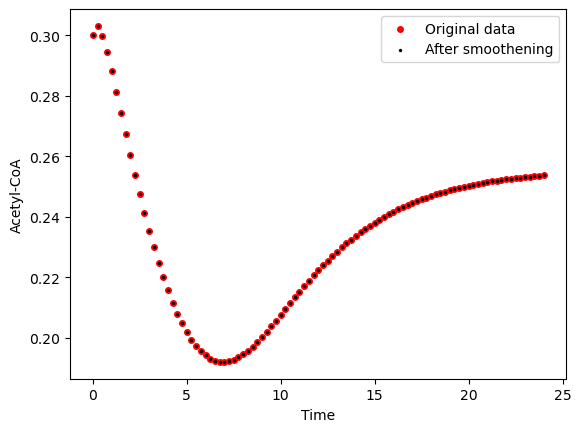

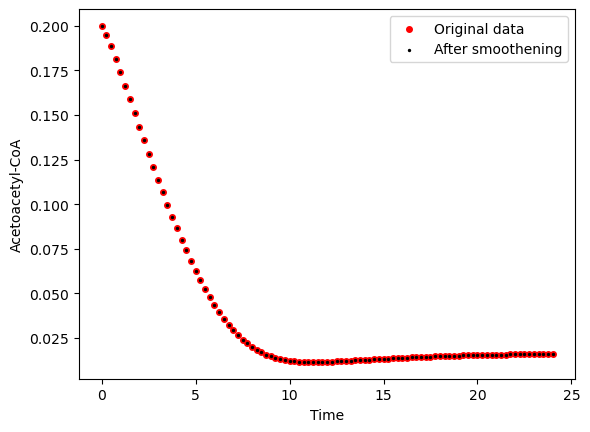

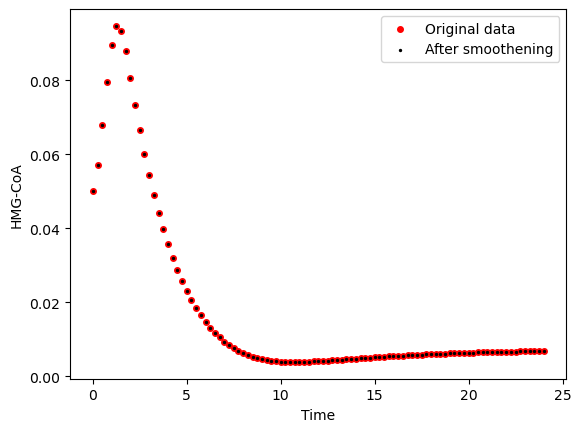

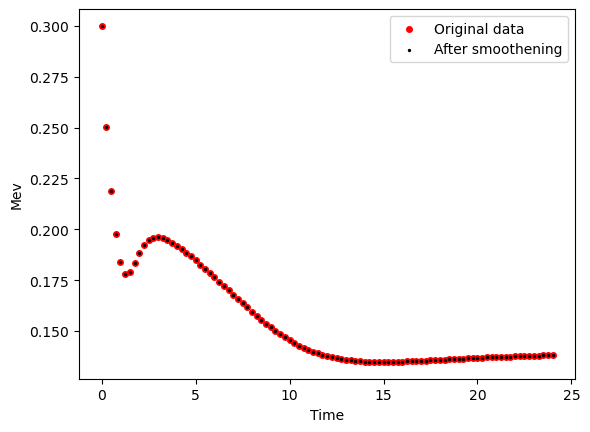

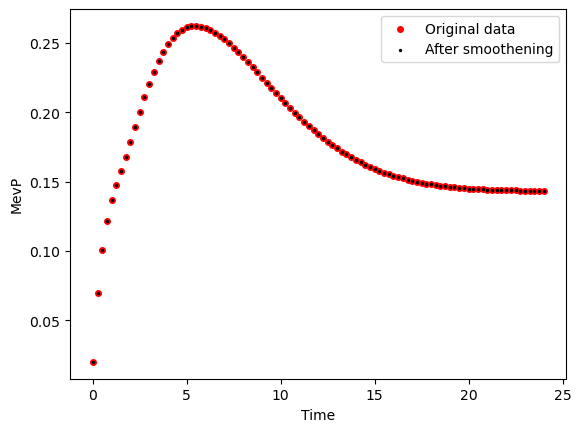

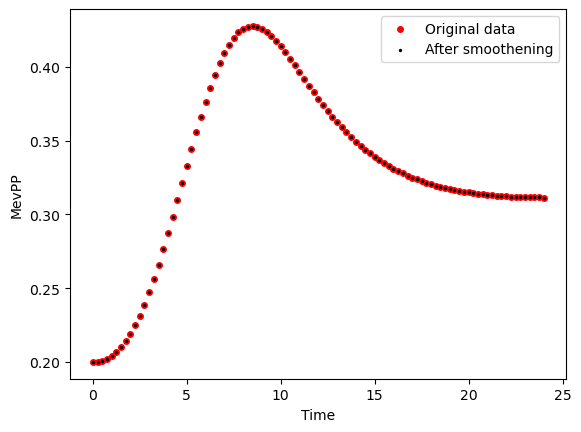

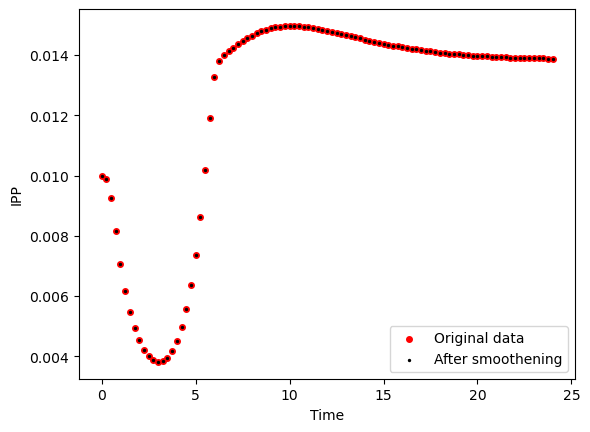

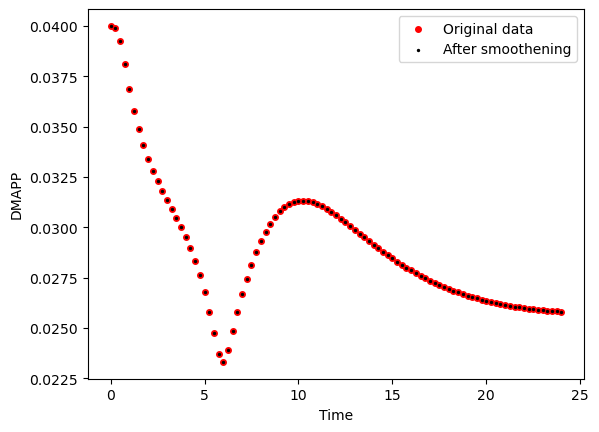

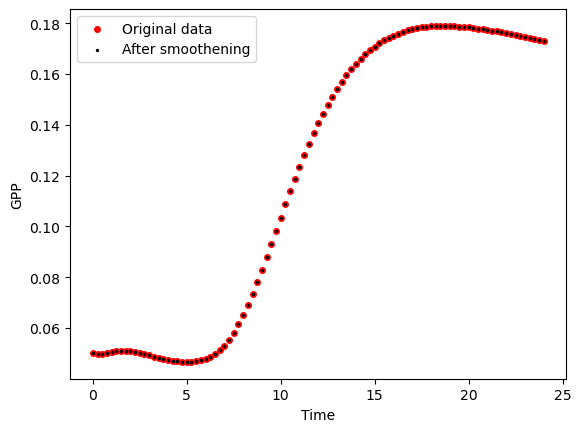

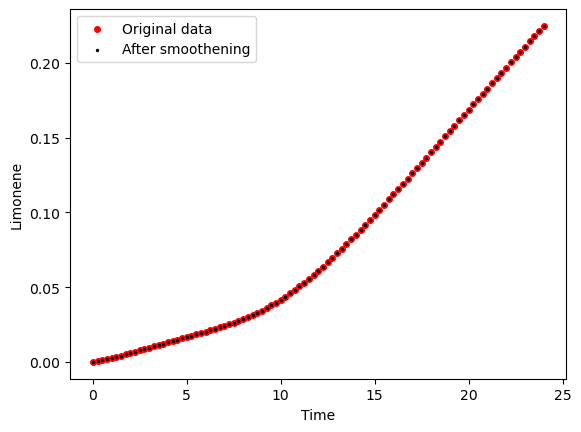

Strain Strain 2


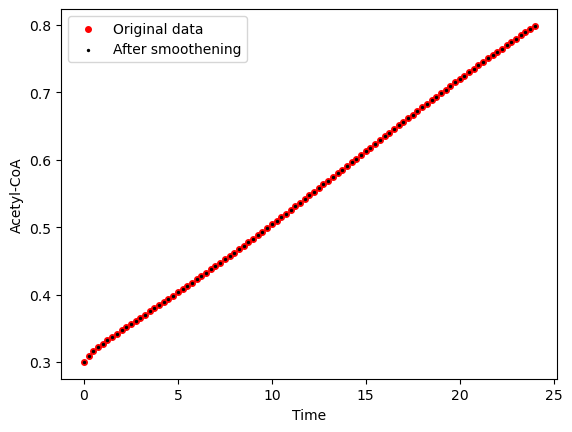

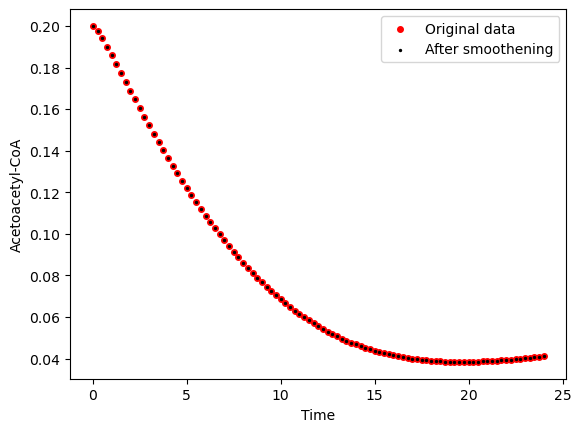

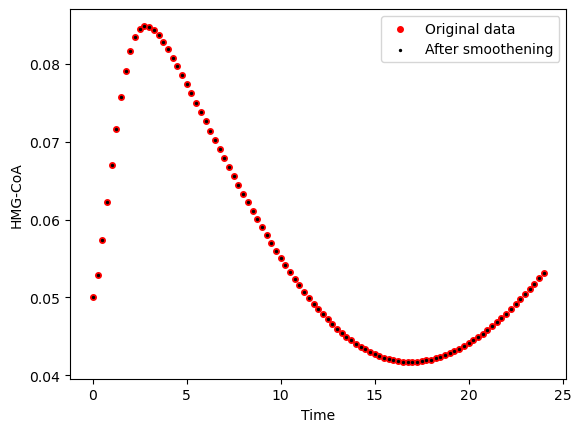

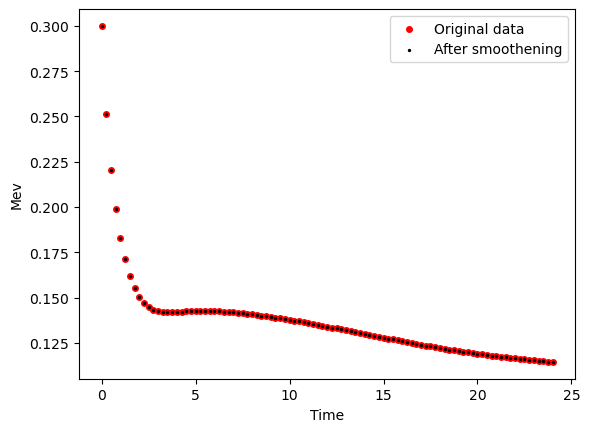

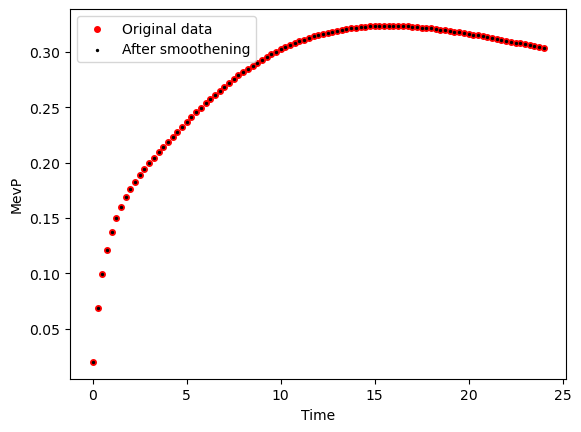

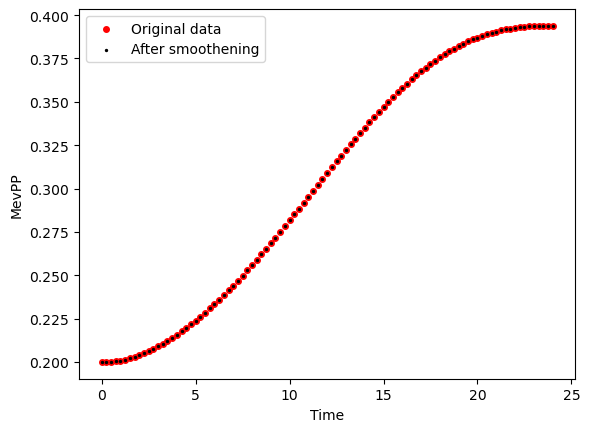

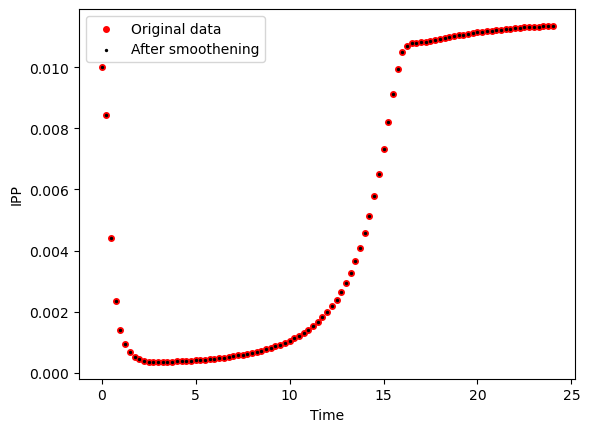

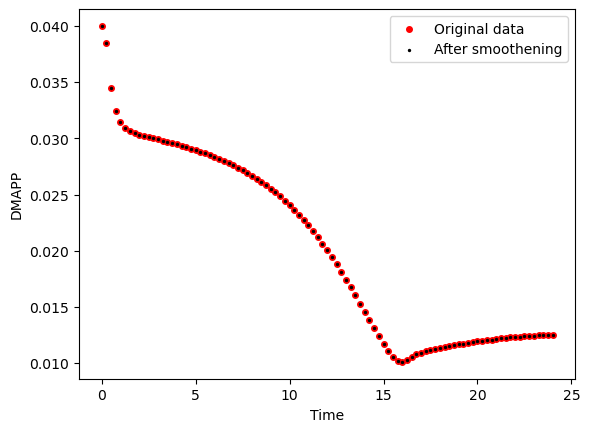

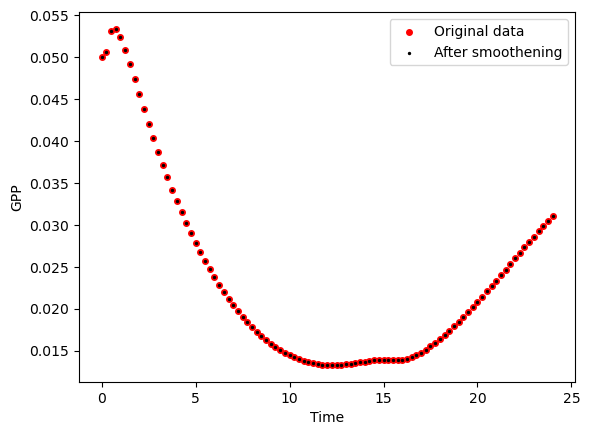

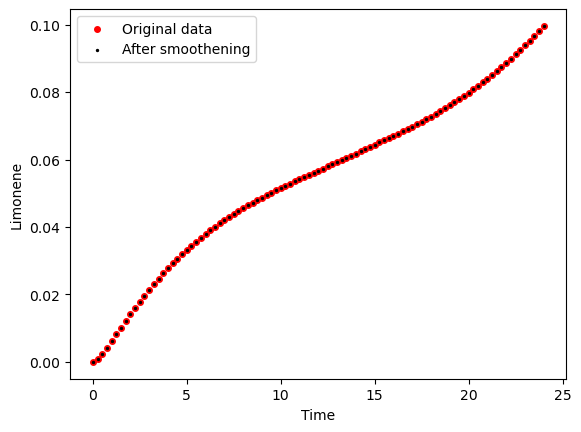

Strain Strain 3


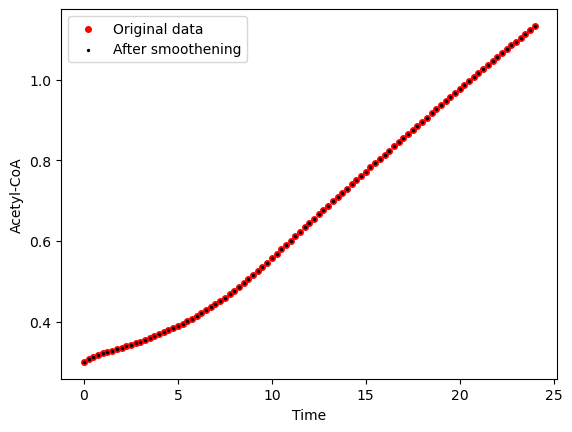

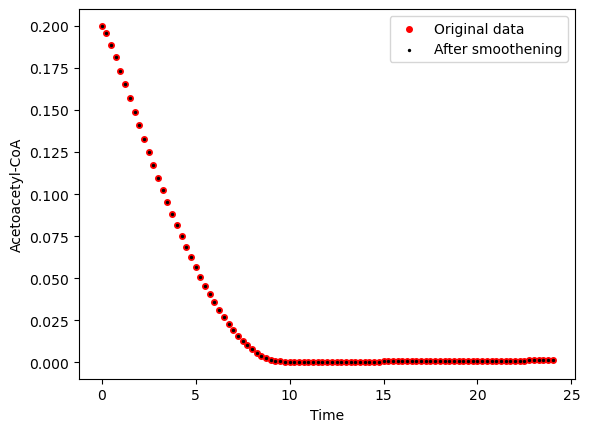

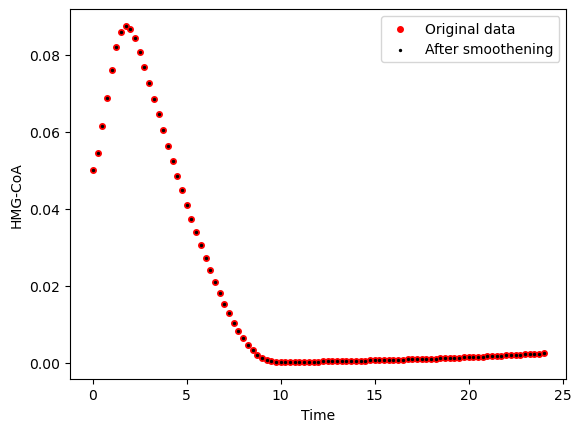

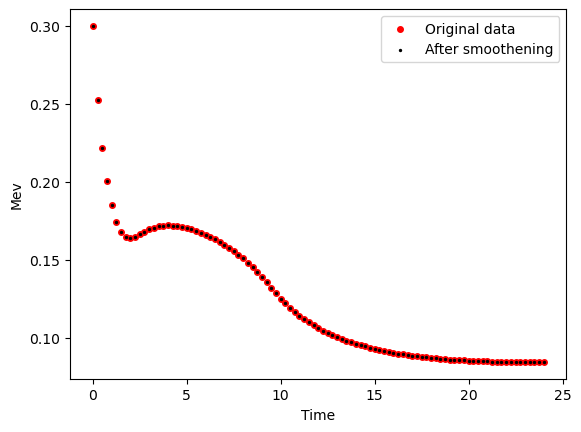

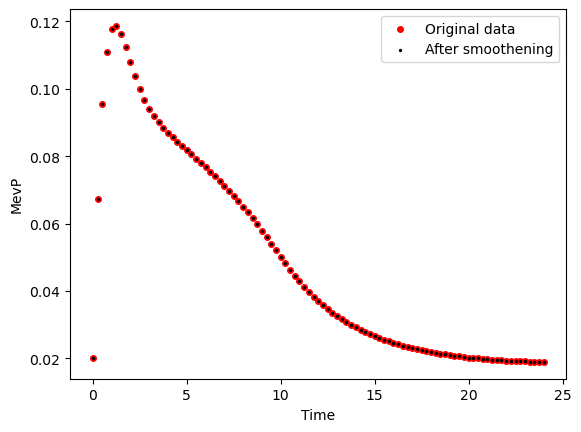

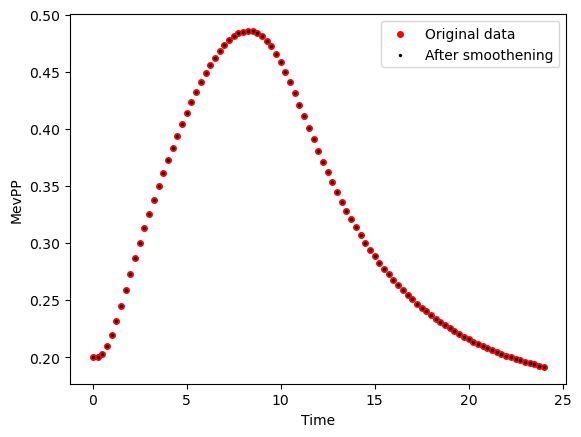

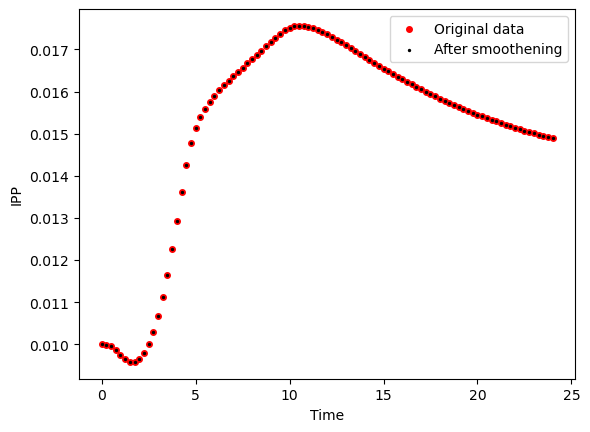

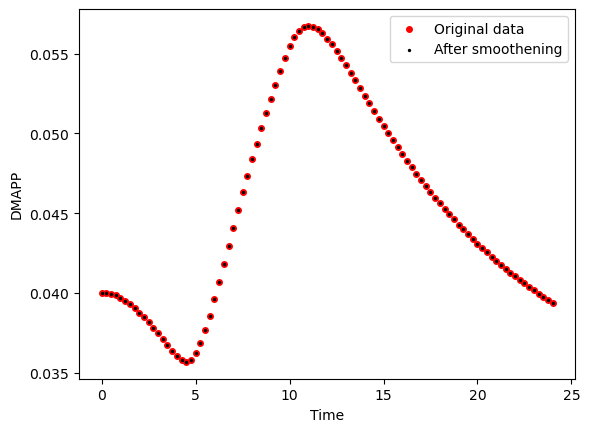

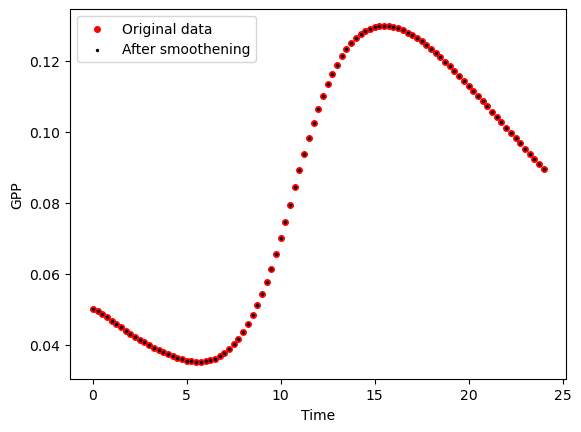

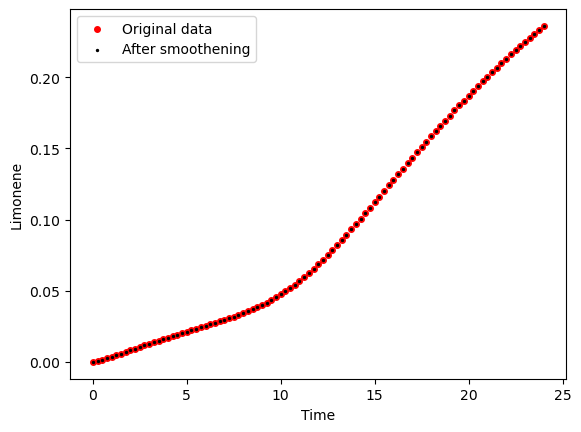

Strain WT


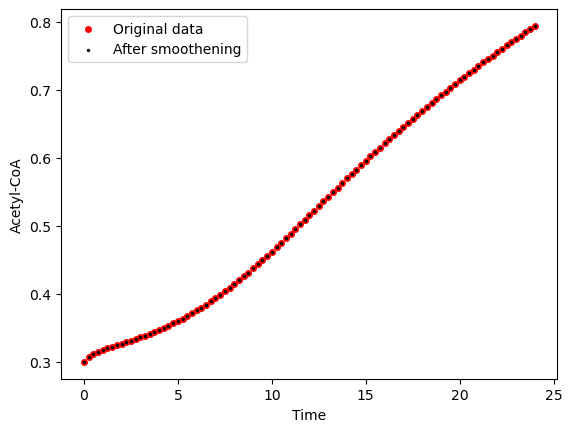

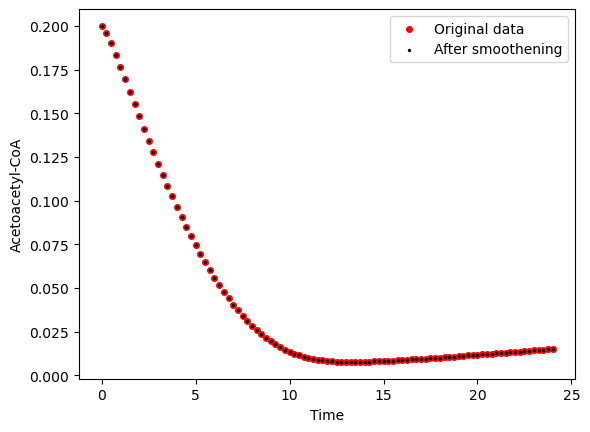

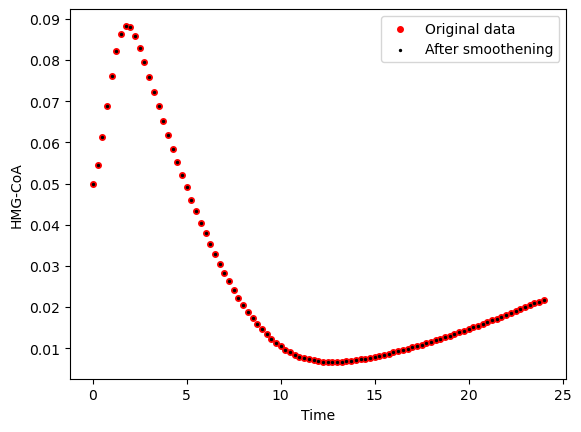

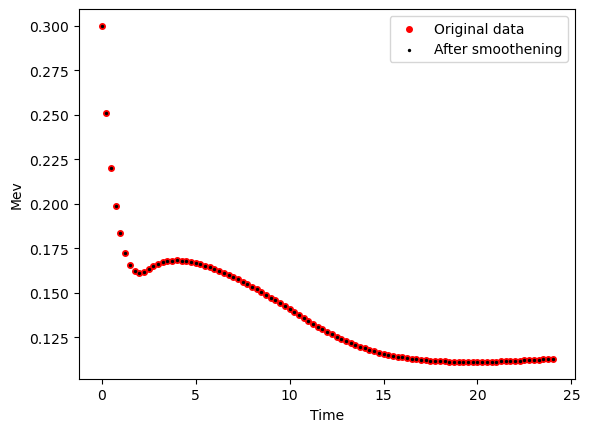

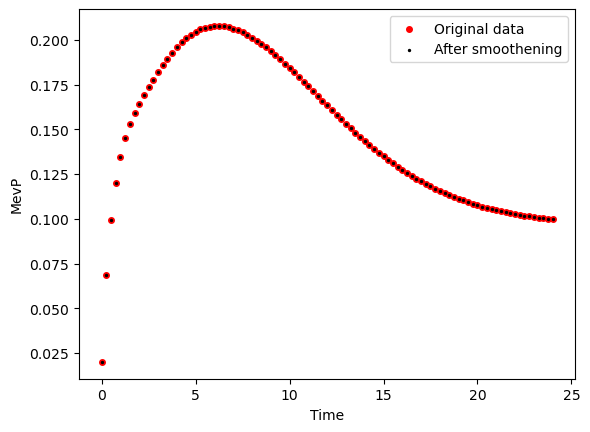

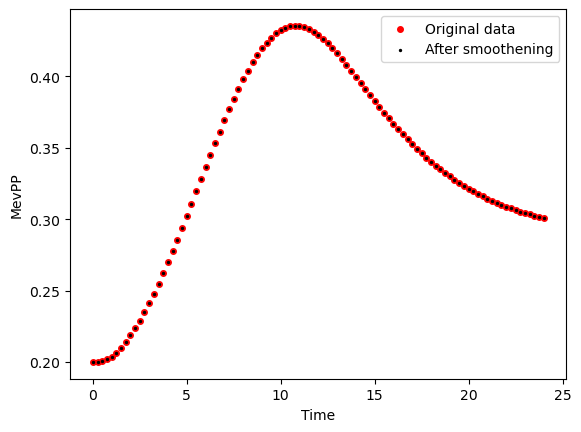

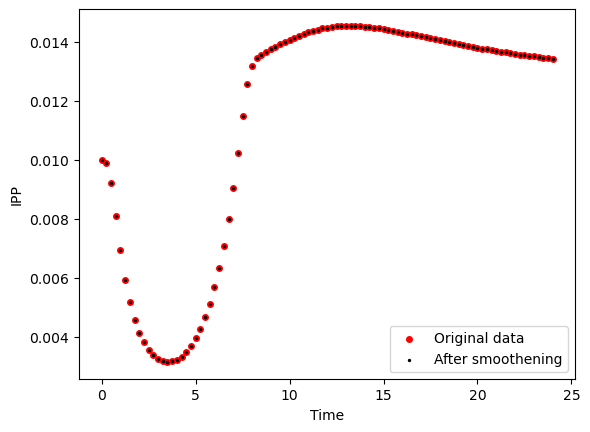

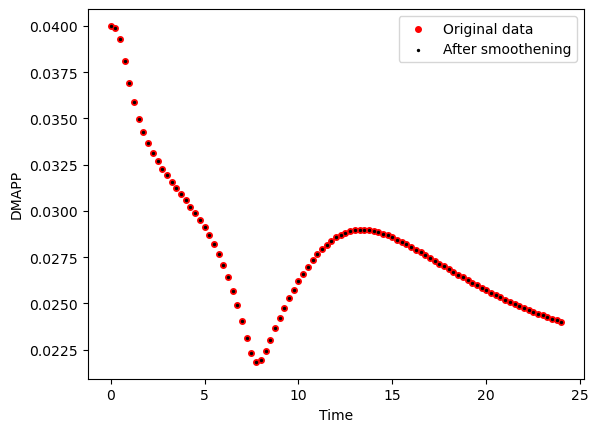

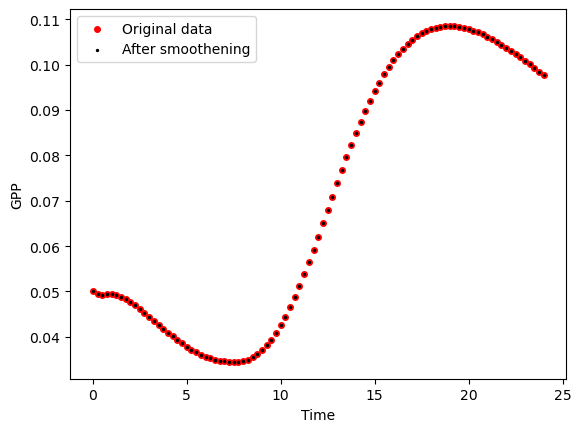

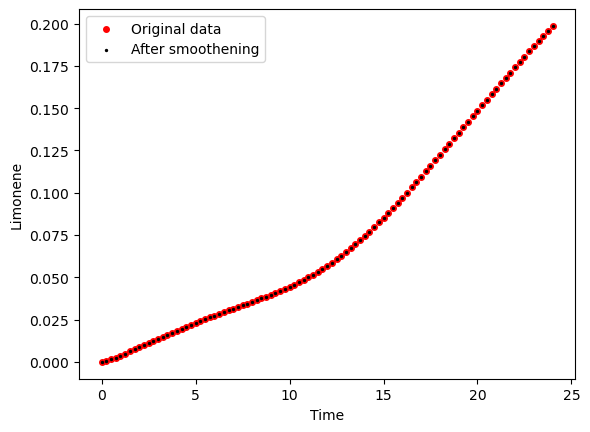

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


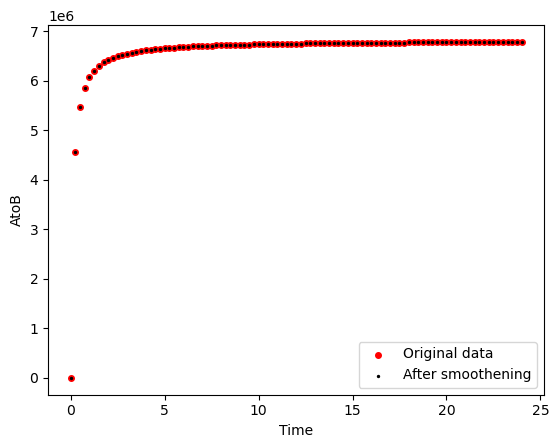

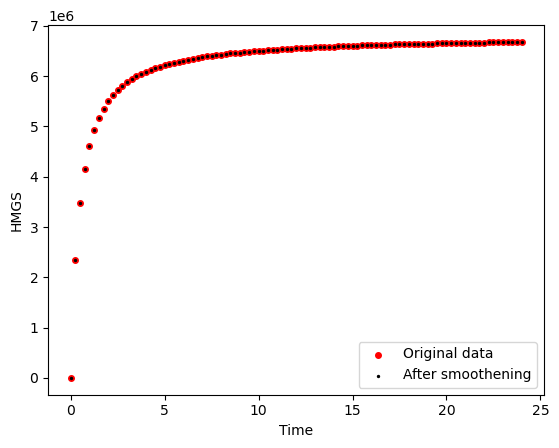

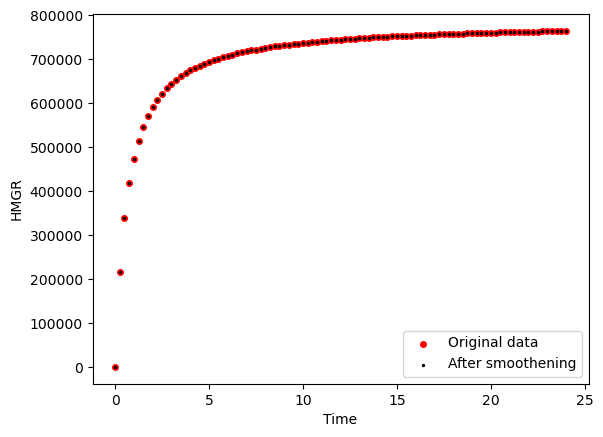

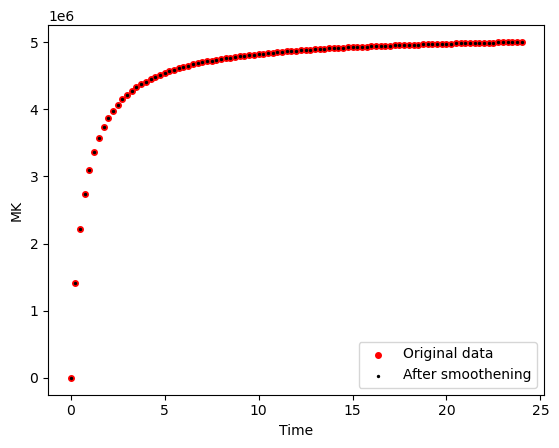

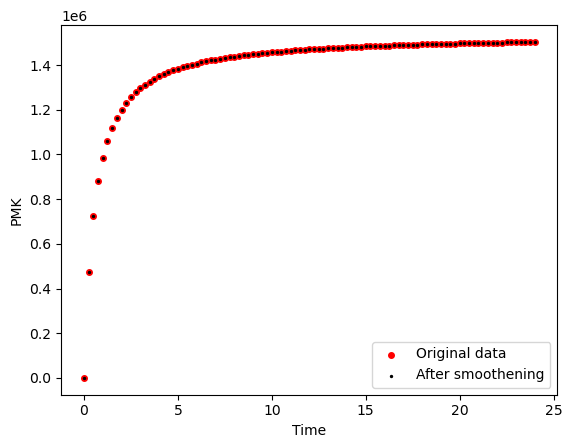

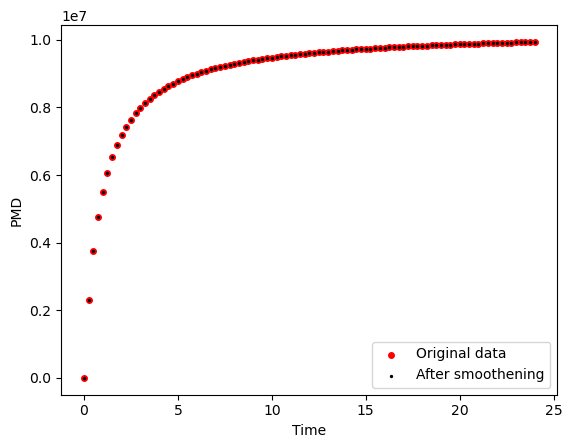

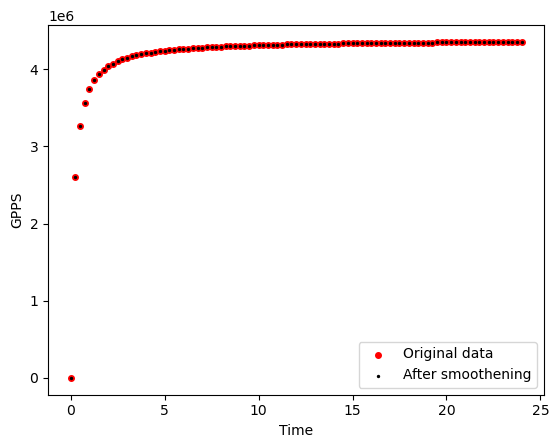

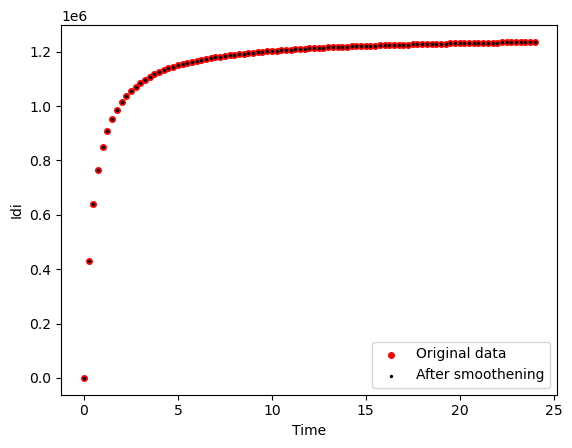

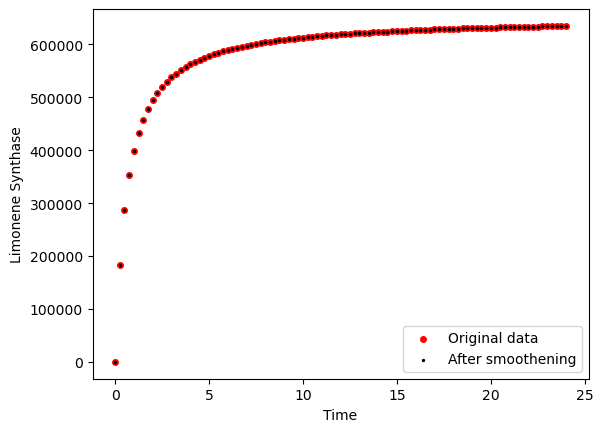

Strain Strain 2


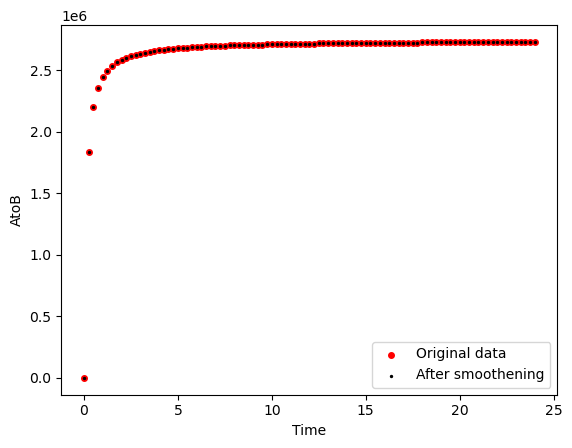

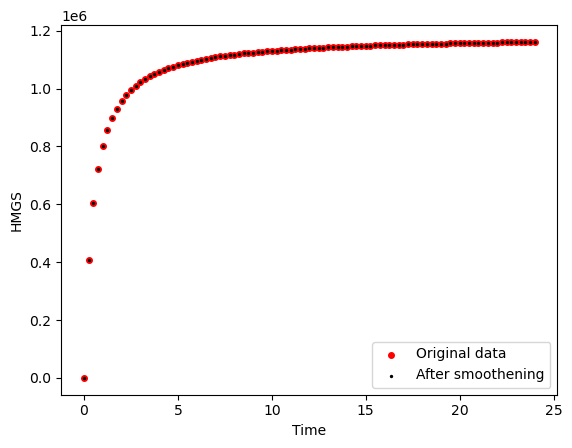

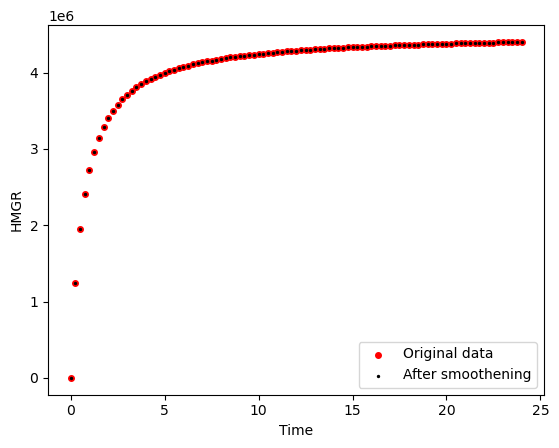

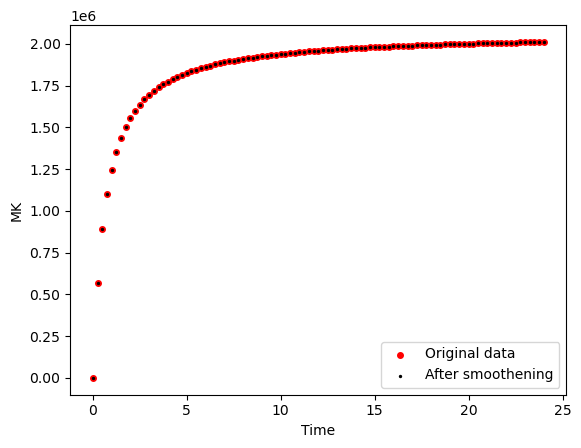

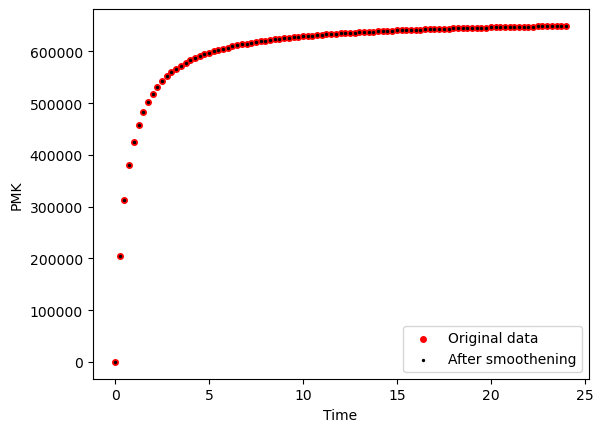

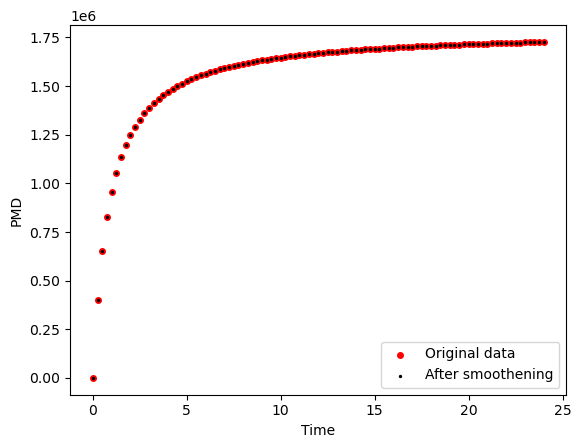

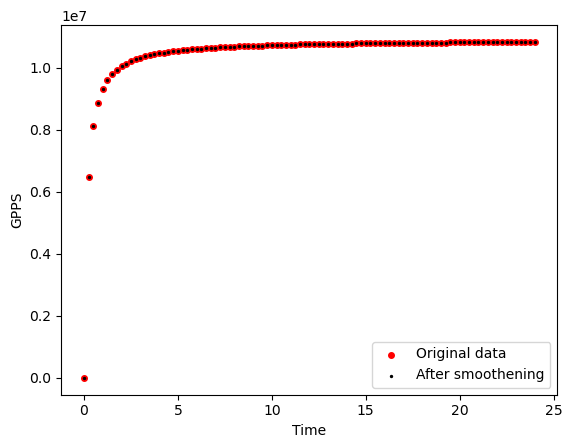

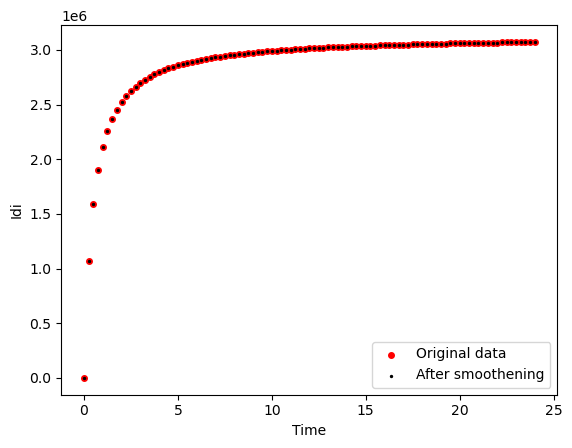

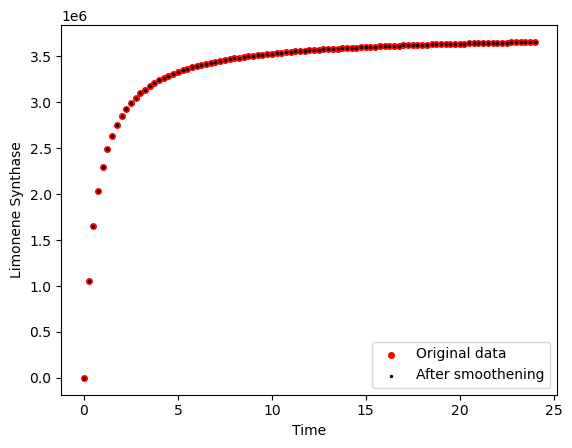

Strain Strain 3


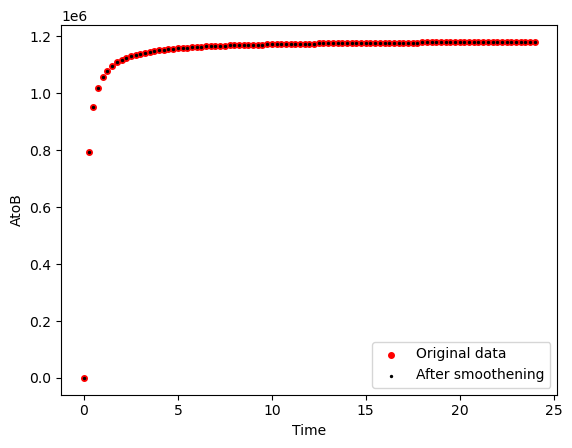

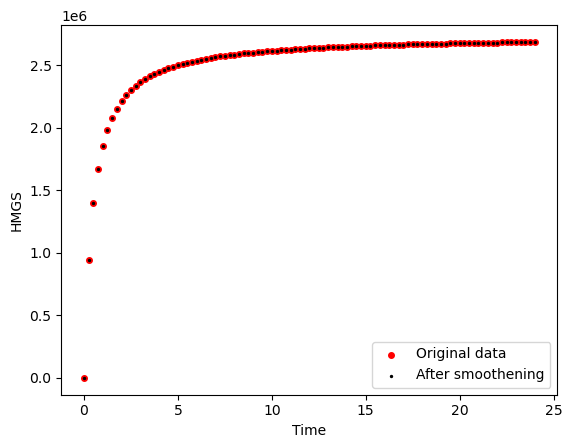

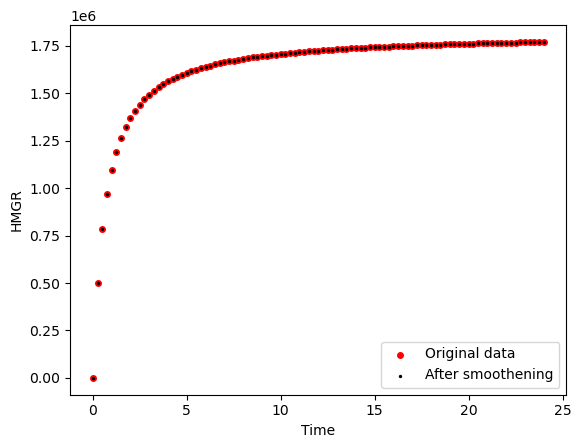

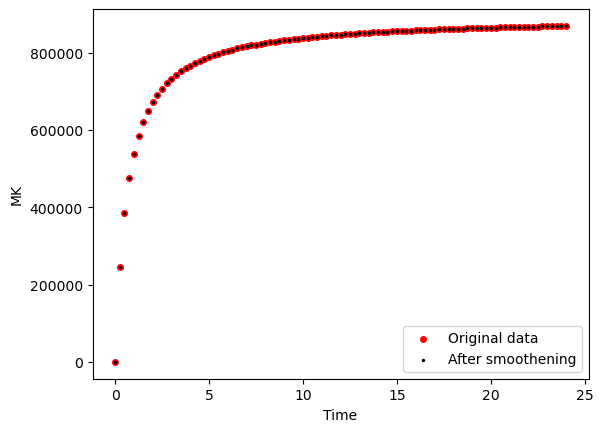

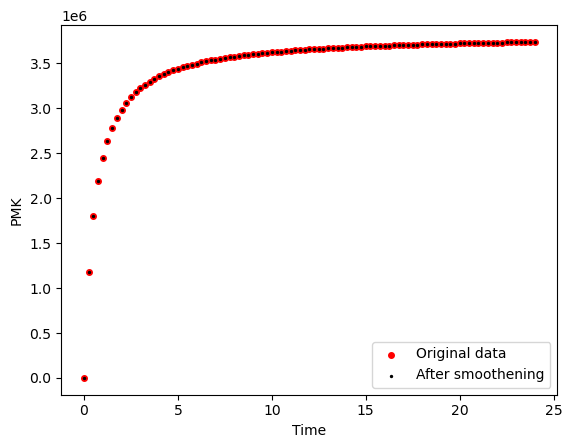

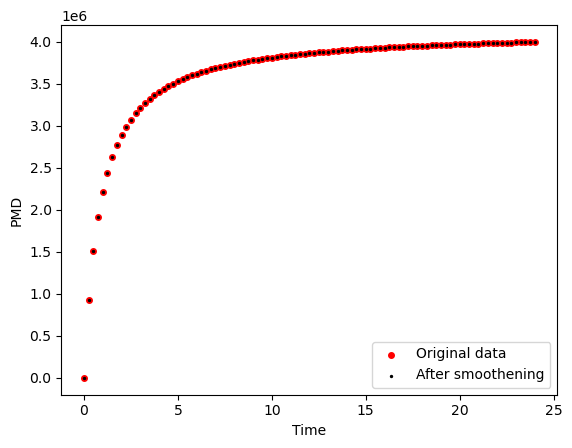

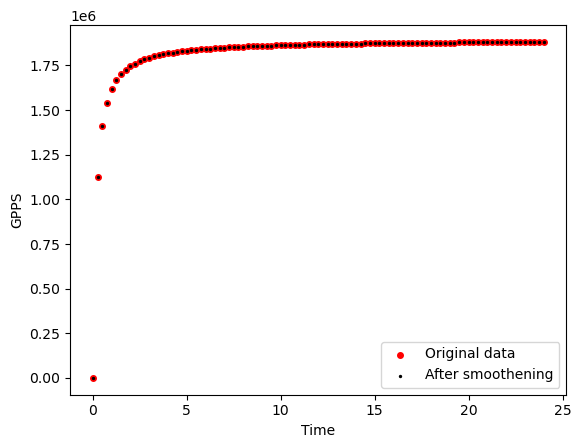

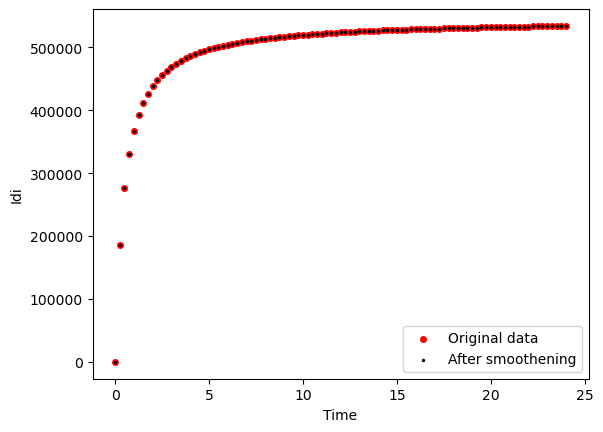

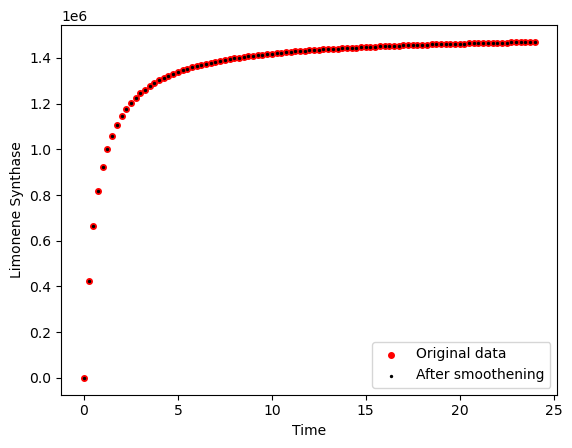

Strain WT


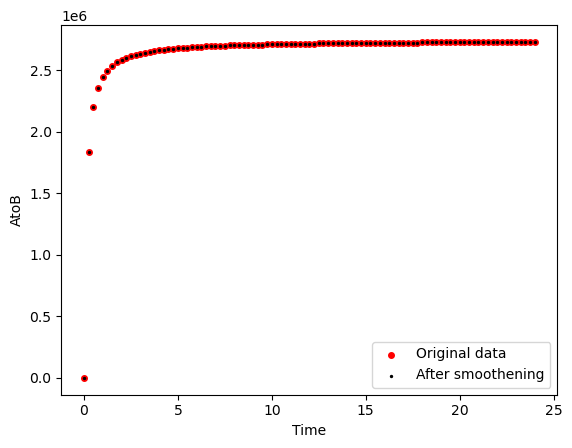

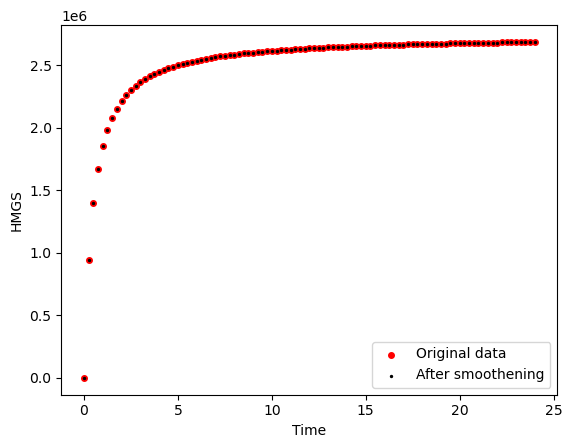

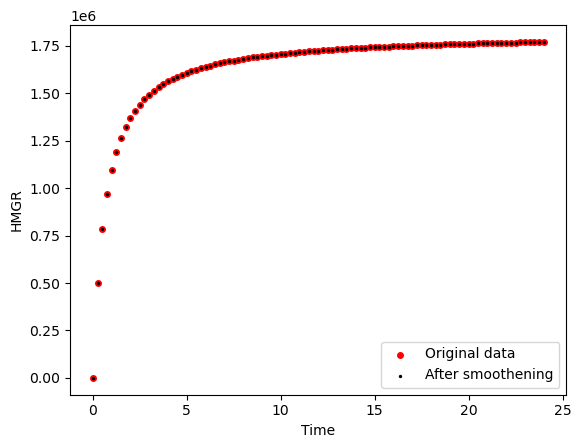

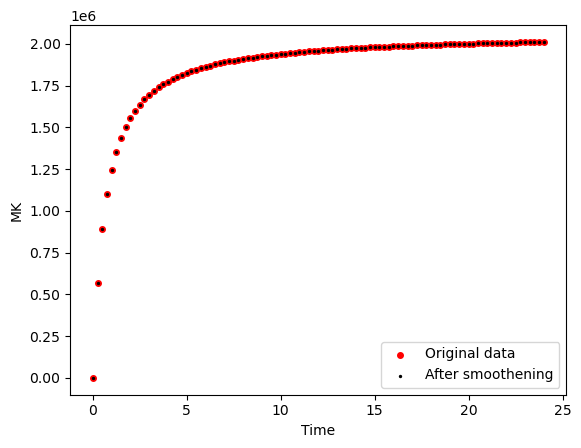

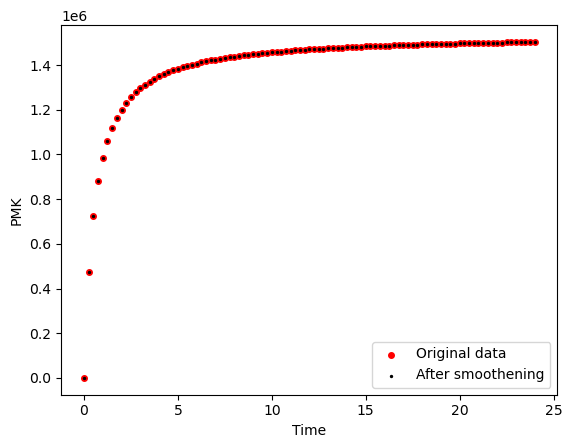

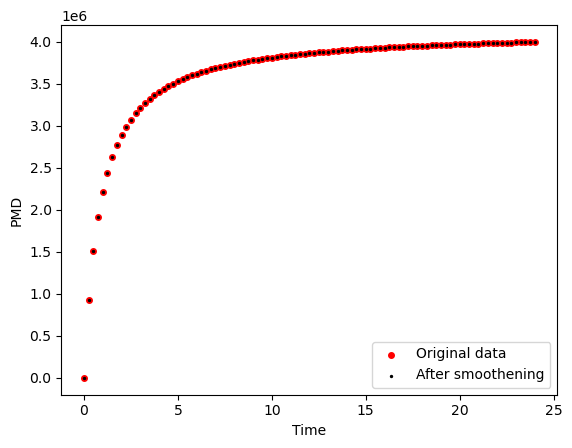

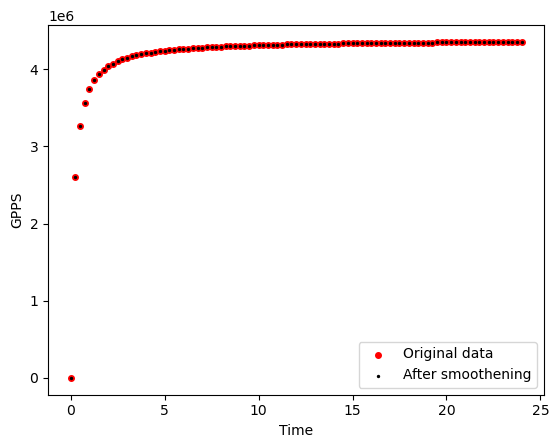

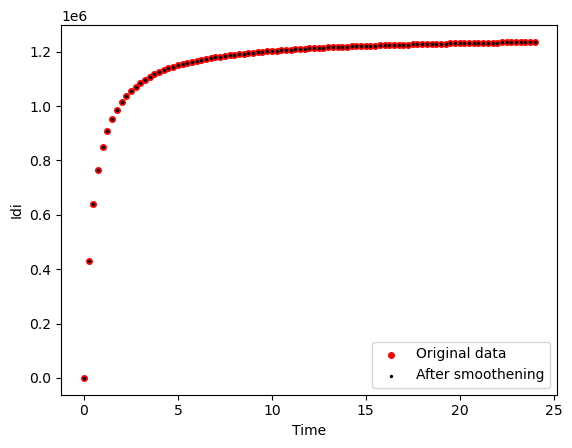

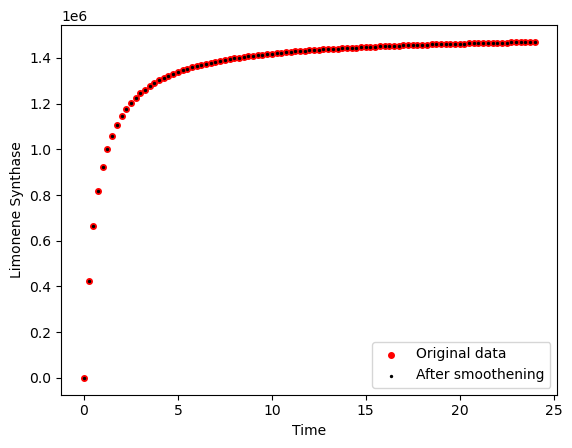

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

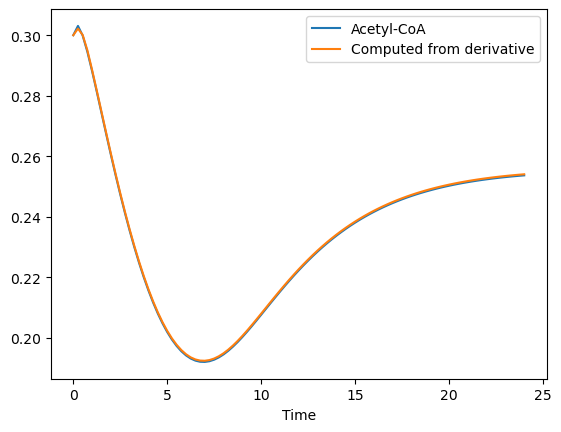

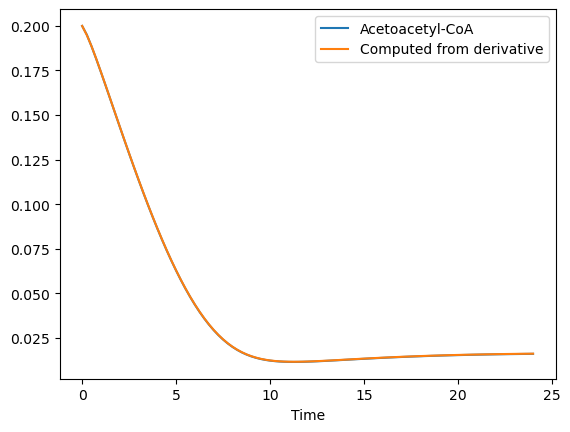

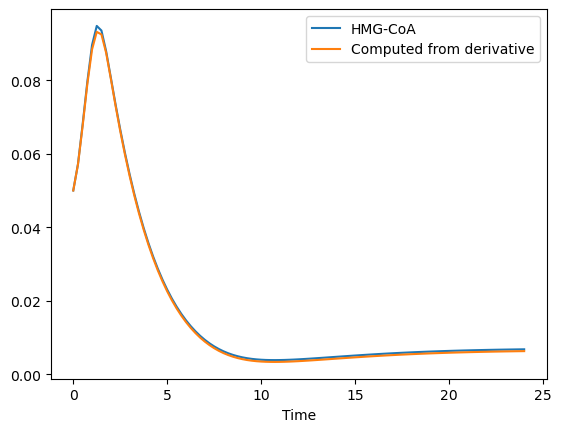

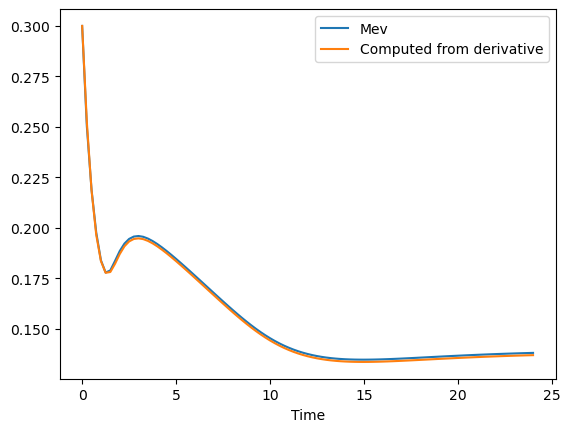

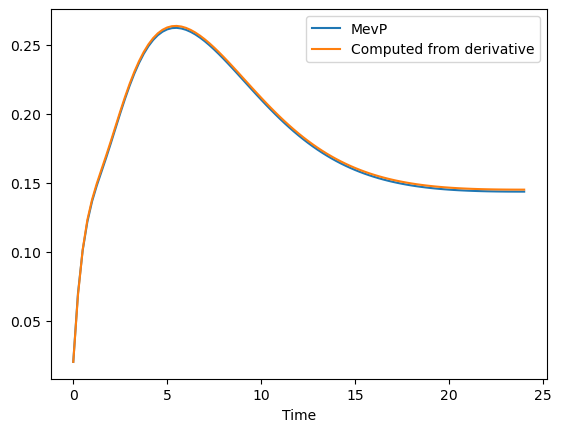

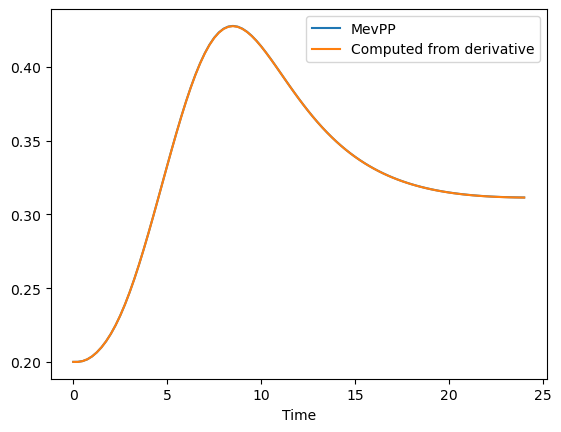

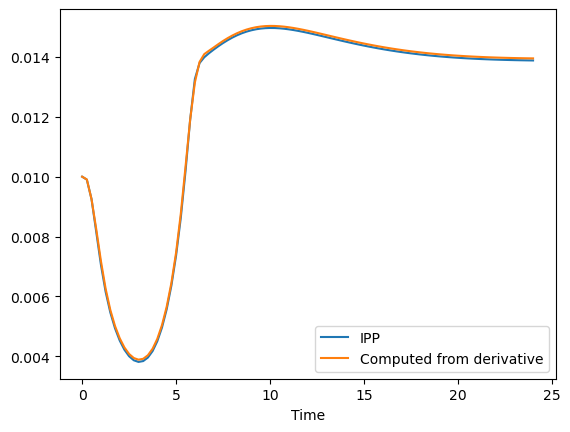

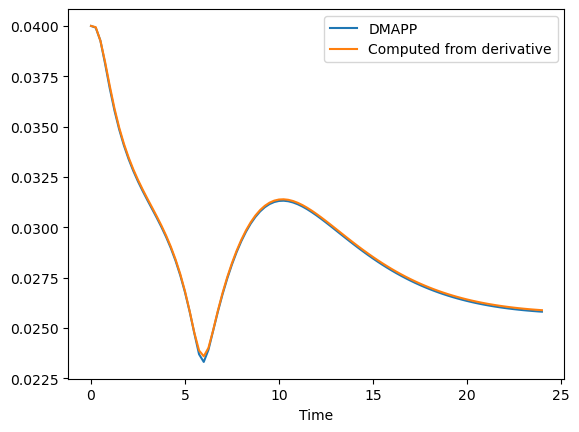

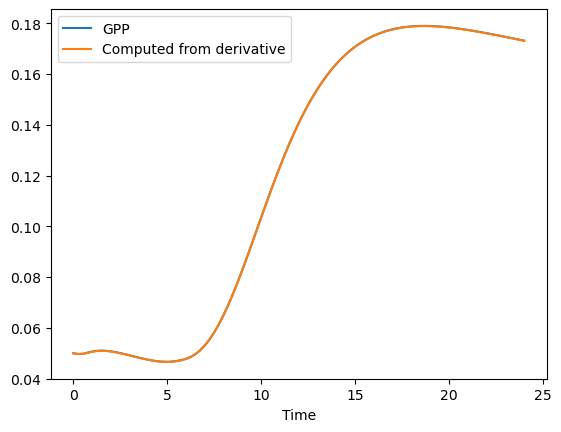

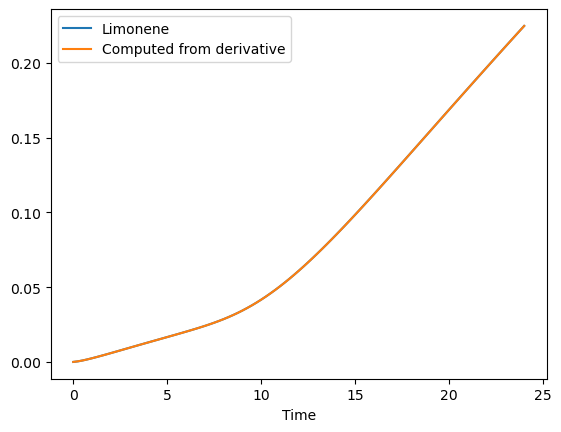

'Time profile from derivative vs. actual profile for Strain 2'

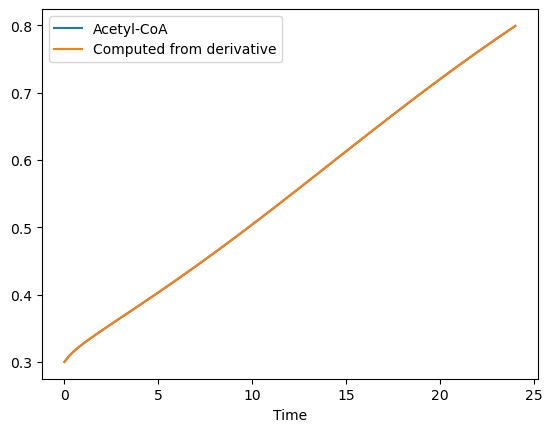

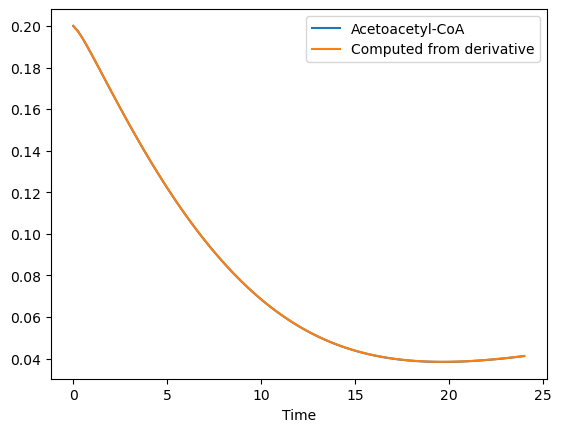

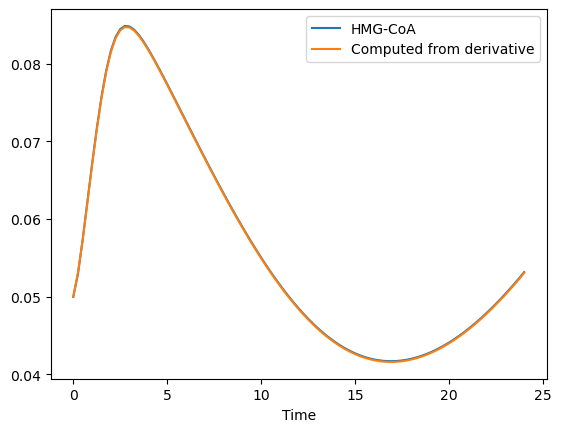

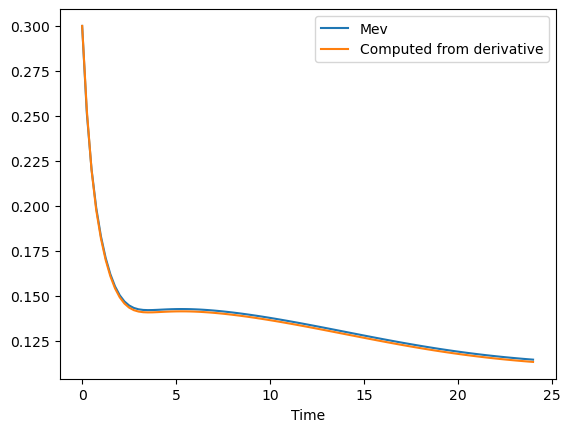

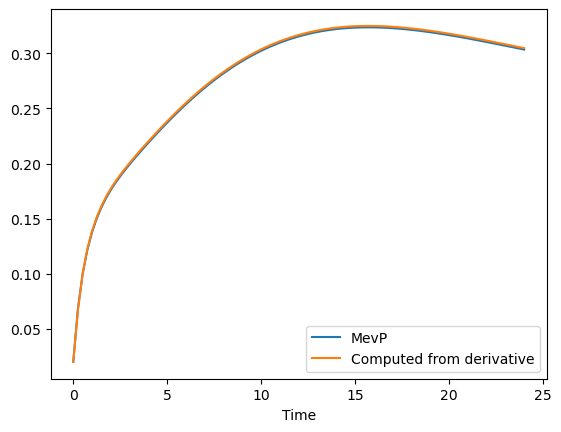

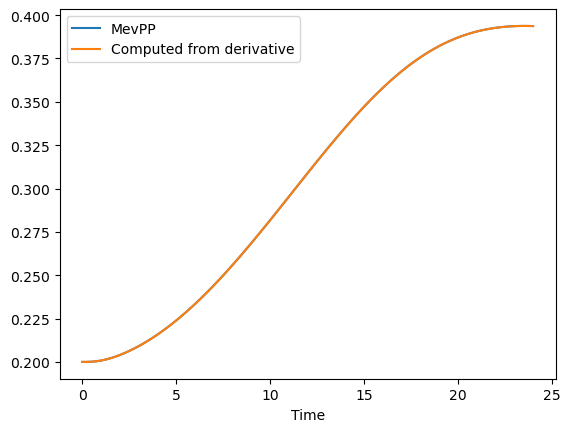

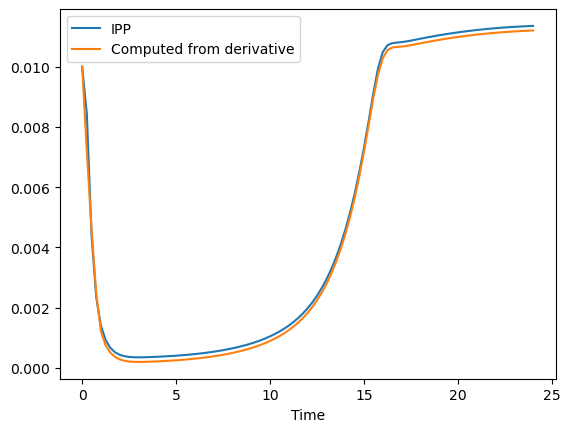

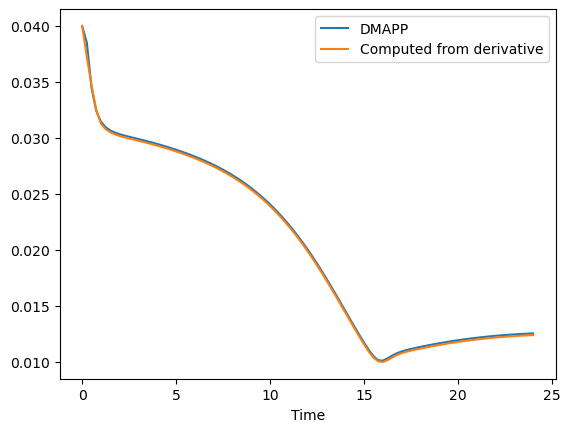

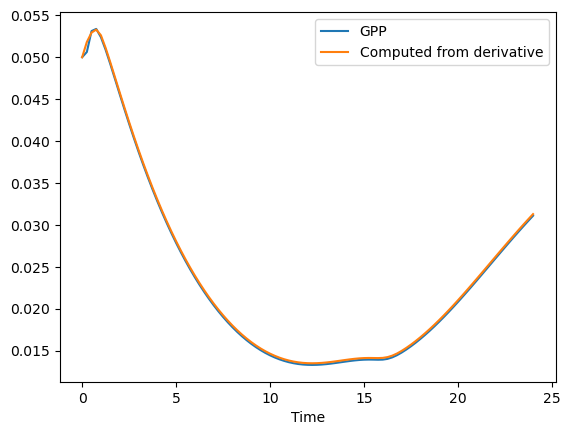

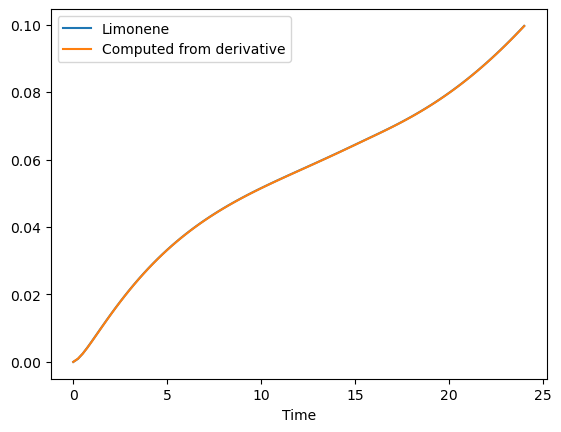

'Time profile from derivative vs. actual profile for Strain 3'

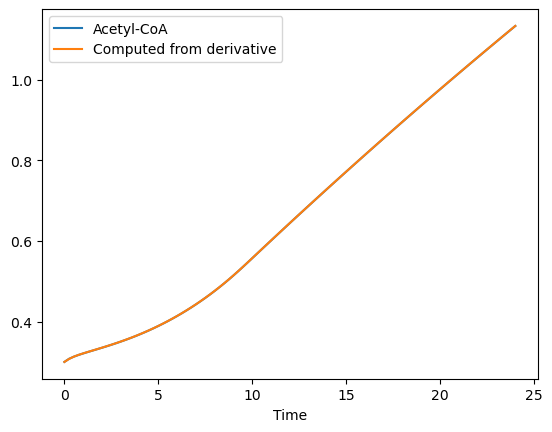

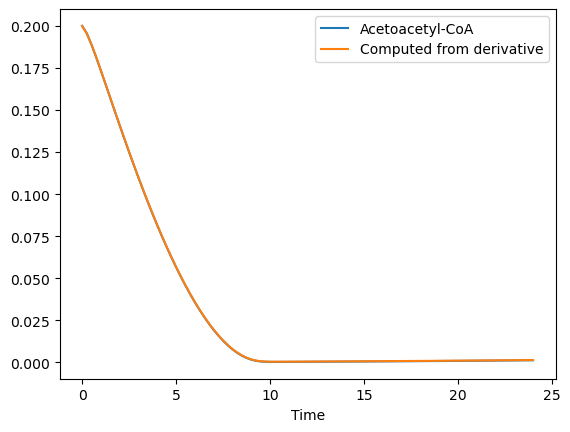

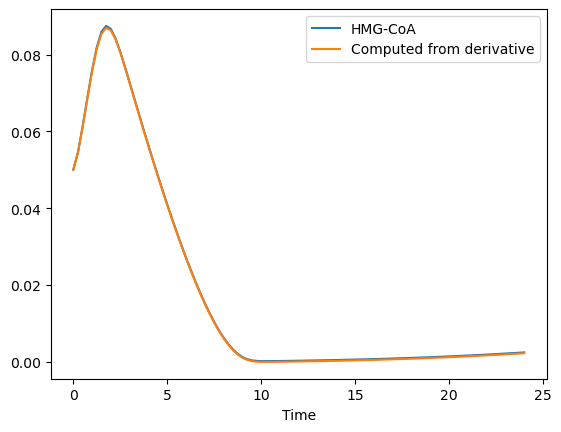

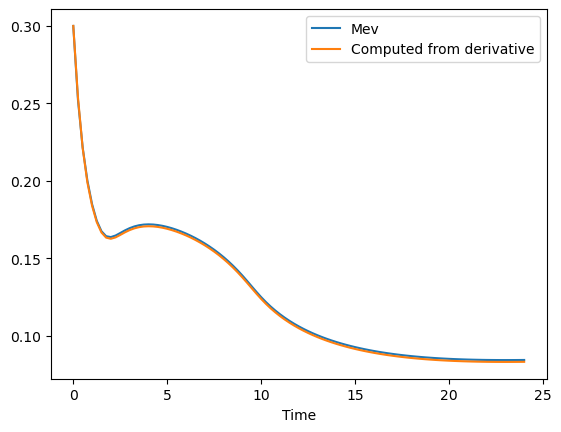

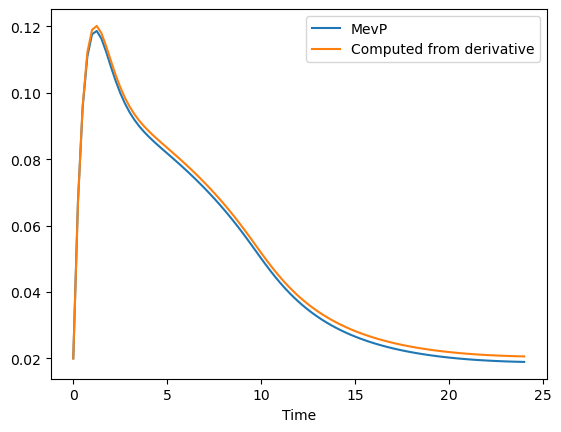

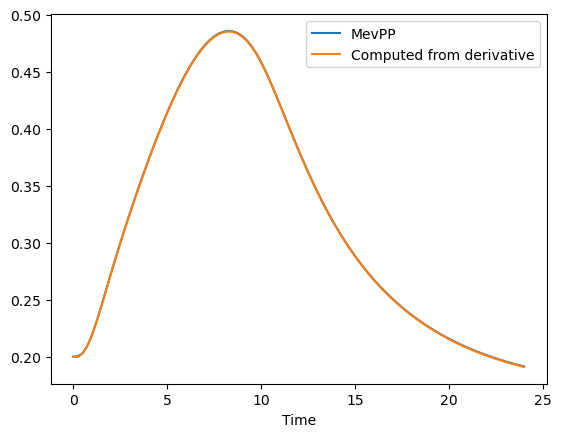

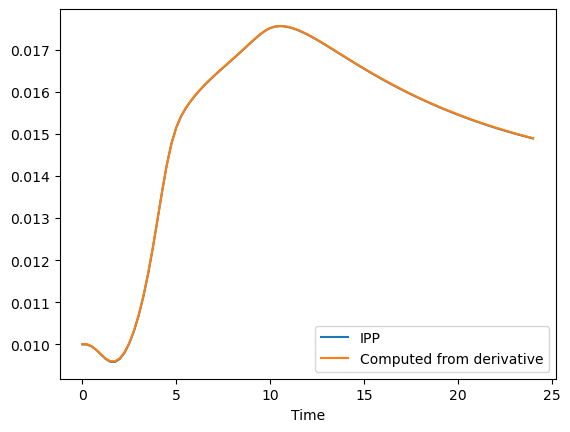

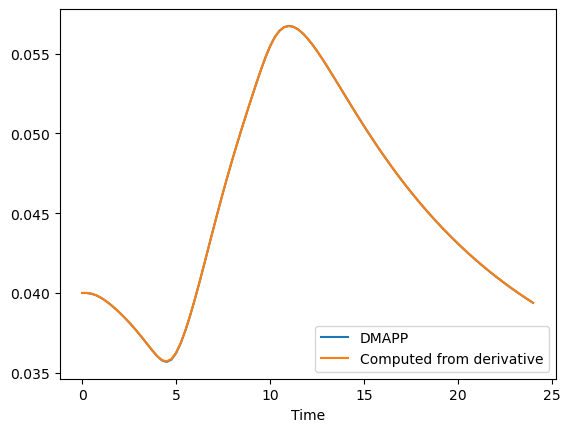

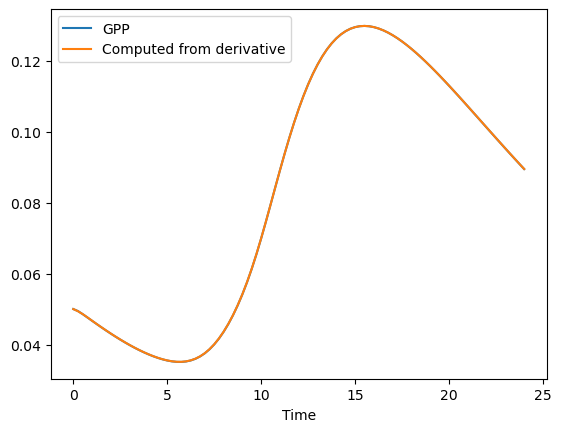

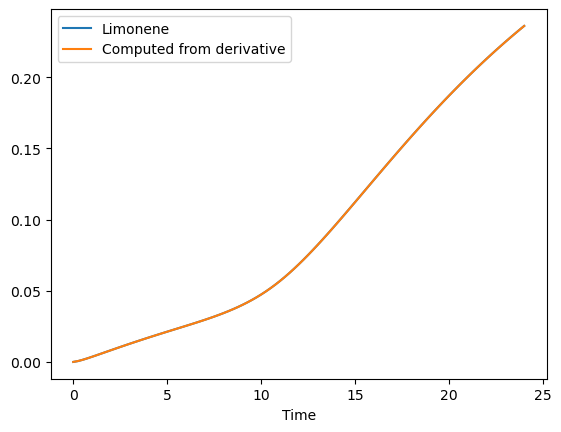

'Time profile from derivative vs. actual profile for WT'

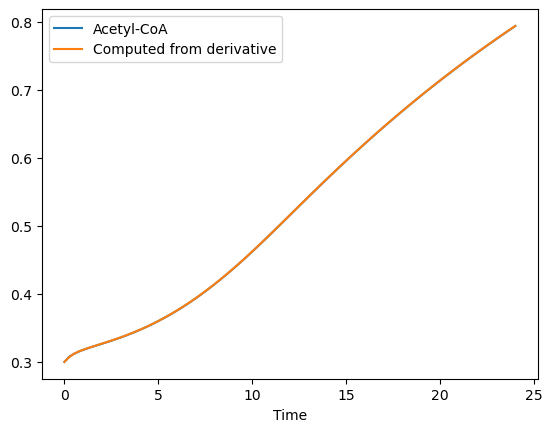

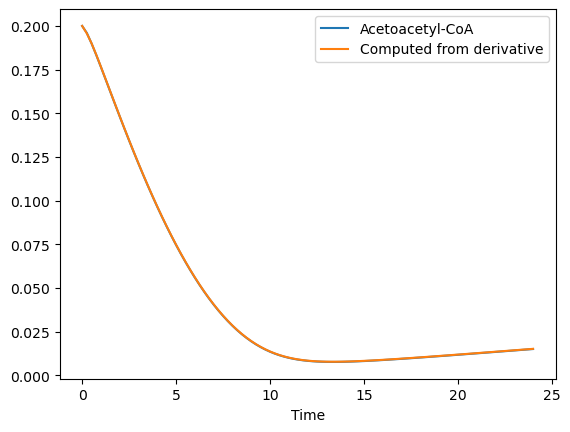

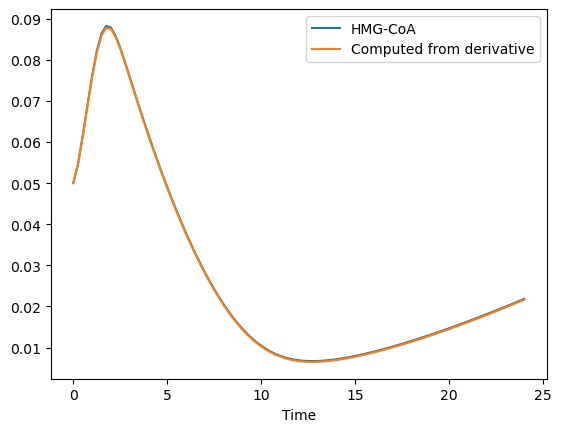

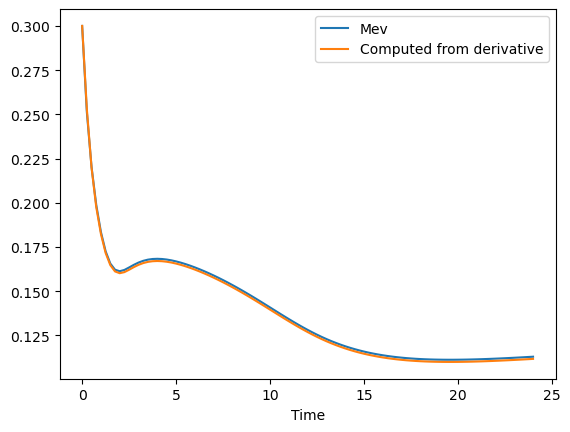

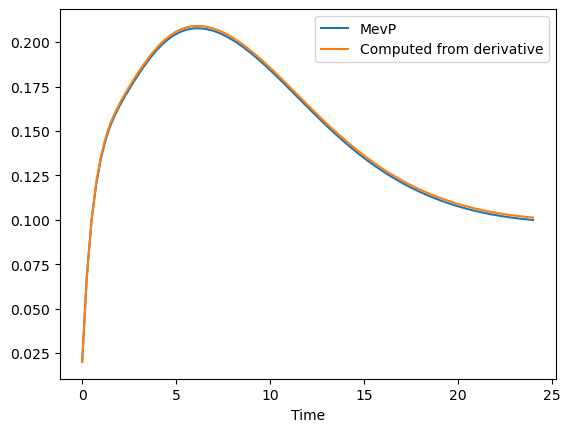

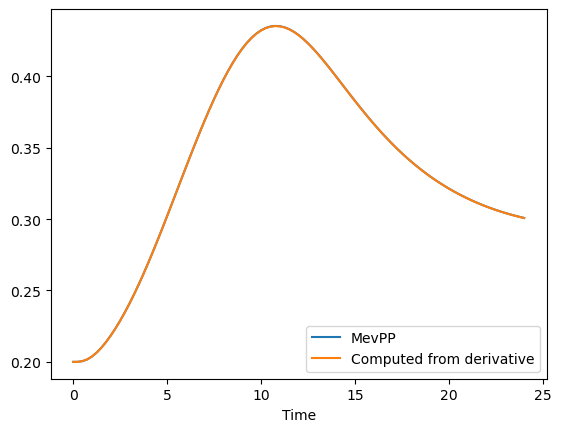

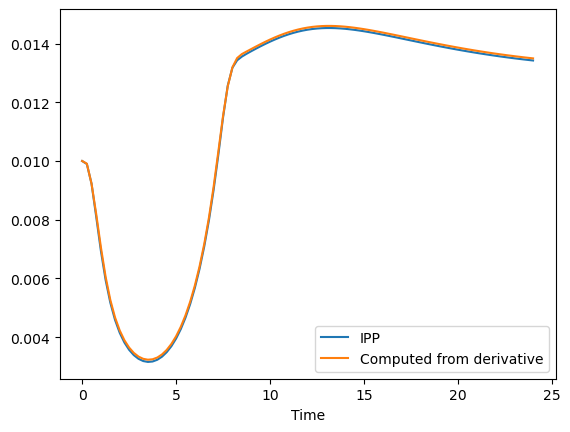

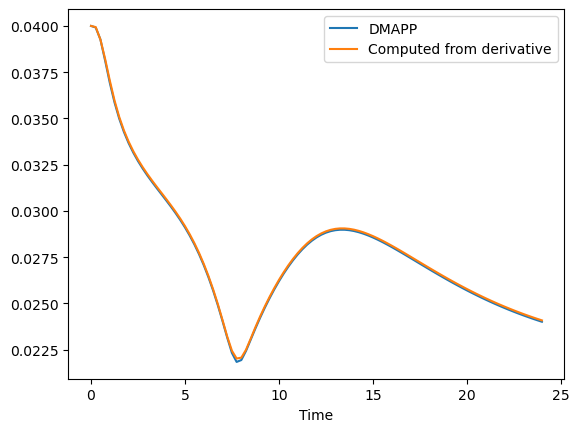

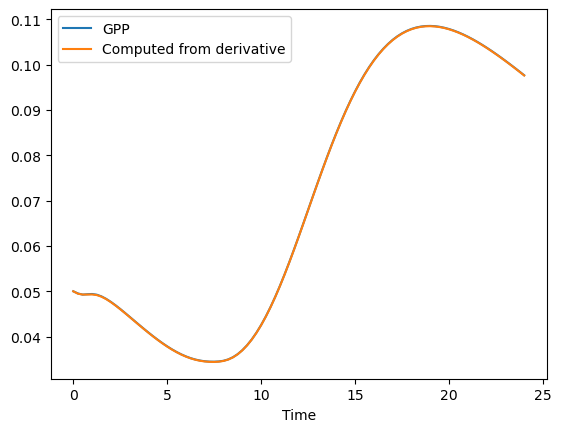

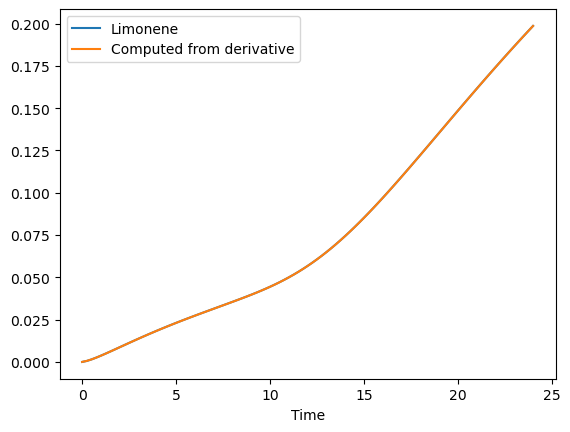

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.086327E+180 | 1.178650E+108
     2 |       74 | 2.715199E+115 |  2.844353E+94
     3 |      138 |  6.438677E+94 |  1.569969E+80
     4 |      202 |  3.711200E+86 |  5.941019E+72
     5 |      266 |  2.699936E+82 |  2.340607E+72
     6 |      330 |  4.421719E+74 |  1.907716E+57
     7 |      394 |  2.005572E+71 |  1.907716E+57
     8 |      458 |  8.604433E+65 |  1.495853E+52
     9 |      522 |  2.136108E+63 |  1.495853E+52
    10 |      586 |  1.032607E+60 |  7.809362E+42
    11 |      650 |  4.305341E+54 |  7.809362E+42
    12 |      714 |  8.000823E+51 |  6.208252E+41
    13 |      778 |  2.601569E+47 |  5.362892E+39
    14 |      842 |  1.478295E+43 |  1.697174E+35
    15 |      906 |  3.931637E+39 |  1.547151E+33
    16 |      970 |  1.309593E+39 |  1.022119E+25
    17 |     1034 |  1.709812E+31 |  1.027111E+22
    18 |     1098 |  3.559006E+29 |  3.535466E+18
    19 |     1162 |  1.74

   162 |    10314 |  2.173160E+01 |  2.016366E+01
   163 |    10378 |  2.174520E+01 |  2.016366E+01
   164 |    10442 |  2.167659E+01 |  2.016366E+01
   165 |    10506 |  2.154279E+01 |  2.016366E+01
   166 |    10570 |  2.153716E+01 |  2.016366E+01
   167 |    10634 |  2.163658E+01 |  2.016366E+01
   168 |    10698 |  2.164600E+01 |  2.016366E+01
   169 |    10762 |  2.157299E+01 |  2.016366E+01
   170 |    10826 |  2.088657E+01 |  1.964374E+01
   171 |    10890 |  2.069239E+01 |  1.913686E+01
   172 |    10954 |  2.074003E+01 |  1.913686E+01
   173 |    11018 |  2.034308E+01 |  1.913686E+01
   174 |    11082 |  2.088666E+01 |  1.913686E+01
   175 |    11146 |  2.083037E+01 |  1.913686E+01
   176 |    11210 |  2.061118E+01 |  1.913686E+01
   177 |    11274 |  2.072792E+01 |  1.913686E+01
   178 |    11338 |  2.074803E+01 |  1.913686E+01
   179 |    11402 |  2.023445E+01 |  1.824305E+01
   180 |    11466 |  2.029057E+01 |  1.739279E+01
   181 |    11530 |  1.991281E+01 |  1.661720E+01


   326 |    20810 |  1.444891E+01 |  1.422855E+01
   327 |    20874 |  1.435613E+01 |  1.415580E+01
   328 |    20938 |  1.434749E+01 |  1.415580E+01
   329 |    21002 |  1.442509E+01 |  1.415580E+01
   330 |    21066 |  1.442418E+01 |  1.415580E+01
   331 |    21130 |  1.437741E+01 |  1.415580E+01
   332 |    21194 |  1.433407E+01 |  1.414796E+01
   333 |    21258 |  1.432141E+01 |  1.414796E+01
   334 |    21322 |  1.428223E+01 |  1.414796E+01
   335 |    21386 |  1.419995E+01 |  1.413552E+01
   336 |    21450 |  1.416460E+01 |  1.404578E+01
   337 |    21514 |  1.420126E+01 |  1.404578E+01
   338 |    21578 |  1.413395E+01 |  1.404578E+01
   339 |    21642 |  1.412203E+01 |  1.404578E+01
   340 |    21706 |  1.415222E+01 |  1.404578E+01
   341 |    21770 |  1.418361E+01 |  1.404578E+01
   342 |    21834 |  1.415731E+01 |  1.403802E+01
   343 |    21898 |  1.412879E+01 |  1.403065E+01
   344 |    21962 |  1.416960E+01 |  1.403065E+01
   345 |    22026 |  1.413169E+01 |  1.397162E+01


   490 |    31306 |  1.271403E+01 |  1.269719E+01
   491 |    31370 |  1.270698E+01 |  1.269561E+01
   492 |    31434 |  1.270382E+01 |  1.268151E+01
   493 |    31498 |  1.269577E+01 |  1.267795E+01
   494 |    31562 |  1.269109E+01 |  1.267622E+01
   495 |    31626 |  1.268976E+01 |  1.267458E+01
   496 |    31690 |  1.267880E+01 |  1.265706E+01
   497 |    31754 |  1.267110E+01 |  1.265706E+01
   498 |    31818 |  1.266879E+01 |  1.265235E+01
   499 |    31882 |  1.266091E+01 |  1.265002E+01
   500 |    31946 |  1.265930E+01 |  1.265002E+01
   501 |    32010 |  1.265736E+01 |  1.265002E+01
   502 |    32074 |  1.265438E+01 |  1.264853E+01
   503 |    32138 |  1.265219E+01 |  1.264549E+01
   504 |    32202 |  1.265036E+01 |  1.264364E+01
   505 |    32266 |  1.265134E+01 |  1.264364E+01
   506 |    32330 |  1.264767E+01 |  1.263921E+01
   507 |    32394 |  1.264612E+01 |  1.263730E+01
   508 |    32458 |  1.264190E+01 |  1.263458E+01
   509 |    32522 |  1.264265E+01 |  1.263458E+01


   654 |    41802 |  1.252898E+01 |  1.252854E+01
   655 |    41866 |  1.252904E+01 |  1.252802E+01
   656 |    41930 |  1.252793E+01 |  1.252656E+01
   657 |    41994 |  1.252739E+01 |  1.252652E+01
   658 |    42058 |  1.252679E+01 |  1.252520E+01
   659 |    42122 |  1.252639E+01 |  1.252502E+01
   660 |    42186 |  1.252571E+01 |  1.252495E+01
   661 |    42250 |  1.252519E+01 |  1.252340E+01
   662 |    42314 |  1.252421E+01 |  1.252340E+01
   663 |    42378 |  1.252392E+01 |  1.252332E+01
   664 |    42442 |  1.252387E+01 |  1.252317E+01
   665 |    42506 |  1.252379E+01 |  1.252307E+01
   666 |    42570 |  1.252345E+01 |  1.252250E+01
   667 |    42634 |  1.252319E+01 |  1.252190E+01
   668 |    42698 |  1.252296E+01 |  1.252168E+01
   669 |    42762 |  1.252234E+01 |  1.252131E+01
   670 |    42826 |  1.252179E+01 |  1.252074E+01
   671 |    42890 |  1.252139E+01 |  1.252074E+01
   672 |    42954 |  1.252151E+01 |  1.252016E+01
   673 |    43018 |  1.252074E+01 |  1.251954E+01


   818 |    52298 |  1.233602E+01 |  1.233239E+01
   819 |    52362 |  1.233411E+01 |  1.232792E+01
   820 |    52426 |  1.233537E+01 |  1.232792E+01
   821 |    52490 |  1.233486E+01 |  1.232792E+01
   822 |    52554 |  1.233340E+01 |  1.232610E+01
   823 |    52618 |  1.233053E+01 |  1.232354E+01
   824 |    52682 |  1.232915E+01 |  1.232354E+01
   825 |    52746 |  1.232864E+01 |  1.232029E+01
   826 |    52810 |  1.232515E+01 |  1.232001E+01
   827 |    52874 |  1.232236E+01 |  1.231889E+01
   828 |    52938 |  1.231863E+01 |  1.231068E+01
   829 |    53002 |  1.231655E+01 |  1.231068E+01
   830 |    53066 |  1.231404E+01 |  1.231068E+01
   831 |    53130 |  1.231373E+01 |  1.230752E+01
   832 |    53194 |  1.231067E+01 |  1.230266E+01
   833 |    53258 |  1.230497E+01 |  1.229904E+01
   834 |    53322 |  1.230029E+01 |  1.229554E+01
   835 |    53386 |  1.229654E+01 |  1.229154E+01
   836 |    53450 |  1.229576E+01 |  1.228998E+01
   837 |    53514 |  1.229244E+01 |  1.228013E+01


   982 |    62794 |  1.190488E+01 |  1.190114E+01
   983 |    62858 |  1.190411E+01 |  1.190114E+01
   984 |    62922 |  1.190297E+01 |  1.190034E+01
   985 |    62986 |  1.190398E+01 |  1.190006E+01
   986 |    63050 |  1.190411E+01 |  1.189815E+01
   987 |    63114 |  1.190204E+01 |  1.189810E+01
   988 |    63178 |  1.190135E+01 |  1.189810E+01
   989 |    63242 |  1.189976E+01 |  1.189560E+01
   990 |    63306 |  1.190078E+01 |  1.189560E+01
   991 |    63370 |  1.189832E+01 |  1.189560E+01
   992 |    63434 |  1.189646E+01 |  1.189323E+01
   993 |    63498 |  1.189497E+01 |  1.189264E+01
   994 |    63562 |  1.189289E+01 |  1.188991E+01
   995 |    63626 |  1.189258E+01 |  1.188991E+01
   996 |    63690 |  1.189091E+01 |  1.188577E+01
   997 |    63754 |  1.188900E+01 |  1.188577E+01
   998 |    63818 |  1.188689E+01 |  1.188342E+01
   999 |    63882 |  1.188458E+01 |  1.187912E+01
  1000 |    63946 |  1.188247E+01 |  1.187737E+01
  1001 |    64010 |  1.188012E+01 |  1.187674E+01


  1146 |    73290 |  1.168878E+01 |  1.168221E+01
  1147 |    73354 |  1.168740E+01 |  1.168160E+01
  1148 |    73418 |  1.168529E+01 |  1.167579E+01
  1149 |    73482 |  1.168216E+01 |  1.167579E+01
  1150 |    73546 |  1.167825E+01 |  1.166987E+01
  1151 |    73610 |  1.167378E+01 |  1.166971E+01
  1152 |    73674 |  1.167043E+01 |  1.166195E+01
  1153 |    73738 |  1.166379E+01 |  1.165846E+01
  1154 |    73802 |  1.166115E+01 |  1.165653E+01
  1155 |    73866 |  1.165917E+01 |  1.165602E+01
  1156 |    73930 |  1.165932E+01 |  1.165351E+01
  1157 |    73994 |  1.165682E+01 |  1.164794E+01
  1158 |    74058 |  1.165195E+01 |  1.163604E+01
  1159 |    74122 |  1.164382E+01 |  1.163307E+01
  1160 |    74186 |  1.163072E+01 |  1.162265E+01
  1161 |    74250 |  1.162737E+01 |  1.162064E+01
  1162 |    74314 |  1.162375E+01 |  1.161931E+01
  1163 |    74378 |  1.162405E+01 |  1.161754E+01
  1164 |    74442 |  1.162176E+01 |  1.161521E+01
  1165 |    74506 |  1.161905E+01 |  1.161488E+01


  1310 |    83786 |  1.099401E+01 |  1.099002E+01
  1311 |    83850 |  1.099354E+01 |  1.098558E+01
  1312 |    83914 |  1.099032E+01 |  1.098558E+01
  1313 |    83978 |  1.098995E+01 |  1.098558E+01
  1314 |    84042 |  1.098850E+01 |  1.098558E+01
  1315 |    84106 |  1.098772E+01 |  1.098509E+01
  1316 |    84170 |  1.098659E+01 |  1.098151E+01
  1317 |    84234 |  1.098345E+01 |  1.097516E+01
  1318 |    84298 |  1.098243E+01 |  1.097516E+01
  1319 |    84362 |  1.097790E+01 |  1.096885E+01
  1320 |    84426 |  1.097605E+01 |  1.096803E+01
  1321 |    84490 |  1.097316E+01 |  1.096803E+01
  1322 |    84554 |  1.096945E+01 |  1.096247E+01
  1323 |    84618 |  1.096747E+01 |  1.096213E+01
  1324 |    84682 |  1.096104E+01 |  1.095030E+01
  1325 |    84746 |  1.095464E+01 |  1.094572E+01
  1326 |    84810 |  1.094831E+01 |  1.094178E+01
  1327 |    84874 |  1.094601E+01 |  1.094120E+01
  1328 |    84938 |  1.094010E+01 |  1.093422E+01
  1329 |    85002 |  1.094054E+01 |  1.092207E+01


  1474 |    94282 |  9.1953471104 |  9.1407625184
  1475 |    94346 |  9.1451427035 |  9.0966172505
  1476 |    94410 |  9.0860715018 |  9.0486146697
  1477 |    94474 |  9.0644479943 |  9.0348082867
  1478 |    94538 |  9.0330019340 |  8.9977818277
  1479 |    94602 |  8.9956466008 |  8.9647367837
  1480 |    94666 |  8.9863333839 |  8.9461411204
  1481 |    94730 |  8.9560185854 |  8.8966234432
  1482 |    94794 |  8.9383995724 |  8.8952142227
  1483 |    94858 |  8.9152003518 |  8.8733296179
  1484 |    94922 |  8.8995634991 |  8.8493986265
  1485 |    94986 |  8.8635114371 |  8.8352477726
  1486 |    95050 |  8.8506700471 |  8.8053944141
  1487 |    95114 |  8.8094665786 |  8.6861715339
  1488 |    95178 |  8.7862477096 |  8.6861715339
  1489 |    95242 |  8.7474444932 |  8.6843022268
  1490 |    95306 |  8.7208210820 |  8.6793112092
  1491 |    95370 |  8.6796078112 |  8.6440625863
  1492 |    95434 |  8.6469937302 |  8.6018072967
  1493 |    95498 |  8.5856563352 |  8.4923959448


  1638 |   104778 |  7.0652819137 |  7.0575721393
  1639 |   104842 |  7.0598188123 |  7.0539576668
  1640 |   104906 |  7.0573571633 |  7.0523520574
  1641 |   104970 |  7.0558481138 |  7.0510532723
  1642 |   105034 |  7.0498899467 |  7.0375027051
  1643 |   105098 |  7.0458716922 |  7.0375027051
  1644 |   105162 |  7.0422266026 |  7.0372889150
  1645 |   105226 |  7.0382087567 |  7.0312732129
  1646 |   105290 |  7.0321224720 |  7.0270956293
  1647 |   105354 |  7.0270695194 |  7.0186178757
  1648 |   105418 |  7.0246176039 |  7.0183198813
  1649 |   105482 |  7.0219924478 |  7.0162996855
  1650 |   105546 |  7.0176708343 |  7.0142959145
  1651 |   105610 |  7.0175455241 |  7.0121100081
  1652 |   105674 |  7.0143999768 |  7.0084733784
  1653 |   105738 |  7.0116071130 |  7.0060222225
  1654 |   105802 |  7.0051913973 |  6.9986786328
  1655 |   105866 |  7.0006690807 |  6.9960268288
  1656 |   105930 |  6.9999240638 |  6.9925966122
  1657 |   105994 |  6.9946078481 |  6.9896876422


  1802 |   115274 |  6.8664616804 |  6.8642681577
  1803 |   115338 |  6.8652955070 |  6.8638037363
  1804 |   115402 |  6.8647642137 |  6.8632618092
  1805 |   115466 |  6.8641006812 |  6.8624575039
  1806 |   115530 |  6.8638316923 |  6.8621739977
  1807 |   115594 |  6.8633193183 |  6.8613698856
  1808 |   115658 |  6.8638335710 |  6.8613698856
  1809 |   115722 |  6.8634375135 |  6.8610589167
  1810 |   115786 |  6.8624542657 |  6.8610589167
  1811 |   115850 |  6.8619853492 |  6.8601004062
  1812 |   115914 |  6.8620545155 |  6.8601004062
  1813 |   115978 |  6.8610303518 |  6.8592381842
  1814 |   116042 |  6.8604028029 |  6.8580477115
  1815 |   116106 |  6.8598649342 |  6.8580477115
  1816 |   116170 |  6.8595259373 |  6.8580477115
  1817 |   116234 |  6.8598295330 |  6.8580477115
  1818 |   116298 |  6.8590346303 |  6.8578923512
  1819 |   116362 |  6.8584281809 |  6.8570640717
  1820 |   116426 |  6.8578067337 |  6.8570640717
  1821 |   116490 |  6.8578380040 |  6.8570640717


  1966 |   125770 |  6.7506844775 |  6.7481134280
  1967 |   125834 |  6.7498480762 |  6.7481134280
  1968 |   125898 |  6.7493605933 |  6.7481134280
  1969 |   125962 |  6.7489740131 |  6.7481014607
  1970 |   126026 |  6.7488923666 |  6.7481014607
  1971 |   126090 |  6.7485860610 |  6.7480633370
  1972 |   126154 |  6.7484188070 |  6.7471768761
  1973 |   126218 |  6.7478406482 |  6.7463068176
  1974 |   126282 |  6.7477179377 |  6.7463068176
  1975 |   126346 |  6.7473053541 |  6.7462548487
  1976 |   126410 |  6.7466531624 |  6.7457441282
  1977 |   126474 |  6.7463473494 |  6.7453612044
  1978 |   126538 |  6.7456226131 |  6.7444677771
  1979 |   126602 |  6.7456055183 |  6.7440052437
  1980 |   126666 |  6.7447304054 |  6.7439745838
  1981 |   126730 |  6.7442332887 |  6.7435244825
  1982 |   126794 |  6.7437429063 |  6.7430294399
  1983 |   126858 |  6.7433584655 |  6.7425528541
  1984 |   126922 |  6.7433134042 |  6.7425528541
  1985 |   126986 |  6.7428476479 |  6.7422226870


  2130 |   136266 |  6.7111458599 |  6.7109833901
  2131 |   136330 |  6.7110379890 |  6.7108613277
  2132 |   136394 |  6.7108712439 |  6.7107629591
  2133 |   136458 |  6.7106609180 |  6.7105116373
  2134 |   136522 |  6.7104782076 |  6.7103365194
  2135 |   136586 |  6.7101727443 |  6.7097971722
  2136 |   136650 |  6.7100368807 |  6.7097971722
  2137 |   136714 |  6.7098839587 |  6.7097843222
  2138 |   136778 |  6.7098119333 |  6.7095097366
  2139 |   136842 |  6.7096234084 |  6.7091898254
  2140 |   136906 |  6.7094375801 |  6.7091898254
  2141 |   136970 |  6.7092350521 |  6.7089941316
  2142 |   137034 |  6.7091269948 |  6.7089941316
  2143 |   137098 |  6.7089655285 |  6.7087697444
  2144 |   137162 |  6.7088006528 |  6.7084561530
  2145 |   137226 |  6.7086074381 |  6.7084516888
  2146 |   137290 |  6.7082797943 |  6.7079273018
  2147 |   137354 |  6.7079538076 |  6.7076331575
  2148 |   137418 |  6.7076371731 |  6.7072850715
  2149 |   137482 |  6.7072392243 |  6.7065845505


  2294 |   146762 |  4.8960740973 |  4.8850320072
  2295 |   146826 |  4.8866853022 |  4.8645242910
  2296 |   146890 |  4.8892755986 |  4.8645242910
  2297 |   146954 |  4.8820696196 |  4.8645242910
  2298 |   147018 |  4.8832576197 |  4.8645242910
  2299 |   147082 |  4.8853134658 |  4.8645242910
  2300 |   147146 |  4.8793451304 |  4.8645242910
  2301 |   147210 |  4.8782885632 |  4.8645242910
  2302 |   147274 |  4.8812201840 |  4.8645242910
  2303 |   147338 |  4.8786659497 |  4.8645242910
  2304 |   147402 |  4.8810394759 |  4.8645242910
  2305 |   147466 |  4.8769722163 |  4.8645242910
  2306 |   147530 |  4.8754693515 |  4.8645242910
  2307 |   147594 |  4.8749608589 |  4.8633283620
  2308 |   147658 |  4.8662054249 |  4.8543184143
  2309 |   147722 |  4.8633724270 |  4.8536461618
  2310 |   147786 |  4.8645773487 |  4.8536461618
  2311 |   147850 |  4.8638491396 |  4.8536461618
  2312 |   147914 |  4.8629857990 |  4.8536461618
  2313 |   147978 |  4.8618304366 |  4.8536461618


  2458 |   157258 |  4.7584594772 |  4.7562939765
  2459 |   157322 |  4.7570029397 |  4.7546157761
  2460 |   157386 |  4.7552157997 |  4.7527904922
  2461 |   157450 |  4.7531738754 |  4.7505699701
  2462 |   157514 |  4.7521386879 |  4.7486757384
  2463 |   157578 |  4.7507975086 |  4.7480776050
  2464 |   157642 |  4.7467442010 |  4.7440667075
  2465 |   157706 |  4.7432122658 |  4.7401648303
  2466 |   157770 |  4.7390102162 |  4.7348289317
  2467 |   157834 |  4.7350744089 |  4.7327434243
  2468 |   157898 |  4.7316092268 |  4.7305025246
  2469 |   157962 |  4.7301931852 |  4.7270911363
  2470 |   158026 |  4.7284061741 |  4.7214148308
  2471 |   158090 |  4.7218902671 |  4.7130529223
  2472 |   158154 |  4.7164880184 |  4.7102664646
  2473 |   158218 |  4.7132846469 |  4.7102664646
  2474 |   158282 |  4.7106994517 |  4.7069172895
  2475 |   158346 |  4.7072272945 |  4.7031770714
  2476 |   158410 |  4.7011711285 |  4.6938753523
  2477 |   158474 |  4.6945077159 |  4.6910829548


  2622 |   167754 |  4.3459020064 |  4.3455772573
  2623 |   167818 |  4.3457875619 |  4.3455522580
  2624 |   167882 |  4.3455874605 |  4.3450054965
  2625 |   167946 |  4.3454310950 |  4.3450054965
  2626 |   168010 |  4.3453718014 |  4.3449387468
  2627 |   168074 |  4.3452823006 |  4.3446364667
  2628 |   168138 |  4.3447812267 |  4.3442967653
  2629 |   168202 |  4.3447549805 |  4.3440155177
  2630 |   168266 |  4.3441834690 |  4.3439648166
  2631 |   168330 |  4.3440469652 |  4.3438272021
  2632 |   168394 |  4.3437557417 |  4.3431789138
  2633 |   168458 |  4.3434777755 |  4.3428870149
  2634 |   168522 |  4.3431893503 |  4.3422809961
  2635 |   168586 |  4.3431248202 |  4.3422809961
  2636 |   168650 |  4.3427576586 |  4.3420745049
  2637 |   168714 |  4.3423128282 |  4.3417816945
  2638 |   168778 |  4.3421315144 |  4.3417661918
  2639 |   168842 |  4.3420017985 |  4.3417444802
  2640 |   168906 |  4.3416372301 |  4.3411110729
  2641 |   168970 |  4.3415473318 |  4.3411110729


  2786 |   178250 |  4.3199036278 |  4.3195283589
  2787 |   178314 |  4.3195675035 |  4.3192616650
  2788 |   178378 |  4.3193920533 |  4.3188465383
  2789 |   178442 |  4.3191995868 |  4.3186983226
  2790 |   178506 |  4.3189585226 |  4.3185435515
  2791 |   178570 |  4.3187451211 |  4.3184798110
  2792 |   178634 |  4.3185647949 |  4.3182278716
  2793 |   178698 |  4.3184072098 |  4.3180471083
  2794 |   178762 |  4.3181018025 |  4.3177739022
  2795 |   178826 |  4.3177897430 |  4.3172082783
  2796 |   178890 |  4.3173994757 |  4.3169902003
  2797 |   178954 |  4.3170791562 |  4.3165848064
  2798 |   179018 |  4.3166100963 |  4.3162768558
  2799 |   179082 |  4.3163881950 |  4.3161721446
  2800 |   179146 |  4.3162132941 |  4.3157716806
  2801 |   179210 |  4.3159827130 |  4.3156439950
  2802 |   179274 |  4.3157686269 |  4.3152459080
  2803 |   179338 |  4.3154536199 |  4.3150133750
  2804 |   179402 |  4.3152582822 |  4.3148775741
  2805 |   179466 |  4.3151657291 |  4.3148604156


  2950 |   188746 |  4.2269390217 |  4.2241163744
  2951 |   188810 |  4.2246396360 |  4.2238201742
  2952 |   188874 |  4.2241711714 |  4.2235272806
  2953 |   188938 |  4.2232190170 |  4.2214091270
  2954 |   189002 |  4.2226650966 |  4.2199624905
  2955 |   189066 |  4.2214476637 |  4.2199624905
  2956 |   189130 |  4.2200440589 |  4.2177884973
  2957 |   189194 |  4.2197987914 |  4.2169637613
  2958 |   189258 |  4.2182294750 |  4.2167882992
  2959 |   189322 |  4.2180414196 |  4.2162890446
  2960 |   189386 |  4.2166385501 |  4.2149012379
  2961 |   189450 |  4.2150554410 |  4.2131289347
  2962 |   189514 |  4.2132335827 |  4.2109164920
  2963 |   189578 |  4.2132255332 |  4.2097075524
  2964 |   189642 |  4.2118248553 |  4.2097075524
  2965 |   189706 |  4.2099067621 |  4.2060516198
  2966 |   189770 |  4.2096841272 |  4.2060516198
  2967 |   189834 |  4.2089911808 |  4.2060516198
  2968 |   189898 |  4.2073052635 |  4.2019951436
  2969 |   189962 |  4.2053796989 |  4.2015584387


  3114 |   199242 |  2.8221395433 |  2.8063121857
  3115 |   199306 |  2.8267229576 |  2.8063121857
  3116 |   199370 |  2.8229653233 |  2.8057806051
  3117 |   199434 |  2.8299640537 |  2.8057806051
  3118 |   199498 |  2.8313666253 |  2.8057806051
  3119 |   199562 |  2.8410495505 |  2.8057806051
  3120 |   199626 |  2.8341898428 |  2.8057806051
  3121 |   199690 |  2.8419843184 |  2.8057806051
  3122 |   199754 |  2.8434273643 |  2.8057806051
  3123 |   199818 |  2.8386721628 |  2.8057806051
  3124 |   199882 |  2.8293954971 |  2.8057806051
  3125 |   199946 |  2.8269112741 |  2.8057806051
  3126 |   200010 |  2.8289587960 |  2.8057806051
  3127 |   200074 |  2.8240657775 |  2.8057806051
  3128 |   200138 |  2.8238160327 |  2.8048847809
  3129 |   200202 |  2.8186376433 |  2.8048847809
  3130 |   200266 |  2.8150562532 |  2.8007084954
  3131 |   200330 |  2.8127107619 |  2.7992772043
  3132 |   200394 |  2.8127766364 |  2.7954621211
  3133 |   200458 |  2.8009653207 |  2.7917886626


  3278 |   209738 |  2.2598970890 |  2.2534659849
  3279 |   209802 |  2.2556225733 |  2.2495203369
  3280 |   209866 |  2.2494310919 |  2.2430373162
  3281 |   209930 |  2.2477978163 |  2.2430373162
  3282 |   209994 |  2.2464296729 |  2.2421786908
  3283 |   210058 |  2.2447891433 |  2.2409126931
  3284 |   210122 |  2.2421883113 |  2.2386420326
  3285 |   210186 |  2.2399439364 |  2.2363226186
  3286 |   210250 |  2.2356984682 |  2.2301022684
  3287 |   210314 |  2.2318336222 |  2.2287761673
  3288 |   210378 |  2.2286505148 |  2.2229923471
  3289 |   210442 |  2.2258542739 |  2.2229923471
  3290 |   210506 |  2.2224414939 |  2.2122441574
  3291 |   210570 |  2.2158717251 |  2.2113615980
  3292 |   210634 |  2.2139230297 |  2.2113615980
  3293 |   210698 |  2.2130105735 |  2.2082747934
  3294 |   210762 |  2.2118109501 |  2.2063117082
  3295 |   210826 |  2.2072553273 |  2.2010084089
  3296 |   210890 |  2.2043645967 |  2.1984493468
  3297 |   210954 |  2.2000135221 |  2.1949269011


  3442 |   220234 |  1.6957395291 |  1.6802459518
  3443 |   220298 |  1.6856779283 |  1.6782456056
  3444 |   220362 |  1.6840022390 |  1.6761233460
  3445 |   220426 |  1.6797448784 |  1.6705267761
  3446 |   220490 |  1.6769259647 |  1.6705267761
  3447 |   220554 |  1.6732064020 |  1.6683348503
  3448 |   220618 |  1.6734848399 |  1.6653296130
  3449 |   220682 |  1.6722854250 |  1.6653296130
  3450 |   220746 |  1.6695505678 |  1.6606991365
  3451 |   220810 |  1.6656928867 |  1.6553438270
  3452 |   220874 |  1.6609639674 |  1.6517514102
  3453 |   220938 |  1.6568966668 |  1.6517514102
  3454 |   221002 |  1.6559674569 |  1.6485265177
  3455 |   221066 |  1.6553999188 |  1.6406174893
  3456 |   221130 |  1.6477642621 |  1.6369850569
  3457 |   221194 |  1.6417375032 |  1.6326678612
  3458 |   221258 |  1.6428341952 |  1.6280740393
  3459 |   221322 |  1.6355297714 |  1.6267569229
  3460 |   221386 |  1.6345480806 |  1.6253528218
  3461 |   221450 |  1.6320275875 |  1.6236147385


  3606 |   230730 |  1.4039591093 |  1.4019350259
  3607 |   230794 |  1.4050016189 |  1.4019350259
  3608 |   230858 |  1.4035423201 |  1.4014984439
  3609 |   230922 |  1.4025482326 |  1.4012763739
  3610 |   230986 |  1.4017374057 |  1.4009232274
  3611 |   231050 |  1.4020020230 |  1.4007761866
  3612 |   231114 |  1.4021734363 |  1.3996640249
  3613 |   231178 |  1.4020174592 |  1.3996640249
  3614 |   231242 |  1.4008870174 |  1.3996640249
  3615 |   231306 |  1.4001403877 |  1.3990025216
  3616 |   231370 |  1.3995010067 |  1.3989463341
  3617 |   231434 |  1.3993644139 |  1.3984401540
  3618 |   231498 |  1.3994184140 |  1.3982581663
  3619 |   231562 |  1.3988315449 |  1.3974972229
  3620 |   231626 |  1.3982360245 |  1.3972423313
  3621 |   231690 |  1.3980602875 |  1.3972423313
  3622 |   231754 |  1.3979859654 |  1.3963744666
  3623 |   231818 |  1.3980144250 |  1.3963744666
  3624 |   231882 |  1.3976985752 |  1.3959791428
  3625 |   231946 |  1.3972015959 |  1.3959165353


  3770 |   241226 |  1.3148494101 |  1.3140836318
  3771 |   241290 |  1.3144654942 |  1.3137037924
  3772 |   241354 |  1.3140455145 |  1.3133817484
  3773 |   241418 |  1.3136739759 |  1.3129820942
  3774 |   241482 |  1.3135041946 |  1.3128949567
  3775 |   241546 |  1.3129604143 |  1.3120677303
  3776 |   241610 |  1.3120705044 |  1.3109216410
  3777 |   241674 |  1.3116108063 |  1.3109216410
  3778 |   241738 |  1.3108237100 |  1.3096407884
  3779 |   241802 |  1.3106502457 |  1.3096407884
  3780 |   241866 |  1.3102640971 |  1.3096407884
  3781 |   241930 |  1.3095668772 |  1.3093074615
  3782 |   241994 |  1.3093237941 |  1.3087906071
  3783 |   242058 |  1.3090197648 |  1.3086030394
  3784 |   242122 |  1.3085163004 |  1.3077057518
  3785 |   242186 |  1.3081792846 |  1.3074267039
  3786 |   242250 |  1.3077434610 |  1.3066294407
  3787 |   242314 |  1.3069693745 |  1.3063967257
  3788 |   242378 |  1.3066953816 |  1.3058541651
  3789 |   242442 |  1.3064939400 |  1.3043401455


  3934 |   251722 |  1.2415047893 |  1.2403399956
  3935 |   251786 |  1.2410461240 |  1.2400161582
  3936 |   251850 |  1.2408611016 |  1.2397973546
  3937 |   251914 |  1.2406003823 |  1.2397973546
  3938 |   251978 |  1.2405872301 |  1.2397973546
  3939 |   252042 |  1.2402985282 |  1.2395424115
  3940 |   252106 |  1.2400468373 |  1.2392151675
  3941 |   252170 |  1.2399115024 |  1.2386296411
  3942 |   252234 |  1.2392325806 |  1.2380965754
  3943 |   252298 |  1.2387668919 |  1.2378625306
  3944 |   252362 |  1.2383097367 |  1.2378625306
  3945 |   252426 |  1.2383964829 |  1.2378625306
  3946 |   252490 |  1.2384016783 |  1.2378625306
  3947 |   252554 |  1.2381265619 |  1.2374318573
  3948 |   252618 |  1.2380431146 |  1.2374318573
  3949 |   252682 |  1.2377506801 |  1.2373564462
  3950 |   252746 |  1.2373918943 |  1.2369947421
  3951 |   252810 |  1.2370073262 |  1.2366940592
  3952 |   252874 |  1.2367789656 |  1.2365147940
  3953 |   252938 |  1.2365646538 |  1.2363297146


  4098 |   262218 |  1.2138121114 |  1.2130664662
  4099 |   262282 |  1.2134612980 |  1.2126411637
  4100 |   262346 |  1.2132574563 |  1.2124477398
  4101 |   262410 |  1.2125015002 |  1.2119362036
  4102 |   262474 |  1.2120630994 |  1.2114559831
  4103 |   262538 |  1.2116172048 |  1.2107093851
  4104 |   262602 |  1.2109429626 |  1.2103701362
  4105 |   262666 |  1.2104185833 |  1.2093360494
  4106 |   262730 |  1.2101221052 |  1.2092296635
  4107 |   262794 |  1.2098919345 |  1.2090056796
  4108 |   262858 |  1.2094875591 |  1.2086548289
  4109 |   262922 |  1.2087924362 |  1.2076116608
  4110 |   262986 |  1.2078091373 |  1.2070380192
  4111 |   263050 |  1.2073284593 |  1.2069877945
  4112 |   263114 |  1.2072970029 |  1.2067652614
  4113 |   263178 |  1.2070160184 |  1.2066404462
  4114 |   263242 |  1.2068382502 |  1.2061796036
  4115 |   263306 |  1.2068396409 |  1.2061796036
  4116 |   263370 |  1.2064546959 |  1.2060236856
  4117 |   263434 |  1.2061073763 |  1.2051200259


  4262 |   272714 |  1.1698213899 |  1.1693646671
  4263 |   272778 |  1.1697454803 |  1.1693646671
  4264 |   272842 |  1.1696398696 |  1.1689927390
  4265 |   272906 |  1.1695893648 |  1.1689927390
  4266 |   272970 |  1.1692918982 |  1.1688979162
  4267 |   273034 |  1.1690806694 |  1.1684175971
  4268 |   273098 |  1.1689140024 |  1.1684175971
  4269 |   273162 |  1.1689626290 |  1.1682548321
  4270 |   273226 |  1.1683617974 |  1.1675037774
  4271 |   273290 |  1.1680965606 |  1.1675037774
  4272 |   273354 |  1.1680814436 |  1.1674056596
  4273 |   273418 |  1.1678494713 |  1.1673723716
  4274 |   273482 |  1.1677701003 |  1.1673723716
  4275 |   273546 |  1.1676888615 |  1.1673258527
  4276 |   273610 |  1.1674559149 |  1.1671485441
  4277 |   273674 |  1.1674427367 |  1.1671485441
  4278 |   273738 |  1.1672022086 |  1.1670468476
  4279 |   273802 |  1.1671244139 |  1.1668200517
  4280 |   273866 |  1.1672809372 |  1.1667539493
  4281 |   273930 |  1.1672711704 |  1.1665338244


  4426 |   283210 |  1.1367043770 |  1.1360473522
  4427 |   283274 |  1.1361189647 |  1.1356150440
  4428 |   283338 |  1.1356584817 |  1.1347880130
  4429 |   283402 |  1.1357114194 |  1.1347880130
  4430 |   283466 |  1.1353336613 |  1.1337420851
  4431 |   283530 |  1.1344243262 |  1.1336243443
  4432 |   283594 |  1.1339860972 |  1.1333475638
  4433 |   283658 |  1.1334984415 |  1.1330710273
  4434 |   283722 |  1.1330036173 |  1.1324838284
  4435 |   283786 |  1.1328325103 |  1.1319997312
  4436 |   283850 |  1.1325054198 |  1.1316641856
  4437 |   283914 |  1.1320491615 |  1.1312983898
  4438 |   283978 |  1.1313790856 |  1.1307056203
  4439 |   284042 |  1.1308110073 |  1.1299963627
  4440 |   284106 |  1.1302064565 |  1.1293072782
  4441 |   284170 |  1.1298255094 |  1.1293072782
  4442 |   284234 |  1.1299105501 |  1.1291726609
  4443 |   284298 |  1.1297110584 |  1.1291460268
  4444 |   284362 |  1.1294594297 |  1.1290360539
  4445 |   284426 |  1.1295179087 |  1.1286513592


  4590 |   293706 |  1.0923139278 |  1.0919811278
  4591 |   293770 |  1.0921122672 |  1.0915802905
  4592 |   293834 |  1.0917329282 |  1.0906997558
  4593 |   293898 |  1.0909933857 |  1.0902689261
  4594 |   293962 |  1.0903963515 |  1.0898555438
  4595 |   294026 |  1.0900656480 |  1.0896487445
  4596 |   294090 |  1.0899445797 |  1.0895732625
  4597 |   294154 |  1.0898014361 |  1.0892696334
  4598 |   294218 |  1.0896323970 |  1.0892696334
  4599 |   294282 |  1.0895306164 |  1.0889408156
  4600 |   294346 |  1.0892891228 |  1.0888057891
  4601 |   294410 |  1.0890162391 |  1.0886324639
  4602 |   294474 |  1.0883661172 |  1.0881274541
  4603 |   294538 |  1.0881948157 |  1.0875287814
  4604 |   294602 |  1.0879351275 |  1.0875287814
  4605 |   294666 |  1.0878842641 |  1.0875287814
  4606 |   294730 |  1.0877357663 |  1.0871930042
  4607 |   294794 |  1.0875680691 |  1.0871930042
  4608 |   294858 |  1.0874756885 |  1.0871930042
  4609 |   294922 |  1.0872142004 |  1.0866212271


  4754 |   304202 |  1.0591779758 |  1.0590074117
  4755 |   304266 |  1.0589925204 |  1.0588302734
  4756 |   304330 |  1.0589400835 |  1.0587738335
  4757 |   304394 |  1.0588607661 |  1.0586481433
  4758 |   304458 |  1.0586616894 |  1.0585089800
  4759 |   304522 |  1.0585288786 |  1.0583027940
  4760 |   304586 |  1.0583487033 |  1.0580979750
  4761 |   304650 |  1.0581164881 |  1.0577743220
  4762 |   304714 |  1.0578927612 |  1.0576656058
  4763 |   304778 |  1.0577282521 |  1.0575659122
  4764 |   304842 |  1.0576217601 |  1.0573720862
  4765 |   304906 |  1.0574915814 |  1.0572928916
  4766 |   304970 |  1.0574132984 |  1.0572187912
  4767 |   305034 |  1.0573023463 |  1.0570759056
  4768 |   305098 |  1.0571653200 |  1.0570525893
  4769 |   305162 |  1.0570462399 |  1.0569164660
  4770 |   305226 |  1.0569830400 |  1.0567884652
  4771 |   305290 |  1.0568842610 |  1.0567278895
  4772 |   305354 |  1.0567659449 |  1.0566463554
  4773 |   305418 |  1.0566954783 |  1.0565352381


  4918 |   314698 |  1.0426034391 |  1.0424171572
  4919 |   314762 |  1.0425640419 |  1.0424171572
  4920 |   314826 |  1.0426797573 |  1.0424171572
  4921 |   314890 |  1.0425583392 |  1.0419895154
  4922 |   314954 |  1.0424805188 |  1.0419895154
  4923 |   315018 |  1.0424409158 |  1.0419102460
  4924 |   315082 |  1.0422652144 |  1.0417104587
  4925 |   315146 |  1.0422290529 |  1.0417104587
  4926 |   315210 |  1.0421440675 |  1.0416852829
  4927 |   315274 |  1.0419759316 |  1.0416299952
  4928 |   315338 |  1.0419813339 |  1.0416299952
  4929 |   315402 |  1.0417942894 |  1.0415797578
  4930 |   315466 |  1.0416244564 |  1.0412288985
  4931 |   315530 |  1.0414275526 |  1.0411466293
  4932 |   315594 |  1.0412396107 |  1.0410289995
  4933 |   315658 |  1.0410913923 |  1.0407449773
  4934 |   315722 |  1.0409832647 |  1.0407449773
  4935 |   315786 |  1.0409723735 |  1.0405768892
  4936 |   315850 |  1.0409333370 |  1.0405768892
  4937 |   315914 |  1.0408543102 |  1.0405675091


  5082 |   325194 |  1.0328130523 |  1.0327351092
  5083 |   325258 |  1.0328130030 |  1.0327278326
  5084 |   325322 |  1.0327849300 |  1.0327132002
  5085 |   325386 |  1.0327371444 |  1.0326532855
  5086 |   325450 |  1.0327135677 |  1.0325701734
  5087 |   325514 |  1.0326023206 |  1.0325215140
  5088 |   325578 |  1.0325806203 |  1.0324854593
  5089 |   325642 |  1.0325632987 |  1.0324854593
  5090 |   325706 |  1.0325766941 |  1.0324854593
  5091 |   325770 |  1.0325668168 |  1.0324643225
  5092 |   325834 |  1.0325609690 |  1.0324643225
  5093 |   325898 |  1.0325118792 |  1.0323788608
  5094 |   325962 |  1.0324776294 |  1.0323788608
  5095 |   326026 |  1.0323948280 |  1.0323564551
  5096 |   326090 |  1.0323791307 |  1.0323310046
  5097 |   326154 |  1.0323844284 |  1.0323138603
  5098 |   326218 |  1.0323234410 |  1.0322613175
  5099 |   326282 |  1.0322939342 |  1.0322446118
  5100 |   326346 |  1.0322773098 |  1.0322162928
  5101 |   326410 |  1.0322587456 |  1.0321570958


  5246 |   335690 |  1.0276516856 |  1.0275796511
  5247 |   335754 |  1.0275983636 |  1.0274191959
  5248 |   335818 |  1.0274591583 |  1.0273517389
  5249 |   335882 |  1.0273816707 |  1.0273220778
  5250 |   335946 |  1.0273698137 |  1.0272080186
  5251 |   336010 |  1.0272306980 |  1.0270392397
  5252 |   336074 |  1.0271701082 |  1.0270392397
  5253 |   336138 |  1.0270638336 |  1.0269518646
  5254 |   336202 |  1.0270798802 |  1.0269518646
  5255 |   336266 |  1.0269635508 |  1.0268702157
  5256 |   336330 |  1.0268757607 |  1.0267346694
  5257 |   336394 |  1.0267825035 |  1.0266600825
  5258 |   336458 |  1.0266353672 |  1.0263743274
  5259 |   336522 |  1.0265166791 |  1.0263743274
  5260 |   336586 |  1.0262802187 |  1.0261137487
  5261 |   336650 |  1.0261877925 |  1.0260031319
  5262 |   336714 |  1.0260165770 |  1.0257984216
  5263 |   336778 |  1.0259209564 |  1.0256909577
  5264 |   336842 |  1.0257590172 |  1.0256431766
  5265 |   336906 |  1.0256512474 |  1.0252575812


  5410 |   346186 |  1.0098975482 |  1.0097835331
  5411 |   346250 |  1.0097722581 |  1.0096868991
  5412 |   346314 |  1.0096779698 |  1.0095146261
  5413 |   346378 |  1.0095677360 |  1.0094661949
  5414 |   346442 |  1.0094923035 |  1.0093132161
  5415 |   346506 |  1.0093465646 |  1.0092227486
  5416 |   346570 |  1.0092586289 |  1.0091279116
  5417 |   346634 |  1.0091377924 |  1.0090394335
  5418 |   346698 |  1.0090643874 |  1.0089603547
  5419 |   346762 |  1.0089614411 |  1.0088686671
  5420 |   346826 |  1.0088860560 |  1.0087644490
  5421 |   346890 |  1.0087910744 |  1.0086107575
  5422 |   346954 |  1.0087373000 |  1.0086107575
  5423 |   347018 |  1.0086486870 |  1.0084653661
  5424 |   347082 |  1.0085085328 |  1.0083935241
  5425 |   347146 |  1.0084258776 |  1.0083106350
  5426 |   347210 |  1.0083609638 |  1.0083047942
  5427 |   347274 |  1.0083626139 |  1.0082768667
  5428 |   347338 |  1.0082625547 |  1.0081787381
  5429 |   347402 |  1.0081956538 |  1.0081026832


  5574 |   356682 |  1.0023987730 |  1.0023427489
  5575 |   356746 |  1.0023177318 |  1.0022445469
  5576 |   356810 |  1.0022330529 |  1.0021619086
  5577 |   356874 |  1.0021477835 |  1.0019695480
  5578 |   356938 |  1.0020228737 |  1.0019695480
  5579 |   357002 |  1.0019647438 |  1.0018382322
  5580 |   357066 |  1.0018823213 |  1.0017736098
  5581 |   357130 |  1.0018007885 |  1.0017357480
  5582 |   357194 |  1.0017172750 |  1.0015524182
  5583 |   357258 |  1.0015790139 |  1.0014533919
  5584 |   357322 |  1.0015007648 |  1.0014094439
  5585 |   357386 |  1.0014340426 |  1.0013603304
  5586 |   357450 |  1.0013627178 |  1.0012908812
  5587 |   357514 |  1.0013074639 |  1.0012232863
  5588 |   357578 |  1.0012778853 |  1.0012232863
  5589 |   357642 |  1.0011777282 |  1.0011091542
  5590 |   357706 |  1.0010763102 |  1.0009901706
  5591 |   357770 |  1.0009371418 |  1.0007906811
  5592 |   357834 |  1.0008137636 |  1.0005765108
  5593 |   357898 |  1.0006643469 |  1.0005497131


  5738 |   367178 |  0.9543283038 |  0.9538406789
  5739 |   367242 |  0.9541830720 |  0.9537796311
  5740 |   367306 |  0.9540636571 |  0.9536266619
  5741 |   367370 |  0.9540392066 |  0.9536266619
  5742 |   367434 |  0.9539755775 |  0.9536064098
  5743 |   367498 |  0.9536991539 |  0.9535001180
  5744 |   367562 |  0.9536316872 |  0.9534619552
  5745 |   367626 |  0.9534646029 |  0.9532740714
  5746 |   367690 |  0.9534691754 |  0.9531909735
  5747 |   367754 |  0.9534043652 |  0.9531311125
  5748 |   367818 |  0.9532711389 |  0.9529516328
  5749 |   367882 |  0.9530886628 |  0.9529516328
  5750 |   367946 |  0.9529302532 |  0.9524584763
  5751 |   368010 |  0.9527623310 |  0.9523796856
  5752 |   368074 |  0.9526944958 |  0.9523796856
  5753 |   368138 |  0.9526712042 |  0.9523796856
  5754 |   368202 |  0.9525265308 |  0.9523691640
  5755 |   368266 |  0.9524248743 |  0.9521896238
  5756 |   368330 |  0.9522993769 |  0.9521616929
  5757 |   368394 |  0.9522217419 |  0.9521045901


  5902 |   377674 |  0.9396809598 |  0.9395891561
  5903 |   377738 |  0.9395803021 |  0.9394192049
  5904 |   377802 |  0.9395387508 |  0.9393624373
  5905 |   377866 |  0.9394050512 |  0.9392895895
  5906 |   377930 |  0.9393172120 |  0.9392190225
  5907 |   377994 |  0.9392400727 |  0.9390369807
  5908 |   378058 |  0.9391399312 |  0.9389026525
  5909 |   378122 |  0.9391254690 |  0.9387761994
  5910 |   378186 |  0.9390916952 |  0.9387761994
  5911 |   378250 |  0.9390205708 |  0.9387761994
  5912 |   378314 |  0.9389302195 |  0.9387761994
  5913 |   378378 |  0.9388309902 |  0.9386334468
  5914 |   378442 |  0.9386457048 |  0.9384087357
  5915 |   378506 |  0.9385496389 |  0.9382243767
  5916 |   378570 |  0.9383375535 |  0.9381163997
  5917 |   378634 |  0.9381829488 |  0.9380856613
  5918 |   378698 |  0.9381290987 |  0.9380246798
  5919 |   378762 |  0.9381361576 |  0.9380154962
  5920 |   378826 |  0.9381004177 |  0.9379432240
  5921 |   378890 |  0.9379614818 |  0.9377726579


  6066 |   388170 |  0.9123188678 |  0.9119827204
  6067 |   388234 |  0.9122125657 |  0.9115623945
  6068 |   388298 |  0.9119302925 |  0.9115521621
  6069 |   388362 |  0.9118342703 |  0.9111975518
  6070 |   388426 |  0.9117905130 |  0.9111975518
  6071 |   388490 |  0.9116539071 |  0.9111975518
  6072 |   388554 |  0.9117371814 |  0.9111975518
  6073 |   388618 |  0.9118992056 |  0.9111975518
  6074 |   388682 |  0.9119203276 |  0.9111975518
  6075 |   388746 |  0.9118176584 |  0.9111975518
  6076 |   388810 |  0.9115528966 |  0.9109166111
  6077 |   388874 |  0.9112137207 |  0.9106221939
  6078 |   388938 |  0.9113594945 |  0.9106221939
  6079 |   389002 |  0.9113219355 |  0.9106221939
  6080 |   389066 |  0.9109390748 |  0.9102558455
  6081 |   389130 |  0.9110993966 |  0.9102558455
  6082 |   389194 |  0.9105983164 |  0.9098377567
  6083 |   389258 |  0.9102382653 |  0.9092830354
  6084 |   389322 |  0.9095799535 |  0.9084515001
  6085 |   389386 |  0.9093636825 |  0.9084515001


  6230 |   398666 |  0.8767987247 |  0.8766369127
  6231 |   398730 |  0.8766604502 |  0.8764950529
  6232 |   398794 |  0.8765074138 |  0.8763258985
  6233 |   398858 |  0.8764516818 |  0.8762370447
  6234 |   398922 |  0.8763532816 |  0.8760757185
  6235 |   398986 |  0.8760466303 |  0.8758431046
  6236 |   399050 |  0.8758834260 |  0.8757115640
  6237 |   399114 |  0.8757649757 |  0.8754147161
  6238 |   399178 |  0.8756706724 |  0.8754147161
  6239 |   399242 |  0.8755689585 |  0.8753250165
  6240 |   399306 |  0.8754101184 |  0.8751506722
  6241 |   399370 |  0.8752208051 |  0.8748297861
  6242 |   399434 |  0.8749762647 |  0.8748090246
  6243 |   399498 |  0.8748923194 |  0.8746934727
  6244 |   399562 |  0.8748295939 |  0.8746934727
  6245 |   399626 |  0.8747778213 |  0.8746215646
  6246 |   399690 |  0.8746611312 |  0.8745686731
  6247 |   399754 |  0.8745771659 |  0.8744235213
  6248 |   399818 |  0.8744682219 |  0.8740116771
  6249 |   399882 |  0.8742326762 |  0.8739501833


  6394 |   409162 |  0.8488499595 |  0.8482157647
  6395 |   409226 |  0.8485163874 |  0.8480537024
  6396 |   409290 |  0.8484404501 |  0.8477789067
  6397 |   409354 |  0.8482662261 |  0.8477789067
  6398 |   409418 |  0.8483105906 |  0.8477789067
  6399 |   409482 |  0.8479890979 |  0.8472545482
  6400 |   409546 |  0.8474334898 |  0.8465617855
  6401 |   409610 |  0.8468500195 |  0.8460490183
  6402 |   409674 |  0.8464051242 |  0.8457001160
  6403 |   409738 |  0.8460459568 |  0.8457001160
  6404 |   409802 |  0.8459702480 |  0.8455849536
  6405 |   409866 |  0.8455836948 |  0.8453605343
  6406 |   409930 |  0.8455170591 |  0.8452080380
  6407 |   409994 |  0.8453898062 |  0.8450157977
  6408 |   410058 |  0.8452501739 |  0.8448280860
  6409 |   410122 |  0.8450498657 |  0.8445222802
  6410 |   410186 |  0.8448396890 |  0.8443175689
  6411 |   410250 |  0.8449219173 |  0.8443175689
  6412 |   410314 |  0.8447095141 |  0.8443175689
  6413 |   410378 |  0.8445029452 |  0.8443056833


  6558 |   419658 |  0.8206966806 |  0.8206202655
  6559 |   419722 |  0.8206213216 |  0.8204597821
  6560 |   419786 |  0.8205401790 |  0.8204548987
  6561 |   419850 |  0.8204555048 |  0.8203999297
  6562 |   419914 |  0.8204086862 |  0.8203496184
  6563 |   419978 |  0.8203519306 |  0.8201854298
  6564 |   420042 |  0.8202691095 |  0.8200986954
  6565 |   420106 |  0.8201203240 |  0.8200179574
  6566 |   420170 |  0.8199719441 |  0.8197860589
  6567 |   420234 |  0.8198792741 |  0.8197860589
  6568 |   420298 |  0.8198420489 |  0.8197125619
  6569 |   420362 |  0.8196867409 |  0.8195490452
  6570 |   420426 |  0.8195775703 |  0.8194573374
  6571 |   420490 |  0.8194843429 |  0.8194240066
  6572 |   420554 |  0.8194077936 |  0.8193217235
  6573 |   420618 |  0.8193722797 |  0.8193133493
  6574 |   420682 |  0.8193242517 |  0.8192637353
  6575 |   420746 |  0.8192761738 |  0.8191927196
  6576 |   420810 |  0.8192092193 |  0.8190794013
  6577 |   420874 |  0.8190995319 |  0.8189642835


  6722 |   430154 |  0.8020021215 |  0.8016914425
  6723 |   430218 |  0.8017987234 |  0.8014847638
  6724 |   430282 |  0.8017633660 |  0.8013400762
  6725 |   430346 |  0.8017038774 |  0.8013400762
  6726 |   430410 |  0.8016380513 |  0.8013400762
  6727 |   430474 |  0.8015543015 |  0.8013400762
  6728 |   430538 |  0.8016150955 |  0.8013400762
  6729 |   430602 |  0.8014484304 |  0.8013400762
  6730 |   430666 |  0.8013897841 |  0.8013092061
  6731 |   430730 |  0.8014043473 |  0.8012648789
  6732 |   430794 |  0.8013186520 |  0.8011162458
  6733 |   430858 |  0.8012137482 |  0.8010322786
  6734 |   430922 |  0.8010962921 |  0.8008949917
  6735 |   430986 |  0.8009461284 |  0.8008332412
  6736 |   431050 |  0.8008567313 |  0.8007774431
  6737 |   431114 |  0.8007801299 |  0.8007056046
  6738 |   431178 |  0.8007358387 |  0.8006647612
  6739 |   431242 |  0.8007098312 |  0.8006180588
  6740 |   431306 |  0.8006132284 |  0.8004642911
  6741 |   431370 |  0.8005539622 |  0.8004642911


  6886 |   440650 |  0.7924298333 |  0.7920689936
  6887 |   440714 |  0.7922951424 |  0.7920388743
  6888 |   440778 |  0.7920638650 |  0.7918147211
  6889 |   440842 |  0.7919503405 |  0.7918147211
  6890 |   440906 |  0.7919139175 |  0.7918147211
  6891 |   440970 |  0.7917922990 |  0.7916706784
  6892 |   441034 |  0.7917324570 |  0.7916627660
  6893 |   441098 |  0.7917435763 |  0.7916495213
  6894 |   441162 |  0.7917208915 |  0.7916495213
  6895 |   441226 |  0.7916894988 |  0.7916130128
  6896 |   441290 |  0.7916919102 |  0.7915682888
  6897 |   441354 |  0.7916702674 |  0.7915682888
  6898 |   441418 |  0.7916389119 |  0.7914353683
  6899 |   441482 |  0.7915143362 |  0.7914296988
  6900 |   441546 |  0.7914728619 |  0.7914296988
  6901 |   441610 |  0.7914538166 |  0.7914073978
  6902 |   441674 |  0.7914157374 |  0.7913240926
  6903 |   441738 |  0.7913741556 |  0.7912711215
  6904 |   441802 |  0.7913306978 |  0.7912213675
  6905 |   441866 |  0.7912730629 |  0.7911881403


  7050 |   451146 |  0.7840014534 |  0.7839717896
  7051 |   451210 |  0.7839587806 |  0.7838659668
  7052 |   451274 |  0.7838902598 |  0.7837793381
  7053 |   451338 |  0.7838189405 |  0.7837327076
  7054 |   451402 |  0.7837590646 |  0.7836595957
  7055 |   451466 |  0.7836689151 |  0.7835799325
  7056 |   451530 |  0.7836224321 |  0.7835341228
  7057 |   451594 |  0.7835290325 |  0.7834329442
  7058 |   451658 |  0.7834708150 |  0.7833318280
  7059 |   451722 |  0.7833792387 |  0.7832974656
  7060 |   451786 |  0.7832895877 |  0.7831458719
  7061 |   451850 |  0.7831932145 |  0.7831265964
  7062 |   451914 |  0.7831326226 |  0.7830485316
  7063 |   451978 |  0.7830839159 |  0.7830393602
  7064 |   452042 |  0.7830480966 |  0.7829942035
  7065 |   452106 |  0.7830614639 |  0.7829644193
  7066 |   452170 |  0.7829848510 |  0.7828932018
  7067 |   452234 |  0.7829482374 |  0.7828846808
  7068 |   452298 |  0.7828646489 |  0.7826782889
  7069 |   452362 |  0.7827979261 |  0.7826782889


  7214 |   461642 |  0.7767306063 |  0.7765535278
  7215 |   461706 |  0.7766202672 |  0.7764653994
  7216 |   461770 |  0.7764665625 |  0.7764013666
  7217 |   461834 |  0.7764331601 |  0.7762692312
  7218 |   461898 |  0.7764212543 |  0.7762692312
  7219 |   461962 |  0.7763897987 |  0.7762692312
  7220 |   462026 |  0.7763585812 |  0.7762692312
  7221 |   462090 |  0.7762689390 |  0.7760381209
  7222 |   462154 |  0.7761840331 |  0.7760381209
  7223 |   462218 |  0.7761483353 |  0.7759982876
  7224 |   462282 |  0.7761103658 |  0.7759682532
  7225 |   462346 |  0.7760438701 |  0.7759682532
  7226 |   462410 |  0.7760300220 |  0.7758936145
  7227 |   462474 |  0.7759537044 |  0.7758318329
  7228 |   462538 |  0.7758962335 |  0.7757532538
  7229 |   462602 |  0.7758565806 |  0.7757532538
  7230 |   462666 |  0.7758471027 |  0.7757532538
  7231 |   462730 |  0.7758245276 |  0.7757279972
  7232 |   462794 |  0.7758084147 |  0.7757279972
  7233 |   462858 |  0.7757931101 |  0.7757096596


  7378 |   472138 |  0.7605755577 |  0.7594547864
  7379 |   472202 |  0.7602846262 |  0.7594547864
  7380 |   472266 |  0.7598914351 |  0.7594547864
  7381 |   472330 |  0.7597124142 |  0.7594338775
  7382 |   472394 |  0.7594379527 |  0.7591447919
  7383 |   472458 |  0.7591795500 |  0.7585780756
  7384 |   472522 |  0.7588308761 |  0.7584272202
  7385 |   472586 |  0.7586487286 |  0.7577272484
  7386 |   472650 |  0.7582170389 |  0.7577272484
  7387 |   472714 |  0.7578787229 |  0.7573481305
  7388 |   472778 |  0.7576888966 |  0.7571647638
  7389 |   472842 |  0.7573965301 |  0.7570858894
  7390 |   472906 |  0.7571873121 |  0.7568646314
  7391 |   472970 |  0.7569062099 |  0.7566640703
  7392 |   473034 |  0.7567961301 |  0.7561892273
  7393 |   473098 |  0.7568010787 |  0.7561892273
  7394 |   473162 |  0.7566505515 |  0.7561892273
  7395 |   473226 |  0.7565287261 |  0.7559958166
  7396 |   473290 |  0.7563605951 |  0.7559958166
  7397 |   473354 |  0.7562702630 |  0.7557470393


  7542 |   482634 |  0.7356534500 |  0.7353084625
  7543 |   482698 |  0.7354948219 |  0.7352192249
  7544 |   482762 |  0.7352872605 |  0.7351628300
  7545 |   482826 |  0.7351371602 |  0.7349869938
  7546 |   482890 |  0.7351252536 |  0.7349869938
  7547 |   482954 |  0.7349809461 |  0.7348507076
  7548 |   483018 |  0.7349161353 |  0.7347651740
  7549 |   483082 |  0.7348698114 |  0.7346470981
  7550 |   483146 |  0.7347815933 |  0.7346162319
  7551 |   483210 |  0.7346760007 |  0.7345172791
  7552 |   483274 |  0.7346285236 |  0.7345163604
  7553 |   483338 |  0.7346037557 |  0.7345163604
  7554 |   483402 |  0.7345498938 |  0.7344654920
  7555 |   483466 |  0.7344606882 |  0.7342877728
  7556 |   483530 |  0.7343711470 |  0.7341862853
  7557 |   483594 |  0.7342934774 |  0.7341508867
  7558 |   483658 |  0.7342672067 |  0.7341508867
  7559 |   483722 |  0.7342641437 |  0.7341021493
  7560 |   483786 |  0.7341690835 |  0.7340513815
  7561 |   483850 |  0.7341489195 |  0.7339101850


  7706 |   493130 |  0.7261038259 |  0.7259188025
  7707 |   493194 |  0.7260336175 |  0.7259080696
  7708 |   493258 |  0.7260045520 |  0.7259080696
  7709 |   493322 |  0.7259797095 |  0.7257512586
  7710 |   493386 |  0.7259837201 |  0.7257512586
  7711 |   493450 |  0.7258931310 |  0.7257191374
  7712 |   493514 |  0.7258851698 |  0.7256837170
  7713 |   493578 |  0.7257359794 |  0.7255713888
  7714 |   493642 |  0.7256338374 |  0.7255402380
  7715 |   493706 |  0.7255614192 |  0.7254844229
  7716 |   493770 |  0.7255172191 |  0.7254047647
  7717 |   493834 |  0.7254836154 |  0.7253801871
  7718 |   493898 |  0.7254345329 |  0.7252917014
  7719 |   493962 |  0.7253501403 |  0.7252157098
  7720 |   494026 |  0.7253221633 |  0.7252157098
  7721 |   494090 |  0.7253192077 |  0.7252111663
  7722 |   494154 |  0.7252584424 |  0.7252111663
  7723 |   494218 |  0.7252375740 |  0.7250302829
  7724 |   494282 |  0.7251789417 |  0.7250302829
  7725 |   494346 |  0.7250507572 |  0.7249208930


  7870 |   503626 |  0.7182480541 |  0.7181110543
  7871 |   503690 |  0.7182140950 |  0.7181036458
  7872 |   503754 |  0.7181484391 |  0.7179727216
  7873 |   503818 |  0.7181037948 |  0.7179727216
  7874 |   503882 |  0.7180175829 |  0.7179019370
  7875 |   503946 |  0.7179005407 |  0.7177190236
  7876 |   504010 |  0.7177849030 |  0.7177060719
  7877 |   504074 |  0.7177353031 |  0.7176073240
  7878 |   504138 |  0.7176881264 |  0.7175256461
  7879 |   504202 |  0.7176297540 |  0.7174056373
  7880 |   504266 |  0.7174989857 |  0.7173628582
  7881 |   504330 |  0.7173773519 |  0.7172753113
  7882 |   504394 |  0.7172879113 |  0.7172043900
  7883 |   504458 |  0.7172527536 |  0.7171409430
  7884 |   504522 |  0.7171497051 |  0.7170228142
  7885 |   504586 |  0.7170473784 |  0.7168638386
  7886 |   504650 |  0.7168879031 |  0.7166467775
  7887 |   504714 |  0.7167728565 |  0.7165103083
  7888 |   504778 |  0.7166950284 |  0.7165103083
  7889 |   504842 |  0.7165788091 |  0.7164481145


  8034 |   514122 |  0.6895998857 |  0.6886771617
  8035 |   514186 |  0.6894055692 |  0.6886771617
  8036 |   514250 |  0.6891911784 |  0.6886771617
  8037 |   514314 |  0.6891363971 |  0.6886072889
  8038 |   514378 |  0.6887446215 |  0.6878082184
  8039 |   514442 |  0.6884344524 |  0.6878082184
  8040 |   514506 |  0.6881375044 |  0.6877718323
  8041 |   514570 |  0.6878547794 |  0.6876544210
  8042 |   514634 |  0.6876893153 |  0.6874554056
  8043 |   514698 |  0.6875827059 |  0.6871569966
  8044 |   514762 |  0.6873387862 |  0.6870977385
  8045 |   514826 |  0.6873925012 |  0.6870731072
  8046 |   514890 |  0.6872024736 |  0.6868944220
  8047 |   514954 |  0.6870619421 |  0.6866878714
  8048 |   515018 |  0.6870123341 |  0.6866878714
  8049 |   515082 |  0.6868827246 |  0.6866454086
  8050 |   515146 |  0.6867558649 |  0.6862585617
  8051 |   515210 |  0.6864457440 |  0.6861202447
  8052 |   515274 |  0.6866383764 |  0.6861202447
  8053 |   515338 |  0.6869539658 |  0.6861202447


  8198 |   524618 |  0.6667447085 |  0.6665350748
  8199 |   524682 |  0.6666618117 |  0.6665158507
  8200 |   524746 |  0.6666202472 |  0.6662996047
  8201 |   524810 |  0.6664263626 |  0.6661598218
  8202 |   524874 |  0.6662758230 |  0.6658390088
  8203 |   524938 |  0.6660803922 |  0.6658368591
  8204 |   525002 |  0.6659826164 |  0.6658282693
  8205 |   525066 |  0.6659801873 |  0.6657660274
  8206 |   525130 |  0.6659504534 |  0.6657660274
  8207 |   525194 |  0.6657932203 |  0.6655977250
  8208 |   525258 |  0.6656973076 |  0.6654000981
  8209 |   525322 |  0.6656713663 |  0.6653557683
  8210 |   525386 |  0.6654952453 |  0.6652323359
  8211 |   525450 |  0.6654164157 |  0.6652323359
  8212 |   525514 |  0.6653632676 |  0.6652323359
  8213 |   525578 |  0.6651913833 |  0.6650158246
  8214 |   525642 |  0.6650940942 |  0.6648335090
  8215 |   525706 |  0.6649178510 |  0.6647462750
  8216 |   525770 |  0.6649008158 |  0.6645610289
  8217 |   525834 |  0.6646056000 |  0.6643467584


  8362 |   535114 |  0.6548646843 |  0.6548186617
  8363 |   535178 |  0.6548243594 |  0.6547582796
  8364 |   535242 |  0.6547953591 |  0.6546957034
  8365 |   535306 |  0.6546772442 |  0.6545677279
  8366 |   535370 |  0.6546781646 |  0.6544415620
  8367 |   535434 |  0.6546046050 |  0.6544415620
  8368 |   535498 |  0.6545328942 |  0.6544375242
  8369 |   535562 |  0.6544309079 |  0.6543492647
  8370 |   535626 |  0.6544008689 |  0.6543039578
  8371 |   535690 |  0.6543554647 |  0.6542971572
  8372 |   535754 |  0.6543278207 |  0.6542011075
  8373 |   535818 |  0.6543138052 |  0.6542011075
  8374 |   535882 |  0.6542978258 |  0.6540789130
  8375 |   535946 |  0.6542146093 |  0.6540789130
  8376 |   536010 |  0.6541853485 |  0.6540789130
  8377 |   536074 |  0.6541754665 |  0.6540789130
  8378 |   536138 |  0.6541491367 |  0.6540474845
  8379 |   536202 |  0.6541199152 |  0.6540474845
  8380 |   536266 |  0.6540638796 |  0.6539407474
  8381 |   536330 |  0.6540350136 |  0.6539407474


  8526 |   545610 |  0.6456043326 |  0.6453696989
  8527 |   545674 |  0.6455033205 |  0.6452990867
  8528 |   545738 |  0.6453428575 |  0.6451246021
  8529 |   545802 |  0.6453490822 |  0.6451246021
  8530 |   545866 |  0.6451908318 |  0.6442869397
  8531 |   545930 |  0.6448105286 |  0.6441054821
  8532 |   545994 |  0.6442744662 |  0.6439000520
  8533 |   546058 |  0.6439944422 |  0.6438038745
  8534 |   546122 |  0.6436801436 |  0.6432070300
  8535 |   546186 |  0.6433266020 |  0.6428328020
  8536 |   546250 |  0.6427706183 |  0.6422255314
  8537 |   546314 |  0.6425559588 |  0.6421553531
  8538 |   546378 |  0.6420260359 |  0.6418452221
  8539 |   546442 |  0.6418030309 |  0.6413507109
  8540 |   546506 |  0.6417157283 |  0.6413507109
  8541 |   546570 |  0.6416209062 |  0.6413042069
  8542 |   546634 |  0.6414142537 |  0.6412087701
  8543 |   546698 |  0.6413178745 |  0.6411449832
  8544 |   546762 |  0.6412655021 |  0.6407797545
  8545 |   546826 |  0.6408570688 |  0.6404739130


  8690 |   556106 |  0.6230299443 |  0.6229132070
  8691 |   556170 |  0.6229815316 |  0.6229132070
  8692 |   556234 |  0.6229396775 |  0.6228478678
  8693 |   556298 |  0.6229274764 |  0.6228478678
  8694 |   556362 |  0.6229041567 |  0.6227728898
  8695 |   556426 |  0.6229288497 |  0.6227728898
  8696 |   556490 |  0.6228937681 |  0.6227454616
  8697 |   556554 |  0.6228376401 |  0.6227454616
  8698 |   556618 |  0.6227609370 |  0.6226640651
  8699 |   556682 |  0.6227609700 |  0.6226441171
  8700 |   556746 |  0.6227086063 |  0.6225939464
  8701 |   556810 |  0.6226435784 |  0.6225387236
  8702 |   556874 |  0.6225747504 |  0.6224799523
  8703 |   556938 |  0.6225220441 |  0.6222988959
  8704 |   557002 |  0.6224768849 |  0.6222988959
  8705 |   557066 |  0.6223806322 |  0.6221650719
  8706 |   557130 |  0.6223125410 |  0.6221483817
  8707 |   557194 |  0.6222490231 |  0.6221416879
  8708 |   557258 |  0.6222413135 |  0.6221247413
  8709 |   557322 |  0.6221632412 |  0.6220114586


  8854 |   566602 |  0.6087756055 |  0.6086811114
  8855 |   566666 |  0.6087952466 |  0.6086811114
  8856 |   566730 |  0.6087443591 |  0.6086698052
  8857 |   566794 |  0.6087296576 |  0.6086421253
  8858 |   566858 |  0.6086828388 |  0.6086147440
  8859 |   566922 |  0.6086456446 |  0.6084777676
  8860 |   566986 |  0.6085563367 |  0.6084540694
  8861 |   567050 |  0.6085255813 |  0.6084465205
  8862 |   567114 |  0.6085390145 |  0.6084465205
  8863 |   567178 |  0.6084791841 |  0.6083944915
  8864 |   567242 |  0.6084358437 |  0.6083369154
  8865 |   567306 |  0.6084076726 |  0.6083369154
  8866 |   567370 |  0.6083996205 |  0.6082470074
  8867 |   567434 |  0.6082864852 |  0.6082295739
  8868 |   567498 |  0.6082279555 |  0.6081231261
  8869 |   567562 |  0.6082271486 |  0.6081231261
  8870 |   567626 |  0.6081533443 |  0.6080364271
  8871 |   567690 |  0.6081072295 |  0.6080364271
  8872 |   567754 |  0.6081107064 |  0.6080364271
  8873 |   567818 |  0.6080749846 |  0.6080037115


  9018 |   577098 |  0.6047297446 |  0.6046470319
  9019 |   577162 |  0.6047175970 |  0.6046325456
  9020 |   577226 |  0.6046729501 |  0.6046043061
  9021 |   577290 |  0.6046292679 |  0.6045575170
  9022 |   577354 |  0.6045969251 |  0.6045026290
  9023 |   577418 |  0.6045541956 |  0.6045026290
  9024 |   577482 |  0.6045095918 |  0.6044163346
  9025 |   577546 |  0.6044691078 |  0.6043796801
  9026 |   577610 |  0.6044254375 |  0.6043576740
  9027 |   577674 |  0.6044142644 |  0.6042946177
  9028 |   577738 |  0.6043816492 |  0.6042946177
  9029 |   577802 |  0.6043595028 |  0.6042627914
  9030 |   577866 |  0.6043448640 |  0.6042627914
  9031 |   577930 |  0.6043518691 |  0.6042627914
  9032 |   577994 |  0.6043298861 |  0.6042627914
  9033 |   578058 |  0.6043072242 |  0.6042627914
  9034 |   578122 |  0.6042631938 |  0.6042150401
  9035 |   578186 |  0.6042506512 |  0.6041838909
  9036 |   578250 |  0.6042119721 |  0.6041561936
  9037 |   578314 |  0.6041718881 |  0.6040919478


  9182 |   587594 |  0.5990145716 |  0.5989366882
  9183 |   587658 |  0.5990069524 |  0.5989183368
  9184 |   587722 |  0.5989352717 |  0.5987746179
  9185 |   587786 |  0.5988198541 |  0.5987288114
  9186 |   587850 |  0.5987738899 |  0.5987168833
  9187 |   587914 |  0.5987022181 |  0.5985582037
  9188 |   587978 |  0.5986576595 |  0.5985062128
  9189 |   588042 |  0.5985938657 |  0.5984419591
  9190 |   588106 |  0.5985615029 |  0.5984419591
  9191 |   588170 |  0.5984552695 |  0.5982824229
  9192 |   588234 |  0.5984092868 |  0.5982630526
  9193 |   588298 |  0.5983295704 |  0.5981484520
  9194 |   588362 |  0.5982640940 |  0.5981484520
  9195 |   588426 |  0.5982397206 |  0.5981293474
  9196 |   588490 |  0.5982584584 |  0.5980716501
  9197 |   588554 |  0.5981761214 |  0.5979883392
  9198 |   588618 |  0.5980862263 |  0.5979333568
  9199 |   588682 |  0.5980226506 |  0.5979250379
  9200 |   588746 |  0.5979710055 |  0.5978595810
  9201 |   588810 |  0.5979652033 |  0.5978595810


  9346 |   598090 |  0.5898422076 |  0.5895612728
  9347 |   598154 |  0.5897475514 |  0.5894088966
  9348 |   598218 |  0.5896782015 |  0.5893636299
  9349 |   598282 |  0.5895480525 |  0.5892375550
  9350 |   598346 |  0.5894552159 |  0.5892375550
  9351 |   598410 |  0.5891700326 |  0.5887327745
  9352 |   598474 |  0.5890489653 |  0.5887327745
  9353 |   598538 |  0.5887988979 |  0.5883645167
  9354 |   598602 |  0.5885027262 |  0.5881490888
  9355 |   598666 |  0.5883790475 |  0.5881134113
  9356 |   598730 |  0.5882504256 |  0.5880432023
  9357 |   598794 |  0.5879720832 |  0.5876597318
  9358 |   598858 |  0.5878340085 |  0.5876597318
  9359 |   598922 |  0.5877367389 |  0.5875325350
  9360 |   598986 |  0.5876668041 |  0.5869551517
  9361 |   599050 |  0.5875284380 |  0.5869551517
  9362 |   599114 |  0.5872501435 |  0.5868640559
  9363 |   599178 |  0.5872373354 |  0.5867733774
  9364 |   599242 |  0.5872089272 |  0.5867733774
  9365 |   599306 |  0.5872331820 |  0.5867733774


  9510 |   608586 |  0.5745765587 |  0.5745336208
  9511 |   608650 |  0.5745374115 |  0.5744439356
  9512 |   608714 |  0.5745133551 |  0.5744439356
  9513 |   608778 |  0.5745042454 |  0.5744210713
  9514 |   608842 |  0.5744753913 |  0.5744210713
  9515 |   608906 |  0.5744767851 |  0.5744210713
  9516 |   608970 |  0.5744315330 |  0.5743628539
  9517 |   609034 |  0.5744114977 |  0.5743628539
  9518 |   609098 |  0.5744076076 |  0.5743628539
  9519 |   609162 |  0.5743838409 |  0.5742769094
  9520 |   609226 |  0.5743473882 |  0.5742769094
  9521 |   609290 |  0.5742813714 |  0.5741859988
  9522 |   609354 |  0.5742350740 |  0.5741518170
  9523 |   609418 |  0.5741612843 |  0.5740313565
  9524 |   609482 |  0.5740607986 |  0.5739847840
  9525 |   609546 |  0.5740112962 |  0.5739357318
  9526 |   609610 |  0.5739746515 |  0.5739256164
  9527 |   609674 |  0.5739305115 |  0.5738618727
  9528 |   609738 |  0.5738786354 |  0.5738332777
  9529 |   609802 |  0.5738745837 |  0.5738332777


  9674 |   619082 |  0.5707737066 |  0.5707036258
  9675 |   619146 |  0.5707733356 |  0.5706640909
  9676 |   619210 |  0.5707357705 |  0.5706017360
  9677 |   619274 |  0.5706640268 |  0.5706017360
  9678 |   619338 |  0.5706140640 |  0.5705621784
  9679 |   619402 |  0.5705792400 |  0.5705283184
  9680 |   619466 |  0.5705812151 |  0.5705283184
  9681 |   619530 |  0.5705771733 |  0.5705283184
  9682 |   619594 |  0.5705391114 |  0.5704595225
  9683 |   619658 |  0.5705190297 |  0.5704024806
  9684 |   619722 |  0.5704789529 |  0.5704024806
  9685 |   619786 |  0.5704288917 |  0.5703466412
  9686 |   619850 |  0.5703886488 |  0.5703419997
  9687 |   619914 |  0.5703970591 |  0.5703238055
  9688 |   619978 |  0.5703571105 |  0.5703170297
  9689 |   620042 |  0.5703419473 |  0.5702850639
  9690 |   620106 |  0.5703383639 |  0.5702850639
  9691 |   620170 |  0.5703833022 |  0.5702787224
  9692 |   620234 |  0.5703074445 |  0.5702666700
  9693 |   620298 |  0.5702859900 |  0.5702406697


  9838 |   629578 |  0.5642686091 |  0.5641618671
  9839 |   629642 |  0.5641939043 |  0.5640594344
  9840 |   629706 |  0.5640970951 |  0.5638429985
  9841 |   629770 |  0.5639369591 |  0.5638429985
  9842 |   629834 |  0.5638919205 |  0.5637859537
  9843 |   629898 |  0.5638253457 |  0.5636506263
  9844 |   629962 |  0.5636396908 |  0.5634670778
  9845 |   630026 |  0.5635354192 |  0.5633765279
  9846 |   630090 |  0.5635133217 |  0.5633765279
  9847 |   630154 |  0.5634154064 |  0.5632588981
  9848 |   630218 |  0.5634078865 |  0.5632338153
  9849 |   630282 |  0.5633841021 |  0.5632338153
  9850 |   630346 |  0.5633188510 |  0.5631561367
  9851 |   630410 |  0.5631913279 |  0.5630811238
  9852 |   630474 |  0.5631084631 |  0.5629587524
  9853 |   630538 |  0.5630170103 |  0.5628979569
  9854 |   630602 |  0.5630130470 |  0.5627822554
  9855 |   630666 |  0.5628553238 |  0.5627723182
  9856 |   630730 |  0.5627650992 |  0.5626995700
  9857 |   630794 |  0.5627782907 |  0.5626995700


 10002 |   640074 |  0.5537381738 |  0.5536218156
 10003 |   640138 |  0.5537193724 |  0.5535789779
 10004 |   640202 |  0.5536627806 |  0.5535242349
 10005 |   640266 |  0.5535800958 |  0.5534215087
 10006 |   640330 |  0.5535390327 |  0.5533777602
 10007 |   640394 |  0.5534718681 |  0.5533424546
 10008 |   640458 |  0.5534225754 |  0.5531798121
 10009 |   640522 |  0.5533831569 |  0.5531798121
 10010 |   640586 |  0.5532788719 |  0.5531165397
 10011 |   640650 |  0.5532304020 |  0.5531165397
 10012 |   640714 |  0.5532312140 |  0.5531165397
 10013 |   640778 |  0.5532613586 |  0.5531165397
 10014 |   640842 |  0.5532051815 |  0.5530538369
 10015 |   640906 |  0.5532115225 |  0.5530538369
 10016 |   640970 |  0.5531909696 |  0.5530538369
 10017 |   641034 |  0.5531539717 |  0.5530353141
 10018 |   641098 |  0.5531526645 |  0.5530160397
 10019 |   641162 |  0.5531007626 |  0.5530160397
 10020 |   641226 |  0.5530520138 |  0.5529509182
 10021 |   641290 |  0.5530239176 |  0.5529234350


 10166 |   650570 |  0.5490498047 |  0.5489785472
 10167 |   650634 |  0.5490133651 |  0.5489703518
 10168 |   650698 |  0.5489776835 |  0.5489601733
 10169 |   650762 |  0.5489572754 |  0.5489142473
 10170 |   650826 |  0.5489402244 |  0.5489005996
 10171 |   650890 |  0.5489178604 |  0.5488812104
 10172 |   650954 |  0.5488875045 |  0.5488464002
 10173 |   651018 |  0.5488415992 |  0.5487320097
 10174 |   651082 |  0.5487787997 |  0.5487179469
 10175 |   651146 |  0.5487033595 |  0.5486500360
 10176 |   651210 |  0.5486339586 |  0.5485697186
 10177 |   651274 |  0.5485541132 |  0.5484820496
 10178 |   651338 |  0.5484907334 |  0.5484262543
 10179 |   651402 |  0.5484953385 |  0.5484262543
 10180 |   651466 |  0.5484313886 |  0.5483808301
 10181 |   651530 |  0.5483976368 |  0.5483472542
 10182 |   651594 |  0.5483606759 |  0.5483361030
 10183 |   651658 |  0.5483214786 |  0.5481828298
 10184 |   651722 |  0.5482371070 |  0.5481359240
 10185 |   651786 |  0.5481892369 |  0.5481359240


 10330 |   661066 |  0.5394830867 |  0.5393797207
 10331 |   661130 |  0.5392940431 |  0.5391475514
 10332 |   661194 |  0.5392299898 |  0.5390689341
 10333 |   661258 |  0.5392045098 |  0.5389585160
 10334 |   661322 |  0.5391306013 |  0.5389585160
 10335 |   661386 |  0.5391149404 |  0.5389585160
 10336 |   661450 |  0.5389859782 |  0.5387696248
 10337 |   661514 |  0.5389529629 |  0.5387696248
 10338 |   661578 |  0.5388372941 |  0.5386846027
 10339 |   661642 |  0.5388342444 |  0.5386846027
 10340 |   661706 |  0.5387787671 |  0.5386846027
 10341 |   661770 |  0.5387753224 |  0.5386843084
 10342 |   661834 |  0.5387298779 |  0.5386469871
 10343 |   661898 |  0.5386381811 |  0.5385363804
 10344 |   661962 |  0.5385946251 |  0.5384193058
 10345 |   662026 |  0.5385046522 |  0.5384193058
 10346 |   662090 |  0.5385536389 |  0.5384193058
 10347 |   662154 |  0.5385666844 |  0.5384193058
 10348 |   662218 |  0.5385599836 |  0.5383763914
 10349 |   662282 |  0.5385302303 |  0.5383763914


 10494 |   671562 |  0.5336297292 |  0.5336095791
 10495 |   671626 |  0.5336272625 |  0.5336095791
 10496 |   671690 |  0.5336279116 |  0.5336037651
 10497 |   671754 |  0.5336147990 |  0.5335836510
 10498 |   671818 |  0.5336025313 |  0.5335813936
 10499 |   671882 |  0.5335966252 |  0.5335769668
 10500 |   671946 |  0.5335697994 |  0.5335352828
 10501 |   672010 |  0.5335471226 |  0.5335200201
 10502 |   672074 |  0.5335302976 |  0.5335183258
 10503 |   672138 |  0.5335264297 |  0.5334859019
 10504 |   672202 |  0.5334987812 |  0.5334550791
 10505 |   672266 |  0.5334763733 |  0.5334427580
 10506 |   672330 |  0.5334657157 |  0.5334371538
 10507 |   672394 |  0.5334561549 |  0.5334371538
 10508 |   672458 |  0.5334418023 |  0.5334261921
 10509 |   672522 |  0.5334293697 |  0.5333669847
 10510 |   672586 |  0.5334152167 |  0.5333669847
 10511 |   672650 |  0.5333961151 |  0.5333509896
 10512 |   672714 |  0.5333684004 |  0.5333202321
 10513 |   672778 |  0.5333236265 |  0.5332835380


 10658 |   682058 |  0.5235689819 |  0.5234928598
 10659 |   682122 |  0.5235613646 |  0.5234928598
 10660 |   682186 |  0.5235293282 |  0.5234290021
 10661 |   682250 |  0.5234912031 |  0.5233981390
 10662 |   682314 |  0.5234578854 |  0.5233981390
 10663 |   682378 |  0.5234440519 |  0.5233932818
 10664 |   682442 |  0.5234427230 |  0.5233932818
 10665 |   682506 |  0.5234130826 |  0.5233821434
 10666 |   682570 |  0.5233934936 |  0.5233555802
 10667 |   682634 |  0.5233844901 |  0.5233520308
 10668 |   682698 |  0.5233848976 |  0.5233165879
 10669 |   682762 |  0.5233466317 |  0.5232593272
 10670 |   682826 |  0.5232729380 |  0.5232254032
 10671 |   682890 |  0.5232589049 |  0.5232083816
 10672 |   682954 |  0.5232367180 |  0.5232011049
 10673 |   683018 |  0.5232214723 |  0.5231862885
 10674 |   683082 |  0.5232202281 |  0.5231828371
 10675 |   683146 |  0.5231943222 |  0.5231573681
 10676 |   683210 |  0.5231775802 |  0.5231257391
 10677 |   683274 |  0.5231545287 |  0.5231205950


 10822 |   692554 |  0.5189293845 |  0.5188633472
 10823 |   692618 |  0.5189084944 |  0.5188633472
 10824 |   692682 |  0.5188831559 |  0.5188561467
 10825 |   692746 |  0.5188292643 |  0.5187512173
 10826 |   692810 |  0.5187655149 |  0.5187082636
 10827 |   692874 |  0.5187136975 |  0.5186674060
 10828 |   692938 |  0.5186787150 |  0.5186346171
 10829 |   693002 |  0.5186679329 |  0.5185897504
 10830 |   693066 |  0.5186160585 |  0.5185623577
 10831 |   693130 |  0.5185877001 |  0.5185623577
 10832 |   693194 |  0.5185628358 |  0.5185292376
 10833 |   693258 |  0.5185254070 |  0.5184016212
 10834 |   693322 |  0.5184787104 |  0.5184016212
 10835 |   693386 |  0.5184354166 |  0.5183709679
 10836 |   693450 |  0.5184026163 |  0.5183227235
 10837 |   693514 |  0.5183499344 |  0.5182696539
 10838 |   693578 |  0.5182968695 |  0.5182104268
 10839 |   693642 |  0.5182819043 |  0.5182104268
 10840 |   693706 |  0.5182736549 |  0.5181972155
 10841 |   693770 |  0.5182021886 |  0.5180635056


 10986 |   703050 |  0.5101981046 |  0.5100383755
 10987 |   703114 |  0.5101698509 |  0.5100071476
 10988 |   703178 |  0.5101125256 |  0.5100071476
 10989 |   703242 |  0.5101022429 |  0.5099001360
 10990 |   703306 |  0.5099968864 |  0.5099001360
 10991 |   703370 |  0.5100294897 |  0.5099001360
 10992 |   703434 |  0.5098689952 |  0.5095016420
 10993 |   703498 |  0.5096329146 |  0.5093964689
 10994 |   703562 |  0.5094342174 |  0.5092128230
 10995 |   703626 |  0.5092982237 |  0.5091128963
 10996 |   703690 |  0.5090535887 |  0.5087438907
 10997 |   703754 |  0.5088190406 |  0.5084628023
 10998 |   703818 |  0.5086794421 |  0.5084365653
 10999 |   703882 |  0.5084623452 |  0.5083210350
 11000 |   703946 |  0.5083534418 |  0.5081461032
 11001 |   704010 |  0.5080904943 |  0.5078082199
 11002 |   704074 |  0.5079333529 |  0.5075834095
 11003 |   704138 |  0.5077807855 |  0.5075834095
 11004 |   704202 |  0.5077324821 |  0.5075834095
 11005 |   704266 |  0.5075935887 |  0.5074841322


 11150 |   713546 |  0.5021354114 |  0.5020794426
 11151 |   713610 |  0.5020915359 |  0.5020233540
 11152 |   713674 |  0.5020881048 |  0.5020082030
 11153 |   713738 |  0.5020686932 |  0.5019983713
 11154 |   713802 |  0.5020305869 |  0.5019835859
 11155 |   713866 |  0.5019938097 |  0.5019391641
 11156 |   713930 |  0.5019743855 |  0.5018863172
 11157 |   713994 |  0.5019360723 |  0.5018838537
 11158 |   714058 |  0.5019362497 |  0.5018838537
 11159 |   714122 |  0.5019119900 |  0.5018055991
 11160 |   714186 |  0.5018772142 |  0.5018055991
 11161 |   714250 |  0.5018455188 |  0.5017797333
 11162 |   714314 |  0.5018134862 |  0.5017642142
 11163 |   714378 |  0.5017909763 |  0.5017491315
 11164 |   714442 |  0.5017937760 |  0.5017487745
 11165 |   714506 |  0.5017793800 |  0.5016583511
 11166 |   714570 |  0.5017231926 |  0.5016583511
 11167 |   714634 |  0.5016756715 |  0.5015989362
 11168 |   714698 |  0.5016503086 |  0.5015989362
 11169 |   714762 |  0.5016489884 |  0.5015899882


 11314 |   724042 |  0.4986416353 |  0.4986073136
 11315 |   724106 |  0.4986202038 |  0.4985864983
 11316 |   724170 |  0.4985983211 |  0.4985783560
 11317 |   724234 |  0.4985885231 |  0.4985710173
 11318 |   724298 |  0.4985733802 |  0.4985530403
 11319 |   724362 |  0.4985572125 |  0.4985374120
 11320 |   724426 |  0.4985448312 |  0.4985211002
 11321 |   724490 |  0.4985320103 |  0.4984896783
 11322 |   724554 |  0.4985160356 |  0.4984791881
 11323 |   724618 |  0.4984862503 |  0.4984564149
 11324 |   724682 |  0.4984635096 |  0.4984418925
 11325 |   724746 |  0.4984530566 |  0.4984203614
 11326 |   724810 |  0.4984373316 |  0.4984203614
 11327 |   724874 |  0.4984153422 |  0.4983873809
 11328 |   724938 |  0.4983969519 |  0.4983541103
 11329 |   725002 |  0.4983765867 |  0.4983525581
 11330 |   725066 |  0.4983430283 |  0.4983131471
 11331 |   725130 |  0.4983196148 |  0.4982922378
 11332 |   725194 |  0.4982919324 |  0.4982662177
 11333 |   725258 |  0.4982664159 |  0.4982457543


 11478 |   734538 |  0.4946549705 |  0.4946088102
 11479 |   734602 |  0.4946749451 |  0.4946088102
 11480 |   734666 |  0.4946712720 |  0.4946088102
 11481 |   734730 |  0.4946242020 |  0.4945635657
 11482 |   734794 |  0.4945893155 |  0.4945597004
 11483 |   734858 |  0.4945513867 |  0.4944426937
 11484 |   734922 |  0.4945204807 |  0.4944426937
 11485 |   734986 |  0.4944795113 |  0.4944426937
 11486 |   735050 |  0.4944060077 |  0.4942138159
 11487 |   735114 |  0.4942872269 |  0.4942013334
 11488 |   735178 |  0.4942078870 |  0.4941526760
 11489 |   735242 |  0.4941706487 |  0.4941057687
 11490 |   735306 |  0.4941357422 |  0.4940921272
 11491 |   735370 |  0.4940773545 |  0.4940375824
 11492 |   735434 |  0.4940095899 |  0.4939749131
 11493 |   735498 |  0.4939751730 |  0.4939407662
 11494 |   735562 |  0.4939644646 |  0.4938960833
 11495 |   735626 |  0.4939491946 |  0.4938181950
 11496 |   735690 |  0.4938482951 |  0.4937882561
 11497 |   735754 |  0.4937905208 |  0.4937718672


 11642 |   745034 |  0.4903613253 |  0.4903169566
 11643 |   745098 |  0.4903068094 |  0.4902343861
 11644 |   745162 |  0.4902615358 |  0.4902063352
 11645 |   745226 |  0.4902378959 |  0.4901968690
 11646 |   745290 |  0.4902147921 |  0.4900945186
 11647 |   745354 |  0.4902215137 |  0.4900945186
 11648 |   745418 |  0.4901724718 |  0.4900570089
 11649 |   745482 |  0.4900972496 |  0.4900415442
 11650 |   745546 |  0.4900863443 |  0.4900040972
 11651 |   745610 |  0.4900546772 |  0.4900040972
 11652 |   745674 |  0.4900371045 |  0.4900015215
 11653 |   745738 |  0.4900071900 |  0.4899754953
 11654 |   745802 |  0.4900011986 |  0.4899754953
 11655 |   745866 |  0.4900001053 |  0.4899754953
 11656 |   745930 |  0.4899969111 |  0.4899754953
 11657 |   745994 |  0.4899921727 |  0.4899742566
 11658 |   746058 |  0.4899920633 |  0.4899736799
 11659 |   746122 |  0.4899719165 |  0.4899438740
 11660 |   746186 |  0.4899627975 |  0.4899299035
 11661 |   746250 |  0.4899323120 |  0.4899020856


 11806 |   755530 |  0.4878062193 |  0.4877739874
 11807 |   755594 |  0.4877936716 |  0.4877695907
 11808 |   755658 |  0.4877919718 |  0.4877646002
 11809 |   755722 |  0.4877693436 |  0.4877419224
 11810 |   755786 |  0.4877468196 |  0.4877216454
 11811 |   755850 |  0.4877394653 |  0.4877140040
 11812 |   755914 |  0.4877213689 |  0.4876998879
 11813 |   755978 |  0.4877082520 |  0.4876688623
 11814 |   756042 |  0.4877068496 |  0.4876688623
 11815 |   756106 |  0.4876962411 |  0.4876408298
 11816 |   756170 |  0.4876499398 |  0.4876120772
 11817 |   756234 |  0.4876256846 |  0.4875965444
 11818 |   756298 |  0.4876168465 |  0.4875954470
 11819 |   756362 |  0.4875955589 |  0.4875659097
 11820 |   756426 |  0.4875693967 |  0.4875524481
 11821 |   756490 |  0.4875551724 |  0.4875346422
 11822 |   756554 |  0.4875249365 |  0.4874883388
 11823 |   756618 |  0.4875115669 |  0.4874883388
 11824 |   756682 |  0.4874890483 |  0.4874602146
 11825 |   756746 |  0.4874647748 |  0.4874327974


 11970 |   766026 |  0.4830061228 |  0.4828140160
 11971 |   766090 |  0.4829241951 |  0.4828140160
 11972 |   766154 |  0.4828596678 |  0.4827666276
 11973 |   766218 |  0.4828130751 |  0.4827240202
 11974 |   766282 |  0.4827881515 |  0.4827240202
 11975 |   766346 |  0.4827795209 |  0.4827173362
 11976 |   766410 |  0.4827859640 |  0.4826783633
 11977 |   766474 |  0.4827722038 |  0.4826783633
 11978 |   766538 |  0.4828066584 |  0.4826783633
 11979 |   766602 |  0.4827563771 |  0.4826012912
 11980 |   766666 |  0.4827626623 |  0.4825668135
 11981 |   766730 |  0.4826703911 |  0.4824291846
 11982 |   766794 |  0.4825267467 |  0.4824030623
 11983 |   766858 |  0.4825292271 |  0.4824030623
 11984 |   766922 |  0.4824912690 |  0.4823766657
 11985 |   766986 |  0.4824395755 |  0.4823386842
 11986 |   767050 |  0.4823817445 |  0.4822908740
 11987 |   767114 |  0.4823618015 |  0.4822908740
 11988 |   767178 |  0.4824010523 |  0.4822908740
 11989 |   767242 |  0.4823879532 |  0.4821921089


 12134 |   776522 |  0.4791185793 |  0.4790571886
 12135 |   776586 |  0.4791089504 |  0.4790539680
 12136 |   776650 |  0.4791006933 |  0.4790454448
 12137 |   776714 |  0.4790816339 |  0.4790092480
 12138 |   776778 |  0.4790588969 |  0.4790092480
 12139 |   776842 |  0.4790553490 |  0.4790078245
 12140 |   776906 |  0.4790578046 |  0.4789974698
 12141 |   776970 |  0.4790093038 |  0.4789341893
 12142 |   777034 |  0.4789805266 |  0.4788814678
 12143 |   777098 |  0.4789174657 |  0.4788419171
 12144 |   777162 |  0.4788898354 |  0.4788404322
 12145 |   777226 |  0.4789181530 |  0.4788387374
 12146 |   777290 |  0.4789093333 |  0.4788387374
 12147 |   777354 |  0.4788969027 |  0.4788387374
 12148 |   777418 |  0.4788620291 |  0.4788121402
 12149 |   777482 |  0.4788671633 |  0.4788121402
 12150 |   777546 |  0.4788316479 |  0.4788036314
 12151 |   777610 |  0.4788371955 |  0.4788036314
 12152 |   777674 |  0.4788149136 |  0.4787861826
 12153 |   777738 |  0.4787959658 |  0.4787716377


 12298 |   787018 |  0.4767854713 |  0.4767744076
 12299 |   787082 |  0.4767728109 |  0.4767599435
 12300 |   787146 |  0.4767682114 |  0.4767560944
 12301 |   787210 |  0.4767617832 |  0.4767554108
 12302 |   787274 |  0.4767518465 |  0.4767338977
 12303 |   787338 |  0.4767438249 |  0.4767210370
 12304 |   787402 |  0.4767292842 |  0.4767124192
 12305 |   787466 |  0.4767162029 |  0.4767038849
 12306 |   787530 |  0.4767024599 |  0.4766939232
 12307 |   787594 |  0.4766983552 |  0.4766882539
 12308 |   787658 |  0.4766917312 |  0.4766746609
 12309 |   787722 |  0.4766758807 |  0.4766562194
 12310 |   787786 |  0.4766600477 |  0.4766431072
 12311 |   787850 |  0.4766525172 |  0.4766431072
 12312 |   787914 |  0.4766449735 |  0.4766349678
 12313 |   787978 |  0.4766396886 |  0.4766231443
 12314 |   788042 |  0.4766346095 |  0.4766231443
 12315 |   788106 |  0.4766238831 |  0.4766184724
 12316 |   788170 |  0.4766151546 |  0.4766035721
 12317 |   788234 |  0.4766070206 |  0.4765986994


 12462 |   797514 |  0.4747645203 |  0.4747419781
 12463 |   797578 |  0.4747416449 |  0.4747177583
 12464 |   797642 |  0.4747298691 |  0.4746936583
 12465 |   797706 |  0.4747106673 |  0.4746657218
 12466 |   797770 |  0.4746747416 |  0.4746273693
 12467 |   797834 |  0.4746593588 |  0.4746273693
 12468 |   797898 |  0.4746400312 |  0.4746200653
 12469 |   797962 |  0.4745703686 |  0.4745056837
 12470 |   798026 |  0.4745626567 |  0.4744995798
 12471 |   798090 |  0.4745248572 |  0.4744804956
 12472 |   798154 |  0.4745256755 |  0.4744804956
 12473 |   798218 |  0.4744947823 |  0.4744581015
 12474 |   798282 |  0.4744615207 |  0.4743875846
 12475 |   798346 |  0.4743950222 |  0.4743161041
 12476 |   798410 |  0.4743507716 |  0.4742956948
 12477 |   798474 |  0.4743254748 |  0.4742528974
 12478 |   798538 |  0.4742736873 |  0.4741508763
 12479 |   798602 |  0.4742191138 |  0.4741489028
 12480 |   798666 |  0.4742150483 |  0.4741489028
 12481 |   798730 |  0.4741766953 |  0.4741285857


 12626 |   808010 |  0.4660047793 |  0.4659376065
 12627 |   808074 |  0.4659771571 |  0.4659376065
 12628 |   808138 |  0.4659480558 |  0.4658767565
 12629 |   808202 |  0.4659259194 |  0.4658767565
 12630 |   808266 |  0.4659254839 |  0.4658767565
 12631 |   808330 |  0.4658812249 |  0.4658268900
 12632 |   808394 |  0.4658641958 |  0.4658173322
 12633 |   808458 |  0.4658373423 |  0.4658021693
 12634 |   808522 |  0.4658015248 |  0.4657552712
 12635 |   808586 |  0.4657656683 |  0.4657484544
 12636 |   808650 |  0.4657485045 |  0.4657114864
 12637 |   808714 |  0.4657415932 |  0.4656874911
 12638 |   808778 |  0.4656928523 |  0.4656067262
 12639 |   808842 |  0.4656385311 |  0.4655219037
 12640 |   808906 |  0.4655801367 |  0.4655219037
 12641 |   808970 |  0.4655481841 |  0.4655100210
 12642 |   809034 |  0.4655160394 |  0.4654690772
 12643 |   809098 |  0.4655045712 |  0.4654607352
 12644 |   809162 |  0.4654516537 |  0.4654201775
 12645 |   809226 |  0.4654311138 |  0.4653938203


 12790 |   818506 |  0.4605078641 |  0.4603964431
 12791 |   818570 |  0.4604775372 |  0.4603501545
 12792 |   818634 |  0.4603953972 |  0.4602896602
 12793 |   818698 |  0.4603610806 |  0.4602807673
 12794 |   818762 |  0.4603190088 |  0.4601203419
 12795 |   818826 |  0.4602803402 |  0.4601203419
 12796 |   818890 |  0.4601680999 |  0.4600219580
 12797 |   818954 |  0.4601300665 |  0.4600212040
 12798 |   819018 |  0.4600583348 |  0.4599137565
 12799 |   819082 |  0.4599426979 |  0.4598737527
 12800 |   819146 |  0.4598906413 |  0.4598158285
 12801 |   819210 |  0.4598164943 |  0.4597441057
 12802 |   819274 |  0.4597340833 |  0.4594948957
 12803 |   819338 |  0.4596133783 |  0.4594796364
 12804 |   819402 |  0.4595647955 |  0.4594796364
 12805 |   819466 |  0.4595013450 |  0.4594539212
 12806 |   819530 |  0.4594959292 |  0.4594265950
 12807 |   819594 |  0.4594482275 |  0.4592813357
 12808 |   819658 |  0.4593519437 |  0.4592278847
 12809 |   819722 |  0.4592804780 |  0.4591208363


 12954 |   829002 |  0.4500998874 |  0.4498861985
 12955 |   829066 |  0.4500239532 |  0.4498861985
 12956 |   829130 |  0.4500293756 |  0.4498861985
 12957 |   829194 |  0.4500106376 |  0.4498861985
 12958 |   829258 |  0.4499943546 |  0.4498861985
 12959 |   829322 |  0.4499481289 |  0.4498369313
 12960 |   829386 |  0.4498807923 |  0.4496752340
 12961 |   829450 |  0.4499111689 |  0.4496752340
 12962 |   829514 |  0.4498310838 |  0.4496752340
 12963 |   829578 |  0.4497405327 |  0.4495978639
 12964 |   829642 |  0.4497103627 |  0.4495978639
 12965 |   829706 |  0.4496956851 |  0.4495536802
 12966 |   829770 |  0.4496294205 |  0.4495536802
 12967 |   829834 |  0.4496231698 |  0.4495464014
 12968 |   829898 |  0.4495870681 |  0.4495247586
 12969 |   829962 |  0.4495762823 |  0.4494761469
 12970 |   830026 |  0.4495206718 |  0.4494270642
 12971 |   830090 |  0.4494748597 |  0.4493386200
 12972 |   830154 |  0.4494873896 |  0.4493386200
 12973 |   830218 |  0.4494417698 |  0.4493266599


 13118 |   839498 |  0.4451373366 |  0.4450881523
 13119 |   839562 |  0.4451017148 |  0.4450302312
 13120 |   839626 |  0.4450739419 |  0.4450141044
 13121 |   839690 |  0.4450526579 |  0.4450024778
 13122 |   839754 |  0.4450534640 |  0.4449797472
 13123 |   839818 |  0.4450264048 |  0.4449731699
 13124 |   839882 |  0.4449820869 |  0.4449003764
 13125 |   839946 |  0.4449466540 |  0.4449003764
 13126 |   840010 |  0.4449257658 |  0.4448760173
 13127 |   840074 |  0.4449074831 |  0.4448616521
 13128 |   840138 |  0.4449196361 |  0.4448616521
 13129 |   840202 |  0.4448941177 |  0.4448428344
 13130 |   840266 |  0.4448947818 |  0.4448428344
 13131 |   840330 |  0.4448750383 |  0.4447649911
 13132 |   840394 |  0.4448323521 |  0.4447443984
 13133 |   840458 |  0.4447942588 |  0.4447443984
 13134 |   840522 |  0.4447850787 |  0.4447423101
 13135 |   840586 |  0.4447681103 |  0.4447295327
 13136 |   840650 |  0.4447504024 |  0.4446927412
 13137 |   840714 |  0.4447470135 |  0.4446859499


 13282 |   849994 |  0.4415923929 |  0.4415656664
 13283 |   850058 |  0.4415616575 |  0.4415316775
 13284 |   850122 |  0.4415495830 |  0.4415125619
 13285 |   850186 |  0.4415487273 |  0.4415125619
 13286 |   850250 |  0.4415339958 |  0.4414969982
 13287 |   850314 |  0.4415061322 |  0.4414632380
 13288 |   850378 |  0.4414787326 |  0.4414187485
 13289 |   850442 |  0.4414622149 |  0.4414187485
 13290 |   850506 |  0.4414316747 |  0.4414073573
 13291 |   850570 |  0.4414038054 |  0.4413485483
 13292 |   850634 |  0.4413567274 |  0.4413290586
 13293 |   850698 |  0.4413420212 |  0.4413189801
 13294 |   850762 |  0.4413240474 |  0.4412824617
 13295 |   850826 |  0.4413005785 |  0.4412588122
 13296 |   850890 |  0.4412669896 |  0.4412199304
 13297 |   850954 |  0.4412453223 |  0.4412199304
 13298 |   851018 |  0.4412492883 |  0.4412199304
 13299 |   851082 |  0.4412300527 |  0.4412132720
 13300 |   851146 |  0.4412051157 |  0.4411624811
 13301 |   851210 |  0.4411874712 |  0.4411530072


 13446 |   860490 |  0.4366256429 |  0.4365861341
 13447 |   860554 |  0.4366274409 |  0.4365861341
 13448 |   860618 |  0.4366315578 |  0.4365861341
 13449 |   860682 |  0.4366299083 |  0.4365861341
 13450 |   860746 |  0.4366213208 |  0.4365861341
 13451 |   860810 |  0.4366110836 |  0.4365835788
 13452 |   860874 |  0.4365956255 |  0.4365509667
 13453 |   860938 |  0.4365894420 |  0.4365509667
 13454 |   861002 |  0.4365765635 |  0.4365466903
 13455 |   861066 |  0.4365641186 |  0.4364891422
 13456 |   861130 |  0.4365156517 |  0.4364593724
 13457 |   861194 |  0.4364653285 |  0.4364073707
 13458 |   861258 |  0.4364561781 |  0.4363790868
 13459 |   861322 |  0.4364114361 |  0.4362955250
 13460 |   861386 |  0.4363668208 |  0.4362955250
 13461 |   861450 |  0.4363617391 |  0.4362955250
 13462 |   861514 |  0.4363389947 |  0.4362446794
 13463 |   861578 |  0.4362827762 |  0.4362238457
 13464 |   861642 |  0.4362296851 |  0.4361648933
 13465 |   861706 |  0.4362097974 |  0.4361456813


 13610 |   870986 |  0.4325354876 |  0.4325076999
 13611 |   871050 |  0.4325132042 |  0.4324930065
 13612 |   871114 |  0.4324935835 |  0.4324532259
 13613 |   871178 |  0.4324799787 |  0.4324321543
 13614 |   871242 |  0.4324660827 |  0.4324246240
 13615 |   871306 |  0.4324465017 |  0.4324130500
 13616 |   871370 |  0.4324206978 |  0.4323807266
 13617 |   871434 |  0.4324154977 |  0.4323807266
 13618 |   871498 |  0.4323955888 |  0.4323615383
 13619 |   871562 |  0.4323828883 |  0.4323418603
 13620 |   871626 |  0.4323284376 |  0.4322660153
 13621 |   871690 |  0.4322812493 |  0.4322413752
 13622 |   871754 |  0.4322772700 |  0.4322413752
 13623 |   871818 |  0.4322522551 |  0.4322139869
 13624 |   871882 |  0.4322151276 |  0.4321563564
 13625 |   871946 |  0.4322146254 |  0.4321560540
 13626 |   872010 |  0.4321963450 |  0.4321560540
 13627 |   872074 |  0.4321695155 |  0.4321301043
 13628 |   872138 |  0.4321505018 |  0.4321091607
 13629 |   872202 |  0.4321374050 |  0.4321091607


 13774 |   881482 |  0.4295310904 |  0.4295115588
 13775 |   881546 |  0.4295279820 |  0.4295062149
 13776 |   881610 |  0.4295170580 |  0.4294840871
 13777 |   881674 |  0.4295088273 |  0.4294840871
 13778 |   881738 |  0.4295010175 |  0.4294671695
 13779 |   881802 |  0.4294989602 |  0.4294671695
 13780 |   881866 |  0.4294923449 |  0.4294489038
 13781 |   881930 |  0.4294806969 |  0.4294463057
 13782 |   881994 |  0.4294931192 |  0.4294463057
 13783 |   882058 |  0.4294740518 |  0.4294463057
 13784 |   882122 |  0.4294479904 |  0.4294198284
 13785 |   882186 |  0.4294268454 |  0.4294101627
 13786 |   882250 |  0.4294095456 |  0.4293844724
 13787 |   882314 |  0.4293948604 |  0.4293816026
 13788 |   882378 |  0.4293884682 |  0.4293765071
 13789 |   882442 |  0.4293836190 |  0.4293680189
 13790 |   882506 |  0.4293775698 |  0.4293664277
 13791 |   882570 |  0.4293699379 |  0.4293405717
 13792 |   882634 |  0.4293634241 |  0.4293405717
 13793 |   882698 |  0.4293622018 |  0.4293405717


 13938 |   891978 |  0.4274550273 |  0.4274006111
 13939 |   892042 |  0.4274177456 |  0.4273415939
 13940 |   892106 |  0.4273770770 |  0.4273366997
 13941 |   892170 |  0.4273576455 |  0.4273254111
 13942 |   892234 |  0.4273237699 |  0.4273070122
 13943 |   892298 |  0.4273089172 |  0.4272773848
 13944 |   892362 |  0.4273012358 |  0.4272601257
 13945 |   892426 |  0.4272649400 |  0.4272355821
 13946 |   892490 |  0.4272475284 |  0.4272296274
 13947 |   892554 |  0.4272416635 |  0.4272296274
 13948 |   892618 |  0.4272393515 |  0.4272009835
 13949 |   892682 |  0.4272187557 |  0.4271948850
 13950 |   892746 |  0.4272057345 |  0.4271778499
 13951 |   892810 |  0.4271945653 |  0.4271709523
 13952 |   892874 |  0.4271705358 |  0.4271473724
 13953 |   892938 |  0.4271617411 |  0.4271473724
 13954 |   893002 |  0.4271581805 |  0.4271289327
 13955 |   893066 |  0.4271323533 |  0.4270921718
 13956 |   893130 |  0.4271161549 |  0.4270228042
 13957 |   893194 |  0.4270720273 |  0.4270228042


 14102 |   902474 |  0.4234497709 |  0.4234139928
 14103 |   902538 |  0.4234369460 |  0.4233968675
 14104 |   902602 |  0.4234182337 |  0.4233488098
 14105 |   902666 |  0.4233770377 |  0.4233425458
 14106 |   902730 |  0.4233522129 |  0.4232969373
 14107 |   902794 |  0.4233084796 |  0.4232749366
 14108 |   902858 |  0.4233004822 |  0.4232749366
 14109 |   902922 |  0.4232881778 |  0.4232639932
 14110 |   902986 |  0.4232660083 |  0.4232336715
 14111 |   903050 |  0.4232568609 |  0.4232284582
 14112 |   903114 |  0.4232590939 |  0.4232284582
 14113 |   903178 |  0.4232537647 |  0.4232284582
 14114 |   903242 |  0.4232619437 |  0.4232079171
 14115 |   903306 |  0.4232761368 |  0.4232079171
 14116 |   903370 |  0.4232692022 |  0.4232079171
 14117 |   903434 |  0.4232489537 |  0.4232047095
 14118 |   903498 |  0.4232398810 |  0.4232018382
 14119 |   903562 |  0.4232395648 |  0.4232018382
 14120 |   903626 |  0.4232033684 |  0.4231314653
 14121 |   903690 |  0.4231769187 |  0.4231314653


 14266 |   912970 |  0.4207708455 |  0.4207452757
 14267 |   913034 |  0.4207527644 |  0.4207260888
 14268 |   913098 |  0.4207429931 |  0.4207244371
 14269 |   913162 |  0.4207299830 |  0.4207185361
 14270 |   913226 |  0.4207235532 |  0.4206959298
 14271 |   913290 |  0.4206967276 |  0.4206254887
 14272 |   913354 |  0.4206729540 |  0.4206254887
 14273 |   913418 |  0.4206479357 |  0.4206108180
 14274 |   913482 |  0.4206351226 |  0.4206069825
 14275 |   913546 |  0.4206127185 |  0.4205784272
 14276 |   913610 |  0.4206056367 |  0.4205637162
 14277 |   913674 |  0.4206023658 |  0.4205426055
 14278 |   913738 |  0.4205765437 |  0.4205256120
 14279 |   913802 |  0.4205626285 |  0.4205048650
 14280 |   913866 |  0.4205331540 |  0.4204936664
 14281 |   913930 |  0.4205092097 |  0.4204500877
 14282 |   913994 |  0.4204583880 |  0.4204111378
 14283 |   914058 |  0.4204556509 |  0.4204060545
 14284 |   914122 |  0.4204222876 |  0.4204024805
 14285 |   914186 |  0.4204142345 |  0.4203612850


 14430 |   923466 |  0.4186783847 |  0.4186060396
 14431 |   923530 |  0.4186526160 |  0.4186003414
 14432 |   923594 |  0.4186404343 |  0.4186003414
 14433 |   923658 |  0.4186295108 |  0.4186003414
 14434 |   923722 |  0.4186316164 |  0.4186003414
 14435 |   923786 |  0.4186174963 |  0.4185804093
 14436 |   923850 |  0.4185962730 |  0.4185482335
 14437 |   923914 |  0.4185732219 |  0.4185290033
 14438 |   923978 |  0.4185693955 |  0.4185290033
 14439 |   924042 |  0.4185538903 |  0.4185016662
 14440 |   924106 |  0.4185493870 |  0.4185016662
 14441 |   924170 |  0.4185516502 |  0.4185016662
 14442 |   924234 |  0.4185501571 |  0.4185016662
 14443 |   924298 |  0.4185335107 |  0.4184697428
 14444 |   924362 |  0.4185044819 |  0.4184697428
 14445 |   924426 |  0.4184895525 |  0.4184627739
 14446 |   924490 |  0.4184979162 |  0.4184627739
 14447 |   924554 |  0.4184909671 |  0.4184564873
 14448 |   924618 |  0.4184734217 |  0.4184395035
 14449 |   924682 |  0.4184506018 |  0.4184168384


 14594 |   933962 |  0.4175824711 |  0.4175751101
 14595 |   934026 |  0.4175788385 |  0.4175661972
 14596 |   934090 |  0.4175731740 |  0.4175634952
 14597 |   934154 |  0.4175679399 |  0.4175604450
 14598 |   934218 |  0.4175628248 |  0.4175513052
 14599 |   934282 |  0.4175608542 |  0.4175494089
 14600 |   934346 |  0.4175574555 |  0.4175494089
 14601 |   934410 |  0.4175506513 |  0.4175413354
 14602 |   934474 |  0.4175479414 |  0.4175379695
 14603 |   934538 |  0.4175373892 |  0.4175187774
 14604 |   934602 |  0.4175234927 |  0.4175134950
 14605 |   934666 |  0.4175171261 |  0.4175056198
 14606 |   934730 |  0.4175040363 |  0.4174881073
 14607 |   934794 |  0.4174909859 |  0.4174732441
 14608 |   934858 |  0.4174860431 |  0.4174630408
 14609 |   934922 |  0.4174760718 |  0.4174618069
 14610 |   934986 |  0.4174680803 |  0.4174474365
 14611 |   935050 |  0.4174565263 |  0.4174474365
 14612 |   935114 |  0.4174533428 |  0.4174474365
 14613 |   935178 |  0.4174511671 |  0.4174454476


 14758 |   944458 |  0.4162863906 |  0.4162719948
 14759 |   944522 |  0.4162741380 |  0.4162643860
 14760 |   944586 |  0.4162680478 |  0.4162635539
 14761 |   944650 |  0.4162672613 |  0.4162635539
 14762 |   944714 |  0.4162652074 |  0.4162513286
 14763 |   944778 |  0.4162561769 |  0.4162447098
 14764 |   944842 |  0.4162457806 |  0.4162321007
 14765 |   944906 |  0.4162407735 |  0.4162057261
 14766 |   944970 |  0.4162213545 |  0.4162010335
 14767 |   945034 |  0.4162050139 |  0.4161948188
 14768 |   945098 |  0.4161923905 |  0.4161728468
 14769 |   945162 |  0.4161881577 |  0.4161728468
 14770 |   945226 |  0.4161794202 |  0.4161584501
 14771 |   945290 |  0.4161751697 |  0.4161584501
 14772 |   945354 |  0.4161651360 |  0.4161540422
 14773 |   945418 |  0.4161584252 |  0.4161382944
 14774 |   945482 |  0.4161367243 |  0.4161096635
 14775 |   945546 |  0.4161215398 |  0.4161026450
 14776 |   945610 |  0.4161131998 |  0.4160998341
 14777 |   945674 |  0.4160995200 |  0.4160773156


 14922 |   954954 |  0.4138103146 |  0.4137417974
 14923 |   955018 |  0.4138054503 |  0.4137221868
 14924 |   955082 |  0.4137660435 |  0.4137184043
 14925 |   955146 |  0.4137634755 |  0.4137184043
 14926 |   955210 |  0.4137365942 |  0.4136759471
 14927 |   955274 |  0.4137065045 |  0.4136759471
 14928 |   955338 |  0.4136896251 |  0.4136549288
 14929 |   955402 |  0.4136903767 |  0.4136363859
 14930 |   955466 |  0.4136827366 |  0.4136363859
 14931 |   955530 |  0.4136614450 |  0.4136114218
 14932 |   955594 |  0.4136537311 |  0.4136114218
 14933 |   955658 |  0.4136523572 |  0.4136104366
 14934 |   955722 |  0.4136370914 |  0.4136022744
 14935 |   955786 |  0.4136379506 |  0.4135844037
 14936 |   955850 |  0.4136343848 |  0.4135577337
 14937 |   955914 |  0.4136293140 |  0.4135577337
 14938 |   955978 |  0.4136053577 |  0.4135402420
 14939 |   956042 |  0.4135555389 |  0.4134944062
 14940 |   956106 |  0.4135266371 |  0.4134863666
 14941 |   956170 |  0.4135409662 |  0.4134337696


 15086 |   965450 |  0.4105296599 |  0.4105139141
 15087 |   965514 |  0.4105301867 |  0.4104945377
 15088 |   965578 |  0.4105236939 |  0.4104945377
 15089 |   965642 |  0.4105347648 |  0.4104945377
 15090 |   965706 |  0.4105228186 |  0.4104938383
 15091 |   965770 |  0.4105213786 |  0.4104858751
 15092 |   965834 |  0.4105091083 |  0.4104739450
 15093 |   965898 |  0.4104845216 |  0.4104559707
 15094 |   965962 |  0.4104718074 |  0.4104394010
 15095 |   966026 |  0.4104607429 |  0.4104305912
 15096 |   966090 |  0.4104358620 |  0.4104099231
 15097 |   966154 |  0.4104277432 |  0.4104099231
 15098 |   966218 |  0.4104190938 |  0.4103958380
 15099 |   966282 |  0.4104120633 |  0.4103958380
 15100 |   966346 |  0.4104101114 |  0.4103958380
 15101 |   966410 |  0.4104022931 |  0.4103930292
 15102 |   966474 |  0.4104032516 |  0.4103818155
 15103 |   966538 |  0.4103998458 |  0.4103806093
 15104 |   966602 |  0.4104012213 |  0.4103806093
 15105 |   966666 |  0.4104015573 |  0.4103806093


 15250 |   975946 |  0.4085607411 |  0.4085459336
 15251 |   976010 |  0.4085564740 |  0.4084713138
 15252 |   976074 |  0.4085245120 |  0.4084713138
 15253 |   976138 |  0.4085139062 |  0.4084664557
 15254 |   976202 |  0.4085184305 |  0.4084664557
 15255 |   976266 |  0.4085022564 |  0.4084664557
 15256 |   976330 |  0.4085012151 |  0.4084664557
 15257 |   976394 |  0.4084905209 |  0.4084664557
 15258 |   976458 |  0.4084750751 |  0.4084426612
 15259 |   976522 |  0.4084680110 |  0.4084338264
 15260 |   976586 |  0.4084482064 |  0.4084149089
 15261 |   976650 |  0.4084391344 |  0.4083997994
 15262 |   976714 |  0.4084397506 |  0.4083752426
 15263 |   976778 |  0.4084158104 |  0.4083603257
 15264 |   976842 |  0.4083882689 |  0.4083603257
 15265 |   976906 |  0.4083588385 |  0.4083060016
 15266 |   976970 |  0.4083125889 |  0.4082675126
 15267 |   977034 |  0.4082921618 |  0.4082552284
 15268 |   977098 |  0.4082807365 |  0.4082547377
 15269 |   977162 |  0.4082733082 |  0.4082131933


 15414 |   986442 |  0.4065238074 |  0.4065048197
 15415 |   986506 |  0.4065189152 |  0.4065032959
 15416 |   986570 |  0.4065067865 |  0.4064817953
 15417 |   986634 |  0.4064943776 |  0.4064813005
 15418 |   986698 |  0.4064861635 |  0.4064654739
 15419 |   986762 |  0.4064829105 |  0.4064654739
 15420 |   986826 |  0.4064701124 |  0.4064431167
 15421 |   986890 |  0.4064614299 |  0.4064431167
 15422 |   986954 |  0.4064551151 |  0.4064386935
 15423 |   987018 |  0.4064551170 |  0.4064269584
 15424 |   987082 |  0.4064450821 |  0.4064208561
 15425 |   987146 |  0.4064283563 |  0.4064072951
 15426 |   987210 |  0.4064176417 |  0.4064021200
 15427 |   987274 |  0.4064196426 |  0.4063982531
 15428 |   987338 |  0.4064114741 |  0.4063845147
 15429 |   987402 |  0.4064090897 |  0.4063845147
 15430 |   987466 |  0.4064019737 |  0.4063702584
 15431 |   987530 |  0.4063882083 |  0.4063521170
 15432 |   987594 |  0.4063720186 |  0.4063521170
 15433 |   987658 |  0.4063659880 |  0.4063474588


 15578 |   996938 |  0.4041493478 |  0.4040868140
 15579 |   997002 |  0.4041167413 |  0.4040868140
 15580 |   997066 |  0.4040953109 |  0.4040306308
 15581 |   997130 |  0.4040584887 |  0.4040306308
 15582 |   997194 |  0.4040446231 |  0.4039933417
 15583 |   997258 |  0.4040159086 |  0.4039575798
 15584 |   997322 |  0.4039852785 |  0.4039419952
 15585 |   997386 |  0.4039735988 |  0.4039361764
 15586 |   997450 |  0.4039591233 |  0.4039319676
 15587 |   997514 |  0.4039514823 |  0.4038965338
 15588 |   997578 |  0.4039240143 |  0.4038808608
 15589 |   997642 |  0.4039212736 |  0.4038720852
 15590 |   997706 |  0.4038973966 |  0.4038720852
 15591 |   997770 |  0.4038756484 |  0.4038379421
 15592 |   997834 |  0.4038540105 |  0.4038029421
 15593 |   997898 |  0.4038357738 |  0.4037792656
 15594 |   997962 |  0.4037963844 |  0.4037281607
 15595 |   998026 |  0.4037679583 |  0.4037140359
 15596 |   998090 |  0.4037555552 |  0.4037140359
 15597 |   998154 |  0.4037578252 |  0.4037140359


 15742 |  1007434 |  0.4024993779 |  0.4024740783
 15743 |  1007498 |  0.4024885772 |  0.4024651886
 15744 |  1007562 |  0.4024822579 |  0.4024651886
 15745 |  1007626 |  0.4024684618 |  0.4024566064
 15746 |  1007690 |  0.4024635741 |  0.4024467796
 15747 |  1007754 |  0.4024629634 |  0.4024248817
 15748 |  1007818 |  0.4024494347 |  0.4024248817
 15749 |  1007882 |  0.4024509328 |  0.4024248817
 15750 |  1007946 |  0.4024485543 |  0.4024248817
 15751 |  1008010 |  0.4024391101 |  0.4024230139
 15752 |  1008074 |  0.4024259566 |  0.4024046668
 15753 |  1008138 |  0.4024208796 |  0.4024013394
 15754 |  1008202 |  0.4024257122 |  0.4024013394
 15755 |  1008266 |  0.4024255236 |  0.4024013394
 15756 |  1008330 |  0.4024216316 |  0.4023934833
 15757 |  1008394 |  0.4024127116 |  0.4023934833
 15758 |  1008458 |  0.4024147207 |  0.4023934833
 15759 |  1008522 |  0.4024140633 |  0.4023934833
 15760 |  1008586 |  0.4024075806 |  0.4023934833
 15761 |  1008650 |  0.4024075789 |  0.4023793353


 15906 |  1017930 |  0.4011028951 |  0.4010310742
 15907 |  1017994 |  0.4010940586 |  0.4010310742
 15908 |  1018058 |  0.4010734808 |  0.4010230992
 15909 |  1018122 |  0.4010461626 |  0.4009928787
 15910 |  1018186 |  0.4010251061 |  0.4009898386
 15911 |  1018250 |  0.4010108147 |  0.4009446594
 15912 |  1018314 |  0.4009786399 |  0.4009258440
 15913 |  1018378 |  0.4009803909 |  0.4009258440
 15914 |  1018442 |  0.4009833405 |  0.4009258440
 15915 |  1018506 |  0.4009820586 |  0.4009258440
 15916 |  1018570 |  0.4009719195 |  0.4009182456
 15917 |  1018634 |  0.4009549493 |  0.4008911564
 15918 |  1018698 |  0.4009204619 |  0.4008911564
 15919 |  1018762 |  0.4009214131 |  0.4008762271
 15920 |  1018826 |  0.4008805394 |  0.4008556437
 15921 |  1018890 |  0.4008711788 |  0.4008198394
 15922 |  1018954 |  0.4008591061 |  0.4008146192
 15923 |  1019018 |  0.4008526942 |  0.4008146192
 15924 |  1019082 |  0.4008463369 |  0.4008069198
 15925 |  1019146 |  0.4008241503 |  0.4007888057


 16070 |  1028426 |  0.3992614800 |  0.3992289612
 16071 |  1028490 |  0.3992515454 |  0.3992276984
 16072 |  1028554 |  0.3992377759 |  0.3992193153
 16073 |  1028618 |  0.3992334807 |  0.3992152010
 16074 |  1028682 |  0.3992332359 |  0.3992152010
 16075 |  1028746 |  0.3992273826 |  0.3992037074
 16076 |  1028810 |  0.3992130743 |  0.3991850613
 16077 |  1028874 |  0.3991974926 |  0.3991768256
 16078 |  1028938 |  0.3991955691 |  0.3991691729
 16079 |  1029002 |  0.3991856455 |  0.3991691729
 16080 |  1029066 |  0.3991827978 |  0.3991564334
 16081 |  1029130 |  0.3991779058 |  0.3991479588
 16082 |  1029194 |  0.3991673717 |  0.3991479588
 16083 |  1029258 |  0.3991480368 |  0.3991253948
 16084 |  1029322 |  0.3991466687 |  0.3991229704
 16085 |  1029386 |  0.3991361780 |  0.3991115327
 16086 |  1029450 |  0.3991232193 |  0.3990877440
 16087 |  1029514 |  0.3991099007 |  0.3990877440
 16088 |  1029578 |  0.3991045405 |  0.3990877440
 16089 |  1029642 |  0.3991021081 |  0.3990877440


 16234 |  1038922 |  0.3976682646 |  0.3976558546
 16235 |  1038986 |  0.3976675017 |  0.3976529059
 16236 |  1039050 |  0.3976581296 |  0.3976451879
 16237 |  1039114 |  0.3976486433 |  0.3976266977
 16238 |  1039178 |  0.3976366058 |  0.3976157292
 16239 |  1039242 |  0.3976327047 |  0.3976157292
 16240 |  1039306 |  0.3976270966 |  0.3976120389
 16241 |  1039370 |  0.3976253903 |  0.3976120389
 16242 |  1039434 |  0.3976176545 |  0.3975989782
 16243 |  1039498 |  0.3976069413 |  0.3975793889
 16244 |  1039562 |  0.3975974092 |  0.3975746907
 16245 |  1039626 |  0.3975820899 |  0.3975625676
 16246 |  1039690 |  0.3975681395 |  0.3975514577
 16247 |  1039754 |  0.3975609665 |  0.3975491448
 16248 |  1039818 |  0.3975550653 |  0.3975398481
 16249 |  1039882 |  0.3975443458 |  0.3975251055
 16250 |  1039946 |  0.3975376001 |  0.3975192986
 16251 |  1040010 |  0.3975304778 |  0.3975192986
 16252 |  1040074 |  0.3975247405 |  0.3975086605
 16253 |  1040138 |  0.3975217444 |  0.3975086605


 16398 |  1049418 |  0.3960141965 |  0.3960034854
 16399 |  1049482 |  0.3960007214 |  0.3959745321
 16400 |  1049546 |  0.3959929964 |  0.3959745321
 16401 |  1049610 |  0.3959854363 |  0.3959621907
 16402 |  1049674 |  0.3959674004 |  0.3959307652
 16403 |  1049738 |  0.3959572995 |  0.3959307652
 16404 |  1049802 |  0.3959576316 |  0.3959306470
 16405 |  1049866 |  0.3959428328 |  0.3959123875
 16406 |  1049930 |  0.3959348232 |  0.3959123875
 16407 |  1049994 |  0.3959325362 |  0.3959123875
 16408 |  1050058 |  0.3959197440 |  0.3959000708
 16409 |  1050122 |  0.3959181292 |  0.3958851350
 16410 |  1050186 |  0.3959143760 |  0.3958851350
 16411 |  1050250 |  0.3959010417 |  0.3958742763
 16412 |  1050314 |  0.3958860443 |  0.3958666187
 16413 |  1050378 |  0.3958801237 |  0.3958569731
 16414 |  1050442 |  0.3958771323 |  0.3958569731
 16415 |  1050506 |  0.3958736339 |  0.3958510899
 16416 |  1050570 |  0.3958691057 |  0.3958510899
 16417 |  1050634 |  0.3958636208 |  0.3958510899


 16562 |  1059914 |  0.3949570329 |  0.3949478364
 16563 |  1059978 |  0.3949476960 |  0.3949328171
 16564 |  1060042 |  0.3949382940 |  0.3949262780
 16565 |  1060106 |  0.3949327756 |  0.3949117228
 16566 |  1060170 |  0.3949286395 |  0.3949074449
 16567 |  1060234 |  0.3949121341 |  0.3949015680
 16568 |  1060298 |  0.3949112478 |  0.3949014927
 16569 |  1060362 |  0.3949076566 |  0.3949014927
 16570 |  1060426 |  0.3949044115 |  0.3948936316
 16571 |  1060490 |  0.3948975345 |  0.3948865311
 16572 |  1060554 |  0.3948898637 |  0.3948636565
 16573 |  1060618 |  0.3948815305 |  0.3948636565
 16574 |  1060682 |  0.3948753529 |  0.3948636565
 16575 |  1060746 |  0.3948710479 |  0.3948581658
 16576 |  1060810 |  0.3948666250 |  0.3948544136
 16577 |  1060874 |  0.3948665193 |  0.3948518451
 16578 |  1060938 |  0.3948611114 |  0.3948432821
 16579 |  1061002 |  0.3948488297 |  0.3948432821
 16580 |  1061066 |  0.3948435997 |  0.3948346927
 16581 |  1061130 |  0.3948385194 |  0.3948276858


 16726 |  1070410 |  0.3932504489 |  0.3932118419
 16727 |  1070474 |  0.3932341719 |  0.3931625946
 16728 |  1070538 |  0.3931867413 |  0.3931311230
 16729 |  1070602 |  0.3931831938 |  0.3931238753
 16730 |  1070666 |  0.3931642630 |  0.3931238753
 16731 |  1070730 |  0.3931386777 |  0.3930537570
 16732 |  1070794 |  0.3930950928 |  0.3930446793
 16733 |  1070858 |  0.3930806203 |  0.3930331491
 16734 |  1070922 |  0.3930513945 |  0.3930233602
 16735 |  1070986 |  0.3930392840 |  0.3930233602
 16736 |  1071050 |  0.3930412042 |  0.3930077142
 16737 |  1071114 |  0.3930246392 |  0.3929845107
 16738 |  1071178 |  0.3929978589 |  0.3929805891
 16739 |  1071242 |  0.3929918330 |  0.3929712128
 16740 |  1071306 |  0.3929827815 |  0.3929569192
 16741 |  1071370 |  0.3929764979 |  0.3929382365
 16742 |  1071434 |  0.3929665947 |  0.3929326135
 16743 |  1071498 |  0.3929581114 |  0.3929326135
 16744 |  1071562 |  0.3929468058 |  0.3929210756
 16745 |  1071626 |  0.3929376811 |  0.3929210756


 16890 |  1080906 |  0.3892638318 |  0.3892438533
 16891 |  1080970 |  0.3892712200 |  0.3892438533
 16892 |  1081034 |  0.3892516253 |  0.3892416614
 16893 |  1081098 |  0.3892485879 |  0.3892192144
 16894 |  1081162 |  0.3892177835 |  0.3892058111
 16895 |  1081226 |  0.3891997267 |  0.3891771623
 16896 |  1081290 |  0.3891717992 |  0.3891325931
 16897 |  1081354 |  0.3891493177 |  0.3891228262
 16898 |  1081418 |  0.3891267370 |  0.3890890148
 16899 |  1081482 |  0.3891010414 |  0.3890740734
 16900 |  1081546 |  0.3890793604 |  0.3890680137
 16901 |  1081610 |  0.3890773919 |  0.3890176875
 16902 |  1081674 |  0.3890670803 |  0.3890176875
 16903 |  1081738 |  0.3890647773 |  0.3890176875
 16904 |  1081802 |  0.3890488123 |  0.3890176875
 16905 |  1081866 |  0.3890486478 |  0.3890153108
 16906 |  1081930 |  0.3890320949 |  0.3890116653
 16907 |  1081994 |  0.3890232881 |  0.3890116653
 16908 |  1082058 |  0.3890239462 |  0.3889979885
 16909 |  1082122 |  0.3890102257 |  0.3889419175


 17054 |  1091402 |  0.3860307105 |  0.3859707348
 17055 |  1091466 |  0.3859979104 |  0.3858835522
 17056 |  1091530 |  0.3859487483 |  0.3858375161
 17057 |  1091594 |  0.3858514443 |  0.3857530972
 17058 |  1091658 |  0.3857997928 |  0.3857530972
 17059 |  1091722 |  0.3857812640 |  0.3857414561
 17060 |  1091786 |  0.3857641875 |  0.3857280090
 17061 |  1091850 |  0.3857255434 |  0.3856587994
 17062 |  1091914 |  0.3857079134 |  0.3856530089
 17063 |  1091978 |  0.3856591711 |  0.3855982692
 17064 |  1092042 |  0.3856512726 |  0.3855575581
 17065 |  1092106 |  0.3856088008 |  0.3855575581
 17066 |  1092170 |  0.3855820239 |  0.3855515554
 17067 |  1092234 |  0.3855502674 |  0.3855006353
 17068 |  1092298 |  0.3855328059 |  0.3854933655
 17069 |  1092362 |  0.3855202695 |  0.3854813558
 17070 |  1092426 |  0.3855061175 |  0.3854655777
 17071 |  1092490 |  0.3854602089 |  0.3854174532
 17072 |  1092554 |  0.3854289389 |  0.3853321976
 17073 |  1092618 |  0.3853567653 |  0.3852947678


 17218 |  1101898 |  0.3829567013 |  0.3829354255
 17219 |  1101962 |  0.3829475210 |  0.3829216317
 17220 |  1102026 |  0.3829450860 |  0.3829216317
 17221 |  1102090 |  0.3829373887 |  0.3829116767
 17222 |  1102154 |  0.3829080266 |  0.3828831656
 17223 |  1102218 |  0.3829086290 |  0.3828831656
 17224 |  1102282 |  0.3829040689 |  0.3828643845
 17225 |  1102346 |  0.3828911997 |  0.3828643845
 17226 |  1102410 |  0.3828751682 |  0.3828624766
 17227 |  1102474 |  0.3828632455 |  0.3828464384
 17228 |  1102538 |  0.3828661515 |  0.3828422908
 17229 |  1102602 |  0.3828599189 |  0.3828362651
 17230 |  1102666 |  0.3828582409 |  0.3828303074
 17231 |  1102730 |  0.3828467634 |  0.3828303074
 17232 |  1102794 |  0.3828417424 |  0.3828082483
 17233 |  1102858 |  0.3828343556 |  0.3827945643
 17234 |  1102922 |  0.3828222384 |  0.3827945643
 17235 |  1102986 |  0.3828063020 |  0.3827945643
 17236 |  1103050 |  0.3827968774 |  0.3827883367
 17237 |  1103114 |  0.3827881147 |  0.3827616939


 17382 |  1112394 |  0.3812025450 |  0.3811899032
 17383 |  1112458 |  0.3811994468 |  0.3811749166
 17384 |  1112522 |  0.3812022383 |  0.3811749166
 17385 |  1112586 |  0.3811921619 |  0.3811724307
 17386 |  1112650 |  0.3811873409 |  0.3811577830
 17387 |  1112714 |  0.3811834498 |  0.3811577830
 17388 |  1112778 |  0.3811792017 |  0.3811577830
 17389 |  1112842 |  0.3811758618 |  0.3811260865
 17390 |  1112906 |  0.3811396964 |  0.3810921519
 17391 |  1112970 |  0.3811231309 |  0.3810811367
 17392 |  1113034 |  0.3810927572 |  0.3810603457
 17393 |  1113098 |  0.3810831424 |  0.3810268015
 17394 |  1113162 |  0.3810599885 |  0.3810164972
 17395 |  1113226 |  0.3810351222 |  0.3810047383
 17396 |  1113290 |  0.3810099217 |  0.3809705448
 17397 |  1113354 |  0.3809868754 |  0.3809462647
 17398 |  1113418 |  0.3809455123 |  0.3809272728
 17399 |  1113482 |  0.3809229345 |  0.3809087933
 17400 |  1113546 |  0.3809086563 |  0.3808857781
 17401 |  1113610 |  0.3808950386 |  0.3808651580


 17546 |  1122890 |  0.3787697196 |  0.3787211571
 17547 |  1122954 |  0.3787473194 |  0.3787211571
 17548 |  1123018 |  0.3787272604 |  0.3787149347
 17549 |  1123082 |  0.3787250920 |  0.3787129029
 17550 |  1123146 |  0.3787183335 |  0.3786961389
 17551 |  1123210 |  0.3787047031 |  0.3786773660
 17552 |  1123274 |  0.3786955912 |  0.3786606686
 17553 |  1123338 |  0.3786800987 |  0.3786266861
 17554 |  1123402 |  0.3786510591 |  0.3786266861
 17555 |  1123466 |  0.3786445720 |  0.3786264986
 17556 |  1123530 |  0.3786319407 |  0.3786083385
 17557 |  1123594 |  0.3786188578 |  0.3785965007
 17558 |  1123658 |  0.3786094693 |  0.3785880256
 17559 |  1123722 |  0.3785907070 |  0.3785581880
 17560 |  1123786 |  0.3785773638 |  0.3785581880
 17561 |  1123850 |  0.3785618923 |  0.3785224658
 17562 |  1123914 |  0.3785454242 |  0.3785213935
 17563 |  1123978 |  0.3785237767 |  0.3785135421
 17564 |  1124042 |  0.3785110024 |  0.3784933162
 17565 |  1124106 |  0.3784944052 |  0.3784814743


 17710 |  1133386 |  0.3773515816 |  0.3773421267
 17711 |  1133450 |  0.3773490401 |  0.3773253254
 17712 |  1133514 |  0.3773323006 |  0.3772915925
 17713 |  1133578 |  0.3773187693 |  0.3772915925
 17714 |  1133642 |  0.3773011223 |  0.3772910127
 17715 |  1133706 |  0.3772901148 |  0.3772692172
 17716 |  1133770 |  0.3772843448 |  0.3772614768
 17717 |  1133834 |  0.3772732787 |  0.3772512225
 17718 |  1133898 |  0.3772630937 |  0.3772512225
 17719 |  1133962 |  0.3772626281 |  0.3772481971
 17720 |  1134026 |  0.3772534382 |  0.3772321642
 17721 |  1134090 |  0.3772363219 |  0.3772081567
 17722 |  1134154 |  0.3772060390 |  0.3771816193
 17723 |  1134218 |  0.3771936954 |  0.3771816193
 17724 |  1134282 |  0.3771845420 |  0.3771709376
 17725 |  1134346 |  0.3771764183 |  0.3771317678
 17726 |  1134410 |  0.3771632936 |  0.3771304476
 17727 |  1134474 |  0.3771334676 |  0.3771194128
 17728 |  1134538 |  0.3771204583 |  0.3771062914
 17729 |  1134602 |  0.3771139195 |  0.3771030170


 17874 |  1143882 |  0.3738209871 |  0.3737697975
 17875 |  1143946 |  0.3737835395 |  0.3737504858
 17876 |  1144010 |  0.3737766748 |  0.3737133210
 17877 |  1144074 |  0.3737544595 |  0.3737096787
 17878 |  1144138 |  0.3737116927 |  0.3736288663
 17879 |  1144202 |  0.3736923351 |  0.3736240740
 17880 |  1144266 |  0.3736493651 |  0.3735683234
 17881 |  1144330 |  0.3736226213 |  0.3735683234
 17882 |  1144394 |  0.3736125112 |  0.3735683234
 17883 |  1144458 |  0.3736065402 |  0.3735683234
 17884 |  1144522 |  0.3735999180 |  0.3735645852
 17885 |  1144586 |  0.3735860976 |  0.3735083284
 17886 |  1144650 |  0.3735498133 |  0.3734866069
 17887 |  1144714 |  0.3735339081 |  0.3734848158
 17888 |  1144778 |  0.3735146528 |  0.3734544821
 17889 |  1144842 |  0.3734993163 |  0.3734460028
 17890 |  1144906 |  0.3734860636 |  0.3734460028
 17891 |  1144970 |  0.3734559036 |  0.3734385620
 17892 |  1145034 |  0.3734376442 |  0.3733776856
 17893 |  1145098 |  0.3733879084 |  0.3733303449


 18038 |  1154378 |  0.3705368590 |  0.3704827179
 18039 |  1154442 |  0.3705153390 |  0.3704827179
 18040 |  1154506 |  0.3705083013 |  0.3704827179
 18041 |  1154570 |  0.3704989824 |  0.3704810389
 18042 |  1154634 |  0.3704881652 |  0.3704638536
 18043 |  1154698 |  0.3704702803 |  0.3704464957
 18044 |  1154762 |  0.3704580054 |  0.3704176025
 18045 |  1154826 |  0.3704290132 |  0.3704094298
 18046 |  1154890 |  0.3704126042 |  0.3703851264
 18047 |  1154954 |  0.3704078317 |  0.3703749189
 18048 |  1155018 |  0.3703944759 |  0.3703749189
 18049 |  1155082 |  0.3703965634 |  0.3703749189
 18050 |  1155146 |  0.3703949759 |  0.3703749189
 18051 |  1155210 |  0.3703873776 |  0.3703655568
 18052 |  1155274 |  0.3703802629 |  0.3703655568
 18053 |  1155338 |  0.3703774007 |  0.3703655568
 18054 |  1155402 |  0.3703673833 |  0.3703380676
 18055 |  1155466 |  0.3703445850 |  0.3703103400
 18056 |  1155530 |  0.3703183256 |  0.3703016307
 18057 |  1155594 |  0.3703031530 |  0.3702894052


 18202 |  1164874 |  0.3683317427 |  0.3683215899
 18203 |  1164938 |  0.3683009505 |  0.3682825012
 18204 |  1165002 |  0.3682947838 |  0.3682706852
 18205 |  1165066 |  0.3682857351 |  0.3682582933
 18206 |  1165130 |  0.3682733001 |  0.3682496411
 18207 |  1165194 |  0.3682496102 |  0.3682179845
 18208 |  1165258 |  0.3682340348 |  0.3682157590
 18209 |  1165322 |  0.3682218853 |  0.3681862876
 18210 |  1165386 |  0.3681905180 |  0.3681551644
 18211 |  1165450 |  0.3681812918 |  0.3681551644
 18212 |  1165514 |  0.3681631597 |  0.3681351061
 18213 |  1165578 |  0.3681521646 |  0.3681118868
 18214 |  1165642 |  0.3681354555 |  0.3681023317
 18215 |  1165706 |  0.3681404917 |  0.3680978401
 18216 |  1165770 |  0.3681109900 |  0.3680807692
 18217 |  1165834 |  0.3680913099 |  0.3680657509
 18218 |  1165898 |  0.3680813791 |  0.3680562005
 18219 |  1165962 |  0.3680747191 |  0.3680366114
 18220 |  1166026 |  0.3680581088 |  0.3680366114
 18221 |  1166090 |  0.3680452494 |  0.3680289361


 18366 |  1175370 |  0.3663300624 |  0.3663197220
 18367 |  1175434 |  0.3663222021 |  0.3663134125
 18368 |  1175498 |  0.3663200751 |  0.3663134125
 18369 |  1175562 |  0.3663162814 |  0.3663047229
 18370 |  1175626 |  0.3663102301 |  0.3663046402
 18371 |  1175690 |  0.3663081809 |  0.3663003803
 18372 |  1175754 |  0.3662997203 |  0.3662911105
 18373 |  1175818 |  0.3662930879 |  0.3662849673
 18374 |  1175882 |  0.3662858172 |  0.3662742945
 18375 |  1175946 |  0.3662716706 |  0.3662601163
 18376 |  1176010 |  0.3662668352 |  0.3662542371
 18377 |  1176074 |  0.3662595924 |  0.3662444326
 18378 |  1176138 |  0.3662466955 |  0.3662230441
 18379 |  1176202 |  0.3662325057 |  0.3662091715
 18380 |  1176266 |  0.3662220219 |  0.3662088705
 18381 |  1176330 |  0.3662119338 |  0.3661970216
 18382 |  1176394 |  0.3662039787 |  0.3661950581
 18383 |  1176458 |  0.3661976963 |  0.3661838273
 18384 |  1176522 |  0.3661843795 |  0.3661679024
 18385 |  1176586 |  0.3661811574 |  0.3661679024


 18530 |  1185866 |  0.3608794091 |  0.3607174721
 18531 |  1185930 |  0.3609421850 |  0.3607174721
 18532 |  1185994 |  0.3609270414 |  0.3605584637
 18533 |  1186058 |  0.3608153508 |  0.3605584637
 18534 |  1186122 |  0.3607338484 |  0.3605584440
 18535 |  1186186 |  0.3606483940 |  0.3605274246
 18536 |  1186250 |  0.3605696290 |  0.3604656662
 18537 |  1186314 |  0.3605992932 |  0.3604656662
 18538 |  1186378 |  0.3606023155 |  0.3604552731
 18539 |  1186442 |  0.3605998320 |  0.3604373535
 18540 |  1186506 |  0.3604971901 |  0.3603221005
 18541 |  1186570 |  0.3604247860 |  0.3601873160
 18542 |  1186634 |  0.3604001898 |  0.3601349104
 18543 |  1186698 |  0.3602742487 |  0.3598989538
 18544 |  1186762 |  0.3602081280 |  0.3598003427
 18545 |  1186826 |  0.3600274529 |  0.3595669376
 18546 |  1186890 |  0.3598211467 |  0.3595669376
 18547 |  1186954 |  0.3598170614 |  0.3595669376
 18548 |  1187018 |  0.3596258858 |  0.3592317218
 18549 |  1187082 |  0.3595129207 |  0.3592317218


 18694 |  1196362 |  0.3547487522 |  0.3546934470
 18695 |  1196426 |  0.3547445411 |  0.3546934470
 18696 |  1196490 |  0.3547384274 |  0.3546934470
 18697 |  1196554 |  0.3547380864 |  0.3546934470
 18698 |  1196618 |  0.3547372667 |  0.3546934470
 18699 |  1196682 |  0.3547141958 |  0.3546917956
 18700 |  1196746 |  0.3547099330 |  0.3546747784
 18701 |  1196810 |  0.3546731760 |  0.3546218596
 18702 |  1196874 |  0.3546440699 |  0.3546149705
 18703 |  1196938 |  0.3546372635 |  0.3545662006
 18704 |  1197002 |  0.3546114535 |  0.3545662006
 18705 |  1197066 |  0.3545773983 |  0.3545519416
 18706 |  1197130 |  0.3545627081 |  0.3545282406
 18707 |  1197194 |  0.3545681298 |  0.3545282406
 18708 |  1197258 |  0.3545492456 |  0.3545037198
 18709 |  1197322 |  0.3545125396 |  0.3544915957
 18710 |  1197386 |  0.3545111144 |  0.3544652463
 18711 |  1197450 |  0.3544933531 |  0.3544652463
 18712 |  1197514 |  0.3544918457 |  0.3544509510
 18713 |  1197578 |  0.3544750919 |  0.3544509510


 18858 |  1206858 |  0.3527231455 |  0.3527013669
 18859 |  1206922 |  0.3527109305 |  0.3526973366
 18860 |  1206986 |  0.3527006290 |  0.3526918444
 18861 |  1207050 |  0.3526946794 |  0.3526800060
 18862 |  1207114 |  0.3526867246 |  0.3526704683
 18863 |  1207178 |  0.3526793998 |  0.3526678643
 18864 |  1207242 |  0.3526772338 |  0.3526663317
 18865 |  1207306 |  0.3526756859 |  0.3526565362
 18866 |  1207370 |  0.3526608905 |  0.3526527675
 18867 |  1207434 |  0.3526577351 |  0.3526487302
 18868 |  1207498 |  0.3526595192 |  0.3526404268
 18869 |  1207562 |  0.3526509527 |  0.3526215099
 18870 |  1207626 |  0.3526428596 |  0.3526169532
 18871 |  1207690 |  0.3526322283 |  0.3526154782
 18872 |  1207754 |  0.3526233308 |  0.3525982830
 18873 |  1207818 |  0.3526153925 |  0.3525982830
 18874 |  1207882 |  0.3526051459 |  0.3525816842
 18875 |  1207946 |  0.3525973056 |  0.3525761377
 18876 |  1208010 |  0.3526088270 |  0.3525761377
 18877 |  1208074 |  0.3525992437 |  0.3525761377


 19022 |  1217354 |  0.3501769302 |  0.3501527972
 19023 |  1217418 |  0.3501714166 |  0.3501525399
 19024 |  1217482 |  0.3501636049 |  0.3501474333
 19025 |  1217546 |  0.3501432132 |  0.3501220259
 19026 |  1217610 |  0.3501293494 |  0.3500975661
 19027 |  1217674 |  0.3501084399 |  0.3500783712
 19028 |  1217738 |  0.3500770128 |  0.3500510454
 19029 |  1217802 |  0.3500648882 |  0.3500510454
 19030 |  1217866 |  0.3500527067 |  0.3500335231
 19031 |  1217930 |  0.3500451612 |  0.3500262858
 19032 |  1217994 |  0.3500380295 |  0.3500262858
 19033 |  1218058 |  0.3500388236 |  0.3500262858
 19034 |  1218122 |  0.3500279023 |  0.3500068959
 19035 |  1218186 |  0.3500219809 |  0.3500068959
 19036 |  1218250 |  0.3500185374 |  0.3500068959
 19037 |  1218314 |  0.3500190803 |  0.3500068959
 19038 |  1218378 |  0.3500148616 |  0.3500004845
 19039 |  1218442 |  0.3500105255 |  0.3499858992
 19040 |  1218506 |  0.3500006570 |  0.3499852347
 19041 |  1218570 |  0.3499954237 |  0.3499774895


 19186 |  1227850 |  0.3488561046 |  0.3488288826
 19187 |  1227914 |  0.3488368948 |  0.3488205889
 19188 |  1227978 |  0.3488208172 |  0.3487957370
 19189 |  1228042 |  0.3488034536 |  0.3487724219
 19190 |  1228106 |  0.3487694345 |  0.3487439812
 19191 |  1228170 |  0.3487395574 |  0.3487008581
 19192 |  1228234 |  0.3487218622 |  0.3486537206
 19193 |  1228298 |  0.3486744619 |  0.3485659573
 19194 |  1228362 |  0.3485841477 |  0.3485207103
 19195 |  1228426 |  0.3485640066 |  0.3485207103
 19196 |  1228490 |  0.3485615858 |  0.3485207103
 19197 |  1228554 |  0.3485410989 |  0.3484800241
 19198 |  1228618 |  0.3485011322 |  0.3484302114
 19199 |  1228682 |  0.3484797937 |  0.3484302114
 19200 |  1228746 |  0.3484585882 |  0.3484093240
 19201 |  1228810 |  0.3484485653 |  0.3483924958
 19202 |  1228874 |  0.3484196988 |  0.3483875828
 19203 |  1228938 |  0.3484129002 |  0.3483655221
 19204 |  1229002 |  0.3483895865 |  0.3483451389
 19205 |  1229066 |  0.3483882495 |  0.3483451389


 19350 |  1238346 |  0.3429489755 |  0.3428760988
 19351 |  1238410 |  0.3429227929 |  0.3428713999
 19352 |  1238474 |  0.3429221834 |  0.3428713999
 19353 |  1238538 |  0.3428998945 |  0.3428526831
 19354 |  1238602 |  0.3428911360 |  0.3428487419
 19355 |  1238666 |  0.3428842070 |  0.3428386466
 19356 |  1238730 |  0.3428768681 |  0.3428369747
 19357 |  1238794 |  0.3428420415 |  0.3427638450
 19358 |  1238858 |  0.3428044216 |  0.3427600971
 19359 |  1238922 |  0.3428150384 |  0.3427590796
 19360 |  1238986 |  0.3427845667 |  0.3427354087
 19361 |  1239050 |  0.3427717878 |  0.3426867753
 19362 |  1239114 |  0.3427667902 |  0.3426552324
 19363 |  1239178 |  0.3427513781 |  0.3426552324
 19364 |  1239242 |  0.3427416919 |  0.3426384985
 19365 |  1239306 |  0.3426863291 |  0.3426384985
 19366 |  1239370 |  0.3426761534 |  0.3426198217
 19367 |  1239434 |  0.3426753132 |  0.3426198217
 19368 |  1239498 |  0.3426575436 |  0.3426198217
 19369 |  1239562 |  0.3426593062 |  0.3426198217


 19514 |  1248842 |  0.3415061465 |  0.3414936386
 19515 |  1248906 |  0.3415004180 |  0.3414936386
 19516 |  1248970 |  0.3414984160 |  0.3414909547
 19517 |  1249034 |  0.3414950907 |  0.3414884713
 19518 |  1249098 |  0.3414940382 |  0.3414870009
 19519 |  1249162 |  0.3414914005 |  0.3414854274
 19520 |  1249226 |  0.3414929347 |  0.3414854274
 19521 |  1249290 |  0.3414905823 |  0.3414848931
 19522 |  1249354 |  0.3414890577 |  0.3414817366
 19523 |  1249418 |  0.3414871638 |  0.3414732733
 19524 |  1249482 |  0.3414807117 |  0.3414674859
 19525 |  1249546 |  0.3414737206 |  0.3414629524
 19526 |  1249610 |  0.3414655728 |  0.3414503377
 19527 |  1249674 |  0.3414556278 |  0.3414462642
 19528 |  1249738 |  0.3414489610 |  0.3414379573
 19529 |  1249802 |  0.3414454027 |  0.3414346639
 19530 |  1249866 |  0.3414408802 |  0.3414174786
 19531 |  1249930 |  0.3414357307 |  0.3414174786
 19532 |  1249994 |  0.3414283926 |  0.3414167320
 19533 |  1250058 |  0.3414198289 |  0.3414109694


 19678 |  1259338 |  0.3395122127 |  0.3394908510
 19679 |  1259402 |  0.3395036491 |  0.3394887957
 19680 |  1259466 |  0.3394999559 |  0.3394850749
 19681 |  1259530 |  0.3394880456 |  0.3394722927
 19682 |  1259594 |  0.3394782271 |  0.3394688414
 19683 |  1259658 |  0.3394781133 |  0.3394629681
 19684 |  1259722 |  0.3394640921 |  0.3394159585
 19685 |  1259786 |  0.3394371747 |  0.3394101325
 19686 |  1259850 |  0.3394272965 |  0.3394101325
 19687 |  1259914 |  0.3394170411 |  0.3394075198
 19688 |  1259978 |  0.3394131360 |  0.3393956823
 19689 |  1260042 |  0.3394132826 |  0.3393908635
 19690 |  1260106 |  0.3393934430 |  0.3393603675
 19691 |  1260170 |  0.3393841368 |  0.3393603675
 19692 |  1260234 |  0.3393777859 |  0.3393580189
 19693 |  1260298 |  0.3393665331 |  0.3393329754
 19694 |  1260362 |  0.3393496704 |  0.3393276800
 19695 |  1260426 |  0.3393382406 |  0.3393181673
 19696 |  1260490 |  0.3393161202 |  0.3392775456
 19697 |  1260554 |  0.3393042566 |  0.3392752066


 19842 |  1269834 |  0.3378698686 |  0.3378527078
 19843 |  1269898 |  0.3378602940 |  0.3378466634
 19844 |  1269962 |  0.3378530746 |  0.3378395067
 19845 |  1270026 |  0.3378458014 |  0.3378273315
 19846 |  1270090 |  0.3378331135 |  0.3378162008
 19847 |  1270154 |  0.3378227565 |  0.3378088535
 19848 |  1270218 |  0.3378071164 |  0.3377894411
 19849 |  1270282 |  0.3377995437 |  0.3377686930
 19850 |  1270346 |  0.3377898993 |  0.3377549171
 19851 |  1270410 |  0.3377768167 |  0.3377484905
 19852 |  1270474 |  0.3377629609 |  0.3377405555
 19853 |  1270538 |  0.3377550482 |  0.3377405555
 19854 |  1270602 |  0.3377438561 |  0.3377336934
 19855 |  1270666 |  0.3377448946 |  0.3377320983
 19856 |  1270730 |  0.3377317086 |  0.3377118046
 19857 |  1270794 |  0.3377230717 |  0.3377019082
 19858 |  1270858 |  0.3377080054 |  0.3376994257
 19859 |  1270922 |  0.3376933043 |  0.3376820423
 19860 |  1270986 |  0.3376826493 |  0.3376444183
 19861 |  1271050 |  0.3376690513 |  0.3376444183


 20006 |  1280330 |  0.3360816412 |  0.3360672013
 20007 |  1280394 |  0.3360821469 |  0.3360620771
 20008 |  1280458 |  0.3360711912 |  0.3360509625
 20009 |  1280522 |  0.3360736971 |  0.3360509625
 20010 |  1280586 |  0.3360739953 |  0.3360509625
 20011 |  1280650 |  0.3360666313 |  0.3360312951
 20012 |  1280714 |  0.3360559997 |  0.3360312951
 20013 |  1280778 |  0.3360446101 |  0.3360223066
 20014 |  1280842 |  0.3360410195 |  0.3360223066
 20015 |  1280906 |  0.3360271536 |  0.3360029001
 20016 |  1280970 |  0.3360219269 |  0.3360029001
 20017 |  1281034 |  0.3360155192 |  0.3359906577
 20018 |  1281098 |  0.3360152292 |  0.3359906577
 20019 |  1281162 |  0.3360045063 |  0.3359906577
 20020 |  1281226 |  0.3359856295 |  0.3359635394
 20021 |  1281290 |  0.3359820041 |  0.3359610153
 20022 |  1281354 |  0.3359600579 |  0.3359238915
 20023 |  1281418 |  0.3359418925 |  0.3359238915
 20024 |  1281482 |  0.3359376515 |  0.3359238915
 20025 |  1281546 |  0.3359330550 |  0.3359165841


 20170 |  1290826 |  0.3349713839 |  0.3349546825
 20171 |  1290890 |  0.3349599002 |  0.3349490883
 20172 |  1290954 |  0.3349563910 |  0.3349372623
 20173 |  1291018 |  0.3349486107 |  0.3349280985
 20174 |  1291082 |  0.3349424985 |  0.3349196909
 20175 |  1291146 |  0.3349454182 |  0.3349196909
 20176 |  1291210 |  0.3349411904 |  0.3349196909
 20177 |  1291274 |  0.3349376725 |  0.3349154598
 20178 |  1291338 |  0.3349262673 |  0.3349112368
 20179 |  1291402 |  0.3349206179 |  0.3349061088
 20180 |  1291466 |  0.3349208004 |  0.3349058601
 20181 |  1291530 |  0.3349154623 |  0.3348943474
 20182 |  1291594 |  0.3349049984 |  0.3348943474
 20183 |  1291658 |  0.3348955944 |  0.3348852946
 20184 |  1291722 |  0.3348917738 |  0.3348822719
 20185 |  1291786 |  0.3348862925 |  0.3348783818
 20186 |  1291850 |  0.3348848881 |  0.3348780722
 20187 |  1291914 |  0.3348845645 |  0.3348747801
 20188 |  1291978 |  0.3348861022 |  0.3348747801
 20189 |  1292042 |  0.3348816509 |  0.3348745681


 20334 |  1301322 |  0.3338966614 |  0.3338668393
 20335 |  1301386 |  0.3338914072 |  0.3338668393
 20336 |  1301450 |  0.3338818657 |  0.3338637826
 20337 |  1301514 |  0.3338677037 |  0.3338511727
 20338 |  1301578 |  0.3338589539 |  0.3338430191
 20339 |  1301642 |  0.3338585440 |  0.3338381011
 20340 |  1301706 |  0.3338447466 |  0.3338209710
 20341 |  1301770 |  0.3338368144 |  0.3338209710
 20342 |  1301834 |  0.3338357358 |  0.3338169052
 20343 |  1301898 |  0.3338317654 |  0.3338169052
 20344 |  1301962 |  0.3338237643 |  0.3338058710
 20345 |  1302026 |  0.3338126313 |  0.3337896772
 20346 |  1302090 |  0.3337921300 |  0.3337730950
 20347 |  1302154 |  0.3337768181 |  0.3337578193
 20348 |  1302218 |  0.3337657486 |  0.3337405464
 20349 |  1302282 |  0.3337618145 |  0.3337405464
 20350 |  1302346 |  0.3337602936 |  0.3337405464
 20351 |  1302410 |  0.3337493811 |  0.3337355917
 20352 |  1302474 |  0.3337397107 |  0.3337261549
 20353 |  1302538 |  0.3337344888 |  0.3337242915


 20498 |  1311818 |  0.3326942310 |  0.3326896868
 20499 |  1311882 |  0.3326912563 |  0.3326805222
 20500 |  1311946 |  0.3326863221 |  0.3326804679
 20501 |  1312010 |  0.3326773656 |  0.3326710359
 20502 |  1312074 |  0.3326724604 |  0.3326704234
 20503 |  1312138 |  0.3326652723 |  0.3326529021
 20504 |  1312202 |  0.3326568264 |  0.3326491148
 20505 |  1312266 |  0.3326535974 |  0.3326481765
 20506 |  1312330 |  0.3326484723 |  0.3326430137
 20507 |  1312394 |  0.3326386440 |  0.3326204778
 20508 |  1312458 |  0.3326254188 |  0.3326164160
 20509 |  1312522 |  0.3326189248 |  0.3326117499
 20510 |  1312586 |  0.3326189298 |  0.3326117499
 20511 |  1312650 |  0.3326170486 |  0.3326105870
 20512 |  1312714 |  0.3326124397 |  0.3326033839
 20513 |  1312778 |  0.3326043371 |  0.3325865172
 20514 |  1312842 |  0.3325962564 |  0.3325865172
 20515 |  1312906 |  0.3325894090 |  0.3325856953
 20516 |  1312970 |  0.3325855851 |  0.3325783274
 20517 |  1313034 |  0.3325730471 |  0.3325508453


 20662 |  1322314 |  0.3303737840 |  0.3303146739
 20663 |  1322378 |  0.3303369689 |  0.3303146739
 20664 |  1322442 |  0.3303286378 |  0.3302813944
 20665 |  1322506 |  0.3303272802 |  0.3302813944
 20666 |  1322570 |  0.3303300453 |  0.3302707338
 20667 |  1322634 |  0.3303157954 |  0.3302707338
 20668 |  1322698 |  0.3302756054 |  0.3302249341
 20669 |  1322762 |  0.3302408706 |  0.3301909590
 20670 |  1322826 |  0.3302143566 |  0.3301666998
 20671 |  1322890 |  0.3301930876 |  0.3301377781
 20672 |  1322954 |  0.3301999159 |  0.3301377781
 20673 |  1323018 |  0.3301706030 |  0.3301263269
 20674 |  1323082 |  0.3301426903 |  0.3300693134
 20675 |  1323146 |  0.3300887932 |  0.3300139603
 20676 |  1323210 |  0.3300664722 |  0.3300139603
 20677 |  1323274 |  0.3300283219 |  0.3299922028
 20678 |  1323338 |  0.3300139922 |  0.3299485331
 20679 |  1323402 |  0.3299889135 |  0.3299485331
 20680 |  1323466 |  0.3299692072 |  0.3298866367
 20681 |  1323530 |  0.3299584541 |  0.3298866367


 20826 |  1332810 |  0.3275629811 |  0.3275330893
 20827 |  1332874 |  0.3275535509 |  0.3275254179
 20828 |  1332938 |  0.3275399205 |  0.3275192759
 20829 |  1333002 |  0.3275247633 |  0.3275064019
 20830 |  1333066 |  0.3275251028 |  0.3275063380
 20831 |  1333130 |  0.3275214128 |  0.3275021857
 20832 |  1333194 |  0.3275098424 |  0.3274830617
 20833 |  1333258 |  0.3275018664 |  0.3274681873
 20834 |  1333322 |  0.3274983870 |  0.3274681873
 20835 |  1333386 |  0.3274909982 |  0.3274681873
 20836 |  1333450 |  0.3274748231 |  0.3274355709
 20837 |  1333514 |  0.3274625038 |  0.3274202603
 20838 |  1333578 |  0.3274395043 |  0.3273773062
 20839 |  1333642 |  0.3274327546 |  0.3273773062
 20840 |  1333706 |  0.3274363644 |  0.3273773062
 20841 |  1333770 |  0.3274298323 |  0.3273773062
 20842 |  1333834 |  0.3274115041 |  0.3273773062
 20843 |  1333898 |  0.3274042794 |  0.3273773062
 20844 |  1333962 |  0.3273807853 |  0.3273293546
 20845 |  1334026 |  0.3273605302 |  0.3273293546


 20990 |  1343306 |  0.3260806343 |  0.3260609223
 20991 |  1343370 |  0.3260654450 |  0.3260370311
 20992 |  1343434 |  0.3260464067 |  0.3260142638
 20993 |  1343498 |  0.3260292780 |  0.3260046568
 20994 |  1343562 |  0.3260084797 |  0.3259839571
 20995 |  1343626 |  0.3259910150 |  0.3259722238
 20996 |  1343690 |  0.3259866306 |  0.3259722238
 20997 |  1343754 |  0.3259787907 |  0.3259695576
 20998 |  1343818 |  0.3259725226 |  0.3259460722
 20999 |  1343882 |  0.3259572061 |  0.3259413302
 21000 |  1343946 |  0.3259462626 |  0.3259258139
 21001 |  1344010 |  0.3259335513 |  0.3259120540
 21002 |  1344074 |  0.3259163475 |  0.3258959206
 21003 |  1344138 |  0.3259011007 |  0.3258791939
 21004 |  1344202 |  0.3258933387 |  0.3258746011
 21005 |  1344266 |  0.3258903415 |  0.3258718374
 21006 |  1344330 |  0.3258814735 |  0.3258651518
 21007 |  1344394 |  0.3258776265 |  0.3258651518
 21008 |  1344458 |  0.3258725528 |  0.3258649382
 21009 |  1344522 |  0.3258642799 |  0.3258278328


 21154 |  1353802 |  0.3244199475 |  0.3244082400
 21155 |  1353866 |  0.3244071938 |  0.3243859887
 21156 |  1353930 |  0.3244000127 |  0.3243859887
 21157 |  1353994 |  0.3243968951 |  0.3243818786
 21158 |  1354058 |  0.3243893871 |  0.3243757270
 21159 |  1354122 |  0.3243831754 |  0.3243727129
 21160 |  1354186 |  0.3243715829 |  0.3243558720
 21161 |  1354250 |  0.3243556001 |  0.3243379989
 21162 |  1354314 |  0.3243459827 |  0.3243319241
 21163 |  1354378 |  0.3243309473 |  0.3243069832
 21164 |  1354442 |  0.3243101836 |  0.3242737194
 21165 |  1354506 |  0.3242922516 |  0.3242691270
 21166 |  1354570 |  0.3242829873 |  0.3242691270
 21167 |  1354634 |  0.3242702184 |  0.3242454283
 21168 |  1354698 |  0.3242658105 |  0.3242454283
 21169 |  1354762 |  0.3242500202 |  0.3242345188
 21170 |  1354826 |  0.3242463412 |  0.3242228347
 21171 |  1354890 |  0.3242394013 |  0.3242228347
 21172 |  1354954 |  0.3242324777 |  0.3242198128
 21173 |  1355018 |  0.3242292139 |  0.3242112087


 21318 |  1364298 |  0.3235351549 |  0.3235150711
 21319 |  1364362 |  0.3235273762 |  0.3235125366
 21320 |  1364426 |  0.3235149637 |  0.3235062350
 21321 |  1364490 |  0.3235089272 |  0.3234880484
 21322 |  1364554 |  0.3234971988 |  0.3234871170
 21323 |  1364618 |  0.3234888438 |  0.3234740312
 21324 |  1364682 |  0.3234754106 |  0.3234702791
 21325 |  1364746 |  0.3234766985 |  0.3234642237
 21326 |  1364810 |  0.3234697380 |  0.3234613001
 21327 |  1364874 |  0.3234647907 |  0.3234572191
 21328 |  1364938 |  0.3234572242 |  0.3234449083
 21329 |  1365002 |  0.3234485471 |  0.3234420229
 21330 |  1365066 |  0.3234419862 |  0.3234290813
 21331 |  1365130 |  0.3234339517 |  0.3234251030
 21332 |  1365194 |  0.3234288724 |  0.3234138050
 21333 |  1365258 |  0.3234174073 |  0.3234045014
 21334 |  1365322 |  0.3234139579 |  0.3234045014
 21335 |  1365386 |  0.3234086932 |  0.3233984464
 21336 |  1365450 |  0.3233995533 |  0.3233817992
 21337 |  1365514 |  0.3233895759 |  0.3233729133


 21482 |  1374794 |  0.3217682077 |  0.3217025046
 21483 |  1374858 |  0.3217297744 |  0.3216545450
 21484 |  1374922 |  0.3217166763 |  0.3216545450
 21485 |  1374986 |  0.3216618209 |  0.3216229495
 21486 |  1375050 |  0.3216481081 |  0.3216122746
 21487 |  1375114 |  0.3216349868 |  0.3215953674
 21488 |  1375178 |  0.3216291760 |  0.3215831098
 21489 |  1375242 |  0.3215730454 |  0.3215246136
 21490 |  1375306 |  0.3215345004 |  0.3214838605
 21491 |  1375370 |  0.3215056206 |  0.3214083903
 21492 |  1375434 |  0.3214482802 |  0.3214083903
 21493 |  1375498 |  0.3214143026 |  0.3213703163
 21494 |  1375562 |  0.3213737224 |  0.3213288185
 21495 |  1375626 |  0.3213506667 |  0.3212942149
 21496 |  1375690 |  0.3212918504 |  0.3212435157
 21497 |  1375754 |  0.3212791160 |  0.3212312888
 21498 |  1375818 |  0.3212355435 |  0.3210426358
 21499 |  1375882 |  0.3211101046 |  0.3210426358
 21500 |  1375946 |  0.3210917357 |  0.3210426358
 21501 |  1376010 |  0.3210518683 |  0.3209702575


 21646 |  1385290 |  0.3177640095 |  0.3177528497
 21647 |  1385354 |  0.3177560013 |  0.3177506937
 21648 |  1385418 |  0.3177489208 |  0.3177330658
 21649 |  1385482 |  0.3177418826 |  0.3177330658
 21650 |  1385546 |  0.3177428392 |  0.3177330658
 21651 |  1385610 |  0.3177338312 |  0.3177237663
 21652 |  1385674 |  0.3177238652 |  0.3177143093
 21653 |  1385738 |  0.3177229509 |  0.3177143093
 21654 |  1385802 |  0.3177207127 |  0.3177108272
 21655 |  1385866 |  0.3177130400 |  0.3177001728
 21656 |  1385930 |  0.3177032957 |  0.3176952583
 21657 |  1385994 |  0.3176986674 |  0.3176894297
 21658 |  1386058 |  0.3176907079 |  0.3176829437
 21659 |  1386122 |  0.3176779355 |  0.3176490510
 21660 |  1386186 |  0.3176599186 |  0.3176490510
 21661 |  1386250 |  0.3176632116 |  0.3176490510
 21662 |  1386314 |  0.3176546365 |  0.3176489398
 21663 |  1386378 |  0.3176525951 |  0.3176397102
 21664 |  1386442 |  0.3176501647 |  0.3176397102
 21665 |  1386506 |  0.3176511276 |  0.3176397102


 21810 |  1395786 |  0.3155780057 |  0.3155620598
 21811 |  1395850 |  0.3155690162 |  0.3155512389
 21812 |  1395914 |  0.3155581034 |  0.3155437687
 21813 |  1395978 |  0.3155565898 |  0.3155358376
 21814 |  1396042 |  0.3155484169 |  0.3155287446
 21815 |  1396106 |  0.3155413988 |  0.3155176278
 21816 |  1396170 |  0.3155351205 |  0.3155176278
 21817 |  1396234 |  0.3155383447 |  0.3155176278
 21818 |  1396298 |  0.3155405266 |  0.3155156843
 21819 |  1396362 |  0.3155354738 |  0.3154971731
 21820 |  1396426 |  0.3155322231 |  0.3154971731
 21821 |  1396490 |  0.3155243358 |  0.3154556651
 21822 |  1396554 |  0.3155052086 |  0.3154556651
 21823 |  1396618 |  0.3154838716 |  0.3154556651
 21824 |  1396682 |  0.3154830763 |  0.3154228337
 21825 |  1396746 |  0.3154657777 |  0.3154228337
 21826 |  1396810 |  0.3154275204 |  0.3153980810
 21827 |  1396874 |  0.3153980773 |  0.3153819893
 21828 |  1396938 |  0.3153921701 |  0.3153677622
 21829 |  1397002 |  0.3153876058 |  0.3153588712


 21974 |  1406282 |  0.3134537164 |  0.3134011488
 21975 |  1406346 |  0.3134236252 |  0.3134009530
 21976 |  1406410 |  0.3134081966 |  0.3133853676
 21977 |  1406474 |  0.3133918120 |  0.3133701005
 21978 |  1406538 |  0.3133864528 |  0.3133701005
 21979 |  1406602 |  0.3133845274 |  0.3133701005
 21980 |  1406666 |  0.3133773847 |  0.3133636388
 21981 |  1406730 |  0.3133643885 |  0.3133481369
 21982 |  1406794 |  0.3133605426 |  0.3133442579
 21983 |  1406858 |  0.3133516026 |  0.3133294344
 21984 |  1406922 |  0.3133368638 |  0.3133209921
 21985 |  1406986 |  0.3133203183 |  0.3132848004
 21986 |  1407050 |  0.3133094786 |  0.3132747894
 21987 |  1407114 |  0.3133006231 |  0.3132747894
 21988 |  1407178 |  0.3132832177 |  0.3132675605
 21989 |  1407242 |  0.3132731425 |  0.3132265872
 21990 |  1407306 |  0.3132478777 |  0.3132265872
 21991 |  1407370 |  0.3132297504 |  0.3132114448
 21992 |  1407434 |  0.3132248976 |  0.3132032709
 21993 |  1407498 |  0.3132092608 |  0.3131700854


 22138 |  1416778 |  0.3112500687 |  0.3112269591
 22139 |  1416842 |  0.3112316341 |  0.3112095902
 22140 |  1416906 |  0.3112374636 |  0.3112095902
 22141 |  1416970 |  0.3112297150 |  0.3112062229
 22142 |  1417034 |  0.3112154476 |  0.3111848222
 22143 |  1417098 |  0.3111928298 |  0.3111789832
 22144 |  1417162 |  0.3111840831 |  0.3111526394
 22145 |  1417226 |  0.3111579959 |  0.3111375748
 22146 |  1417290 |  0.3111373044 |  0.3110951047
 22147 |  1417354 |  0.3111254740 |  0.3110931220
 22148 |  1417418 |  0.3111190938 |  0.3110863888
 22149 |  1417482 |  0.3111156666 |  0.3110863888
 22150 |  1417546 |  0.3111071973 |  0.3110710362
 22151 |  1417610 |  0.3110980007 |  0.3110553299
 22152 |  1417674 |  0.3110775734 |  0.3110480528
 22153 |  1417738 |  0.3110697231 |  0.3110423605
 22154 |  1417802 |  0.3110571910 |  0.3110069261
 22155 |  1417866 |  0.3110352501 |  0.3110069261
 22156 |  1417930 |  0.3110528319 |  0.3110069261
 22157 |  1417994 |  0.3110324009 |  0.3110069261


 22302 |  1427274 |  0.3094851633 |  0.3094719908
 22303 |  1427338 |  0.3094819390 |  0.3094618351
 22304 |  1427402 |  0.3094770831 |  0.3094514991
 22305 |  1427466 |  0.3094670584 |  0.3094470542
 22306 |  1427530 |  0.3094460493 |  0.3094282409
 22307 |  1427594 |  0.3094400630 |  0.3094270394
 22308 |  1427658 |  0.3094327657 |  0.3094108943
 22309 |  1427722 |  0.3094248128 |  0.3094037931
 22310 |  1427786 |  0.3094091349 |  0.3093833514
 22311 |  1427850 |  0.3094014299 |  0.3093833514
 22312 |  1427914 |  0.3093927957 |  0.3093558592
 22313 |  1427978 |  0.3093751332 |  0.3093523835
 22314 |  1428042 |  0.3093652225 |  0.3093454453
 22315 |  1428106 |  0.3093550979 |  0.3093378911
 22316 |  1428170 |  0.3093491122 |  0.3093344911
 22317 |  1428234 |  0.3093492798 |  0.3093304204
 22318 |  1428298 |  0.3093381181 |  0.3093212356
 22319 |  1428362 |  0.3093288932 |  0.3093144858
 22320 |  1428426 |  0.3093255508 |  0.3093118823
 22321 |  1428490 |  0.3093092271 |  0.3092866424


 22466 |  1437770 |  0.3078706108 |  0.3078590174
 22467 |  1437834 |  0.3078643976 |  0.3078500593
 22468 |  1437898 |  0.3078593656 |  0.3078346500
 22469 |  1437962 |  0.3078416945 |  0.3078273664
 22470 |  1438026 |  0.3078389638 |  0.3078273664
 22471 |  1438090 |  0.3078377021 |  0.3078273664
 22472 |  1438154 |  0.3078358891 |  0.3078245639
 22473 |  1438218 |  0.3078350944 |  0.3078245639
 22474 |  1438282 |  0.3078247317 |  0.3078165870
 22475 |  1438346 |  0.3078219319 |  0.3078118965
 22476 |  1438410 |  0.3078219139 |  0.3078118965
 22477 |  1438474 |  0.3078186983 |  0.3078118965
 22478 |  1438538 |  0.3078164074 |  0.3078073565
 22479 |  1438602 |  0.3078173128 |  0.3078073565
 22480 |  1438666 |  0.3078156638 |  0.3078073565
 22481 |  1438730 |  0.3078126533 |  0.3078045717
 22482 |  1438794 |  0.3078068643 |  0.3077922268
 22483 |  1438858 |  0.3078055774 |  0.3077895942
 22484 |  1438922 |  0.3077979378 |  0.3077863219
 22485 |  1438986 |  0.3077977352 |  0.3077863219


 22630 |  1448266 |  0.3071477643 |  0.3071399889
 22631 |  1448330 |  0.3071381003 |  0.3071237357
 22632 |  1448394 |  0.3071277876 |  0.3071198886
 22633 |  1448458 |  0.3071243254 |  0.3071125858
 22634 |  1448522 |  0.3071178039 |  0.3071076304
 22635 |  1448586 |  0.3071089062 |  0.3070954188
 22636 |  1448650 |  0.3070985099 |  0.3070910633
 22637 |  1448714 |  0.3070941562 |  0.3070869617
 22638 |  1448778 |  0.3070931603 |  0.3070792238
 22639 |  1448842 |  0.3070859717 |  0.3070779775
 22640 |  1448906 |  0.3070791385 |  0.3070607633
 22641 |  1448970 |  0.3070668175 |  0.3070497427
 22642 |  1449034 |  0.3070675327 |  0.3070497427
 22643 |  1449098 |  0.3070597466 |  0.3070497427
 22644 |  1449162 |  0.3070528642 |  0.3070392366
 22645 |  1449226 |  0.3070435774 |  0.3070303347
 22646 |  1449290 |  0.3070412533 |  0.3070303347
 22647 |  1449354 |  0.3070408897 |  0.3070259320
 22648 |  1449418 |  0.3070302894 |  0.3070112840
 22649 |  1449482 |  0.3070261422 |  0.3070112840


 22794 |  1458762 |  0.3065968492 |  0.3065894847
 22795 |  1458826 |  0.3065923699 |  0.3065886877
 22796 |  1458890 |  0.3065905767 |  0.3065872704
 22797 |  1458954 |  0.3065903377 |  0.3065827247
 22798 |  1459018 |  0.3065869393 |  0.3065808725
 22799 |  1459082 |  0.3065822807 |  0.3065779994
 22800 |  1459146 |  0.3065785671 |  0.3065752765
 22801 |  1459210 |  0.3065777056 |  0.3065750066
 22802 |  1459274 |  0.3065759925 |  0.3065714133
 22803 |  1459338 |  0.3065718507 |  0.3065658574
 22804 |  1459402 |  0.3065681741 |  0.3065627369
 22805 |  1459466 |  0.3065634982 |  0.3065576962
 22806 |  1459530 |  0.3065611797 |  0.3065576962
 22807 |  1459594 |  0.3065597128 |  0.3065496689
 22808 |  1459658 |  0.3065528554 |  0.3065425962
 22809 |  1459722 |  0.3065460990 |  0.3065401876
 22810 |  1459786 |  0.3065427318 |  0.3065401876
 22811 |  1459850 |  0.3065392983 |  0.3065317007
 22812 |  1459914 |  0.3065356271 |  0.3065295077
 22813 |  1459978 |  0.3065358049 |  0.3065295077


 22958 |  1469258 |  0.3052899345 |  0.3052780680
 22959 |  1469322 |  0.3052829927 |  0.3052734277
 22960 |  1469386 |  0.3052705731 |  0.3052444230
 22961 |  1469450 |  0.3052606218 |  0.3052444230
 22962 |  1469514 |  0.3052540986 |  0.3052252475
 22963 |  1469578 |  0.3052317888 |  0.3052123755
 22964 |  1469642 |  0.3052152663 |  0.3051841011
 22965 |  1469706 |  0.3052023299 |  0.3051824840
 22966 |  1469770 |  0.3051921386 |  0.3051753268
 22967 |  1469834 |  0.3051875361 |  0.3051552370
 22968 |  1469898 |  0.3051607874 |  0.3051357103
 22969 |  1469962 |  0.3051505212 |  0.3051302705
 22970 |  1470026 |  0.3051289571 |  0.3051194569
 22971 |  1470090 |  0.3051150804 |  0.3050810899
 22972 |  1470154 |  0.3050947564 |  0.3050731304
 22973 |  1470218 |  0.3050795087 |  0.3050625818
 22974 |  1470282 |  0.3050611069 |  0.3050326803
 22975 |  1470346 |  0.3050451445 |  0.3050274255
 22976 |  1470410 |  0.3050395574 |  0.3050063115
 22977 |  1470474 |  0.3050292638 |  0.3050063115


 23122 |  1479754 |  0.3014436452 |  0.3014063274
 23123 |  1479818 |  0.3014557297 |  0.3014063274
 23124 |  1479882 |  0.3014464943 |  0.3014063274
 23125 |  1479946 |  0.3014227951 |  0.3013796303
 23126 |  1480010 |  0.3014180092 |  0.3013796303
 23127 |  1480074 |  0.3014290490 |  0.3013796303
 23128 |  1480138 |  0.3014105874 |  0.3013659958
 23129 |  1480202 |  0.3013985864 |  0.3013586069
 23130 |  1480266 |  0.3013853386 |  0.3013586069
 23131 |  1480330 |  0.3013903895 |  0.3013584793
 23132 |  1480394 |  0.3013806653 |  0.3013412561
 23133 |  1480458 |  0.3013495071 |  0.3013221622
 23134 |  1480522 |  0.3013225762 |  0.3013062831
 23135 |  1480586 |  0.3013315112 |  0.3013062831
 23136 |  1480650 |  0.3013337452 |  0.3012885005
 23137 |  1480714 |  0.3013201320 |  0.3012885005
 23138 |  1480778 |  0.3013139214 |  0.3012885005
 23139 |  1480842 |  0.3013200622 |  0.3012885005
 23140 |  1480906 |  0.3013097818 |  0.3012743054
 23141 |  1480970 |  0.3012928673 |  0.3012711997


 23286 |  1490250 |  0.3000947136 |  0.3000820944
 23287 |  1490314 |  0.3000813439 |  0.3000636002
 23288 |  1490378 |  0.3000768498 |  0.3000636002
 23289 |  1490442 |  0.3000711733 |  0.3000609091
 23290 |  1490506 |  0.3000690488 |  0.3000609091
 23291 |  1490570 |  0.3000605148 |  0.3000435059
 23292 |  1490634 |  0.3000599021 |  0.3000289251
 23293 |  1490698 |  0.3000590669 |  0.3000289251
 23294 |  1490762 |  0.3000428039 |  0.3000211148
 23295 |  1490826 |  0.3000266043 |  0.3000188150
 23296 |  1490890 |  0.3000222567 |  0.3000068345
 23297 |  1490954 |  0.3000141056 |  0.2999971259
 23298 |  1491018 |  0.3000061222 |  0.2999971259
 23299 |  1491082 |  0.2999983408 |  0.2999803035
 23300 |  1491146 |  0.2999863734 |  0.2999702870
 23301 |  1491210 |  0.2999794131 |  0.2999702870
 23302 |  1491274 |  0.2999747746 |  0.2999670138
 23303 |  1491338 |  0.2999705919 |  0.2999612059
 23304 |  1491402 |  0.2999658104 |  0.2999575354
 23305 |  1491466 |  0.2999571047 |  0.2999412395


 23450 |  1500746 |  0.2984476927 |  0.2984370986
 23451 |  1500810 |  0.2984426170 |  0.2984277782
 23452 |  1500874 |  0.2984359322 |  0.2984096934
 23453 |  1500938 |  0.2984206242 |  0.2983946897
 23454 |  1501002 |  0.2984137020 |  0.2983946897
 23455 |  1501066 |  0.2984087416 |  0.2983903778
 23456 |  1501130 |  0.2983966940 |  0.2983695189
 23457 |  1501194 |  0.2983826734 |  0.2983528290
 23458 |  1501258 |  0.2983520699 |  0.2983297090
 23459 |  1501322 |  0.2983356907 |  0.2983185817
 23460 |  1501386 |  0.2983272313 |  0.2983061300
 23461 |  1501450 |  0.2983126222 |  0.2982874710
 23462 |  1501514 |  0.2982922622 |  0.2982779176
 23463 |  1501578 |  0.2982938799 |  0.2982681432
 23464 |  1501642 |  0.2982703358 |  0.2982367296
 23465 |  1501706 |  0.2982552798 |  0.2982266569
 23466 |  1501770 |  0.2982337305 |  0.2982224206
 23467 |  1501834 |  0.2982268014 |  0.2982086973
 23468 |  1501898 |  0.2982182478 |  0.2982002820
 23469 |  1501962 |  0.2982085613 |  0.2981745895


 23614 |  1511242 |  0.2951667387 |  0.2950459775
 23615 |  1511306 |  0.2951220532 |  0.2950442181
 23616 |  1511370 |  0.2950911220 |  0.2950381743
 23617 |  1511434 |  0.2950740770 |  0.2950281828
 23618 |  1511498 |  0.2950524471 |  0.2950070874
 23619 |  1511562 |  0.2950556343 |  0.2950014641
 23620 |  1511626 |  0.2950212474 |  0.2949449848
 23621 |  1511690 |  0.2949840654 |  0.2948831474
 23622 |  1511754 |  0.2949248416 |  0.2948416165
 23623 |  1511818 |  0.2948828233 |  0.2948416165
 23624 |  1511882 |  0.2948615352 |  0.2948122926
 23625 |  1511946 |  0.2948482093 |  0.2948122926
 23626 |  1512010 |  0.2948303137 |  0.2947857492
 23627 |  1512074 |  0.2948178313 |  0.2947803809
 23628 |  1512138 |  0.2948086778 |  0.2947625725
 23629 |  1512202 |  0.2947898910 |  0.2947625725
 23630 |  1512266 |  0.2947908713 |  0.2947458227
 23631 |  1512330 |  0.2947657289 |  0.2947443422
 23632 |  1512394 |  0.2947644263 |  0.2947423404
 23633 |  1512458 |  0.2947561399 |  0.2947331321


 23778 |  1521738 |  0.2934483785 |  0.2934390601
 23779 |  1521802 |  0.2934371902 |  0.2934272762
 23780 |  1521866 |  0.2934276124 |  0.2934106951
 23781 |  1521930 |  0.2934175227 |  0.2934057080
 23782 |  1521994 |  0.2934081287 |  0.2933958583
 23783 |  1522058 |  0.2934047958 |  0.2933928882
 23784 |  1522122 |  0.2933960676 |  0.2933851927
 23785 |  1522186 |  0.2933877472 |  0.2933808189
 23786 |  1522250 |  0.2933808355 |  0.2933746946
 23787 |  1522314 |  0.2933770409 |  0.2933730716
 23788 |  1522378 |  0.2933770567 |  0.2933690316
 23789 |  1522442 |  0.2933731441 |  0.2933660835
 23790 |  1522506 |  0.2933685889 |  0.2933597146
 23791 |  1522570 |  0.2933656209 |  0.2933597146
 23792 |  1522634 |  0.2933607275 |  0.2933564542
 23793 |  1522698 |  0.2933585906 |  0.2933524572
 23794 |  1522762 |  0.2933562500 |  0.2933503911
 23795 |  1522826 |  0.2933552371 |  0.2933463569
 23796 |  1522890 |  0.2933517487 |  0.2933447271
 23797 |  1522954 |  0.2933480168 |  0.2933432050


 23942 |  1532234 |  0.2920720563 |  0.2920266624
 23943 |  1532298 |  0.2920500192 |  0.2920145226
 23944 |  1532362 |  0.2920124983 |  0.2919618420
 23945 |  1532426 |  0.2919948065 |  0.2919563724
 23946 |  1532490 |  0.2919885725 |  0.2919330598
 23947 |  1532554 |  0.2919709936 |  0.2919330598
 23948 |  1532618 |  0.2919337896 |  0.2918922218
 23949 |  1532682 |  0.2919057265 |  0.2918389918
 23950 |  1532746 |  0.2918619981 |  0.2918384168
 23951 |  1532810 |  0.2918515638 |  0.2918293573
 23952 |  1532874 |  0.2918364194 |  0.2918201831
 23953 |  1532938 |  0.2918199111 |  0.2917940837
 23954 |  1533002 |  0.2918185562 |  0.2917940837
 23955 |  1533066 |  0.2918196222 |  0.2917940837
 23956 |  1533130 |  0.2918095387 |  0.2917920209
 23957 |  1533194 |  0.2918003067 |  0.2917848881
 23958 |  1533258 |  0.2917831388 |  0.2917706014
 23959 |  1533322 |  0.2917653069 |  0.2917488905
 23960 |  1533386 |  0.2917510084 |  0.2917380976
 23961 |  1533450 |  0.2917353254 |  0.2917178039


 24106 |  1542730 |  0.2903093022 |  0.2903012698
 24107 |  1542794 |  0.2903019383 |  0.2902922852
 24108 |  1542858 |  0.2902967972 |  0.2902846246
 24109 |  1542922 |  0.2902936968 |  0.2902839318
 24110 |  1542986 |  0.2902900728 |  0.2902825000
 24111 |  1543050 |  0.2902813791 |  0.2902771095
 24112 |  1543114 |  0.2902784192 |  0.2902589129
 24113 |  1543178 |  0.2902701541 |  0.2902580355
 24114 |  1543242 |  0.2902625105 |  0.2902504235
 24115 |  1543306 |  0.2902485476 |  0.2902287666
 24116 |  1543370 |  0.2902419417 |  0.2902287666
 24117 |  1543434 |  0.2902335319 |  0.2902269919
 24118 |  1543498 |  0.2902261124 |  0.2902061251
 24119 |  1543562 |  0.2902181535 |  0.2901986064
 24120 |  1543626 |  0.2902087422 |  0.2901951072
 24121 |  1543690 |  0.2901932389 |  0.2901806574
 24122 |  1543754 |  0.2901870879 |  0.2901776525
 24123 |  1543818 |  0.2901787956 |  0.2901640992
 24124 |  1543882 |  0.2901704523 |  0.2901578412
 24125 |  1543946 |  0.2901646790 |  0.2901564640


 24270 |  1553226 |  0.2893581388 |  0.2893371148
 24271 |  1553290 |  0.2893500417 |  0.2893256281
 24272 |  1553354 |  0.2893422125 |  0.2893124044
 24273 |  1553418 |  0.2893311714 |  0.2893124044
 24274 |  1553482 |  0.2893292081 |  0.2892981075
 24275 |  1553546 |  0.2893170446 |  0.2892961576
 24276 |  1553610 |  0.2893036577 |  0.2892716039
 24277 |  1553674 |  0.2892880563 |  0.2892706636
 24278 |  1553738 |  0.2892798556 |  0.2892660116
 24279 |  1553802 |  0.2892837884 |  0.2892660116
 24280 |  1553866 |  0.2892800694 |  0.2892568415
 24281 |  1553930 |  0.2892693348 |  0.2892509771
 24282 |  1553994 |  0.2892675221 |  0.2892509771
 24283 |  1554058 |  0.2892695691 |  0.2892509771
 24284 |  1554122 |  0.2892576857 |  0.2892327478
 24285 |  1554186 |  0.2892485222 |  0.2892307236
 24286 |  1554250 |  0.2892430120 |  0.2892264375
 24287 |  1554314 |  0.2892293464 |  0.2892068908
 24288 |  1554378 |  0.2892143124 |  0.2892022249
 24289 |  1554442 |  0.2892045382 |  0.2891962069


 24434 |  1563722 |  0.2887607873 |  0.2887563136
 24435 |  1563786 |  0.2887587793 |  0.2887533131
 24436 |  1563850 |  0.2887576257 |  0.2887525404
 24437 |  1563914 |  0.2887562736 |  0.2887525404
 24438 |  1563978 |  0.2887537838 |  0.2887480642
 24439 |  1564042 |  0.2887534133 |  0.2887480642
 24440 |  1564106 |  0.2887511951 |  0.2887473875
 24441 |  1564170 |  0.2887515729 |  0.2887466184
 24442 |  1564234 |  0.2887482841 |  0.2887449514
 24443 |  1564298 |  0.2887521458 |  0.2887429939
 24444 |  1564362 |  0.2887480133 |  0.2887362227
 24445 |  1564426 |  0.2887416639 |  0.2887351809
 24446 |  1564490 |  0.2887382766 |  0.2887288975
 24447 |  1564554 |  0.2887353168 |  0.2887277629
 24448 |  1564618 |  0.2887309865 |  0.2887269858
 24449 |  1564682 |  0.2887273270 |  0.2887208468
 24450 |  1564746 |  0.2887270429 |  0.2887208468
 24451 |  1564810 |  0.2887236184 |  0.2887150467
 24452 |  1564874 |  0.2887235684 |  0.2887150467
 24453 |  1564938 |  0.2887200204 |  0.2887150467


 24598 |  1574218 |  0.2882304823 |  0.2882141381
 24599 |  1574282 |  0.2882262062 |  0.2882141381
 24600 |  1574346 |  0.2882182804 |  0.2882074814
 24601 |  1574410 |  0.2882148719 |  0.2881996642
 24602 |  1574474 |  0.2882122806 |  0.2881996642
 24603 |  1574538 |  0.2882074262 |  0.2881996642
 24604 |  1574602 |  0.2882111734 |  0.2881916277
 24605 |  1574666 |  0.2882087415 |  0.2881907722
 24606 |  1574730 |  0.2881978368 |  0.2881738821
 24607 |  1574794 |  0.2881826376 |  0.2881651541
 24608 |  1574858 |  0.2881791207 |  0.2881651541
 24609 |  1574922 |  0.2881713799 |  0.2881585096
 24610 |  1574986 |  0.2881715171 |  0.2881581752
 24611 |  1575050 |  0.2881733757 |  0.2881536291
 24612 |  1575114 |  0.2881667192 |  0.2881501020
 24613 |  1575178 |  0.2881634249 |  0.2881482355
 24614 |  1575242 |  0.2881536138 |  0.2881353380
 24615 |  1575306 |  0.2881444857 |  0.2881353380
 24616 |  1575370 |  0.2881402571 |  0.2881343238
 24617 |  1575434 |  0.2881402824 |  0.2881343238


 24762 |  1584714 |  0.2873437856 |  0.2873298568
 24763 |  1584778 |  0.2873388331 |  0.2873298568
 24764 |  1584842 |  0.2873366058 |  0.2873286640
 24765 |  1584906 |  0.2873330347 |  0.2873264010
 24766 |  1584970 |  0.2873292186 |  0.2873164649
 24767 |  1585034 |  0.2873254023 |  0.2873085074
 24768 |  1585098 |  0.2873255549 |  0.2873085074
 24769 |  1585162 |  0.2873179893 |  0.2873085074
 24770 |  1585226 |  0.2873170520 |  0.2873085074
 24771 |  1585290 |  0.2873102017 |  0.2873034523
 24772 |  1585354 |  0.2873062488 |  0.2872991226
 24773 |  1585418 |  0.2873012109 |  0.2872917577
 24774 |  1585482 |  0.2873013264 |  0.2872917577
 24775 |  1585546 |  0.2872998475 |  0.2872875154
 24776 |  1585610 |  0.2872917955 |  0.2872844952
 24777 |  1585674 |  0.2872828807 |  0.2872735029
 24778 |  1585738 |  0.2872809808 |  0.2872713306
 24779 |  1585802 |  0.2872773588 |  0.2872708383
 24780 |  1585866 |  0.2872741964 |  0.2872649189
 24781 |  1585930 |  0.2872739103 |  0.2872649189


 24926 |  1595210 |  0.2865969982 |  0.2865836150
 24927 |  1595274 |  0.2865898200 |  0.2865836150
 24928 |  1595338 |  0.2865864977 |  0.2865740226
 24929 |  1595402 |  0.2865821522 |  0.2865711824
 24930 |  1595466 |  0.2865793048 |  0.2865670103
 24931 |  1595530 |  0.2865751686 |  0.2865670103
 24932 |  1595594 |  0.2865722872 |  0.2865647977
 24933 |  1595658 |  0.2865671805 |  0.2865563204
 24934 |  1595722 |  0.2865614401 |  0.2865515080
 24935 |  1595786 |  0.2865578011 |  0.2865393759
 24936 |  1595850 |  0.2865520656 |  0.2865393759
 24937 |  1595914 |  0.2865451739 |  0.2865258355
 24938 |  1595978 |  0.2865343769 |  0.2865215541
 24939 |  1596042 |  0.2865228318 |  0.2865078006
 24940 |  1596106 |  0.2865179645 |  0.2865037392
 24941 |  1596170 |  0.2865143891 |  0.2864985136
 24942 |  1596234 |  0.2865096388 |  0.2864985136
 24943 |  1596298 |  0.2865105720 |  0.2864957188
 24944 |  1596362 |  0.2865025006 |  0.2864769069
 24945 |  1596426 |  0.2864961247 |  0.2864763951


 25090 |  1605706 |  0.2853076084 |  0.2852975317
 25091 |  1605770 |  0.2853090748 |  0.2852975317
 25092 |  1605834 |  0.2853075770 |  0.2852975317
 25093 |  1605898 |  0.2852997394 |  0.2852754940
 25094 |  1605962 |  0.2852888864 |  0.2852745631
 25095 |  1606026 |  0.2852802301 |  0.2852735980
 25096 |  1606090 |  0.2852710399 |  0.2852576236
 25097 |  1606154 |  0.2852635163 |  0.2852559176
 25098 |  1606218 |  0.2852583368 |  0.2852402095
 25099 |  1606282 |  0.2852484641 |  0.2852402095
 25100 |  1606346 |  0.2852419585 |  0.2852382178
 25101 |  1606410 |  0.2852403018 |  0.2852300142
 25102 |  1606474 |  0.2852332651 |  0.2852249134
 25103 |  1606538 |  0.2852298897 |  0.2852186429
 25104 |  1606602 |  0.2852285654 |  0.2852186429
 25105 |  1606666 |  0.2852257552 |  0.2852186429
 25106 |  1606730 |  0.2852203593 |  0.2852077907
 25107 |  1606794 |  0.2852087595 |  0.2851988166
 25108 |  1606858 |  0.2852003208 |  0.2851922016
 25109 |  1606922 |  0.2851949442 |  0.2851770647


 25254 |  1616202 |  0.2843484807 |  0.2843400761
 25255 |  1616266 |  0.2843481785 |  0.2843384811
 25256 |  1616330 |  0.2843481305 |  0.2843330138
 25257 |  1616394 |  0.2843313713 |  0.2843163728
 25258 |  1616458 |  0.2843206820 |  0.2843025011
 25259 |  1616522 |  0.2843086727 |  0.2842914459
 25260 |  1616586 |  0.2842981160 |  0.2842855370
 25261 |  1616650 |  0.2842842463 |  0.2842694063
 25262 |  1616714 |  0.2842728915 |  0.2842596789
 25263 |  1616778 |  0.2842663260 |  0.2842555292
 25264 |  1616842 |  0.2842548381 |  0.2842339827
 25265 |  1616906 |  0.2842434646 |  0.2842244128
 25266 |  1616970 |  0.2842270951 |  0.2842145563
 25267 |  1617034 |  0.2842168107 |  0.2842060310
 25268 |  1617098 |  0.2842132497 |  0.2842037591
 25269 |  1617162 |  0.2842040729 |  0.2841921814
 25270 |  1617226 |  0.2841965102 |  0.2841901957
 25271 |  1617290 |  0.2841921935 |  0.2841824389
 25272 |  1617354 |  0.2841860098 |  0.2841690131
 25273 |  1617418 |  0.2841796815 |  0.2841639916


 25418 |  1626698 |  0.2833101982 |  0.2833046330
 25419 |  1626762 |  0.2833155667 |  0.2833046330
 25420 |  1626826 |  0.2833058920 |  0.2832957389
 25421 |  1626890 |  0.2833049221 |  0.2832913518
 25422 |  1626954 |  0.2833017327 |  0.2832892312
 25423 |  1627018 |  0.2832968276 |  0.2832871153
 25424 |  1627082 |  0.2832952629 |  0.2832802020
 25425 |  1627146 |  0.2832850190 |  0.2832709711
 25426 |  1627210 |  0.2832868175 |  0.2832709711
 25427 |  1627274 |  0.2832824204 |  0.2832709711
 25428 |  1627338 |  0.2832787560 |  0.2832709711
 25429 |  1627402 |  0.2832762909 |  0.2832705951
 25430 |  1627466 |  0.2832738796 |  0.2832653768
 25431 |  1627530 |  0.2832700887 |  0.2832569798
 25432 |  1627594 |  0.2832638632 |  0.2832541253
 25433 |  1627658 |  0.2832573566 |  0.2832508590
 25434 |  1627722 |  0.2832537139 |  0.2832497248
 25435 |  1627786 |  0.2832514785 |  0.2832454821
 25436 |  1627850 |  0.2832471187 |  0.2832443878
 25437 |  1627914 |  0.2832458932 |  0.2832422196


 25582 |  1637194 |  0.2829290571 |  0.2829254357
 25583 |  1637258 |  0.2829304344 |  0.2829254357
 25584 |  1637322 |  0.2829278465 |  0.2829243732
 25585 |  1637386 |  0.2829265073 |  0.2829199693
 25586 |  1637450 |  0.2829244101 |  0.2829179966
 25587 |  1637514 |  0.2829232260 |  0.2829158343
 25588 |  1637578 |  0.2829157656 |  0.2829102380
 25589 |  1637642 |  0.2829110780 |  0.2829083163
 25590 |  1637706 |  0.2829084754 |  0.2829045107
 25591 |  1637770 |  0.2829053196 |  0.2828960914
 25592 |  1637834 |  0.2829002016 |  0.2828960914
 25593 |  1637898 |  0.2828960994 |  0.2828930366
 25594 |  1637962 |  0.2828954333 |  0.2828930366
 25595 |  1638026 |  0.2828940423 |  0.2828902862
 25596 |  1638090 |  0.2828922599 |  0.2828873203
 25597 |  1638154 |  0.2828893437 |  0.2828856259
 25598 |  1638218 |  0.2828877434 |  0.2828814410
 25599 |  1638282 |  0.2828844555 |  0.2828807951
 25600 |  1638346 |  0.2828811968 |  0.2828752211
 25601 |  1638410 |  0.2828795271 |  0.2828752211


 25746 |  1647690 |  0.2816352905 |  0.2816114895
 25747 |  1647754 |  0.2816304730 |  0.2816114895
 25748 |  1647818 |  0.2816163081 |  0.2815864874
 25749 |  1647882 |  0.2816163165 |  0.2815864874
 25750 |  1647946 |  0.2816004866 |  0.2815785486
 25751 |  1648010 |  0.2815915040 |  0.2815605744
 25752 |  1648074 |  0.2815767845 |  0.2815605744
 25753 |  1648138 |  0.2815657421 |  0.2815290502
 25754 |  1648202 |  0.2815487988 |  0.2815090947
 25755 |  1648266 |  0.2815206449 |  0.2814969947
 25756 |  1648330 |  0.2815141636 |  0.2814827527
 25757 |  1648394 |  0.2815156375 |  0.2814827527
 25758 |  1648458 |  0.2815002683 |  0.2814619803
 25759 |  1648522 |  0.2814743190 |  0.2814525269
 25760 |  1648586 |  0.2814570872 |  0.2814178757
 25761 |  1648650 |  0.2814477161 |  0.2813954156
 25762 |  1648714 |  0.2814403678 |  0.2813900662
 25763 |  1648778 |  0.2814157604 |  0.2813733823
 25764 |  1648842 |  0.2813881489 |  0.2813376383
 25765 |  1648906 |  0.2813621798 |  0.2813157389


 25910 |  1658186 |  0.2798842161 |  0.2798700998
 25911 |  1658250 |  0.2798714348 |  0.2798574536
 25912 |  1658314 |  0.2798613077 |  0.2798515846
 25913 |  1658378 |  0.2798513800 |  0.2798443245
 25914 |  1658442 |  0.2798462606 |  0.2798387173
 25915 |  1658506 |  0.2798407619 |  0.2798346393
 25916 |  1658570 |  0.2798386292 |  0.2798335214
 25917 |  1658634 |  0.2798394990 |  0.2798330562
 25918 |  1658698 |  0.2798316376 |  0.2798241532
 25919 |  1658762 |  0.2798310489 |  0.2798193915
 25920 |  1658826 |  0.2798218064 |  0.2798001969
 25921 |  1658890 |  0.2798218687 |  0.2798001969
 25922 |  1658954 |  0.2798167732 |  0.2798001969
 25923 |  1659018 |  0.2798089182 |  0.2798001969
 25924 |  1659082 |  0.2798059623 |  0.2797869245
 25925 |  1659146 |  0.2798047788 |  0.2797869245
 25926 |  1659210 |  0.2797979166 |  0.2797842713
 25927 |  1659274 |  0.2797929584 |  0.2797792806
 25928 |  1659338 |  0.2797863657 |  0.2797746506
 25929 |  1659402 |  0.2797801081 |  0.2797738341


 26074 |  1668682 |  0.2786220150 |  0.2786053974
 26075 |  1668746 |  0.2786177569 |  0.2785933632
 26076 |  1668810 |  0.2785948491 |  0.2785731306
 26077 |  1668874 |  0.2785857006 |  0.2785731306
 26078 |  1668938 |  0.2785696399 |  0.2785337620
 26079 |  1669002 |  0.2785639986 |  0.2785272716
 26080 |  1669066 |  0.2785491538 |  0.2785189302
 26081 |  1669130 |  0.2785273059 |  0.2784984385
 26082 |  1669194 |  0.2785062855 |  0.2784797070
 26083 |  1669258 |  0.2784851723 |  0.2784609624
 26084 |  1669322 |  0.2784731449 |  0.2784532011
 26085 |  1669386 |  0.2784626165 |  0.2784427567
 26086 |  1669450 |  0.2784404271 |  0.2784270512
 26087 |  1669514 |  0.2784271871 |  0.2784211840
 26088 |  1669578 |  0.2784207086 |  0.2784104588
 26089 |  1669642 |  0.2784152533 |  0.2783970638
 26090 |  1669706 |  0.2784008313 |  0.2783782009
 26091 |  1669770 |  0.2783846561 |  0.2783700664
 26092 |  1669834 |  0.2783722130 |  0.2783652874
 26093 |  1669898 |  0.2783682649 |  0.2783565058


 26238 |  1679178 |  0.2772047558 |  0.2771863383
 26239 |  1679242 |  0.2771873329 |  0.2771740241
 26240 |  1679306 |  0.2771875424 |  0.2771527705
 26241 |  1679370 |  0.2771748310 |  0.2771527705
 26242 |  1679434 |  0.2771533906 |  0.2771316158
 26243 |  1679498 |  0.2771290934 |  0.2771058701
 26244 |  1679562 |  0.2771159356 |  0.2771009369
 26245 |  1679626 |  0.2770978026 |  0.2770843357
 26246 |  1679690 |  0.2770857265 |  0.2770642150
 26247 |  1679754 |  0.2770727873 |  0.2770531837
 26248 |  1679818 |  0.2770545619 |  0.2770393356
 26249 |  1679882 |  0.2770525234 |  0.2770281570
 26250 |  1679946 |  0.2770434071 |  0.2770201446
 26251 |  1680010 |  0.2770357032 |  0.2770188287
 26252 |  1680074 |  0.2770272616 |  0.2770131570
 26253 |  1680138 |  0.2770251513 |  0.2770131570
 26254 |  1680202 |  0.2770113584 |  0.2769947151
 26255 |  1680266 |  0.2770101665 |  0.2769876520
 26256 |  1680330 |  0.2770083320 |  0.2769876520
 26257 |  1680394 |  0.2770000823 |  0.2769669681


 26402 |  1689674 |  0.2761859556 |  0.2761807718
 26403 |  1689738 |  0.2761840609 |  0.2761807718
 26404 |  1689802 |  0.2761853301 |  0.2761807718
 26405 |  1689866 |  0.2761840458 |  0.2761807718
 26406 |  1689930 |  0.2761832587 |  0.2761799904
 26407 |  1689994 |  0.2761818691 |  0.2761789380
 26408 |  1690058 |  0.2761810409 |  0.2761767516
 26409 |  1690122 |  0.2761813014 |  0.2761752985
 26410 |  1690186 |  0.2761783367 |  0.2761713528
 26411 |  1690250 |  0.2761748788 |  0.2761681480
 26412 |  1690314 |  0.2761721396 |  0.2761678074
 26413 |  1690378 |  0.2761698061 |  0.2761677577
 26414 |  1690442 |  0.2761678311 |  0.2761656996
 26415 |  1690506 |  0.2761667627 |  0.2761623152
 26416 |  1690570 |  0.2761643411 |  0.2761546664
 26417 |  1690634 |  0.2761592086 |  0.2761546664
 26418 |  1690698 |  0.2761589178 |  0.2761546664
 26419 |  1690762 |  0.2761576546 |  0.2761546664
 26420 |  1690826 |  0.2761573677 |  0.2761515311
 26421 |  1690890 |  0.2761545510 |  0.2761509022


 26566 |  1700170 |  0.2755159903 |  0.2755061646
 26567 |  1700234 |  0.2755098091 |  0.2755001994
 26568 |  1700298 |  0.2754980746 |  0.2754882137
 26569 |  1700362 |  0.2754891354 |  0.2754793012
 26570 |  1700426 |  0.2754813283 |  0.2754699211
 26571 |  1700490 |  0.2754694078 |  0.2754489442
 26572 |  1700554 |  0.2754590746 |  0.2754368557
 26573 |  1700618 |  0.2754557100 |  0.2754333491
 26574 |  1700682 |  0.2754395653 |  0.2754180548
 26575 |  1700746 |  0.2754170199 |  0.2754007069
 26576 |  1700810 |  0.2754050343 |  0.2753996638
 26577 |  1700874 |  0.2754011181 |  0.2753876935
 26578 |  1700938 |  0.2753930774 |  0.2753813816
 26579 |  1701002 |  0.2753840604 |  0.2753746173
 26580 |  1701066 |  0.2753769399 |  0.2753588230
 26581 |  1701130 |  0.2753564207 |  0.2753345800
 26582 |  1701194 |  0.2753465295 |  0.2753345800
 26583 |  1701258 |  0.2753363491 |  0.2753242213
 26584 |  1701322 |  0.2753222917 |  0.2752908709
 26585 |  1701386 |  0.2753113144 |  0.2752886032


 26730 |  1710666 |  0.2729561137 |  0.2729109947
 26731 |  1710730 |  0.2729449100 |  0.2729040391
 26732 |  1710794 |  0.2729261052 |  0.2729040391
 26733 |  1710858 |  0.2729219096 |  0.2728857213
 26734 |  1710922 |  0.2729011669 |  0.2728782034
 26735 |  1710986 |  0.2728972164 |  0.2728782034
 26736 |  1711050 |  0.2729013629 |  0.2728782034
 26737 |  1711114 |  0.2728932578 |  0.2728782034
 26738 |  1711178 |  0.2728917788 |  0.2728593233
 26739 |  1711242 |  0.2728830326 |  0.2728409737
 26740 |  1711306 |  0.2728776872 |  0.2728409737
 26741 |  1711370 |  0.2728686684 |  0.2728409737
 26742 |  1711434 |  0.2728529114 |  0.2728239577
 26743 |  1711498 |  0.2728531542 |  0.2728239577
 26744 |  1711562 |  0.2728472404 |  0.2728239577
 26745 |  1711626 |  0.2728349461 |  0.2728123728
 26746 |  1711690 |  0.2728346001 |  0.2728060453
 26747 |  1711754 |  0.2728300036 |  0.2727938572
 26748 |  1711818 |  0.2728249048 |  0.2727913054
 26749 |  1711882 |  0.2728045706 |  0.2727846195


 26894 |  1721162 |  0.2717548856 |  0.2717398847
 26895 |  1721226 |  0.2717475565 |  0.2717260727
 26896 |  1721290 |  0.2717386771 |  0.2717256678
 26897 |  1721354 |  0.2717354110 |  0.2717036588
 26898 |  1721418 |  0.2717359034 |  0.2717036588
 26899 |  1721482 |  0.2717301042 |  0.2717036588
 26900 |  1721546 |  0.2717242825 |  0.2717036588
 26901 |  1721610 |  0.2717187887 |  0.2716795019
 26902 |  1721674 |  0.2717128467 |  0.2716795019
 26903 |  1721738 |  0.2717027808 |  0.2716795019
 26904 |  1721802 |  0.2716984579 |  0.2716795019
 26905 |  1721866 |  0.2716958413 |  0.2716795019
 26906 |  1721930 |  0.2716875603 |  0.2716795019
 26907 |  1721994 |  0.2716855190 |  0.2716773037
 26908 |  1722058 |  0.2716795638 |  0.2716680963
 26909 |  1722122 |  0.2716726154 |  0.2716632289
 26910 |  1722186 |  0.2716650767 |  0.2716476523
 26911 |  1722250 |  0.2716582062 |  0.2716360656
 26912 |  1722314 |  0.2716451828 |  0.2716288289
 26913 |  1722378 |  0.2716371831 |  0.2716288289


 27058 |  1731658 |  0.2699323931 |  0.2699227051
 27059 |  1731722 |  0.2699229636 |  0.2699119239
 27060 |  1731786 |  0.2699151709 |  0.2699031861
 27061 |  1731850 |  0.2699069208 |  0.2698896933
 27062 |  1731914 |  0.2698908001 |  0.2698803283
 27063 |  1731978 |  0.2698777660 |  0.2698646784
 27064 |  1732042 |  0.2698660159 |  0.2698512296
 27065 |  1732106 |  0.2698584678 |  0.2698482058
 27066 |  1732170 |  0.2698485820 |  0.2698324872
 27067 |  1732234 |  0.2698343757 |  0.2698260829
 27068 |  1732298 |  0.2698302689 |  0.2698157633
 27069 |  1732362 |  0.2698249466 |  0.2698040206
 27070 |  1732426 |  0.2698165753 |  0.2698040206
 27071 |  1732490 |  0.2698100764 |  0.2698007612
 27072 |  1732554 |  0.2698069023 |  0.2697904168
 27073 |  1732618 |  0.2697989784 |  0.2697792750
 27074 |  1732682 |  0.2697906440 |  0.2697792750
 27075 |  1732746 |  0.2697864233 |  0.2697707328
 27076 |  1732810 |  0.2697833477 |  0.2697707328
 27077 |  1732874 |  0.2697820487 |  0.2697707328


 27222 |  1742154 |  0.2679952559 |  0.2679684082
 27223 |  1742218 |  0.2679943465 |  0.2679684082
 27224 |  1742282 |  0.2679899888 |  0.2679684082
 27225 |  1742346 |  0.2679857470 |  0.2679673614
 27226 |  1742410 |  0.2679858053 |  0.2679642853
 27227 |  1742474 |  0.2679841705 |  0.2679642853
 27228 |  1742538 |  0.2679804696 |  0.2679642853
 27229 |  1742602 |  0.2679703309 |  0.2679439133
 27230 |  1742666 |  0.2679576767 |  0.2679322994
 27231 |  1742730 |  0.2679500329 |  0.2679220819
 27232 |  1742794 |  0.2679432058 |  0.2679189958
 27233 |  1742858 |  0.2679418803 |  0.2679189958
 27234 |  1742922 |  0.2679408827 |  0.2679189958
 27235 |  1742986 |  0.2679298683 |  0.2679070775
 27236 |  1743050 |  0.2679293227 |  0.2679070775
 27237 |  1743114 |  0.2679173415 |  0.2678985532
 27238 |  1743178 |  0.2679251745 |  0.2678985532
 27239 |  1743242 |  0.2679276715 |  0.2678985532
 27240 |  1743306 |  0.2679258632 |  0.2678985532
 27241 |  1743370 |  0.2679322702 |  0.2678985532


 27386 |  1752650 |  0.2666522550 |  0.2665877162
 27387 |  1752714 |  0.2666172827 |  0.2665622240
 27388 |  1752778 |  0.2665917374 |  0.2665514866
 27389 |  1752842 |  0.2665655173 |  0.2665261876
 27390 |  1752906 |  0.2665537919 |  0.2665056882
 27391 |  1752970 |  0.2665153323 |  0.2664832127
 27392 |  1753034 |  0.2664652812 |  0.2664288810
 27393 |  1753098 |  0.2664574495 |  0.2664288810
 27394 |  1753162 |  0.2664428759 |  0.2663883658
 27395 |  1753226 |  0.2664139839 |  0.2663471039
 27396 |  1753290 |  0.2663777108 |  0.2663471039
 27397 |  1753354 |  0.2663579361 |  0.2663358049
 27398 |  1753418 |  0.2663438794 |  0.2663176906
 27399 |  1753482 |  0.2663206756 |  0.2662930943
 27400 |  1753546 |  0.2663056966 |  0.2662865430
 27401 |  1753610 |  0.2663079437 |  0.2662865430
 27402 |  1753674 |  0.2662855114 |  0.2662574914
 27403 |  1753738 |  0.2662909242 |  0.2662574914
 27404 |  1753802 |  0.2662679975 |  0.2662406934
 27405 |  1753866 |  0.2662517160 |  0.2662178727


 27550 |  1763146 |  0.2653837350 |  0.2653745566
 27551 |  1763210 |  0.2653786564 |  0.2653716723
 27552 |  1763274 |  0.2653762934 |  0.2653689076
 27553 |  1763338 |  0.2653695248 |  0.2653608750
 27554 |  1763402 |  0.2653616420 |  0.2653539308
 27555 |  1763466 |  0.2653572227 |  0.2653532432
 27556 |  1763530 |  0.2653526494 |  0.2653454102
 27557 |  1763594 |  0.2653498556 |  0.2653454102
 27558 |  1763658 |  0.2653472158 |  0.2653437404
 27559 |  1763722 |  0.2653437416 |  0.2653380563
 27560 |  1763786 |  0.2653394057 |  0.2653332890
 27561 |  1763850 |  0.2653352275 |  0.2653320089
 27562 |  1763914 |  0.2653285837 |  0.2653201360
 27563 |  1763978 |  0.2653232075 |  0.2653149446
 27564 |  1764042 |  0.2653219218 |  0.2653147555
 27565 |  1764106 |  0.2653170934 |  0.2653070104
 27566 |  1764170 |  0.2653140182 |  0.2653062826
 27567 |  1764234 |  0.2653109390 |  0.2653051811
 27568 |  1764298 |  0.2653083116 |  0.2653001460
 27569 |  1764362 |  0.2653079905 |  0.2652995675


 27714 |  1773642 |  0.2640615386 |  0.2640425670
 27715 |  1773706 |  0.2640522098 |  0.2640370541
 27716 |  1773770 |  0.2640548211 |  0.2640265150
 27717 |  1773834 |  0.2640289639 |  0.2640089172
 27718 |  1773898 |  0.2640210681 |  0.2640089172
 27719 |  1773962 |  0.2640143112 |  0.2639796898
 27720 |  1774026 |  0.2639947578 |  0.2639752123
 27721 |  1774090 |  0.2639800076 |  0.2639637797
 27722 |  1774154 |  0.2639657399 |  0.2639437098
 27723 |  1774218 |  0.2639493038 |  0.2639340672
 27724 |  1774282 |  0.2639426455 |  0.2639245531
 27725 |  1774346 |  0.2639349125 |  0.2639183220
 27726 |  1774410 |  0.2639208863 |  0.2639062307
 27727 |  1774474 |  0.2639071482 |  0.2638647870
 27728 |  1774538 |  0.2638951447 |  0.2638647870
 27729 |  1774602 |  0.2638780918 |  0.2638425781
 27730 |  1774666 |  0.2638500550 |  0.2638326334
 27731 |  1774730 |  0.2638409303 |  0.2638210308
 27732 |  1774794 |  0.2638267741 |  0.2638119796
 27733 |  1774858 |  0.2637979564 |  0.2637787555


 27878 |  1784138 |  0.2622505913 |  0.2622385592
 27879 |  1784202 |  0.2622442134 |  0.2622332470
 27880 |  1784266 |  0.2622329148 |  0.2622175744
 27881 |  1784330 |  0.2622304851 |  0.2622111378
 27882 |  1784394 |  0.2622245604 |  0.2621968396
 27883 |  1784458 |  0.2622127674 |  0.2621929298
 27884 |  1784522 |  0.2622057822 |  0.2621801829
 27885 |  1784586 |  0.2621990462 |  0.2621720168
 27886 |  1784650 |  0.2621909562 |  0.2621658115
 27887 |  1784714 |  0.2622007257 |  0.2621658115
 27888 |  1784778 |  0.2621926503 |  0.2621579391
 27889 |  1784842 |  0.2621834819 |  0.2621579391
 27890 |  1784906 |  0.2621798346 |  0.2621579391
 27891 |  1784970 |  0.2621760075 |  0.2621571950
 27892 |  1785034 |  0.2621787554 |  0.2621571950
 27893 |  1785098 |  0.2621689103 |  0.2621416754
 27894 |  1785162 |  0.2621483728 |  0.2621356116
 27895 |  1785226 |  0.2621399507 |  0.2621121404
 27896 |  1785290 |  0.2621307464 |  0.2621121404
 27897 |  1785354 |  0.2621222625 |  0.2621042463


 28042 |  1794634 |  0.2608984402 |  0.2608810978
 28043 |  1794698 |  0.2608928146 |  0.2608810978
 28044 |  1794762 |  0.2608872886 |  0.2608739933
 28045 |  1794826 |  0.2608810862 |  0.2608712394
 28046 |  1794890 |  0.2608774199 |  0.2608612661
 28047 |  1794954 |  0.2608771200 |  0.2608580933
 28048 |  1795018 |  0.2608690338 |  0.2608579368
 28049 |  1795082 |  0.2608727324 |  0.2608579368
 28050 |  1795146 |  0.2608639079 |  0.2608538353
 28051 |  1795210 |  0.2608612256 |  0.2608508691
 28052 |  1795274 |  0.2608559698 |  0.2608374754
 28053 |  1795338 |  0.2608499309 |  0.2608374754
 28054 |  1795402 |  0.2608367068 |  0.2608240895
 28055 |  1795466 |  0.2608292348 |  0.2608235718
 28056 |  1795530 |  0.2608221298 |  0.2608090599
 28057 |  1795594 |  0.2608153102 |  0.2607936107
 28058 |  1795658 |  0.2608083859 |  0.2607936107
 28059 |  1795722 |  0.2607977667 |  0.2607836879
 28060 |  1795786 |  0.2607858582 |  0.2607627002
 28061 |  1795850 |  0.2607760192 |  0.2607627002


 28206 |  1805130 |  0.2598968961 |  0.2598733986
 28207 |  1805194 |  0.2598872549 |  0.2598635115
 28208 |  1805258 |  0.2598767799 |  0.2598635115
 28209 |  1805322 |  0.2598759232 |  0.2598635115
 28210 |  1805386 |  0.2598713248 |  0.2598579880
 28211 |  1805450 |  0.2598667516 |  0.2598572980
 28212 |  1805514 |  0.2598625178 |  0.2598558530
 28213 |  1805578 |  0.2598582736 |  0.2598454161
 28214 |  1805642 |  0.2598485664 |  0.2598378192
 28215 |  1805706 |  0.2598423292 |  0.2598301936
 28216 |  1805770 |  0.2598337943 |  0.2598271968
 28217 |  1805834 |  0.2598316567 |  0.2598249468
 28218 |  1805898 |  0.2598291304 |  0.2598227573
 28219 |  1805962 |  0.2598267040 |  0.2598211094
 28220 |  1806026 |  0.2598223033 |  0.2598140973
 28221 |  1806090 |  0.2598155993 |  0.2598048052
 28222 |  1806154 |  0.2598091794 |  0.2598015863
 28223 |  1806218 |  0.2598079126 |  0.2597970992
 28224 |  1806282 |  0.2598023798 |  0.2597927823
 28225 |  1806346 |  0.2597982816 |  0.2597916068


 28370 |  1815626 |  0.2588853745 |  0.2588766083
 28371 |  1815690 |  0.2588780925 |  0.2588667774
 28372 |  1815754 |  0.2588747695 |  0.2588667774
 28373 |  1815818 |  0.2588712966 |  0.2588630438
 28374 |  1815882 |  0.2588665065 |  0.2588542545
 28375 |  1815946 |  0.2588607975 |  0.2588496760
 28376 |  1816010 |  0.2588559445 |  0.2588459673
 28377 |  1816074 |  0.2588473840 |  0.2588384819
 28378 |  1816138 |  0.2588362845 |  0.2588223662
 28379 |  1816202 |  0.2588282051 |  0.2588153325
 28380 |  1816266 |  0.2588223921 |  0.2588111052
 28381 |  1816330 |  0.2588207516 |  0.2588086937
 28382 |  1816394 |  0.2588179611 |  0.2588086937
 28383 |  1816458 |  0.2588073330 |  0.2587948269
 28384 |  1816522 |  0.2587997006 |  0.2587919993
 28385 |  1816586 |  0.2587889474 |  0.2587773417
 28386 |  1816650 |  0.2587851039 |  0.2587731722
 28387 |  1816714 |  0.2587748814 |  0.2587605012
 28388 |  1816778 |  0.2587683429 |  0.2587601517
 28389 |  1816842 |  0.2587663126 |  0.2587601517


 28534 |  1826122 |  0.2575931155 |  0.2575813427
 28535 |  1826186 |  0.2575939198 |  0.2575801882
 28536 |  1826250 |  0.2575883553 |  0.2575749641
 28537 |  1826314 |  0.2575779887 |  0.2575676037
 28538 |  1826378 |  0.2575744126 |  0.2575638089
 28539 |  1826442 |  0.2575706032 |  0.2575579658
 28540 |  1826506 |  0.2575654857 |  0.2575536535
 28541 |  1826570 |  0.2575633143 |  0.2575521989
 28542 |  1826634 |  0.2575612294 |  0.2575416794
 28543 |  1826698 |  0.2575590024 |  0.2575416794
 28544 |  1826762 |  0.2575552541 |  0.2575416794
 28545 |  1826826 |  0.2575524075 |  0.2575405827
 28546 |  1826890 |  0.2575474101 |  0.2575347189
 28547 |  1826954 |  0.2575429027 |  0.2575323905
 28548 |  1827018 |  0.2575391179 |  0.2575283731
 28549 |  1827082 |  0.2575348959 |  0.2575219661
 28550 |  1827146 |  0.2575310540 |  0.2575128987
 28551 |  1827210 |  0.2575267582 |  0.2575128987
 28552 |  1827274 |  0.2575243308 |  0.2575128987
 28553 |  1827338 |  0.2575206627 |  0.2575128987


 28698 |  1836618 |  0.2566990350 |  0.2566776721
 28699 |  1836682 |  0.2567059336 |  0.2566776721
 28700 |  1836746 |  0.2566865188 |  0.2566526473
 28701 |  1836810 |  0.2566673076 |  0.2566377381
 28702 |  1836874 |  0.2566518903 |  0.2566377381
 28703 |  1836938 |  0.2566489878 |  0.2566377381
 28704 |  1837002 |  0.2566482047 |  0.2566207206
 28705 |  1837066 |  0.2566420049 |  0.2566207206
 28706 |  1837130 |  0.2566404875 |  0.2566207206
 28707 |  1837194 |  0.2566252475 |  0.2565918444
 28708 |  1837258 |  0.2566204682 |  0.2565918444
 28709 |  1837322 |  0.2566194675 |  0.2565918444
 28710 |  1837386 |  0.2566074239 |  0.2565857153
 28711 |  1837450 |  0.2566021329 |  0.2565813932
 28712 |  1837514 |  0.2566091210 |  0.2565813932
 28713 |  1837578 |  0.2565770219 |  0.2565480180
 28714 |  1837642 |  0.2565677673 |  0.2565412424
 28715 |  1837706 |  0.2565659546 |  0.2565301550
 28716 |  1837770 |  0.2565474447 |  0.2565294369
 28717 |  1837834 |  0.2565422531 |  0.2565289847


 28862 |  1847114 |  0.2548419804 |  0.2548022950
 28863 |  1847178 |  0.2548352097 |  0.2548022950
 28864 |  1847242 |  0.2548253350 |  0.2547999074
 28865 |  1847306 |  0.2548135640 |  0.2547905557
 28866 |  1847370 |  0.2548150312 |  0.2547905557
 28867 |  1847434 |  0.2548138379 |  0.2547742337
 28868 |  1847498 |  0.2547984515 |  0.2547742337
 28869 |  1847562 |  0.2547928582 |  0.2547742337
 28870 |  1847626 |  0.2547871933 |  0.2547667583
 28871 |  1847690 |  0.2547728901 |  0.2547501098
 28872 |  1847754 |  0.2547554702 |  0.2547410575
 28873 |  1847818 |  0.2547544227 |  0.2547410575
 28874 |  1847882 |  0.2547545636 |  0.2547211264
 28875 |  1847946 |  0.2547370177 |  0.2547167894
 28876 |  1848010 |  0.2547200268 |  0.2546940208
 28877 |  1848074 |  0.2547151024 |  0.2546940208
 28878 |  1848138 |  0.2547052153 |  0.2546767532
 28879 |  1848202 |  0.2546958630 |  0.2546767532
 28880 |  1848266 |  0.2546856278 |  0.2546706502
 28881 |  1848330 |  0.2546816046 |  0.2546706502


 29026 |  1857610 |  0.2538175907 |  0.2538024316
 29027 |  1857674 |  0.2538057809 |  0.2537958333
 29028 |  1857738 |  0.2538072029 |  0.2537958333
 29029 |  1857802 |  0.2538000839 |  0.2537924644
 29030 |  1857866 |  0.2537971330 |  0.2537831366
 29031 |  1857930 |  0.2537864997 |  0.2537745662
 29032 |  1857994 |  0.2537799882 |  0.2537723106
 29033 |  1858058 |  0.2537764418 |  0.2537631927
 29034 |  1858122 |  0.2537692425 |  0.2537631927
 29035 |  1858186 |  0.2537598061 |  0.2537484926
 29036 |  1858250 |  0.2537561104 |  0.2537435609
 29037 |  1858314 |  0.2537518311 |  0.2537414904
 29038 |  1858378 |  0.2537492450 |  0.2537405080
 29039 |  1858442 |  0.2537449353 |  0.2537352741
 29040 |  1858506 |  0.2537385019 |  0.2537272468
 29041 |  1858570 |  0.2537355901 |  0.2537178363
 29042 |  1858634 |  0.2537263198 |  0.2537092470
 29043 |  1858698 |  0.2537188849 |  0.2537046705
 29044 |  1858762 |  0.2537107802 |  0.2536972612
 29045 |  1858826 |  0.2537032999 |  0.2536926207


 29190 |  1868106 |  0.2524297048 |  0.2523764634
 29191 |  1868170 |  0.2524075108 |  0.2523679039
 29192 |  1868234 |  0.2523878308 |  0.2523641653
 29193 |  1868298 |  0.2523661519 |  0.2523075533
 29194 |  1868362 |  0.2523244221 |  0.2522311800
 29195 |  1868426 |  0.2522993358 |  0.2522266024
 29196 |  1868490 |  0.2522571458 |  0.2522122213
 29197 |  1868554 |  0.2522301193 |  0.2522001475
 29198 |  1868618 |  0.2522153259 |  0.2521508209
 29199 |  1868682 |  0.2522161690 |  0.2521508209
 29200 |  1868746 |  0.2522008213 |  0.2521484450
 29201 |  1868810 |  0.2521884762 |  0.2521383520
 29202 |  1868874 |  0.2521735276 |  0.2521383520
 29203 |  1868938 |  0.2521472441 |  0.2521081738
 29204 |  1869002 |  0.2521280170 |  0.2520846362
 29205 |  1869066 |  0.2521111601 |  0.2520734654
 29206 |  1869130 |  0.2520771847 |  0.2520356337
 29207 |  1869194 |  0.2520493872 |  0.2520191311
 29208 |  1869258 |  0.2520174587 |  0.2519983917
 29209 |  1869322 |  0.2520162214 |  0.2519799925


 29354 |  1878602 |  0.2502899506 |  0.2502500952
 29355 |  1878666 |  0.2502675148 |  0.2502336793
 29356 |  1878730 |  0.2502531536 |  0.2502245849
 29357 |  1878794 |  0.2502415601 |  0.2502218933
 29358 |  1878858 |  0.2502310166 |  0.2501994293
 29359 |  1878922 |  0.2502228526 |  0.2501994293
 29360 |  1878986 |  0.2502148253 |  0.2501993036
 29361 |  1879050 |  0.2502093245 |  0.2501879059
 29362 |  1879114 |  0.2502048288 |  0.2501879059
 29363 |  1879178 |  0.2501949472 |  0.2501682032
 29364 |  1879242 |  0.2501863774 |  0.2501601148
 29365 |  1879306 |  0.2501750859 |  0.2501454394
 29366 |  1879370 |  0.2501568876 |  0.2501348410
 29367 |  1879434 |  0.2501496823 |  0.2501348410
 29368 |  1879498 |  0.2501414627 |  0.2501269326
 29369 |  1879562 |  0.2501311675 |  0.2501110788
 29370 |  1879626 |  0.2501292855 |  0.2501044990
 29371 |  1879690 |  0.2501151828 |  0.2500989534
 29372 |  1879754 |  0.2501059932 |  0.2500917065
 29373 |  1879818 |  0.2501000377 |  0.2500847826


 29518 |  1889098 |  0.2490068818 |  0.2489990937
 29519 |  1889162 |  0.2490052708 |  0.2489990937
 29520 |  1889226 |  0.2490072101 |  0.2489990937
 29521 |  1889290 |  0.2490061953 |  0.2489990937
 29522 |  1889354 |  0.2490035900 |  0.2489941699
 29523 |  1889418 |  0.2489987798 |  0.2489889970
 29524 |  1889482 |  0.2489920160 |  0.2489759298
 29525 |  1889546 |  0.2489831232 |  0.2489743737
 29526 |  1889610 |  0.2489774617 |  0.2489662368
 29527 |  1889674 |  0.2489731611 |  0.2489587287
 29528 |  1889738 |  0.2489683083 |  0.2489587287
 29529 |  1889802 |  0.2489672847 |  0.2489584997
 29530 |  1889866 |  0.2489654847 |  0.2489556621
 29531 |  1889930 |  0.2489654765 |  0.2489550728
 29532 |  1889994 |  0.2489564533 |  0.2489518693
 29533 |  1890058 |  0.2489513301 |  0.2489430573
 29534 |  1890122 |  0.2489490971 |  0.2489403394
 29535 |  1890186 |  0.2489462067 |  0.2489403394
 29536 |  1890250 |  0.2489443620 |  0.2489371642
 29537 |  1890314 |  0.2489393144 |  0.2489348060


 29682 |  1899594 |  0.2475463137 |  0.2475262759
 29683 |  1899658 |  0.2475334605 |  0.2475140178
 29684 |  1899722 |  0.2475220975 |  0.2475114108
 29685 |  1899786 |  0.2475133171 |  0.2474980133
 29686 |  1899850 |  0.2475047541 |  0.2474929217
 29687 |  1899914 |  0.2475039264 |  0.2474929217
 29688 |  1899978 |  0.2475006491 |  0.2474910951
 29689 |  1900042 |  0.2475010908 |  0.2474898362
 29690 |  1900106 |  0.2474891657 |  0.2474702397
 29691 |  1900170 |  0.2474753204 |  0.2474545616
 29692 |  1900234 |  0.2474631856 |  0.2474467339
 29693 |  1900298 |  0.2474547352 |  0.2474413580
 29694 |  1900362 |  0.2474345504 |  0.2474235681
 29695 |  1900426 |  0.2474253295 |  0.2474129454
 29696 |  1900490 |  0.2474207002 |  0.2474127646
 29697 |  1900554 |  0.2474052816 |  0.2473957726
 29698 |  1900618 |  0.2474030436 |  0.2473957280
 29699 |  1900682 |  0.2473920928 |  0.2473803331
 29700 |  1900746 |  0.2473865917 |  0.2473736887
 29701 |  1900810 |  0.2473872845 |  0.2473686755


 29846 |  1910090 |  0.2462812960 |  0.2462691040
 29847 |  1910154 |  0.2462741986 |  0.2462613748
 29848 |  1910218 |  0.2462698294 |  0.2462603868
 29849 |  1910282 |  0.2462652975 |  0.2462559872
 29850 |  1910346 |  0.2462600337 |  0.2462514901
 29851 |  1910410 |  0.2462479195 |  0.2462394886
 29852 |  1910474 |  0.2462450977 |  0.2462394886
 29853 |  1910538 |  0.2462411781 |  0.2462291509
 29854 |  1910602 |  0.2462332984 |  0.2462258653
 29855 |  1910666 |  0.2462290535 |  0.2462169935
 29856 |  1910730 |  0.2462233212 |  0.2462036430
 29857 |  1910794 |  0.2462138674 |  0.2462032216
 29858 |  1910858 |  0.2462093901 |  0.2462027736
 29859 |  1910922 |  0.2462024762 |  0.2461914027
 29860 |  1910986 |  0.2461953384 |  0.2461903826
 29861 |  1911050 |  0.2461909994 |  0.2461676239
 29862 |  1911114 |  0.2461811602 |  0.2461676239
 29863 |  1911178 |  0.2461772208 |  0.2461635176
 29864 |  1911242 |  0.2461696205 |  0.2461553034
 29865 |  1911306 |  0.2461609730 |  0.2461418755


 30010 |  1920586 |  0.2454686157 |  0.2454639418
 30011 |  1920650 |  0.2454617391 |  0.2454570093
 30012 |  1920714 |  0.2454556703 |  0.2454438535
 30013 |  1920778 |  0.2454482734 |  0.2454344535
 30014 |  1920842 |  0.2454382976 |  0.2454321522
 30015 |  1920906 |  0.2454315337 |  0.2454264024
 30016 |  1920970 |  0.2454239935 |  0.2454185657
 30017 |  1921034 |  0.2454188102 |  0.2454132317
 30018 |  1921098 |  0.2454145722 |  0.2454107278
 30019 |  1921162 |  0.2454106575 |  0.2454067792
 30020 |  1921226 |  0.2454030704 |  0.2453964409
 30021 |  1921290 |  0.2453954664 |  0.2453898645
 30022 |  1921354 |  0.2453918231 |  0.2453780434
 30023 |  1921418 |  0.2453803714 |  0.2453713457
 30024 |  1921482 |  0.2453751507 |  0.2453703744
 30025 |  1921546 |  0.2453715744 |  0.2453659783
 30026 |  1921610 |  0.2453700220 |  0.2453654171
 30027 |  1921674 |  0.2453584340 |  0.2453521046
 30028 |  1921738 |  0.2453509287 |  0.2453452824
 30029 |  1921802 |  0.2453475628 |  0.2453427302


 30174 |  1931082 |  0.2428085148 |  0.2427977449
 30175 |  1931146 |  0.2427974912 |  0.2427875869
 30176 |  1931210 |  0.2427842153 |  0.2427621325
 30177 |  1931274 |  0.2427594602 |  0.2427362187
 30178 |  1931338 |  0.2427450547 |  0.2427246212
 30179 |  1931402 |  0.2427389346 |  0.2426852342
 30180 |  1931466 |  0.2427076915 |  0.2426712330
 30181 |  1931530 |  0.2426856583 |  0.2426501973
 30182 |  1931594 |  0.2426696972 |  0.2426501973
 30183 |  1931658 |  0.2426567131 |  0.2426403948
 30184 |  1931722 |  0.2426565038 |  0.2426341246
 30185 |  1931786 |  0.2426367414 |  0.2425888260
 30186 |  1931850 |  0.2426018659 |  0.2425637610
 30187 |  1931914 |  0.2425811256 |  0.2425525759
 30188 |  1931978 |  0.2425828955 |  0.2425525759
 30189 |  1932042 |  0.2425715203 |  0.2425379015
 30190 |  1932106 |  0.2425546104 |  0.2425285801
 30191 |  1932170 |  0.2425613025 |  0.2425285801
 30192 |  1932234 |  0.2425377034 |  0.2425255034
 30193 |  1932298 |  0.2425475722 |  0.2425255034


 30338 |  1941578 |  0.2411271145 |  0.2411068997
 30339 |  1941642 |  0.2411289731 |  0.2411068997
 30340 |  1941706 |  0.2411358186 |  0.2411068997
 30341 |  1941770 |  0.2411262350 |  0.2411068997
 30342 |  1941834 |  0.2411313875 |  0.2411068997
 30343 |  1941898 |  0.2411292805 |  0.2410993306
 30344 |  1941962 |  0.2411162020 |  0.2410930660
 30345 |  1942026 |  0.2411031927 |  0.2410840655
 30346 |  1942090 |  0.2411028206 |  0.2410793974
 30347 |  1942154 |  0.2411006147 |  0.2410793974
 30348 |  1942218 |  0.2410844801 |  0.2410494594
 30349 |  1942282 |  0.2410749316 |  0.2410494594
 30350 |  1942346 |  0.2410762599 |  0.2410494594
 30351 |  1942410 |  0.2410689774 |  0.2410494594
 30352 |  1942474 |  0.2410584701 |  0.2410486439
 30353 |  1942538 |  0.2410543616 |  0.2410446561
 30354 |  1942602 |  0.2410480661 |  0.2410190270
 30355 |  1942666 |  0.2410428281 |  0.2410152634
 30356 |  1942730 |  0.2410328838 |  0.2410009017
 30357 |  1942794 |  0.2410381962 |  0.2410009017


 30502 |  1952074 |  0.2397448625 |  0.2397245235
 30503 |  1952138 |  0.2397358928 |  0.2396979297
 30504 |  1952202 |  0.2397292583 |  0.2396979297
 30505 |  1952266 |  0.2397232192 |  0.2396979297
 30506 |  1952330 |  0.2397144121 |  0.2396929427
 30507 |  1952394 |  0.2397039419 |  0.2396837832
 30508 |  1952458 |  0.2396937324 |  0.2396657211
 30509 |  1952522 |  0.2396847294 |  0.2396650853
 30510 |  1952586 |  0.2396750646 |  0.2396562088
 30511 |  1952650 |  0.2396638244 |  0.2396398617
 30512 |  1952714 |  0.2396551780 |  0.2396384547
 30513 |  1952778 |  0.2396540185 |  0.2396384547
 30514 |  1952842 |  0.2396509577 |  0.2396358978
 30515 |  1952906 |  0.2396400943 |  0.2396169519
 30516 |  1952970 |  0.2396271486 |  0.2396055043
 30517 |  1953034 |  0.2396046461 |  0.2395863000
 30518 |  1953098 |  0.2395944926 |  0.2395814465
 30519 |  1953162 |  0.2395851228 |  0.2395703505
 30520 |  1953226 |  0.2395801852 |  0.2395703505
 30521 |  1953290 |  0.2395754054 |  0.2395649703


 30666 |  1962570 |  0.2384928131 |  0.2384707062
 30667 |  1962634 |  0.2384808647 |  0.2384707062
 30668 |  1962698 |  0.2384781314 |  0.2384658076
 30669 |  1962762 |  0.2384621225 |  0.2384377696
 30670 |  1962826 |  0.2384416483 |  0.2384194002
 30671 |  1962890 |  0.2384347472 |  0.2384169036
 30672 |  1962954 |  0.2384177536 |  0.2383901116
 30673 |  1963018 |  0.2384118105 |  0.2383901116
 30674 |  1963082 |  0.2384063297 |  0.2383901116
 30675 |  1963146 |  0.2384003020 |  0.2383888382
 30676 |  1963210 |  0.2383781739 |  0.2383447965
 30677 |  1963274 |  0.2383541866 |  0.2383232275
 30678 |  1963338 |  0.2383395405 |  0.2383232275
 30679 |  1963402 |  0.2383388188 |  0.2383165806
 30680 |  1963466 |  0.2383334499 |  0.2383165806
 30681 |  1963530 |  0.2383345240 |  0.2383165806
 30682 |  1963594 |  0.2383248566 |  0.2382940817
 30683 |  1963658 |  0.2383089250 |  0.2382930614
 30684 |  1963722 |  0.2383007692 |  0.2382564698
 30685 |  1963786 |  0.2382798990 |  0.2382530777


 30830 |  1973066 |  0.2368381033 |  0.2367987674
 30831 |  1973130 |  0.2368184847 |  0.2367898551
 30832 |  1973194 |  0.2367953345 |  0.2367561546
 30833 |  1973258 |  0.2367870906 |  0.2367561546
 30834 |  1973322 |  0.2367715745 |  0.2367167820
 30835 |  1973386 |  0.2367450276 |  0.2367108713
 30836 |  1973450 |  0.2367257358 |  0.2366526197
 30837 |  1973514 |  0.2366979175 |  0.2366265052
 30838 |  1973578 |  0.2366762126 |  0.2366265052
 30839 |  1973642 |  0.2366576635 |  0.2366265052
 30840 |  1973706 |  0.2366430635 |  0.2365900489
 30841 |  1973770 |  0.2366175397 |  0.2365873361
 30842 |  1973834 |  0.2366027702 |  0.2365867799
 30843 |  1973898 |  0.2365961457 |  0.2365683512
 30844 |  1973962 |  0.2365814715 |  0.2365497232
 30845 |  1974026 |  0.2365568607 |  0.2365212181
 30846 |  1974090 |  0.2365288761 |  0.2365037601
 30847 |  1974154 |  0.2365166778 |  0.2364999043
 30848 |  1974218 |  0.2364967697 |  0.2364722353
 30849 |  1974282 |  0.2364862625 |  0.2364293886


 30994 |  1983562 |  0.2350737676 |  0.2350663349
 30995 |  1983626 |  0.2350669371 |  0.2350608254
 30996 |  1983690 |  0.2350643649 |  0.2350562182
 30997 |  1983754 |  0.2350562898 |  0.2350521568
 30998 |  1983818 |  0.2350529148 |  0.2350415220
 30999 |  1983882 |  0.2350501895 |  0.2350404656
 31000 |  1983946 |  0.2350477695 |  0.2350404516
 31001 |  1984010 |  0.2350439850 |  0.2350361174
 31002 |  1984074 |  0.2350359300 |  0.2350307589
 31003 |  1984138 |  0.2350347164 |  0.2350307589
 31004 |  1984202 |  0.2350318731 |  0.2350222935
 31005 |  1984266 |  0.2350247508 |  0.2350138243
 31006 |  1984330 |  0.2350208218 |  0.2350091417
 31007 |  1984394 |  0.2350165528 |  0.2350091417
 31008 |  1984458 |  0.2350143416 |  0.2350041070
 31009 |  1984522 |  0.2350085206 |  0.2349956907
 31010 |  1984586 |  0.2350004945 |  0.2349923626
 31011 |  1984650 |  0.2349919342 |  0.2349840425
 31012 |  1984714 |  0.2349879224 |  0.2349696697
 31013 |  1984778 |  0.2349834819 |  0.2349696697


 31158 |  1994058 |  0.2344435588 |  0.2344281027
 31159 |  1994122 |  0.2344381210 |  0.2344281027
 31160 |  1994186 |  0.2344265833 |  0.2344095590
 31161 |  1994250 |  0.2344180632 |  0.2344095590
 31162 |  1994314 |  0.2344166087 |  0.2344095590
 31163 |  1994378 |  0.2344157533 |  0.2344095590
 31164 |  1994442 |  0.2344089312 |  0.2344038559
 31165 |  1994506 |  0.2344077775 |  0.2343935115
 31166 |  1994570 |  0.2344001123 |  0.2343904772
 31167 |  1994634 |  0.2343977652 |  0.2343892623
 31168 |  1994698 |  0.2343927967 |  0.2343861858
 31169 |  1994762 |  0.2343877912 |  0.2343759981
 31170 |  1994826 |  0.2343870819 |  0.2343728225
 31171 |  1994890 |  0.2343807981 |  0.2343728225
 31172 |  1994954 |  0.2343777594 |  0.2343673623
 31173 |  1995018 |  0.2343735129 |  0.2343673623
 31174 |  1995082 |  0.2343714257 |  0.2343593295
 31175 |  1995146 |  0.2343630504 |  0.2343557297
 31176 |  1995210 |  0.2343579422 |  0.2343454112
 31177 |  1995274 |  0.2343518792 |  0.2343419712


 31322 |  2004554 |  0.2338520913 |  0.2338264943
 31323 |  2004618 |  0.2338442520 |  0.2338078368
 31324 |  2004682 |  0.2338249332 |  0.2337979486
 31325 |  2004746 |  0.2338056410 |  0.2337752114
 31326 |  2004810 |  0.2337833244 |  0.2337656340
 31327 |  2004874 |  0.2337726139 |  0.2337611400
 31328 |  2004938 |  0.2337633628 |  0.2337497499
 31329 |  2005002 |  0.2337519516 |  0.2337400601
 31330 |  2005066 |  0.2337451945 |  0.2337400601
 31331 |  2005130 |  0.2337362401 |  0.2337289797
 31332 |  2005194 |  0.2337352323 |  0.2337285246
 31333 |  2005258 |  0.2337291884 |  0.2337188785
 31334 |  2005322 |  0.2337239744 |  0.2337187965
 31335 |  2005386 |  0.2337247147 |  0.2337172271
 31336 |  2005450 |  0.2337168667 |  0.2337088918
 31337 |  2005514 |  0.2337114086 |  0.2337025022
 31338 |  2005578 |  0.2337055331 |  0.2336985180
 31339 |  2005642 |  0.2337000836 |  0.2336886034
 31340 |  2005706 |  0.2336966171 |  0.2336877836
 31341 |  2005770 |  0.2336895789 |  0.2336726647


 31486 |  2015050 |  0.2325203770 |  0.2324938507
 31487 |  2015114 |  0.2325065144 |  0.2324759570
 31488 |  2015178 |  0.2324940135 |  0.2324751561
 31489 |  2015242 |  0.2324706505 |  0.2324342767
 31490 |  2015306 |  0.2324541900 |  0.2324125190
 31491 |  2015370 |  0.2324555974 |  0.2324125190
 31492 |  2015434 |  0.2324576066 |  0.2324125190
 31493 |  2015498 |  0.2324474590 |  0.2324125190
 31494 |  2015562 |  0.2324471551 |  0.2324125190
 31495 |  2015626 |  0.2324523503 |  0.2324125190
 31496 |  2015690 |  0.2324509514 |  0.2324058112
 31497 |  2015754 |  0.2324372884 |  0.2324058112
 31498 |  2015818 |  0.2324315253 |  0.2324058112
 31499 |  2015882 |  0.2324273615 |  0.2324058112
 31500 |  2015946 |  0.2324145534 |  0.2323719383
 31501 |  2016010 |  0.2324077283 |  0.2323719383
 31502 |  2016074 |  0.2324000391 |  0.2323719383
 31503 |  2016138 |  0.2323981395 |  0.2323661399
 31504 |  2016202 |  0.2323789663 |  0.2323151006
 31505 |  2016266 |  0.2323612099 |  0.2323151006


 31650 |  2025546 |  0.2315183331 |  0.2315102723
 31651 |  2025610 |  0.2315170716 |  0.2315102723
 31652 |  2025674 |  0.2315144741 |  0.2315081581
 31653 |  2025738 |  0.2315118374 |  0.2315080689
 31654 |  2025802 |  0.2315106839 |  0.2315080689
 31655 |  2025866 |  0.2315101304 |  0.2315062536
 31656 |  2025930 |  0.2315094182 |  0.2315027441
 31657 |  2025994 |  0.2315052737 |  0.2315019989
 31658 |  2026058 |  0.2315010767 |  0.2314973807
 31659 |  2026122 |  0.2314995958 |  0.2314960811
 31660 |  2026186 |  0.2314975226 |  0.2314925989
 31661 |  2026250 |  0.2314956894 |  0.2314877757
 31662 |  2026314 |  0.2314931995 |  0.2314876297
 31663 |  2026378 |  0.2314933899 |  0.2314849842
 31664 |  2026442 |  0.2314894866 |  0.2314828446
 31665 |  2026506 |  0.2314887321 |  0.2314820453
 31666 |  2026570 |  0.2314850900 |  0.2314820453
 31667 |  2026634 |  0.2314816125 |  0.2314779372
 31668 |  2026698 |  0.2314777470 |  0.2314702031
 31669 |  2026762 |  0.2314730701 |  0.2314682675


 31814 |  2036042 |  0.2306648948 |  0.2306548082
 31815 |  2036106 |  0.2306634328 |  0.2306548082
 31816 |  2036170 |  0.2306609412 |  0.2306455185
 31817 |  2036234 |  0.2306567622 |  0.2306387217
 31818 |  2036298 |  0.2306465162 |  0.2306274454
 31819 |  2036362 |  0.2306394407 |  0.2306228496
 31820 |  2036426 |  0.2306321538 |  0.2306200596
 31821 |  2036490 |  0.2306305829 |  0.2306200596
 31822 |  2036554 |  0.2306220028 |  0.2306172857
 31823 |  2036618 |  0.2306172058 |  0.2306108618
 31824 |  2036682 |  0.2306107599 |  0.2306047774
 31825 |  2036746 |  0.2306068998 |  0.2306012031
 31826 |  2036810 |  0.2306024011 |  0.2305951873
 31827 |  2036874 |  0.2305987055 |  0.2305914429
 31828 |  2036938 |  0.2305924323 |  0.2305894351
 31829 |  2037002 |  0.2305910923 |  0.2305811531
 31830 |  2037066 |  0.2305904920 |  0.2305811531
 31831 |  2037130 |  0.2305846121 |  0.2305645662
 31832 |  2037194 |  0.2305763917 |  0.2305645662
 31833 |  2037258 |  0.2305733284 |  0.2305645662


 31978 |  2046538 |  0.2285191623 |  0.2284886588
 31979 |  2046602 |  0.2285262018 |  0.2284865041
 31980 |  2046666 |  0.2285275972 |  0.2284844269
 31981 |  2046730 |  0.2285211196 |  0.2284822016
 31982 |  2046794 |  0.2284938682 |  0.2284451840
 31983 |  2046858 |  0.2284702759 |  0.2284354329
 31984 |  2046922 |  0.2284628482 |  0.2284354329
 31985 |  2046986 |  0.2284597255 |  0.2284082902
 31986 |  2047050 |  0.2284507863 |  0.2284082902
 31987 |  2047114 |  0.2284415858 |  0.2283655885
 31988 |  2047178 |  0.2284035542 |  0.2283561194
 31989 |  2047242 |  0.2283628897 |  0.2283303157
 31990 |  2047306 |  0.2283444389 |  0.2283195765
 31991 |  2047370 |  0.2283457443 |  0.2282972499
 31992 |  2047434 |  0.2283292974 |  0.2282844051
 31993 |  2047498 |  0.2283061496 |  0.2282496953
 31994 |  2047562 |  0.2282714076 |  0.2282394688
 31995 |  2047626 |  0.2282476616 |  0.2282009985
 31996 |  2047690 |  0.2282336172 |  0.2281842685
 31997 |  2047754 |  0.2282318438 |  0.2281797100


 32142 |  2057034 |  0.2275075109 |  0.2275032625
 32143 |  2057098 |  0.2275024696 |  0.2274994741
 32144 |  2057162 |  0.2274974576 |  0.2274870715
 32145 |  2057226 |  0.2274912789 |  0.2274836577
 32146 |  2057290 |  0.2274851257 |  0.2274742532
 32147 |  2057354 |  0.2274821313 |  0.2274742532
 32148 |  2057418 |  0.2274767152 |  0.2274678026
 32149 |  2057482 |  0.2274726160 |  0.2274678026
 32150 |  2057546 |  0.2274691428 |  0.2274641050
 32151 |  2057610 |  0.2274620922 |  0.2274558985
 32152 |  2057674 |  0.2274566149 |  0.2274499094
 32153 |  2057738 |  0.2274513719 |  0.2274452156
 32154 |  2057802 |  0.2274454714 |  0.2274364080
 32155 |  2057866 |  0.2274399816 |  0.2274322467
 32156 |  2057930 |  0.2274369981 |  0.2274203157
 32157 |  2057994 |  0.2274253269 |  0.2274179581
 32158 |  2058058 |  0.2274195855 |  0.2274158656
 32159 |  2058122 |  0.2274159669 |  0.2274029289
 32160 |  2058186 |  0.2273988629 |  0.2273807489
 32161 |  2058250 |  0.2273857956 |  0.2273806493


 32306 |  2067530 |  0.2261190918 |  0.2261003574
 32307 |  2067594 |  0.2261124607 |  0.2260787104
 32308 |  2067658 |  0.2261085847 |  0.2260787104
 32309 |  2067722 |  0.2261188272 |  0.2260657053
 32310 |  2067786 |  0.2260960992 |  0.2260657053
 32311 |  2067850 |  0.2260881589 |  0.2260594019
 32312 |  2067914 |  0.2260772884 |  0.2260440929
 32313 |  2067978 |  0.2260685383 |  0.2260440929
 32314 |  2068042 |  0.2260754722 |  0.2260440929
 32315 |  2068106 |  0.2260541613 |  0.2260351090
 32316 |  2068170 |  0.2260537496 |  0.2260305687
 32317 |  2068234 |  0.2260331128 |  0.2260097397
 32318 |  2068298 |  0.2260295316 |  0.2259976630
 32319 |  2068362 |  0.2260232837 |  0.2259942939
 32320 |  2068426 |  0.2260159092 |  0.2259881462
 32321 |  2068490 |  0.2260043051 |  0.2259824914
 32322 |  2068554 |  0.2260060547 |  0.2259824914
 32323 |  2068618 |  0.2260009930 |  0.2259824914
 32324 |  2068682 |  0.2260086822 |  0.2259805066
 32325 |  2068746 |  0.2259873261 |  0.2259668514


 32470 |  2078026 |  0.2236422107 |  0.2235663566
 32471 |  2078090 |  0.2236056143 |  0.2235107051
 32472 |  2078154 |  0.2235666904 |  0.2235107051
 32473 |  2078218 |  0.2235555416 |  0.2235048305
 32474 |  2078282 |  0.2235143444 |  0.2234502661
 32475 |  2078346 |  0.2234872700 |  0.2234502661
 32476 |  2078410 |  0.2234850730 |  0.2234427754
 32477 |  2078474 |  0.2234524668 |  0.2234377097
 32478 |  2078538 |  0.2234330674 |  0.2234164349
 32479 |  2078602 |  0.2234250572 |  0.2234007568
 32480 |  2078666 |  0.2234046778 |  0.2233759739
 32481 |  2078730 |  0.2233716293 |  0.2232963376
 32482 |  2078794 |  0.2233285561 |  0.2232090889
 32483 |  2078858 |  0.2232813250 |  0.2232090889
 32484 |  2078922 |  0.2232571557 |  0.2231897528
 32485 |  2078986 |  0.2232173309 |  0.2231168943
 32486 |  2079050 |  0.2231711118 |  0.2231168943
 32487 |  2079114 |  0.2231519692 |  0.2231168943
 32488 |  2079178 |  0.2231483661 |  0.2231060226
 32489 |  2079242 |  0.2231339880 |  0.2230932785


 32634 |  2088522 |  0.2212260664 |  0.2211768335
 32635 |  2088586 |  0.2212286564 |  0.2211768335
 32636 |  2088650 |  0.2212299124 |  0.2211768335
 32637 |  2088714 |  0.2212026818 |  0.2211430708
 32638 |  2088778 |  0.2211820864 |  0.2211430708
 32639 |  2088842 |  0.2211680639 |  0.2211320183
 32640 |  2088906 |  0.2211535352 |  0.2211249677
 32641 |  2088970 |  0.2211272020 |  0.2210838208
 32642 |  2089034 |  0.2211224931 |  0.2210812311
 32643 |  2089098 |  0.2211095579 |  0.2210704647
 32644 |  2089162 |  0.2211015559 |  0.2210457080
 32645 |  2089226 |  0.2210692572 |  0.2210457080
 32646 |  2089290 |  0.2210425152 |  0.2209616311
 32647 |  2089354 |  0.2210004393 |  0.2209333343
 32648 |  2089418 |  0.2209606298 |  0.2209333343
 32649 |  2089482 |  0.2209312934 |  0.2208843686
 32650 |  2089546 |  0.2208820263 |  0.2208376690
 32651 |  2089610 |  0.2208580684 |  0.2207964951
 32652 |  2089674 |  0.2208322792 |  0.2207269238
 32653 |  2089738 |  0.2207807290 |  0.2207269238


 32798 |  2099018 |  0.2183750665 |  0.2183239078
 32799 |  2099082 |  0.2183359936 |  0.2182689690
 32800 |  2099146 |  0.2183172701 |  0.2182439304
 32801 |  2099210 |  0.2183104942 |  0.2182439304
 32802 |  2099274 |  0.2182924779 |  0.2182278577
 32803 |  2099338 |  0.2182312320 |  0.2181849991
 32804 |  2099402 |  0.2181916227 |  0.2181427165
 32805 |  2099466 |  0.2181523632 |  0.2181052055
 32806 |  2099530 |  0.2181575737 |  0.2181052055
 32807 |  2099594 |  0.2181586764 |  0.2180838883
 32808 |  2099658 |  0.2181213897 |  0.2180641068
 32809 |  2099722 |  0.2181222326 |  0.2180492123
 32810 |  2099786 |  0.2180985722 |  0.2180405685
 32811 |  2099850 |  0.2180886288 |  0.2180405685
 32812 |  2099914 |  0.2180272644 |  0.2179638695
 32813 |  2099978 |  0.2180031297 |  0.2179585820
 32814 |  2100042 |  0.2179765615 |  0.2179581609
 32815 |  2100106 |  0.2179769014 |  0.2179388932
 32816 |  2100170 |  0.2179670492 |  0.2178812751
 32817 |  2100234 |  0.2179407796 |  0.2178692935


 32962 |  2109514 |  0.2163989888 |  0.2163650177
 32963 |  2109578 |  0.2163897900 |  0.2163642568
 32964 |  2109642 |  0.2163824820 |  0.2163615925
 32965 |  2109706 |  0.2163748853 |  0.2163493520
 32966 |  2109770 |  0.2163513053 |  0.2163353947
 32967 |  2109834 |  0.2163381711 |  0.2163281866
 32968 |  2109898 |  0.2163185698 |  0.2163044711
 32969 |  2109962 |  0.2163197146 |  0.2163044711
 32970 |  2110026 |  0.2163153089 |  0.2163027285
 32971 |  2110090 |  0.2163034467 |  0.2162896001
 32972 |  2110154 |  0.2162975360 |  0.2162747457
 32973 |  2110218 |  0.2162974041 |  0.2162747457
 32974 |  2110282 |  0.2162875257 |  0.2162713789
 32975 |  2110346 |  0.2162872552 |  0.2162713789
 32976 |  2110410 |  0.2162902718 |  0.2162713789
 32977 |  2110474 |  0.2162837910 |  0.2162511664
 32978 |  2110538 |  0.2162549008 |  0.2162050810
 32979 |  2110602 |  0.2162339023 |  0.2162050810
 32980 |  2110666 |  0.2162172536 |  0.2161998686
 32981 |  2110730 |  0.2162072543 |  0.2161958703


 33126 |  2120010 |  0.2146964552 |  0.2146755941
 33127 |  2120074 |  0.2146933599 |  0.2146663159
 33128 |  2120138 |  0.2146933533 |  0.2146663159
 33129 |  2120202 |  0.2146904565 |  0.2146359460
 33130 |  2120266 |  0.2146605811 |  0.2146217832
 33131 |  2120330 |  0.2146401649 |  0.2146217832
 33132 |  2120394 |  0.2146449669 |  0.2146217832
 33133 |  2120458 |  0.2146460163 |  0.2146217832
 33134 |  2120522 |  0.2146381873 |  0.2145946912
 33135 |  2120586 |  0.2146293543 |  0.2145946912
 33136 |  2120650 |  0.2146268789 |  0.2145946912
 33137 |  2120714 |  0.2146324663 |  0.2145946912
 33138 |  2120778 |  0.2146165294 |  0.2145692703
 33139 |  2120842 |  0.2146098009 |  0.2145692703
 33140 |  2120906 |  0.2146011974 |  0.2145692703
 33141 |  2120970 |  0.2145918060 |  0.2145599285
 33142 |  2121034 |  0.2145756915 |  0.2145552396
 33143 |  2121098 |  0.2145801833 |  0.2145552396
 33144 |  2121162 |  0.2145779152 |  0.2145444849
 33145 |  2121226 |  0.2145598631 |  0.2145372037


 33290 |  2130506 |  0.2134686433 |  0.2134380264
 33291 |  2130570 |  0.2134558853 |  0.2134343726
 33292 |  2130634 |  0.2134412606 |  0.2134314740
 33293 |  2130698 |  0.2134335886 |  0.2134263263
 33294 |  2130762 |  0.2134216676 |  0.2134050319
 33295 |  2130826 |  0.2134078177 |  0.2133915384
 33296 |  2130890 |  0.2133950835 |  0.2133708938
 33297 |  2130954 |  0.2133829535 |  0.2133556404
 33298 |  2131018 |  0.2133664878 |  0.2133418538
 33299 |  2131082 |  0.2133504753 |  0.2133355816
 33300 |  2131146 |  0.2133379534 |  0.2133147313
 33301 |  2131210 |  0.2133263104 |  0.2132971218
 33302 |  2131274 |  0.2133221362 |  0.2132971218
 33303 |  2131338 |  0.2133005527 |  0.2132701789
 33304 |  2131402 |  0.2132873808 |  0.2132585381
 33305 |  2131466 |  0.2132873453 |  0.2132582259
 33306 |  2131530 |  0.2132704049 |  0.2132514217
 33307 |  2131594 |  0.2132594547 |  0.2132468092
 33308 |  2131658 |  0.2132597247 |  0.2132356232
 33309 |  2131722 |  0.2132479593 |  0.2132330287


 33454 |  2141002 |  0.2121036528 |  0.2120902144
 33455 |  2141066 |  0.2120948616 |  0.2120830756
 33456 |  2141130 |  0.2121003016 |  0.2120797787
 33457 |  2141194 |  0.2120999781 |  0.2120797787
 33458 |  2141258 |  0.2120910270 |  0.2120634303
 33459 |  2141322 |  0.2120744166 |  0.2120628373
 33460 |  2141386 |  0.2120747621 |  0.2120532429
 33461 |  2141450 |  0.2120747904 |  0.2120532429
 33462 |  2141514 |  0.2120588481 |  0.2120414674
 33463 |  2141578 |  0.2120498460 |  0.2120414674
 33464 |  2141642 |  0.2120463330 |  0.2120366307
 33465 |  2141706 |  0.2120436848 |  0.2120249893
 33466 |  2141770 |  0.2120201604 |  0.2119939608
 33467 |  2141834 |  0.2120097061 |  0.2119939608
 33468 |  2141898 |  0.2120006182 |  0.2119868183
 33469 |  2141962 |  0.2120016013 |  0.2119868183
 33470 |  2142026 |  0.2119972625 |  0.2119649889
 33471 |  2142090 |  0.2119881850 |  0.2119649889
 33472 |  2142154 |  0.2119761373 |  0.2119631394
 33473 |  2142218 |  0.2119738314 |  0.2119519776


 33618 |  2151498 |  0.2112102982 |  0.2112061431
 33619 |  2151562 |  0.2112095128 |  0.2112008619
 33620 |  2151626 |  0.2112054132 |  0.2111943291
 33621 |  2151690 |  0.2112017694 |  0.2111943291
 33622 |  2151754 |  0.2111989269 |  0.2111941630
 33623 |  2151818 |  0.2111940665 |  0.2111894522
 33624 |  2151882 |  0.2111924727 |  0.2111889904
 33625 |  2151946 |  0.2111906889 |  0.2111858804
 33626 |  2152010 |  0.2111868130 |  0.2111757125
 33627 |  2152074 |  0.2111790282 |  0.2111757125
 33628 |  2152138 |  0.2111769966 |  0.2111737547
 33629 |  2152202 |  0.2111746282 |  0.2111708791
 33630 |  2152266 |  0.2111718250 |  0.2111685611
 33631 |  2152330 |  0.2111683449 |  0.2111666650
 33632 |  2152394 |  0.2111658961 |  0.2111615493
 33633 |  2152458 |  0.2111632048 |  0.2111576970
 33634 |  2152522 |  0.2111580763 |  0.2111528541
 33635 |  2152586 |  0.2111542095 |  0.2111525273
 33636 |  2152650 |  0.2111523716 |  0.2111495568
 33637 |  2152714 |  0.2111503147 |  0.2111448101


 33782 |  2161994 |  0.2105738698 |  0.2105637559
 33783 |  2162058 |  0.2105658351 |  0.2105610339
 33784 |  2162122 |  0.2105608311 |  0.2105524722
 33785 |  2162186 |  0.2105526484 |  0.2105465049
 33786 |  2162250 |  0.2105413990 |  0.2105348192
 33787 |  2162314 |  0.2105319915 |  0.2105235351
 33788 |  2162378 |  0.2105240787 |  0.2105157783
 33789 |  2162442 |  0.2105197430 |  0.2105009388
 33790 |  2162506 |  0.2105057179 |  0.2104878703
 33791 |  2162570 |  0.2104965911 |  0.2104777461
 33792 |  2162634 |  0.2104814814 |  0.2104546148
 33793 |  2162698 |  0.2104646695 |  0.2104476312
 33794 |  2162762 |  0.2104498139 |  0.2104363769
 33795 |  2162826 |  0.2104421352 |  0.2104329371
 33796 |  2162890 |  0.2104319532 |  0.2104163079
 33797 |  2162954 |  0.2104172903 |  0.2103982462
 33798 |  2163018 |  0.2103997768 |  0.2103774907
 33799 |  2163082 |  0.2103833290 |  0.2103747057
 33800 |  2163146 |  0.2103743473 |  0.2103524251
 33801 |  2163210 |  0.2103630139 |  0.2103326783


 33946 |  2172490 |  0.2092823203 |  0.2092750741
 33947 |  2172554 |  0.2092803623 |  0.2092731875
 33948 |  2172618 |  0.2092771742 |  0.2092714172
 33949 |  2172682 |  0.2092736509 |  0.2092696318
 33950 |  2172746 |  0.2092701967 |  0.2092593279
 33951 |  2172810 |  0.2092638231 |  0.2092572975
 33952 |  2172874 |  0.2092603598 |  0.2092569326
 33953 |  2172938 |  0.2092560153 |  0.2092522918
 33954 |  2173002 |  0.2092529733 |  0.2092476051
 33955 |  2173066 |  0.2092486186 |  0.2092447377
 33956 |  2173130 |  0.2092482265 |  0.2092434167
 33957 |  2173194 |  0.2092459977 |  0.2092409218
 33958 |  2173258 |  0.2092439481 |  0.2092372221
 33959 |  2173322 |  0.2092423557 |  0.2092371542
 33960 |  2173386 |  0.2092381457 |  0.2092336015
 33961 |  2173450 |  0.2092362721 |  0.2092336015
 33962 |  2173514 |  0.2092370839 |  0.2092336015
 33963 |  2173578 |  0.2092356485 |  0.2092296013
 33964 |  2173642 |  0.2092320766 |  0.2092296013
 33965 |  2173706 |  0.2092329785 |  0.2092296013


 34110 |  2182986 |  0.2088485651 |  0.2088452979
 34111 |  2183050 |  0.2088464598 |  0.2088425109
 34112 |  2183114 |  0.2088455922 |  0.2088425109
 34113 |  2183178 |  0.2088443198 |  0.2088409307
 34114 |  2183242 |  0.2088417745 |  0.2088401825
 34115 |  2183306 |  0.2088394289 |  0.2088363069
 34116 |  2183370 |  0.2088391856 |  0.2088361338
 34117 |  2183434 |  0.2088382993 |  0.2088348652
 34118 |  2183498 |  0.2088371639 |  0.2088325240
 34119 |  2183562 |  0.2088353024 |  0.2088325240
 34120 |  2183626 |  0.2088337534 |  0.2088304386
 34121 |  2183690 |  0.2088292031 |  0.2088263123
 34122 |  2183754 |  0.2088284557 |  0.2088256655
 34123 |  2183818 |  0.2088269567 |  0.2088182081
 34124 |  2183882 |  0.2088222320 |  0.2088165002
 34125 |  2183946 |  0.2088173542 |  0.2088111854
 34126 |  2184010 |  0.2088136897 |  0.2088099900
 34127 |  2184074 |  0.2088097530 |  0.2088037362
 34128 |  2184138 |  0.2088030261 |  0.2087962731
 34129 |  2184202 |  0.2087993052 |  0.2087925629


 34274 |  2193482 |  0.2081732025 |  0.2081661545
 34275 |  2193546 |  0.2081704411 |  0.2081661545
 34276 |  2193610 |  0.2081673095 |  0.2081624619
 34277 |  2193674 |  0.2081638562 |  0.2081594806
 34278 |  2193738 |  0.2081631666 |  0.2081584834
 34279 |  2193802 |  0.2081606206 |  0.2081562428
 34280 |  2193866 |  0.2081585447 |  0.2081548050
 34281 |  2193930 |  0.2081571789 |  0.2081544933
 34282 |  2193994 |  0.2081591350 |  0.2081544933
 34283 |  2194058 |  0.2081564234 |  0.2081522150
 34284 |  2194122 |  0.2081547696 |  0.2081503789
 34285 |  2194186 |  0.2081541351 |  0.2081503789
 34286 |  2194250 |  0.2081546049 |  0.2081503789
 34287 |  2194314 |  0.2081521195 |  0.2081485139
 34288 |  2194378 |  0.2081518671 |  0.2081485139
 34289 |  2194442 |  0.2081505602 |  0.2081436373
 34290 |  2194506 |  0.2081473145 |  0.2081436373
 34291 |  2194570 |  0.2081463570 |  0.2081427339
 34292 |  2194634 |  0.2081437081 |  0.2081399834
 34293 |  2194698 |  0.2081446557 |  0.2081399834


 34438 |  2203978 |  0.2078921912 |  0.2078866933
 34439 |  2204042 |  0.2078883835 |  0.2078861501
 34440 |  2204106 |  0.2078863519 |  0.2078807478
 34441 |  2204170 |  0.2078826463 |  0.2078807478
 34442 |  2204234 |  0.2078812599 |  0.2078781631
 34443 |  2204298 |  0.2078780839 |  0.2078733758
 34444 |  2204362 |  0.2078744654 |  0.2078660506
 34445 |  2204426 |  0.2078717778 |  0.2078660506
 34446 |  2204490 |  0.2078695681 |  0.2078660506
 34447 |  2204554 |  0.2078647549 |  0.2078551538
 34448 |  2204618 |  0.2078603440 |  0.2078543387
 34449 |  2204682 |  0.2078542858 |  0.2078403617
 34450 |  2204746 |  0.2078496504 |  0.2078403617
 34451 |  2204810 |  0.2078457522 |  0.2078396306
 34452 |  2204874 |  0.2078404530 |  0.2078363397
 34453 |  2204938 |  0.2078344294 |  0.2078268611
 34454 |  2205002 |  0.2078279909 |  0.2078187154
 34455 |  2205066 |  0.2078225509 |  0.2078187154
 34456 |  2205130 |  0.2078195439 |  0.2078136221
 34457 |  2205194 |  0.2078153387 |  0.2077961303


 34602 |  2214474 |  0.2071590171 |  0.2071517294
 34603 |  2214538 |  0.2071583291 |  0.2071434966
 34604 |  2214602 |  0.2071530983 |  0.2071434966
 34605 |  2214666 |  0.2071494539 |  0.2071403395
 34606 |  2214730 |  0.2071426810 |  0.2071288708
 34607 |  2214794 |  0.2071380926 |  0.2071288708
 34608 |  2214858 |  0.2071316003 |  0.2071238959
 34609 |  2214922 |  0.2071282821 |  0.2071174614
 34610 |  2214986 |  0.2071229054 |  0.2071110877
 34611 |  2215050 |  0.2071163670 |  0.2071007000
 34612 |  2215114 |  0.2071089450 |  0.2071007000
 34613 |  2215178 |  0.2071052495 |  0.2070976628
 34614 |  2215242 |  0.2071019994 |  0.2070936933
 34615 |  2215306 |  0.2071021894 |  0.2070936933
 34616 |  2215370 |  0.2070901227 |  0.2070770499
 34617 |  2215434 |  0.2070796336 |  0.2070739349
 34618 |  2215498 |  0.2070743024 |  0.2070637461
 34619 |  2215562 |  0.2070664761 |  0.2070548144
 34620 |  2215626 |  0.2070594468 |  0.2070409341
 34621 |  2215690 |  0.2070446767 |  0.2070218436


 34766 |  2224970 |  0.2063217076 |  0.2063179770
 34767 |  2225034 |  0.2063214160 |  0.2063179770
 34768 |  2225098 |  0.2063180772 |  0.2063115246
 34769 |  2225162 |  0.2063130492 |  0.2063043810
 34770 |  2225226 |  0.2063124973 |  0.2063043810
 34771 |  2225290 |  0.2063079577 |  0.2063032766
 34772 |  2225354 |  0.2063086174 |  0.2062978681
 34773 |  2225418 |  0.2063028563 |  0.2062939483
 34774 |  2225482 |  0.2062985168 |  0.2062903534
 34775 |  2225546 |  0.2062954534 |  0.2062903534
 34776 |  2225610 |  0.2062950602 |  0.2062903534
 34777 |  2225674 |  0.2062903084 |  0.2062778508
 34778 |  2225738 |  0.2062838817 |  0.2062751361
 34779 |  2225802 |  0.2062799463 |  0.2062725387
 34780 |  2225866 |  0.2062765660 |  0.2062684686
 34781 |  2225930 |  0.2062715504 |  0.2062608347
 34782 |  2225994 |  0.2062663843 |  0.2062518273
 34783 |  2226058 |  0.2062613391 |  0.2062518273
 34784 |  2226122 |  0.2062584854 |  0.2062490619
 34785 |  2226186 |  0.2062510537 |  0.2062435483


 34930 |  2235466 |  0.2056867044 |  0.2056840874
 34931 |  2235530 |  0.2056839319 |  0.2056778849
 34932 |  2235594 |  0.2056831473 |  0.2056778849
 34933 |  2235658 |  0.2056792538 |  0.2056695230
 34934 |  2235722 |  0.2056775665 |  0.2056695230
 34935 |  2235786 |  0.2056769988 |  0.2056695230
 34936 |  2235850 |  0.2056735430 |  0.2056679599
 34937 |  2235914 |  0.2056745746 |  0.2056679599
 34938 |  2235978 |  0.2056700544 |  0.2056653280
 34939 |  2236042 |  0.2056661448 |  0.2056567530
 34940 |  2236106 |  0.2056622107 |  0.2056564753
 34941 |  2236170 |  0.2056590326 |  0.2056544618
 34942 |  2236234 |  0.2056558838 |  0.2056511686
 34943 |  2236298 |  0.2056519208 |  0.2056439448
 34944 |  2236362 |  0.2056506773 |  0.2056438933
 34945 |  2236426 |  0.2056458410 |  0.2056396341
 34946 |  2236490 |  0.2056468112 |  0.2056387080
 34947 |  2236554 |  0.2056417487 |  0.2056361621
 34948 |  2236618 |  0.2056391724 |  0.2056321786
 34949 |  2236682 |  0.2056329328 |  0.2056245459


 35094 |  2245962 |  0.2051602531 |  0.2051567447
 35095 |  2246026 |  0.2051598685 |  0.2051544628
 35096 |  2246090 |  0.2051569918 |  0.2051542223
 35097 |  2246154 |  0.2051562698 |  0.2051532155
 35098 |  2246218 |  0.2051546793 |  0.2051526261
 35099 |  2246282 |  0.2051532915 |  0.2051429203
 35100 |  2246346 |  0.2051478702 |  0.2051401296
 35101 |  2246410 |  0.2051447236 |  0.2051387168
 35102 |  2246474 |  0.2051410130 |  0.2051372207
 35103 |  2246538 |  0.2051398126 |  0.2051348656
 35104 |  2246602 |  0.2051392870 |  0.2051348656
 35105 |  2246666 |  0.2051400595 |  0.2051348656
 35106 |  2246730 |  0.2051393454 |  0.2051348656
 35107 |  2246794 |  0.2051387749 |  0.2051321225
 35108 |  2246858 |  0.2051390343 |  0.2051321225
 35109 |  2246922 |  0.2051376494 |  0.2051305548
 35110 |  2246986 |  0.2051359956 |  0.2051305548
 35111 |  2247050 |  0.2051352848 |  0.2051305548
 35112 |  2247114 |  0.2051326459 |  0.2051183617
 35113 |  2247178 |  0.2051293433 |  0.2051182778


 35258 |  2256458 |  0.2048931378 |  0.2048901608
 35259 |  2256522 |  0.2048914860 |  0.2048890932
 35260 |  2256586 |  0.2048899595 |  0.2048884177
 35261 |  2256650 |  0.2048890988 |  0.2048884177
 35262 |  2256714 |  0.2048881116 |  0.2048862391
 35263 |  2256778 |  0.2048862094 |  0.2048832268
 35264 |  2256842 |  0.2048851673 |  0.2048830855
 35265 |  2256906 |  0.2048831103 |  0.2048799655
 35266 |  2256970 |  0.2048809254 |  0.2048777133
 35267 |  2257034 |  0.2048786247 |  0.2048761313
 35268 |  2257098 |  0.2048766026 |  0.2048749991
 35269 |  2257162 |  0.2048756247 |  0.2048738824
 35270 |  2257226 |  0.2048745846 |  0.2048728076
 35271 |  2257290 |  0.2048734788 |  0.2048706592
 35272 |  2257354 |  0.2048719538 |  0.2048692318
 35273 |  2257418 |  0.2048703502 |  0.2048683869
 35274 |  2257482 |  0.2048690224 |  0.2048670604
 35275 |  2257546 |  0.2048672590 |  0.2048648240
 35276 |  2257610 |  0.2048657953 |  0.2048628195
 35277 |  2257674 |  0.2048642928 |  0.2048611779


 35422 |  2266954 |  0.2037636488 |  0.2037137224
 35423 |  2267018 |  0.2037149231 |  0.2036686081
 35424 |  2267082 |  0.2036730434 |  0.2035950508
 35425 |  2267146 |  0.2036508514 |  0.2035950508
 35426 |  2267210 |  0.2036064908 |  0.2035695884
 35427 |  2267274 |  0.2035580280 |  0.2035060347
 35428 |  2267338 |  0.2035448055 |  0.2034975181
 35429 |  2267402 |  0.2035116062 |  0.2034385879
 35430 |  2267466 |  0.2034624860 |  0.2034283237
 35431 |  2267530 |  0.2034437152 |  0.2034008083
 35432 |  2267594 |  0.2034160012 |  0.2033963447
 35433 |  2267658 |  0.2034080704 |  0.2033864383
 35434 |  2267722 |  0.2033918279 |  0.2033619958
 35435 |  2267786 |  0.2033884867 |  0.2033476217
 35436 |  2267850 |  0.2033766834 |  0.2033476217
 35437 |  2267914 |  0.2033406893 |  0.2033149600
 35438 |  2267978 |  0.2033129136 |  0.2032536126
 35439 |  2268042 |  0.2032788478 |  0.2032518300
 35440 |  2268106 |  0.2032781975 |  0.2032518300
 35441 |  2268170 |  0.2032564162 |  0.2032186492


 35586 |  2277450 |  0.2000628242 |  0.2000419592
 35587 |  2277514 |  0.2000398592 |  0.2000028443
 35588 |  2277578 |  0.2000147629 |  0.1999978228
 35589 |  2277642 |  0.2000085425 |  0.1999938902
 35590 |  2277706 |  0.1999915853 |  0.1999612334
 35591 |  2277770 |  0.1999752781 |  0.1999582809
 35592 |  2277834 |  0.1999608100 |  0.1999465453
 35593 |  2277898 |  0.1999494139 |  0.1999414342
 35594 |  2277962 |  0.1999443619 |  0.1999341898
 35595 |  2278026 |  0.1999350274 |  0.1999156423
 35596 |  2278090 |  0.1999312083 |  0.1999134068
 35597 |  2278154 |  0.1999158529 |  0.1999049256
 35598 |  2278218 |  0.1999135517 |  0.1999009563
 35599 |  2278282 |  0.1999090214 |  0.1998929224
 35600 |  2278346 |  0.1998973344 |  0.1998756505
 35601 |  2278410 |  0.1998869479 |  0.1998643340
 35602 |  2278474 |  0.1998745635 |  0.1998561222
 35603 |  2278538 |  0.1998628666 |  0.1998466377
 35604 |  2278602 |  0.1998455726 |  0.1998042591
 35605 |  2278666 |  0.1998281881 |  0.1998011595


 35750 |  2287946 |  0.1981023175 |  0.1980708147
 35751 |  2288010 |  0.1980902072 |  0.1980481382
 35752 |  2288074 |  0.1980781182 |  0.1980481382
 35753 |  2288138 |  0.1980734780 |  0.1980321746
 35754 |  2288202 |  0.1980605514 |  0.1980246726
 35755 |  2288266 |  0.1980483955 |  0.1980246726
 35756 |  2288330 |  0.1980500161 |  0.1980246726
 35757 |  2288394 |  0.1980489026 |  0.1980233182
 35758 |  2288458 |  0.1980501216 |  0.1980233182
 35759 |  2288522 |  0.1980376964 |  0.1980035897
 35760 |  2288586 |  0.1980241002 |  0.1979606790
 35761 |  2288650 |  0.1980149298 |  0.1979606790
 35762 |  2288714 |  0.1979904778 |  0.1979289003
 35763 |  2288778 |  0.1979606605 |  0.1979249097
 35764 |  2288842 |  0.1979432895 |  0.1979075529
 35765 |  2288906 |  0.1979344425 |  0.1979075529
 35766 |  2288970 |  0.1979272639 |  0.1979075529
 35767 |  2289034 |  0.1979181349 |  0.1978719946
 35768 |  2289098 |  0.1979009335 |  0.1978542098
 35769 |  2289162 |  0.1978900815 |  0.1978542098


 35914 |  2298442 |  0.1964814278 |  0.1964683314
 35915 |  2298506 |  0.1964827366 |  0.1964683314
 35916 |  2298570 |  0.1964619709 |  0.1964269075
 35917 |  2298634 |  0.1964428945 |  0.1964143580
 35918 |  2298698 |  0.1964319818 |  0.1964068394
 35919 |  2298762 |  0.1964178256 |  0.1963842148
 35920 |  2298826 |  0.1963960641 |  0.1963806860
 35921 |  2298890 |  0.1963930190 |  0.1963741812
 35922 |  2298954 |  0.1963922440 |  0.1963709936
 35923 |  2299018 |  0.1963800471 |  0.1963391407
 35924 |  2299082 |  0.1963652721 |  0.1963275275
 35925 |  2299146 |  0.1963436802 |  0.1963202784
 35926 |  2299210 |  0.1963266518 |  0.1963068707
 35927 |  2299274 |  0.1963050111 |  0.1962728729
 35928 |  2299338 |  0.1962912192 |  0.1962648234
 35929 |  2299402 |  0.1962875556 |  0.1962648234
 35930 |  2299466 |  0.1962822475 |  0.1962621411
 35931 |  2299530 |  0.1962779085 |  0.1962621411
 35932 |  2299594 |  0.1962610606 |  0.1962425455
 35933 |  2299658 |  0.1962530359 |  0.1962394304


 36078 |  2308938 |  0.1954420455 |  0.1953988176
 36079 |  2309002 |  0.1954184061 |  0.1953971884
 36080 |  2309066 |  0.1954055935 |  0.1953892872
 36081 |  2309130 |  0.1954103189 |  0.1953892872
 36082 |  2309194 |  0.1953978629 |  0.1953697256
 36083 |  2309258 |  0.1953802739 |  0.1953570450
 36084 |  2309322 |  0.1953704313 |  0.1953534923
 36085 |  2309386 |  0.1953678928 |  0.1953505056
 36086 |  2309450 |  0.1953664244 |  0.1953505056
 36087 |  2309514 |  0.1953573914 |  0.1953440122
 36088 |  2309578 |  0.1953571050 |  0.1953388596
 36089 |  2309642 |  0.1953568939 |  0.1953302763
 36090 |  2309706 |  0.1953534781 |  0.1953302763
 36091 |  2309770 |  0.1953510247 |  0.1953242646
 36092 |  2309834 |  0.1953369612 |  0.1953114494
 36093 |  2309898 |  0.1953409605 |  0.1953114494
 36094 |  2309962 |  0.1953359313 |  0.1953114494
 36095 |  2310026 |  0.1953292396 |  0.1953046583
 36096 |  2310090 |  0.1953098077 |  0.1952901985
 36097 |  2310154 |  0.1953074239 |  0.1952809407


 36242 |  2319434 |  0.1937986814 |  0.1937848888
 36243 |  2319498 |  0.1937920550 |  0.1937567378
 36244 |  2319562 |  0.1937768203 |  0.1937434272
 36245 |  2319626 |  0.1937631658 |  0.1937434272
 36246 |  2319690 |  0.1937550339 |  0.1937429155
 36247 |  2319754 |  0.1937460835 |  0.1937233013
 36248 |  2319818 |  0.1937334599 |  0.1937064387
 36249 |  2319882 |  0.1937165689 |  0.1936931874
 36250 |  2319946 |  0.1937171335 |  0.1936863992
 36251 |  2320010 |  0.1937077432 |  0.1936782917
 36252 |  2320074 |  0.1936958055 |  0.1936725210
 36253 |  2320138 |  0.1936908302 |  0.1936725210
 36254 |  2320202 |  0.1936764563 |  0.1936606161
 36255 |  2320266 |  0.1936666123 |  0.1936523694
 36256 |  2320330 |  0.1936605558 |  0.1936523694
 36257 |  2320394 |  0.1936562380 |  0.1936344403
 36258 |  2320458 |  0.1936413063 |  0.1936220243
 36259 |  2320522 |  0.1936333441 |  0.1936159682
 36260 |  2320586 |  0.1936310733 |  0.1936127551
 36261 |  2320650 |  0.1936222495 |  0.1936127551


 36406 |  2329930 |  0.1923394683 |  0.1923240373
 36407 |  2329994 |  0.1923272625 |  0.1923123005
 36408 |  2330058 |  0.1923139794 |  0.1922998173
 36409 |  2330122 |  0.1923094366 |  0.1922998173
 36410 |  2330186 |  0.1923056715 |  0.1922880648
 36411 |  2330250 |  0.1922852114 |  0.1922755073
 36412 |  2330314 |  0.1922787746 |  0.1922600233
 36413 |  2330378 |  0.1922655729 |  0.1922437766
 36414 |  2330442 |  0.1922562529 |  0.1922437766
 36415 |  2330506 |  0.1922497133 |  0.1922404498
 36416 |  2330570 |  0.1922495539 |  0.1922348271
 36417 |  2330634 |  0.1922530198 |  0.1922348271
 36418 |  2330698 |  0.1922336188 |  0.1922127400
 36419 |  2330762 |  0.1922313912 |  0.1922127400
 36420 |  2330826 |  0.1922222039 |  0.1921878203
 36421 |  2330890 |  0.1922087604 |  0.1921521404
 36422 |  2330954 |  0.1921810627 |  0.1921521404
 36423 |  2331018 |  0.1921748647 |  0.1921521404
 36424 |  2331082 |  0.1921626885 |  0.1921521404
 36425 |  2331146 |  0.1921595788 |  0.1921518500


 36570 |  2340426 |  0.1907302669 |  0.1906837864
 36571 |  2340490 |  0.1907109872 |  0.1906837864
 36572 |  2340554 |  0.1907051702 |  0.1906726239
 36573 |  2340618 |  0.1906970292 |  0.1906680716
 36574 |  2340682 |  0.1907001834 |  0.1906680716
 36575 |  2340746 |  0.1906779966 |  0.1906352618
 36576 |  2340810 |  0.1906586930 |  0.1906186134
 36577 |  2340874 |  0.1906430929 |  0.1905887808
 36578 |  2340938 |  0.1906268374 |  0.1905763049
 36579 |  2341002 |  0.1906182773 |  0.1905763049
 36580 |  2341066 |  0.1906088132 |  0.1905763049
 36581 |  2341130 |  0.1906144624 |  0.1905763049
 36582 |  2341194 |  0.1906207291 |  0.1905763049
 36583 |  2341258 |  0.1905925900 |  0.1905712704
 36584 |  2341322 |  0.1905838776 |  0.1905493429
 36585 |  2341386 |  0.1905724556 |  0.1905095816
 36586 |  2341450 |  0.1905544509 |  0.1905061103
 36587 |  2341514 |  0.1905473156 |  0.1904894386
 36588 |  2341578 |  0.1905382634 |  0.1904894386
 36589 |  2341642 |  0.1905408386 |  0.1904894386


 36734 |  2350922 |  0.1892709325 |  0.1892623121
 36735 |  2350986 |  0.1892704608 |  0.1892557661
 36736 |  2351050 |  0.1892711014 |  0.1892557661
 36737 |  2351114 |  0.1892684670 |  0.1892557661
 36738 |  2351178 |  0.1892745646 |  0.1892557661
 36739 |  2351242 |  0.1892654621 |  0.1892498708
 36740 |  2351306 |  0.1892660350 |  0.1892498708
 36741 |  2351370 |  0.1892618793 |  0.1892410336
 36742 |  2351434 |  0.1892536274 |  0.1892363557
 36743 |  2351498 |  0.1892521622 |  0.1892324174
 36744 |  2351562 |  0.1892468646 |  0.1892324174
 36745 |  2351626 |  0.1892359277 |  0.1892165629
 36746 |  2351690 |  0.1892217609 |  0.1892056760
 36747 |  2351754 |  0.1892117585 |  0.1891997659
 36748 |  2351818 |  0.1891997369 |  0.1891930016
 36749 |  2351882 |  0.1891979822 |  0.1891924261
 36750 |  2351946 |  0.1891976436 |  0.1891861784
 36751 |  2352010 |  0.1891943401 |  0.1891796745
 36752 |  2352074 |  0.1891976588 |  0.1891769088
 36753 |  2352138 |  0.1891936597 |  0.1891769088


 36898 |  2361418 |  0.1887534165 |  0.1887502608
 36899 |  2361482 |  0.1887504464 |  0.1887382970
 36900 |  2361546 |  0.1887455632 |  0.1887370194
 36901 |  2361610 |  0.1887413409 |  0.1887351953
 36902 |  2361674 |  0.1887403637 |  0.1887351953
 36903 |  2361738 |  0.1887385022 |  0.1887330166
 36904 |  2361802 |  0.1887345061 |  0.1887251757
 36905 |  2361866 |  0.1887300393 |  0.1887251757
 36906 |  2361930 |  0.1887287109 |  0.1887205448
 36907 |  2361994 |  0.1887273051 |  0.1887205448
 36908 |  2362058 |  0.1887243695 |  0.1887205448
 36909 |  2362122 |  0.1887196107 |  0.1887142513
 36910 |  2362186 |  0.1887166438 |  0.1887108478
 36911 |  2362250 |  0.1887144610 |  0.1887093157
 36912 |  2362314 |  0.1887132304 |  0.1887089930
 36913 |  2362378 |  0.1887106866 |  0.1886990316
 36914 |  2362442 |  0.1887082882 |  0.1886954549
 36915 |  2362506 |  0.1886982239 |  0.1886924291
 36916 |  2362570 |  0.1886962479 |  0.1886923471
 36917 |  2362634 |  0.1886936137 |  0.1886899455


 37062 |  2371914 |  0.1881114255 |  0.1880981488
 37063 |  2371978 |  0.1881044261 |  0.1880969159
 37064 |  2372042 |  0.1880948551 |  0.1880797640
 37065 |  2372106 |  0.1880858206 |  0.1880714049
 37066 |  2372170 |  0.1880759799 |  0.1880703155
 37067 |  2372234 |  0.1880698759 |  0.1880621743
 37068 |  2372298 |  0.1880675704 |  0.1880611557
 37069 |  2372362 |  0.1880656729 |  0.1880549461
 37070 |  2372426 |  0.1880600120 |  0.1880480899
 37071 |  2372490 |  0.1880546962 |  0.1880480899
 37072 |  2372554 |  0.1880518955 |  0.1880465217
 37073 |  2372618 |  0.1880480759 |  0.1880454214
 37074 |  2372682 |  0.1880454993 |  0.1880412681
 37075 |  2372746 |  0.1880423874 |  0.1880392709
 37076 |  2372810 |  0.1880403996 |  0.1880359389
 37077 |  2372874 |  0.1880375165 |  0.1880333225
 37078 |  2372938 |  0.1880327708 |  0.1880291831
 37079 |  2373002 |  0.1880288995 |  0.1880259531
 37080 |  2373066 |  0.1880272245 |  0.1880238607
 37081 |  2373130 |  0.1880249410 |  0.1880185250


 37226 |  2382410 |  0.1865580489 |  0.1865399910
 37227 |  2382474 |  0.1865555801 |  0.1865356987
 37228 |  2382538 |  0.1865510470 |  0.1865356544
 37229 |  2382602 |  0.1865321570 |  0.1865049974
 37230 |  2382666 |  0.1865302708 |  0.1865049974
 37231 |  2382730 |  0.1865191987 |  0.1865049974
 37232 |  2382794 |  0.1865237908 |  0.1864957213
 37233 |  2382858 |  0.1865246735 |  0.1864957213
 37234 |  2382922 |  0.1865191951 |  0.1864957213
 37235 |  2382986 |  0.1865162171 |  0.1864957213
 37236 |  2383050 |  0.1865025036 |  0.1864784160
 37237 |  2383114 |  0.1864975693 |  0.1864756386
 37238 |  2383178 |  0.1864776162 |  0.1864587296
 37239 |  2383242 |  0.1864747166 |  0.1864587296
 37240 |  2383306 |  0.1864772259 |  0.1864562153
 37241 |  2383370 |  0.1864771741 |  0.1864540751
 37242 |  2383434 |  0.1864715408 |  0.1864540751
 37243 |  2383498 |  0.1864670693 |  0.1864473813
 37244 |  2383562 |  0.1864610124 |  0.1864099102
 37245 |  2383626 |  0.1864539433 |  0.1864099102


 37390 |  2392906 |  0.1851185064 |  0.1850994326
 37391 |  2392970 |  0.1851155644 |  0.1850950032
 37392 |  2393034 |  0.1851234264 |  0.1850893726
 37393 |  2393098 |  0.1851167788 |  0.1850893726
 37394 |  2393162 |  0.1850997816 |  0.1850760611
 37395 |  2393226 |  0.1850994611 |  0.1850760611
 37396 |  2393290 |  0.1850947102 |  0.1850760611
 37397 |  2393354 |  0.1851027995 |  0.1850717266
 37398 |  2393418 |  0.1851002740 |  0.1850717266
 37399 |  2393482 |  0.1851039652 |  0.1850717266
 37400 |  2393546 |  0.1850980768 |  0.1850717266
 37401 |  2393610 |  0.1851055229 |  0.1850717266
 37402 |  2393674 |  0.1851081352 |  0.1850717266
 37403 |  2393738 |  0.1851040424 |  0.1850717266
 37404 |  2393802 |  0.1850956547 |  0.1850717266
 37405 |  2393866 |  0.1850929310 |  0.1850717266
 37406 |  2393930 |  0.1850912172 |  0.1850717266
 37407 |  2393994 |  0.1850955179 |  0.1850717266
 37408 |  2394058 |  0.1850890294 |  0.1850627923
 37409 |  2394122 |  0.1850886644 |  0.1850627923


 37554 |  2403402 |  0.1846410454 |  0.1846322326
 37555 |  2403466 |  0.1846358218 |  0.1846229383
 37556 |  2403530 |  0.1846317094 |  0.1846229383
 37557 |  2403594 |  0.1846272888 |  0.1846178368
 37558 |  2403658 |  0.1846211044 |  0.1846070540
 37559 |  2403722 |  0.1846164393 |  0.1846070540
 37560 |  2403786 |  0.1846139888 |  0.1845983058
 37561 |  2403850 |  0.1846078130 |  0.1845983058
 37562 |  2403914 |  0.1846056932 |  0.1845983058
 37563 |  2403978 |  0.1846014270 |  0.1845935001
 37564 |  2404042 |  0.1845991772 |  0.1845902272
 37565 |  2404106 |  0.1845990885 |  0.1845826905
 37566 |  2404170 |  0.1845838416 |  0.1845746232
 37567 |  2404234 |  0.1845737959 |  0.1845669434
 37568 |  2404298 |  0.1845727622 |  0.1845533456
 37569 |  2404362 |  0.1845654603 |  0.1845454376
 37570 |  2404426 |  0.1845625196 |  0.1845454376
 37571 |  2404490 |  0.1845393394 |  0.1845247103
 37572 |  2404554 |  0.1845372073 |  0.1845247103
 37573 |  2404618 |  0.1845317539 |  0.1845247103


 37718 |  2413898 |  0.1838361146 |  0.1838334526
 37719 |  2413962 |  0.1838328205 |  0.1838257541
 37720 |  2414026 |  0.1838310570 |  0.1838257541
 37721 |  2414090 |  0.1838293072 |  0.1838242073
 37722 |  2414154 |  0.1838258157 |  0.1838203157
 37723 |  2414218 |  0.1838219306 |  0.1838193019
 37724 |  2414282 |  0.1838200141 |  0.1838160459
 37725 |  2414346 |  0.1838177029 |  0.1838149813
 37726 |  2414410 |  0.1838144289 |  0.1838091533
 37727 |  2414474 |  0.1838116888 |  0.1838087832
 37728 |  2414538 |  0.1838103562 |  0.1838021714
 37729 |  2414602 |  0.1838076548 |  0.1838021714
 37730 |  2414666 |  0.1838049543 |  0.1837981744
 37731 |  2414730 |  0.1837997240 |  0.1837962675
 37732 |  2414794 |  0.1837978643 |  0.1837955437
 37733 |  2414858 |  0.1837950147 |  0.1837915161
 37734 |  2414922 |  0.1837929063 |  0.1837905973
 37735 |  2414986 |  0.1837911716 |  0.1837874264
 37736 |  2415050 |  0.1837875099 |  0.1837846744
 37737 |  2415114 |  0.1837858213 |  0.1837835985


 37882 |  2424394 |  0.1832474271 |  0.1832424084
 37883 |  2424458 |  0.1832423594 |  0.1832397113
 37884 |  2424522 |  0.1832387720 |  0.1832303566
 37885 |  2424586 |  0.1832312170 |  0.1832241327
 37886 |  2424650 |  0.1832234505 |  0.1832152984
 37887 |  2424714 |  0.1832203303 |  0.1832121263
 37888 |  2424778 |  0.1832147291 |  0.1832046992
 37889 |  2424842 |  0.1832095042 |  0.1832046992
 37890 |  2424906 |  0.1832045957 |  0.1831940385
 37891 |  2424970 |  0.1832014681 |  0.1831940385
 37892 |  2425034 |  0.1831977811 |  0.1831902873
 37893 |  2425098 |  0.1831935267 |  0.1831881363
 37894 |  2425162 |  0.1831925541 |  0.1831881363
 37895 |  2425226 |  0.1831908857 |  0.1831874724
 37896 |  2425290 |  0.1831882190 |  0.1831842690
 37897 |  2425354 |  0.1831866104 |  0.1831812286
 37898 |  2425418 |  0.1831854482 |  0.1831812286
 37899 |  2425482 |  0.1831829138 |  0.1831788238
 37900 |  2425546 |  0.1831786185 |  0.1831744324
 37901 |  2425610 |  0.1831744095 |  0.1831665183


 38046 |  2434890 |  0.1828483396 |  0.1828461974
 38047 |  2434954 |  0.1828465409 |  0.1828420061
 38048 |  2435018 |  0.1828444769 |  0.1828388972
 38049 |  2435082 |  0.1828407443 |  0.1828358137
 38050 |  2435146 |  0.1828377658 |  0.1828352145
 38051 |  2435210 |  0.1828353622 |  0.1828303043
 38052 |  2435274 |  0.1828318811 |  0.1828282592
 38053 |  2435338 |  0.1828310602 |  0.1828279637
 38054 |  2435402 |  0.1828264505 |  0.1828123089
 38055 |  2435466 |  0.1828217774 |  0.1828120546
 38056 |  2435530 |  0.1828176564 |  0.1828120546
 38057 |  2435594 |  0.1828146183 |  0.1828118223
 38058 |  2435658 |  0.1828123705 |  0.1828074461
 38059 |  2435722 |  0.1828075724 |  0.1828058124
 38060 |  2435786 |  0.1828045595 |  0.1828022209
 38061 |  2435850 |  0.1828037027 |  0.1828011465
 38062 |  2435914 |  0.1828027572 |  0.1828011465
 38063 |  2435978 |  0.1828022458 |  0.1827995809
 38064 |  2436042 |  0.1828012661 |  0.1827995809
 38065 |  2436106 |  0.1827994025 |  0.1827979782


 38210 |  2445386 |  0.1823876138 |  0.1823818313
 38211 |  2445450 |  0.1823837713 |  0.1823797252
 38212 |  2445514 |  0.1823819381 |  0.1823761784
 38213 |  2445578 |  0.1823815944 |  0.1823760874
 38214 |  2445642 |  0.1823784877 |  0.1823726140
 38215 |  2445706 |  0.1823762001 |  0.1823724454
 38216 |  2445770 |  0.1823734389 |  0.1823665678
 38217 |  2445834 |  0.1823715309 |  0.1823665678
 38218 |  2445898 |  0.1823692592 |  0.1823643677
 38219 |  2445962 |  0.1823661716 |  0.1823629867
 38220 |  2446026 |  0.1823626721 |  0.1823566452
 38221 |  2446090 |  0.1823604865 |  0.1823562840
 38222 |  2446154 |  0.1823563634 |  0.1823518474
 38223 |  2446218 |  0.1823546305 |  0.1823515729
 38224 |  2446282 |  0.1823534773 |  0.1823490471
 38225 |  2446346 |  0.1823512978 |  0.1823450587
 38226 |  2446410 |  0.1823472979 |  0.1823429819
 38227 |  2446474 |  0.1823446193 |  0.1823429819
 38228 |  2446538 |  0.1823432806 |  0.1823424816
 38229 |  2446602 |  0.1823423488 |  0.1823409686


 38374 |  2455882 |  0.1821209637 |  0.1821184802
 38375 |  2455946 |  0.1821195567 |  0.1821168143
 38376 |  2456010 |  0.1821178265 |  0.1821149727
 38377 |  2456074 |  0.1821163056 |  0.1821148774
 38378 |  2456138 |  0.1821148748 |  0.1821117048
 38379 |  2456202 |  0.1821145071 |  0.1821106650
 38380 |  2456266 |  0.1821124439 |  0.1821095502
 38381 |  2456330 |  0.1821112580 |  0.1821074630
 38382 |  2456394 |  0.1821080781 |  0.1821040990
 38383 |  2456458 |  0.1821057748 |  0.1821022001
 38384 |  2456522 |  0.1821049246 |  0.1821014564
 38385 |  2456586 |  0.1821009608 |  0.1820978898
 38386 |  2456650 |  0.1820995495 |  0.1820978613
 38387 |  2456714 |  0.1820981022 |  0.1820952000
 38388 |  2456778 |  0.1820951542 |  0.1820899642
 38389 |  2456842 |  0.1820922367 |  0.1820892710
 38390 |  2456906 |  0.1820895435 |  0.1820869040
 38391 |  2456970 |  0.1820864428 |  0.1820837225
 38392 |  2457034 |  0.1820863071 |  0.1820837225
 38393 |  2457098 |  0.1820849408 |  0.1820825048


 38538 |  2466378 |  0.1818825736 |  0.1818801560
 38539 |  2466442 |  0.1818815045 |  0.1818801560
 38540 |  2466506 |  0.1818809912 |  0.1818796177
 38541 |  2466570 |  0.1818805411 |  0.1818791607
 38542 |  2466634 |  0.1818795649 |  0.1818783909
 38543 |  2466698 |  0.1818784018 |  0.1818760291
 38544 |  2466762 |  0.1818765492 |  0.1818747335
 38545 |  2466826 |  0.1818750141 |  0.1818716644
 38546 |  2466890 |  0.1818729974 |  0.1818716644
 38547 |  2466954 |  0.1818722605 |  0.1818708698
 38548 |  2467018 |  0.1818714757 |  0.1818692516
 38549 |  2467082 |  0.1818703996 |  0.1818686863
 38550 |  2467146 |  0.1818694079 |  0.1818679485
 38551 |  2467210 |  0.1818680965 |  0.1818658398
 38552 |  2467274 |  0.1818664781 |  0.1818638768
 38553 |  2467338 |  0.1818648914 |  0.1818638768
 38554 |  2467402 |  0.1818642433 |  0.1818623994
 38555 |  2467466 |  0.1818633315 |  0.1818610092
 38556 |  2467530 |  0.1818631147 |  0.1818609679
 38557 |  2467594 |  0.1818621773 |  0.1818603024


 38702 |  2476874 |  0.1809740521 |  0.1809587001
 38703 |  2476938 |  0.1809629627 |  0.1809389337
 38704 |  2477002 |  0.1809529018 |  0.1809388123
 38705 |  2477066 |  0.1809406086 |  0.1809319457
 38706 |  2477130 |  0.1809249281 |  0.1809123794
 38707 |  2477194 |  0.1809174585 |  0.1808992748
 38708 |  2477258 |  0.1809030712 |  0.1808747845
 38709 |  2477322 |  0.1808942362 |  0.1808706103
 38710 |  2477386 |  0.1808777173 |  0.1808627651
 38711 |  2477450 |  0.1808720452 |  0.1808551756
 38712 |  2477514 |  0.1808594673 |  0.1808441066
 38713 |  2477578 |  0.1808450949 |  0.1808392293
 38714 |  2477642 |  0.1808411760 |  0.1808326245
 38715 |  2477706 |  0.1808324607 |  0.1808256996
 38716 |  2477770 |  0.1808219230 |  0.1808162842
 38717 |  2477834 |  0.1808153687 |  0.1807918740
 38718 |  2477898 |  0.1808039319 |  0.1807918740
 38719 |  2477962 |  0.1807951375 |  0.1807887801
 38720 |  2478026 |  0.1807884714 |  0.1807814270
 38721 |  2478090 |  0.1807803220 |  0.1807689839


 38866 |  2487370 |  0.1800239996 |  0.1800144877
 38867 |  2487434 |  0.1800131482 |  0.1800020231
 38868 |  2487498 |  0.1800019888 |  0.1799913890
 38869 |  2487562 |  0.1799917557 |  0.1799798406
 38870 |  2487626 |  0.1799831658 |  0.1799784513
 38871 |  2487690 |  0.1799757315 |  0.1799708194
 38872 |  2487754 |  0.1799723335 |  0.1799641928
 38873 |  2487818 |  0.1799674696 |  0.1799590071
 38874 |  2487882 |  0.1799634848 |  0.1799570293
 38875 |  2487946 |  0.1799571351 |  0.1799417022
 38876 |  2488010 |  0.1799471269 |  0.1799335031
 38877 |  2488074 |  0.1799399894 |  0.1799282293
 38878 |  2488138 |  0.1799345749 |  0.1799247196
 38879 |  2488202 |  0.1799283687 |  0.1799174146
 38880 |  2488266 |  0.1799260619 |  0.1799174146
 38881 |  2488330 |  0.1799236795 |  0.1799174146
 38882 |  2488394 |  0.1799204255 |  0.1799137326
 38883 |  2488458 |  0.1799183315 |  0.1799029090
 38884 |  2488522 |  0.1799097540 |  0.1799006944
 38885 |  2488586 |  0.1799024074 |  0.1798922894


 39030 |  2497866 |  0.1790117045 |  0.1790016075
 39031 |  2497930 |  0.1790095470 |  0.1790016075
 39032 |  2497994 |  0.1790049464 |  0.1789978283
 39033 |  2498058 |  0.1790042356 |  0.1789978283
 39034 |  2498122 |  0.1790046834 |  0.1789978283
 39035 |  2498186 |  0.1790063656 |  0.1789978283
 39036 |  2498250 |  0.1790061778 |  0.1789977481
 39037 |  2498314 |  0.1790054122 |  0.1789977481
 39038 |  2498378 |  0.1790012923 |  0.1789936615
 39039 |  2498442 |  0.1789969310 |  0.1789890479
 39040 |  2498506 |  0.1789923551 |  0.1789862189
 39041 |  2498570 |  0.1789904926 |  0.1789839604
 39042 |  2498634 |  0.1789891888 |  0.1789839604
 39043 |  2498698 |  0.1789852653 |  0.1789780660
 39044 |  2498762 |  0.1789841115 |  0.1789780660
 39045 |  2498826 |  0.1789822786 |  0.1789780660
 39046 |  2498890 |  0.1789797214 |  0.1789758937
 39047 |  2498954 |  0.1789762392 |  0.1789729862
 39048 |  2499018 |  0.1789748416 |  0.1789715551
 39049 |  2499082 |  0.1789744769 |  0.1789715551


 39194 |  2508362 |  0.1785212723 |  0.1785135037
 39195 |  2508426 |  0.1785136621 |  0.1785058117
 39196 |  2508490 |  0.1785094418 |  0.1785034641
 39197 |  2508554 |  0.1785088988 |  0.1785020958
 39198 |  2508618 |  0.1785071213 |  0.1785005568
 39199 |  2508682 |  0.1785047488 |  0.1785000882
 39200 |  2508746 |  0.1785024951 |  0.1784943675
 39201 |  2508810 |  0.1784992242 |  0.1784888243
 39202 |  2508874 |  0.1784955014 |  0.1784888243
 39203 |  2508938 |  0.1784932025 |  0.1784843719
 39204 |  2509002 |  0.1784865244 |  0.1784784698
 39205 |  2509066 |  0.1784847978 |  0.1784784698
 39206 |  2509130 |  0.1784851826 |  0.1784784698
 39207 |  2509194 |  0.1784802353 |  0.1784729111
 39208 |  2509258 |  0.1784758530 |  0.1784708136
 39209 |  2509322 |  0.1784738920 |  0.1784661539
 39210 |  2509386 |  0.1784735912 |  0.1784661539
 39211 |  2509450 |  0.1784726432 |  0.1784661539
 39212 |  2509514 |  0.1784697179 |  0.1784631696
 39213 |  2509578 |  0.1784638094 |  0.1784597360


 39358 |  2518858 |  0.1779714557 |  0.1779672284
 39359 |  2518922 |  0.1779686103 |  0.1779578463
 39360 |  2518986 |  0.1779643602 |  0.1779578463
 39361 |  2519050 |  0.1779626401 |  0.1779538654
 39362 |  2519114 |  0.1779598971 |  0.1779538654
 39363 |  2519178 |  0.1779591802 |  0.1779538654
 39364 |  2519242 |  0.1779577805 |  0.1779538654
 39365 |  2519306 |  0.1779576332 |  0.1779538654
 39366 |  2519370 |  0.1779548875 |  0.1779518321
 39367 |  2519434 |  0.1779534242 |  0.1779501206
 39368 |  2519498 |  0.1779503078 |  0.1779465601
 39369 |  2519562 |  0.1779496321 |  0.1779463053
 39370 |  2519626 |  0.1779479299 |  0.1779427104
 39371 |  2519690 |  0.1779454871 |  0.1779427104
 39372 |  2519754 |  0.1779435909 |  0.1779399525
 39373 |  2519818 |  0.1779404051 |  0.1779361523
 39374 |  2519882 |  0.1779401818 |  0.1779361523
 39375 |  2519946 |  0.1779396846 |  0.1779361523
 39376 |  2520010 |  0.1779384089 |  0.1779361523
 39377 |  2520074 |  0.1779364261 |  0.1779319201


 39522 |  2529354 |  0.1776024672 |  0.1775983989
 39523 |  2529418 |  0.1775994413 |  0.1775968459
 39524 |  2529482 |  0.1775972932 |  0.1775916140
 39525 |  2529546 |  0.1775912689 |  0.1775832650
 39526 |  2529610 |  0.1775896827 |  0.1775832650
 39527 |  2529674 |  0.1775867292 |  0.1775788288
 39528 |  2529738 |  0.1775832468 |  0.1775732922
 39529 |  2529802 |  0.1775774425 |  0.1775732922
 39530 |  2529866 |  0.1775744248 |  0.1775732091
 39531 |  2529930 |  0.1775730054 |  0.1775688831
 39532 |  2529994 |  0.1775708731 |  0.1775688831
 39533 |  2530058 |  0.1775701066 |  0.1775673441
 39534 |  2530122 |  0.1775702513 |  0.1775673441
 39535 |  2530186 |  0.1775691759 |  0.1775647761
 39536 |  2530250 |  0.1775693513 |  0.1775615987
 39537 |  2530314 |  0.1775650217 |  0.1775563125
 39538 |  2530378 |  0.1775592307 |  0.1775563125
 39539 |  2530442 |  0.1775561629 |  0.1775479892
 39540 |  2530506 |  0.1775531748 |  0.1775475631
 39541 |  2530570 |  0.1775499643 |  0.1775475515


 39686 |  2539850 |  0.1760922625 |  0.1760714204
 39687 |  2539914 |  0.1760743532 |  0.1760616440
 39688 |  2539978 |  0.1760592479 |  0.1760442651
 39689 |  2540042 |  0.1760568428 |  0.1760310082
 39690 |  2540106 |  0.1760470931 |  0.1760310082
 39691 |  2540170 |  0.1760284930 |  0.1759972506
 39692 |  2540234 |  0.1760134519 |  0.1759946127
 39693 |  2540298 |  0.1759970228 |  0.1759800204
 39694 |  2540362 |  0.1759952460 |  0.1759759600
 39695 |  2540426 |  0.1759815257 |  0.1759453621
 39696 |  2540490 |  0.1759723565 |  0.1759453621
 39697 |  2540554 |  0.1759581256 |  0.1759230727
 39698 |  2540618 |  0.1759395469 |  0.1758985233
 39699 |  2540682 |  0.1759181531 |  0.1758837644
 39700 |  2540746 |  0.1759006025 |  0.1758742243
 39701 |  2540810 |  0.1758737549 |  0.1758613088
 39702 |  2540874 |  0.1758667255 |  0.1758413899
 39703 |  2540938 |  0.1758549384 |  0.1758184051
 39704 |  2541002 |  0.1758452065 |  0.1758074093
 39705 |  2541066 |  0.1758302358 |  0.1758010396


 39850 |  2550346 |  0.1741056154 |  0.1740909798
 39851 |  2550410 |  0.1740994654 |  0.1740791503
 39852 |  2550474 |  0.1740951582 |  0.1740717935
 39853 |  2550538 |  0.1740868769 |  0.1740648555
 39854 |  2550602 |  0.1740707002 |  0.1740513143
 39855 |  2550666 |  0.1740679625 |  0.1740513143
 39856 |  2550730 |  0.1740571867 |  0.1740368848
 39857 |  2550794 |  0.1740531845 |  0.1740357026
 39858 |  2550858 |  0.1740466321 |  0.1740357026
 39859 |  2550922 |  0.1740429705 |  0.1740322179
 39860 |  2550986 |  0.1740472416 |  0.1740322179
 39861 |  2551050 |  0.1740424515 |  0.1740298218
 39862 |  2551114 |  0.1740373181 |  0.1740138154
 39863 |  2551178 |  0.1740284073 |  0.1740138154
 39864 |  2551242 |  0.1740229488 |  0.1740055453
 39865 |  2551306 |  0.1740174706 |  0.1740055453
 39866 |  2551370 |  0.1740052926 |  0.1739927887
 39867 |  2551434 |  0.1740121661 |  0.1739927887
 39868 |  2551498 |  0.1740149233 |  0.1739927887
 39869 |  2551562 |  0.1740141191 |  0.1739927887


 40014 |  2560842 |  0.1730280245 |  0.1730147473
 40015 |  2560906 |  0.1730265733 |  0.1730114106
 40016 |  2560970 |  0.1730208803 |  0.1730097875
 40017 |  2561034 |  0.1730171166 |  0.1730017288
 40018 |  2561098 |  0.1730069981 |  0.1729913755
 40019 |  2561162 |  0.1730082540 |  0.1729771485
 40020 |  2561226 |  0.1730004274 |  0.1729739227
 40021 |  2561290 |  0.1729979467 |  0.1729691118
 40022 |  2561354 |  0.1729947573 |  0.1729622910
 40023 |  2561418 |  0.1729850592 |  0.1729482583
 40024 |  2561482 |  0.1729679695 |  0.1729413826
 40025 |  2561546 |  0.1729603968 |  0.1729413826
 40026 |  2561610 |  0.1729606218 |  0.1729369927
 40027 |  2561674 |  0.1729569917 |  0.1729251916
 40028 |  2561738 |  0.1729638412 |  0.1729251916
 40029 |  2561802 |  0.1729599276 |  0.1729231968
 40030 |  2561866 |  0.1729629543 |  0.1729231968
 40031 |  2561930 |  0.1729683135 |  0.1729231968
 40032 |  2561994 |  0.1729494826 |  0.1729084284
 40033 |  2562058 |  0.1729365224 |  0.1729084284


 40178 |  2571338 |  0.1718331134 |  0.1718089803
 40179 |  2571402 |  0.1718349977 |  0.1718089803
 40180 |  2571466 |  0.1718373220 |  0.1718089803
 40181 |  2571530 |  0.1718413868 |  0.1718042193
 40182 |  2571594 |  0.1718270100 |  0.1717952592
 40183 |  2571658 |  0.1718142730 |  0.1717895006
 40184 |  2571722 |  0.1717991345 |  0.1717676232
 40185 |  2571786 |  0.1717935287 |  0.1717676232
 40186 |  2571850 |  0.1717981369 |  0.1717676232
 40187 |  2571914 |  0.1717966133 |  0.1717676232
 40188 |  2571978 |  0.1717878947 |  0.1717676232
 40189 |  2572042 |  0.1717881460 |  0.1717535727
 40190 |  2572106 |  0.1717879680 |  0.1717535727
 40191 |  2572170 |  0.1717796311 |  0.1717255226
 40192 |  2572234 |  0.1717645833 |  0.1717094651
 40193 |  2572298 |  0.1717418322 |  0.1717094651
 40194 |  2572362 |  0.1717396855 |  0.1717094651
 40195 |  2572426 |  0.1717396187 |  0.1717094651
 40196 |  2572490 |  0.1717333309 |  0.1717094651
 40197 |  2572554 |  0.1717253188 |  0.1717022088


 40342 |  2581834 |  0.1711106330 |  0.1711053703
 40343 |  2581898 |  0.1711060315 |  0.1711005779
 40344 |  2581962 |  0.1711010956 |  0.1710951724
 40345 |  2582026 |  0.1710992826 |  0.1710951724
 40346 |  2582090 |  0.1710973978 |  0.1710931467
 40347 |  2582154 |  0.1710974426 |  0.1710930029
 40348 |  2582218 |  0.1710942208 |  0.1710844091
 40349 |  2582282 |  0.1710918532 |  0.1710843438
 40350 |  2582346 |  0.1710868840 |  0.1710783772
 40351 |  2582410 |  0.1710840211 |  0.1710763679
 40352 |  2582474 |  0.1710776325 |  0.1710707016
 40353 |  2582538 |  0.1710727403 |  0.1710594554
 40354 |  2582602 |  0.1710716215 |  0.1710594554
 40355 |  2582666 |  0.1710686116 |  0.1710594554
 40356 |  2582730 |  0.1710663493 |  0.1710594554
 40357 |  2582794 |  0.1710627202 |  0.1710563065
 40358 |  2582858 |  0.1710604132 |  0.1710521657
 40359 |  2582922 |  0.1710545827 |  0.1710486266
 40360 |  2582986 |  0.1710527468 |  0.1710486266
 40361 |  2583050 |  0.1710539320 |  0.1710486266


 40506 |  2592330 |  0.1706812477 |  0.1706753975
 40507 |  2592394 |  0.1706755947 |  0.1706692114
 40508 |  2592458 |  0.1706707456 |  0.1706658401
 40509 |  2592522 |  0.1706675100 |  0.1706645211
 40510 |  2592586 |  0.1706650277 |  0.1706579278
 40511 |  2592650 |  0.1706628797 |  0.1706579278
 40512 |  2592714 |  0.1706611606 |  0.1706518033
 40513 |  2592778 |  0.1706554913 |  0.1706416238
 40514 |  2592842 |  0.1706467911 |  0.1706401429
 40515 |  2592906 |  0.1706434422 |  0.1706362421
 40516 |  2592970 |  0.1706373116 |  0.1706267558
 40517 |  2593034 |  0.1706320989 |  0.1706246763
 40518 |  2593098 |  0.1706264991 |  0.1706172834
 40519 |  2593162 |  0.1706218245 |  0.1706140148
 40520 |  2593226 |  0.1706169568 |  0.1706097617
 40521 |  2593290 |  0.1706125190 |  0.1706097617
 40522 |  2593354 |  0.1706098893 |  0.1706045919
 40523 |  2593418 |  0.1706015621 |  0.1705628113
 40524 |  2593482 |  0.1705777501 |  0.1705439513
 40525 |  2593546 |  0.1705576275 |  0.1705367158


 40670 |  2602826 |  0.1697629844 |  0.1697568880
 40671 |  2602890 |  0.1697595431 |  0.1697475558
 40672 |  2602954 |  0.1697561872 |  0.1697475558
 40673 |  2603018 |  0.1697514844 |  0.1697383785
 40674 |  2603082 |  0.1697475993 |  0.1697378324
 40675 |  2603146 |  0.1697426996 |  0.1697378324
 40676 |  2603210 |  0.1697401273 |  0.1697283243
 40677 |  2603274 |  0.1697337945 |  0.1697274306
 40678 |  2603338 |  0.1697301829 |  0.1697240148
 40679 |  2603402 |  0.1697247825 |  0.1697177662
 40680 |  2603466 |  0.1697209082 |  0.1697098761
 40681 |  2603530 |  0.1697130328 |  0.1696995594
 40682 |  2603594 |  0.1697064236 |  0.1696995594
 40683 |  2603658 |  0.1697037952 |  0.1696972382
 40684 |  2603722 |  0.1697016516 |  0.1696909289
 40685 |  2603786 |  0.1696950779 |  0.1696861054
 40686 |  2603850 |  0.1696920015 |  0.1696861054
 40687 |  2603914 |  0.1696876889 |  0.1696842217
 40688 |  2603978 |  0.1696852552 |  0.1696793983
 40689 |  2604042 |  0.1696831316 |  0.1696769571


 40834 |  2613322 |  0.1691536499 |  0.1691483470
 40835 |  2613386 |  0.1691456568 |  0.1691314965
 40836 |  2613450 |  0.1691379042 |  0.1691231881
 40837 |  2613514 |  0.1691290060 |  0.1691175369
 40838 |  2613578 |  0.1691226861 |  0.1691169977
 40839 |  2613642 |  0.1691150000 |  0.1691095899
 40840 |  2613706 |  0.1691108924 |  0.1690927095
 40841 |  2613770 |  0.1690986838 |  0.1690855388
 40842 |  2613834 |  0.1690877364 |  0.1690568317
 40843 |  2613898 |  0.1690552799 |  0.1690303860
 40844 |  2613962 |  0.1690383464 |  0.1690236448
 40845 |  2614026 |  0.1690290337 |  0.1690074551
 40846 |  2614090 |  0.1690177801 |  0.1690036123
 40847 |  2614154 |  0.1690088267 |  0.1689978918
 40848 |  2614218 |  0.1690023675 |  0.1689968273
 40849 |  2614282 |  0.1689974077 |  0.1689849566
 40850 |  2614346 |  0.1689878423 |  0.1689735794
 40851 |  2614410 |  0.1689771315 |  0.1689420466
 40852 |  2614474 |  0.1689583580 |  0.1689420466
 40853 |  2614538 |  0.1689542035 |  0.1689420466


 40998 |  2623818 |  0.1679655559 |  0.1679627145
 40999 |  2623882 |  0.1679638271 |  0.1679606456
 41000 |  2623946 |  0.1679626973 |  0.1679598364
 41001 |  2624010 |  0.1679608702 |  0.1679574909
 41002 |  2624074 |  0.1679598370 |  0.1679570501
 41003 |  2624138 |  0.1679586103 |  0.1679558650
 41004 |  2624202 |  0.1679577027 |  0.1679530725
 41005 |  2624266 |  0.1679574703 |  0.1679530725
 41006 |  2624330 |  0.1679568324 |  0.1679530725
 41007 |  2624394 |  0.1679550507 |  0.1679505712
 41008 |  2624458 |  0.1679539881 |  0.1679498652
 41009 |  2624522 |  0.1679538181 |  0.1679498652
 41010 |  2624586 |  0.1679526909 |  0.1679463229
 41011 |  2624650 |  0.1679508410 |  0.1679463229
 41012 |  2624714 |  0.1679488956 |  0.1679449876
 41013 |  2624778 |  0.1679477224 |  0.1679432641
 41014 |  2624842 |  0.1679466087 |  0.1679432641
 41015 |  2624906 |  0.1679457542 |  0.1679432641
 41016 |  2624970 |  0.1679444870 |  0.1679415482
 41017 |  2625034 |  0.1679426341 |  0.1679413805


 41162 |  2634314 |  0.1675643067 |  0.1675485718
 41163 |  2634378 |  0.1675625418 |  0.1675485718
 41164 |  2634442 |  0.1675546409 |  0.1675369754
 41165 |  2634506 |  0.1675453296 |  0.1675273479
 41166 |  2634570 |  0.1675361915 |  0.1675144202
 41167 |  2634634 |  0.1675199097 |  0.1675022090
 41168 |  2634698 |  0.1675104591 |  0.1674962454
 41169 |  2634762 |  0.1675050374 |  0.1674949545
 41170 |  2634826 |  0.1674991434 |  0.1674882201
 41171 |  2634890 |  0.1674850608 |  0.1674662281
 41172 |  2634954 |  0.1674786146 |  0.1674662281
 41173 |  2635018 |  0.1674707904 |  0.1674500544
 41174 |  2635082 |  0.1674566133 |  0.1674477427
 41175 |  2635146 |  0.1674489246 |  0.1674363804
 41176 |  2635210 |  0.1674440190 |  0.1674363804
 41177 |  2635274 |  0.1674405535 |  0.1674344760
 41178 |  2635338 |  0.1674365874 |  0.1674265319
 41179 |  2635402 |  0.1674309815 |  0.1674237605
 41180 |  2635466 |  0.1674252152 |  0.1674179929
 41181 |  2635530 |  0.1674180730 |  0.1673990891


 41326 |  2644810 |  0.1666661157 |  0.1666577608
 41327 |  2644874 |  0.1666649668 |  0.1666538367
 41328 |  2644938 |  0.1666618734 |  0.1666538367
 41329 |  2645002 |  0.1666566620 |  0.1666498199
 41330 |  2645066 |  0.1666564728 |  0.1666485003
 41331 |  2645130 |  0.1666496236 |  0.1666327158
 41332 |  2645194 |  0.1666456189 |  0.1666327158
 41333 |  2645258 |  0.1666378578 |  0.1666240165
 41334 |  2645322 |  0.1666248951 |  0.1666081340
 41335 |  2645386 |  0.1666192184 |  0.1666034408
 41336 |  2645450 |  0.1666144803 |  0.1666029233
 41337 |  2645514 |  0.1666072172 |  0.1666005634
 41338 |  2645578 |  0.1666031269 |  0.1665940066
 41339 |  2645642 |  0.1666004334 |  0.1665912896
 41340 |  2645706 |  0.1665987940 |  0.1665901775
 41341 |  2645770 |  0.1665950177 |  0.1665865281
 41342 |  2645834 |  0.1665899256 |  0.1665865281
 41343 |  2645898 |  0.1665890582 |  0.1665834863
 41344 |  2645962 |  0.1665866600 |  0.1665803469
 41345 |  2646026 |  0.1665812025 |  0.1665758591


 41490 |  2655306 |  0.1661676700 |  0.1661622117
 41491 |  2655370 |  0.1661654738 |  0.1661613563
 41492 |  2655434 |  0.1661633887 |  0.1661597557
 41493 |  2655498 |  0.1661620437 |  0.1661529961
 41494 |  2655562 |  0.1661597970 |  0.1661529961
 41495 |  2655626 |  0.1661562364 |  0.1661528396
 41496 |  2655690 |  0.1661529060 |  0.1661471771
 41497 |  2655754 |  0.1661482303 |  0.1661433575
 41498 |  2655818 |  0.1661466559 |  0.1661403916
 41499 |  2655882 |  0.1661449083 |  0.1661363319
 41500 |  2655946 |  0.1661435506 |  0.1661363319
 41501 |  2656010 |  0.1661408093 |  0.1661363319
 41502 |  2656074 |  0.1661383389 |  0.1661303705
 41503 |  2656138 |  0.1661343330 |  0.1661303705
 41504 |  2656202 |  0.1661297270 |  0.1661227475
 41505 |  2656266 |  0.1661279641 |  0.1661211842
 41506 |  2656330 |  0.1661284381 |  0.1661211842
 41507 |  2656394 |  0.1661265602 |  0.1661161584
 41508 |  2656458 |  0.1661271635 |  0.1661161584
 41509 |  2656522 |  0.1661240691 |  0.1661161584


 41654 |  2665802 |  0.1656323454 |  0.1656239904
 41655 |  2665866 |  0.1656281756 |  0.1656239904
 41656 |  2665930 |  0.1656282450 |  0.1656221834
 41657 |  2665994 |  0.1656278332 |  0.1656199926
 41658 |  2666058 |  0.1656250835 |  0.1656189463
 41659 |  2666122 |  0.1656230543 |  0.1656189463
 41660 |  2666186 |  0.1656242095 |  0.1656184090
 41661 |  2666250 |  0.1656219357 |  0.1656171404
 41662 |  2666314 |  0.1656204778 |  0.1656163127
 41663 |  2666378 |  0.1656168501 |  0.1656119032
 41664 |  2666442 |  0.1656155207 |  0.1656105906
 41665 |  2666506 |  0.1656155147 |  0.1656105906
 41666 |  2666570 |  0.1656155020 |  0.1656103992
 41667 |  2666634 |  0.1656153967 |  0.1656100332
 41668 |  2666698 |  0.1656154457 |  0.1656094315
 41669 |  2666762 |  0.1656163901 |  0.1656076141
 41670 |  2666826 |  0.1656095690 |  0.1655973045
 41671 |  2666890 |  0.1656044604 |  0.1655957897
 41672 |  2666954 |  0.1656016783 |  0.1655914416
 41673 |  2667018 |  0.1655982279 |  0.1655914416


 41818 |  2676298 |  0.1643661095 |  0.1643160725
 41819 |  2676362 |  0.1643368851 |  0.1643065266
 41820 |  2676426 |  0.1643259684 |  0.1643065266
 41821 |  2676490 |  0.1643216156 |  0.1643065266
 41822 |  2676554 |  0.1643124347 |  0.1642908863
 41823 |  2676618 |  0.1642959249 |  0.1642807032
 41824 |  2676682 |  0.1642858867 |  0.1642703673
 41825 |  2676746 |  0.1642765713 |  0.1642606168
 41826 |  2676810 |  0.1642691809 |  0.1642464042
 41827 |  2676874 |  0.1642592388 |  0.1642437524
 41828 |  2676938 |  0.1642505924 |  0.1642233256
 41829 |  2677002 |  0.1642414817 |  0.1642233256
 41830 |  2677066 |  0.1642333607 |  0.1642143786
 41831 |  2677130 |  0.1642273179 |  0.1642143786
 41832 |  2677194 |  0.1642176963 |  0.1642006851
 41833 |  2677258 |  0.1642072637 |  0.1641927788
 41834 |  2677322 |  0.1641984060 |  0.1641782364
 41835 |  2677386 |  0.1641830683 |  0.1641716885
 41836 |  2677450 |  0.1641780604 |  0.1641496980
 41837 |  2677514 |  0.1641732059 |  0.1641496980


 41982 |  2686794 |  0.1635715554 |  0.1635632099
 41983 |  2686858 |  0.1635676559 |  0.1635626144
 41984 |  2686922 |  0.1635664056 |  0.1635621825
 41985 |  2686986 |  0.1635645506 |  0.1635618700
 41986 |  2687050 |  0.1635619612 |  0.1635568838
 41987 |  2687114 |  0.1635584365 |  0.1635520922
 41988 |  2687178 |  0.1635554109 |  0.1635501148
 41989 |  2687242 |  0.1635529119 |  0.1635495041
 41990 |  2687306 |  0.1635510753 |  0.1635487587
 41991 |  2687370 |  0.1635493254 |  0.1635476038
 41992 |  2687434 |  0.1635486094 |  0.1635456490
 41993 |  2687498 |  0.1635467714 |  0.1635429450
 41994 |  2687562 |  0.1635457804 |  0.1635429450
 41995 |  2687626 |  0.1635453762 |  0.1635429450
 41996 |  2687690 |  0.1635428107 |  0.1635400775
 41997 |  2687754 |  0.1635411352 |  0.1635389635
 41998 |  2687818 |  0.1635388897 |  0.1635360693
 41999 |  2687882 |  0.1635369288 |  0.1635313528
 42000 |  2687946 |  0.1635350619 |  0.1635290082
 42001 |  2688010 |  0.1635330295 |  0.1635290082


 42146 |  2697290 |  0.1630885104 |  0.1630819740
 42147 |  2697354 |  0.1630849609 |  0.1630777806
 42148 |  2697418 |  0.1630848993 |  0.1630777806
 42149 |  2697482 |  0.1630825139 |  0.1630777806
 42150 |  2697546 |  0.1630826052 |  0.1630774879
 42151 |  2697610 |  0.1630805216 |  0.1630757540
 42152 |  2697674 |  0.1630796255 |  0.1630757540
 42153 |  2697738 |  0.1630779553 |  0.1630729396
 42154 |  2697802 |  0.1630775552 |  0.1630708413
 42155 |  2697866 |  0.1630737297 |  0.1630683980
 42156 |  2697930 |  0.1630704727 |  0.1630656812
 42157 |  2697994 |  0.1630668283 |  0.1630573082
 42158 |  2698058 |  0.1630638923 |  0.1630550390
 42159 |  2698122 |  0.1630597382 |  0.1630550390
 42160 |  2698186 |  0.1630585499 |  0.1630550390
 42161 |  2698250 |  0.1630569595 |  0.1630532624
 42162 |  2698314 |  0.1630551996 |  0.1630496961
 42163 |  2698378 |  0.1630510765 |  0.1630459951
 42164 |  2698442 |  0.1630465216 |  0.1630429104
 42165 |  2698506 |  0.1630452989 |  0.1630397426


 42310 |  2707786 |  0.1627279324 |  0.1627219868
 42311 |  2707850 |  0.1627235538 |  0.1627160641
 42312 |  2707914 |  0.1627196955 |  0.1627154420
 42313 |  2707978 |  0.1627167449 |  0.1627152434
 42314 |  2708042 |  0.1627169891 |  0.1627152434
 42315 |  2708106 |  0.1627155799 |  0.1627104969
 42316 |  2708170 |  0.1627152975 |  0.1627089894
 42317 |  2708234 |  0.1627131549 |  0.1627089430
 42318 |  2708298 |  0.1627103455 |  0.1627073253
 42319 |  2708362 |  0.1627099906 |  0.1627071810
 42320 |  2708426 |  0.1627086431 |  0.1627054374
 42321 |  2708490 |  0.1627058461 |  0.1627015460
 42322 |  2708554 |  0.1627048222 |  0.1626990200
 42323 |  2708618 |  0.1627021484 |  0.1626990200
 42324 |  2708682 |  0.1627005210 |  0.1626968729
 42325 |  2708746 |  0.1626986110 |  0.1626952264
 42326 |  2708810 |  0.1626986358 |  0.1626952264
 42327 |  2708874 |  0.1626950392 |  0.1626916687
 42328 |  2708938 |  0.1626929841 |  0.1626893026
 42329 |  2709002 |  0.1626911890 |  0.1626877813


 42474 |  2718282 |  0.1624309398 |  0.1624270691
 42475 |  2718346 |  0.1624294769 |  0.1624254376
 42476 |  2718410 |  0.1624269860 |  0.1624241884
 42477 |  2718474 |  0.1624257997 |  0.1624234722
 42478 |  2718538 |  0.1624261384 |  0.1624234722
 42479 |  2718602 |  0.1624248164 |  0.1624224950
 42480 |  2718666 |  0.1624230344 |  0.1624211985
 42481 |  2718730 |  0.1624213177 |  0.1624200351
 42482 |  2718794 |  0.1624207789 |  0.1624176268
 42483 |  2718858 |  0.1624200138 |  0.1624176268
 42484 |  2718922 |  0.1624183801 |  0.1624165946
 42485 |  2718986 |  0.1624165265 |  0.1624145394
 42486 |  2719050 |  0.1624155822 |  0.1624128448
 42487 |  2719114 |  0.1624143257 |  0.1624124944
 42488 |  2719178 |  0.1624138342 |  0.1624097367
 42489 |  2719242 |  0.1624115493 |  0.1624080882
 42490 |  2719306 |  0.1624103993 |  0.1624079629
 42491 |  2719370 |  0.1624095283 |  0.1624076761
 42492 |  2719434 |  0.1624088769 |  0.1624076761
 42493 |  2719498 |  0.1624088467 |  0.1624076761


 42638 |  2728778 |  0.1622391345 |  0.1622381627
 42639 |  2728842 |  0.1622386144 |  0.1622369994
 42640 |  2728906 |  0.1622384531 |  0.1622369994
 42641 |  2728970 |  0.1622381530 |  0.1622369994
 42642 |  2729034 |  0.1622372011 |  0.1622358413
 42643 |  2729098 |  0.1622360951 |  0.1622343843
 42644 |  2729162 |  0.1622345705 |  0.1622322685
 42645 |  2729226 |  0.1622340339 |  0.1622322685
 42646 |  2729290 |  0.1622329570 |  0.1622288399
 42647 |  2729354 |  0.1622309225 |  0.1622288399
 42648 |  2729418 |  0.1622301354 |  0.1622278920
 42649 |  2729482 |  0.1622293118 |  0.1622278920
 42650 |  2729546 |  0.1622288101 |  0.1622264001
 42651 |  2729610 |  0.1622277441 |  0.1622260436
 42652 |  2729674 |  0.1622264199 |  0.1622247238
 42653 |  2729738 |  0.1622251553 |  0.1622237657
 42654 |  2729802 |  0.1622245832 |  0.1622226914
 42655 |  2729866 |  0.1622239451 |  0.1622214777
 42656 |  2729930 |  0.1622229236 |  0.1622214777
 42657 |  2729994 |  0.1622220075 |  0.1622214135


 42802 |  2739274 |  0.1618887642 |  0.1618815211
 42803 |  2739338 |  0.1618875812 |  0.1618752035
 42804 |  2739402 |  0.1618822342 |  0.1618752035
 42805 |  2739466 |  0.1618797483 |  0.1618745711
 42806 |  2739530 |  0.1618781586 |  0.1618741939
 42807 |  2739594 |  0.1618727971 |  0.1618663387
 42808 |  2739658 |  0.1618704452 |  0.1618650620
 42809 |  2739722 |  0.1618708244 |  0.1618650620
 42810 |  2739786 |  0.1618705001 |  0.1618650620
 42811 |  2739850 |  0.1618708392 |  0.1618650620
 42812 |  2739914 |  0.1618695249 |  0.1618650620
 42813 |  2739978 |  0.1618661973 |  0.1618627467
 42814 |  2740042 |  0.1618647533 |  0.1618614053
 42815 |  2740106 |  0.1618618492 |  0.1618592360
 42816 |  2740170 |  0.1618611732 |  0.1618558014
 42817 |  2740234 |  0.1618606776 |  0.1618558014
 42818 |  2740298 |  0.1618600723 |  0.1618545655
 42819 |  2740362 |  0.1618565954 |  0.1618492544
 42820 |  2740426 |  0.1618534790 |  0.1618453779
 42821 |  2740490 |  0.1618450688 |  0.1618414984


 42966 |  2749770 |  0.1609560117 |  0.1609468701
 42967 |  2749834 |  0.1609483257 |  0.1609379621
 42968 |  2749898 |  0.1609453039 |  0.1609379621
 42969 |  2749962 |  0.1609395086 |  0.1609303759
 42970 |  2750026 |  0.1609342806 |  0.1609266698
 42971 |  2750090 |  0.1609311285 |  0.1609238121
 42972 |  2750154 |  0.1609291446 |  0.1609204219
 42973 |  2750218 |  0.1609299736 |  0.1609204219
 42974 |  2750282 |  0.1609248543 |  0.1609134741
 42975 |  2750346 |  0.1609183938 |  0.1609055756
 42976 |  2750410 |  0.1609136599 |  0.1609055756
 42977 |  2750474 |  0.1609127177 |  0.1609055756
 42978 |  2750538 |  0.1609119151 |  0.1609055756
 42979 |  2750602 |  0.1609089528 |  0.1609032491
 42980 |  2750666 |  0.1609068052 |  0.1608972430
 42981 |  2750730 |  0.1608993779 |  0.1608887516
 42982 |  2750794 |  0.1608974992 |  0.1608828031
 42983 |  2750858 |  0.1608897097 |  0.1608828031
 42984 |  2750922 |  0.1608830801 |  0.1608775617
 42985 |  2750986 |  0.1608806212 |  0.1608764719


 43130 |  2760266 |  0.1603703095 |  0.1603676734
 43131 |  2760330 |  0.1603689903 |  0.1603668517
 43132 |  2760394 |  0.1603681315 |  0.1603647779
 43133 |  2760458 |  0.1603661691 |  0.1603644149
 43134 |  2760522 |  0.1603653273 |  0.1603635761
 43135 |  2760586 |  0.1603650127 |  0.1603634626
 43136 |  2760650 |  0.1603636426 |  0.1603622450
 43137 |  2760714 |  0.1603626320 |  0.1603593417
 43138 |  2760778 |  0.1603616724 |  0.1603593417
 43139 |  2760842 |  0.1603610847 |  0.1603579031
 43140 |  2760906 |  0.1603603592 |  0.1603579031
 43141 |  2760970 |  0.1603593516 |  0.1603573761
 43142 |  2761034 |  0.1603583560 |  0.1603565443
 43143 |  2761098 |  0.1603581683 |  0.1603559369
 43144 |  2761162 |  0.1603567659 |  0.1603557122
 43145 |  2761226 |  0.1603569308 |  0.1603557122
 43146 |  2761290 |  0.1603557257 |  0.1603546381
 43147 |  2761354 |  0.1603558525 |  0.1603537754
 43148 |  2761418 |  0.1603553747 |  0.1603521710
 43149 |  2761482 |  0.1603530054 |  0.1603491413


 43294 |  2770762 |  0.1597110737 |  0.1596910164
 43295 |  2770826 |  0.1597056368 |  0.1596910164
 43296 |  2770890 |  0.1597029855 |  0.1596910164
 43297 |  2770954 |  0.1597001989 |  0.1596910164
 43298 |  2771018 |  0.1597017366 |  0.1596910164
 43299 |  2771082 |  0.1596996562 |  0.1596910164
 43300 |  2771146 |  0.1596914135 |  0.1596794428
 43301 |  2771210 |  0.1596886170 |  0.1596680982
 43302 |  2771274 |  0.1596778400 |  0.1596646638
 43303 |  2771338 |  0.1596707974 |  0.1596572332
 43304 |  2771402 |  0.1596659366 |  0.1596572332
 43305 |  2771466 |  0.1596540241 |  0.1596385617
 43306 |  2771530 |  0.1596466516 |  0.1596256506
 43307 |  2771594 |  0.1596432954 |  0.1596256506
 43308 |  2771658 |  0.1596356359 |  0.1596113870
 43309 |  2771722 |  0.1596301192 |  0.1596113870
 43310 |  2771786 |  0.1596269945 |  0.1596113870
 43311 |  2771850 |  0.1596171165 |  0.1596017117
 43312 |  2771914 |  0.1596082809 |  0.1595941305
 43313 |  2771978 |  0.1596034230 |  0.1595891240


 43458 |  2781258 |  0.1588995764 |  0.1588919441
 43459 |  2781322 |  0.1588973954 |  0.1588919441
 43460 |  2781386 |  0.1588956209 |  0.1588919441
 43461 |  2781450 |  0.1588969253 |  0.1588916766
 43462 |  2781514 |  0.1588942827 |  0.1588916766
 43463 |  2781578 |  0.1588943572 |  0.1588916766
 43464 |  2781642 |  0.1588929565 |  0.1588902358
 43465 |  2781706 |  0.1588921043 |  0.1588877778
 43466 |  2781770 |  0.1588909535 |  0.1588877778
 43467 |  2781834 |  0.1588894643 |  0.1588863632
 43468 |  2781898 |  0.1588869284 |  0.1588847587
 43469 |  2781962 |  0.1588868078 |  0.1588812631
 43470 |  2782026 |  0.1588842322 |  0.1588757968
 43471 |  2782090 |  0.1588817736 |  0.1588757968
 43472 |  2782154 |  0.1588776102 |  0.1588756274
 43473 |  2782218 |  0.1588729607 |  0.1588641043
 43474 |  2782282 |  0.1588715876 |  0.1588615829
 43475 |  2782346 |  0.1588661249 |  0.1588468535
 43476 |  2782410 |  0.1588579860 |  0.1588300325
 43477 |  2782474 |  0.1588458237 |  0.1588246510


 43622 |  2791754 |  0.1584465747 |  0.1584426701
 43623 |  2791818 |  0.1584447271 |  0.1584411839
 43624 |  2791882 |  0.1584423397 |  0.1584398687
 43625 |  2791946 |  0.1584414996 |  0.1584338457
 43626 |  2792010 |  0.1584392274 |  0.1584338457
 43627 |  2792074 |  0.1584356366 |  0.1584326762
 43628 |  2792138 |  0.1584347748 |  0.1584326762
 43629 |  2792202 |  0.1584344454 |  0.1584325638
 43630 |  2792266 |  0.1584328282 |  0.1584311610
 43631 |  2792330 |  0.1584325186 |  0.1584271925
 43632 |  2792394 |  0.1584316254 |  0.1584271925
 43633 |  2792458 |  0.1584293468 |  0.1584263962
 43634 |  2792522 |  0.1584273756 |  0.1584253973
 43635 |  2792586 |  0.1584249806 |  0.1584204959
 43636 |  2792650 |  0.1584216662 |  0.1584197712
 43637 |  2792714 |  0.1584197931 |  0.1584173633
 43638 |  2792778 |  0.1584181092 |  0.1584135888
 43639 |  2792842 |  0.1584151156 |  0.1584099755
 43640 |  2792906 |  0.1584124247 |  0.1584099755
 43641 |  2792970 |  0.1584109850 |  0.1584086744


 43786 |  2802250 |  0.1578555881 |  0.1578489456
 43787 |  2802314 |  0.1578534849 |  0.1578428610
 43788 |  2802378 |  0.1578493440 |  0.1578392611
 43789 |  2802442 |  0.1578431654 |  0.1578316604
 43790 |  2802506 |  0.1578386178 |  0.1578291620
 43791 |  2802570 |  0.1578320311 |  0.1578229551
 43792 |  2802634 |  0.1578267214 |  0.1578190330
 43793 |  2802698 |  0.1578202138 |  0.1578069765
 43794 |  2802762 |  0.1578119014 |  0.1577864719
 43795 |  2802826 |  0.1577904603 |  0.1577711155
 43796 |  2802890 |  0.1577858286 |  0.1577711155
 43797 |  2802954 |  0.1577815235 |  0.1577641545
 43798 |  2803018 |  0.1577774266 |  0.1577502888
 43799 |  2803082 |  0.1577682947 |  0.1577469146
 43800 |  2803146 |  0.1577716881 |  0.1577469146
 43801 |  2803210 |  0.1577648172 |  0.1577469146
 43802 |  2803274 |  0.1577603682 |  0.1577418935
 43803 |  2803338 |  0.1577593416 |  0.1577400950
 43804 |  2803402 |  0.1577590628 |  0.1577400950
 43805 |  2803466 |  0.1577591935 |  0.1577400950


 43950 |  2812746 |  0.1572722420 |  0.1572588517
 43951 |  2812810 |  0.1572735406 |  0.1572588517
 43952 |  2812874 |  0.1572644380 |  0.1572487481
 43953 |  2812938 |  0.1572547379 |  0.1572473908
 43954 |  2813002 |  0.1572597710 |  0.1572473908
 43955 |  2813066 |  0.1572488259 |  0.1572354975
 43956 |  2813130 |  0.1572414801 |  0.1572326652
 43957 |  2813194 |  0.1572463490 |  0.1572326652
 43958 |  2813258 |  0.1572413791 |  0.1572301215
 43959 |  2813322 |  0.1572439300 |  0.1572301215
 43960 |  2813386 |  0.1572353015 |  0.1572246545
 43961 |  2813450 |  0.1572278264 |  0.1572068317
 43962 |  2813514 |  0.1572192638 |  0.1572068317
 43963 |  2813578 |  0.1572166367 |  0.1572042156
 43964 |  2813642 |  0.1572120682 |  0.1572042156
 43965 |  2813706 |  0.1572131911 |  0.1571977391
 43966 |  2813770 |  0.1572089193 |  0.1571977391
 43967 |  2813834 |  0.1572071110 |  0.1571977391
 43968 |  2813898 |  0.1572008605 |  0.1571811251
 43969 |  2813962 |  0.1571900758 |  0.1571735571


 44114 |  2823242 |  0.1568679290 |  0.1568639002
 44115 |  2823306 |  0.1568628036 |  0.1568545695
 44116 |  2823370 |  0.1568574781 |  0.1568375348
 44117 |  2823434 |  0.1568476644 |  0.1568375348
 44118 |  2823498 |  0.1568388717 |  0.1568246014
 44119 |  2823562 |  0.1568304282 |  0.1568226564
 44120 |  2823626 |  0.1568299924 |  0.1568223501
 44121 |  2823690 |  0.1568283937 |  0.1568223501
 44122 |  2823754 |  0.1568253012 |  0.1568154146
 44123 |  2823818 |  0.1568211255 |  0.1568125618
 44124 |  2823882 |  0.1568180214 |  0.1568118082
 44125 |  2823946 |  0.1568132549 |  0.1568083608
 44126 |  2824010 |  0.1568162922 |  0.1568082189
 44127 |  2824074 |  0.1568124767 |  0.1568082189
 44128 |  2824138 |  0.1568108878 |  0.1567988792
 44129 |  2824202 |  0.1568089664 |  0.1567988792
 44130 |  2824266 |  0.1568078791 |  0.1567988792
 44131 |  2824330 |  0.1568061365 |  0.1567988792
 44132 |  2824394 |  0.1568014127 |  0.1567963882
 44133 |  2824458 |  0.1568002032 |  0.1567961158


 44278 |  2833738 |  0.1562791547 |  0.1562698833
 44279 |  2833802 |  0.1562732167 |  0.1562687239
 44280 |  2833866 |  0.1562688696 |  0.1562644412
 44281 |  2833930 |  0.1562661832 |  0.1562624930
 44282 |  2833994 |  0.1562615865 |  0.1562551621
 44283 |  2834058 |  0.1562578572 |  0.1562546916
 44284 |  2834122 |  0.1562544007 |  0.1562514053
 44285 |  2834186 |  0.1562504723 |  0.1562428539
 44286 |  2834250 |  0.1562428203 |  0.1562371660
 44287 |  2834314 |  0.1562421206 |  0.1562371051
 44288 |  2834378 |  0.1562399024 |  0.1562356142
 44289 |  2834442 |  0.1562345433 |  0.1562225931
 44290 |  2834506 |  0.1562254035 |  0.1562131304
 44291 |  2834570 |  0.1562179205 |  0.1562111837
 44292 |  2834634 |  0.1562114387 |  0.1561990264
 44293 |  2834698 |  0.1562038177 |  0.1561990264
 44294 |  2834762 |  0.1561992979 |  0.1561924762
 44295 |  2834826 |  0.1561936818 |  0.1561885301
 44296 |  2834890 |  0.1561921927 |  0.1561885301
 44297 |  2834954 |  0.1561900654 |  0.1561827844


 44442 |  2844234 |  0.1549297392 |  0.1548978953
 44443 |  2844298 |  0.1549089365 |  0.1548954574
 44444 |  2844362 |  0.1548937040 |  0.1548860762
 44445 |  2844426 |  0.1548896123 |  0.1548780823
 44446 |  2844490 |  0.1548868967 |  0.1548708207
 44447 |  2844554 |  0.1548788174 |  0.1548634358
 44448 |  2844618 |  0.1548747392 |  0.1548634358
 44449 |  2844682 |  0.1548686230 |  0.1548594392
 44450 |  2844746 |  0.1548626068 |  0.1548383527
 44451 |  2844810 |  0.1548580408 |  0.1548340817
 44452 |  2844874 |  0.1548501540 |  0.1548252197
 44453 |  2844938 |  0.1548430511 |  0.1548252197
 44454 |  2845002 |  0.1548407896 |  0.1548128772
 44455 |  2845066 |  0.1548369727 |  0.1548128772
 44456 |  2845130 |  0.1548259695 |  0.1548128772
 44457 |  2845194 |  0.1548078550 |  0.1547770453
 44458 |  2845258 |  0.1547836695 |  0.1547747697
 44459 |  2845322 |  0.1547816439 |  0.1547699731
 44460 |  2845386 |  0.1547755408 |  0.1547640354
 44461 |  2845450 |  0.1547700115 |  0.1547545961


 44606 |  2854730 |  0.1539480937 |  0.1539379490
 44607 |  2854794 |  0.1539459449 |  0.1539312089
 44608 |  2854858 |  0.1539403684 |  0.1539304557
 44609 |  2854922 |  0.1539301448 |  0.1539206034
 44610 |  2854986 |  0.1539287689 |  0.1539173040
 44611 |  2855050 |  0.1539216189 |  0.1539056082
 44612 |  2855114 |  0.1539144638 |  0.1539056082
 44613 |  2855178 |  0.1539078710 |  0.1538941718
 44614 |  2855242 |  0.1538960477 |  0.1538838603
 44615 |  2855306 |  0.1538924222 |  0.1538794759
 44616 |  2855370 |  0.1538882656 |  0.1538775821
 44617 |  2855434 |  0.1538804172 |  0.1538611310
 44618 |  2855498 |  0.1538640996 |  0.1538557503
 44619 |  2855562 |  0.1538542440 |  0.1538448409
 44620 |  2855626 |  0.1538463025 |  0.1538414933
 44621 |  2855690 |  0.1538448529 |  0.1538364328
 44622 |  2855754 |  0.1538400733 |  0.1538357683
 44623 |  2855818 |  0.1538335044 |  0.1538280334
 44624 |  2855882 |  0.1538285481 |  0.1538224869
 44625 |  2855946 |  0.1538237845 |  0.1538208340


 44770 |  2865226 |  0.1533200300 |  0.1533179026
 44771 |  2865290 |  0.1533185698 |  0.1533161358
 44772 |  2865354 |  0.1533167846 |  0.1533119906
 44773 |  2865418 |  0.1533120388 |  0.1533093691
 44774 |  2865482 |  0.1533109689 |  0.1533050766
 44775 |  2865546 |  0.1533084021 |  0.1533012901
 44776 |  2865610 |  0.1533048899 |  0.1533012901
 44777 |  2865674 |  0.1533011498 |  0.1532986418
 44778 |  2865738 |  0.1533005037 |  0.1532980169
 44779 |  2865802 |  0.1532999313 |  0.1532966009
 44780 |  2865866 |  0.1532990130 |  0.1532951193
 44781 |  2865930 |  0.1532979606 |  0.1532943688
 44782 |  2865994 |  0.1532925858 |  0.1532886693
 44783 |  2866058 |  0.1532929936 |  0.1532886693
 44784 |  2866122 |  0.1532911563 |  0.1532882017
 44785 |  2866186 |  0.1532899131 |  0.1532875939
 44786 |  2866250 |  0.1532869941 |  0.1532831787
 44787 |  2866314 |  0.1532820702 |  0.1532777206
 44788 |  2866378 |  0.1532789716 |  0.1532764889
 44789 |  2866442 |  0.1532780897 |  0.1532733259


 44934 |  2875722 |  0.1529015101 |  0.1528733813
 44935 |  2875786 |  0.1528828221 |  0.1528665756
 44936 |  2875850 |  0.1528732503 |  0.1528565525
 44937 |  2875914 |  0.1528655581 |  0.1528533670
 44938 |  2875978 |  0.1528474364 |  0.1528364655
 44939 |  2876042 |  0.1528338248 |  0.1528159570
 44940 |  2876106 |  0.1528228330 |  0.1528121373
 44941 |  2876170 |  0.1528174339 |  0.1528079337
 44942 |  2876234 |  0.1528102925 |  0.1528059062
 44943 |  2876298 |  0.1528064427 |  0.1528015147
 44944 |  2876362 |  0.1528046416 |  0.1528015147
 44945 |  2876426 |  0.1528031254 |  0.1527966160
 44946 |  2876490 |  0.1528003890 |  0.1527966160
 44947 |  2876554 |  0.1527978559 |  0.1527932110
 44948 |  2876618 |  0.1527956126 |  0.1527895714
 44949 |  2876682 |  0.1527927150 |  0.1527863378
 44950 |  2876746 |  0.1527905550 |  0.1527863378
 44951 |  2876810 |  0.1527874147 |  0.1527820748
 44952 |  2876874 |  0.1527849769 |  0.1527818767
 44953 |  2876938 |  0.1527812432 |  0.1527782284


 45098 |  2886218 |  0.1521876794 |  0.1521825288
 45099 |  2886282 |  0.1521858584 |  0.1521825288
 45100 |  2886346 |  0.1521833501 |  0.1521790250
 45101 |  2886410 |  0.1521824895 |  0.1521790250
 45102 |  2886474 |  0.1521837708 |  0.1521790250
 45103 |  2886538 |  0.1521818507 |  0.1521790250
 45104 |  2886602 |  0.1521818008 |  0.1521790250
 45105 |  2886666 |  0.1521794160 |  0.1521783581
 45106 |  2886730 |  0.1521797584 |  0.1521783581
 45107 |  2886794 |  0.1521783934 |  0.1521760891
 45108 |  2886858 |  0.1521780726 |  0.1521759112
 45109 |  2886922 |  0.1521772252 |  0.1521754730
 45110 |  2886986 |  0.1521756338 |  0.1521731755
 45111 |  2887050 |  0.1521751857 |  0.1521730772
 45112 |  2887114 |  0.1521742759 |  0.1521714657
 45113 |  2887178 |  0.1521726622 |  0.1521688559
 45114 |  2887242 |  0.1521703988 |  0.1521645849
 45115 |  2887306 |  0.1521671020 |  0.1521610607
 45116 |  2887370 |  0.1521642226 |  0.1521585167
 45117 |  2887434 |  0.1521608811 |  0.1521580988


 45262 |  2896714 |  0.1520242673 |  0.1520227824
 45263 |  2896778 |  0.1520240706 |  0.1520221867
 45264 |  2896842 |  0.1520217380 |  0.1520194481
 45265 |  2896906 |  0.1520198088 |  0.1520182102
 45266 |  2896970 |  0.1520188985 |  0.1520163573
 45267 |  2897034 |  0.1520173052 |  0.1520163573
 45268 |  2897098 |  0.1520159061 |  0.1520115936
 45269 |  2897162 |  0.1520125449 |  0.1520112986
 45270 |  2897226 |  0.1520109821 |  0.1520090126
 45271 |  2897290 |  0.1520108438 |  0.1520090126
 45272 |  2897354 |  0.1520097199 |  0.1520077555
 45273 |  2897418 |  0.1520088774 |  0.1520057208
 45274 |  2897482 |  0.1520065381 |  0.1520037064
 45275 |  2897546 |  0.1520058221 |  0.1520037064
 45276 |  2897610 |  0.1520046365 |  0.1520025208
 45277 |  2897674 |  0.1520032948 |  0.1520000846
 45278 |  2897738 |  0.1520021152 |  0.1519985061
 45279 |  2897802 |  0.1520011108 |  0.1519985061
 45280 |  2897866 |  0.1519995180 |  0.1519982482
 45281 |  2897930 |  0.1519985567 |  0.1519979787


 45426 |  2907210 |  0.1518047947 |  0.1518021329
 45427 |  2907274 |  0.1518034236 |  0.1517985130
 45428 |  2907338 |  0.1518011674 |  0.1517977798
 45429 |  2907402 |  0.1518005690 |  0.1517977798
 45430 |  2907466 |  0.1518000296 |  0.1517972597
 45431 |  2907530 |  0.1517984747 |  0.1517962374
 45432 |  2907594 |  0.1517973147 |  0.1517944554
 45433 |  2907658 |  0.1517955748 |  0.1517935488
 45434 |  2907722 |  0.1517955184 |  0.1517935488
 45435 |  2907786 |  0.1517962621 |  0.1517935488
 45436 |  2907850 |  0.1517967220 |  0.1517934922
 45437 |  2907914 |  0.1517962561 |  0.1517920643
 45438 |  2907978 |  0.1517944955 |  0.1517920643
 45439 |  2908042 |  0.1517935430 |  0.1517907854
 45440 |  2908106 |  0.1517926838 |  0.1517889303
 45441 |  2908170 |  0.1517896538 |  0.1517870077
 45442 |  2908234 |  0.1517881011 |  0.1517862210
 45443 |  2908298 |  0.1517868166 |  0.1517846561
 45444 |  2908362 |  0.1517864121 |  0.1517830146
 45445 |  2908426 |  0.1517857600 |  0.1517817858


 45590 |  2917706 |  0.1516223907 |  0.1516208123
 45591 |  2917770 |  0.1516217730 |  0.1516201714
 45592 |  2917834 |  0.1516211342 |  0.1516195647
 45593 |  2917898 |  0.1516205788 |  0.1516195647
 45594 |  2917962 |  0.1516203237 |  0.1516180018
 45595 |  2918026 |  0.1516182063 |  0.1516151213
 45596 |  2918090 |  0.1516168129 |  0.1516151213
 45597 |  2918154 |  0.1516164991 |  0.1516151213
 45598 |  2918218 |  0.1516157373 |  0.1516144859
 45599 |  2918282 |  0.1516146173 |  0.1516131004
 45600 |  2918346 |  0.1516140277 |  0.1516131004
 45601 |  2918410 |  0.1516138581 |  0.1516128000
 45602 |  2918474 |  0.1516130570 |  0.1516122881
 45603 |  2918538 |  0.1516124641 |  0.1516115378
 45604 |  2918602 |  0.1516117140 |  0.1516106992
 45605 |  2918666 |  0.1516108516 |  0.1516093963
 45606 |  2918730 |  0.1516104258 |  0.1516093528
 45607 |  2918794 |  0.1516093799 |  0.1516062444
 45608 |  2918858 |  0.1516076273 |  0.1516059215
 45609 |  2918922 |  0.1516073091 |  0.1516055690


 45754 |  2928202 |  0.1513732451 |  0.1513659832
 45755 |  2928266 |  0.1513718418 |  0.1513659832
 45756 |  2928330 |  0.1513681703 |  0.1513623546
 45757 |  2928394 |  0.1513680528 |  0.1513623546
 45758 |  2928458 |  0.1513667706 |  0.1513623546
 45759 |  2928522 |  0.1513663226 |  0.1513548622
 45760 |  2928586 |  0.1513580651 |  0.1513520579
 45761 |  2928650 |  0.1513568451 |  0.1513520579
 45762 |  2928714 |  0.1513574258 |  0.1513520579
 45763 |  2928778 |  0.1513527873 |  0.1513415839
 45764 |  2928842 |  0.1513483964 |  0.1513410454
 45765 |  2928906 |  0.1513447572 |  0.1513390537
 45766 |  2928970 |  0.1513439988 |  0.1513390261
 45767 |  2929034 |  0.1513430803 |  0.1513385375
 45768 |  2929098 |  0.1513403594 |  0.1513374842
 45769 |  2929162 |  0.1513355726 |  0.1513319838
 45770 |  2929226 |  0.1513343828 |  0.1513319838
 45771 |  2929290 |  0.1513353115 |  0.1513312407
 45772 |  2929354 |  0.1513339381 |  0.1513243772
 45773 |  2929418 |  0.1513308636 |  0.1513230371


 45918 |  2938698 |  0.1511772797 |  0.1511748944
 45919 |  2938762 |  0.1511766837 |  0.1511748944
 45920 |  2938826 |  0.1511765103 |  0.1511748944
 45921 |  2938890 |  0.1511760471 |  0.1511733048
 45922 |  2938954 |  0.1511748433 |  0.1511729947
 45923 |  2939018 |  0.1511734879 |  0.1511724662
 45924 |  2939082 |  0.1511732106 |  0.1511724513
 45925 |  2939146 |  0.1511731912 |  0.1511716136
 45926 |  2939210 |  0.1511722310 |  0.1511709630
 45927 |  2939274 |  0.1511717397 |  0.1511705938
 45928 |  2939338 |  0.1511698160 |  0.1511685177
 45929 |  2939402 |  0.1511684692 |  0.1511615555
 45930 |  2939466 |  0.1511647633 |  0.1511603314
 45931 |  2939530 |  0.1511621941 |  0.1511597533
 45932 |  2939594 |  0.1511605136 |  0.1511591114
 45933 |  2939658 |  0.1511593074 |  0.1511561801
 45934 |  2939722 |  0.1511580934 |  0.1511561801
 45935 |  2939786 |  0.1511567870 |  0.1511555285
 45936 |  2939850 |  0.1511557144 |  0.1511542504
 45937 |  2939914 |  0.1511537659 |  0.1511514303


 46082 |  2949194 |  0.1509826241 |  0.1509782104
 46083 |  2949258 |  0.1509815974 |  0.1509780585
 46084 |  2949322 |  0.1509803308 |  0.1509761484
 46085 |  2949386 |  0.1509777228 |  0.1509748985
 46086 |  2949450 |  0.1509767398 |  0.1509726155
 46087 |  2949514 |  0.1509764410 |  0.1509726155
 46088 |  2949578 |  0.1509770883 |  0.1509726155
 46089 |  2949642 |  0.1509751512 |  0.1509716493
 46090 |  2949706 |  0.1509746506 |  0.1509694633
 46091 |  2949770 |  0.1509711165 |  0.1509673645
 46092 |  2949834 |  0.1509687980 |  0.1509665377
 46093 |  2949898 |  0.1509681286 |  0.1509659618
 46094 |  2949962 |  0.1509673395 |  0.1509659618
 46095 |  2950026 |  0.1509668628 |  0.1509629278
 46096 |  2950090 |  0.1509644596 |  0.1509628059
 46097 |  2950154 |  0.1509621290 |  0.1509601557
 46098 |  2950218 |  0.1509613832 |  0.1509596654
 46099 |  2950282 |  0.1509601101 |  0.1509576060
 46100 |  2950346 |  0.1509593972 |  0.1509570682
 46101 |  2950410 |  0.1509576276 |  0.1509549525


 46246 |  2959690 |  0.1507691032 |  0.1507669785
 46247 |  2959754 |  0.1507684781 |  0.1507659746
 46248 |  2959818 |  0.1507664527 |  0.1507627998
 46249 |  2959882 |  0.1507645183 |  0.1507614070
 46250 |  2959946 |  0.1507634823 |  0.1507614070
 46251 |  2960010 |  0.1507623451 |  0.1507603077
 46252 |  2960074 |  0.1507612929 |  0.1507601016
 46253 |  2960138 |  0.1507605576 |  0.1507595571
 46254 |  2960202 |  0.1507601953 |  0.1507586367
 46255 |  2960266 |  0.1507596334 |  0.1507584427
 46256 |  2960330 |  0.1507580725 |  0.1507562091
 46257 |  2960394 |  0.1507566703 |  0.1507549588
 46258 |  2960458 |  0.1507565116 |  0.1507538184
 46259 |  2960522 |  0.1507555815 |  0.1507535771
 46260 |  2960586 |  0.1507540829 |  0.1507511882
 46261 |  2960650 |  0.1507530850 |  0.1507511882
 46262 |  2960714 |  0.1507522449 |  0.1507498246
 46263 |  2960778 |  0.1507523027 |  0.1507498246
 46264 |  2960842 |  0.1507509565 |  0.1507493991
 46265 |  2960906 |  0.1507499791 |  0.1507485159


 46410 |  2970186 |  0.1505552299 |  0.1505517392
 46411 |  2970250 |  0.1505540304 |  0.1505517392
 46412 |  2970314 |  0.1505533849 |  0.1505509953
 46413 |  2970378 |  0.1505529853 |  0.1505494278
 46414 |  2970442 |  0.1505533839 |  0.1505494278
 46415 |  2970506 |  0.1505521472 |  0.1505494278
 46416 |  2970570 |  0.1505519031 |  0.1505492313
 46417 |  2970634 |  0.1505515645 |  0.1505473849
 46418 |  2970698 |  0.1505499005 |  0.1505473849
 46419 |  2970762 |  0.1505490339 |  0.1505473277
 46420 |  2970826 |  0.1505508371 |  0.1505470109
 46421 |  2970890 |  0.1505505160 |  0.1505467996
 46422 |  2970954 |  0.1505483060 |  0.1505458584
 46423 |  2971018 |  0.1505472101 |  0.1505451206
 46424 |  2971082 |  0.1505454597 |  0.1505428977
 46425 |  2971146 |  0.1505458746 |  0.1505428977
 46426 |  2971210 |  0.1505440192 |  0.1505415335
 46427 |  2971274 |  0.1505446100 |  0.1505415335
 46428 |  2971338 |  0.1505430702 |  0.1505397514
 46429 |  2971402 |  0.1505419318 |  0.1505381129


 46574 |  2980682 |  0.1502747009 |  0.1502692047
 46575 |  2980746 |  0.1502731546 |  0.1502692047
 46576 |  2980810 |  0.1502732318 |  0.1502692047
 46577 |  2980874 |  0.1502690824 |  0.1502635655
 46578 |  2980938 |  0.1502670676 |  0.1502584822
 46579 |  2981002 |  0.1502630774 |  0.1502584822
 46580 |  2981066 |  0.1502603218 |  0.1502557911
 46581 |  2981130 |  0.1502553271 |  0.1502467696
 46582 |  2981194 |  0.1502528211 |  0.1502443921
 46583 |  2981258 |  0.1502497325 |  0.1502443921
 46584 |  2981322 |  0.1502474594 |  0.1502430700
 46585 |  2981386 |  0.1502459747 |  0.1502358854
 46586 |  2981450 |  0.1502403601 |  0.1502330498
 46587 |  2981514 |  0.1502369372 |  0.1502330498
 46588 |  2981578 |  0.1502351218 |  0.1502325343
 46589 |  2981642 |  0.1502334468 |  0.1502309088
 46590 |  2981706 |  0.1502313843 |  0.1502284141
 46591 |  2981770 |  0.1502292611 |  0.1502244824
 46592 |  2981834 |  0.1502267918 |  0.1502235340
 46593 |  2981898 |  0.1502255318 |  0.1502235340


 46738 |  2991178 |  0.1499285426 |  0.1499264221
 46739 |  2991242 |  0.1499276231 |  0.1499255577
 46740 |  2991306 |  0.1499267003 |  0.1499252663
 46741 |  2991370 |  0.1499255086 |  0.1499215520
 46742 |  2991434 |  0.1499223450 |  0.1499202207
 46743 |  2991498 |  0.1499214884 |  0.1499192232
 46744 |  2991562 |  0.1499205900 |  0.1499181887
 46745 |  2991626 |  0.1499188115 |  0.1499165040
 46746 |  2991690 |  0.1499166253 |  0.1499151306
 46747 |  2991754 |  0.1499148474 |  0.1499129544
 46748 |  2991818 |  0.1499142034 |  0.1499117235
 46749 |  2991882 |  0.1499127789 |  0.1499102426
 46750 |  2991946 |  0.1499110548 |  0.1499089602
 46751 |  2992010 |  0.1499104619 |  0.1499089602
 46752 |  2992074 |  0.1499091999 |  0.1499071763
 46753 |  2992138 |  0.1499079486 |  0.1499057145
 46754 |  2992202 |  0.1499060592 |  0.1499020040
 46755 |  2992266 |  0.1499035445 |  0.1499010785
 46756 |  2992330 |  0.1499032859 |  0.1499010785
 46757 |  2992394 |  0.1499018652 |  0.1498986972


 46902 |  3001674 |  0.1496401207 |  0.1496390703
 46903 |  3001738 |  0.1496402622 |  0.1496390703
 46904 |  3001802 |  0.1496393225 |  0.1496376893
 46905 |  3001866 |  0.1496394789 |  0.1496375592
 46906 |  3001930 |  0.1496386584 |  0.1496369827
 46907 |  3001994 |  0.1496366167 |  0.1496350605
 46908 |  3002058 |  0.1496360975 |  0.1496344324
 46909 |  3002122 |  0.1496341484 |  0.1496324762
 46910 |  3002186 |  0.1496335689 |  0.1496324762
 46911 |  3002250 |  0.1496321497 |  0.1496306623
 46912 |  3002314 |  0.1496304015 |  0.1496261997
 46913 |  3002378 |  0.1496272364 |  0.1496234341
 46914 |  3002442 |  0.1496243174 |  0.1496202690
 46915 |  3002506 |  0.1496223137 |  0.1496202690
 46916 |  3002570 |  0.1496220637 |  0.1496196939
 46917 |  3002634 |  0.1496208940 |  0.1496178402
 46918 |  3002698 |  0.1496197468 |  0.1496177483
 46919 |  3002762 |  0.1496188573 |  0.1496174766
 46920 |  3002826 |  0.1496177282 |  0.1496163255
 46921 |  3002890 |  0.1496166328 |  0.1496153135


 47066 |  3012170 |  0.1494778887 |  0.1494760490
 47067 |  3012234 |  0.1494766238 |  0.1494755309
 47068 |  3012298 |  0.1494766812 |  0.1494755309
 47069 |  3012362 |  0.1494760757 |  0.1494746924
 47070 |  3012426 |  0.1494742360 |  0.1494732091
 47071 |  3012490 |  0.1494734725 |  0.1494719233
 47072 |  3012554 |  0.1494724136 |  0.1494705586
 47073 |  3012618 |  0.1494707530 |  0.1494683496
 47074 |  3012682 |  0.1494687964 |  0.1494669063
 47075 |  3012746 |  0.1494671856 |  0.1494641921
 47076 |  3012810 |  0.1494645992 |  0.1494627381
 47077 |  3012874 |  0.1494632217 |  0.1494623732
 47078 |  3012938 |  0.1494619233 |  0.1494611751
 47079 |  3013002 |  0.1494608547 |  0.1494592394
 47080 |  3013066 |  0.1494602829 |  0.1494588840
 47081 |  3013130 |  0.1494597372 |  0.1494582313
 47082 |  3013194 |  0.1494582661 |  0.1494561169
 47083 |  3013258 |  0.1494564712 |  0.1494555656
 47084 |  3013322 |  0.1494559726 |  0.1494543208
 47085 |  3013386 |  0.1494544971 |  0.1494530313


 47230 |  3022666 |  0.1492416140 |  0.1492386442
 47231 |  3022730 |  0.1492393352 |  0.1492341837
 47232 |  3022794 |  0.1492380508 |  0.1492330716
 47233 |  3022858 |  0.1492357661 |  0.1492330716
 47234 |  3022922 |  0.1492349957 |  0.1492325836
 47235 |  3022986 |  0.1492339605 |  0.1492325123
 47236 |  3023050 |  0.1492335100 |  0.1492307196
 47237 |  3023114 |  0.1492311462 |  0.1492257603
 47238 |  3023178 |  0.1492280415 |  0.1492255086
 47239 |  3023242 |  0.1492277243 |  0.1492255086
 47240 |  3023306 |  0.1492254292 |  0.1492199122
 47241 |  3023370 |  0.1492241690 |  0.1492199122
 47242 |  3023434 |  0.1492229099 |  0.1492194630
 47243 |  3023498 |  0.1492202249 |  0.1492162512
 47244 |  3023562 |  0.1492174835 |  0.1492131130
 47245 |  3023626 |  0.1492164211 |  0.1492131130
 47246 |  3023690 |  0.1492160750 |  0.1492131130
 47247 |  3023754 |  0.1492154793 |  0.1492131130
 47248 |  3023818 |  0.1492159472 |  0.1492131130
 47249 |  3023882 |  0.1492170132 |  0.1492131130


 47394 |  3033162 |  0.1489226811 |  0.1489188634
 47395 |  3033226 |  0.1489188600 |  0.1489174613
 47396 |  3033290 |  0.1489190610 |  0.1489170210
 47397 |  3033354 |  0.1489170784 |  0.1489129500
 47398 |  3033418 |  0.1489152127 |  0.1489129500
 47399 |  3033482 |  0.1489141805 |  0.1489105017
 47400 |  3033546 |  0.1489125868 |  0.1489102120
 47401 |  3033610 |  0.1489138041 |  0.1489088120
 47402 |  3033674 |  0.1489117518 |  0.1489088120
 47403 |  3033738 |  0.1489093408 |  0.1489056522
 47404 |  3033802 |  0.1489049267 |  0.1489014312
 47405 |  3033866 |  0.1489038859 |  0.1488981782
 47406 |  3033930 |  0.1489013133 |  0.1488981782
 47407 |  3033994 |  0.1489002118 |  0.1488977207
 47408 |  3034058 |  0.1488998316 |  0.1488961156
 47409 |  3034122 |  0.1488983773 |  0.1488954105
 47410 |  3034186 |  0.1488982439 |  0.1488954105
 47411 |  3034250 |  0.1488968150 |  0.1488944690
 47412 |  3034314 |  0.1488953124 |  0.1488902220
 47413 |  3034378 |  0.1488930157 |  0.1488892834


 47558 |  3043658 |  0.1486946125 |  0.1486870497
 47559 |  3043722 |  0.1486885468 |  0.1486815348
 47560 |  3043786 |  0.1486860392 |  0.1486813963
 47561 |  3043850 |  0.1486842162 |  0.1486797581
 47562 |  3043914 |  0.1486795169 |  0.1486767557
 47563 |  3043978 |  0.1486772440 |  0.1486708702
 47564 |  3044042 |  0.1486761285 |  0.1486688284
 47565 |  3044106 |  0.1486735808 |  0.1486688284
 47566 |  3044170 |  0.1486719000 |  0.1486664090
 47567 |  3044234 |  0.1486706151 |  0.1486649867
 47568 |  3044298 |  0.1486701523 |  0.1486649867
 47569 |  3044362 |  0.1486680646 |  0.1486644103
 47570 |  3044426 |  0.1486658514 |  0.1486604423
 47571 |  3044490 |  0.1486641468 |  0.1486597456
 47572 |  3044554 |  0.1486635569 |  0.1486580182
 47573 |  3044618 |  0.1486615635 |  0.1486580182
 47574 |  3044682 |  0.1486611314 |  0.1486529669
 47575 |  3044746 |  0.1486580731 |  0.1486529669
 47576 |  3044810 |  0.1486573002 |  0.1486529669
 47577 |  3044874 |  0.1486546619 |  0.1486500202


 47722 |  3054154 |  0.1483691138 |  0.1483656686
 47723 |  3054218 |  0.1483668826 |  0.1483642917
 47724 |  3054282 |  0.1483652972 |  0.1483617365
 47725 |  3054346 |  0.1483640029 |  0.1483594336
 47726 |  3054410 |  0.1483618717 |  0.1483594336
 47727 |  3054474 |  0.1483598869 |  0.1483570331
 47728 |  3054538 |  0.1483593979 |  0.1483550641
 47729 |  3054602 |  0.1483594817 |  0.1483550641
 47730 |  3054666 |  0.1483585939 |  0.1483550641
 47731 |  3054730 |  0.1483581533 |  0.1483550641
 47732 |  3054794 |  0.1483554828 |  0.1483525555
 47733 |  3054858 |  0.1483518041 |  0.1483487279
 47734 |  3054922 |  0.1483504160 |  0.1483487279
 47735 |  3054986 |  0.1483492094 |  0.1483465913
 47736 |  3055050 |  0.1483481459 |  0.1483441606
 47737 |  3055114 |  0.1483468888 |  0.1483441606
 47738 |  3055178 |  0.1483443343 |  0.1483413484
 47739 |  3055242 |  0.1483431115 |  0.1483413484
 47740 |  3055306 |  0.1483426342 |  0.1483413484
 47741 |  3055370 |  0.1483422561 |  0.1483406561


 47886 |  3064650 |  0.1481391423 |  0.1481372996
 47887 |  3064714 |  0.1481376302 |  0.1481347971
 47888 |  3064778 |  0.1481361665 |  0.1481335757
 47889 |  3064842 |  0.1481358243 |  0.1481335757
 47890 |  3064906 |  0.1481337587 |  0.1481324283
 47891 |  3064970 |  0.1481329026 |  0.1481315585
 47892 |  3065034 |  0.1481321087 |  0.1481304240
 47893 |  3065098 |  0.1481311903 |  0.1481298319
 47894 |  3065162 |  0.1481300900 |  0.1481286116
 47895 |  3065226 |  0.1481291840 |  0.1481280572
 47896 |  3065290 |  0.1481287967 |  0.1481275188
 47897 |  3065354 |  0.1481280598 |  0.1481259377
 47898 |  3065418 |  0.1481271315 |  0.1481254592
 47899 |  3065482 |  0.1481263619 |  0.1481236926
 47900 |  3065546 |  0.1481244921 |  0.1481216771
 47901 |  3065610 |  0.1481237073 |  0.1481213823
 47902 |  3065674 |  0.1481228285 |  0.1481210794
 47903 |  3065738 |  0.1481217612 |  0.1481208257
 47904 |  3065802 |  0.1481204347 |  0.1481181087
 47905 |  3065866 |  0.1481190298 |  0.1481173298


 48050 |  3075146 |  0.1479405249 |  0.1479333355
 48051 |  3075210 |  0.1479362527 |  0.1479333355
 48052 |  3075274 |  0.1479336349 |  0.1479277787
 48053 |  3075338 |  0.1479303151 |  0.1479260890
 48054 |  3075402 |  0.1479271613 |  0.1479239300
 48055 |  3075466 |  0.1479258064 |  0.1479230046
 48056 |  3075530 |  0.1479247503 |  0.1479221871
 48057 |  3075594 |  0.1479244965 |  0.1479193390
 48058 |  3075658 |  0.1479220778 |  0.1479158395
 48059 |  3075722 |  0.1479182212 |  0.1479140939
 48060 |  3075786 |  0.1479171874 |  0.1479114764
 48061 |  3075850 |  0.1479126471 |  0.1479068483
 48062 |  3075914 |  0.1479104112 |  0.1479068483
 48063 |  3075978 |  0.1479079441 |  0.1479047996
 48064 |  3076042 |  0.1479064416 |  0.1479047996
 48065 |  3076106 |  0.1479067905 |  0.1479029573
 48066 |  3076170 |  0.1479052742 |  0.1479017659
 48067 |  3076234 |  0.1479024188 |  0.1479003338
 48068 |  3076298 |  0.1479013766 |  0.1478986859
 48069 |  3076362 |  0.1478989847 |  0.1478922335


 48214 |  3085642 |  0.1475469482 |  0.1475389244
 48215 |  3085706 |  0.1475388565 |  0.1475279969
 48216 |  3085770 |  0.1475366222 |  0.1475279969
 48217 |  3085834 |  0.1475340290 |  0.1475269754
 48218 |  3085898 |  0.1475308127 |  0.1475249794
 48219 |  3085962 |  0.1475322987 |  0.1475249794
 48220 |  3086026 |  0.1475302055 |  0.1475209727
 48221 |  3086090 |  0.1475272068 |  0.1475200808
 48222 |  3086154 |  0.1475254260 |  0.1475200808
 48223 |  3086218 |  0.1475229122 |  0.1475200808
 48224 |  3086282 |  0.1475198887 |  0.1475124576
 48225 |  3086346 |  0.1475182587 |  0.1475124576
 48226 |  3086410 |  0.1475158472 |  0.1475069556
 48227 |  3086474 |  0.1475129679 |  0.1475047177
 48228 |  3086538 |  0.1475047240 |  0.1474985611
 48229 |  3086602 |  0.1475011393 |  0.1474956953
 48230 |  3086666 |  0.1474962210 |  0.1474909343
 48231 |  3086730 |  0.1474913403 |  0.1474797490
 48232 |  3086794 |  0.1474888280 |  0.1474797490
 48233 |  3086858 |  0.1474875893 |  0.1474744663


 48378 |  3096138 |  0.1470679277 |  0.1470653673
 48379 |  3096202 |  0.1470670211 |  0.1470653261
 48380 |  3096266 |  0.1470656251 |  0.1470644049
 48381 |  3096330 |  0.1470656024 |  0.1470633560
 48382 |  3096394 |  0.1470647955 |  0.1470631253
 48383 |  3096458 |  0.1470639167 |  0.1470601985
 48384 |  3096522 |  0.1470624359 |  0.1470601985
 48385 |  3096586 |  0.1470625602 |  0.1470601360
 48386 |  3096650 |  0.1470605550 |  0.1470575281
 48387 |  3096714 |  0.1470593709 |  0.1470567618
 48388 |  3096778 |  0.1470575414 |  0.1470557914
 48389 |  3096842 |  0.1470569749 |  0.1470549628
 48390 |  3096906 |  0.1470555592 |  0.1470533073
 48391 |  3096970 |  0.1470548341 |  0.1470526919
 48392 |  3097034 |  0.1470538035 |  0.1470510236
 48393 |  3097098 |  0.1470523945 |  0.1470502024
 48394 |  3097162 |  0.1470510218 |  0.1470496972
 48395 |  3097226 |  0.1470510347 |  0.1470486562
 48396 |  3097290 |  0.1470500115 |  0.1470486562
 48397 |  3097354 |  0.1470493009 |  0.1470478275


 48542 |  3106634 |  0.1468237221 |  0.1468198803
 48543 |  3106698 |  0.1468213146 |  0.1468183501
 48544 |  3106762 |  0.1468195966 |  0.1468170170
 48545 |  3106826 |  0.1468173585 |  0.1468146003
 48546 |  3106890 |  0.1468154392 |  0.1468128179
 48547 |  3106954 |  0.1468131440 |  0.1468116089
 48548 |  3107018 |  0.1468099749 |  0.1468076757
 48549 |  3107082 |  0.1468089755 |  0.1468068658
 48550 |  3107146 |  0.1468089113 |  0.1468068658
 48551 |  3107210 |  0.1468070283 |  0.1468040974
 48552 |  3107274 |  0.1468065209 |  0.1468040974
 48553 |  3107338 |  0.1468054981 |  0.1468013752
 48554 |  3107402 |  0.1468043806 |  0.1468013752
 48555 |  3107466 |  0.1468029625 |  0.1468013752
 48556 |  3107530 |  0.1468027162 |  0.1468007826
 48557 |  3107594 |  0.1468014720 |  0.1467996958
 48558 |  3107658 |  0.1468015844 |  0.1467996958
 48559 |  3107722 |  0.1468012236 |  0.1467996958
 48560 |  3107786 |  0.1467993073 |  0.1467974043
 48561 |  3107850 |  0.1467986605 |  0.1467967704


 48706 |  3117130 |  0.1465888758 |  0.1465775577
 48707 |  3117194 |  0.1465806474 |  0.1465737147
 48708 |  3117258 |  0.1465744678 |  0.1465629909
 48709 |  3117322 |  0.1465701301 |  0.1465629909
 48710 |  3117386 |  0.1465689348 |  0.1465629909
 48711 |  3117450 |  0.1465669121 |  0.1465615170
 48712 |  3117514 |  0.1465610304 |  0.1465569280
 48713 |  3117578 |  0.1465560342 |  0.1465493702
 48714 |  3117642 |  0.1465507416 |  0.1465426967
 48715 |  3117706 |  0.1465424024 |  0.1465359276
 48716 |  3117770 |  0.1465361631 |  0.1465243302
 48717 |  3117834 |  0.1465279017 |  0.1465196342
 48718 |  3117898 |  0.1465230266 |  0.1465122203
 48719 |  3117962 |  0.1465173819 |  0.1465053742
 48720 |  3118026 |  0.1465128969 |  0.1465053742
 48721 |  3118090 |  0.1464988028 |  0.1464886622
 48722 |  3118154 |  0.1464968897 |  0.1464886622
 48723 |  3118218 |  0.1464917496 |  0.1464791383
 48724 |  3118282 |  0.1464845475 |  0.1464669248
 48725 |  3118346 |  0.1464729240 |  0.1464624233


 48870 |  3127626 |  0.1453283395 |  0.1453182535
 48871 |  3127690 |  0.1453224064 |  0.1453118032
 48872 |  3127754 |  0.1453173916 |  0.1453111463
 48873 |  3127818 |  0.1453111859 |  0.1453054801
 48874 |  3127882 |  0.1453099525 |  0.1453047478
 48875 |  3127946 |  0.1453078522 |  0.1453039511
 48876 |  3128010 |  0.1453048264 |  0.1452998947
 48877 |  3128074 |  0.1453026421 |  0.1452950609
 48878 |  3128138 |  0.1453015579 |  0.1452950609
 48879 |  3128202 |  0.1452994140 |  0.1452944970
 48880 |  3128266 |  0.1452967715 |  0.1452917821
 48881 |  3128330 |  0.1452956669 |  0.1452859688
 48882 |  3128394 |  0.1452951834 |  0.1452859688
 48883 |  3128458 |  0.1452939771 |  0.1452859688
 48884 |  3128522 |  0.1452931406 |  0.1452859688
 48885 |  3128586 |  0.1452898889 |  0.1452859688
 48886 |  3128650 |  0.1452879938 |  0.1452802444
 48887 |  3128714 |  0.1452878058 |  0.1452802444
 48888 |  3128778 |  0.1452881143 |  0.1452802444
 48889 |  3128842 |  0.1452853931 |  0.1452802444


 49034 |  3138122 |  0.1450847368 |  0.1450792275
 49035 |  3138186 |  0.1450822237 |  0.1450761741
 49036 |  3138250 |  0.1450817170 |  0.1450761741
 49037 |  3138314 |  0.1450791178 |  0.1450746127
 49038 |  3138378 |  0.1450795710 |  0.1450738599
 49039 |  3138442 |  0.1450752498 |  0.1450727517
 49040 |  3138506 |  0.1450743018 |  0.1450711396
 49041 |  3138570 |  0.1450731774 |  0.1450659372
 49042 |  3138634 |  0.1450693559 |  0.1450629571
 49043 |  3138698 |  0.1450675788 |  0.1450626801
 49044 |  3138762 |  0.1450651836 |  0.1450613375
 49045 |  3138826 |  0.1450650784 |  0.1450613375
 49046 |  3138890 |  0.1450641677 |  0.1450594980
 49047 |  3138954 |  0.1450628034 |  0.1450594980
 49048 |  3139018 |  0.1450639615 |  0.1450594980
 49049 |  3139082 |  0.1450630439 |  0.1450587255
 49050 |  3139146 |  0.1450610281 |  0.1450573273
 49051 |  3139210 |  0.1450603969 |  0.1450552003
 49052 |  3139274 |  0.1450599284 |  0.1450552003
 49053 |  3139338 |  0.1450597278 |  0.1450545575


 49198 |  3148618 |  0.1449049056 |  0.1449026637
 49199 |  3148682 |  0.1449034248 |  0.1449010276
 49200 |  3148746 |  0.1449022019 |  0.1448983720
 49201 |  3148810 |  0.1449004984 |  0.1448959719
 49202 |  3148874 |  0.1448990265 |  0.1448959719
 49203 |  3148938 |  0.1448986986 |  0.1448959719
 49204 |  3149002 |  0.1448973216 |  0.1448958159
 49205 |  3149066 |  0.1448946718 |  0.1448930879
 49206 |  3149130 |  0.1448943563 |  0.1448923407
 49207 |  3149194 |  0.1448928222 |  0.1448885769
 49208 |  3149258 |  0.1448913241 |  0.1448877922
 49209 |  3149322 |  0.1448895583 |  0.1448869185
 49210 |  3149386 |  0.1448882399 |  0.1448854045
 49211 |  3149450 |  0.1448874337 |  0.1448847415
 49212 |  3149514 |  0.1448851560 |  0.1448801944
 49213 |  3149578 |  0.1448836931 |  0.1448801944
 49214 |  3149642 |  0.1448842462 |  0.1448801944
 49215 |  3149706 |  0.1448827170 |  0.1448799642
 49216 |  3149770 |  0.1448831715 |  0.1448777365
 49217 |  3149834 |  0.1448813774 |  0.1448777365


 49362 |  3159114 |  0.1447123804 |  0.1447098876
 49363 |  3159178 |  0.1447112544 |  0.1447065756
 49364 |  3159242 |  0.1447097397 |  0.1447029860
 49365 |  3159306 |  0.1447054771 |  0.1446997460
 49366 |  3159370 |  0.1447040670 |  0.1446967315
 49367 |  3159434 |  0.1447002343 |  0.1446967315
 49368 |  3159498 |  0.1446971143 |  0.1446914476
 49369 |  3159562 |  0.1446949627 |  0.1446914476
 49370 |  3159626 |  0.1446944054 |  0.1446914476
 49371 |  3159690 |  0.1446916680 |  0.1446876758
 49372 |  3159754 |  0.1446896593 |  0.1446865778
 49373 |  3159818 |  0.1446892703 |  0.1446865778
 49374 |  3159882 |  0.1446863788 |  0.1446823844
 49375 |  3159946 |  0.1446833820 |  0.1446801955
 49376 |  3160010 |  0.1446822116 |  0.1446772804
 49377 |  3160074 |  0.1446807092 |  0.1446772804
 49378 |  3160138 |  0.1446800282 |  0.1446772804
 49379 |  3160202 |  0.1446784518 |  0.1446750325
 49380 |  3160266 |  0.1446765153 |  0.1446732593
 49381 |  3160330 |  0.1446744966 |  0.1446721561


 49526 |  3169610 |  0.1445128483 |  0.1445113965
 49527 |  3169674 |  0.1445114139 |  0.1445098552
 49528 |  3169738 |  0.1445106885 |  0.1445098402
 49529 |  3169802 |  0.1445099323 |  0.1445091982
 49530 |  3169866 |  0.1445091598 |  0.1445080034
 49531 |  3169930 |  0.1445094229 |  0.1445080034
 49532 |  3169994 |  0.1445081380 |  0.1445061547
 49533 |  3170058 |  0.1445067680 |  0.1445054261
 49534 |  3170122 |  0.1445060200 |  0.1445054261
 49535 |  3170186 |  0.1445053964 |  0.1445037077
 49536 |  3170250 |  0.1445045124 |  0.1445035867
 49537 |  3170314 |  0.1445044874 |  0.1445035867
 49538 |  3170378 |  0.1445040019 |  0.1445032799
 49539 |  3170442 |  0.1445035537 |  0.1445022640
 49540 |  3170506 |  0.1445026513 |  0.1445018119
 49541 |  3170570 |  0.1445024367 |  0.1445014666
 49542 |  3170634 |  0.1445017029 |  0.1444998342
 49543 |  3170698 |  0.1445011397 |  0.1444985433
 49544 |  3170762 |  0.1445002812 |  0.1444983103
 49545 |  3170826 |  0.1444991350 |  0.1444976133


 49690 |  3180106 |  0.1443825051 |  0.1443789405
 49691 |  3180170 |  0.1443801054 |  0.1443767208
 49692 |  3180234 |  0.1443789150 |  0.1443747828
 49693 |  3180298 |  0.1443756080 |  0.1443711509
 49694 |  3180362 |  0.1443751097 |  0.1443711509
 49695 |  3180426 |  0.1443729742 |  0.1443692824
 49696 |  3180490 |  0.1443721795 |  0.1443692824
 49697 |  3180554 |  0.1443723469 |  0.1443692824
 49698 |  3180618 |  0.1443711664 |  0.1443671475
 49699 |  3180682 |  0.1443690186 |  0.1443620036
 49700 |  3180746 |  0.1443664842 |  0.1443613498
 49701 |  3180810 |  0.1443632197 |  0.1443611080
 49702 |  3180874 |  0.1443616209 |  0.1443594095
 49703 |  3180938 |  0.1443603544 |  0.1443554102
 49704 |  3181002 |  0.1443586886 |  0.1443541824
 49705 |  3181066 |  0.1443551752 |  0.1443514047
 49706 |  3181130 |  0.1443549677 |  0.1443514047
 49707 |  3181194 |  0.1443529409 |  0.1443503432
 49708 |  3181258 |  0.1443531539 |  0.1443475591
 49709 |  3181322 |  0.1443506470 |  0.1443473372


 49854 |  3190602 |  0.1439550813 |  0.1439457083
 49855 |  3190666 |  0.1439503066 |  0.1439410444
 49856 |  3190730 |  0.1439440137 |  0.1439328594
 49857 |  3190794 |  0.1439397959 |  0.1439245405
 49858 |  3190858 |  0.1439345779 |  0.1439218096
 49859 |  3190922 |  0.1439315924 |  0.1439135499
 49860 |  3190986 |  0.1439282096 |  0.1439135499
 49861 |  3191050 |  0.1439240485 |  0.1439135499
 49862 |  3191114 |  0.1439228992 |  0.1439084649
 49863 |  3191178 |  0.1439176687 |  0.1439038022
 49864 |  3191242 |  0.1439138225 |  0.1438992406
 49865 |  3191306 |  0.1439091603 |  0.1438891929
 49866 |  3191370 |  0.1439022602 |  0.1438891929
 49867 |  3191434 |  0.1438979946 |  0.1438891929
 49868 |  3191498 |  0.1438938020 |  0.1438804434
 49869 |  3191562 |  0.1438893055 |  0.1438785238
 49870 |  3191626 |  0.1438939159 |  0.1438785238
 49871 |  3191690 |  0.1438904518 |  0.1438785238
 49872 |  3191754 |  0.1438888247 |  0.1438785238
 49873 |  3191818 |  0.1438906983 |  0.1438785238


 50018 |  3201098 |  0.1434262269 |  0.1434087503
 50019 |  3201162 |  0.1434268696 |  0.1434087503
 50020 |  3201226 |  0.1434339324 |  0.1434087503
 50021 |  3201290 |  0.1434270857 |  0.1434087503
 50022 |  3201354 |  0.1434215546 |  0.1434050941
 50023 |  3201418 |  0.1434139839 |  0.1433998419
 50024 |  3201482 |  0.1434179553 |  0.1433998419
 50025 |  3201546 |  0.1434160618 |  0.1433998419
 50026 |  3201610 |  0.1434079904 |  0.1433888598
 50027 |  3201674 |  0.1434037892 |  0.1433888598
 50028 |  3201738 |  0.1433979941 |  0.1433807246
 50029 |  3201802 |  0.1433910127 |  0.1433686131
 50030 |  3201866 |  0.1433810777 |  0.1433670605
 50031 |  3201930 |  0.1433830171 |  0.1433670605
 50032 |  3201994 |  0.1433855791 |  0.1433670605
 50033 |  3202058 |  0.1433828405 |  0.1433670605
 50034 |  3202122 |  0.1433733465 |  0.1433633268
 50035 |  3202186 |  0.1433646800 |  0.1433474624
 50036 |  3202250 |  0.1433595971 |  0.1433474624
 50037 |  3202314 |  0.1433604882 |  0.1433474624


 50182 |  3211594 |  0.1429926012 |  0.1429892890
 50183 |  3211658 |  0.1429896903 |  0.1429864378
 50184 |  3211722 |  0.1429897853 |  0.1429863339
 50185 |  3211786 |  0.1429895051 |  0.1429854938
 50186 |  3211850 |  0.1429863176 |  0.1429828352
 50187 |  3211914 |  0.1429836544 |  0.1429787023
 50188 |  3211978 |  0.1429846969 |  0.1429787023
 50189 |  3212042 |  0.1429824198 |  0.1429780305
 50190 |  3212106 |  0.1429805628 |  0.1429761722
 50191 |  3212170 |  0.1429793276 |  0.1429728863
 50192 |  3212234 |  0.1429774580 |  0.1429715586
 50193 |  3212298 |  0.1429759004 |  0.1429713134
 50194 |  3212362 |  0.1429751157 |  0.1429652331
 50195 |  3212426 |  0.1429709915 |  0.1429602718
 50196 |  3212490 |  0.1429680576 |  0.1429590168
 50197 |  3212554 |  0.1429655992 |  0.1429511559
 50198 |  3212618 |  0.1429618432 |  0.1429511559
 50199 |  3212682 |  0.1429582374 |  0.1429475761
 50200 |  3212746 |  0.1429542505 |  0.1429461563
 50201 |  3212810 |  0.1429497044 |  0.1429457349


 50346 |  3222090 |  0.1427512562 |  0.1427483204
 50347 |  3222154 |  0.1427516504 |  0.1427478440
 50348 |  3222218 |  0.1427492267 |  0.1427457103
 50349 |  3222282 |  0.1427478404 |  0.1427452286
 50350 |  3222346 |  0.1427467903 |  0.1427450666
 50351 |  3222410 |  0.1427459564 |  0.1427422650
 50352 |  3222474 |  0.1427437164 |  0.1427383343
 50353 |  3222538 |  0.1427413459 |  0.1427383343
 50354 |  3222602 |  0.1427401183 |  0.1427372084
 50355 |  3222666 |  0.1427402374 |  0.1427372084
 50356 |  3222730 |  0.1427407299 |  0.1427372084
 50357 |  3222794 |  0.1427389987 |  0.1427350502
 50358 |  3222858 |  0.1427373723 |  0.1427350502
 50359 |  3222922 |  0.1427379949 |  0.1427350502
 50360 |  3222986 |  0.1427373948 |  0.1427339090
 50361 |  3223050 |  0.1427367737 |  0.1427311250
 50362 |  3223114 |  0.1427335047 |  0.1427288876
 50363 |  3223178 |  0.1427328330 |  0.1427288876
 50364 |  3223242 |  0.1427317348 |  0.1427288876
 50365 |  3223306 |  0.1427314373 |  0.1427288876


 50510 |  3232586 |  0.1426161919 |  0.1426155047
 50511 |  3232650 |  0.1426157717 |  0.1426153899
 50512 |  3232714 |  0.1426152816 |  0.1426143133
 50513 |  3232778 |  0.1426146546 |  0.1426135004
 50514 |  3232842 |  0.1426137620 |  0.1426128744
 50515 |  3232906 |  0.1426133384 |  0.1426128744
 50516 |  3232970 |  0.1426126610 |  0.1426119086
 50517 |  3233034 |  0.1426122180 |  0.1426114957
 50518 |  3233098 |  0.1426121261 |  0.1426114957
 50519 |  3233162 |  0.1426119320 |  0.1426114957
 50520 |  3233226 |  0.1426113810 |  0.1426100785
 50521 |  3233290 |  0.1426106829 |  0.1426100785
 50522 |  3233354 |  0.1426101438 |  0.1426083720
 50523 |  3233418 |  0.1426089763 |  0.1426082090
 50524 |  3233482 |  0.1426084481 |  0.1426078848
 50525 |  3233546 |  0.1426082407 |  0.1426073216
 50526 |  3233610 |  0.1426079870 |  0.1426069850
 50527 |  3233674 |  0.1426073520 |  0.1426063673
 50528 |  3233738 |  0.1426071926 |  0.1426058550
 50529 |  3233802 |  0.1426058972 |  0.1426050259


 50674 |  3243082 |  0.1424372081 |  0.1424307143
 50675 |  3243146 |  0.1424328543 |  0.1424293091
 50676 |  3243210 |  0.1424310685 |  0.1424293091
 50677 |  3243274 |  0.1424295129 |  0.1424275677
 50678 |  3243338 |  0.1424281136 |  0.1424254980
 50679 |  3243402 |  0.1424266820 |  0.1424233593
 50680 |  3243466 |  0.1424247079 |  0.1424210793
 50681 |  3243530 |  0.1424224456 |  0.1424183392
 50682 |  3243594 |  0.1424220134 |  0.1424180717
 50683 |  3243658 |  0.1424205988 |  0.1424173052
 50684 |  3243722 |  0.1424175946 |  0.1424134581
 50685 |  3243786 |  0.1424123439 |  0.1424065457
 50686 |  3243850 |  0.1424108904 |  0.1424065457
 50687 |  3243914 |  0.1424094462 |  0.1424038443
 50688 |  3243978 |  0.1424048682 |  0.1424024746
 50689 |  3244042 |  0.1424029561 |  0.1423982968
 50690 |  3244106 |  0.1424008398 |  0.1423982968
 50691 |  3244170 |  0.1424005398 |  0.1423962920
 50692 |  3244234 |  0.1423998606 |  0.1423962920
 50693 |  3244298 |  0.1423991692 |  0.1423962920


 50838 |  3253578 |  0.1422156381 |  0.1422116273
 50839 |  3253642 |  0.1422154114 |  0.1422116273
 50840 |  3253706 |  0.1422136854 |  0.1422116273
 50841 |  3253770 |  0.1422122949 |  0.1422104882
 50842 |  3253834 |  0.1422109345 |  0.1422089966
 50843 |  3253898 |  0.1422088803 |  0.1422063834
 50844 |  3253962 |  0.1422075138 |  0.1422063834
 50845 |  3254026 |  0.1422065895 |  0.1422048585
 50846 |  3254090 |  0.1422048671 |  0.1422023042
 50847 |  3254154 |  0.1422023340 |  0.1422014168
 50848 |  3254218 |  0.1422010072 |  0.1421992367
 50849 |  3254282 |  0.1422000469 |  0.1421981491
 50850 |  3254346 |  0.1421994930 |  0.1421973022
 50851 |  3254410 |  0.1421986201 |  0.1421959274
 50852 |  3254474 |  0.1421959652 |  0.1421929244
 50853 |  3254538 |  0.1421942116 |  0.1421913765
 50854 |  3254602 |  0.1421921080 |  0.1421902497
 50855 |  3254666 |  0.1421910410 |  0.1421895075
 50856 |  3254730 |  0.1421915564 |  0.1421895075
 50857 |  3254794 |  0.1421891140 |  0.1421867644


 51002 |  3264074 |  0.1420710323 |  0.1420704941
 51003 |  3264138 |  0.1420705364 |  0.1420668383
 51004 |  3264202 |  0.1420687013 |  0.1420668383
 51005 |  3264266 |  0.1420680181 |  0.1420662726
 51006 |  3264330 |  0.1420672624 |  0.1420662726
 51007 |  3264394 |  0.1420668489 |  0.1420654673
 51008 |  3264458 |  0.1420661641 |  0.1420650158
 51009 |  3264522 |  0.1420653350 |  0.1420649710
 51010 |  3264586 |  0.1420646219 |  0.1420631614
 51011 |  3264650 |  0.1420632187 |  0.1420624006
 51012 |  3264714 |  0.1420630288 |  0.1420617786
 51013 |  3264778 |  0.1420624437 |  0.1420611175
 51014 |  3264842 |  0.1420617626 |  0.1420606119
 51015 |  3264906 |  0.1420612022 |  0.1420606119
 51016 |  3264970 |  0.1420604080 |  0.1420584290
 51017 |  3265034 |  0.1420595800 |  0.1420584023
 51018 |  3265098 |  0.1420596789 |  0.1420580351
 51019 |  3265162 |  0.1420592178 |  0.1420580351
 51020 |  3265226 |  0.1420590019 |  0.1420573434
 51021 |  3265290 |  0.1420586012 |  0.1420567516


 51166 |  3274570 |  0.1419604597 |  0.1419587211
 51167 |  3274634 |  0.1419589635 |  0.1419582523
 51168 |  3274698 |  0.1419585342 |  0.1419576964
 51169 |  3274762 |  0.1419578494 |  0.1419566726
 51170 |  3274826 |  0.1419570978 |  0.1419566573
 51171 |  3274890 |  0.1419565452 |  0.1419557165
 51172 |  3274954 |  0.1419558821 |  0.1419552865
 51173 |  3275018 |  0.1419552276 |  0.1419540674
 51174 |  3275082 |  0.1419544422 |  0.1419535817
 51175 |  3275146 |  0.1419529739 |  0.1419513165
 51176 |  3275210 |  0.1419517897 |  0.1419510648
 51177 |  3275274 |  0.1419514068 |  0.1419504310
 51178 |  3275338 |  0.1419511589 |  0.1419504048
 51179 |  3275402 |  0.1419505249 |  0.1419495480
 51180 |  3275466 |  0.1419505882 |  0.1419495480
 51181 |  3275530 |  0.1419509499 |  0.1419495480
 51182 |  3275594 |  0.1419501529 |  0.1419480844
 51183 |  3275658 |  0.1419499275 |  0.1419468690
 51184 |  3275722 |  0.1419483786 |  0.1419464122
 51185 |  3275786 |  0.1419466877 |  0.1419447727


 51330 |  3285066 |  0.1418141231 |  0.1418121530
 51331 |  3285130 |  0.1418138094 |  0.1418121530
 51332 |  3285194 |  0.1418134607 |  0.1418118711
 51333 |  3285258 |  0.1418130122 |  0.1418110809
 51334 |  3285322 |  0.1418117089 |  0.1418090728
 51335 |  3285386 |  0.1418105596 |  0.1418090728
 51336 |  3285450 |  0.1418099185 |  0.1418082059
 51337 |  3285514 |  0.1418095211 |  0.1418072337
 51338 |  3285578 |  0.1418088491 |  0.1418072337
 51339 |  3285642 |  0.1418085026 |  0.1418069469
 51340 |  3285706 |  0.1418082214 |  0.1418066538
 51341 |  3285770 |  0.1418069600 |  0.1418042034
 51342 |  3285834 |  0.1418058812 |  0.1418037600
 51343 |  3285898 |  0.1418047296 |  0.1418037600
 51344 |  3285962 |  0.1418038821 |  0.1418025927
 51345 |  3286026 |  0.1418023629 |  0.1418002686
 51346 |  3286090 |  0.1418013535 |  0.1418000119
 51347 |  3286154 |  0.1418004367 |  0.1417993554
 51348 |  3286218 |  0.1417999395 |  0.1417990207
 51349 |  3286282 |  0.1417994846 |  0.1417976487


 51494 |  3295562 |  0.1416659736 |  0.1416651535
 51495 |  3295626 |  0.1416651613 |  0.1416647717
 51496 |  3295690 |  0.1416648031 |  0.1416640696
 51497 |  3295754 |  0.1416635933 |  0.1416622347
 51498 |  3295818 |  0.1416630222 |  0.1416621498
 51499 |  3295882 |  0.1416623717 |  0.1416613956
 51500 |  3295946 |  0.1416620206 |  0.1416608960
 51501 |  3296010 |  0.1416619742 |  0.1416603494
 51502 |  3296074 |  0.1416605536 |  0.1416597983
 51503 |  3296138 |  0.1416603867 |  0.1416593376
 51504 |  3296202 |  0.1416595613 |  0.1416576477
 51505 |  3296266 |  0.1416584431 |  0.1416569125
 51506 |  3296330 |  0.1416579810 |  0.1416565892
 51507 |  3296394 |  0.1416571409 |  0.1416551995
 51508 |  3296458 |  0.1416555422 |  0.1416531312
 51509 |  3296522 |  0.1416537152 |  0.1416518831
 51510 |  3296586 |  0.1416527935 |  0.1416513295
 51511 |  3296650 |  0.1416509388 |  0.1416488603
 51512 |  3296714 |  0.1416498480 |  0.1416478239
 51513 |  3296778 |  0.1416490484 |  0.1416478239


 51658 |  3306058 |  0.1415543745 |  0.1415527152
 51659 |  3306122 |  0.1415544264 |  0.1415525884
 51660 |  3306186 |  0.1415532232 |  0.1415517431
 51661 |  3306250 |  0.1415518955 |  0.1415492293
 51662 |  3306314 |  0.1415511964 |  0.1415492293
 51663 |  3306378 |  0.1415503012 |  0.1415480854
 51664 |  3306442 |  0.1415494725 |  0.1415480854
 51665 |  3306506 |  0.1415487524 |  0.1415474938
 51666 |  3306570 |  0.1415469922 |  0.1415450528
 51667 |  3306634 |  0.1415461476 |  0.1415450020
 51668 |  3306698 |  0.1415460222 |  0.1415438646
 51669 |  3306762 |  0.1415445685 |  0.1415405148
 51670 |  3306826 |  0.1415424284 |  0.1415405148
 51671 |  3306890 |  0.1415411542 |  0.1415396714
 51672 |  3306954 |  0.1415400381 |  0.1415389152
 51673 |  3307018 |  0.1415391064 |  0.1415372896
 51674 |  3307082 |  0.1415377461 |  0.1415354610
 51675 |  3307146 |  0.1415370095 |  0.1415353653
 51676 |  3307210 |  0.1415364618 |  0.1415350900
 51677 |  3307274 |  0.1415362273 |  0.1415348240


 51822 |  3316554 |  0.1411322190 |  0.1411266768
 51823 |  3316618 |  0.1411294335 |  0.1411242563
 51824 |  3316682 |  0.1411272624 |  0.1411225420
 51825 |  3316746 |  0.1411273588 |  0.1411225420
 51826 |  3316810 |  0.1411258161 |  0.1411211052
 51827 |  3316874 |  0.1411231989 |  0.1411164637
 51828 |  3316938 |  0.1411189890 |  0.1411116970
 51829 |  3317002 |  0.1411154359 |  0.1411116970
 51830 |  3317066 |  0.1411150848 |  0.1411090437
 51831 |  3317130 |  0.1411121932 |  0.1411065877
 51832 |  3317194 |  0.1411119638 |  0.1411057721
 51833 |  3317258 |  0.1411096850 |  0.1411024982
 51834 |  3317322 |  0.1411054206 |  0.1410983643
 51835 |  3317386 |  0.1411016583 |  0.1410963955
 51836 |  3317450 |  0.1410994119 |  0.1410934473
 51837 |  3317514 |  0.1410954218 |  0.1410883246
 51838 |  3317578 |  0.1410945267 |  0.1410883246
 51839 |  3317642 |  0.1410915058 |  0.1410861404
 51840 |  3317706 |  0.1410882557 |  0.1410791599
 51841 |  3317770 |  0.1410841476 |  0.1410767407


 51986 |  3327050 |  0.1408326671 |  0.1408299770
 51987 |  3327114 |  0.1408325452 |  0.1408293967
 51988 |  3327178 |  0.1408322141 |  0.1408293967
 51989 |  3327242 |  0.1408298101 |  0.1408275264
 51990 |  3327306 |  0.1408286935 |  0.1408271147
 51991 |  3327370 |  0.1408273165 |  0.1408239854
 51992 |  3327434 |  0.1408260796 |  0.1408223834
 51993 |  3327498 |  0.1408245680 |  0.1408223834
 51994 |  3327562 |  0.1408238621 |  0.1408221951
 51995 |  3327626 |  0.1408228694 |  0.1408210863
 51996 |  3327690 |  0.1408219756 |  0.1408201864
 51997 |  3327754 |  0.1408212092 |  0.1408188895
 51998 |  3327818 |  0.1408195962 |  0.1408183123
 51999 |  3327882 |  0.1408191287 |  0.1408172565
 52000 |  3327946 |  0.1408190945 |  0.1408169279
 52001 |  3328010 |  0.1408182649 |  0.1408152201
 52002 |  3328074 |  0.1408170726 |  0.1408144738
 52003 |  3328138 |  0.1408158240 |  0.1408135634
 52004 |  3328202 |  0.1408146540 |  0.1408128306
 52005 |  3328266 |  0.1408134394 |  0.1408110222


 52150 |  3337546 |  0.1406853460 |  0.1406842548
 52151 |  3337610 |  0.1406848166 |  0.1406839749
 52152 |  3337674 |  0.1406842834 |  0.1406836501
 52153 |  3337738 |  0.1406831440 |  0.1406823333
 52154 |  3337802 |  0.1406821911 |  0.1406816034
 52155 |  3337866 |  0.1406815172 |  0.1406803404
 52156 |  3337930 |  0.1406803360 |  0.1406794314
 52157 |  3337994 |  0.1406799944 |  0.1406788969
 52158 |  3338058 |  0.1406791662 |  0.1406778199
 52159 |  3338122 |  0.1406784187 |  0.1406770544
 52160 |  3338186 |  0.1406781490 |  0.1406767850
 52161 |  3338250 |  0.1406773131 |  0.1406762821
 52162 |  3338314 |  0.1406766095 |  0.1406755344
 52163 |  3338378 |  0.1406759681 |  0.1406754028
 52164 |  3338442 |  0.1406750545 |  0.1406735144
 52165 |  3338506 |  0.1406740948 |  0.1406729875
 52166 |  3338570 |  0.1406735732 |  0.1406724431
 52167 |  3338634 |  0.1406733050 |  0.1406724431
 52168 |  3338698 |  0.1406735359 |  0.1406724431
 52169 |  3338762 |  0.1406728257 |  0.1406720675


 52314 |  3348042 |  0.1405523473 |  0.1405513600
 52315 |  3348106 |  0.1405521967 |  0.1405511687
 52316 |  3348170 |  0.1405514564 |  0.1405508512
 52317 |  3348234 |  0.1405511231 |  0.1405501459
 52318 |  3348298 |  0.1405503542 |  0.1405495771
 52319 |  3348362 |  0.1405501223 |  0.1405494814
 52320 |  3348426 |  0.1405499322 |  0.1405491363
 52321 |  3348490 |  0.1405497930 |  0.1405491363
 52322 |  3348554 |  0.1405491748 |  0.1405484635
 52323 |  3348618 |  0.1405493017 |  0.1405484635
 52324 |  3348682 |  0.1405488510 |  0.1405479064
 52325 |  3348746 |  0.1405487013 |  0.1405479064
 52326 |  3348810 |  0.1405484357 |  0.1405467170
 52327 |  3348874 |  0.1405475436 |  0.1405457914
 52328 |  3348938 |  0.1405466312 |  0.1405453003
 52329 |  3349002 |  0.1405456774 |  0.1405450628
 52330 |  3349066 |  0.1405455357 |  0.1405440288
 52331 |  3349130 |  0.1405449509 |  0.1405438046
 52332 |  3349194 |  0.1405445892 |  0.1405438046
 52333 |  3349258 |  0.1405448461 |  0.1405434593


 52478 |  3358538 |  0.1404041351 |  0.1404028100
 52479 |  3358602 |  0.1404037287 |  0.1404020190
 52480 |  3358666 |  0.1404032944 |  0.1404007886
 52481 |  3358730 |  0.1404014994 |  0.1403992372
 52482 |  3358794 |  0.1404008862 |  0.1403988205
 52483 |  3358858 |  0.1403985243 |  0.1403953968
 52484 |  3358922 |  0.1403969395 |  0.1403953968
 52485 |  3358986 |  0.1403965377 |  0.1403945505
 52486 |  3359050 |  0.1403943685 |  0.1403885087
 52487 |  3359114 |  0.1403913386 |  0.1403885087
 52488 |  3359178 |  0.1403894655 |  0.1403876446
 52489 |  3359242 |  0.1403876976 |  0.1403860216
 52490 |  3359306 |  0.1403857954 |  0.1403845370
 52491 |  3359370 |  0.1403853376 |  0.1403835875
 52492 |  3359434 |  0.1403836205 |  0.1403823264
 52493 |  3359498 |  0.1403814304 |  0.1403788705
 52494 |  3359562 |  0.1403801990 |  0.1403779770
 52495 |  3359626 |  0.1403787419 |  0.1403765356
 52496 |  3359690 |  0.1403770912 |  0.1403748333
 52497 |  3359754 |  0.1403781618 |  0.1403719250


 52642 |  3369034 |  0.1401942840 |  0.1401934021
 52643 |  3369098 |  0.1401938275 |  0.1401926857
 52644 |  3369162 |  0.1401932306 |  0.1401908372
 52645 |  3369226 |  0.1401918139 |  0.1401878222
 52646 |  3369290 |  0.1401903918 |  0.1401878222
 52647 |  3369354 |  0.1401890555 |  0.1401874548
 52648 |  3369418 |  0.1401890539 |  0.1401874548
 52649 |  3369482 |  0.1401885572 |  0.1401864468
 52650 |  3369546 |  0.1401874741 |  0.1401864468
 52651 |  3369610 |  0.1401873729 |  0.1401854951
 52652 |  3369674 |  0.1401865292 |  0.1401844148
 52653 |  3369738 |  0.1401853122 |  0.1401827441
 52654 |  3369802 |  0.1401852478 |  0.1401827441
 52655 |  3369866 |  0.1401846622 |  0.1401824140
 52656 |  3369930 |  0.1401827696 |  0.1401817641
 52657 |  3369994 |  0.1401818281 |  0.1401807880
 52658 |  3370058 |  0.1401805103 |  0.1401775618
 52659 |  3370122 |  0.1401784797 |  0.1401775618
 52660 |  3370186 |  0.1401770226 |  0.1401743431
 52661 |  3370250 |  0.1401762260 |  0.1401743431


 52806 |  3379530 |  0.1400276477 |  0.1400244827
 52807 |  3379594 |  0.1400254720 |  0.1400235302
 52808 |  3379658 |  0.1400255914 |  0.1400235302
 52809 |  3379722 |  0.1400239138 |  0.1400215240
 52810 |  3379786 |  0.1400240260 |  0.1400215240
 52811 |  3379850 |  0.1400231958 |  0.1400215240
 52812 |  3379914 |  0.1400230194 |  0.1400215240
 52813 |  3379978 |  0.1400218122 |  0.1400171269
 52814 |  3380042 |  0.1400204793 |  0.1400171269
 52815 |  3380106 |  0.1400180996 |  0.1400150614
 52816 |  3380170 |  0.1400166831 |  0.1400150614
 52817 |  3380234 |  0.1400159894 |  0.1400133539
 52818 |  3380298 |  0.1400150445 |  0.1400133232
 52819 |  3380362 |  0.1400143122 |  0.1400124521
 52820 |  3380426 |  0.1400133085 |  0.1400118279
 52821 |  3380490 |  0.1400120476 |  0.1400097135
 52822 |  3380554 |  0.1400103124 |  0.1400086558
 52823 |  3380618 |  0.1400097725 |  0.1400086558
 52824 |  3380682 |  0.1400098436 |  0.1400081183
 52825 |  3380746 |  0.1400091068 |  0.1400065417


 52970 |  3390026 |  0.1399072761 |  0.1399063337
 52971 |  3390090 |  0.1399067545 |  0.1399052199
 52972 |  3390154 |  0.1399060682 |  0.1399051351
 52973 |  3390218 |  0.1399057398 |  0.1399041549
 52974 |  3390282 |  0.1399044534 |  0.1399030411
 52975 |  3390346 |  0.1399038503 |  0.1399022407
 52976 |  3390410 |  0.1399025726 |  0.1399015901
 52977 |  3390474 |  0.1399019463 |  0.1399005263
 52978 |  3390538 |  0.1399016770 |  0.1399004850
 52979 |  3390602 |  0.1399011776 |  0.1399004850
 52980 |  3390666 |  0.1399006127 |  0.1398991117
 52981 |  3390730 |  0.1398998251 |  0.1398985954
 52982 |  3390794 |  0.1398995520 |  0.1398979172
 52983 |  3390858 |  0.1398981908 |  0.1398967808
 52984 |  3390922 |  0.1398980340 |  0.1398962982
 52985 |  3390986 |  0.1398970589 |  0.1398962982
 52986 |  3391050 |  0.1398965588 |  0.1398956669
 52987 |  3391114 |  0.1398962433 |  0.1398950431
 52988 |  3391178 |  0.1398953689 |  0.1398944966
 52989 |  3391242 |  0.1398954097 |  0.1398942357


 53134 |  3400522 |  0.1398178644 |  0.1398169414
 53135 |  3400586 |  0.1398173890 |  0.1398165427
 53136 |  3400650 |  0.1398169080 |  0.1398165427
 53137 |  3400714 |  0.1398163772 |  0.1398150829
 53138 |  3400778 |  0.1398159109 |  0.1398150829
 53139 |  3400842 |  0.1398150817 |  0.1398140991
 53140 |  3400906 |  0.1398146725 |  0.1398135131
 53141 |  3400970 |  0.1398137208 |  0.1398122500
 53142 |  3401034 |  0.1398133979 |  0.1398122129
 53143 |  3401098 |  0.1398123669 |  0.1398114240
 53144 |  3401162 |  0.1398117669 |  0.1398107802
 53145 |  3401226 |  0.1398115487 |  0.1398102503
 53146 |  3401290 |  0.1398108475 |  0.1398098892
 53147 |  3401354 |  0.1398101687 |  0.1398090647
 53148 |  3401418 |  0.1398098318 |  0.1398087884
 53149 |  3401482 |  0.1398092099 |  0.1398072872
 53150 |  3401546 |  0.1398079428 |  0.1398057251
 53151 |  3401610 |  0.1398073683 |  0.1398042077
 53152 |  3401674 |  0.1398068057 |  0.1398042077
 53153 |  3401738 |  0.1398053565 |  0.1398015060


 53298 |  3411018 |  0.1396217338 |  0.1396188636
 53299 |  3411082 |  0.1396208652 |  0.1396188636
 53300 |  3411146 |  0.1396196822 |  0.1396177444
 53301 |  3411210 |  0.1396187925 |  0.1396164612
 53302 |  3411274 |  0.1396181811 |  0.1396164612
 53303 |  3411338 |  0.1396164986 |  0.1396150289
 53304 |  3411402 |  0.1396162337 |  0.1396150289
 53305 |  3411466 |  0.1396149593 |  0.1396141045
 53306 |  3411530 |  0.1396148750 |  0.1396133170
 53307 |  3411594 |  0.1396132418 |  0.1396102903
 53308 |  3411658 |  0.1396122830 |  0.1396102903
 53309 |  3411722 |  0.1396115182 |  0.1396095394
 53310 |  3411786 |  0.1396107147 |  0.1396095394
 53311 |  3411850 |  0.1396100431 |  0.1396094050
 53312 |  3411914 |  0.1396096773 |  0.1396075817
 53313 |  3411978 |  0.1396088624 |  0.1396075562
 53314 |  3412042 |  0.1396082127 |  0.1396068548
 53315 |  3412106 |  0.1396079659 |  0.1396065458
 53316 |  3412170 |  0.1396076595 |  0.1396065231
 53317 |  3412234 |  0.1396066783 |  0.1396049559


 53462 |  3421514 |  0.1395093500 |  0.1395082235
 53463 |  3421578 |  0.1395086394 |  0.1395075097
 53464 |  3421642 |  0.1395079591 |  0.1395069853
 53465 |  3421706 |  0.1395075119 |  0.1395064848
 53466 |  3421770 |  0.1395072009 |  0.1395064848
 53467 |  3421834 |  0.1395073904 |  0.1395060044
 53468 |  3421898 |  0.1395066755 |  0.1395050104
 53469 |  3421962 |  0.1395058696 |  0.1395044616
 53470 |  3422026 |  0.1395056160 |  0.1395044616
 53471 |  3422090 |  0.1395049173 |  0.1395040340
 53472 |  3422154 |  0.1395043335 |  0.1395035771
 53473 |  3422218 |  0.1395042474 |  0.1395034561
 53474 |  3422282 |  0.1395039581 |  0.1395025985
 53475 |  3422346 |  0.1395034802 |  0.1395016187
 53476 |  3422410 |  0.1395021356 |  0.1395009830
 53477 |  3422474 |  0.1395018592 |  0.1394998385
 53478 |  3422538 |  0.1395007805 |  0.1394996682
 53479 |  3422602 |  0.1395004577 |  0.1394996682
 53480 |  3422666 |  0.1394997258 |  0.1394981295
 53481 |  3422730 |  0.1394996727 |  0.1394981295


 53626 |  3432010 |  0.1394076346 |  0.1393995739
 53627 |  3432074 |  0.1394047919 |  0.1393988085
 53628 |  3432138 |  0.1394031442 |  0.1393956185
 53629 |  3432202 |  0.1394012863 |  0.1393956185
 53630 |  3432266 |  0.1394001231 |  0.1393949722
 53631 |  3432330 |  0.1394000829 |  0.1393949722
 53632 |  3432394 |  0.1393988992 |  0.1393949722
 53633 |  3432458 |  0.1393964780 |  0.1393922369
 53634 |  3432522 |  0.1393942349 |  0.1393905379
 53635 |  3432586 |  0.1393924217 |  0.1393886676
 53636 |  3432650 |  0.1393927073 |  0.1393885269
 53637 |  3432714 |  0.1393896945 |  0.1393873335
 53638 |  3432778 |  0.1393888663 |  0.1393850190
 53639 |  3432842 |  0.1393865732 |  0.1393832566
 53640 |  3432906 |  0.1393871045 |  0.1393832566
 53641 |  3432970 |  0.1393846930 |  0.1393764717
 53642 |  3433034 |  0.1393809889 |  0.1393764717
 53643 |  3433098 |  0.1393794356 |  0.1393730158
 53644 |  3433162 |  0.1393772430 |  0.1393715157
 53645 |  3433226 |  0.1393733574 |  0.1393684671


 53790 |  3442506 |  0.1392140633 |  0.1392125059
 53791 |  3442570 |  0.1392132664 |  0.1392109186
 53792 |  3442634 |  0.1392120215 |  0.1392092180
 53793 |  3442698 |  0.1392104825 |  0.1392088921
 53794 |  3442762 |  0.1392094376 |  0.1392084737
 53795 |  3442826 |  0.1392089657 |  0.1392071852
 53796 |  3442890 |  0.1392079073 |  0.1392057528
 53797 |  3442954 |  0.1392083762 |  0.1392057528
 53798 |  3443018 |  0.1392079336 |  0.1392057528
 53799 |  3443082 |  0.1392078253 |  0.1392057528
 53800 |  3443146 |  0.1392069140 |  0.1392053245
 53801 |  3443210 |  0.1392056615 |  0.1392039636
 53802 |  3443274 |  0.1392047532 |  0.1392033635
 53803 |  3443338 |  0.1392040488 |  0.1392013097
 53804 |  3443402 |  0.1392026455 |  0.1392003825
 53805 |  3443466 |  0.1392013439 |  0.1391970406
 53806 |  3443530 |  0.1391986971 |  0.1391961359
 53807 |  3443594 |  0.1391973339 |  0.1391950391
 53808 |  3443658 |  0.1391940403 |  0.1391906828
 53809 |  3443722 |  0.1391923031 |  0.1391901974


 53954 |  3453002 |  0.1390256221 |  0.1390239900
 53955 |  3453066 |  0.1390250081 |  0.1390223116
 53956 |  3453130 |  0.1390221357 |  0.1390192444
 53957 |  3453194 |  0.1390204818 |  0.1390190107
 53958 |  3453258 |  0.1390183874 |  0.1390165886
 53959 |  3453322 |  0.1390169999 |  0.1390155747
 53960 |  3453386 |  0.1390156292 |  0.1390127216
 53961 |  3453450 |  0.1390138904 |  0.1390107977
 53962 |  3453514 |  0.1390114141 |  0.1390089991
 53963 |  3453578 |  0.1390101326 |  0.1390088000
 53964 |  3453642 |  0.1390088174 |  0.1390069602
 53965 |  3453706 |  0.1390079441 |  0.1390064367
 53966 |  3453770 |  0.1390067272 |  0.1390063674
 53967 |  3453834 |  0.1390063011 |  0.1390058741
 53968 |  3453898 |  0.1390056094 |  0.1390049120
 53969 |  3453962 |  0.1390051789 |  0.1390038574
 53970 |  3454026 |  0.1390047912 |  0.1390038574
 53971 |  3454090 |  0.1390040650 |  0.1390029905
 53972 |  3454154 |  0.1390036475 |  0.1390025489
 53973 |  3454218 |  0.1390034755 |  0.1390018865


 54118 |  3463498 |  0.1388792792 |  0.1388777022
 54119 |  3463562 |  0.1388796638 |  0.1388777022
 54120 |  3463626 |  0.1388786988 |  0.1388740833
 54121 |  3463690 |  0.1388779764 |  0.1388740833
 54122 |  3463754 |  0.1388772373 |  0.1388740833
 54123 |  3463818 |  0.1388771997 |  0.1388740833
 54124 |  3463882 |  0.1388760603 |  0.1388739799
 54125 |  3463946 |  0.1388742816 |  0.1388700045
 54126 |  3464010 |  0.1388723106 |  0.1388688691
 54127 |  3464074 |  0.1388716179 |  0.1388674338
 54128 |  3464138 |  0.1388704679 |  0.1388648705
 54129 |  3464202 |  0.1388685024 |  0.1388620962
 54130 |  3464266 |  0.1388650679 |  0.1388614687
 54131 |  3464330 |  0.1388648272 |  0.1388614687
 54132 |  3464394 |  0.1388635313 |  0.1388600895
 54133 |  3464458 |  0.1388631718 |  0.1388579322
 54134 |  3464522 |  0.1388593124 |  0.1388577119
 54135 |  3464586 |  0.1388591917 |  0.1388576416
 54136 |  3464650 |  0.1388584148 |  0.1388562253
 54137 |  3464714 |  0.1388577385 |  0.1388559789


 54282 |  3473994 |  0.1386893169 |  0.1386871589
 54283 |  3474058 |  0.1386885484 |  0.1386869716
 54284 |  3474122 |  0.1386878036 |  0.1386869716
 54285 |  3474186 |  0.1386876392 |  0.1386869716
 54286 |  3474250 |  0.1386873724 |  0.1386864852
 54287 |  3474314 |  0.1386871033 |  0.1386864709
 54288 |  3474378 |  0.1386870488 |  0.1386860526
 54289 |  3474442 |  0.1386863062 |  0.1386838690
 54290 |  3474506 |  0.1386857745 |  0.1386838690
 54291 |  3474570 |  0.1386860787 |  0.1386838690
 54292 |  3474634 |  0.1386848184 |  0.1386832809
 54293 |  3474698 |  0.1386840548 |  0.1386832809
 54294 |  3474762 |  0.1386838427 |  0.1386832010
 54295 |  3474826 |  0.1386834156 |  0.1386817832
 54296 |  3474890 |  0.1386833040 |  0.1386817832
 54297 |  3474954 |  0.1386828537 |  0.1386817832
 54298 |  3475018 |  0.1386825558 |  0.1386803699
 54299 |  3475082 |  0.1386816758 |  0.1386803324
 54300 |  3475146 |  0.1386811050 |  0.1386795166
 54301 |  3475210 |  0.1386797721 |  0.1386786031


 54446 |  3484490 |  0.1385328341 |  0.1385302834
 54447 |  3484554 |  0.1385309742 |  0.1385289596
 54448 |  3484618 |  0.1385298072 |  0.1385272851
 54449 |  3484682 |  0.1385287062 |  0.1385271656
 54450 |  3484746 |  0.1385273019 |  0.1385230082
 54451 |  3484810 |  0.1385254889 |  0.1385222794
 54452 |  3484874 |  0.1385238843 |  0.1385208696
 54453 |  3484938 |  0.1385224801 |  0.1385181600
 54454 |  3485002 |  0.1385213105 |  0.1385172152
 54455 |  3485066 |  0.1385198803 |  0.1385167262
 54456 |  3485130 |  0.1385202187 |  0.1385167262
 54457 |  3485194 |  0.1385191204 |  0.1385160243
 54458 |  3485258 |  0.1385192740 |  0.1385153293
 54459 |  3485322 |  0.1385178389 |  0.1385153293
 54460 |  3485386 |  0.1385172800 |  0.1385152039
 54461 |  3485450 |  0.1385170947 |  0.1385152039
 54462 |  3485514 |  0.1385172121 |  0.1385152039
 54463 |  3485578 |  0.1385175876 |  0.1385152039
 54464 |  3485642 |  0.1385140304 |  0.1385066669
 54465 |  3485706 |  0.1385092010 |  0.1385051264


 54610 |  3494986 |  0.1383225008 |  0.1383211051
 54611 |  3495050 |  0.1383219630 |  0.1383211051
 54612 |  3495114 |  0.1383215948 |  0.1383204040
 54613 |  3495178 |  0.1383207048 |  0.1383188991
 54614 |  3495242 |  0.1383200658 |  0.1383188991
 54615 |  3495306 |  0.1383191718 |  0.1383177636
 54616 |  3495370 |  0.1383187481 |  0.1383177427
 54617 |  3495434 |  0.1383182045 |  0.1383165032
 54618 |  3495498 |  0.1383178825 |  0.1383165032
 54619 |  3495562 |  0.1383168223 |  0.1383159909
 54620 |  3495626 |  0.1383159105 |  0.1383148624
 54621 |  3495690 |  0.1383148939 |  0.1383142336
 54622 |  3495754 |  0.1383144670 |  0.1383134435
 54623 |  3495818 |  0.1383141210 |  0.1383134132
 54624 |  3495882 |  0.1383139864 |  0.1383131320
 54625 |  3495946 |  0.1383135572 |  0.1383126711
 54626 |  3496010 |  0.1383129645 |  0.1383115589
 54627 |  3496074 |  0.1383126211 |  0.1383115490
 54628 |  3496138 |  0.1383119213 |  0.1383107435
 54629 |  3496202 |  0.1383110515 |  0.1383100917


 54774 |  3505482 |  0.1381533437 |  0.1381512037
 54775 |  3505546 |  0.1381527062 |  0.1381512037
 54776 |  3505610 |  0.1381515642 |  0.1381500855
 54777 |  3505674 |  0.1381502708 |  0.1381495423
 54778 |  3505738 |  0.1381489928 |  0.1381471799
 54779 |  3505802 |  0.1381477574 |  0.1381458624
 54780 |  3505866 |  0.1381465512 |  0.1381456536
 54781 |  3505930 |  0.1381457106 |  0.1381432162
 54782 |  3505994 |  0.1381448122 |  0.1381432162
 54783 |  3506058 |  0.1381436379 |  0.1381424457
 54784 |  3506122 |  0.1381427632 |  0.1381411810
 54785 |  3506186 |  0.1381418537 |  0.1381402124
 54786 |  3506250 |  0.1381411868 |  0.1381402124
 54787 |  3506314 |  0.1381407170 |  0.1381397921
 54788 |  3506378 |  0.1381399824 |  0.1381385451
 54789 |  3506442 |  0.1381392232 |  0.1381385451
 54790 |  3506506 |  0.1381388260 |  0.1381382552
 54791 |  3506570 |  0.1381380966 |  0.1381372816
 54792 |  3506634 |  0.1381378477 |  0.1381371555
 54793 |  3506698 |  0.1381379009 |  0.1381371555


 54938 |  3515978 |  0.1379483284 |  0.1379444162
 54939 |  3516042 |  0.1379471579 |  0.1379434653
 54940 |  3516106 |  0.1379464434 |  0.1379430664
 54941 |  3516170 |  0.1379459583 |  0.1379402792
 54942 |  3516234 |  0.1379470210 |  0.1379402792
 54943 |  3516298 |  0.1379453286 |  0.1379392495
 54944 |  3516362 |  0.1379433066 |  0.1379348470
 54945 |  3516426 |  0.1379382078 |  0.1379338767
 54946 |  3516490 |  0.1379334416 |  0.1379295205
 54947 |  3516554 |  0.1379310954 |  0.1379229308
 54948 |  3516618 |  0.1379274636 |  0.1379177380
 54949 |  3516682 |  0.1379248896 |  0.1379177380
 54950 |  3516746 |  0.1379202978 |  0.1379175116
 54951 |  3516810 |  0.1379209456 |  0.1379173913
 54952 |  3516874 |  0.1379187908 |  0.1379056053
 54953 |  3516938 |  0.1379163393 |  0.1379056053
 54954 |  3517002 |  0.1379107570 |  0.1379056053
 54955 |  3517066 |  0.1379055619 |  0.1379017190
 54956 |  3517130 |  0.1379026367 |  0.1378980475
 54957 |  3517194 |  0.1378965595 |  0.1378911759


 55102 |  3526474 |  0.1376268673 |  0.1376249905
 55103 |  3526538 |  0.1376258142 |  0.1376249905
 55104 |  3526602 |  0.1376251719 |  0.1376238646
 55105 |  3526666 |  0.1376247570 |  0.1376236120
 55106 |  3526730 |  0.1376244780 |  0.1376231043
 55107 |  3526794 |  0.1376240579 |  0.1376231043
 55108 |  3526858 |  0.1376240647 |  0.1376228059
 55109 |  3526922 |  0.1376236520 |  0.1376228059
 55110 |  3526986 |  0.1376231198 |  0.1376212680
 55111 |  3527050 |  0.1376222306 |  0.1376209904
 55112 |  3527114 |  0.1376218247 |  0.1376204342
 55113 |  3527178 |  0.1376217050 |  0.1376202126
 55114 |  3527242 |  0.1376212376 |  0.1376176384
 55115 |  3527306 |  0.1376192482 |  0.1376176384
 55116 |  3527370 |  0.1376187652 |  0.1376176384
 55117 |  3527434 |  0.1376186040 |  0.1376175433
 55118 |  3527498 |  0.1376164130 |  0.1376136818
 55119 |  3527562 |  0.1376168592 |  0.1376136818
 55120 |  3527626 |  0.1376163788 |  0.1376114166
 55121 |  3527690 |  0.1376157906 |  0.1376114166


 55266 |  3536970 |  0.1374687327 |  0.1374668591
 55267 |  3537034 |  0.1374680125 |  0.1374666412
 55268 |  3537098 |  0.1374669271 |  0.1374646747
 55269 |  3537162 |  0.1374656195 |  0.1374628906
 55270 |  3537226 |  0.1374649980 |  0.1374628906
 55271 |  3537290 |  0.1374645747 |  0.1374622155
 55272 |  3537354 |  0.1374637313 |  0.1374622118
 55273 |  3537418 |  0.1374632504 |  0.1374617843
 55274 |  3537482 |  0.1374621449 |  0.1374586353
 55275 |  3537546 |  0.1374599592 |  0.1374580658
 55276 |  3537610 |  0.1374590172 |  0.1374573872
 55277 |  3537674 |  0.1374579075 |  0.1374564402
 55278 |  3537738 |  0.1374559864 |  0.1374545367
 55279 |  3537802 |  0.1374543877 |  0.1374525312
 55280 |  3537866 |  0.1374544137 |  0.1374525312
 55281 |  3537930 |  0.1374526465 |  0.1374502964
 55282 |  3537994 |  0.1374512024 |  0.1374494175
 55283 |  3538058 |  0.1374498408 |  0.1374470002
 55284 |  3538122 |  0.1374477154 |  0.1374457651
 55285 |  3538186 |  0.1374461790 |  0.1374447945


 55430 |  3547466 |  0.1370831825 |  0.1370749244
 55431 |  3547530 |  0.1370729644 |  0.1370576348
 55432 |  3547594 |  0.1370662550 |  0.1370576348
 55433 |  3547658 |  0.1370590841 |  0.1370484729
 55434 |  3547722 |  0.1370511328 |  0.1370381276
 55435 |  3547786 |  0.1370459461 |  0.1370381276
 55436 |  3547850 |  0.1370456824 |  0.1370353424
 55437 |  3547914 |  0.1370386099 |  0.1370327257
 55438 |  3547978 |  0.1370367817 |  0.1370295096
 55439 |  3548042 |  0.1370343210 |  0.1370213081
 55440 |  3548106 |  0.1370193071 |  0.1370092058
 55441 |  3548170 |  0.1370108104 |  0.1370017894
 55442 |  3548234 |  0.1370070841 |  0.1369959876
 55443 |  3548298 |  0.1369980676 |  0.1369804506
 55444 |  3548362 |  0.1369878606 |  0.1369716454
 55445 |  3548426 |  0.1369770535 |  0.1369687300
 55446 |  3548490 |  0.1369640937 |  0.1369577226
 55447 |  3548554 |  0.1369585766 |  0.1369370735
 55448 |  3548618 |  0.1369413327 |  0.1369293895
 55449 |  3548682 |  0.1369370358 |  0.1369273737


 55594 |  3557962 |  0.1363332392 |  0.1363315667
 55595 |  3558026 |  0.1363326773 |  0.1363313149
 55596 |  3558090 |  0.1363319399 |  0.1363293873
 55597 |  3558154 |  0.1363309595 |  0.1363274449
 55598 |  3558218 |  0.1363287034 |  0.1363269538
 55599 |  3558282 |  0.1363278070 |  0.1363258166
 55600 |  3558346 |  0.1363265405 |  0.1363217226
 55601 |  3558410 |  0.1363246299 |  0.1363217226
 55602 |  3558474 |  0.1363227708 |  0.1363209584
 55603 |  3558538 |  0.1363220891 |  0.1363186109
 55604 |  3558602 |  0.1363202391 |  0.1363186109
 55605 |  3558666 |  0.1363192317 |  0.1363162822
 55606 |  3558730 |  0.1363188192 |  0.1363156225
 55607 |  3558794 |  0.1363188324 |  0.1363156225
 55608 |  3558858 |  0.1363177553 |  0.1363152518
 55609 |  3558922 |  0.1363164358 |  0.1363134083
 55610 |  3558986 |  0.1363133981 |  0.1363057163
 55611 |  3559050 |  0.1363116010 |  0.1363050752
 55612 |  3559114 |  0.1363091772 |  0.1363050256
 55613 |  3559178 |  0.1363065761 |  0.1363038876


 55758 |  3568458 |  0.1361486601 |  0.1361471330
 55759 |  3568522 |  0.1361480806 |  0.1361471330
 55760 |  3568586 |  0.1361482140 |  0.1361469249
 55761 |  3568650 |  0.1361481362 |  0.1361468246
 55762 |  3568714 |  0.1361471456 |  0.1361454449
 55763 |  3568778 |  0.1361462031 |  0.1361453885
 55764 |  3568842 |  0.1361453387 |  0.1361442499
 55765 |  3568906 |  0.1361447959 |  0.1361435399
 55766 |  3568970 |  0.1361443067 |  0.1361434633
 55767 |  3569034 |  0.1361436549 |  0.1361424433
 55768 |  3569098 |  0.1361429754 |  0.1361421724
 55769 |  3569162 |  0.1361421615 |  0.1361415161
 55770 |  3569226 |  0.1361415220 |  0.1361407126
 55771 |  3569290 |  0.1361409040 |  0.1361400278
 55772 |  3569354 |  0.1361404708 |  0.1361390213
 55773 |  3569418 |  0.1361398937 |  0.1361390213
 55774 |  3569482 |  0.1361396834 |  0.1361390213
 55775 |  3569546 |  0.1361396344 |  0.1361390107
 55776 |  3569610 |  0.1361390948 |  0.1361384548
 55777 |  3569674 |  0.1361388265 |  0.1361382466


 55922 |  3578954 |  0.1360413427 |  0.1360404779
 55923 |  3579018 |  0.1360401334 |  0.1360389495
 55924 |  3579082 |  0.1360395993 |  0.1360375472
 55925 |  3579146 |  0.1360390312 |  0.1360375123
 55926 |  3579210 |  0.1360383626 |  0.1360368086
 55927 |  3579274 |  0.1360375442 |  0.1360357927
 55928 |  3579338 |  0.1360364341 |  0.1360357927
 55929 |  3579402 |  0.1360361627 |  0.1360357927
 55930 |  3579466 |  0.1360355887 |  0.1360343899
 55931 |  3579530 |  0.1360351942 |  0.1360324977
 55932 |  3579594 |  0.1360342822 |  0.1360324977
 55933 |  3579658 |  0.1360336503 |  0.1360317283
 55934 |  3579722 |  0.1360324740 |  0.1360313060
 55935 |  3579786 |  0.1360312560 |  0.1360302324
 55936 |  3579850 |  0.1360307442 |  0.1360292037
 55937 |  3579914 |  0.1360296410 |  0.1360273261
 55938 |  3579978 |  0.1360282320 |  0.1360252169
 55939 |  3580042 |  0.1360265988 |  0.1360243937
 55940 |  3580106 |  0.1360240213 |  0.1360223910
 55941 |  3580170 |  0.1360226813 |  0.1360211128


 56086 |  3589450 |  0.1357515946 |  0.1357436273
 56087 |  3589514 |  0.1357479662 |  0.1357415917
 56088 |  3589578 |  0.1357417512 |  0.1357340166
 56089 |  3589642 |  0.1357369521 |  0.1357275246
 56090 |  3589706 |  0.1357319733 |  0.1357272025
 56091 |  3589770 |  0.1357293315 |  0.1357211260
 56092 |  3589834 |  0.1357251988 |  0.1357191463
 56093 |  3589898 |  0.1357232186 |  0.1357167348
 56094 |  3589962 |  0.1357187184 |  0.1357141021
 56095 |  3590026 |  0.1357155239 |  0.1357112608
 56096 |  3590090 |  0.1357131747 |  0.1356998292
 56097 |  3590154 |  0.1357038784 |  0.1356950037
 56098 |  3590218 |  0.1356984447 |  0.1356920501
 56099 |  3590282 |  0.1356938859 |  0.1356890650
 56100 |  3590346 |  0.1356917128 |  0.1356813540
 56101 |  3590410 |  0.1356871664 |  0.1356797442
 56102 |  3590474 |  0.1356807319 |  0.1356740179
 56103 |  3590538 |  0.1356786129 |  0.1356705371
 56104 |  3590602 |  0.1356751938 |  0.1356674696
 56105 |  3590666 |  0.1356694200 |  0.1356648869


 56250 |  3599946 |  0.1351625384 |  0.1351586900
 56251 |  3600010 |  0.1351600975 |  0.1351557924
 56252 |  3600074 |  0.1351574271 |  0.1351501113
 56253 |  3600138 |  0.1351531866 |  0.1351487513
 56254 |  3600202 |  0.1351513649 |  0.1351487513
 56255 |  3600266 |  0.1351498393 |  0.1351452593
 56256 |  3600330 |  0.1351462155 |  0.1351345890
 56257 |  3600394 |  0.1351366054 |  0.1351179702
 56258 |  3600458 |  0.1351249871 |  0.1351179702
 56259 |  3600522 |  0.1351218880 |  0.1351153076
 56260 |  3600586 |  0.1351227605 |  0.1351153076
 56261 |  3600650 |  0.1351158289 |  0.1351110299
 56262 |  3600714 |  0.1351111273 |  0.1351060869
 56263 |  3600778 |  0.1351039792 |  0.1350901778
 56264 |  3600842 |  0.1350966863 |  0.1350845825
 56265 |  3600906 |  0.1350986139 |  0.1350845825
 56266 |  3600970 |  0.1350895985 |  0.1350835133
 56267 |  3601034 |  0.1350858836 |  0.1350795936
 56268 |  3601098 |  0.1350816681 |  0.1350759127
 56269 |  3601162 |  0.1350735780 |  0.1350653780


 56414 |  3610442 |  0.1347044582 |  0.1347028284
 56415 |  3610506 |  0.1347040339 |  0.1347012742
 56416 |  3610570 |  0.1347020840 |  0.1347001602
 56417 |  3610634 |  0.1347014077 |  0.1347001602
 56418 |  3610698 |  0.1347003851 |  0.1346985036
 56419 |  3610762 |  0.1347004680 |  0.1346983631
 56420 |  3610826 |  0.1346991400 |  0.1346974441
 56421 |  3610890 |  0.1346992597 |  0.1346974441
 56422 |  3610954 |  0.1346984687 |  0.1346962157
 56423 |  3611018 |  0.1346970484 |  0.1346938444
 56424 |  3611082 |  0.1346945583 |  0.1346892853
 56425 |  3611146 |  0.1346921471 |  0.1346884482
 56426 |  3611210 |  0.1346900444 |  0.1346881135
 56427 |  3611274 |  0.1346906505 |  0.1346881135
 56428 |  3611338 |  0.1346914645 |  0.1346881135
 56429 |  3611402 |  0.1346907552 |  0.1346881135
 56430 |  3611466 |  0.1346904284 |  0.1346876260
 56431 |  3611530 |  0.1346891832 |  0.1346869195
 56432 |  3611594 |  0.1346881846 |  0.1346860494
 56433 |  3611658 |  0.1346873429 |  0.1346843765


 56578 |  3620938 |  0.1345685495 |  0.1345665089
 56579 |  3621002 |  0.1345681063 |  0.1345665089
 56580 |  3621066 |  0.1345670973 |  0.1345649053
 56581 |  3621130 |  0.1345653624 |  0.1345628380
 56582 |  3621194 |  0.1345640107 |  0.1345611755
 56583 |  3621258 |  0.1345629049 |  0.1345611755
 56584 |  3621322 |  0.1345620751 |  0.1345611755
 56585 |  3621386 |  0.1345613542 |  0.1345586954
 56586 |  3621450 |  0.1345605464 |  0.1345586954
 56587 |  3621514 |  0.1345602418 |  0.1345579174
 56588 |  3621578 |  0.1345583884 |  0.1345565852
 56589 |  3621642 |  0.1345576732 |  0.1345564573
 56590 |  3621706 |  0.1345571746 |  0.1345555717
 56591 |  3621770 |  0.1345565677 |  0.1345553436
 56592 |  3621834 |  0.1345557213 |  0.1345542818
 56593 |  3621898 |  0.1345550534 |  0.1345539364
 56594 |  3621962 |  0.1345555943 |  0.1345525121
 56595 |  3622026 |  0.1345543214 |  0.1345525121
 56596 |  3622090 |  0.1345534940 |  0.1345513204
 56597 |  3622154 |  0.1345526240 |  0.1345513204


 56742 |  3631434 |  0.1344742701 |  0.1344737789
 56743 |  3631498 |  0.1344735930 |  0.1344730102
 56744 |  3631562 |  0.1344731754 |  0.1344723989
 56745 |  3631626 |  0.1344725946 |  0.1344718662
 56746 |  3631690 |  0.1344725377 |  0.1344715659
 56747 |  3631754 |  0.1344716325 |  0.1344697276
 56748 |  3631818 |  0.1344710480 |  0.1344691199
 56749 |  3631882 |  0.1344704685 |  0.1344691199
 56750 |  3631946 |  0.1344699129 |  0.1344691199
 56751 |  3632010 |  0.1344695274 |  0.1344678003
 56752 |  3632074 |  0.1344684742 |  0.1344673632
 56753 |  3632138 |  0.1344679147 |  0.1344670757
 56754 |  3632202 |  0.1344677889 |  0.1344670757
 56755 |  3632266 |  0.1344673537 |  0.1344664699
 56756 |  3632330 |  0.1344670033 |  0.1344659024
 56757 |  3632394 |  0.1344661864 |  0.1344656239
 56758 |  3632458 |  0.1344657673 |  0.1344645076
 56759 |  3632522 |  0.1344644972 |  0.1344635192
 56760 |  3632586 |  0.1344636923 |  0.1344623594
 56761 |  3632650 |  0.1344635479 |  0.1344623313


 56906 |  3641930 |  0.1343689684 |  0.1343667822
 56907 |  3641994 |  0.1343663610 |  0.1343615198
 56908 |  3642058 |  0.1343637086 |  0.1343591125
 56909 |  3642122 |  0.1343611068 |  0.1343591125
 56910 |  3642186 |  0.1343592345 |  0.1343573661
 56911 |  3642250 |  0.1343580655 |  0.1343546484
 56912 |  3642314 |  0.1343565204 |  0.1343544457
 56913 |  3642378 |  0.1343550306 |  0.1343533932
 56914 |  3642442 |  0.1343536643 |  0.1343513008
 56915 |  3642506 |  0.1343525908 |  0.1343508277
 56916 |  3642570 |  0.1343511366 |  0.1343505668
 56917 |  3642634 |  0.1343503297 |  0.1343488602
 56918 |  3642698 |  0.1343487836 |  0.1343462083
 56919 |  3642762 |  0.1343465975 |  0.1343441503
 56920 |  3642826 |  0.1343451077 |  0.1343421187
 56921 |  3642890 |  0.1343437066 |  0.1343421008
 56922 |  3642954 |  0.1343431798 |  0.1343418731
 56923 |  3643018 |  0.1343424375 |  0.1343416188
 56924 |  3643082 |  0.1343413505 |  0.1343402391
 56925 |  3643146 |  0.1343396885 |  0.1343371192


 57070 |  3652426 |  0.1341637205 |  0.1341614243
 57071 |  3652490 |  0.1341622843 |  0.1341609727
 57072 |  3652554 |  0.1341622110 |  0.1341606478
 57073 |  3652618 |  0.1341614737 |  0.1341603452
 57074 |  3652682 |  0.1341607529 |  0.1341586760
 57075 |  3652746 |  0.1341599732 |  0.1341586703
 57076 |  3652810 |  0.1341596975 |  0.1341566273
 57077 |  3652874 |  0.1341583586 |  0.1341566273
 57078 |  3652938 |  0.1341576219 |  0.1341565142
 57079 |  3653002 |  0.1341575828 |  0.1341541459
 57080 |  3653066 |  0.1341568869 |  0.1341541459
 57081 |  3653130 |  0.1341569148 |  0.1341541459
 57082 |  3653194 |  0.1341556285 |  0.1341527832
 57083 |  3653258 |  0.1341546120 |  0.1341525036
 57084 |  3653322 |  0.1341535478 |  0.1341502305
 57085 |  3653386 |  0.1341520906 |  0.1341494089
 57086 |  3653450 |  0.1341511101 |  0.1341494089
 57087 |  3653514 |  0.1341505015 |  0.1341481654
 57088 |  3653578 |  0.1341494975 |  0.1341468173
 57089 |  3653642 |  0.1341485722 |  0.1341468173


 57234 |  3662922 |  0.1340334901 |  0.1340305816
 57235 |  3662986 |  0.1340317795 |  0.1340288124
 57236 |  3663050 |  0.1340308594 |  0.1340287987
 57237 |  3663114 |  0.1340301389 |  0.1340263002
 57238 |  3663178 |  0.1340296083 |  0.1340263002
 57239 |  3663242 |  0.1340293069 |  0.1340263002
 57240 |  3663306 |  0.1340288152 |  0.1340263002
 57241 |  3663370 |  0.1340273475 |  0.1340253545
 57242 |  3663434 |  0.1340265712 |  0.1340253545
 57243 |  3663498 |  0.1340259714 |  0.1340240114
 57244 |  3663562 |  0.1340252746 |  0.1340232392
 57245 |  3663626 |  0.1340250764 |  0.1340232392
 57246 |  3663690 |  0.1340245488 |  0.1340226457
 57247 |  3663754 |  0.1340241001 |  0.1340219221
 57248 |  3663818 |  0.1340230954 |  0.1340194598
 57249 |  3663882 |  0.1340227398 |  0.1340194598
 57250 |  3663946 |  0.1340222363 |  0.1340194190
 57251 |  3664010 |  0.1340217940 |  0.1340188324
 57252 |  3664074 |  0.1340208495 |  0.1340183449
 57253 |  3664138 |  0.1340207764 |  0.1340177770


 57398 |  3673418 |  0.1339299769 |  0.1339289654
 57399 |  3673482 |  0.1339294658 |  0.1339284817
 57400 |  3673546 |  0.1339289192 |  0.1339278920
 57401 |  3673610 |  0.1339283093 |  0.1339278920
 57402 |  3673674 |  0.1339282999 |  0.1339278554
 57403 |  3673738 |  0.1339278174 |  0.1339272218
 57404 |  3673802 |  0.1339273370 |  0.1339267023
 57405 |  3673866 |  0.1339272466 |  0.1339266477
 57406 |  3673930 |  0.1339267868 |  0.1339258419
 57407 |  3673994 |  0.1339260806 |  0.1339252769
 57408 |  3674058 |  0.1339256504 |  0.1339252769
 57409 |  3674122 |  0.1339253441 |  0.1339248420
 57410 |  3674186 |  0.1339251321 |  0.1339245854
 57411 |  3674250 |  0.1339246624 |  0.1339240665
 57412 |  3674314 |  0.1339244556 |  0.1339240034
 57413 |  3674378 |  0.1339242930 |  0.1339236124
 57414 |  3674442 |  0.1339240251 |  0.1339229230
 57415 |  3674506 |  0.1339233627 |  0.1339218413
 57416 |  3674570 |  0.1339224000 |  0.1339217873
 57417 |  3674634 |  0.1339217831 |  0.1339213701


 57562 |  3683914 |  0.1338406646 |  0.1338372299
 57563 |  3683978 |  0.1338395755 |  0.1338357524
 57564 |  3684042 |  0.1338376377 |  0.1338346430
 57565 |  3684106 |  0.1338349865 |  0.1338291083
 57566 |  3684170 |  0.1338323335 |  0.1338265483
 57567 |  3684234 |  0.1338292118 |  0.1338243561
 57568 |  3684298 |  0.1338267225 |  0.1338220808
 57569 |  3684362 |  0.1338231179 |  0.1338207174
 57570 |  3684426 |  0.1338223193 |  0.1338182921
 57571 |  3684490 |  0.1338205768 |  0.1338169974
 57572 |  3684554 |  0.1338190343 |  0.1338164042
 57573 |  3684618 |  0.1338176510 |  0.1338143958
 57574 |  3684682 |  0.1338166623 |  0.1338107310
 57575 |  3684746 |  0.1338153865 |  0.1338105666
 57576 |  3684810 |  0.1338143420 |  0.1338105666
 57577 |  3684874 |  0.1338134288 |  0.1338053840
 57578 |  3684938 |  0.1338118694 |  0.1338053840
 57579 |  3685002 |  0.1338117303 |  0.1338053840
 57580 |  3685066 |  0.1338103719 |  0.1338030350
 57581 |  3685130 |  0.1338075723 |  0.1338010186


 57726 |  3694410 |  0.1336238383 |  0.1336222893
 57727 |  3694474 |  0.1336236490 |  0.1336217807
 57728 |  3694538 |  0.1336228528 |  0.1336213927
 57729 |  3694602 |  0.1336229534 |  0.1336213927
 57730 |  3694666 |  0.1336221564 |  0.1336206709
 57731 |  3694730 |  0.1336215753 |  0.1336204586
 57732 |  3694794 |  0.1336215125 |  0.1336203288
 57733 |  3694858 |  0.1336211374 |  0.1336195610
 57734 |  3694922 |  0.1336206990 |  0.1336195610
 57735 |  3694986 |  0.1336195805 |  0.1336187028
 57736 |  3695050 |  0.1336196112 |  0.1336182032
 57737 |  3695114 |  0.1336188884 |  0.1336174765
 57738 |  3695178 |  0.1336188466 |  0.1336174765
 57739 |  3695242 |  0.1336189688 |  0.1336173491
 57740 |  3695306 |  0.1336185732 |  0.1336170949
 57741 |  3695370 |  0.1336179033 |  0.1336164608
 57742 |  3695434 |  0.1336176040 |  0.1336147844
 57743 |  3695498 |  0.1336164200 |  0.1336145647
 57744 |  3695562 |  0.1336154711 |  0.1336138831
 57745 |  3695626 |  0.1336149558 |  0.1336127397


 57890 |  3704906 |  0.1335505061 |  0.1335486600
 57891 |  3704970 |  0.1335493869 |  0.1335477084
 57892 |  3705034 |  0.1335484529 |  0.1335470636
 57893 |  3705098 |  0.1335482007 |  0.1335470636
 57894 |  3705162 |  0.1335480523 |  0.1335466195
 57895 |  3705226 |  0.1335475301 |  0.1335465425
 57896 |  3705290 |  0.1335473321 |  0.1335462803
 57897 |  3705354 |  0.1335463255 |  0.1335441676
 57898 |  3705418 |  0.1335452483 |  0.1335435319
 57899 |  3705482 |  0.1335446478 |  0.1335433188
 57900 |  3705546 |  0.1335439852 |  0.1335425615
 57901 |  3705610 |  0.1335429010 |  0.1335418984
 57902 |  3705674 |  0.1335421298 |  0.1335410742
 57903 |  3705738 |  0.1335412529 |  0.1335405143
 57904 |  3705802 |  0.1335407728 |  0.1335398154
 57905 |  3705866 |  0.1335404463 |  0.1335393037
 57906 |  3705930 |  0.1335400632 |  0.1335387067
 57907 |  3705994 |  0.1335396263 |  0.1335386968
 57908 |  3706058 |  0.1335392153 |  0.1335384400
 57909 |  3706122 |  0.1335384689 |  0.1335374430


 58054 |  3715402 |  0.1334407291 |  0.1334399764
 58055 |  3715466 |  0.1334400803 |  0.1334381189
 58056 |  3715530 |  0.1334403011 |  0.1334381189
 58057 |  3715594 |  0.1334402171 |  0.1334381189
 58058 |  3715658 |  0.1334397113 |  0.1334381189
 58059 |  3715722 |  0.1334392759 |  0.1334381189
 58060 |  3715786 |  0.1334394722 |  0.1334378673
 58061 |  3715850 |  0.1334389931 |  0.1334378673
 58062 |  3715914 |  0.1334393196 |  0.1334377670
 58063 |  3715978 |  0.1334376330 |  0.1334368344
 58064 |  3716042 |  0.1334384310 |  0.1334368344
 58065 |  3716106 |  0.1334378187 |  0.1334366402
 58066 |  3716170 |  0.1334372050 |  0.1334364815
 58067 |  3716234 |  0.1334370730 |  0.1334364048
 58068 |  3716298 |  0.1334367658 |  0.1334356879
 58069 |  3716362 |  0.1334361859 |  0.1334352632
 58070 |  3716426 |  0.1334351090 |  0.1334330453
 58071 |  3716490 |  0.1334343137 |  0.1334327632
 58072 |  3716554 |  0.1334333753 |  0.1334322496
 58073 |  3716618 |  0.1334325999 |  0.1334315819


 58218 |  3725898 |  0.1333231454 |  0.1333217572
 58219 |  3725962 |  0.1333230269 |  0.1333215687
 58220 |  3726026 |  0.1333218587 |  0.1333199250
 58221 |  3726090 |  0.1333206280 |  0.1333198959
 58222 |  3726154 |  0.1333196131 |  0.1333181295
 58223 |  3726218 |  0.1333196990 |  0.1333181295
 58224 |  3726282 |  0.1333186780 |  0.1333177483
 58225 |  3726346 |  0.1333182844 |  0.1333170953
 58226 |  3726410 |  0.1333181403 |  0.1333167155
 58227 |  3726474 |  0.1333170383 |  0.1333154862
 58228 |  3726538 |  0.1333162292 |  0.1333151536
 58229 |  3726602 |  0.1333155145 |  0.1333145934
 58230 |  3726666 |  0.1333155417 |  0.1333143760
 58231 |  3726730 |  0.1333149622 |  0.1333138285
 58232 |  3726794 |  0.1333144809 |  0.1333135206
 58233 |  3726858 |  0.1333139299 |  0.1333121581
 58234 |  3726922 |  0.1333133343 |  0.1333120282
 58235 |  3726986 |  0.1333124046 |  0.1333115176
 58236 |  3727050 |  0.1333118544 |  0.1333110957
 58237 |  3727114 |  0.1333115019 |  0.1333107090


 58382 |  3736394 |  0.1332342452 |  0.1332333500
 58383 |  3736458 |  0.1332339217 |  0.1332328948
 58384 |  3736522 |  0.1332333677 |  0.1332325140
 58385 |  3736586 |  0.1332327555 |  0.1332317227
 58386 |  3736650 |  0.1332322034 |  0.1332313257
 58387 |  3736714 |  0.1332317297 |  0.1332306148
 58388 |  3736778 |  0.1332315148 |  0.1332304981
 58389 |  3736842 |  0.1332310744 |  0.1332304390
 58390 |  3736906 |  0.1332305355 |  0.1332293626
 58391 |  3736970 |  0.1332302330 |  0.1332293626
 58392 |  3737034 |  0.1332298412 |  0.1332287619
 58393 |  3737098 |  0.1332296386 |  0.1332285764
 58394 |  3737162 |  0.1332292965 |  0.1332275944
 58395 |  3737226 |  0.1332283423 |  0.1332266486
 58396 |  3737290 |  0.1332283360 |  0.1332266486
 58397 |  3737354 |  0.1332270160 |  0.1332258675
 58398 |  3737418 |  0.1332257336 |  0.1332241582
 58399 |  3737482 |  0.1332246428 |  0.1332233926
 58400 |  3737546 |  0.1332238451 |  0.1332220123
 58401 |  3737610 |  0.1332230890 |  0.1332214929


 58546 |  3746890 |  0.1330912169 |  0.1330875423
 58547 |  3746954 |  0.1330909946 |  0.1330875423
 58548 |  3747018 |  0.1330910560 |  0.1330875423
 58549 |  3747082 |  0.1330917432 |  0.1330875423
 58550 |  3747146 |  0.1330911326 |  0.1330875423
 58551 |  3747210 |  0.1330905971 |  0.1330862657
 58552 |  3747274 |  0.1330876210 |  0.1330838246
 58553 |  3747338 |  0.1330873299 |  0.1330830541
 58554 |  3747402 |  0.1330860265 |  0.1330830541
 58555 |  3747466 |  0.1330844085 |  0.1330820072
 58556 |  3747530 |  0.1330840182 |  0.1330820072
 58557 |  3747594 |  0.1330838120 |  0.1330820072
 58558 |  3747658 |  0.1330828658 |  0.1330808094
 58559 |  3747722 |  0.1330811055 |  0.1330792746
 58560 |  3747786 |  0.1330812094 |  0.1330787151
 58561 |  3747850 |  0.1330810350 |  0.1330787151
 58562 |  3747914 |  0.1330790505 |  0.1330758988
 58563 |  3747978 |  0.1330774690 |  0.1330735767
 58564 |  3748042 |  0.1330755442 |  0.1330725512
 58565 |  3748106 |  0.1330739140 |  0.1330707675


 58710 |  3757386 |  0.1329990690 |  0.1329981207
 58711 |  3757450 |  0.1329985649 |  0.1329976487
 58712 |  3757514 |  0.1329982727 |  0.1329976487
 58713 |  3757578 |  0.1329981635 |  0.1329976487
 58714 |  3757642 |  0.1329979003 |  0.1329975574
 58715 |  3757706 |  0.1329975326 |  0.1329968249
 58716 |  3757770 |  0.1329973484 |  0.1329968249
 58717 |  3757834 |  0.1329975743 |  0.1329968249
 58718 |  3757898 |  0.1329973377 |  0.1329962038
 58719 |  3757962 |  0.1329970709 |  0.1329962038
 58720 |  3758026 |  0.1329966354 |  0.1329955788
 58721 |  3758090 |  0.1329959269 |  0.1329951337
 58722 |  3758154 |  0.1329957804 |  0.1329950126
 58723 |  3758218 |  0.1329954204 |  0.1329947514
 58724 |  3758282 |  0.1329953106 |  0.1329947514
 58725 |  3758346 |  0.1329952278 |  0.1329945612
 58726 |  3758410 |  0.1329952464 |  0.1329945612
 58727 |  3758474 |  0.1329951118 |  0.1329943375
 58728 |  3758538 |  0.1329944521 |  0.1329932657
 58729 |  3758602 |  0.1329932067 |  0.1329921565


 58874 |  3767882 |  0.1329058225 |  0.1329039087
 58875 |  3767946 |  0.1329049666 |  0.1329034520
 58876 |  3768010 |  0.1329046983 |  0.1329034520
 58877 |  3768074 |  0.1329036951 |  0.1329024114
 58878 |  3768138 |  0.1329025406 |  0.1329018817
 58879 |  3768202 |  0.1329022787 |  0.1329014731
 58880 |  3768266 |  0.1329021717 |  0.1329011759
 58881 |  3768330 |  0.1329020084 |  0.1329005490
 58882 |  3768394 |  0.1329006482 |  0.1328983477
 58883 |  3768458 |  0.1328996499 |  0.1328980039
 58884 |  3768522 |  0.1328986782 |  0.1328969669
 58885 |  3768586 |  0.1328979645 |  0.1328966616
 58886 |  3768650 |  0.1328976582 |  0.1328966616
 58887 |  3768714 |  0.1328972242 |  0.1328958980
 58888 |  3768778 |  0.1328962949 |  0.1328951363
 58889 |  3768842 |  0.1328953534 |  0.1328938333
 58890 |  3768906 |  0.1328945842 |  0.1328934118
 58891 |  3768970 |  0.1328935592 |  0.1328926958
 58892 |  3769034 |  0.1328932643 |  0.1328921073
 58893 |  3769098 |  0.1328927565 |  0.1328919330


 59038 |  3778378 |  0.1328181875 |  0.1328171819
 59039 |  3778442 |  0.1328173945 |  0.1328167448
 59040 |  3778506 |  0.1328173117 |  0.1328162507
 59041 |  3778570 |  0.1328170485 |  0.1328162507
 59042 |  3778634 |  0.1328166048 |  0.1328155123
 59043 |  3778698 |  0.1328156922 |  0.1328143212
 59044 |  3778762 |  0.1328151684 |  0.1328140344
 59045 |  3778826 |  0.1328146179 |  0.1328136949
 59046 |  3778890 |  0.1328137722 |  0.1328123772
 59047 |  3778954 |  0.1328133267 |  0.1328123772
 59048 |  3779018 |  0.1328130050 |  0.1328123772
 59049 |  3779082 |  0.1328126633 |  0.1328122464
 59050 |  3779146 |  0.1328124061 |  0.1328117083
 59051 |  3779210 |  0.1328120224 |  0.1328115556
 59052 |  3779274 |  0.1328116660 |  0.1328108095
 59053 |  3779338 |  0.1328109594 |  0.1328098386
 59054 |  3779402 |  0.1328103942 |  0.1328097131
 59055 |  3779466 |  0.1328100708 |  0.1328095923
 59056 |  3779530 |  0.1328100663 |  0.1328093050
 59057 |  3779594 |  0.1328094999 |  0.1328091743


 59202 |  3788874 |  0.1327109376 |  0.1327094060
 59203 |  3788938 |  0.1327111737 |  0.1327094060
 59204 |  3789002 |  0.1327110560 |  0.1327088085
 59205 |  3789066 |  0.1327103819 |  0.1327088085
 59206 |  3789130 |  0.1327095428 |  0.1327082162
 59207 |  3789194 |  0.1327084460 |  0.1327068768
 59208 |  3789258 |  0.1327074019 |  0.1327045881
 59209 |  3789322 |  0.1327059483 |  0.1327045881
 59210 |  3789386 |  0.1327052598 |  0.1327043485
 59211 |  3789450 |  0.1327045384 |  0.1327011158
 59212 |  3789514 |  0.1327040416 |  0.1327004067
 59213 |  3789578 |  0.1327028965 |  0.1326997380
 59214 |  3789642 |  0.1327021761 |  0.1326988851
 59215 |  3789706 |  0.1327006836 |  0.1326988851
 59216 |  3789770 |  0.1326986223 |  0.1326957065
 59217 |  3789834 |  0.1326966723 |  0.1326953686
 59218 |  3789898 |  0.1326961612 |  0.1326950767
 59219 |  3789962 |  0.1326961943 |  0.1326950767
 59220 |  3790026 |  0.1326955676 |  0.1326942119
 59221 |  3790090 |  0.1326941333 |  0.1326931674


 59366 |  3799370 |  0.1325727924 |  0.1325714611
 59367 |  3799434 |  0.1325712093 |  0.1325686736
 59368 |  3799498 |  0.1325710022 |  0.1325686736
 59369 |  3799562 |  0.1325704119 |  0.1325686736
 59370 |  3799626 |  0.1325700573 |  0.1325683105
 59371 |  3799690 |  0.1325696202 |  0.1325683105
 59372 |  3799754 |  0.1325685228 |  0.1325653552
 59373 |  3799818 |  0.1325680994 |  0.1325653552
 59374 |  3799882 |  0.1325671606 |  0.1325644381
 59375 |  3799946 |  0.1325657691 |  0.1325641402
 59376 |  3800010 |  0.1325648891 |  0.1325629421
 59377 |  3800074 |  0.1325639934 |  0.1325625476
 59378 |  3800138 |  0.1325630021 |  0.1325616854
 59379 |  3800202 |  0.1325619599 |  0.1325592189
 59380 |  3800266 |  0.1325609724 |  0.1325578184
 59381 |  3800330 |  0.1325605611 |  0.1325578184
 59382 |  3800394 |  0.1325586041 |  0.1325559855
 59383 |  3800458 |  0.1325576324 |  0.1325556153
 59384 |  3800522 |  0.1325557272 |  0.1325531466
 59385 |  3800586 |  0.1325542547 |  0.1325523413


 59530 |  3809866 |  0.1324056685 |  0.1324044990
 59531 |  3809930 |  0.1324051319 |  0.1324043581
 59532 |  3809994 |  0.1324041323 |  0.1324025975
 59533 |  3810058 |  0.1324036524 |  0.1324019603
 59534 |  3810122 |  0.1324025199 |  0.1323998334
 59535 |  3810186 |  0.1324016120 |  0.1323998334
 59536 |  3810250 |  0.1323994698 |  0.1323982425
 59537 |  3810314 |  0.1323982294 |  0.1323950540
 59538 |  3810378 |  0.1323963180 |  0.1323947817
 59539 |  3810442 |  0.1323946758 |  0.1323937312
 59540 |  3810506 |  0.1323938324 |  0.1323928882
 59541 |  3810570 |  0.1323929895 |  0.1323903490
 59542 |  3810634 |  0.1323920816 |  0.1323903490
 59543 |  3810698 |  0.1323909050 |  0.1323903490
 59544 |  3810762 |  0.1323906913 |  0.1323901252
 59545 |  3810826 |  0.1323903598 |  0.1323892375
 59546 |  3810890 |  0.1323897428 |  0.1323878720
 59547 |  3810954 |  0.1323881116 |  0.1323858110
 59548 |  3811018 |  0.1323868353 |  0.1323852550
 59549 |  3811082 |  0.1323859816 |  0.1323850424


 59694 |  3820362 |  0.1322055656 |  0.1322020992
 59695 |  3820426 |  0.1322040807 |  0.1322020992
 59696 |  3820490 |  0.1322032423 |  0.1322018806
 59697 |  3820554 |  0.1322027647 |  0.1321994149
 59698 |  3820618 |  0.1322015302 |  0.1321994149
 59699 |  3820682 |  0.1322011230 |  0.1321994149
 59700 |  3820746 |  0.1321999517 |  0.1321982915
 59701 |  3820810 |  0.1322001216 |  0.1321980639
 59702 |  3820874 |  0.1322002483 |  0.1321975084
 59703 |  3820938 |  0.1321987589 |  0.1321968449
 59704 |  3821002 |  0.1321980333 |  0.1321962224
 59705 |  3821066 |  0.1321973909 |  0.1321951292
 59706 |  3821130 |  0.1321961820 |  0.1321951292
 59707 |  3821194 |  0.1321960376 |  0.1321946021
 59708 |  3821258 |  0.1321956012 |  0.1321938747
 59709 |  3821322 |  0.1321941934 |  0.1321904846
 59710 |  3821386 |  0.1321932465 |  0.1321892448
 59711 |  3821450 |  0.1321913436 |  0.1321892448
 59712 |  3821514 |  0.1321908563 |  0.1321892448
 59713 |  3821578 |  0.1321908511 |  0.1321892448


 59858 |  3830858 |  0.1320619383 |  0.1320603432
 59859 |  3830922 |  0.1320604630 |  0.1320587232
 59860 |  3830986 |  0.1320590547 |  0.1320580122
 59861 |  3831050 |  0.1320584572 |  0.1320576604
 59862 |  3831114 |  0.1320582391 |  0.1320564815
 59863 |  3831178 |  0.1320574960 |  0.1320563467
 59864 |  3831242 |  0.1320567707 |  0.1320553604
 59865 |  3831306 |  0.1320565285 |  0.1320547026
 59866 |  3831370 |  0.1320554083 |  0.1320539073
 59867 |  3831434 |  0.1320551268 |  0.1320539073
 59868 |  3831498 |  0.1320545681 |  0.1320530012
 59869 |  3831562 |  0.1320534221 |  0.1320520337
 59870 |  3831626 |  0.1320529979 |  0.1320520337
 59871 |  3831690 |  0.1320524455 |  0.1320514573
 59872 |  3831754 |  0.1320518339 |  0.1320505826
 59873 |  3831818 |  0.1320509194 |  0.1320500623
 59874 |  3831882 |  0.1320504058 |  0.1320492758
 59875 |  3831946 |  0.1320490801 |  0.1320476132
 59876 |  3832010 |  0.1320479569 |  0.1320460207
 59877 |  3832074 |  0.1320468530 |  0.1320455974


 60022 |  3841354 |  0.1318490770 |  0.1318441324
 60023 |  3841418 |  0.1318447659 |  0.1318399342
 60024 |  3841482 |  0.1318426633 |  0.1318393273
 60025 |  3841546 |  0.1318401340 |  0.1318331305
 60026 |  3841610 |  0.1318361796 |  0.1318331305
 60027 |  3841674 |  0.1318334127 |  0.1318279565
 60028 |  3841738 |  0.1318295034 |  0.1318271976
 60029 |  3841802 |  0.1318291090 |  0.1318250371
 60030 |  3841866 |  0.1318255581 |  0.1318231162
 60031 |  3841930 |  0.1318238618 |  0.1318209197
 60032 |  3841994 |  0.1318228483 |  0.1318189275
 60033 |  3842058 |  0.1318196257 |  0.1318149491
 60034 |  3842122 |  0.1318156784 |  0.1318106115
 60035 |  3842186 |  0.1318121429 |  0.1318056570
 60036 |  3842250 |  0.1318108245 |  0.1318056570
 60037 |  3842314 |  0.1318064124 |  0.1318043066
 60038 |  3842378 |  0.1318048937 |  0.1318018393
 60039 |  3842442 |  0.1318046042 |  0.1318018393
 60040 |  3842506 |  0.1318035521 |  0.1318018393
 60041 |  3842570 |  0.1318036926 |  0.1318006885


 60186 |  3851850 |  0.1315977916 |  0.1315955584
 60187 |  3851914 |  0.1315960904 |  0.1315931167
 60188 |  3851978 |  0.1315949661 |  0.1315926230
 60189 |  3852042 |  0.1315942567 |  0.1315911699
 60190 |  3852106 |  0.1315916878 |  0.1315888898
 60191 |  3852170 |  0.1315904124 |  0.1315877049
 60192 |  3852234 |  0.1315884534 |  0.1315866424
 60193 |  3852298 |  0.1315875313 |  0.1315830753
 60194 |  3852362 |  0.1315871630 |  0.1315830753
 60195 |  3852426 |  0.1315876939 |  0.1315830753
 60196 |  3852490 |  0.1315868042 |  0.1315830753
 60197 |  3852554 |  0.1315852387 |  0.1315826590
 60198 |  3852618 |  0.1315838321 |  0.1315810778
 60199 |  3852682 |  0.1315833622 |  0.1315810778
 60200 |  3852746 |  0.1315827432 |  0.1315782724
 60201 |  3852810 |  0.1315813447 |  0.1315782724
 60202 |  3852874 |  0.1315811539 |  0.1315782724
 60203 |  3852938 |  0.1315796351 |  0.1315780539
 60204 |  3853002 |  0.1315782308 |  0.1315752313
 60205 |  3853066 |  0.1315760065 |  0.1315735427


 60350 |  3862346 |  0.1314182948 |  0.1314157040
 60351 |  3862410 |  0.1314176587 |  0.1314157040
 60352 |  3862474 |  0.1314174915 |  0.1314151506
 60353 |  3862538 |  0.1314155635 |  0.1314096777
 60354 |  3862602 |  0.1314133384 |  0.1314090032
 60355 |  3862666 |  0.1314124589 |  0.1314069838
 60356 |  3862730 |  0.1314104229 |  0.1314061108
 60357 |  3862794 |  0.1314098819 |  0.1314061108
 60358 |  3862858 |  0.1314097891 |  0.1314055927
 60359 |  3862922 |  0.1314088960 |  0.1314054033
 60360 |  3862986 |  0.1314086129 |  0.1314054033
 60361 |  3863050 |  0.1314062827 |  0.1314022050
 60362 |  3863114 |  0.1314054612 |  0.1314022050
 60363 |  3863178 |  0.1314057405 |  0.1314022050
 60364 |  3863242 |  0.1314061281 |  0.1314022050
 60365 |  3863306 |  0.1314046808 |  0.1314022050
 60366 |  3863370 |  0.1314028562 |  0.1314008151
 60367 |  3863434 |  0.1314010308 |  0.1313978021
 60368 |  3863498 |  0.1314006903 |  0.1313978021
 60369 |  3863562 |  0.1313987445 |  0.1313952298


 60514 |  3872842 |  0.1312980539 |  0.1312965929
 60515 |  3872906 |  0.1312976793 |  0.1312964235
 60516 |  3872970 |  0.1312953247 |  0.1312944287
 60517 |  3873034 |  0.1312945062 |  0.1312932521
 60518 |  3873098 |  0.1312939381 |  0.1312931165
 60519 |  3873162 |  0.1312929740 |  0.1312925468
 60520 |  3873226 |  0.1312927160 |  0.1312917268
 60521 |  3873290 |  0.1312919808 |  0.1312909726
 60522 |  3873354 |  0.1312913932 |  0.1312899626
 60523 |  3873418 |  0.1312904197 |  0.1312891346
 60524 |  3873482 |  0.1312894671 |  0.1312889767
 60525 |  3873546 |  0.1312886119 |  0.1312872301
 60526 |  3873610 |  0.1312879789 |  0.1312872301
 60527 |  3873674 |  0.1312867915 |  0.1312857017
 60528 |  3873738 |  0.1312860743 |  0.1312854630
 60529 |  3873802 |  0.1312851184 |  0.1312829931
 60530 |  3873866 |  0.1312846298 |  0.1312829931
 60531 |  3873930 |  0.1312846548 |  0.1312821311
 60532 |  3873994 |  0.1312835379 |  0.1312801425
 60533 |  3874058 |  0.1312800102 |  0.1312766758


 60678 |  3883338 |  0.1311556273 |  0.1311552569
 60679 |  3883402 |  0.1311552004 |  0.1311540430
 60680 |  3883466 |  0.1311545915 |  0.1311540200
 60681 |  3883530 |  0.1311544698 |  0.1311534194
 60682 |  3883594 |  0.1311542343 |  0.1311534194
 60683 |  3883658 |  0.1311538465 |  0.1311531861
 60684 |  3883722 |  0.1311534088 |  0.1311530924
 60685 |  3883786 |  0.1311534321 |  0.1311530541
 60686 |  3883850 |  0.1311530944 |  0.1311521464
 60687 |  3883914 |  0.1311526532 |  0.1311517625
 60688 |  3883978 |  0.1311525273 |  0.1311515604
 60689 |  3884042 |  0.1311518840 |  0.1311510661
 60690 |  3884106 |  0.1311515085 |  0.1311509896
 60691 |  3884170 |  0.1311511777 |  0.1311506762
 60692 |  3884234 |  0.1311508334 |  0.1311501781
 60693 |  3884298 |  0.1311508742 |  0.1311501781
 60694 |  3884362 |  0.1311507087 |  0.1311496733
 60695 |  3884426 |  0.1311501555 |  0.1311493676
 60696 |  3884490 |  0.1311500005 |  0.1311493676
 60697 |  3884554 |  0.1311496110 |  0.1311492389


 60842 |  3893834 |  0.1310920803 |  0.1310909675
 60843 |  3893898 |  0.1310914826 |  0.1310906396
 60844 |  3893962 |  0.1310911113 |  0.1310905846
 60845 |  3894026 |  0.1310909071 |  0.1310902606
 60846 |  3894090 |  0.1310904178 |  0.1310891332
 60847 |  3894154 |  0.1310902112 |  0.1310891332
 60848 |  3894218 |  0.1310901939 |  0.1310891332
 60849 |  3894282 |  0.1310898553 |  0.1310891332
 60850 |  3894346 |  0.1310897952 |  0.1310890999
 60851 |  3894410 |  0.1310893929 |  0.1310879345
 60852 |  3894474 |  0.1310888626 |  0.1310879345
 60853 |  3894538 |  0.1310882405 |  0.1310875785
 60854 |  3894602 |  0.1310877690 |  0.1310873316
 60855 |  3894666 |  0.1310875879 |  0.1310866282
 60856 |  3894730 |  0.1310872727 |  0.1310866282
 60857 |  3894794 |  0.1310868754 |  0.1310864605
 60858 |  3894858 |  0.1310869021 |  0.1310862491
 60859 |  3894922 |  0.1310866327 |  0.1310862491
 60860 |  3894986 |  0.1310863721 |  0.1310859120
 60861 |  3895050 |  0.1310861613 |  0.1310854269


 61006 |  3904330 |  0.1309786769 |  0.1309746136
 61007 |  3904394 |  0.1309764313 |  0.1309739753
 61008 |  3904458 |  0.1309751267 |  0.1309733344
 61009 |  3904522 |  0.1309745581 |  0.1309718861
 61010 |  3904586 |  0.1309729082 |  0.1309687891
 61011 |  3904650 |  0.1309700309 |  0.1309677955
 61012 |  3904714 |  0.1309689068 |  0.1309670978
 61013 |  3904778 |  0.1309679607 |  0.1309667889
 61014 |  3904842 |  0.1309681215 |  0.1309667889
 61015 |  3904906 |  0.1309681509 |  0.1309664921
 61016 |  3904970 |  0.1309668725 |  0.1309658064
 61017 |  3905034 |  0.1309661711 |  0.1309651816
 61018 |  3905098 |  0.1309658707 |  0.1309641326
 61019 |  3905162 |  0.1309648151 |  0.1309628018
 61020 |  3905226 |  0.1309636756 |  0.1309615314
 61021 |  3905290 |  0.1309627488 |  0.1309608236
 61022 |  3905354 |  0.1309618148 |  0.1309601678
 61023 |  3905418 |  0.1309603911 |  0.1309581259
 61024 |  3905482 |  0.1309594431 |  0.1309574312
 61025 |  3905546 |  0.1309578935 |  0.1309555505


 61170 |  3914826 |  0.1307912504 |  0.1307894597
 61171 |  3914890 |  0.1307908769 |  0.1307884809
 61172 |  3914954 |  0.1307905648 |  0.1307856260
 61173 |  3915018 |  0.1307901596 |  0.1307856260
 61174 |  3915082 |  0.1307878406 |  0.1307839470
 61175 |  3915146 |  0.1307865565 |  0.1307830293
 61176 |  3915210 |  0.1307860534 |  0.1307830293
 61177 |  3915274 |  0.1307844862 |  0.1307821968
 61178 |  3915338 |  0.1307830796 |  0.1307808132
 61179 |  3915402 |  0.1307829351 |  0.1307808132
 61180 |  3915466 |  0.1307822505 |  0.1307792729
 61181 |  3915530 |  0.1307809998 |  0.1307776809
 61182 |  3915594 |  0.1307789695 |  0.1307762680
 61183 |  3915658 |  0.1307772206 |  0.1307738758
 61184 |  3915722 |  0.1307751670 |  0.1307722336
 61185 |  3915786 |  0.1307733097 |  0.1307707235
 61186 |  3915850 |  0.1307714423 |  0.1307682160
 61187 |  3915914 |  0.1307695212 |  0.1307682160
 61188 |  3915978 |  0.1307688613 |  0.1307669710
 61189 |  3916042 |  0.1307673619 |  0.1307660135


 61334 |  3925322 |  0.1305925846 |  0.1305906151
 61335 |  3925386 |  0.1305907146 |  0.1305872795
 61336 |  3925450 |  0.1305897120 |  0.1305872795
 61337 |  3925514 |  0.1305883045 |  0.1305865892
 61338 |  3925578 |  0.1305892171 |  0.1305865892
 61339 |  3925642 |  0.1305875433 |  0.1305836896
 61340 |  3925706 |  0.1305865448 |  0.1305836896
 61341 |  3925770 |  0.1305848129 |  0.1305805158
 61342 |  3925834 |  0.1305845676 |  0.1305779778
 61343 |  3925898 |  0.1305830848 |  0.1305779778
 61344 |  3925962 |  0.1305829509 |  0.1305779778
 61345 |  3926026 |  0.1305818863 |  0.1305761317
 61346 |  3926090 |  0.1305806087 |  0.1305750743
 61347 |  3926154 |  0.1305774671 |  0.1305738300
 61348 |  3926218 |  0.1305746125 |  0.1305699387
 61349 |  3926282 |  0.1305729675 |  0.1305699387
 61350 |  3926346 |  0.1305710532 |  0.1305689451
 61351 |  3926410 |  0.1305696090 |  0.1305666620
 61352 |  3926474 |  0.1305682273 |  0.1305637735
 61353 |  3926538 |  0.1305653500 |  0.1305613273


 61498 |  3935818 |  0.1304783100 |  0.1304775698
 61499 |  3935882 |  0.1304778943 |  0.1304774557
 61500 |  3935946 |  0.1304776829 |  0.1304771384
 61501 |  3936010 |  0.1304772084 |  0.1304766568
 61502 |  3936074 |  0.1304769027 |  0.1304765934
 61503 |  3936138 |  0.1304765290 |  0.1304761676
 61504 |  3936202 |  0.1304762225 |  0.1304759482
 61505 |  3936266 |  0.1304761850 |  0.1304758427
 61506 |  3936330 |  0.1304761487 |  0.1304757629
 61507 |  3936394 |  0.1304757442 |  0.1304751074
 61508 |  3936458 |  0.1304754406 |  0.1304750159
 61509 |  3936522 |  0.1304750648 |  0.1304744704
 61510 |  3936586 |  0.1304746520 |  0.1304742308
 61511 |  3936650 |  0.1304739280 |  0.1304733919
 61512 |  3936714 |  0.1304735753 |  0.1304728255
 61513 |  3936778 |  0.1304733193 |  0.1304728255
 61514 |  3936842 |  0.1304729016 |  0.1304721409
 61515 |  3936906 |  0.1304725846 |  0.1304719643
 61516 |  3936970 |  0.1304724074 |  0.1304719643
 61517 |  3937034 |  0.1304723229 |  0.1304714899


 61662 |  3946314 |  0.1303964348 |  0.1303953744
 61663 |  3946378 |  0.1303958897 |  0.1303953615
 61664 |  3946442 |  0.1303956921 |  0.1303948559
 61665 |  3946506 |  0.1303955410 |  0.1303948559
 61666 |  3946570 |  0.1303952814 |  0.1303946523
 61667 |  3946634 |  0.1303950203 |  0.1303943695
 61668 |  3946698 |  0.1303947326 |  0.1303937105
 61669 |  3946762 |  0.1303939568 |  0.1303926952
 61670 |  3946826 |  0.1303926845 |  0.1303921146
 61671 |  3946890 |  0.1303922106 |  0.1303909387
 61672 |  3946954 |  0.1303919774 |  0.1303909195
 61673 |  3947018 |  0.1303912262 |  0.1303903996
 61674 |  3947082 |  0.1303909852 |  0.1303902218
 61675 |  3947146 |  0.1303905786 |  0.1303902218
 61676 |  3947210 |  0.1303903763 |  0.1303895303
 61677 |  3947274 |  0.1303900027 |  0.1303889466
 61678 |  3947338 |  0.1303895807 |  0.1303887490
 61679 |  3947402 |  0.1303891282 |  0.1303882065
 61680 |  3947466 |  0.1303887857 |  0.1303876208
 61681 |  3947530 |  0.1303881972 |  0.1303873650


 61826 |  3956810 |  0.1303319153 |  0.1303303394
 61827 |  3956874 |  0.1303315206 |  0.1303300798
 61828 |  3956938 |  0.1303308029 |  0.1303288360
 61829 |  3957002 |  0.1303303753 |  0.1303288360
 61830 |  3957066 |  0.1303298958 |  0.1303286951
 61831 |  3957130 |  0.1303297969 |  0.1303286246
 61832 |  3957194 |  0.1303288874 |  0.1303275637
 61833 |  3957258 |  0.1303285468 |  0.1303275467
 61834 |  3957322 |  0.1303281810 |  0.1303263885
 61835 |  3957386 |  0.1303282341 |  0.1303257864
 61836 |  3957450 |  0.1303276084 |  0.1303257864
 61837 |  3957514 |  0.1303272403 |  0.1303257864
 61838 |  3957578 |  0.1303259483 |  0.1303241025
 61839 |  3957642 |  0.1303252341 |  0.1303231826
 61840 |  3957706 |  0.1303244678 |  0.1303231826
 61841 |  3957770 |  0.1303239373 |  0.1303231080
 61842 |  3957834 |  0.1303241654 |  0.1303231080
 61843 |  3957898 |  0.1303239859 |  0.1303231080
 61844 |  3957962 |  0.1303241222 |  0.1303231080
 61845 |  3958026 |  0.1303241380 |  0.1303231080


 61990 |  3967306 |  0.1302135852 |  0.1302088002
 61991 |  3967370 |  0.1302103758 |  0.1302010582
 61992 |  3967434 |  0.1302050266 |  0.1301991156
 61993 |  3967498 |  0.1302029113 |  0.1301954130
 61994 |  3967562 |  0.1302012084 |  0.1301922886
 61995 |  3967626 |  0.1301965239 |  0.1301852410
 61996 |  3967690 |  0.1301890340 |  0.1301852410
 61997 |  3967754 |  0.1301858854 |  0.1301807495
 61998 |  3967818 |  0.1301837922 |  0.1301805422
 61999 |  3967882 |  0.1301812700 |  0.1301785293
 62000 |  3967946 |  0.1301792029 |  0.1301760934
 62001 |  3968010 |  0.1301772044 |  0.1301760934
 62002 |  3968074 |  0.1301753253 |  0.1301717331
 62003 |  3968138 |  0.1301741142 |  0.1301717331
 62004 |  3968202 |  0.1301720677 |  0.1301684232
 62005 |  3968266 |  0.1301703440 |  0.1301665651
 62006 |  3968330 |  0.1301691989 |  0.1301663012
 62007 |  3968394 |  0.1301657753 |  0.1301610389
 62008 |  3968458 |  0.1301627483 |  0.1301605790
 62009 |  3968522 |  0.1301597002 |  0.1301556970


 62154 |  3977802 |  0.1299800352 |  0.1299795161
 62155 |  3977866 |  0.1299796741 |  0.1299790838
 62156 |  3977930 |  0.1299790380 |  0.1299779719
 62157 |  3977994 |  0.1299784053 |  0.1299774312
 62158 |  3978058 |  0.1299777674 |  0.1299773298
 62159 |  3978122 |  0.1299775109 |  0.1299766786
 62160 |  3978186 |  0.1299770336 |  0.1299765855
 62161 |  3978250 |  0.1299761521 |  0.1299755900
 62162 |  3978314 |  0.1299755881 |  0.1299746943
 62163 |  3978378 |  0.1299747016 |  0.1299736173
 62164 |  3978442 |  0.1299743181 |  0.1299734976
 62165 |  3978506 |  0.1299737946 |  0.1299732817
 62166 |  3978570 |  0.1299737145 |  0.1299718714
 62167 |  3978634 |  0.1299728947 |  0.1299716769
 62168 |  3978698 |  0.1299720110 |  0.1299708530
 62169 |  3978762 |  0.1299709357 |  0.1299693368
 62170 |  3978826 |  0.1299700823 |  0.1299691354
 62171 |  3978890 |  0.1299694721 |  0.1299685821
 62172 |  3978954 |  0.1299688925 |  0.1299680431
 62173 |  3979018 |  0.1299679127 |  0.1299662590


 62318 |  3988298 |  0.1298528421 |  0.1298516647
 62319 |  3988362 |  0.1298526142 |  0.1298515370
 62320 |  3988426 |  0.1298520855 |  0.1298511785
 62321 |  3988490 |  0.1298519825 |  0.1298509434
 62322 |  3988554 |  0.1298514586 |  0.1298509038
 62323 |  3988618 |  0.1298516534 |  0.1298508659
 62324 |  3988682 |  0.1298515972 |  0.1298508659
 62325 |  3988746 |  0.1298512330 |  0.1298501820
 62326 |  3988810 |  0.1298511938 |  0.1298501820
 62327 |  3988874 |  0.1298509598 |  0.1298498474
 62328 |  3988938 |  0.1298507639 |  0.1298489160
 62329 |  3989002 |  0.1298502435 |  0.1298489160
 62330 |  3989066 |  0.1298495627 |  0.1298485596
 62331 |  3989130 |  0.1298488007 |  0.1298482439
 62332 |  3989194 |  0.1298481292 |  0.1298470040
 62333 |  3989258 |  0.1298474946 |  0.1298468330
 62334 |  3989322 |  0.1298470664 |  0.1298464668
 62335 |  3989386 |  0.1298467940 |  0.1298460956
 62336 |  3989450 |  0.1298463636 |  0.1298460202
 62337 |  3989514 |  0.1298461418 |  0.1298457871


 62482 |  3998794 |  0.1297887613 |  0.1297869680
 62483 |  3998858 |  0.1297879155 |  0.1297841202
 62484 |  3998922 |  0.1297841535 |  0.1297819867
 62485 |  3998986 |  0.1297816547 |  0.1297798582
 62486 |  3999050 |  0.1297799150 |  0.1297772507
 62487 |  3999114 |  0.1297794399 |  0.1297770343
 62488 |  3999178 |  0.1297768460 |  0.1297745947
 62489 |  3999242 |  0.1297756464 |  0.1297745947
 62490 |  3999306 |  0.1297754844 |  0.1297741154
 62491 |  3999370 |  0.1297748525 |  0.1297729588
 62492 |  3999434 |  0.1297739119 |  0.1297725176
 62493 |  3999498 |  0.1297715906 |  0.1297699439
 62494 |  3999562 |  0.1297701455 |  0.1297681409
 62495 |  3999626 |  0.1297689378 |  0.1297663242
 62496 |  3999690 |  0.1297673601 |  0.1297647299
 62497 |  3999754 |  0.1297666305 |  0.1297608949
 62498 |  3999818 |  0.1297627939 |  0.1297578239
 62499 |  3999882 |  0.1297610858 |  0.1297566558
 62500 |  3999946 |  0.1297597201 |  0.1297558159
 62501 |  4000010 |  0.1297561551 |  0.1297538946


 62646 |  4009290 |  0.1296815417 |  0.1296812475
 62647 |  4009354 |  0.1296814997 |  0.1296812475
 62648 |  4009418 |  0.1296814649 |  0.1296812475
 62649 |  4009482 |  0.1296813699 |  0.1296812379
 62650 |  4009546 |  0.1296812782 |  0.1296810850
 62651 |  4009610 |  0.1296810568 |  0.1296808251
 62652 |  4009674 |  0.1296807611 |  0.1296803752
 62653 |  4009738 |  0.1296804889 |  0.1296802022
 62654 |  4009802 |  0.1296803378 |  0.1296800971
 62655 |  4009866 |  0.1296801501 |  0.1296799086
 62656 |  4009930 |  0.1296800519 |  0.1296797512
 62657 |  4009994 |  0.1296799287 |  0.1296796352
 62658 |  4010058 |  0.1296799209 |  0.1296796352
 62659 |  4010122 |  0.1296798441 |  0.1296794986
 62660 |  4010186 |  0.1296796208 |  0.1296791532
 62661 |  4010250 |  0.1296792524 |  0.1296787269
 62662 |  4010314 |  0.1296790067 |  0.1296785978
 62663 |  4010378 |  0.1296788658 |  0.1296780344
 62664 |  4010442 |  0.1296783157 |  0.1296774006
 62665 |  4010506 |  0.1296777701 |  0.1296772597


 62810 |  4019786 |  0.1296312215 |  0.1296305065
 62811 |  4019850 |  0.1296308957 |  0.1296299500
 62812 |  4019914 |  0.1296306124 |  0.1296299500
 62813 |  4019978 |  0.1296306445 |  0.1296299500
 62814 |  4020042 |  0.1296305181 |  0.1296299500
 62815 |  4020106 |  0.1296301293 |  0.1296296232
 62816 |  4020170 |  0.1296300107 |  0.1296291859
 62817 |  4020234 |  0.1296297660 |  0.1296290861
 62818 |  4020298 |  0.1296295448 |  0.1296289844
 62819 |  4020362 |  0.1296292555 |  0.1296286850
 62820 |  4020426 |  0.1296290863 |  0.1296282761
 62821 |  4020490 |  0.1296288260 |  0.1296282126
 62822 |  4020554 |  0.1296286721 |  0.1296282126
 62823 |  4020618 |  0.1296287276 |  0.1296282126
 62824 |  4020682 |  0.1296284394 |  0.1296276852
 62825 |  4020746 |  0.1296281691 |  0.1296276852
 62826 |  4020810 |  0.1296279816 |  0.1296275863
 62827 |  4020874 |  0.1296278970 |  0.1296275863
 62828 |  4020938 |  0.1296275183 |  0.1296272225
 62829 |  4021002 |  0.1296276427 |  0.1296266629


 62974 |  4030282 |  0.1295930447 |  0.1295919353
 62975 |  4030346 |  0.1295923209 |  0.1295915865
 62976 |  4030410 |  0.1295914716 |  0.1295906627
 62977 |  4030474 |  0.1295908891 |  0.1295902768
 62978 |  4030538 |  0.1295902737 |  0.1295895620
 62979 |  4030602 |  0.1295903058 |  0.1295895620
 62980 |  4030666 |  0.1295899698 |  0.1295895212
 62981 |  4030730 |  0.1295897109 |  0.1295889513
 62982 |  4030794 |  0.1295890327 |  0.1295883732
 62983 |  4030858 |  0.1295885781 |  0.1295877868
 62984 |  4030922 |  0.1295883545 |  0.1295874841
 62985 |  4030986 |  0.1295880843 |  0.1295874841
 62986 |  4031050 |  0.1295879973 |  0.1295870920
 62987 |  4031114 |  0.1295875068 |  0.1295869399
 62988 |  4031178 |  0.1295871361 |  0.1295868318
 62989 |  4031242 |  0.1295869356 |  0.1295864453
 62990 |  4031306 |  0.1295867195 |  0.1295863064
 62991 |  4031370 |  0.1295864489 |  0.1295857788
 62992 |  4031434 |  0.1295859736 |  0.1295850496
 62993 |  4031498 |  0.1295854476 |  0.1295848312


 63138 |  4040778 |  0.1295203532 |  0.1295180788
 63139 |  4040842 |  0.1295200464 |  0.1295180788
 63140 |  4040906 |  0.1295189924 |  0.1295178113
 63141 |  4040970 |  0.1295177481 |  0.1295165923
 63142 |  4041034 |  0.1295174288 |  0.1295153087
 63143 |  4041098 |  0.1295163881 |  0.1295148032
 63144 |  4041162 |  0.1295156124 |  0.1295148006
 63145 |  4041226 |  0.1295151545 |  0.1295130047
 63146 |  4041290 |  0.1295139288 |  0.1295125698
 63147 |  4041354 |  0.1295137086 |  0.1295118646
 63148 |  4041418 |  0.1295127814 |  0.1295117586
 63149 |  4041482 |  0.1295122844 |  0.1295098099
 63150 |  4041546 |  0.1295107161 |  0.1295098099
 63151 |  4041610 |  0.1295104160 |  0.1295096712
 63152 |  4041674 |  0.1295105228 |  0.1295096712
 63153 |  4041738 |  0.1295104727 |  0.1295096712
 63154 |  4041802 |  0.1295102523 |  0.1295086926
 63155 |  4041866 |  0.1295091006 |  0.1295073962
 63156 |  4041930 |  0.1295081818 |  0.1295070657
 63157 |  4041994 |  0.1295075963 |  0.1295065671


 63302 |  4051274 |  0.1294582121 |  0.1294572575
 63303 |  4051338 |  0.1294577428 |  0.1294559509
 63304 |  4051402 |  0.1294570762 |  0.1294556804
 63305 |  4051466 |  0.1294566954 |  0.1294553696
 63306 |  4051530 |  0.1294558438 |  0.1294549854
 63307 |  4051594 |  0.1294554548 |  0.1294549854
 63308 |  4051658 |  0.1294548486 |  0.1294542057
 63309 |  4051722 |  0.1294546978 |  0.1294541434
 63310 |  4051786 |  0.1294543596 |  0.1294530415
 63311 |  4051850 |  0.1294540237 |  0.1294530013
 63312 |  4051914 |  0.1294533877 |  0.1294524803
 63313 |  4051978 |  0.1294524016 |  0.1294515051
 63314 |  4052042 |  0.1294517791 |  0.1294506701
 63315 |  4052106 |  0.1294510280 |  0.1294501762
 63316 |  4052170 |  0.1294505454 |  0.1294498951
 63317 |  4052234 |  0.1294500273 |  0.1294496030
 63318 |  4052298 |  0.1294500330 |  0.1294491803
 63319 |  4052362 |  0.1294494565 |  0.1294488013
 63320 |  4052426 |  0.1294492967 |  0.1294488013
 63321 |  4052490 |  0.1294488668 |  0.1294479071


 63466 |  4061770 |  0.1293516945 |  0.1293499538
 63467 |  4061834 |  0.1293500825 |  0.1293476421
 63468 |  4061898 |  0.1293492671 |  0.1293470321
 63469 |  4061962 |  0.1293482545 |  0.1293466121
 63470 |  4062026 |  0.1293482836 |  0.1293466121
 63471 |  4062090 |  0.1293484101 |  0.1293466121
 63472 |  4062154 |  0.1293474884 |  0.1293459894
 63473 |  4062218 |  0.1293471891 |  0.1293452324
 63474 |  4062282 |  0.1293465319 |  0.1293449439
 63475 |  4062346 |  0.1293461780 |  0.1293449439
 63476 |  4062410 |  0.1293458542 |  0.1293447848
 63477 |  4062474 |  0.1293457817 |  0.1293442501
 63478 |  4062538 |  0.1293446617 |  0.1293419426
 63479 |  4062602 |  0.1293440816 |  0.1293419426
 63480 |  4062666 |  0.1293435039 |  0.1293419426
 63481 |  4062730 |  0.1293432178 |  0.1293419426
 63482 |  4062794 |  0.1293434029 |  0.1293419426
 63483 |  4062858 |  0.1293427573 |  0.1293410885
 63484 |  4062922 |  0.1293421373 |  0.1293409327
 63485 |  4062986 |  0.1293416137 |  0.1293409327


 63630 |  4072266 |  0.1292550451 |  0.1292537420
 63631 |  4072330 |  0.1292545801 |  0.1292525693
 63632 |  4072394 |  0.1292533756 |  0.1292518632
 63633 |  4072458 |  0.1292526529 |  0.1292518632
 63634 |  4072522 |  0.1292526624 |  0.1292514696
 63635 |  4072586 |  0.1292518484 |  0.1292498298
 63636 |  4072650 |  0.1292511710 |  0.1292498298
 63637 |  4072714 |  0.1292503511 |  0.1292493103
 63638 |  4072778 |  0.1292489070 |  0.1292480686
 63639 |  4072842 |  0.1292482091 |  0.1292472402
 63640 |  4072906 |  0.1292480343 |  0.1292467203
 63641 |  4072970 |  0.1292478051 |  0.1292464769
 63642 |  4073034 |  0.1292482630 |  0.1292459805
 63643 |  4073098 |  0.1292476678 |  0.1292459805
 63644 |  4073162 |  0.1292471797 |  0.1292459507
 63645 |  4073226 |  0.1292463383 |  0.1292444460
 63646 |  4073290 |  0.1292459815 |  0.1292444460
 63647 |  4073354 |  0.1292453462 |  0.1292444460
 63648 |  4073418 |  0.1292450316 |  0.1292441021
 63649 |  4073482 |  0.1292440112 |  0.1292418167


 63794 |  4082762 |  0.1291341610 |  0.1291328458
 63795 |  4082826 |  0.1291335253 |  0.1291328384
 63796 |  4082890 |  0.1291330310 |  0.1291322652
 63797 |  4082954 |  0.1291327826 |  0.1291313310
 63798 |  4083018 |  0.1291317748 |  0.1291304501
 63799 |  4083082 |  0.1291309668 |  0.1291299329
 63800 |  4083146 |  0.1291305596 |  0.1291290575
 63801 |  4083210 |  0.1291300222 |  0.1291290575
 63802 |  4083274 |  0.1291296112 |  0.1291288937
 63803 |  4083338 |  0.1291293193 |  0.1291285750
 63804 |  4083402 |  0.1291287103 |  0.1291279617
 63805 |  4083466 |  0.1291283524 |  0.1291268398
 63806 |  4083530 |  0.1291276741 |  0.1291261193
 63807 |  4083594 |  0.1291275340 |  0.1291261193
 63808 |  4083658 |  0.1291269444 |  0.1291261193
 63809 |  4083722 |  0.1291267771 |  0.1291261062
 63810 |  4083786 |  0.1291261532 |  0.1291253658
 63811 |  4083850 |  0.1291257939 |  0.1291248942
 63812 |  4083914 |  0.1291249320 |  0.1291244385
 63813 |  4083978 |  0.1291244693 |  0.1291236065


 63958 |  4093258 |  0.1290471383 |  0.1290452592
 63959 |  4093322 |  0.1290464595 |  0.1290452592
 63960 |  4093386 |  0.1290466714 |  0.1290452592
 63961 |  4093450 |  0.1290464322 |  0.1290447590
 63962 |  4093514 |  0.1290457010 |  0.1290447590
 63963 |  4093578 |  0.1290448942 |  0.1290424995
 63964 |  4093642 |  0.1290436264 |  0.1290407778
 63965 |  4093706 |  0.1290428341 |  0.1290407778
 63966 |  4093770 |  0.1290414772 |  0.1290400309
 63967 |  4093834 |  0.1290398473 |  0.1290375775
 63968 |  4093898 |  0.1290387623 |  0.1290367369
 63969 |  4093962 |  0.1290376704 |  0.1290363567
 63970 |  4094026 |  0.1290370839 |  0.1290352578
 63971 |  4094090 |  0.1290367202 |  0.1290336789
 63972 |  4094154 |  0.1290362188 |  0.1290336789
 63973 |  4094218 |  0.1290354420 |  0.1290334518
 63974 |  4094282 |  0.1290348762 |  0.1290323190
 63975 |  4094346 |  0.1290345613 |  0.1290323190
 63976 |  4094410 |  0.1290333592 |  0.1290318739
 63977 |  4094474 |  0.1290330959 |  0.1290309855


 64122 |  4103754 |  0.1289658261 |  0.1289645752
 64123 |  4103818 |  0.1289652416 |  0.1289644457
 64124 |  4103882 |  0.1289650788 |  0.1289641691
 64125 |  4103946 |  0.1289649821 |  0.1289635894
 64126 |  4104010 |  0.1289638444 |  0.1289625987
 64127 |  4104074 |  0.1289633570 |  0.1289625987
 64128 |  4104138 |  0.1289632136 |  0.1289619507
 64129 |  4104202 |  0.1289628291 |  0.1289616651
 64130 |  4104266 |  0.1289622926 |  0.1289616162
 64131 |  4104330 |  0.1289616627 |  0.1289611763
 64132 |  4104394 |  0.1289613769 |  0.1289608691
 64133 |  4104458 |  0.1289616923 |  0.1289608691
 64134 |  4104522 |  0.1289617608 |  0.1289608691
 64135 |  4104586 |  0.1289613232 |  0.1289597941
 64136 |  4104650 |  0.1289610858 |  0.1289597941
 64137 |  4104714 |  0.1289605958 |  0.1289596855
 64138 |  4104778 |  0.1289604013 |  0.1289596821
 64139 |  4104842 |  0.1289599848 |  0.1289588619
 64140 |  4104906 |  0.1289599792 |  0.1289588619
 64141 |  4104970 |  0.1289599823 |  0.1289588619


 64286 |  4114250 |  0.1289151833 |  0.1289144383
 64287 |  4114314 |  0.1289146082 |  0.1289138322
 64288 |  4114378 |  0.1289142069 |  0.1289136379
 64289 |  4114442 |  0.1289137862 |  0.1289134818
 64290 |  4114506 |  0.1289137007 |  0.1289133728
 64291 |  4114570 |  0.1289133845 |  0.1289130546
 64292 |  4114634 |  0.1289131880 |  0.1289126130
 64293 |  4114698 |  0.1289129186 |  0.1289124551
 64294 |  4114762 |  0.1289124710 |  0.1289118936
 64295 |  4114826 |  0.1289122028 |  0.1289116779
 64296 |  4114890 |  0.1289121066 |  0.1289114068
 64297 |  4114954 |  0.1289115545 |  0.1289110692
 64298 |  4115018 |  0.1289112740 |  0.1289101861
 64299 |  4115082 |  0.1289109334 |  0.1289100051
 64300 |  4115146 |  0.1289105792 |  0.1289092955
 64301 |  4115210 |  0.1289097442 |  0.1289090528
 64302 |  4115274 |  0.1289093626 |  0.1289083896
 64303 |  4115338 |  0.1289090954 |  0.1289079722
 64304 |  4115402 |  0.1289084340 |  0.1289067884
 64305 |  4115466 |  0.1289076189 |  0.1289067590


 64450 |  4124746 |  0.1287484398 |  0.1287444539
 64451 |  4124810 |  0.1287480166 |  0.1287444539
 64452 |  4124874 |  0.1287462313 |  0.1287428467
 64453 |  4124938 |  0.1287450272 |  0.1287428467
 64454 |  4125002 |  0.1287446809 |  0.1287428467
 64455 |  4125066 |  0.1287435381 |  0.1287410156
 64456 |  4125130 |  0.1287427746 |  0.1287406594
 64457 |  4125194 |  0.1287417055 |  0.1287390912
 64458 |  4125258 |  0.1287413377 |  0.1287390912
 64459 |  4125322 |  0.1287409679 |  0.1287387827
 64460 |  4125386 |  0.1287397322 |  0.1287377238
 64461 |  4125450 |  0.1287389661 |  0.1287362444
 64462 |  4125514 |  0.1287389505 |  0.1287362444
 64463 |  4125578 |  0.1287384099 |  0.1287357485
 64464 |  4125642 |  0.1287374191 |  0.1287347283
 64465 |  4125706 |  0.1287363024 |  0.1287330856
 64466 |  4125770 |  0.1287349190 |  0.1287330856
 64467 |  4125834 |  0.1287341205 |  0.1287323185
 64468 |  4125898 |  0.1287332843 |  0.1287318303
 64469 |  4125962 |  0.1287327071 |  0.1287315355


 64614 |  4135242 |  0.1286547454 |  0.1286536903
 64615 |  4135306 |  0.1286544938 |  0.1286525120
 64616 |  4135370 |  0.1286542467 |  0.1286525120
 64617 |  4135434 |  0.1286543140 |  0.1286525120
 64618 |  4135498 |  0.1286541779 |  0.1286525120
 64619 |  4135562 |  0.1286534853 |  0.1286525120
 64620 |  4135626 |  0.1286528562 |  0.1286515039
 64621 |  4135690 |  0.1286531171 |  0.1286515039
 64622 |  4135754 |  0.1286525512 |  0.1286497073
 64623 |  4135818 |  0.1286505770 |  0.1286489280
 64624 |  4135882 |  0.1286500291 |  0.1286489280
 64625 |  4135946 |  0.1286494960 |  0.1286485220
 64626 |  4136010 |  0.1286493411 |  0.1286484461
 64627 |  4136074 |  0.1286487798 |  0.1286464468
 64628 |  4136138 |  0.1286479248 |  0.1286462645
 64629 |  4136202 |  0.1286466923 |  0.1286450449
 64630 |  4136266 |  0.1286464165 |  0.1286445041
 64631 |  4136330 |  0.1286465405 |  0.1286445041
 64632 |  4136394 |  0.1286459145 |  0.1286445041
 64633 |  4136458 |  0.1286456316 |  0.1286444935


 64778 |  4145738 |  0.1285337969 |  0.1285314362
 64779 |  4145802 |  0.1285328162 |  0.1285307842
 64780 |  4145866 |  0.1285337515 |  0.1285307842
 64781 |  4145930 |  0.1285350034 |  0.1285307842
 64782 |  4145994 |  0.1285330277 |  0.1285307842
 64783 |  4146058 |  0.1285324701 |  0.1285296414
 64784 |  4146122 |  0.1285313697 |  0.1285272658
 64785 |  4146186 |  0.1285298019 |  0.1285272658
 64786 |  4146250 |  0.1285295156 |  0.1285272658
 64787 |  4146314 |  0.1285295917 |  0.1285272658
 64788 |  4146378 |  0.1285289396 |  0.1285246938
 64789 |  4146442 |  0.1285274169 |  0.1285246938
 64790 |  4146506 |  0.1285280829 |  0.1285246938
 64791 |  4146570 |  0.1285261949 |  0.1285246342
 64792 |  4146634 |  0.1285244918 |  0.1285225771
 64793 |  4146698 |  0.1285242011 |  0.1285222513
 64794 |  4146762 |  0.1285234429 |  0.1285213181
 64795 |  4146826 |  0.1285222328 |  0.1285209985
 64796 |  4146890 |  0.1285232010 |  0.1285209985
 64797 |  4146954 |  0.1285229797 |  0.1285209985


 64942 |  4156234 |  0.1284253291 |  0.1284245048
 64943 |  4156298 |  0.1284246729 |  0.1284238557
 64944 |  4156362 |  0.1284240547 |  0.1284231299
 64945 |  4156426 |  0.1284235639 |  0.1284226561
 64946 |  4156490 |  0.1284233524 |  0.1284226561
 64947 |  4156554 |  0.1284230486 |  0.1284223811
 64948 |  4156618 |  0.1284224118 |  0.1284213825
 64949 |  4156682 |  0.1284213898 |  0.1284204920
 64950 |  4156746 |  0.1284211477 |  0.1284204920
 64951 |  4156810 |  0.1284208597 |  0.1284199828
 64952 |  4156874 |  0.1284198027 |  0.1284191213
 64953 |  4156938 |  0.1284195342 |  0.1284191213
 64954 |  4157002 |  0.1284193597 |  0.1284189483
 64955 |  4157066 |  0.1284188896 |  0.1284179360
 64956 |  4157130 |  0.1284185494 |  0.1284179360
 64957 |  4157194 |  0.1284180913 |  0.1284171878
 64958 |  4157258 |  0.1284175924 |  0.1284163549
 64959 |  4157322 |  0.1284176699 |  0.1284163549
 64960 |  4157386 |  0.1284170649 |  0.1284162206
 64961 |  4157450 |  0.1284169501 |  0.1284157907


 65106 |  4166730 |  0.1282258312 |  0.1282236500
 65107 |  4166794 |  0.1282238644 |  0.1282202996
 65108 |  4166858 |  0.1282212108 |  0.1282116318
 65109 |  4166922 |  0.1282151077 |  0.1282102567
 65110 |  4166986 |  0.1282136004 |  0.1282102567
 65111 |  4167050 |  0.1282119945 |  0.1282073379
 65112 |  4167114 |  0.1282109355 |  0.1282073379
 65113 |  4167178 |  0.1282099428 |  0.1282068551
 65114 |  4167242 |  0.1282077660 |  0.1282050304
 65115 |  4167306 |  0.1282068760 |  0.1282050304
 65116 |  4167370 |  0.1282065492 |  0.1282050304
 65117 |  4167434 |  0.1282065509 |  0.1282047031
 65118 |  4167498 |  0.1282042651 |  0.1282007495
 65119 |  4167562 |  0.1282035760 |  0.1282003894
 65120 |  4167626 |  0.1282020338 |  0.1282003675
 65121 |  4167690 |  0.1282002723 |  0.1281979819
 65122 |  4167754 |  0.1281991535 |  0.1281963475
 65123 |  4167818 |  0.1281987417 |  0.1281963475
 65124 |  4167882 |  0.1281987967 |  0.1281958622
 65125 |  4167946 |  0.1281985898 |  0.1281958622


 65270 |  4177226 |  0.1280529302 |  0.1280507469
 65271 |  4177290 |  0.1280514052 |  0.1280492063
 65272 |  4177354 |  0.1280505755 |  0.1280488378
 65273 |  4177418 |  0.1280498971 |  0.1280482124
 65274 |  4177482 |  0.1280501311 |  0.1280482124
 65275 |  4177546 |  0.1280508860 |  0.1280482124
 65276 |  4177610 |  0.1280504789 |  0.1280458180
 65277 |  4177674 |  0.1280487545 |  0.1280453803
 65278 |  4177738 |  0.1280461771 |  0.1280427151
 65279 |  4177802 |  0.1280444607 |  0.1280424772
 65280 |  4177866 |  0.1280442114 |  0.1280424772
 65281 |  4177930 |  0.1280439583 |  0.1280424772
 65282 |  4177994 |  0.1280431203 |  0.1280409369
 65283 |  4178058 |  0.1280430041 |  0.1280401491
 65284 |  4178122 |  0.1280420365 |  0.1280391511
 65285 |  4178186 |  0.1280424351 |  0.1280381909
 65286 |  4178250 |  0.1280402851 |  0.1280378240
 65287 |  4178314 |  0.1280388499 |  0.1280375921
 65288 |  4178378 |  0.1280394937 |  0.1280367227
 65289 |  4178442 |  0.1280394302 |  0.1280367227


 65434 |  4187722 |  0.1279494573 |  0.1279478381
 65435 |  4187786 |  0.1279487139 |  0.1279468456
 65436 |  4187850 |  0.1279486017 |  0.1279467358
 65437 |  4187914 |  0.1279477576 |  0.1279460003
 65438 |  4187978 |  0.1279473053 |  0.1279451038
 65439 |  4188042 |  0.1279464661 |  0.1279446842
 65440 |  4188106 |  0.1279461904 |  0.1279446842
 65441 |  4188170 |  0.1279460240 |  0.1279446842
 65442 |  4188234 |  0.1279463021 |  0.1279446842
 65443 |  4188298 |  0.1279456058 |  0.1279438820
 65444 |  4188362 |  0.1279448394 |  0.1279438820
 65445 |  4188426 |  0.1279444752 |  0.1279437765
 65446 |  4188490 |  0.1279441604 |  0.1279430307
 65447 |  4188554 |  0.1279439257 |  0.1279428173
 65448 |  4188618 |  0.1279433782 |  0.1279419178
 65449 |  4188682 |  0.1279424014 |  0.1279412917
 65450 |  4188746 |  0.1279424946 |  0.1279412917
 65451 |  4188810 |  0.1279413996 |  0.1279394828
 65452 |  4188874 |  0.1279406058 |  0.1279394828
 65453 |  4188938 |  0.1279401413 |  0.1279391342


 65598 |  4198218 |  0.1278781027 |  0.1278757147
 65599 |  4198282 |  0.1278761388 |  0.1278747086
 65600 |  4198346 |  0.1278748085 |  0.1278733745
 65601 |  4198410 |  0.1278736882 |  0.1278723331
 65602 |  4198474 |  0.1278730987 |  0.1278723169
 65603 |  4198538 |  0.1278725694 |  0.1278719897
 65604 |  4198602 |  0.1278726193 |  0.1278710523
 65605 |  4198666 |  0.1278719447 |  0.1278710523
 65606 |  4198730 |  0.1278715314 |  0.1278707373
 65607 |  4198794 |  0.1278712539 |  0.1278707373
 65608 |  4198858 |  0.1278708524 |  0.1278703468
 65609 |  4198922 |  0.1278702706 |  0.1278695847
 65610 |  4198986 |  0.1278697597 |  0.1278690615
 65611 |  4199050 |  0.1278695878 |  0.1278690178
 65612 |  4199114 |  0.1278693201 |  0.1278684849
 65613 |  4199178 |  0.1278689464 |  0.1278684012
 65614 |  4199242 |  0.1278683973 |  0.1278680078
 65615 |  4199306 |  0.1278681924 |  0.1278680078
 65616 |  4199370 |  0.1278681705 |  0.1278676314
 65617 |  4199434 |  0.1278676363 |  0.1278672023


 65762 |  4208714 |  0.1276701425 |  0.1276626762
 65763 |  4208778 |  0.1276687395 |  0.1276626762
 65764 |  4208842 |  0.1276679656 |  0.1276626762
 65765 |  4208906 |  0.1276658034 |  0.1276626762
 65766 |  4208970 |  0.1276641821 |  0.1276582646
 65767 |  4209034 |  0.1276626050 |  0.1276582646
 65768 |  4209098 |  0.1276640127 |  0.1276582646
 65769 |  4209162 |  0.1276647359 |  0.1276582646
 65770 |  4209226 |  0.1276626992 |  0.1276553085
 65771 |  4209290 |  0.1276605556 |  0.1276553085
 65772 |  4209354 |  0.1276596483 |  0.1276531044
 65773 |  4209418 |  0.1276581159 |  0.1276531044
 65774 |  4209482 |  0.1276579266 |  0.1276498903
 65775 |  4209546 |  0.1276547186 |  0.1276498903
 65776 |  4209610 |  0.1276523692 |  0.1276474174
 65777 |  4209674 |  0.1276516052 |  0.1276474174
 65778 |  4209738 |  0.1276496200 |  0.1276455105
 65779 |  4209802 |  0.1276481877 |  0.1276432043
 65780 |  4209866 |  0.1276491005 |  0.1276432043
 65781 |  4209930 |  0.1276471236 |  0.1276432043


 65926 |  4219210 |  0.1275211485 |  0.1275204154
 65927 |  4219274 |  0.1275197871 |  0.1275182575
 65928 |  4219338 |  0.1275188245 |  0.1275182575
 65929 |  4219402 |  0.1275184773 |  0.1275177828
 65930 |  4219466 |  0.1275175822 |  0.1275170467
 65931 |  4219530 |  0.1275169881 |  0.1275155027
 65932 |  4219594 |  0.1275165604 |  0.1275155027
 65933 |  4219658 |  0.1275160729 |  0.1275145649
 65934 |  4219722 |  0.1275155554 |  0.1275145649
 65935 |  4219786 |  0.1275139994 |  0.1275122253
 65936 |  4219850 |  0.1275133586 |  0.1275121347
 65937 |  4219914 |  0.1275122020 |  0.1275105763
 65938 |  4219978 |  0.1275117213 |  0.1275105763
 65939 |  4220042 |  0.1275112882 |  0.1275100125
 65940 |  4220106 |  0.1275103175 |  0.1275087819
 65941 |  4220170 |  0.1275091882 |  0.1275079409
 65942 |  4220234 |  0.1275084427 |  0.1275063777
 65943 |  4220298 |  0.1275077115 |  0.1275063777
 65944 |  4220362 |  0.1275062286 |  0.1275042253
 65945 |  4220426 |  0.1275057880 |  0.1275038867


 66090 |  4229706 |  0.1273882593 |  0.1273863967
 66091 |  4229770 |  0.1273876898 |  0.1273852608
 66092 |  4229834 |  0.1273867728 |  0.1273852608
 66093 |  4229898 |  0.1273865840 |  0.1273852608
 66094 |  4229962 |  0.1273861785 |  0.1273852608
 66095 |  4230026 |  0.1273854084 |  0.1273845125
 66096 |  4230090 |  0.1273851819 |  0.1273843631
 66097 |  4230154 |  0.1273842449 |  0.1273828059
 66098 |  4230218 |  0.1273839950 |  0.1273828059
 66099 |  4230282 |  0.1273834579 |  0.1273819548
 66100 |  4230346 |  0.1273834017 |  0.1273819548
 66101 |  4230410 |  0.1273832086 |  0.1273819548
 66102 |  4230474 |  0.1273829251 |  0.1273819548
 66103 |  4230538 |  0.1273820017 |  0.1273810045
 66104 |  4230602 |  0.1273813422 |  0.1273796853
 66105 |  4230666 |  0.1273805029 |  0.1273792569
 66106 |  4230730 |  0.1273801418 |  0.1273790865
 66107 |  4230794 |  0.1273798806 |  0.1273790865
 66108 |  4230858 |  0.1273798640 |  0.1273783053
 66109 |  4230922 |  0.1273793499 |  0.1273783053


 66254 |  4240202 |  0.1273160062 |  0.1273156996
 66255 |  4240266 |  0.1273157086 |  0.1273150474
 66256 |  4240330 |  0.1273150827 |  0.1273143040
 66257 |  4240394 |  0.1273152711 |  0.1273143040
 66258 |  4240458 |  0.1273148213 |  0.1273132626
 66259 |  4240522 |  0.1273140939 |  0.1273132572
 66260 |  4240586 |  0.1273136501 |  0.1273130820
 66261 |  4240650 |  0.1273132117 |  0.1273120918
 66262 |  4240714 |  0.1273124497 |  0.1273116221
 66263 |  4240778 |  0.1273118168 |  0.1273109701
 66264 |  4240842 |  0.1273116955 |  0.1273109701
 66265 |  4240906 |  0.1273111858 |  0.1273106056
 66266 |  4240970 |  0.1273109322 |  0.1273101995
 66267 |  4241034 |  0.1273106552 |  0.1273083201
 66268 |  4241098 |  0.1273095534 |  0.1273083201
 66269 |  4241162 |  0.1273089709 |  0.1273080086
 66270 |  4241226 |  0.1273082972 |  0.1273077614
 66271 |  4241290 |  0.1273082337 |  0.1273074672
 66272 |  4241354 |  0.1273078584 |  0.1273074672
 66273 |  4241418 |  0.1273077287 |  0.1273070529


 66418 |  4250698 |  0.1272433203 |  0.1272413723
 66419 |  4250762 |  0.1272428050 |  0.1272407365
 66420 |  4250826 |  0.1272422059 |  0.1272407365
 66421 |  4250890 |  0.1272412763 |  0.1272398789
 66422 |  4250954 |  0.1272409423 |  0.1272398789
 66423 |  4251018 |  0.1272403606 |  0.1272392242
 66424 |  4251082 |  0.1272400124 |  0.1272392242
 66425 |  4251146 |  0.1272401774 |  0.1272390797
 66426 |  4251210 |  0.1272400391 |  0.1272386008
 66427 |  4251274 |  0.1272390421 |  0.1272380294
 66428 |  4251338 |  0.1272385607 |  0.1272378754
 66429 |  4251402 |  0.1272381996 |  0.1272372272
 66430 |  4251466 |  0.1272375937 |  0.1272367099
 66431 |  4251530 |  0.1272371780 |  0.1272367099
 66432 |  4251594 |  0.1272367269 |  0.1272355629
 66433 |  4251658 |  0.1272361931 |  0.1272353676
 66434 |  4251722 |  0.1272355425 |  0.1272348636
 66435 |  4251786 |  0.1272348148 |  0.1272338613
 66436 |  4251850 |  0.1272341859 |  0.1272331283
 66437 |  4251914 |  0.1272333504 |  0.1272329786


 66582 |  4261194 |  0.1271619492 |  0.1271603445
 66583 |  4261258 |  0.1271620649 |  0.1271603445
 66584 |  4261322 |  0.1271609796 |  0.1271603204
 66585 |  4261386 |  0.1271604845 |  0.1271596495
 66586 |  4261450 |  0.1271593563 |  0.1271582624
 66587 |  4261514 |  0.1271585788 |  0.1271570390
 66588 |  4261578 |  0.1271581157 |  0.1271570390
 66589 |  4261642 |  0.1271575003 |  0.1271567678
 66590 |  4261706 |  0.1271569398 |  0.1271561936
 66591 |  4261770 |  0.1271564277 |  0.1271556595
 66592 |  4261834 |  0.1271565391 |  0.1271556595
 66593 |  4261898 |  0.1271557815 |  0.1271550396
 66594 |  4261962 |  0.1271555352 |  0.1271550396
 66595 |  4262026 |  0.1271556058 |  0.1271550161
 66596 |  4262090 |  0.1271551254 |  0.1271544061
 66597 |  4262154 |  0.1271549478 |  0.1271535411
 66598 |  4262218 |  0.1271545270 |  0.1271535411
 66599 |  4262282 |  0.1271544616 |  0.1271535411
 66600 |  4262346 |  0.1271537032 |  0.1271521076
 66601 |  4262410 |  0.1271530687 |  0.1271519093


 66746 |  4271690 |  0.1270624341 |  0.1270616139
 66747 |  4271754 |  0.1270620334 |  0.1270614869
 66748 |  4271818 |  0.1270618158 |  0.1270606353
 66749 |  4271882 |  0.1270615130 |  0.1270606110
 66750 |  4271946 |  0.1270610085 |  0.1270595488
 66751 |  4272010 |  0.1270611594 |  0.1270595488
 66752 |  4272074 |  0.1270605170 |  0.1270595443
 66753 |  4272138 |  0.1270600582 |  0.1270591599
 66754 |  4272202 |  0.1270598486 |  0.1270591245
 66755 |  4272266 |  0.1270595045 |  0.1270582807
 66756 |  4272330 |  0.1270586500 |  0.1270577587
 66757 |  4272394 |  0.1270580177 |  0.1270572339
 66758 |  4272458 |  0.1270576569 |  0.1270571227
 66759 |  4272522 |  0.1270573277 |  0.1270565454
 66760 |  4272586 |  0.1270567756 |  0.1270559933
 66761 |  4272650 |  0.1270565912 |  0.1270559584
 66762 |  4272714 |  0.1270563512 |  0.1270554039
 66763 |  4272778 |  0.1270561032 |  0.1270545942
 66764 |  4272842 |  0.1270561373 |  0.1270545942
 66765 |  4272906 |  0.1270561184 |  0.1270545942


 66910 |  4282186 |  0.1269657300 |  0.1269645394
 66911 |  4282250 |  0.1269654141 |  0.1269645288
 66912 |  4282314 |  0.1269649484 |  0.1269642539
 66913 |  4282378 |  0.1269643298 |  0.1269632383
 66914 |  4282442 |  0.1269634366 |  0.1269627747
 66915 |  4282506 |  0.1269632751 |  0.1269625983
 66916 |  4282570 |  0.1269628877 |  0.1269619316
 66917 |  4282634 |  0.1269620559 |  0.1269612710
 66918 |  4282698 |  0.1269613673 |  0.1269601608
 66919 |  4282762 |  0.1269608596 |  0.1269599824
 66920 |  4282826 |  0.1269600986 |  0.1269593383
 66921 |  4282890 |  0.1269602477 |  0.1269586553
 66922 |  4282954 |  0.1269592174 |  0.1269579974
 66923 |  4283018 |  0.1269588551 |  0.1269570089
 66924 |  4283082 |  0.1269583363 |  0.1269565133
 66925 |  4283146 |  0.1269574297 |  0.1269554480
 66926 |  4283210 |  0.1269569247 |  0.1269552420
 66927 |  4283274 |  0.1269557223 |  0.1269537256
 66928 |  4283338 |  0.1269549632 |  0.1269534612
 66929 |  4283402 |  0.1269549486 |  0.1269534612


 67074 |  4292682 |  0.1268266728 |  0.1268246337
 67075 |  4292746 |  0.1268261141 |  0.1268246337
 67076 |  4292810 |  0.1268260135 |  0.1268246337
 67077 |  4292874 |  0.1268253595 |  0.1268217434
 67078 |  4292938 |  0.1268251481 |  0.1268217434
 67079 |  4293002 |  0.1268236989 |  0.1268204960
 67080 |  4293066 |  0.1268217843 |  0.1268202456
 67081 |  4293130 |  0.1268205006 |  0.1268186969
 67082 |  4293194 |  0.1268197250 |  0.1268178123
 67083 |  4293258 |  0.1268195527 |  0.1268178123
 67084 |  4293322 |  0.1268186638 |  0.1268176116
 67085 |  4293386 |  0.1268173342 |  0.1268158604
 67086 |  4293450 |  0.1268159807 |  0.1268150273
 67087 |  4293514 |  0.1268153412 |  0.1268136110
 67088 |  4293578 |  0.1268143627 |  0.1268126665
 67089 |  4293642 |  0.1268139744 |  0.1268126537
 67090 |  4293706 |  0.1268134583 |  0.1268117880
 67091 |  4293770 |  0.1268121025 |  0.1268107149
 67092 |  4293834 |  0.1268117114 |  0.1268107149
 67093 |  4293898 |  0.1268118505 |  0.1268107149


 67238 |  4303178 |  0.1267100039 |  0.1267089118
 67239 |  4303242 |  0.1267095888 |  0.1267084956
 67240 |  4303306 |  0.1267092355 |  0.1267071661
 67241 |  4303370 |  0.1267074077 |  0.1267061246
 67242 |  4303434 |  0.1267069578 |  0.1267061246
 67243 |  4303498 |  0.1267059524 |  0.1267038297
 67244 |  4303562 |  0.1267046507 |  0.1267032366
 67245 |  4303626 |  0.1267036273 |  0.1267009498
 67246 |  4303690 |  0.1267024911 |  0.1266970311
 67247 |  4303754 |  0.1267008793 |  0.1266970311
 67248 |  4303818 |  0.1266993620 |  0.1266964585
 67249 |  4303882 |  0.1266971591 |  0.1266940002
 67250 |  4303946 |  0.1266946187 |  0.1266913092
 67251 |  4304010 |  0.1266930773 |  0.1266913092
 67252 |  4304074 |  0.1266925793 |  0.1266911564
 67253 |  4304138 |  0.1266923403 |  0.1266911312
 67254 |  4304202 |  0.1266912642 |  0.1266888863
 67255 |  4304266 |  0.1266901406 |  0.1266888420
 67256 |  4304330 |  0.1266890919 |  0.1266879934
 67257 |  4304394 |  0.1266879532 |  0.1266864793


 67402 |  4313674 |  0.1266218584 |  0.1266213498
 67403 |  4313738 |  0.1266216962 |  0.1266211229
 67404 |  4313802 |  0.1266216746 |  0.1266211229
 67405 |  4313866 |  0.1266215114 |  0.1266207969
 67406 |  4313930 |  0.1266213511 |  0.1266206240
 67407 |  4313994 |  0.1266211558 |  0.1266199655
 67408 |  4314058 |  0.1266204274 |  0.1266192820
 67409 |  4314122 |  0.1266199389 |  0.1266191384
 67410 |  4314186 |  0.1266192134 |  0.1266187510
 67411 |  4314250 |  0.1266191936 |  0.1266186227
 67412 |  4314314 |  0.1266187717 |  0.1266179829
 67413 |  4314378 |  0.1266181978 |  0.1266177395
 67414 |  4314442 |  0.1266181370 |  0.1266175566
 67415 |  4314506 |  0.1266177965 |  0.1266172789
 67416 |  4314570 |  0.1266172571 |  0.1266166866
 67417 |  4314634 |  0.1266170174 |  0.1266163994
 67418 |  4314698 |  0.1266164772 |  0.1266160899
 67419 |  4314762 |  0.1266162485 |  0.1266154827
 67420 |  4314826 |  0.1266156072 |  0.1266148391
 67421 |  4314890 |  0.1266154602 |  0.1266148391


 67566 |  4324170 |  0.1265484381 |  0.1265466610
 67567 |  4324234 |  0.1265472613 |  0.1265459793
 67568 |  4324298 |  0.1265470241 |  0.1265459793
 67569 |  4324362 |  0.1265461577 |  0.1265444186
 67570 |  4324426 |  0.1265448657 |  0.1265432405
 67571 |  4324490 |  0.1265442760 |  0.1265432405
 67572 |  4324554 |  0.1265433553 |  0.1265420253
 67573 |  4324618 |  0.1265426548 |  0.1265411975
 67574 |  4324682 |  0.1265415424 |  0.1265407239
 67575 |  4324746 |  0.1265412620 |  0.1265403793
 67576 |  4324810 |  0.1265411093 |  0.1265397106
 67577 |  4324874 |  0.1265407986 |  0.1265397106
 67578 |  4324938 |  0.1265404767 |  0.1265397106
 67579 |  4325002 |  0.1265404861 |  0.1265392110
 67580 |  4325066 |  0.1265403793 |  0.1265392110
 67581 |  4325130 |  0.1265395686 |  0.1265387163
 67582 |  4325194 |  0.1265393845 |  0.1265382363
 67583 |  4325258 |  0.1265389839 |  0.1265378190
 67584 |  4325322 |  0.1265388126 |  0.1265378190
 67585 |  4325386 |  0.1265384959 |  0.1265378190


 67730 |  4334666 |  0.1264644054 |  0.1264619235
 67731 |  4334730 |  0.1264624449 |  0.1264609230
 67732 |  4334794 |  0.1264614223 |  0.1264609202
 67733 |  4334858 |  0.1264611219 |  0.1264604130
 67734 |  4334922 |  0.1264605554 |  0.1264600467
 67735 |  4334986 |  0.1264603547 |  0.1264597115
 67736 |  4335050 |  0.1264603737 |  0.1264596422
 67737 |  4335114 |  0.1264600132 |  0.1264591149
 67738 |  4335178 |  0.1264594756 |  0.1264586175
 67739 |  4335242 |  0.1264586147 |  0.1264576855
 67740 |  4335306 |  0.1264582761 |  0.1264576855
 67741 |  4335370 |  0.1264579726 |  0.1264575428
 67742 |  4335434 |  0.1264579763 |  0.1264573577
 67743 |  4335498 |  0.1264578446 |  0.1264571384
 67744 |  4335562 |  0.1264574216 |  0.1264569266
 67745 |  4335626 |  0.1264568752 |  0.1264562157
 67746 |  4335690 |  0.1264565590 |  0.1264560201
 67747 |  4335754 |  0.1264564210 |  0.1264559005
 67748 |  4335818 |  0.1264562988 |  0.1264557101
 67749 |  4335882 |  0.1264561025 |  0.1264556612


 67894 |  4345162 |  0.1263729926 |  0.1263709137
 67895 |  4345226 |  0.1263722300 |  0.1263708182
 67896 |  4345290 |  0.1263717116 |  0.1263708182
 67897 |  4345354 |  0.1263708172 |  0.1263691466
 67898 |  4345418 |  0.1263698389 |  0.1263682810
 67899 |  4345482 |  0.1263691802 |  0.1263682810
 67900 |  4345546 |  0.1263685637 |  0.1263676103
 67901 |  4345610 |  0.1263681155 |  0.1263673927
 67902 |  4345674 |  0.1263678321 |  0.1263663722
 67903 |  4345738 |  0.1263675146 |  0.1263660526
 67904 |  4345802 |  0.1263670545 |  0.1263660526
 67905 |  4345866 |  0.1263666481 |  0.1263649002
 67906 |  4345930 |  0.1263657862 |  0.1263642917
 67907 |  4345994 |  0.1263648474 |  0.1263631942
 67908 |  4346058 |  0.1263633761 |  0.1263612792
 67909 |  4346122 |  0.1263620936 |  0.1263606180
 67910 |  4346186 |  0.1263618581 |  0.1263606180
 67911 |  4346250 |  0.1263613276 |  0.1263602515
 67912 |  4346314 |  0.1263608327 |  0.1263594886
 67913 |  4346378 |  0.1263601967 |  0.1263593906


 68058 |  4355658 |  0.1261778269 |  0.1261761927
 68059 |  4355722 |  0.1261767633 |  0.1261754016
 68060 |  4355786 |  0.1261752835 |  0.1261735477
 68061 |  4355850 |  0.1261739669 |  0.1261658163
 68062 |  4355914 |  0.1261695194 |  0.1261651213
 68063 |  4355978 |  0.1261678229 |  0.1261651213
 68064 |  4356042 |  0.1261658058 |  0.1261639806
 68065 |  4356106 |  0.1261643098 |  0.1261628667
 68066 |  4356170 |  0.1261631677 |  0.1261605189
 68067 |  4356234 |  0.1261619071 |  0.1261589186
 68068 |  4356298 |  0.1261594109 |  0.1261558370
 68069 |  4356362 |  0.1261568485 |  0.1261499011
 68070 |  4356426 |  0.1261523704 |  0.1261468994
 68071 |  4356490 |  0.1261490670 |  0.1261468994
 68072 |  4356554 |  0.1261480414 |  0.1261424858
 68073 |  4356618 |  0.1261447080 |  0.1261424858
 68074 |  4356682 |  0.1261431946 |  0.1261398928
 68075 |  4356746 |  0.1261385298 |  0.1261356171
 68076 |  4356810 |  0.1261362206 |  0.1261327702
 68077 |  4356874 |  0.1261336177 |  0.1261312476


 68222 |  4366154 |  0.1259937614 |  0.1259925847
 68223 |  4366218 |  0.1259932999 |  0.1259925847
 68224 |  4366282 |  0.1259932240 |  0.1259908590
 68225 |  4366346 |  0.1259920271 |  0.1259902089
 68226 |  4366410 |  0.1259913000 |  0.1259894999
 68227 |  4366474 |  0.1259901861 |  0.1259879112
 68228 |  4366538 |  0.1259888250 |  0.1259872184
 68229 |  4366602 |  0.1259878747 |  0.1259870521
 68230 |  4366666 |  0.1259872721 |  0.1259865854
 68231 |  4366730 |  0.1259869740 |  0.1259858000
 68232 |  4366794 |  0.1259868361 |  0.1259857693
 68233 |  4366858 |  0.1259860967 |  0.1259852012
 68234 |  4366922 |  0.1259856579 |  0.1259841227
 68235 |  4366986 |  0.1259849008 |  0.1259838323
 68236 |  4367050 |  0.1259835469 |  0.1259826065
 68237 |  4367114 |  0.1259826548 |  0.1259810782
 68238 |  4367178 |  0.1259818574 |  0.1259800416
 68239 |  4367242 |  0.1259809343 |  0.1259789957
 68240 |  4367306 |  0.1259804279 |  0.1259789957
 68241 |  4367370 |  0.1259789792 |  0.1259762244


 68386 |  4376650 |  0.1258386660 |  0.1258363864
 68387 |  4376714 |  0.1258398517 |  0.1258363864
 68388 |  4376778 |  0.1258388564 |  0.1258363864
 68389 |  4376842 |  0.1258386712 |  0.1258352749
 68390 |  4376906 |  0.1258366012 |  0.1258348125
 68391 |  4376970 |  0.1258360724 |  0.1258338272
 68392 |  4377034 |  0.1258354043 |  0.1258338272
 68393 |  4377098 |  0.1258332959 |  0.1258301261
 68394 |  4377162 |  0.1258328752 |  0.1258301261
 68395 |  4377226 |  0.1258317701 |  0.1258287942
 68396 |  4377290 |  0.1258293467 |  0.1258268934
 68397 |  4377354 |  0.1258285458 |  0.1258253404
 68398 |  4377418 |  0.1258273484 |  0.1258253404
 68399 |  4377482 |  0.1258284589 |  0.1258233306
 68400 |  4377546 |  0.1258276784 |  0.1258233199
 68401 |  4377610 |  0.1258262189 |  0.1258233199
 68402 |  4377674 |  0.1258257020 |  0.1258228689
 68403 |  4377738 |  0.1258238251 |  0.1258212161
 68404 |  4377802 |  0.1258232424 |  0.1258212161
 68405 |  4377866 |  0.1258224689 |  0.1258197909


 68550 |  4387146 |  0.1257607857 |  0.1257603202
 68551 |  4387210 |  0.1257608705 |  0.1257599255
 68552 |  4387274 |  0.1257603471 |  0.1257599255
 68553 |  4387338 |  0.1257599815 |  0.1257594866
 68554 |  4387402 |  0.1257596387 |  0.1257593560
 68555 |  4387466 |  0.1257595942 |  0.1257590649
 68556 |  4387530 |  0.1257592089 |  0.1257586397
 68557 |  4387594 |  0.1257588640 |  0.1257585770
 68558 |  4387658 |  0.1257584852 |  0.1257582669
 68559 |  4387722 |  0.1257582956 |  0.1257578179
 68560 |  4387786 |  0.1257580127 |  0.1257575826
 68561 |  4387850 |  0.1257578882 |  0.1257575826
 68562 |  4387914 |  0.1257576792 |  0.1257574391
 68563 |  4387978 |  0.1257576211 |  0.1257573201
 68564 |  4388042 |  0.1257572825 |  0.1257571802
 68565 |  4388106 |  0.1257571805 |  0.1257568134
 68566 |  4388170 |  0.1257569027 |  0.1257566860
 68567 |  4388234 |  0.1257565661 |  0.1257562424
 68568 |  4388298 |  0.1257563937 |  0.1257558888
 68569 |  4388362 |  0.1257561872 |  0.1257556999


 68714 |  4397642 |  0.1257354671 |  0.1257352453
 68715 |  4397706 |  0.1257354326 |  0.1257352295
 68716 |  4397770 |  0.1257353223 |  0.1257351437
 68717 |  4397834 |  0.1257351788 |  0.1257350083
 68718 |  4397898 |  0.1257351251 |  0.1257349174
 68719 |  4397962 |  0.1257349017 |  0.1257345516
 68720 |  4398026 |  0.1257347428 |  0.1257342578
 68721 |  4398090 |  0.1257343976 |  0.1257339796
 68722 |  4398154 |  0.1257339680 |  0.1257337871
 68723 |  4398218 |  0.1257337525 |  0.1257334909
 68724 |  4398282 |  0.1257337298 |  0.1257334909
 68725 |  4398346 |  0.1257334153 |  0.1257330521
 68726 |  4398410 |  0.1257332483 |  0.1257329613
 68727 |  4398474 |  0.1257329847 |  0.1257325802
 68728 |  4398538 |  0.1257327636 |  0.1257321860
 68729 |  4398602 |  0.1257326448 |  0.1257321860
 68730 |  4398666 |  0.1257323691 |  0.1257316469
 68731 |  4398730 |  0.1257318921 |  0.1257314495
 68732 |  4398794 |  0.1257317056 |  0.1257313273
 68733 |  4398858 |  0.1257315987 |  0.1257312334


 68878 |  4408138 |  0.1256911924 |  0.1256907704
 68879 |  4408202 |  0.1256908260 |  0.1256902035
 68880 |  4408266 |  0.1256904995 |  0.1256900711
 68881 |  4408330 |  0.1256903887 |  0.1256900711
 68882 |  4408394 |  0.1256902433 |  0.1256899535
 68883 |  4408458 |  0.1256899777 |  0.1256894313
 68884 |  4408522 |  0.1256897331 |  0.1256889143
 68885 |  4408586 |  0.1256895207 |  0.1256889143
 68886 |  4408650 |  0.1256890268 |  0.1256884391
 68887 |  4408714 |  0.1256887568 |  0.1256884277
 68888 |  4408778 |  0.1256883801 |  0.1256880819
 68889 |  4408842 |  0.1256882227 |  0.1256879335
 68890 |  4408906 |  0.1256881786 |  0.1256877529
 68891 |  4408970 |  0.1256878566 |  0.1256873204
 68892 |  4409034 |  0.1256875098 |  0.1256872377
 68893 |  4409098 |  0.1256873017 |  0.1256868769
 68894 |  4409162 |  0.1256868206 |  0.1256864108
 68895 |  4409226 |  0.1256865929 |  0.1256859447
 68896 |  4409290 |  0.1256863233 |  0.1256856960
 68897 |  4409354 |  0.1256860696 |  0.1256856002


 69042 |  4418634 |  0.1256266973 |  0.1256251037
 69043 |  4418698 |  0.1256255935 |  0.1256235593
 69044 |  4418762 |  0.1256246297 |  0.1256230216
 69045 |  4418826 |  0.1256239502 |  0.1256227783
 69046 |  4418890 |  0.1256230089 |  0.1256219098
 69047 |  4418954 |  0.1256224913 |  0.1256218540
 69048 |  4419018 |  0.1256223623 |  0.1256215422
 69049 |  4419082 |  0.1256221046 |  0.1256211279
 69050 |  4419146 |  0.1256215403 |  0.1256209343
 69051 |  4419210 |  0.1256210023 |  0.1256201794
 69052 |  4419274 |  0.1256204488 |  0.1256192762
 69053 |  4419338 |  0.1256199396 |  0.1256190727
 69054 |  4419402 |  0.1256192264 |  0.1256182633
 69055 |  4419466 |  0.1256186921 |  0.1256181669
 69056 |  4419530 |  0.1256178866 |  0.1256173181
 69057 |  4419594 |  0.1256179837 |  0.1256165687
 69058 |  4419658 |  0.1256177922 |  0.1256153921
 69059 |  4419722 |  0.1256168208 |  0.1256152936
 69060 |  4419786 |  0.1256161302 |  0.1256152936
 69061 |  4419850 |  0.1256156514 |  0.1256150446


 69206 |  4429130 |  0.1255059819 |  0.1255051049
 69207 |  4429194 |  0.1255055511 |  0.1255049370
 69208 |  4429258 |  0.1255050858 |  0.1255033093
 69209 |  4429322 |  0.1255039815 |  0.1255031803
 69210 |  4429386 |  0.1255035010 |  0.1255026211
 69211 |  4429450 |  0.1255029463 |  0.1255013420
 69212 |  4429514 |  0.1255022621 |  0.1255011998
 69213 |  4429578 |  0.1255015818 |  0.1255010669
 69214 |  4429642 |  0.1255007692 |  0.1255000234
 69215 |  4429706 |  0.1255001415 |  0.1254989110
 69216 |  4429770 |  0.1254997596 |  0.1254974372
 69217 |  4429834 |  0.1254992674 |  0.1254974372
 69218 |  4429898 |  0.1254992791 |  0.1254974372
 69219 |  4429962 |  0.1254986807 |  0.1254973699
 69220 |  4430026 |  0.1254984239 |  0.1254973657
 69221 |  4430090 |  0.1254974914 |  0.1254965938
 69222 |  4430154 |  0.1254972661 |  0.1254964508
 69223 |  4430218 |  0.1254973334 |  0.1254959578
 69224 |  4430282 |  0.1254967552 |  0.1254950504
 69225 |  4430346 |  0.1254962016 |  0.1254949589


 69370 |  4439626 |  0.1254342551 |  0.1254334641
 69371 |  4439690 |  0.1254341248 |  0.1254334641
 69372 |  4439754 |  0.1254339053 |  0.1254334528
 69373 |  4439818 |  0.1254334686 |  0.1254330071
 69374 |  4439882 |  0.1254331646 |  0.1254321699
 69375 |  4439946 |  0.1254330348 |  0.1254321121
 69376 |  4440010 |  0.1254324927 |  0.1254320282
 69377 |  4440074 |  0.1254320292 |  0.1254314746
 69378 |  4440138 |  0.1254314948 |  0.1254309556
 69379 |  4440202 |  0.1254310235 |  0.1254304639
 69380 |  4440266 |  0.1254305382 |  0.1254299885
 69381 |  4440330 |  0.1254303360 |  0.1254299491
 69382 |  4440394 |  0.1254299605 |  0.1254289240
 69383 |  4440458 |  0.1254296414 |  0.1254289240
 69384 |  4440522 |  0.1254295436 |  0.1254288214
 69385 |  4440586 |  0.1254294192 |  0.1254288214
 69386 |  4440650 |  0.1254289026 |  0.1254279835
 69387 |  4440714 |  0.1254285038 |  0.1254278812
 69388 |  4440778 |  0.1254282070 |  0.1254276847
 69389 |  4440842 |  0.1254279650 |  0.1254269462


 69534 |  4450122 |  0.1253477420 |  0.1253447301
 69535 |  4450186 |  0.1253485930 |  0.1253447301
 69536 |  4450250 |  0.1253461975 |  0.1253401558
 69537 |  4450314 |  0.1253435113 |  0.1253392437
 69538 |  4450378 |  0.1253430226 |  0.1253392437
 69539 |  4450442 |  0.1253413813 |  0.1253379224
 69540 |  4450506 |  0.1253404628 |  0.1253371049
 69541 |  4450570 |  0.1253392175 |  0.1253371049
 69542 |  4450634 |  0.1253384499 |  0.1253362924
 69543 |  4450698 |  0.1253364884 |  0.1253352821
 69544 |  4450762 |  0.1253351468 |  0.1253298984
 69545 |  4450826 |  0.1253330451 |  0.1253276237
 69546 |  4450890 |  0.1253295705 |  0.1253247294
 69547 |  4450954 |  0.1253280842 |  0.1253247294
 69548 |  4451018 |  0.1253268554 |  0.1253230761
 69549 |  4451082 |  0.1253246854 |  0.1253174017
 69550 |  4451146 |  0.1253202728 |  0.1253169562
 69551 |  4451210 |  0.1253186338 |  0.1253146971
 69552 |  4451274 |  0.1253177223 |  0.1253133197
 69553 |  4451338 |  0.1253170056 |  0.1253133197


 69698 |  4460618 |  0.1251865806 |  0.1251852357
 69699 |  4460682 |  0.1251857542 |  0.1251843207
 69700 |  4460746 |  0.1251861726 |  0.1251843207
 69701 |  4460810 |  0.1251853590 |  0.1251836413
 69702 |  4460874 |  0.1251834346 |  0.1251819886
 69703 |  4460938 |  0.1251827767 |  0.1251819666
 69704 |  4461002 |  0.1251822975 |  0.1251813071
 69705 |  4461066 |  0.1251819988 |  0.1251805242
 69706 |  4461130 |  0.1251815694 |  0.1251789567
 69707 |  4461194 |  0.1251805101 |  0.1251789567
 69708 |  4461258 |  0.1251799384 |  0.1251780259
 69709 |  4461322 |  0.1251792697 |  0.1251779321
 69710 |  4461386 |  0.1251788694 |  0.1251771385
 69711 |  4461450 |  0.1251776645 |  0.1251767231
 69712 |  4461514 |  0.1251775808 |  0.1251766476
 69713 |  4461578 |  0.1251769634 |  0.1251753981
 69714 |  4461642 |  0.1251762824 |  0.1251753109
 69715 |  4461706 |  0.1251756045 |  0.1251749077
 69716 |  4461770 |  0.1251751138 |  0.1251735259
 69717 |  4461834 |  0.1251741213 |  0.1251728374


 69862 |  4471114 |  0.1251265909 |  0.1251256610
 69863 |  4471178 |  0.1251263869 |  0.1251250921
 69864 |  4471242 |  0.1251258949 |  0.1251243329
 69865 |  4471306 |  0.1251250256 |  0.1251243329
 69866 |  4471370 |  0.1251247967 |  0.1251238115
 69867 |  4471434 |  0.1251247305 |  0.1251227810
 69868 |  4471498 |  0.1251237785 |  0.1251227011
 69869 |  4471562 |  0.1251233243 |  0.1251226982
 69870 |  4471626 |  0.1251232902 |  0.1251223357
 69871 |  4471690 |  0.1251229658 |  0.1251218138
 69872 |  4471754 |  0.1251224336 |  0.1251216407
 69873 |  4471818 |  0.1251221030 |  0.1251216407
 69874 |  4471882 |  0.1251216060 |  0.1251205560
 69875 |  4471946 |  0.1251214156 |  0.1251205560
 69876 |  4472010 |  0.1251211146 |  0.1251201825
 69877 |  4472074 |  0.1251204153 |  0.1251190992
 69878 |  4472138 |  0.1251197427 |  0.1251190992
 69879 |  4472202 |  0.1251192586 |  0.1251185734
 69880 |  4472266 |  0.1251186073 |  0.1251178141
 69881 |  4472330 |  0.1251179276 |  0.1251171225


 70026 |  4481610 |  0.1250351202 |  0.1250343701
 70027 |  4481674 |  0.1250342840 |  0.1250334906
 70028 |  4481738 |  0.1250338180 |  0.1250333985
 70029 |  4481802 |  0.1250332917 |  0.1250326756
 70030 |  4481866 |  0.1250331182 |  0.1250326756
 70031 |  4481930 |  0.1250325330 |  0.1250316902
 70032 |  4481994 |  0.1250319802 |  0.1250311277
 70033 |  4482058 |  0.1250314762 |  0.1250310459
 70034 |  4482122 |  0.1250313268 |  0.1250308541
 70035 |  4482186 |  0.1250307894 |  0.1250301312
 70036 |  4482250 |  0.1250301837 |  0.1250296856
 70037 |  4482314 |  0.1250298035 |  0.1250294712
 70038 |  4482378 |  0.1250296175 |  0.1250288075
 70039 |  4482442 |  0.1250293203 |  0.1250288075
 70040 |  4482506 |  0.1250290928 |  0.1250287080
 70041 |  4482570 |  0.1250289301 |  0.1250283657
 70042 |  4482634 |  0.1250288288 |  0.1250281864
 70043 |  4482698 |  0.1250282190 |  0.1250274305
 70044 |  4482762 |  0.1250277932 |  0.1250267405
 70045 |  4482826 |  0.1250271856 |  0.1250264712


 70190 |  4492106 |  0.1249707616 |  0.1249693987
 70191 |  4492170 |  0.1249704451 |  0.1249693987
 70192 |  4492234 |  0.1249695838 |  0.1249682433
 70193 |  4492298 |  0.1249691520 |  0.1249682433
 70194 |  4492362 |  0.1249689144 |  0.1249680100
 70195 |  4492426 |  0.1249688578 |  0.1249680100
 70196 |  4492490 |  0.1249680992 |  0.1249674431
 70197 |  4492554 |  0.1249678107 |  0.1249672140
 70198 |  4492618 |  0.1249674945 |  0.1249668521
 70199 |  4492682 |  0.1249667348 |  0.1249651020
 70200 |  4492746 |  0.1249658983 |  0.1249649737
 70201 |  4492810 |  0.1249655532 |  0.1249648267
 70202 |  4492874 |  0.1249652286 |  0.1249646409
 70203 |  4492938 |  0.1249650745 |  0.1249640772
 70204 |  4493002 |  0.1249645506 |  0.1249638818
 70205 |  4493066 |  0.1249637027 |  0.1249630042
 70206 |  4493130 |  0.1249632626 |  0.1249621450
 70207 |  4493194 |  0.1249625119 |  0.1249616934
 70208 |  4493258 |  0.1249621927 |  0.1249616709
 70209 |  4493322 |  0.1249622290 |  0.1249616709


 70354 |  4502602 |  0.1248684873 |  0.1248669662
 70355 |  4502666 |  0.1248674195 |  0.1248668542
 70356 |  4502730 |  0.1248673389 |  0.1248668542
 70357 |  4502794 |  0.1248673250 |  0.1248666552
 70358 |  4502858 |  0.1248672279 |  0.1248663877
 70359 |  4502922 |  0.1248665999 |  0.1248662434
 70360 |  4502986 |  0.1248665792 |  0.1248660906
 70361 |  4503050 |  0.1248661097 |  0.1248655724
 70362 |  4503114 |  0.1248656346 |  0.1248651479
 70363 |  4503178 |  0.1248653862 |  0.1248643142
 70364 |  4503242 |  0.1248649403 |  0.1248643142
 70365 |  4503306 |  0.1248646010 |  0.1248641372
 70366 |  4503370 |  0.1248641002 |  0.1248627410
 70367 |  4503434 |  0.1248632579 |  0.1248609752
 70368 |  4503498 |  0.1248620788 |  0.1248608419
 70369 |  4503562 |  0.1248616585 |  0.1248608419
 70370 |  4503626 |  0.1248610976 |  0.1248604542
 70371 |  4503690 |  0.1248608457 |  0.1248602663
 70372 |  4503754 |  0.1248601158 |  0.1248594132
 70373 |  4503818 |  0.1248597549 |  0.1248590748


 70518 |  4513098 |  0.1247757508 |  0.1247728264
 70519 |  4513162 |  0.1247745704 |  0.1247717505
 70520 |  4513226 |  0.1247727708 |  0.1247710846
 70521 |  4513290 |  0.1247724564 |  0.1247703651
 70522 |  4513354 |  0.1247717902 |  0.1247703651
 70523 |  4513418 |  0.1247710960 |  0.1247696787
 70524 |  4513482 |  0.1247706002 |  0.1247685762
 70525 |  4513546 |  0.1247700051 |  0.1247670753
 70526 |  4513610 |  0.1247691593 |  0.1247665137
 70527 |  4513674 |  0.1247677606 |  0.1247649007
 70528 |  4513738 |  0.1247664480 |  0.1247633220
 70529 |  4513802 |  0.1247651949 |  0.1247624824
 70530 |  4513866 |  0.1247632472 |  0.1247624202
 70531 |  4513930 |  0.1247619355 |  0.1247608859
 70532 |  4513994 |  0.1247616372 |  0.1247608859
 70533 |  4514058 |  0.1247614157 |  0.1247607136
 70534 |  4514122 |  0.1247614335 |  0.1247605599
 70535 |  4514186 |  0.1247615063 |  0.1247605095
 70536 |  4514250 |  0.1247608205 |  0.1247595537
 70537 |  4514314 |  0.1247601782 |  0.1247595537


 70682 |  4523594 |  0.1246912311 |  0.1246903887
 70683 |  4523658 |  0.1246911864 |  0.1246903887
 70684 |  4523722 |  0.1246911129 |  0.1246903887
 70685 |  4523786 |  0.1246907825 |  0.1246898012
 70686 |  4523850 |  0.1246901585 |  0.1246888439
 70687 |  4523914 |  0.1246900376 |  0.1246888439
 70688 |  4523978 |  0.1246888091 |  0.1246877775
 70689 |  4524042 |  0.1246883603 |  0.1246870019
 70690 |  4524106 |  0.1246883895 |  0.1246868008
 70691 |  4524170 |  0.1246875734 |  0.1246860132
 70692 |  4524234 |  0.1246860931 |  0.1246856287
 70693 |  4524298 |  0.1246854030 |  0.1246833941
 70694 |  4524362 |  0.1246841769 |  0.1246827638
 70695 |  4524426 |  0.1246831542 |  0.1246822731
 70696 |  4524490 |  0.1246823691 |  0.1246814557
 70697 |  4524554 |  0.1246819486 |  0.1246813672
 70698 |  4524618 |  0.1246816427 |  0.1246806424
 70699 |  4524682 |  0.1246813699 |  0.1246799753
 70700 |  4524746 |  0.1246810919 |  0.1246799102
 70701 |  4524810 |  0.1246800170 |  0.1246790649


 70846 |  4534090 |  0.1246253476 |  0.1246246249
 70847 |  4534154 |  0.1246257785 |  0.1246246249
 70848 |  4534218 |  0.1246252742 |  0.1246238200
 70849 |  4534282 |  0.1246247188 |  0.1246232139
 70850 |  4534346 |  0.1246242229 |  0.1246222605
 70851 |  4534410 |  0.1246229611 |  0.1246222087
 70852 |  4534474 |  0.1246230676 |  0.1246222087
 70853 |  4534538 |  0.1246228611 |  0.1246217093
 70854 |  4534602 |  0.1246225286 |  0.1246217093
 70855 |  4534666 |  0.1246227664 |  0.1246210134
 70856 |  4534730 |  0.1246221060 |  0.1246206116
 70857 |  4534794 |  0.1246213578 |  0.1246198281
 70858 |  4534858 |  0.1246208797 |  0.1246198195
 70859 |  4534922 |  0.1246204399 |  0.1246198195
 70860 |  4534986 |  0.1246200111 |  0.1246194343
 70861 |  4535050 |  0.1246195660 |  0.1246185258
 70862 |  4535114 |  0.1246189628 |  0.1246169628
 70863 |  4535178 |  0.1246186628 |  0.1246169628
 70864 |  4535242 |  0.1246186257 |  0.1246169628
 70865 |  4535306 |  0.1246183511 |  0.1246169628


 71010 |  4544586 |  0.1245417078 |  0.1245401245
 71011 |  4544650 |  0.1245410337 |  0.1245398679
 71012 |  4544714 |  0.1245405267 |  0.1245398679
 71013 |  4544778 |  0.1245403830 |  0.1245398679
 71014 |  4544842 |  0.1245399062 |  0.1245393627
 71015 |  4544906 |  0.1245394818 |  0.1245390208
 71016 |  4544970 |  0.1245390855 |  0.1245385659
 71017 |  4545034 |  0.1245387825 |  0.1245382946
 71018 |  4545098 |  0.1245387960 |  0.1245382946
 71019 |  4545162 |  0.1245387468 |  0.1245382946
 71020 |  4545226 |  0.1245385377 |  0.1245380462
 71021 |  4545290 |  0.1245382378 |  0.1245377907
 71022 |  4545354 |  0.1245379982 |  0.1245376897
 71023 |  4545418 |  0.1245376808 |  0.1245374397
 71024 |  4545482 |  0.1245377490 |  0.1245374397
 71025 |  4545546 |  0.1245376258 |  0.1245374059
 71026 |  4545610 |  0.1245374752 |  0.1245370173
 71027 |  4545674 |  0.1245375109 |  0.1245368498
 71028 |  4545738 |  0.1245369727 |  0.1245365653
 71029 |  4545802 |  0.1245366847 |  0.1245361909


 71174 |  4555082 |  0.1244854306 |  0.1244851438
 71175 |  4555146 |  0.1244851087 |  0.1244846248
 71176 |  4555210 |  0.1244847806 |  0.1244844032
 71177 |  4555274 |  0.1244845007 |  0.1244835707
 71178 |  4555338 |  0.1244837665 |  0.1244830721
 71179 |  4555402 |  0.1244833112 |  0.1244827339
 71180 |  4555466 |  0.1244830173 |  0.1244824919
 71181 |  4555530 |  0.1244824845 |  0.1244815457
 71182 |  4555594 |  0.1244818412 |  0.1244814233
 71183 |  4555658 |  0.1244815276 |  0.1244809486
 71184 |  4555722 |  0.1244811830 |  0.1244806775
 71185 |  4555786 |  0.1244807793 |  0.1244802540
 71186 |  4555850 |  0.1244804112 |  0.1244800676
 71187 |  4555914 |  0.1244799943 |  0.1244795983
 71188 |  4555978 |  0.1244798852 |  0.1244795983
 71189 |  4556042 |  0.1244796632 |  0.1244795057
 71190 |  4556106 |  0.1244794275 |  0.1244788299
 71191 |  4556170 |  0.1244790743 |  0.1244786604
 71192 |  4556234 |  0.1244788669 |  0.1244785200
 71193 |  4556298 |  0.1244788316 |  0.1244785200


 71338 |  4565578 |  0.1244457292 |  0.1244448082
 71339 |  4565642 |  0.1244453120 |  0.1244446741
 71340 |  4565706 |  0.1244449323 |  0.1244441714
 71341 |  4565770 |  0.1244448008 |  0.1244439516
 71342 |  4565834 |  0.1244443930 |  0.1244436879
 71343 |  4565898 |  0.1244443077 |  0.1244436879
 71344 |  4565962 |  0.1244442230 |  0.1244436879
 71345 |  4566026 |  0.1244440971 |  0.1244436863
 71346 |  4566090 |  0.1244438819 |  0.1244432358
 71347 |  4566154 |  0.1244436331 |  0.1244425814
 71348 |  4566218 |  0.1244432540 |  0.1244423522
 71349 |  4566282 |  0.1244430840 |  0.1244423522
 71350 |  4566346 |  0.1244427425 |  0.1244420597
 71351 |  4566410 |  0.1244424195 |  0.1244414527
 71352 |  4566474 |  0.1244419330 |  0.1244412425
 71353 |  4566538 |  0.1244416198 |  0.1244405683
 71354 |  4566602 |  0.1244412853 |  0.1244405683
 71355 |  4566666 |  0.1244411017 |  0.1244400533
 71356 |  4566730 |  0.1244411200 |  0.1244396383
 71357 |  4566794 |  0.1244403505 |  0.1244396383


 71502 |  4576074 |  0.1244026932 |  0.1244013693
 71503 |  4576138 |  0.1244023461 |  0.1244013693
 71504 |  4576202 |  0.1244022176 |  0.1244012078
 71505 |  4576266 |  0.1244021494 |  0.1244006309
 71506 |  4576330 |  0.1244014201 |  0.1244006129
 71507 |  4576394 |  0.1244013766 |  0.1244006129
 71508 |  4576458 |  0.1244012956 |  0.1244006129
 71509 |  4576522 |  0.1244014914 |  0.1244006129
 71510 |  4576586 |  0.1244008008 |  0.1244000147
 71511 |  4576650 |  0.1244003860 |  0.1243997102
 71512 |  4576714 |  0.1244001439 |  0.1243993305
 71513 |  4576778 |  0.1243998749 |  0.1243993305
 71514 |  4576842 |  0.1243999759 |  0.1243993305
 71515 |  4576906 |  0.1243997264 |  0.1243992876
 71516 |  4576970 |  0.1243997247 |  0.1243991892
 71517 |  4577034 |  0.1243997306 |  0.1243991411
 71518 |  4577098 |  0.1243997119 |  0.1243990826
 71519 |  4577162 |  0.1243993690 |  0.1243988301
 71520 |  4577226 |  0.1243991638 |  0.1243985053
 71521 |  4577290 |  0.1243989384 |  0.1243985053


 71666 |  4586570 |  0.1243737968 |  0.1243731302
 71667 |  4586634 |  0.1243736262 |  0.1243728820
 71668 |  4586698 |  0.1243732457 |  0.1243727016
 71669 |  4586762 |  0.1243728276 |  0.1243720154
 71670 |  4586826 |  0.1243725392 |  0.1243720154
 71671 |  4586890 |  0.1243722595 |  0.1243716020
 71672 |  4586954 |  0.1243719980 |  0.1243713553
 71673 |  4587018 |  0.1243716484 |  0.1243709068
 71674 |  4587082 |  0.1243709582 |  0.1243703780
 71675 |  4587146 |  0.1243707694 |  0.1243695086
 71676 |  4587210 |  0.1243699858 |  0.1243694120
 71677 |  4587274 |  0.1243696625 |  0.1243682928
 71678 |  4587338 |  0.1243690515 |  0.1243679131
 71679 |  4587402 |  0.1243683559 |  0.1243678631
 71680 |  4587466 |  0.1243680692 |  0.1243670693
 71681 |  4587530 |  0.1243675841 |  0.1243666084
 71682 |  4587594 |  0.1243672348 |  0.1243664614
 71683 |  4587658 |  0.1243666857 |  0.1243659971
 71684 |  4587722 |  0.1243660783 |  0.1243657635
 71685 |  4587786 |  0.1243655996 |  0.1243649987


 71830 |  4597066 |  0.1243385518 |  0.1243382971
 71831 |  4597130 |  0.1243383150 |  0.1243376914
 71832 |  4597194 |  0.1243380456 |  0.1243376914
 71833 |  4597258 |  0.1243378925 |  0.1243375624
 71834 |  4597322 |  0.1243376723 |  0.1243371201
 71835 |  4597386 |  0.1243375087 |  0.1243367752
 71836 |  4597450 |  0.1243371046 |  0.1243367239
 71837 |  4597514 |  0.1243367844 |  0.1243364393
 71838 |  4597578 |  0.1243366704 |  0.1243363458
 71839 |  4597642 |  0.1243363851 |  0.1243359385
 71840 |  4597706 |  0.1243360010 |  0.1243354837
 71841 |  4597770 |  0.1243358204 |  0.1243354776
 71842 |  4597834 |  0.1243355051 |  0.1243353684
 71843 |  4597898 |  0.1243354496 |  0.1243350706
 71844 |  4597962 |  0.1243352721 |  0.1243349784
 71845 |  4598026 |  0.1243349396 |  0.1243344277
 71846 |  4598090 |  0.1243347705 |  0.1243342666
 71847 |  4598154 |  0.1243344486 |  0.1243341486
 71848 |  4598218 |  0.1243341790 |  0.1243335557
 71849 |  4598282 |  0.1243339940 |  0.1243335557


 71994 |  4607562 |  0.1242906065 |  0.1242891204
 71995 |  4607626 |  0.1242901294 |  0.1242874944
 71996 |  4607690 |  0.1242888348 |  0.1242874944
 71997 |  4607754 |  0.1242878480 |  0.1242867222
 71998 |  4607818 |  0.1242871823 |  0.1242857010
 71999 |  4607882 |  0.1242864063 |  0.1242844181
 72000 |  4607946 |  0.1242858092 |  0.1242839897
 72001 |  4608010 |  0.1242840551 |  0.1242822696
 72002 |  4608074 |  0.1242829254 |  0.1242817828
 72003 |  4608138 |  0.1242825883 |  0.1242815705
 72004 |  4608202 |  0.1242817873 |  0.1242811089
 72005 |  4608266 |  0.1242812527 |  0.1242801431
 72006 |  4608330 |  0.1242805197 |  0.1242801431
 72007 |  4608394 |  0.1242806374 |  0.1242787853
 72008 |  4608458 |  0.1242804002 |  0.1242787853
 72009 |  4608522 |  0.1242796460 |  0.1242784036
 72010 |  4608586 |  0.1242790987 |  0.1242781164
 72011 |  4608650 |  0.1242786206 |  0.1242767201
 72012 |  4608714 |  0.1242782640 |  0.1242767201
 72013 |  4608778 |  0.1242780974 |  0.1242767201


 72158 |  4618058 |  0.1242234457 |  0.1242226804
 72159 |  4618122 |  0.1242232102 |  0.1242226804
 72160 |  4618186 |  0.1242229053 |  0.1242222934
 72161 |  4618250 |  0.1242226407 |  0.1242221565
 72162 |  4618314 |  0.1242221856 |  0.1242213223
 72163 |  4618378 |  0.1242216941 |  0.1242209758
 72164 |  4618442 |  0.1242212812 |  0.1242200237
 72165 |  4618506 |  0.1242208057 |  0.1242199395
 72166 |  4618570 |  0.1242203773 |  0.1242197498
 72167 |  4618634 |  0.1242198741 |  0.1242192016
 72168 |  4618698 |  0.1242194131 |  0.1242190354
 72169 |  4618762 |  0.1242192718 |  0.1242184820
 72170 |  4618826 |  0.1242187332 |  0.1242172367
 72171 |  4618890 |  0.1242183435 |  0.1242172367
 72172 |  4618954 |  0.1242173102 |  0.1242161159
 72173 |  4619018 |  0.1242164512 |  0.1242152868
 72174 |  4619082 |  0.1242160806 |  0.1242152868
 72175 |  4619146 |  0.1242158227 |  0.1242150389
 72176 |  4619210 |  0.1242152418 |  0.1242142549
 72177 |  4619274 |  0.1242149647 |  0.1242142549


 72322 |  4628554 |  0.1241591681 |  0.1241589353
 72323 |  4628618 |  0.1241590746 |  0.1241588815
 72324 |  4628682 |  0.1241588050 |  0.1241582583
 72325 |  4628746 |  0.1241583065 |  0.1241578072
 72326 |  4628810 |  0.1241581627 |  0.1241577268
 72327 |  4628874 |  0.1241578616 |  0.1241575843
 72328 |  4628938 |  0.1241578415 |  0.1241575843
 72329 |  4629002 |  0.1241578224 |  0.1241574576
 72330 |  4629066 |  0.1241575815 |  0.1241573390
 72331 |  4629130 |  0.1241573714 |  0.1241571458
 72332 |  4629194 |  0.1241571623 |  0.1241566448
 72333 |  4629258 |  0.1241569583 |  0.1241565609
 72334 |  4629322 |  0.1241569003 |  0.1241565486
 72335 |  4629386 |  0.1241567889 |  0.1241565486
 72336 |  4629450 |  0.1241564438 |  0.1241557686
 72337 |  4629514 |  0.1241563087 |  0.1241557686
 72338 |  4629578 |  0.1241560633 |  0.1241557476
 72339 |  4629642 |  0.1241558284 |  0.1241555766
 72340 |  4629706 |  0.1241557371 |  0.1241552749
 72341 |  4629770 |  0.1241554787 |  0.1241551139


 72486 |  4639050 |  0.1241036471 |  0.1241033582
 72487 |  4639114 |  0.1241033048 |  0.1241027505
 72488 |  4639178 |  0.1241029081 |  0.1241022517
 72489 |  4639242 |  0.1241026434 |  0.1241021985
 72490 |  4639306 |  0.1241023418 |  0.1241016314
 72491 |  4639370 |  0.1241018196 |  0.1241013827
 72492 |  4639434 |  0.1241017896 |  0.1241013827
 72493 |  4639498 |  0.1241015163 |  0.1241009493
 72494 |  4639562 |  0.1241012764 |  0.1241009493
 72495 |  4639626 |  0.1241013423 |  0.1241008546
 72496 |  4639690 |  0.1241010076 |  0.1241003333
 72497 |  4639754 |  0.1241004666 |  0.1240994870
 72498 |  4639818 |  0.1240998727 |  0.1240989367
 72499 |  4639882 |  0.1240993364 |  0.1240988577
 72500 |  4639946 |  0.1240992544 |  0.1240987727
 72501 |  4640010 |  0.1240990036 |  0.1240985591
 72502 |  4640074 |  0.1240984559 |  0.1240981643
 72503 |  4640138 |  0.1240982342 |  0.1240972270
 72504 |  4640202 |  0.1240976218 |  0.1240969335
 72505 |  4640266 |  0.1240974305 |  0.1240969335


 72650 |  4649546 |  0.1240439840 |  0.1240431111
 72651 |  4649610 |  0.1240433840 |  0.1240426335
 72652 |  4649674 |  0.1240430858 |  0.1240422133
 72653 |  4649738 |  0.1240427033 |  0.1240419488
 72654 |  4649802 |  0.1240420443 |  0.1240408922
 72655 |  4649866 |  0.1240414965 |  0.1240408922
 72656 |  4649930 |  0.1240415997 |  0.1240408922
 72657 |  4649994 |  0.1240409560 |  0.1240392898
 72658 |  4650058 |  0.1240397311 |  0.1240385276
 72659 |  4650122 |  0.1240390609 |  0.1240375278
 72660 |  4650186 |  0.1240383295 |  0.1240370701
 72661 |  4650250 |  0.1240378321 |  0.1240362514
 72662 |  4650314 |  0.1240368341 |  0.1240352683
 72663 |  4650378 |  0.1240348970 |  0.1240337537
 72664 |  4650442 |  0.1240339006 |  0.1240316106
 72665 |  4650506 |  0.1240327125 |  0.1240311364
 72666 |  4650570 |  0.1240313771 |  0.1240302142
 72667 |  4650634 |  0.1240308187 |  0.1240292587
 72668 |  4650698 |  0.1240305105 |  0.1240292587
 72669 |  4650762 |  0.1240294886 |  0.1240278035


 72814 |  4660042 |  0.1239404869 |  0.1239393258
 72815 |  4660106 |  0.1239399624 |  0.1239387284
 72816 |  4660170 |  0.1239396662 |  0.1239387284
 72817 |  4660234 |  0.1239388287 |  0.1239380763
 72818 |  4660298 |  0.1239381464 |  0.1239367016
 72819 |  4660362 |  0.1239373583 |  0.1239363617
 72820 |  4660426 |  0.1239368980 |  0.1239352408
 72821 |  4660490 |  0.1239361733 |  0.1239348658
 72822 |  4660554 |  0.1239356350 |  0.1239347726
 72823 |  4660618 |  0.1239349379 |  0.1239345602
 72824 |  4660682 |  0.1239346461 |  0.1239332696
 72825 |  4660746 |  0.1239339710 |  0.1239325319
 72826 |  4660810 |  0.1239334530 |  0.1239325319
 72827 |  4660874 |  0.1239333284 |  0.1239317770
 72828 |  4660938 |  0.1239328522 |  0.1239313684
 72829 |  4661002 |  0.1239322428 |  0.1239313684
 72830 |  4661066 |  0.1239321311 |  0.1239310992
 72831 |  4661130 |  0.1239319924 |  0.1239310992
 72832 |  4661194 |  0.1239320767 |  0.1239310992
 72833 |  4661258 |  0.1239319553 |  0.1239295073


 72978 |  4670538 |  0.1238521483 |  0.1238512790
 72979 |  4670602 |  0.1238518121 |  0.1238512790
 72980 |  4670666 |  0.1238518680 |  0.1238511075
 72981 |  4670730 |  0.1238512525 |  0.1238507201
 72982 |  4670794 |  0.1238510170 |  0.1238505035
 72983 |  4670858 |  0.1238510958 |  0.1238505035
 72984 |  4670922 |  0.1238508786 |  0.1238504620
 72985 |  4670986 |  0.1238508414 |  0.1238501406
 72986 |  4671050 |  0.1238505030 |  0.1238495399
 72987 |  4671114 |  0.1238501866 |  0.1238489999
 72988 |  4671178 |  0.1238497015 |  0.1238480636
 72989 |  4671242 |  0.1238485940 |  0.1238480221
 72990 |  4671306 |  0.1238482634 |  0.1238477674
 72991 |  4671370 |  0.1238480537 |  0.1238473997
 72992 |  4671434 |  0.1238477060 |  0.1238472313
 72993 |  4671498 |  0.1238475075 |  0.1238469111
 72994 |  4671562 |  0.1238471898 |  0.1238467304
 72995 |  4671626 |  0.1238471028 |  0.1238467304
 72996 |  4671690 |  0.1238466593 |  0.1238462734
 72997 |  4671754 |  0.1238466081 |  0.1238460663


 73142 |  4681034 |  0.1237927526 |  0.1237918063
 73143 |  4681098 |  0.1237923577 |  0.1237915990
 73144 |  4681162 |  0.1237920315 |  0.1237909512
 73145 |  4681226 |  0.1237917746 |  0.1237907202
 73146 |  4681290 |  0.1237918441 |  0.1237907202
 73147 |  4681354 |  0.1237912967 |  0.1237907202
 73148 |  4681418 |  0.1237912536 |  0.1237907202
 73149 |  4681482 |  0.1237907975 |  0.1237900410
 73150 |  4681546 |  0.1237906885 |  0.1237900410
 73151 |  4681610 |  0.1237904277 |  0.1237899008
 73152 |  4681674 |  0.1237900677 |  0.1237894559
 73153 |  4681738 |  0.1237898392 |  0.1237894408
 73154 |  4681802 |  0.1237900468 |  0.1237894408
 73155 |  4681866 |  0.1237898118 |  0.1237893031
 73156 |  4681930 |  0.1237898076 |  0.1237893031
 73157 |  4681994 |  0.1237897457 |  0.1237891805
 73158 |  4682058 |  0.1237896000 |  0.1237890994
 73159 |  4682122 |  0.1237895762 |  0.1237884990
 73160 |  4682186 |  0.1237893173 |  0.1237880097
 73161 |  4682250 |  0.1237890156 |  0.1237880097


 73306 |  4691530 |  0.1237466790 |  0.1237463850
 73307 |  4691594 |  0.1237465732 |  0.1237462912
 73308 |  4691658 |  0.1237464263 |  0.1237461694
 73309 |  4691722 |  0.1237461861 |  0.1237459854
 73310 |  4691786 |  0.1237461203 |  0.1237456886
 73311 |  4691850 |  0.1237460656 |  0.1237456410
 73312 |  4691914 |  0.1237458694 |  0.1237453080
 73313 |  4691978 |  0.1237455648 |  0.1237453080
 73314 |  4692042 |  0.1237454003 |  0.1237450884
 73315 |  4692106 |  0.1237452541 |  0.1237450658
 73316 |  4692170 |  0.1237449235 |  0.1237444650
 73317 |  4692234 |  0.1237446481 |  0.1237443874
 73318 |  4692298 |  0.1237444643 |  0.1237442149
 73319 |  4692362 |  0.1237442401 |  0.1237440750
 73320 |  4692426 |  0.1237442119 |  0.1237440750
 73321 |  4692490 |  0.1237440822 |  0.1237435757
 73322 |  4692554 |  0.1237437071 |  0.1237434149
 73323 |  4692618 |  0.1237434680 |  0.1237433411
 73324 |  4692682 |  0.1237433596 |  0.1237431957
 73325 |  4692746 |  0.1237432216 |  0.1237430879


 73470 |  4702026 |  0.1237121913 |  0.1237118883
 73471 |  4702090 |  0.1237120693 |  0.1237117721
 73472 |  4702154 |  0.1237119248 |  0.1237116284
 73473 |  4702218 |  0.1237115862 |  0.1237112837
 73474 |  4702282 |  0.1237112923 |  0.1237110358
 73475 |  4702346 |  0.1237110970 |  0.1237107916
 73476 |  4702410 |  0.1237108693 |  0.1237104295
 73477 |  4702474 |  0.1237104895 |  0.1237100983
 73478 |  4702538 |  0.1237102352 |  0.1237099806
 73479 |  4702602 |  0.1237100261 |  0.1237097217
 73480 |  4702666 |  0.1237097846 |  0.1237092887
 73481 |  4702730 |  0.1237094096 |  0.1237089033
 73482 |  4702794 |  0.1237091302 |  0.1237085349
 73483 |  4702858 |  0.1237089981 |  0.1237085349
 73484 |  4702922 |  0.1237090368 |  0.1237085349
 73485 |  4702986 |  0.1237088410 |  0.1237080566
 73486 |  4703050 |  0.1237087223 |  0.1237080072
 73487 |  4703114 |  0.1237083778 |  0.1237075743
 73488 |  4703178 |  0.1237080203 |  0.1237073842
 73489 |  4703242 |  0.1237077477 |  0.1237073093


 73634 |  4712522 |  0.1236589537 |  0.1236586256
 73635 |  4712586 |  0.1236586987 |  0.1236579032
 73636 |  4712650 |  0.1236580630 |  0.1236577319
 73637 |  4712714 |  0.1236575761 |  0.1236572423
 73638 |  4712778 |  0.1236574797 |  0.1236566223
 73639 |  4712842 |  0.1236575725 |  0.1236566223
 73640 |  4712906 |  0.1236572272 |  0.1236565493
 73641 |  4712970 |  0.1236567573 |  0.1236561870
 73642 |  4713034 |  0.1236564441 |  0.1236561622
 73643 |  4713098 |  0.1236564824 |  0.1236561050
 73644 |  4713162 |  0.1236559232 |  0.1236553018
 73645 |  4713226 |  0.1236555943 |  0.1236549659
 73646 |  4713290 |  0.1236552997 |  0.1236544154
 73647 |  4713354 |  0.1236548064 |  0.1236542474
 73648 |  4713418 |  0.1236540298 |  0.1236528108
 73649 |  4713482 |  0.1236532677 |  0.1236524682
 73650 |  4713546 |  0.1236532394 |  0.1236524682
 73651 |  4713610 |  0.1236526585 |  0.1236522543
 73652 |  4713674 |  0.1236521491 |  0.1236517074
 73653 |  4713738 |  0.1236518044 |  0.1236515364


 73798 |  4723018 |  0.1236188301 |  0.1236183949
 73799 |  4723082 |  0.1236187162 |  0.1236182685
 73800 |  4723146 |  0.1236186295 |  0.1236182685
 73801 |  4723210 |  0.1236182805 |  0.1236179767
 73802 |  4723274 |  0.1236181310 |  0.1236178041
 73803 |  4723338 |  0.1236181494 |  0.1236178041
 73804 |  4723402 |  0.1236179816 |  0.1236177667
 73805 |  4723466 |  0.1236179413 |  0.1236176809
 73806 |  4723530 |  0.1236179114 |  0.1236176404
 73807 |  4723594 |  0.1236180601 |  0.1236176404
 73808 |  4723658 |  0.1236179109 |  0.1236176044
 73809 |  4723722 |  0.1236179128 |  0.1236175605
 73810 |  4723786 |  0.1236176723 |  0.1236168642
 73811 |  4723850 |  0.1236170139 |  0.1236165835
 73812 |  4723914 |  0.1236166604 |  0.1236160673
 73813 |  4723978 |  0.1236165028 |  0.1236158873
 73814 |  4724042 |  0.1236162810 |  0.1236158724
 73815 |  4724106 |  0.1236161859 |  0.1236149170
 73816 |  4724170 |  0.1236157796 |  0.1236149170
 73817 |  4724234 |  0.1236155263 |  0.1236147929


 73962 |  4733514 |  0.1235582071 |  0.1235575439
 73963 |  4733578 |  0.1235576715 |  0.1235569770
 73964 |  4733642 |  0.1235573036 |  0.1235566269
 73965 |  4733706 |  0.1235570090 |  0.1235565919
 73966 |  4733770 |  0.1235566734 |  0.1235559605
 73967 |  4733834 |  0.1235561762 |  0.1235555397
 73968 |  4733898 |  0.1235560339 |  0.1235546465
 73969 |  4733962 |  0.1235553781 |  0.1235523621
 73970 |  4734026 |  0.1235534707 |  0.1235514398
 73971 |  4734090 |  0.1235523757 |  0.1235508355
 73972 |  4734154 |  0.1235513254 |  0.1235504052
 73973 |  4734218 |  0.1235506569 |  0.1235502538
 73974 |  4734282 |  0.1235505362 |  0.1235501022
 73975 |  4734346 |  0.1235503253 |  0.1235498182
 73976 |  4734410 |  0.1235499795 |  0.1235491706
 73977 |  4734474 |  0.1235497141 |  0.1235483494
 73978 |  4734538 |  0.1235490251 |  0.1235483494
 73979 |  4734602 |  0.1235489382 |  0.1235483494
 73980 |  4734666 |  0.1235481349 |  0.1235468955
 73981 |  4734730 |  0.1235474654 |  0.1235465969


 74126 |  4744010 |  0.1234991544 |  0.1234987431
 74127 |  4744074 |  0.1234987219 |  0.1234979082
 74128 |  4744138 |  0.1234986626 |  0.1234975774
 74129 |  4744202 |  0.1234982760 |  0.1234974893
 74130 |  4744266 |  0.1234978167 |  0.1234961197
 74131 |  4744330 |  0.1234970049 |  0.1234960244
 74132 |  4744394 |  0.1234964139 |  0.1234955543
 74133 |  4744458 |  0.1234958223 |  0.1234954669
 74134 |  4744522 |  0.1234959624 |  0.1234954669
 74135 |  4744586 |  0.1234960264 |  0.1234954669
 74136 |  4744650 |  0.1234958564 |  0.1234949637
 74137 |  4744714 |  0.1234954931 |  0.1234948387
 74138 |  4744778 |  0.1234948893 |  0.1234926937
 74139 |  4744842 |  0.1234939835 |  0.1234926937
 74140 |  4744906 |  0.1234934387 |  0.1234925640
 74141 |  4744970 |  0.1234931595 |  0.1234923757
 74142 |  4745034 |  0.1234926913 |  0.1234919907
 74143 |  4745098 |  0.1234920724 |  0.1234915674
 74144 |  4745162 |  0.1234917423 |  0.1234909553
 74145 |  4745226 |  0.1234911693 |  0.1234905021


 74290 |  4754506 |  0.1233995371 |  0.1233973234
 74291 |  4754570 |  0.1233999303 |  0.1233973234
 74292 |  4754634 |  0.1234006699 |  0.1233973234
 74293 |  4754698 |  0.1233989381 |  0.1233972503
 74294 |  4754762 |  0.1233978587 |  0.1233939707
 74295 |  4754826 |  0.1233960723 |  0.1233939707
 74296 |  4754890 |  0.1233941402 |  0.1233907032
 74297 |  4754954 |  0.1233916085 |  0.1233898310
 74298 |  4755018 |  0.1233897172 |  0.1233868502
 74299 |  4755082 |  0.1233891237 |  0.1233868227
 74300 |  4755146 |  0.1233883426 |  0.1233846472
 74301 |  4755210 |  0.1233883921 |  0.1233846472
 74302 |  4755274 |  0.1233866927 |  0.1233846472
 74303 |  4755338 |  0.1233866524 |  0.1233807537
 74304 |  4755402 |  0.1233842623 |  0.1233803780
 74305 |  4755466 |  0.1233825136 |  0.1233803780
 74306 |  4755530 |  0.1233816306 |  0.1233784270
 74307 |  4755594 |  0.1233794242 |  0.1233765485
 74308 |  4755658 |  0.1233774902 |  0.1233735902
 74309 |  4755722 |  0.1233752921 |  0.1233729338


 74454 |  4765002 |  0.1232500491 |  0.1232498357
 74455 |  4765066 |  0.1232496087 |  0.1232489877
 74456 |  4765130 |  0.1232491084 |  0.1232485787
 74457 |  4765194 |  0.1232485238 |  0.1232482126
 74458 |  4765258 |  0.1232481634 |  0.1232474193
 74459 |  4765322 |  0.1232477801 |  0.1232471329
 74460 |  4765386 |  0.1232472759 |  0.1232465574
 74461 |  4765450 |  0.1232468417 |  0.1232463499
 74462 |  4765514 |  0.1232461398 |  0.1232447580
 74463 |  4765578 |  0.1232457220 |  0.1232444583
 74464 |  4765642 |  0.1232450125 |  0.1232431729
 74465 |  4765706 |  0.1232442627 |  0.1232431654
 74466 |  4765770 |  0.1232436361 |  0.1232429243
 74467 |  4765834 |  0.1232429268 |  0.1232416951
 74468 |  4765898 |  0.1232424129 |  0.1232416951
 74469 |  4765962 |  0.1232417322 |  0.1232412758
 74470 |  4766026 |  0.1232413387 |  0.1232401289
 74471 |  4766090 |  0.1232407148 |  0.1232395675
 74472 |  4766154 |  0.1232402795 |  0.1232395675
 74473 |  4766218 |  0.1232400518 |  0.1232395675


 74618 |  4775498 |  0.1232041222 |  0.1232035167
 74619 |  4775562 |  0.1232035624 |  0.1232032262
 74620 |  4775626 |  0.1232032253 |  0.1232029447
 74621 |  4775690 |  0.1232030384 |  0.1232028284
 74622 |  4775754 |  0.1232029660 |  0.1232027086
 74623 |  4775818 |  0.1232027066 |  0.1232022869
 74624 |  4775882 |  0.1232024720 |  0.1232022869
 74625 |  4775946 |  0.1232022545 |  0.1232019881
 74626 |  4776010 |  0.1232019090 |  0.1232012651
 74627 |  4776074 |  0.1232014915 |  0.1232012254
 74628 |  4776138 |  0.1232014549 |  0.1232010992
 74629 |  4776202 |  0.1232011252 |  0.1232002919
 74630 |  4776266 |  0.1232005092 |  0.1231999554
 74631 |  4776330 |  0.1232001068 |  0.1231996987
 74632 |  4776394 |  0.1231998331 |  0.1231993826
 74633 |  4776458 |  0.1231995379 |  0.1231993292
 74634 |  4776522 |  0.1231994508 |  0.1231992683
 74635 |  4776586 |  0.1231992858 |  0.1231991199
 74636 |  4776650 |  0.1231992366 |  0.1231990097
 74637 |  4776714 |  0.1231990937 |  0.1231987289


 74782 |  4785994 |  0.1230914956 |  0.1230900780
 74783 |  4786058 |  0.1230909593 |  0.1230899569
 74784 |  4786122 |  0.1230906686 |  0.1230899178
 74785 |  4786186 |  0.1230911597 |  0.1230899178
 74786 |  4786250 |  0.1230897137 |  0.1230886106
 74787 |  4786314 |  0.1230894851 |  0.1230873795
 74788 |  4786378 |  0.1230886901 |  0.1230857688
 74789 |  4786442 |  0.1230876396 |  0.1230849396
 74790 |  4786506 |  0.1230864328 |  0.1230831441
 74791 |  4786570 |  0.1230853468 |  0.1230831441
 74792 |  4786634 |  0.1230835362 |  0.1230804550
 74793 |  4786698 |  0.1230823714 |  0.1230804550
 74794 |  4786762 |  0.1230820864 |  0.1230798993
 74795 |  4786826 |  0.1230814281 |  0.1230798746
 74796 |  4786890 |  0.1230808071 |  0.1230782586
 74797 |  4786954 |  0.1230794204 |  0.1230768986
 74798 |  4787018 |  0.1230779092 |  0.1230768986
 74799 |  4787082 |  0.1230772086 |  0.1230755731
 74800 |  4787146 |  0.1230768906 |  0.1230750142
 74801 |  4787210 |  0.1230759427 |  0.1230743349


 74946 |  4796490 |  0.1230059745 |  0.1230050934
 74947 |  4796554 |  0.1230057340 |  0.1230047047
 74948 |  4796618 |  0.1230051061 |  0.1230046063
 74949 |  4796682 |  0.1230045029 |  0.1230036883
 74950 |  4796746 |  0.1230043274 |  0.1230036883
 74951 |  4796810 |  0.1230041347 |  0.1230034853
 74952 |  4796874 |  0.1230039376 |  0.1230034853
 74953 |  4796938 |  0.1230037873 |  0.1230034609
 74954 |  4797002 |  0.1230036396 |  0.1230030387
 74955 |  4797066 |  0.1230034157 |  0.1230027162
 74956 |  4797130 |  0.1230026971 |  0.1230016209
 74957 |  4797194 |  0.1230014988 |  0.1230007396
 74958 |  4797258 |  0.1230008971 |  0.1229994574
 74959 |  4797322 |  0.1230005115 |  0.1229989816
 74960 |  4797386 |  0.1230002438 |  0.1229989816
 74961 |  4797450 |  0.1230003103 |  0.1229989816
 74962 |  4797514 |  0.1229998502 |  0.1229989816
 74963 |  4797578 |  0.1229991296 |  0.1229982447
 74964 |  4797642 |  0.1229991573 |  0.1229982447
 74965 |  4797706 |  0.1229994430 |  0.1229982447


 75110 |  4806986 |  0.1229538794 |  0.1229523285
 75111 |  4807050 |  0.1229531343 |  0.1229522641
 75112 |  4807114 |  0.1229525351 |  0.1229518558
 75113 |  4807178 |  0.1229521730 |  0.1229516824
 75114 |  4807242 |  0.1229516728 |  0.1229511660
 75115 |  4807306 |  0.1229512133 |  0.1229509230
 75116 |  4807370 |  0.1229513299 |  0.1229507092
 75117 |  4807434 |  0.1229509404 |  0.1229502620
 75118 |  4807498 |  0.1229505052 |  0.1229491605
 75119 |  4807562 |  0.1229496583 |  0.1229487969
 75120 |  4807626 |  0.1229492356 |  0.1229485024
 75121 |  4807690 |  0.1229490634 |  0.1229483429
 75122 |  4807754 |  0.1229486980 |  0.1229482234
 75123 |  4807818 |  0.1229485805 |  0.1229481485
 75124 |  4807882 |  0.1229481409 |  0.1229476411
 75125 |  4807946 |  0.1229479668 |  0.1229475166
 75126 |  4808010 |  0.1229475643 |  0.1229471244
 75127 |  4808074 |  0.1229477072 |  0.1229471244
 75128 |  4808138 |  0.1229473267 |  0.1229470683
 75129 |  4808202 |  0.1229472956 |  0.1229466824


 75274 |  4817482 |  0.1228871091 |  0.1228862006
 75275 |  4817546 |  0.1228865993 |  0.1228860185
 75276 |  4817610 |  0.1228860008 |  0.1228851535
 75277 |  4817674 |  0.1228862922 |  0.1228851535
 75278 |  4817738 |  0.1228861757 |  0.1228849425
 75279 |  4817802 |  0.1228859288 |  0.1228848215
 75280 |  4817866 |  0.1228852182 |  0.1228845091
 75281 |  4817930 |  0.1228847884 |  0.1228829441
 75282 |  4817994 |  0.1228842780 |  0.1228826550
 75283 |  4818058 |  0.1228843643 |  0.1228826550
 75284 |  4818122 |  0.1228837453 |  0.1228820710
 75285 |  4818186 |  0.1228829838 |  0.1228817566
 75286 |  4818250 |  0.1228831730 |  0.1228817566
 75287 |  4818314 |  0.1228831045 |  0.1228817566
 75288 |  4818378 |  0.1228826599 |  0.1228817566
 75289 |  4818442 |  0.1228827098 |  0.1228816792
 75290 |  4818506 |  0.1228815164 |  0.1228791509
 75291 |  4818570 |  0.1228812508 |  0.1228791509
 75292 |  4818634 |  0.1228804162 |  0.1228791509
 75293 |  4818698 |  0.1228798085 |  0.1228787491


 75438 |  4827978 |  0.1228392075 |  0.1228387147
 75439 |  4828042 |  0.1228391463 |  0.1228386940
 75440 |  4828106 |  0.1228390295 |  0.1228383893
 75441 |  4828170 |  0.1228385651 |  0.1228378410
 75442 |  4828234 |  0.1228382665 |  0.1228376797
 75443 |  4828298 |  0.1228379323 |  0.1228370488
 75444 |  4828362 |  0.1228374884 |  0.1228369164
 75445 |  4828426 |  0.1228376256 |  0.1228369164
 75446 |  4828490 |  0.1228373042 |  0.1228366147
 75447 |  4828554 |  0.1228367494 |  0.1228361801
 75448 |  4828618 |  0.1228364465 |  0.1228357731
 75449 |  4828682 |  0.1228361677 |  0.1228354578
 75450 |  4828746 |  0.1228356115 |  0.1228348732
 75451 |  4828810 |  0.1228353699 |  0.1228341148
 75452 |  4828874 |  0.1228345523 |  0.1228332207
 75453 |  4828938 |  0.1228342535 |  0.1228325170
 75454 |  4829002 |  0.1228337830 |  0.1228320802
 75455 |  4829066 |  0.1228333036 |  0.1228320802
 75456 |  4829130 |  0.1228331651 |  0.1228320802
 75457 |  4829194 |  0.1228329378 |  0.1228320802


 75602 |  4838474 |  0.1227794896 |  0.1227786799
 75603 |  4838538 |  0.1227794264 |  0.1227786799
 75604 |  4838602 |  0.1227793066 |  0.1227784348
 75605 |  4838666 |  0.1227791477 |  0.1227784348
 75606 |  4838730 |  0.1227790451 |  0.1227784348
 75607 |  4838794 |  0.1227786862 |  0.1227781391
 75608 |  4838858 |  0.1227784858 |  0.1227778049
 75609 |  4838922 |  0.1227780114 |  0.1227776980
 75610 |  4838986 |  0.1227778291 |  0.1227774313
 75611 |  4839050 |  0.1227776709 |  0.1227767691
 75612 |  4839114 |  0.1227771768 |  0.1227763082
 75613 |  4839178 |  0.1227771080 |  0.1227763082
 75614 |  4839242 |  0.1227768888 |  0.1227763082
 75615 |  4839306 |  0.1227767867 |  0.1227757183
 75616 |  4839370 |  0.1227763321 |  0.1227756276
 75617 |  4839434 |  0.1227760255 |  0.1227756276
 75618 |  4839498 |  0.1227758320 |  0.1227751110
 75619 |  4839562 |  0.1227758662 |  0.1227751110
 75620 |  4839626 |  0.1227755524 |  0.1227749062
 75621 |  4839690 |  0.1227752306 |  0.1227745329


 75766 |  4848970 |  0.1227143729 |  0.1227124869
 75767 |  4849034 |  0.1227152872 |  0.1227124869
 75768 |  4849098 |  0.1227148415 |  0.1227124869
 75769 |  4849162 |  0.1227135896 |  0.1227117404
 75770 |  4849226 |  0.1227133862 |  0.1227117404
 75771 |  4849290 |  0.1227134465 |  0.1227114829
 75772 |  4849354 |  0.1227129190 |  0.1227114829
 75773 |  4849418 |  0.1227115372 |  0.1227092765
 75774 |  4849482 |  0.1227104505 |  0.1227092147
 75775 |  4849546 |  0.1227098775 |  0.1227067720
 75776 |  4849610 |  0.1227087263 |  0.1227067720
 75777 |  4849674 |  0.1227079997 |  0.1227062871
 75778 |  4849738 |  0.1227073871 |  0.1227049590
 75779 |  4849802 |  0.1227066290 |  0.1227048700
 75780 |  4849866 |  0.1227055170 |  0.1227038320
 75781 |  4849930 |  0.1227058915 |  0.1227038320
 75782 |  4849994 |  0.1227044188 |  0.1227029325
 75783 |  4850058 |  0.1227039581 |  0.1227028370
 75784 |  4850122 |  0.1227034628 |  0.1227009115
 75785 |  4850186 |  0.1227023575 |  0.1227009115


 75930 |  4859466 |  0.1226379482 |  0.1226369224
 75931 |  4859530 |  0.1226374111 |  0.1226367308
 75932 |  4859594 |  0.1226369082 |  0.1226359891
 75933 |  4859658 |  0.1226363466 |  0.1226354627
 75934 |  4859722 |  0.1226360475 |  0.1226354627
 75935 |  4859786 |  0.1226353896 |  0.1226340776
 75936 |  4859850 |  0.1226344581 |  0.1226330016
 75937 |  4859914 |  0.1226331866 |  0.1226304680
 75938 |  4859978 |  0.1226312972 |  0.1226296532
 75939 |  4860042 |  0.1226301057 |  0.1226286122
 75940 |  4860106 |  0.1226291531 |  0.1226280225
 75941 |  4860170 |  0.1226287618 |  0.1226276522
 75942 |  4860234 |  0.1226283120 |  0.1226269614
 75943 |  4860298 |  0.1226279392 |  0.1226269614
 75944 |  4860362 |  0.1226275877 |  0.1226264379
 75945 |  4860426 |  0.1226265482 |  0.1226250761
 75946 |  4860490 |  0.1226253707 |  0.1226241634
 75947 |  4860554 |  0.1226248877 |  0.1226235016
 75948 |  4860618 |  0.1226240496 |  0.1226225465
 75949 |  4860682 |  0.1226238978 |  0.1226225465


 76094 |  4869962 |  0.1225480375 |  0.1225471324
 76095 |  4870026 |  0.1225475667 |  0.1225464262
 76096 |  4870090 |  0.1225469033 |  0.1225462472
 76097 |  4870154 |  0.1225466794 |  0.1225462341
 76098 |  4870218 |  0.1225463827 |  0.1225459526
 76099 |  4870282 |  0.1225460338 |  0.1225454635
 76100 |  4870346 |  0.1225457091 |  0.1225450485
 76101 |  4870410 |  0.1225453058 |  0.1225445348
 76102 |  4870474 |  0.1225454255 |  0.1225444761
 76103 |  4870538 |  0.1225449389 |  0.1225443158
 76104 |  4870602 |  0.1225446713 |  0.1225440062
 76105 |  4870666 |  0.1225446860 |  0.1225440062
 76106 |  4870730 |  0.1225445429 |  0.1225440062
 76107 |  4870794 |  0.1225442719 |  0.1225435778
 76108 |  4870858 |  0.1225437669 |  0.1225430981
 76109 |  4870922 |  0.1225436199 |  0.1225428753
 76110 |  4870986 |  0.1225433443 |  0.1225426638
 76111 |  4871050 |  0.1225431215 |  0.1225426638
 76112 |  4871114 |  0.1225429655 |  0.1225421719
 76113 |  4871178 |  0.1225423995 |  0.1225417001


 76258 |  4880458 |  0.1224757588 |  0.1224753270
 76259 |  4880522 |  0.1224755317 |  0.1224749513
 76260 |  4880586 |  0.1224750009 |  0.1224741798
 76261 |  4880650 |  0.1224744471 |  0.1224739728
 76262 |  4880714 |  0.1224741384 |  0.1224737122
 76263 |  4880778 |  0.1224738655 |  0.1224734963
 76264 |  4880842 |  0.1224736045 |  0.1224729975
 76265 |  4880906 |  0.1224732019 |  0.1224729180
 76266 |  4880970 |  0.1224729067 |  0.1224724700
 76267 |  4881034 |  0.1224729682 |  0.1224724700
 76268 |  4881098 |  0.1224728418 |  0.1224721918
 76269 |  4881162 |  0.1224727202 |  0.1224717692
 76270 |  4881226 |  0.1224725656 |  0.1224717692
 76271 |  4881290 |  0.1224716514 |  0.1224692001
 76272 |  4881354 |  0.1224703849 |  0.1224687236
 76273 |  4881418 |  0.1224693002 |  0.1224686146
 76274 |  4881482 |  0.1224685074 |  0.1224678151
 76275 |  4881546 |  0.1224682964 |  0.1224672184
 76276 |  4881610 |  0.1224677190 |  0.1224672184
 76277 |  4881674 |  0.1224677198 |  0.1224671261


 76422 |  4890954 |  0.1224132909 |  0.1224126417
 76423 |  4891018 |  0.1224132266 |  0.1224122211
 76424 |  4891082 |  0.1224128889 |  0.1224122211
 76425 |  4891146 |  0.1224126149 |  0.1224118225
 76426 |  4891210 |  0.1224123661 |  0.1224116628
 76427 |  4891274 |  0.1224125547 |  0.1224116628
 76428 |  4891338 |  0.1224124527 |  0.1224116628
 76429 |  4891402 |  0.1224123789 |  0.1224116628
 76430 |  4891466 |  0.1224120978 |  0.1224116628
 76431 |  4891530 |  0.1224118120 |  0.1224107716
 76432 |  4891594 |  0.1224114285 |  0.1224106238
 76433 |  4891658 |  0.1224107731 |  0.1224098493
 76434 |  4891722 |  0.1224104043 |  0.1224098493
 76435 |  4891786 |  0.1224101073 |  0.1224093215
 76436 |  4891850 |  0.1224097485 |  0.1224088723
 76437 |  4891914 |  0.1224091994 |  0.1224079820
 76438 |  4891978 |  0.1224087808 |  0.1224079820
 76439 |  4892042 |  0.1224084879 |  0.1224079820
 76440 |  4892106 |  0.1224081100 |  0.1224071336
 76441 |  4892170 |  0.1224079554 |  0.1224070045


 76586 |  4901450 |  0.1223790023 |  0.1223786497
 76587 |  4901514 |  0.1223791195 |  0.1223786497
 76588 |  4901578 |  0.1223787563 |  0.1223783427
 76589 |  4901642 |  0.1223787303 |  0.1223781040
 76590 |  4901706 |  0.1223787113 |  0.1223781040
 76591 |  4901770 |  0.1223785129 |  0.1223780031
 76592 |  4901834 |  0.1223783423 |  0.1223779345
 76593 |  4901898 |  0.1223780297 |  0.1223774548
 76594 |  4901962 |  0.1223774785 |  0.1223769172
 76595 |  4902026 |  0.1223769200 |  0.1223766154
 76596 |  4902090 |  0.1223767115 |  0.1223764317
 76597 |  4902154 |  0.1223764796 |  0.1223762686
 76598 |  4902218 |  0.1223763697 |  0.1223760835
 76599 |  4902282 |  0.1223759538 |  0.1223755840
 76600 |  4902346 |  0.1223757381 |  0.1223755840
 76601 |  4902410 |  0.1223755531 |  0.1223751268
 76602 |  4902474 |  0.1223754829 |  0.1223751268
 76603 |  4902538 |  0.1223753709 |  0.1223751268
 76604 |  4902602 |  0.1223751895 |  0.1223750079
 76605 |  4902666 |  0.1223748751 |  0.1223743350


 76750 |  4911946 |  0.1223371457 |  0.1223364676
 76751 |  4912010 |  0.1223367013 |  0.1223363643
 76752 |  4912074 |  0.1223367335 |  0.1223361415
 76753 |  4912138 |  0.1223362680 |  0.1223357261
 76754 |  4912202 |  0.1223356399 |  0.1223344379
 76755 |  4912266 |  0.1223351354 |  0.1223340371
 76756 |  4912330 |  0.1223341324 |  0.1223331208
 76757 |  4912394 |  0.1223337038 |  0.1223330327
 76758 |  4912458 |  0.1223332663 |  0.1223322901
 76759 |  4912522 |  0.1223329691 |  0.1223322901
 76760 |  4912586 |  0.1223326817 |  0.1223322901
 76761 |  4912650 |  0.1223326105 |  0.1223322370
 76762 |  4912714 |  0.1223321559 |  0.1223310088
 76763 |  4912778 |  0.1223313231 |  0.1223305653
 76764 |  4912842 |  0.1223307362 |  0.1223299072
 76765 |  4912906 |  0.1223302608 |  0.1223298350
 76766 |  4912970 |  0.1223302390 |  0.1223298350
 76767 |  4913034 |  0.1223300923 |  0.1223294121
 76768 |  4913098 |  0.1223298576 |  0.1223291254
 76769 |  4913162 |  0.1223293655 |  0.1223288758


 76914 |  4922442 |  0.1222815746 |  0.1222808329
 76915 |  4922506 |  0.1222813801 |  0.1222808329
 76916 |  4922570 |  0.1222810115 |  0.1222801076
 76917 |  4922634 |  0.1222810544 |  0.1222799343
 76918 |  4922698 |  0.1222808625 |  0.1222799343
 76919 |  4922762 |  0.1222805354 |  0.1222793071
 76920 |  4922826 |  0.1222804799 |  0.1222793071
 76921 |  4922890 |  0.1222805381 |  0.1222793071
 76922 |  4922954 |  0.1222799248 |  0.1222793071
 76923 |  4923018 |  0.1222796242 |  0.1222785428
 76924 |  4923082 |  0.1222795156 |  0.1222785428
 76925 |  4923146 |  0.1222794561 |  0.1222785428
 76926 |  4923210 |  0.1222796418 |  0.1222785428
 76927 |  4923274 |  0.1222794927 |  0.1222782968
 76928 |  4923338 |  0.1222788321 |  0.1222777794
 76929 |  4923402 |  0.1222784957 |  0.1222774495
 76930 |  4923466 |  0.1222778089 |  0.1222772717
 76931 |  4923530 |  0.1222774783 |  0.1222766561
 76932 |  4923594 |  0.1222771290 |  0.1222760832
 76933 |  4923658 |  0.1222769065 |  0.1222760832


 77078 |  4932938 |  0.1222523369 |  0.1222519060
 77079 |  4933002 |  0.1222521250 |  0.1222517489
 77080 |  4933066 |  0.1222519318 |  0.1222515918
 77081 |  4933130 |  0.1222518903 |  0.1222515289
 77082 |  4933194 |  0.1222517540 |  0.1222511844
 77083 |  4933258 |  0.1222516377 |  0.1222511844
 77084 |  4933322 |  0.1222512529 |  0.1222507256
 77085 |  4933386 |  0.1222510380 |  0.1222505697
 77086 |  4933450 |  0.1222507989 |  0.1222502655
 77087 |  4933514 |  0.1222507270 |  0.1222502655
 77088 |  4933578 |  0.1222506244 |  0.1222502180
 77089 |  4933642 |  0.1222501804 |  0.1222498277
 77090 |  4933706 |  0.1222500093 |  0.1222494654
 77091 |  4933770 |  0.1222497290 |  0.1222494654
 77092 |  4933834 |  0.1222495302 |  0.1222491404
 77093 |  4933898 |  0.1222494406 |  0.1222490290
 77094 |  4933962 |  0.1222491214 |  0.1222487242
 77095 |  4934026 |  0.1222489657 |  0.1222486962
 77096 |  4934090 |  0.1222488020 |  0.1222485561
 77097 |  4934154 |  0.1222487101 |  0.1222482507


 77242 |  4943434 |  0.1222041271 |  0.1222036390
 77243 |  4943498 |  0.1222039053 |  0.1222034654
 77244 |  4943562 |  0.1222036277 |  0.1222031360
 77245 |  4943626 |  0.1222034344 |  0.1222030214
 77246 |  4943690 |  0.1222032098 |  0.1222025275
 77247 |  4943754 |  0.1222029657 |  0.1222023539
 77248 |  4943818 |  0.1222027566 |  0.1222023539
 77249 |  4943882 |  0.1222027129 |  0.1222023539
 77250 |  4943946 |  0.1222024761 |  0.1222022670
 77251 |  4944010 |  0.1222021177 |  0.1222018510
 77252 |  4944074 |  0.1222018436 |  0.1222014010
 77253 |  4944138 |  0.1222016094 |  0.1222009884
 77254 |  4944202 |  0.1222013562 |  0.1222006381
 77255 |  4944266 |  0.1222012928 |  0.1222006381
 77256 |  4944330 |  0.1222010424 |  0.1222006381
 77257 |  4944394 |  0.1222009846 |  0.1222006381
 77258 |  4944458 |  0.1222009468 |  0.1222003327
 77259 |  4944522 |  0.1222005198 |  0.1222001070
 77260 |  4944586 |  0.1222002663 |  0.1221993442
 77261 |  4944650 |  0.1221998516 |  0.1221993442


 77406 |  4953930 |  0.1221680698 |  0.1221678172
 77407 |  4953994 |  0.1221676777 |  0.1221673768
 77408 |  4954058 |  0.1221673247 |  0.1221665014
 77409 |  4954122 |  0.1221669877 |  0.1221664887
 77410 |  4954186 |  0.1221666263 |  0.1221658914
 77411 |  4954250 |  0.1221665109 |  0.1221655026
 77412 |  4954314 |  0.1221662254 |  0.1221655026
 77413 |  4954378 |  0.1221657608 |  0.1221654573
 77414 |  4954442 |  0.1221654292 |  0.1221646695
 77415 |  4954506 |  0.1221647650 |  0.1221635860
 77416 |  4954570 |  0.1221638019 |  0.1221629180
 77417 |  4954634 |  0.1221631758 |  0.1221624490
 77418 |  4954698 |  0.1221628637 |  0.1221624490
 77419 |  4954762 |  0.1221624674 |  0.1221620771
 77420 |  4954826 |  0.1221623965 |  0.1221620771
 77421 |  4954890 |  0.1221623016 |  0.1221619538
 77422 |  4954954 |  0.1221619210 |  0.1221617026
 77423 |  4955018 |  0.1221617131 |  0.1221615668
 77424 |  4955082 |  0.1221615020 |  0.1221611040
 77425 |  4955146 |  0.1221614038 |  0.1221607648


 77570 |  4964426 |  0.1221357848 |  0.1221351351
 77571 |  4964490 |  0.1221353838 |  0.1221344221
 77572 |  4964554 |  0.1221350340 |  0.1221344221
 77573 |  4964618 |  0.1221347822 |  0.1221339908
 77574 |  4964682 |  0.1221344620 |  0.1221335870
 77575 |  4964746 |  0.1221338997 |  0.1221331814
 77576 |  4964810 |  0.1221337938 |  0.1221331814
 77577 |  4964874 |  0.1221335385 |  0.1221330430
 77578 |  4964938 |  0.1221332993 |  0.1221325821
 77579 |  4965002 |  0.1221332476 |  0.1221325724
 77580 |  4965066 |  0.1221329698 |  0.1221324492
 77581 |  4965130 |  0.1221326984 |  0.1221320543
 77582 |  4965194 |  0.1221323607 |  0.1221320347
 77583 |  4965258 |  0.1221319480 |  0.1221314577
 77584 |  4965322 |  0.1221318854 |  0.1221314577
 77585 |  4965386 |  0.1221317320 |  0.1221311856
 77586 |  4965450 |  0.1221314545 |  0.1221308341
 77587 |  4965514 |  0.1221308758 |  0.1221302640
 77588 |  4965578 |  0.1221305372 |  0.1221297380
 77589 |  4965642 |  0.1221300517 |  0.1221296513


 77734 |  4974922 |  0.1221070329 |  0.1221062106
 77735 |  4974986 |  0.1221065407 |  0.1221062106
 77736 |  4975050 |  0.1221063603 |  0.1221061413
 77737 |  4975114 |  0.1221060257 |  0.1221057555
 77738 |  4975178 |  0.1221057578 |  0.1221054740
 77739 |  4975242 |  0.1221055062 |  0.1221051495
 77740 |  4975306 |  0.1221051728 |  0.1221046165
 77741 |  4975370 |  0.1221051429 |  0.1221046165
 77742 |  4975434 |  0.1221049177 |  0.1221044856
 77743 |  4975498 |  0.1221047622 |  0.1221042953
 77744 |  4975562 |  0.1221046119 |  0.1221041067
 77745 |  4975626 |  0.1221041844 |  0.1221037030
 77746 |  4975690 |  0.1221039922 |  0.1221036761
 77747 |  4975754 |  0.1221037681 |  0.1221034752
 77748 |  4975818 |  0.1221034458 |  0.1221031915
 77749 |  4975882 |  0.1221031617 |  0.1221027873
 77750 |  4975946 |  0.1221029323 |  0.1221025943
 77751 |  4976010 |  0.1221027503 |  0.1221022513
 77752 |  4976074 |  0.1221025332 |  0.1221020748
 77753 |  4976138 |  0.1221024722 |  0.1221020748


 77898 |  4985418 |  0.1220604626 |  0.1220594902
 77899 |  4985482 |  0.1220598688 |  0.1220591113
 77900 |  4985546 |  0.1220588163 |  0.1220575804
 77901 |  4985610 |  0.1220581108 |  0.1220572095
 77902 |  4985674 |  0.1220576837 |  0.1220571625
 77903 |  4985738 |  0.1220574279 |  0.1220567625
 77904 |  4985802 |  0.1220569401 |  0.1220560742
 77905 |  4985866 |  0.1220568775 |  0.1220560742
 77906 |  4985930 |  0.1220565159 |  0.1220560573
 77907 |  4985994 |  0.1220567112 |  0.1220554544
 77908 |  4986058 |  0.1220551240 |  0.1220535856
 77909 |  4986122 |  0.1220542428 |  0.1220530952
 77910 |  4986186 |  0.1220537034 |  0.1220530952
 77911 |  4986250 |  0.1220538448 |  0.1220530807
 77912 |  4986314 |  0.1220538776 |  0.1220530807
 77913 |  4986378 |  0.1220538035 |  0.1220529953
 77914 |  4986442 |  0.1220534815 |  0.1220522212
 77915 |  4986506 |  0.1220527834 |  0.1220518506
 77916 |  4986570 |  0.1220525506 |  0.1220517050
 77917 |  4986634 |  0.1220521742 |  0.1220515690


 78062 |  4995914 |  0.1220146878 |  0.1220137787
 78063 |  4995978 |  0.1220141366 |  0.1220130825
 78064 |  4996042 |  0.1220140866 |  0.1220126852
 78065 |  4996106 |  0.1220132242 |  0.1220126176
 78066 |  4996170 |  0.1220129398 |  0.1220121402
 78067 |  4996234 |  0.1220124741 |  0.1220117604
 78068 |  4996298 |  0.1220119611 |  0.1220114565
 78069 |  4996362 |  0.1220116249 |  0.1220107208
 78070 |  4996426 |  0.1220113942 |  0.1220107208
 78071 |  4996490 |  0.1220112670 |  0.1220106089
 78072 |  4996554 |  0.1220108007 |  0.1220102612
 78073 |  4996618 |  0.1220107756 |  0.1220102612
 78074 |  4996682 |  0.1220106290 |  0.1220101994
 78075 |  4996746 |  0.1220106934 |  0.1220101994
 78076 |  4996810 |  0.1220107903 |  0.1220101994
 78077 |  4996874 |  0.1220108480 |  0.1220100611
 78078 |  4996938 |  0.1220103919 |  0.1220094870
 78079 |  4997002 |  0.1220098946 |  0.1220094870
 78080 |  4997066 |  0.1220095558 |  0.1220088945
 78081 |  4997130 |  0.1220092033 |  0.1220083726


 78226 |  5006410 |  0.1219739707 |  0.1219736640
 78227 |  5006474 |  0.1219737282 |  0.1219721563
 78228 |  5006538 |  0.1219727257 |  0.1219721149
 78229 |  5006602 |  0.1219724863 |  0.1219720604
 78230 |  5006666 |  0.1219722179 |  0.1219716789
 78231 |  5006730 |  0.1219720691 |  0.1219715633
 78232 |  5006794 |  0.1219715523 |  0.1219711432
 78233 |  5006858 |  0.1219712334 |  0.1219707798
 78234 |  5006922 |  0.1219710236 |  0.1219707603
 78235 |  5006986 |  0.1219707821 |  0.1219703324
 78236 |  5007050 |  0.1219708092 |  0.1219703324
 78237 |  5007114 |  0.1219706422 |  0.1219703324
 78238 |  5007178 |  0.1219705988 |  0.1219702643
 78239 |  5007242 |  0.1219702885 |  0.1219700567
 78240 |  5007306 |  0.1219701013 |  0.1219697929
 78241 |  5007370 |  0.1219699969 |  0.1219694689
 78242 |  5007434 |  0.1219697941 |  0.1219694339
 78243 |  5007498 |  0.1219694200 |  0.1219691590
 78244 |  5007562 |  0.1219693569 |  0.1219690712
 78245 |  5007626 |  0.1219689033 |  0.1219686684


 78390 |  5016906 |  0.1219273678 |  0.1219270342
 78391 |  5016970 |  0.1219271520 |  0.1219267949
 78392 |  5017034 |  0.1219268518 |  0.1219266231
 78393 |  5017098 |  0.1219265426 |  0.1219253360
 78394 |  5017162 |  0.1219259872 |  0.1219252207
 78395 |  5017226 |  0.1219254069 |  0.1219249438
 78396 |  5017290 |  0.1219249560 |  0.1219246728
 78397 |  5017354 |  0.1219248577 |  0.1219243323
 78398 |  5017418 |  0.1219247411 |  0.1219240540
 78399 |  5017482 |  0.1219240624 |  0.1219236101
 78400 |  5017546 |  0.1219236423 |  0.1219231145
 78401 |  5017610 |  0.1219231734 |  0.1219225302
 78402 |  5017674 |  0.1219229972 |  0.1219224588
 78403 |  5017738 |  0.1219229275 |  0.1219221410
 78404 |  5017802 |  0.1219225900 |  0.1219216362
 78405 |  5017866 |  0.1219222211 |  0.1219216362
 78406 |  5017930 |  0.1219222345 |  0.1219216362
 78407 |  5017994 |  0.1219219088 |  0.1219214351
 78408 |  5018058 |  0.1219215069 |  0.1219208822
 78409 |  5018122 |  0.1219211647 |  0.1219206084


 78554 |  5027402 |  0.1218790496 |  0.1218788168
 78555 |  5027466 |  0.1218789326 |  0.1218786644
 78556 |  5027530 |  0.1218786939 |  0.1218783931
 78557 |  5027594 |  0.1218784250 |  0.1218781733
 78558 |  5027658 |  0.1218784278 |  0.1218781733
 78559 |  5027722 |  0.1218782247 |  0.1218779490
 78560 |  5027786 |  0.1218781175 |  0.1218777083
 78561 |  5027850 |  0.1218780889 |  0.1218777083
 78562 |  5027914 |  0.1218779294 |  0.1218775539
 78563 |  5027978 |  0.1218776231 |  0.1218769434
 78564 |  5028042 |  0.1218773763 |  0.1218769434
 78565 |  5028106 |  0.1218771077 |  0.1218764350
 78566 |  5028170 |  0.1218766601 |  0.1218761562
 78567 |  5028234 |  0.1218766295 |  0.1218761562
 78568 |  5028298 |  0.1218763658 |  0.1218753177
 78569 |  5028362 |  0.1218760261 |  0.1218753177
 78570 |  5028426 |  0.1218756391 |  0.1218749337
 78571 |  5028490 |  0.1218753038 |  0.1218743027
 78572 |  5028554 |  0.1218751486 |  0.1218743027
 78573 |  5028618 |  0.1218749041 |  0.1218737926


 78718 |  5037898 |  0.1218106739 |  0.1218090078
 78719 |  5037962 |  0.1218096262 |  0.1218087848
 78720 |  5038026 |  0.1218094607 |  0.1218080092
 78721 |  5038090 |  0.1218089189 |  0.1218071138
 78722 |  5038154 |  0.1218082572 |  0.1218065054
 78723 |  5038218 |  0.1218072201 |  0.1218063412
 78724 |  5038282 |  0.1218067494 |  0.1218056311
 78725 |  5038346 |  0.1218059285 |  0.1218052223
 78726 |  5038410 |  0.1218059713 |  0.1218047940
 78727 |  5038474 |  0.1218059385 |  0.1218047940
 78728 |  5038538 |  0.1218054032 |  0.1218034573
 78729 |  5038602 |  0.1218045210 |  0.1218018400
 78730 |  5038666 |  0.1218042656 |  0.1218018400
 78731 |  5038730 |  0.1218032408 |  0.1218003906
 78732 |  5038794 |  0.1218017540 |  0.1218003906
 78733 |  5038858 |  0.1218013257 |  0.1217990621
 78734 |  5038922 |  0.1218005297 |  0.1217990621
 78735 |  5038986 |  0.1217997246 |  0.1217976058
 78736 |  5039050 |  0.1217998575 |  0.1217976058
 78737 |  5039114 |  0.1217986232 |  0.1217970913


 78882 |  5048394 |  0.1217114594 |  0.1217107719
 78883 |  5048458 |  0.1217113222 |  0.1217105195
 78884 |  5048522 |  0.1217104819 |  0.1217095043
 78885 |  5048586 |  0.1217103533 |  0.1217095043
 78886 |  5048650 |  0.1217104710 |  0.1217095043
 78887 |  5048714 |  0.1217102634 |  0.1217093467
 78888 |  5048778 |  0.1217092505 |  0.1217075425
 78889 |  5048842 |  0.1217089980 |  0.1217075425
 78890 |  5048906 |  0.1217083071 |  0.1217071385
 78891 |  5048970 |  0.1217078294 |  0.1217069754
 78892 |  5049034 |  0.1217068800 |  0.1217056422
 78893 |  5049098 |  0.1217062995 |  0.1217054027
 78894 |  5049162 |  0.1217061289 |  0.1217051500
 78895 |  5049226 |  0.1217055963 |  0.1217051359
 78896 |  5049290 |  0.1217058953 |  0.1217051359
 78897 |  5049354 |  0.1217055402 |  0.1217046861
 78898 |  5049418 |  0.1217057477 |  0.1217046861
 78899 |  5049482 |  0.1217054008 |  0.1217046861
 78900 |  5049546 |  0.1217054593 |  0.1217046031
 78901 |  5049610 |  0.1217050532 |  0.1217038843


 79046 |  5058890 |  0.1216605210 |  0.1216599997
 79047 |  5058954 |  0.1216602863 |  0.1216599493
 79048 |  5059018 |  0.1216601791 |  0.1216599493
 79049 |  5059082 |  0.1216600824 |  0.1216599468
 79050 |  5059146 |  0.1216599982 |  0.1216592518
 79051 |  5059210 |  0.1216597852 |  0.1216592518
 79052 |  5059274 |  0.1216596683 |  0.1216592518
 79053 |  5059338 |  0.1216595010 |  0.1216591501
 79054 |  5059402 |  0.1216593901 |  0.1216590719
 79055 |  5059466 |  0.1216594887 |  0.1216590439
 79056 |  5059530 |  0.1216593739 |  0.1216588880
 79057 |  5059594 |  0.1216593305 |  0.1216588049
 79058 |  5059658 |  0.1216592585 |  0.1216588049
 79059 |  5059722 |  0.1216589846 |  0.1216586167
 79060 |  5059786 |  0.1216590137 |  0.1216586167
 79061 |  5059850 |  0.1216588766 |  0.1216584831
 79062 |  5059914 |  0.1216586878 |  0.1216584682
 79063 |  5059978 |  0.1216584615 |  0.1216581658
 79064 |  5060042 |  0.1216583056 |  0.1216580835
 79065 |  5060106 |  0.1216581961 |  0.1216580235


 79210 |  5069386 |  0.1216434802 |  0.1216433657
 79211 |  5069450 |  0.1216434228 |  0.1216432700
 79212 |  5069514 |  0.1216432850 |  0.1216431026
 79213 |  5069578 |  0.1216431814 |  0.1216428615
 79214 |  5069642 |  0.1216431048 |  0.1216428615
 79215 |  5069706 |  0.1216428962 |  0.1216427104
 79216 |  5069770 |  0.1216427009 |  0.1216423158
 79217 |  5069834 |  0.1216424448 |  0.1216423082
 79218 |  5069898 |  0.1216423540 |  0.1216420728
 79219 |  5069962 |  0.1216421021 |  0.1216418361
 79220 |  5070026 |  0.1216419079 |  0.1216417400
 79221 |  5070090 |  0.1216416109 |  0.1216408686
 79222 |  5070154 |  0.1216412272 |  0.1216406330
 79223 |  5070218 |  0.1216408381 |  0.1216402245
 79224 |  5070282 |  0.1216404024 |  0.1216402047
 79225 |  5070346 |  0.1216401953 |  0.1216399425
 79226 |  5070410 |  0.1216400938 |  0.1216398352
 79227 |  5070474 |  0.1216397285 |  0.1216394186
 79228 |  5070538 |  0.1216395125 |  0.1216389636
 79229 |  5070602 |  0.1216391166 |  0.1216388636


 79374 |  5079882 |  0.1215998256 |  0.1215994244
 79375 |  5079946 |  0.1215998963 |  0.1215994244
 79376 |  5080010 |  0.1215999658 |  0.1215993207
 79377 |  5080074 |  0.1215995838 |  0.1215991863
 79378 |  5080138 |  0.1215997406 |  0.1215991551
 79379 |  5080202 |  0.1215995300 |  0.1215991551
 79380 |  5080266 |  0.1215993537 |  0.1215987177
 79381 |  5080330 |  0.1215991248 |  0.1215987177
 79382 |  5080394 |  0.1215988247 |  0.1215984894
 79383 |  5080458 |  0.1215987742 |  0.1215980734
 79384 |  5080522 |  0.1215984430 |  0.1215977642
 79385 |  5080586 |  0.1215980799 |  0.1215976982
 79386 |  5080650 |  0.1215978949 |  0.1215976284
 79387 |  5080714 |  0.1215979902 |  0.1215976284
 79388 |  5080778 |  0.1215978186 |  0.1215973421
 79389 |  5080842 |  0.1215977977 |  0.1215973421
 79390 |  5080906 |  0.1215979821 |  0.1215973421
 79391 |  5080970 |  0.1215979210 |  0.1215973421
 79392 |  5081034 |  0.1215975623 |  0.1215972967
 79393 |  5081098 |  0.1215972585 |  0.1215968078


 79538 |  5090378 |  0.1215812736 |  0.1215810754
 79539 |  5090442 |  0.1215810909 |  0.1215808992
 79540 |  5090506 |  0.1215810236 |  0.1215808170
 79541 |  5090570 |  0.1215809089 |  0.1215808057
 79542 |  5090634 |  0.1215808978 |  0.1215808057
 79543 |  5090698 |  0.1215807558 |  0.1215805392
 79544 |  5090762 |  0.1215805620 |  0.1215801356
 79545 |  5090826 |  0.1215804480 |  0.1215801356
 79546 |  5090890 |  0.1215803711 |  0.1215801356
 79547 |  5090954 |  0.1215802908 |  0.1215800975
 79548 |  5091018 |  0.1215801650 |  0.1215799729
 79549 |  5091082 |  0.1215800402 |  0.1215798821
 79550 |  5091146 |  0.1215799447 |  0.1215797146
 79551 |  5091210 |  0.1215797858 |  0.1215794458
 79552 |  5091274 |  0.1215795252 |  0.1215793102
 79553 |  5091338 |  0.1215794557 |  0.1215793021
 79554 |  5091402 |  0.1215793592 |  0.1215791436
 79555 |  5091466 |  0.1215793157 |  0.1215790995
 79556 |  5091530 |  0.1215792773 |  0.1215790995
 79557 |  5091594 |  0.1215792172 |  0.1215790995


 79702 |  5100874 |  0.1215670175 |  0.1215668319
 79703 |  5100938 |  0.1215668969 |  0.1215667585
 79704 |  5101002 |  0.1215667927 |  0.1215666303
 79705 |  5101066 |  0.1215666998 |  0.1215665408
 79706 |  5101130 |  0.1215666451 |  0.1215664955
 79707 |  5101194 |  0.1215667034 |  0.1215664955
 79708 |  5101258 |  0.1215665993 |  0.1215663388
 79709 |  5101322 |  0.1215664608 |  0.1215663388
 79710 |  5101386 |  0.1215664359 |  0.1215662765
 79711 |  5101450 |  0.1215662645 |  0.1215660393
 79712 |  5101514 |  0.1215661624 |  0.1215659318
 79713 |  5101578 |  0.1215661152 |  0.1215659160
 79714 |  5101642 |  0.1215660126 |  0.1215658651
 79715 |  5101706 |  0.1215658977 |  0.1215657261
 79716 |  5101770 |  0.1215658375 |  0.1215656680
 79717 |  5101834 |  0.1215658074 |  0.1215656558
 79718 |  5101898 |  0.1215656786 |  0.1215655553
 79719 |  5101962 |  0.1215655392 |  0.1215653736
 79720 |  5102026 |  0.1215654534 |  0.1215652318
 79721 |  5102090 |  0.1215653560 |  0.1215652318


 79866 |  5111370 |  0.1215532229 |  0.1215531522
 79867 |  5111434 |  0.1215531788 |  0.1215530332
 79868 |  5111498 |  0.1215531573 |  0.1215529699
 79869 |  5111562 |  0.1215531595 |  0.1215529699
 79870 |  5111626 |  0.1215530788 |  0.1215529699
 79871 |  5111690 |  0.1215530030 |  0.1215528938
 79872 |  5111754 |  0.1215529400 |  0.1215527196
 79873 |  5111818 |  0.1215529316 |  0.1215527196
 79874 |  5111882 |  0.1215528713 |  0.1215527196
 79875 |  5111946 |  0.1215529029 |  0.1215527196
 79876 |  5112010 |  0.1215528093 |  0.1215526853
 79877 |  5112074 |  0.1215527323 |  0.1215525744
 79878 |  5112138 |  0.1215527607 |  0.1215525744
 79879 |  5112202 |  0.1215526842 |  0.1215525744
 79880 |  5112266 |  0.1215526353 |  0.1215525476
 79881 |  5112330 |  0.1215526193 |  0.1215525476
 79882 |  5112394 |  0.1215526004 |  0.1215524763
 79883 |  5112458 |  0.1215525399 |  0.1215524565
 79884 |  5112522 |  0.1215524951 |  0.1215523145
 79885 |  5112586 |  0.1215524705 |  0.1215523144


 80030 |  5121866 |  0.1215408910 |  0.1215406657
 80031 |  5121930 |  0.1215408250 |  0.1215405530
 80032 |  5121994 |  0.1215408225 |  0.1215405530
 80033 |  5122058 |  0.1215407634 |  0.1215405530
 80034 |  5122122 |  0.1215405466 |  0.1215402145
 80035 |  5122186 |  0.1215403791 |  0.1215402145
 80036 |  5122250 |  0.1215404140 |  0.1215402145
 80037 |  5122314 |  0.1215403133 |  0.1215400840
 80038 |  5122378 |  0.1215402236 |  0.1215399571
 80039 |  5122442 |  0.1215400638 |  0.1215397334
 80040 |  5122506 |  0.1215400102 |  0.1215397334
 80041 |  5122570 |  0.1215398749 |  0.1215396647
 80042 |  5122634 |  0.1215397233 |  0.1215395422
 80043 |  5122698 |  0.1215396226 |  0.1215393359
 80044 |  5122762 |  0.1215395272 |  0.1215393049
 80045 |  5122826 |  0.1215395019 |  0.1215392868
 80046 |  5122890 |  0.1215392398 |  0.1215388928
 80047 |  5122954 |  0.1215390467 |  0.1215388290
 80048 |  5123018 |  0.1215389150 |  0.1215387182
 80049 |  5123082 |  0.1215387780 |  0.1215386303


 80194 |  5132362 |  0.1215261174 |  0.1215256354
 80195 |  5132426 |  0.1215259696 |  0.1215254395
 80196 |  5132490 |  0.1215258385 |  0.1215254395
 80197 |  5132554 |  0.1215255424 |  0.1215250199
 80198 |  5132618 |  0.1215251462 |  0.1215246894
 80199 |  5132682 |  0.1215249893 |  0.1215246894
 80200 |  5132746 |  0.1215248473 |  0.1215245587
 80201 |  5132810 |  0.1215246016 |  0.1215242284
 80202 |  5132874 |  0.1215243876 |  0.1215239375
 80203 |  5132938 |  0.1215240463 |  0.1215236514
 80204 |  5133002 |  0.1215238128 |  0.1215234416
 80205 |  5133066 |  0.1215235646 |  0.1215231102
 80206 |  5133130 |  0.1215232545 |  0.1215229476
 80207 |  5133194 |  0.1215232157 |  0.1215227787
 80208 |  5133258 |  0.1215229642 |  0.1215222201
 80209 |  5133322 |  0.1215225389 |  0.1215222201
 80210 |  5133386 |  0.1215224896 |  0.1215221066
 80211 |  5133450 |  0.1215224275 |  0.1215221066
 80212 |  5133514 |  0.1215223269 |  0.1215219021
 80213 |  5133578 |  0.1215222942 |  0.1215219021


 80358 |  5142858 |  0.1214950011 |  0.1214948513
 80359 |  5142922 |  0.1214947213 |  0.1214944488
 80360 |  5142986 |  0.1214946309 |  0.1214944335
 80361 |  5143050 |  0.1214945122 |  0.1214944009
 80362 |  5143114 |  0.1214943801 |  0.1214941048
 80363 |  5143178 |  0.1214941101 |  0.1214938425
 80364 |  5143242 |  0.1214939257 |  0.1214933527
 80365 |  5143306 |  0.1214935583 |  0.1214926730
 80366 |  5143370 |  0.1214933386 |  0.1214926730
 80367 |  5143434 |  0.1214927525 |  0.1214917692
 80368 |  5143498 |  0.1214921999 |  0.1214917692
 80369 |  5143562 |  0.1214920440 |  0.1214915437
 80370 |  5143626 |  0.1214917872 |  0.1214913228
 80371 |  5143690 |  0.1214916209 |  0.1214912385
 80372 |  5143754 |  0.1214914237 |  0.1214910258
 80373 |  5143818 |  0.1214912393 |  0.1214909165
 80374 |  5143882 |  0.1214910274 |  0.1214908115
 80375 |  5143946 |  0.1214909134 |  0.1214906263
 80376 |  5144010 |  0.1214904088 |  0.1214899051
 80377 |  5144074 |  0.1214901836 |  0.1214898537


 80522 |  5153354 |  0.1214585228 |  0.1214576483
 80523 |  5153418 |  0.1214585992 |  0.1214576483
 80524 |  5153482 |  0.1214588370 |  0.1214576483
 80525 |  5153546 |  0.1214588240 |  0.1214576483
 80526 |  5153610 |  0.1214586508 |  0.1214576483
 80527 |  5153674 |  0.1214584038 |  0.1214576483
 80528 |  5153738 |  0.1214583470 |  0.1214576483
 80529 |  5153802 |  0.1214583349 |  0.1214576483
 80530 |  5153866 |  0.1214580536 |  0.1214576481
 80531 |  5153930 |  0.1214578532 |  0.1214572263
 80532 |  5153994 |  0.1214576967 |  0.1214570780
 80533 |  5154058 |  0.1214576390 |  0.1214570780
 80534 |  5154122 |  0.1214575554 |  0.1214570780
 80535 |  5154186 |  0.1214573711 |  0.1214567576
 80536 |  5154250 |  0.1214572616 |  0.1214567576
 80537 |  5154314 |  0.1214569169 |  0.1214566831
 80538 |  5154378 |  0.1214568734 |  0.1214566251
 80539 |  5154442 |  0.1214565870 |  0.1214563344
 80540 |  5154506 |  0.1214564471 |  0.1214562244
 80541 |  5154570 |  0.1214562274 |  0.1214559127


 80686 |  5163850 |  0.1214299903 |  0.1214295978
 80687 |  5163914 |  0.1214298707 |  0.1214292209
 80688 |  5163978 |  0.1214294074 |  0.1214288513
 80689 |  5164042 |  0.1214290133 |  0.1214282149
 80690 |  5164106 |  0.1214292001 |  0.1214282149
 80691 |  5164170 |  0.1214290118 |  0.1214279481
 80692 |  5164234 |  0.1214286765 |  0.1214279481
 80693 |  5164298 |  0.1214283763 |  0.1214278979
 80694 |  5164362 |  0.1214282128 |  0.1214273928
 80695 |  5164426 |  0.1214276372 |  0.1214268668
 80696 |  5164490 |  0.1214273569 |  0.1214268668
 80697 |  5164554 |  0.1214271925 |  0.1214265608
 80698 |  5164618 |  0.1214270141 |  0.1214260736
 80699 |  5164682 |  0.1214266648 |  0.1214259888
 80700 |  5164746 |  0.1214264629 |  0.1214255819
 80701 |  5164810 |  0.1214264354 |  0.1214255354
 80702 |  5164874 |  0.1214259762 |  0.1214255340
 80703 |  5164938 |  0.1214257394 |  0.1214251287
 80704 |  5165002 |  0.1214256384 |  0.1214250166
 80705 |  5165066 |  0.1214256395 |  0.1214245725


 80850 |  5174346 |  0.1213972196 |  0.1213966521
 80851 |  5174410 |  0.1213969285 |  0.1213966173
 80852 |  5174474 |  0.1213967629 |  0.1213964184
 80853 |  5174538 |  0.1213966467 |  0.1213964184
 80854 |  5174602 |  0.1213964043 |  0.1213959155
 80855 |  5174666 |  0.1213961202 |  0.1213957947
 80856 |  5174730 |  0.1213958847 |  0.1213955879
 80857 |  5174794 |  0.1213956768 |  0.1213954774
 80858 |  5174858 |  0.1213954723 |  0.1213949285
 80859 |  5174922 |  0.1213952894 |  0.1213947314
 80860 |  5174986 |  0.1213949611 |  0.1213946413
 80861 |  5175050 |  0.1213946829 |  0.1213943076
 80862 |  5175114 |  0.1213945023 |  0.1213939679
 80863 |  5175178 |  0.1213941331 |  0.1213932813
 80864 |  5175242 |  0.1213934280 |  0.1213930274
 80865 |  5175306 |  0.1213932009 |  0.1213928742
 80866 |  5175370 |  0.1213930298 |  0.1213925652
 80867 |  5175434 |  0.1213923869 |  0.1213914435
 80868 |  5175498 |  0.1213918527 |  0.1213913692
 80869 |  5175562 |  0.1213916976 |  0.1213912418


 81014 |  5184842 |  0.1213518555 |  0.1213515420
 81015 |  5184906 |  0.1213517170 |  0.1213512748
 81016 |  5184970 |  0.1213515523 |  0.1213511237
 81017 |  5185034 |  0.1213513419 |  0.1213507326
 81018 |  5185098 |  0.1213509503 |  0.1213505737
 81019 |  5185162 |  0.1213506557 |  0.1213503591
 81020 |  5185226 |  0.1213502933 |  0.1213501477
 81021 |  5185290 |  0.1213499943 |  0.1213495857
 81022 |  5185354 |  0.1213496933 |  0.1213491254
 81023 |  5185418 |  0.1213493927 |  0.1213491200
 81024 |  5185482 |  0.1213493487 |  0.1213491200
 81025 |  5185546 |  0.1213490782 |  0.1213486178
 81026 |  5185610 |  0.1213488967 |  0.1213484642
 81027 |  5185674 |  0.1213485015 |  0.1213481047
 81028 |  5185738 |  0.1213480094 |  0.1213475542
 81029 |  5185802 |  0.1213477890 |  0.1213473129
 81030 |  5185866 |  0.1213477603 |  0.1213473129
 81031 |  5185930 |  0.1213474973 |  0.1213469909
 81032 |  5185994 |  0.1213473437 |  0.1213469909
 81033 |  5186058 |  0.1213469994 |  0.1213466346


 81178 |  5195338 |  0.1213167440 |  0.1213165601
 81179 |  5195402 |  0.1213165861 |  0.1213159034
 81180 |  5195466 |  0.1213163046 |  0.1213157079
 81181 |  5195530 |  0.1213159260 |  0.1213155012
 81182 |  5195594 |  0.1213157940 |  0.1213152786
 81183 |  5195658 |  0.1213153876 |  0.1213146306
 81184 |  5195722 |  0.1213146652 |  0.1213140213
 81185 |  5195786 |  0.1213142539 |  0.1213140213
 81186 |  5195850 |  0.1213140824 |  0.1213139242
 81187 |  5195914 |  0.1213139712 |  0.1213137403
 81188 |  5195978 |  0.1213136918 |  0.1213131692
 81189 |  5196042 |  0.1213133848 |  0.1213131237
 81190 |  5196106 |  0.1213132477 |  0.1213129952
 81191 |  5196170 |  0.1213128567 |  0.1213123449
 81192 |  5196234 |  0.1213126062 |  0.1213123449
 81193 |  5196298 |  0.1213124385 |  0.1213121959
 81194 |  5196362 |  0.1213122255 |  0.1213118111
 81195 |  5196426 |  0.1213120352 |  0.1213111163
 81196 |  5196490 |  0.1213115819 |  0.1213111163
 81197 |  5196554 |  0.1213111240 |  0.1213105165


 81342 |  5205834 |  0.1212670327 |  0.1212660625
 81343 |  5205898 |  0.1212669755 |  0.1212660625
 81344 |  5205962 |  0.1212665271 |  0.1212660082
 81345 |  5206026 |  0.1212661407 |  0.1212642138
 81346 |  5206090 |  0.1212653301 |  0.1212642138
 81347 |  5206154 |  0.1212644821 |  0.1212637801
 81348 |  5206218 |  0.1212645159 |  0.1212637801
 81349 |  5206282 |  0.1212641971 |  0.1212635260
 81350 |  5206346 |  0.1212638495 |  0.1212618989
 81351 |  5206410 |  0.1212632058 |  0.1212618989
 81352 |  5206474 |  0.1212625184 |  0.1212614534
 81353 |  5206538 |  0.1212620789 |  0.1212614534
 81354 |  5206602 |  0.1212613464 |  0.1212606274
 81355 |  5206666 |  0.1212611534 |  0.1212605636
 81356 |  5206730 |  0.1212609167 |  0.1212604699
 81357 |  5206794 |  0.1212603874 |  0.1212599726
 81358 |  5206858 |  0.1212604281 |  0.1212599726
 81359 |  5206922 |  0.1212601446 |  0.1212592565
 81360 |  5206986 |  0.1212597363 |  0.1212592565
 81361 |  5207050 |  0.1212596663 |  0.1212592565


 81506 |  5216330 |  0.1212243073 |  0.1212224076
 81507 |  5216394 |  0.1212236362 |  0.1212224076
 81508 |  5216458 |  0.1212229454 |  0.1212217635
 81509 |  5216522 |  0.1212224023 |  0.1212213493
 81510 |  5216586 |  0.1212215820 |  0.1212207988
 81511 |  5216650 |  0.1212210340 |  0.1212207710
 81512 |  5216714 |  0.1212208320 |  0.1212202470
 81513 |  5216778 |  0.1212205781 |  0.1212202470
 81514 |  5216842 |  0.1212203832 |  0.1212201564
 81515 |  5216906 |  0.1212203391 |  0.1212200449
 81516 |  5216970 |  0.1212202591 |  0.1212196959
 81517 |  5217034 |  0.1212200164 |  0.1212196675
 81518 |  5217098 |  0.1212201492 |  0.1212196675
 81519 |  5217162 |  0.1212200269 |  0.1212195204
 81520 |  5217226 |  0.1212199731 |  0.1212194937
 81521 |  5217290 |  0.1212198098 |  0.1212192899
 81522 |  5217354 |  0.1212197067 |  0.1212192003
 81523 |  5217418 |  0.1212194797 |  0.1212189114
 81524 |  5217482 |  0.1212192166 |  0.1212189114
 81525 |  5217546 |  0.1212192128 |  0.1212188685


 81670 |  5226826 |  0.1211284229 |  0.1211272431
 81671 |  5226890 |  0.1211281750 |  0.1211272116
 81672 |  5226954 |  0.1211280730 |  0.1211272116
 81673 |  5227018 |  0.1211278529 |  0.1211267099
 81674 |  5227082 |  0.1211274816 |  0.1211264066
 81675 |  5227146 |  0.1211268847 |  0.1211258295
 81676 |  5227210 |  0.1211262926 |  0.1211254112
 81677 |  5227274 |  0.1211261811 |  0.1211253895
 81678 |  5227338 |  0.1211261513 |  0.1211249310
 81679 |  5227402 |  0.1211250619 |  0.1211243474
 81680 |  5227466 |  0.1211248602 |  0.1211242332
 81681 |  5227530 |  0.1211246803 |  0.1211229156
 81682 |  5227594 |  0.1211245430 |  0.1211229156
 81683 |  5227658 |  0.1211241766 |  0.1211229156
 81684 |  5227722 |  0.1211231894 |  0.1211219151
 81685 |  5227786 |  0.1211227962 |  0.1211219151
 81686 |  5227850 |  0.1211228207 |  0.1211219151
 81687 |  5227914 |  0.1211229891 |  0.1211219151
 81688 |  5227978 |  0.1211228141 |  0.1211219151
 81689 |  5228042 |  0.1211227198 |  0.1211219151


 81834 |  5237322 |  0.1210829595 |  0.1210825936
 81835 |  5237386 |  0.1210828733 |  0.1210825936
 81836 |  5237450 |  0.1210826028 |  0.1210824016
 81837 |  5237514 |  0.1210825830 |  0.1210820598
 81838 |  5237578 |  0.1210822386 |  0.1210819554
 81839 |  5237642 |  0.1210819930 |  0.1210814278
 81840 |  5237706 |  0.1210815554 |  0.1210812503
 81841 |  5237770 |  0.1210811148 |  0.1210807761
 81842 |  5237834 |  0.1210810208 |  0.1210807376
 81843 |  5237898 |  0.1210808524 |  0.1210806248
 81844 |  5237962 |  0.1210807099 |  0.1210798966
 81845 |  5238026 |  0.1210804221 |  0.1210798966
 81846 |  5238090 |  0.1210803097 |  0.1210796993
 81847 |  5238154 |  0.1210799794 |  0.1210796696
 81848 |  5238218 |  0.1210798705 |  0.1210795699
 81849 |  5238282 |  0.1210797382 |  0.1210793767
 81850 |  5238346 |  0.1210794056 |  0.1210787704
 81851 |  5238410 |  0.1210789398 |  0.1210783500
 81852 |  5238474 |  0.1210786248 |  0.1210783500
 81853 |  5238538 |  0.1210786655 |  0.1210783500


 81998 |  5247818 |  0.1210386266 |  0.1210378703
 81999 |  5247882 |  0.1210382519 |  0.1210378703
 82000 |  5247946 |  0.1210379244 |  0.1210374646
 82001 |  5248010 |  0.1210377464 |  0.1210374646
 82002 |  5248074 |  0.1210375881 |  0.1210371792
 82003 |  5248138 |  0.1210374679 |  0.1210371792
 82004 |  5248202 |  0.1210374393 |  0.1210371792
 82005 |  5248266 |  0.1210372609 |  0.1210368585
 82006 |  5248330 |  0.1210371742 |  0.1210367287
 82007 |  5248394 |  0.1210369380 |  0.1210364113
 82008 |  5248458 |  0.1210369448 |  0.1210364113
 82009 |  5248522 |  0.1210367427 |  0.1210361843
 82010 |  5248586 |  0.1210367037 |  0.1210361843
 82011 |  5248650 |  0.1210365330 |  0.1210360234
 82012 |  5248714 |  0.1210363687 |  0.1210360234
 82013 |  5248778 |  0.1210362709 |  0.1210359487
 82014 |  5248842 |  0.1210361405 |  0.1210358853
 82015 |  5248906 |  0.1210359950 |  0.1210354768
 82016 |  5248970 |  0.1210357589 |  0.1210352625
 82017 |  5249034 |  0.1210356310 |  0.1210352625


 82162 |  5258314 |  0.1210085028 |  0.1210082162
 82163 |  5258378 |  0.1210084537 |  0.1210082162
 82164 |  5258442 |  0.1210084972 |  0.1210082162
 82165 |  5258506 |  0.1210084462 |  0.1210081637
 82166 |  5258570 |  0.1210083067 |  0.1210077914
 82167 |  5258634 |  0.1210079762 |  0.1210075411
 82168 |  5258698 |  0.1210077313 |  0.1210073838
 82169 |  5258762 |  0.1210074926 |  0.1210071614
 82170 |  5258826 |  0.1210072668 |  0.1210068062
 82171 |  5258890 |  0.1210071482 |  0.1210068062
 82172 |  5258954 |  0.1210070423 |  0.1210067242
 82173 |  5259018 |  0.1210068832 |  0.1210067242
 82174 |  5259082 |  0.1210067349 |  0.1210065507
 82175 |  5259146 |  0.1210066232 |  0.1210062282
 82176 |  5259210 |  0.1210065160 |  0.1210062282
 82177 |  5259274 |  0.1210063738 |  0.1210060722
 82178 |  5259338 |  0.1210062166 |  0.1210060722
 82179 |  5259402 |  0.1210061262 |  0.1210059353
 82180 |  5259466 |  0.1210059136 |  0.1210056205
 82181 |  5259530 |  0.1210056723 |  0.1210053195


 82326 |  5268810 |  0.1209774204 |  0.1209769229
 82327 |  5268874 |  0.1209771754 |  0.1209768001
 82328 |  5268938 |  0.1209766291 |  0.1209760860
 82329 |  5269002 |  0.1209764824 |  0.1209757619
 82330 |  5269066 |  0.1209761914 |  0.1209757619
 82331 |  5269130 |  0.1209759473 |  0.1209754325
 82332 |  5269194 |  0.1209759111 |  0.1209754325
 82333 |  5269258 |  0.1209755792 |  0.1209750832
 82334 |  5269322 |  0.1209753297 |  0.1209748618
 82335 |  5269386 |  0.1209752235 |  0.1209745195
 82336 |  5269450 |  0.1209750278 |  0.1209739254
 82337 |  5269514 |  0.1209742440 |  0.1209737545
 82338 |  5269578 |  0.1209738314 |  0.1209735430
 82339 |  5269642 |  0.1209736745 |  0.1209731086
 82340 |  5269706 |  0.1209733064 |  0.1209730458
 82341 |  5269770 |  0.1209732315 |  0.1209730458
 82342 |  5269834 |  0.1209732209 |  0.1209727511
 82343 |  5269898 |  0.1209729097 |  0.1209724029
 82344 |  5269962 |  0.1209726061 |  0.1209724029
 82345 |  5270026 |  0.1209724777 |  0.1209723553


 82490 |  5279306 |  0.1209390753 |  0.1209381100
 82491 |  5279370 |  0.1209387307 |  0.1209378515
 82492 |  5279434 |  0.1209383348 |  0.1209378515
 82493 |  5279498 |  0.1209377222 |  0.1209369986
 82494 |  5279562 |  0.1209369556 |  0.1209356172
 82495 |  5279626 |  0.1209358723 |  0.1209349341
 82496 |  5279690 |  0.1209350806 |  0.1209344105
 82497 |  5279754 |  0.1209348326 |  0.1209342355
 82498 |  5279818 |  0.1209342995 |  0.1209329549
 82499 |  5279882 |  0.1209336428 |  0.1209327391
 82500 |  5279946 |  0.1209330767 |  0.1209319817
 82501 |  5280010 |  0.1209325983 |  0.1209319817
 82502 |  5280074 |  0.1209320040 |  0.1209306753
 82503 |  5280138 |  0.1209314265 |  0.1209305135
 82504 |  5280202 |  0.1209313300 |  0.1209303768
 82505 |  5280266 |  0.1209308329 |  0.1209301233
 82506 |  5280330 |  0.1209302064 |  0.1209297222
 82507 |  5280394 |  0.1209299093 |  0.1209294390
 82508 |  5280458 |  0.1209293077 |  0.1209286553
 82509 |  5280522 |  0.1209291646 |  0.1209283479


 82654 |  5289802 |  0.1208515792 |  0.1208508817
 82655 |  5289866 |  0.1208508822 |  0.1208499668
 82656 |  5289930 |  0.1208498499 |  0.1208488885
 82657 |  5289994 |  0.1208487297 |  0.1208480464
 82658 |  5290058 |  0.1208483977 |  0.1208470365
 82659 |  5290122 |  0.1208479103 |  0.1208469381
 82660 |  5290186 |  0.1208472622 |  0.1208464107
 82661 |  5290250 |  0.1208466270 |  0.1208458722
 82662 |  5290314 |  0.1208459217 |  0.1208451210
 82663 |  5290378 |  0.1208458765 |  0.1208451210
 82664 |  5290442 |  0.1208455147 |  0.1208444528
 82665 |  5290506 |  0.1208449278 |  0.1208435848
 82666 |  5290570 |  0.1208449683 |  0.1208435421
 82667 |  5290634 |  0.1208443030 |  0.1208429184
 82668 |  5290698 |  0.1208433429 |  0.1208427326
 82669 |  5290762 |  0.1208430832 |  0.1208417447
 82670 |  5290826 |  0.1208429891 |  0.1208415909
 82671 |  5290890 |  0.1208426879 |  0.1208411053
 82672 |  5290954 |  0.1208418294 |  0.1208401630
 82673 |  5291018 |  0.1208415164 |  0.1208401630


 82818 |  5300298 |  0.1207851430 |  0.1207847657
 82819 |  5300362 |  0.1207850915 |  0.1207847657
 82820 |  5300426 |  0.1207849551 |  0.1207842838
 82821 |  5300490 |  0.1207844696 |  0.1207841574
 82822 |  5300554 |  0.1207844627 |  0.1207841288
 82823 |  5300618 |  0.1207843709 |  0.1207840806
 82824 |  5300682 |  0.1207842117 |  0.1207840806
 82825 |  5300746 |  0.1207842148 |  0.1207836585
 82826 |  5300810 |  0.1207840412 |  0.1207833587
 82827 |  5300874 |  0.1207836063 |  0.1207833587
 82828 |  5300938 |  0.1207834967 |  0.1207832408
 82829 |  5301002 |  0.1207833479 |  0.1207830516
 82830 |  5301066 |  0.1207832268 |  0.1207829107
 82831 |  5301130 |  0.1207833351 |  0.1207829107
 82832 |  5301194 |  0.1207830175 |  0.1207825418
 82833 |  5301258 |  0.1207826774 |  0.1207822732
 82834 |  5301322 |  0.1207823612 |  0.1207816455
 82835 |  5301386 |  0.1207820154 |  0.1207815571
 82836 |  5301450 |  0.1207818021 |  0.1207814154
 82837 |  5301514 |  0.1207816371 |  0.1207814154


 82982 |  5310794 |  0.1207414365 |  0.1207410174
 82983 |  5310858 |  0.1207411006 |  0.1207408746
 82984 |  5310922 |  0.1207408854 |  0.1207404870
 82985 |  5310986 |  0.1207406372 |  0.1207402154
 82986 |  5311050 |  0.1207404202 |  0.1207401346
 82987 |  5311114 |  0.1207401142 |  0.1207392181
 82988 |  5311178 |  0.1207397608 |  0.1207392181
 82989 |  5311242 |  0.1207397490 |  0.1207392181
 82990 |  5311306 |  0.1207393885 |  0.1207384248
 82991 |  5311370 |  0.1207391413 |  0.1207384248
 82992 |  5311434 |  0.1207391366 |  0.1207384248
 82993 |  5311498 |  0.1207387315 |  0.1207381091
 82994 |  5311562 |  0.1207384751 |  0.1207378709
 82995 |  5311626 |  0.1207381656 |  0.1207376052
 82996 |  5311690 |  0.1207376820 |  0.1207364758
 82997 |  5311754 |  0.1207371597 |  0.1207362359
 82998 |  5311818 |  0.1207366041 |  0.1207358719
 82999 |  5311882 |  0.1207363941 |  0.1207358719
 83000 |  5311946 |  0.1207361090 |  0.1207358719
 83001 |  5312010 |  0.1207359155 |  0.1207354190


 83146 |  5321290 |  0.1206675872 |  0.1206657774
 83147 |  5321354 |  0.1206674230 |  0.1206657774
 83148 |  5321418 |  0.1206665381 |  0.1206652328
 83149 |  5321482 |  0.1206658696 |  0.1206629378
 83150 |  5321546 |  0.1206650403 |  0.1206629378
 83151 |  5321610 |  0.1206647161 |  0.1206617118
 83152 |  5321674 |  0.1206633598 |  0.1206617118
 83153 |  5321738 |  0.1206629713 |  0.1206617118
 83154 |  5321802 |  0.1206629122 |  0.1206617118
 83155 |  5321866 |  0.1206626946 |  0.1206616219
 83156 |  5321930 |  0.1206621413 |  0.1206609708
 83157 |  5321994 |  0.1206616002 |  0.1206601910
 83158 |  5322058 |  0.1206615544 |  0.1206600213
 83159 |  5322122 |  0.1206613312 |  0.1206588613
 83160 |  5322186 |  0.1206604803 |  0.1206588613
 83161 |  5322250 |  0.1206601561 |  0.1206587082
 83162 |  5322314 |  0.1206595359 |  0.1206587082
 83163 |  5322378 |  0.1206590025 |  0.1206581815
 83164 |  5322442 |  0.1206588157 |  0.1206573663
 83165 |  5322506 |  0.1206583577 |  0.1206573663


 83310 |  5331786 |  0.1206378183 |  0.1206376714
 83311 |  5331850 |  0.1206377402 |  0.1206374663
 83312 |  5331914 |  0.1206376212 |  0.1206373244
 83313 |  5331978 |  0.1206374498 |  0.1206370962
 83314 |  5332042 |  0.1206372954 |  0.1206370065
 83315 |  5332106 |  0.1206371846 |  0.1206370065
 83316 |  5332170 |  0.1206371395 |  0.1206369130
 83317 |  5332234 |  0.1206370386 |  0.1206367860
 83318 |  5332298 |  0.1206369650 |  0.1206367860
 83319 |  5332362 |  0.1206368229 |  0.1206366116
 83320 |  5332426 |  0.1206367259 |  0.1206366116
 83321 |  5332490 |  0.1206366275 |  0.1206364708
 83322 |  5332554 |  0.1206365401 |  0.1206363284
 83323 |  5332618 |  0.1206364578 |  0.1206363284
 83324 |  5332682 |  0.1206364925 |  0.1206363284
 83325 |  5332746 |  0.1206362730 |  0.1206360557
 83326 |  5332810 |  0.1206361792 |  0.1206358740
 83327 |  5332874 |  0.1206359378 |  0.1206354853
 83328 |  5332938 |  0.1206357098 |  0.1206353495
 83329 |  5333002 |  0.1206354541 |  0.1206349925


 83474 |  5342282 |  0.1205948541 |  0.1205944898
 83475 |  5342346 |  0.1205946394 |  0.1205942283
 83476 |  5342410 |  0.1205944518 |  0.1205942283
 83477 |  5342474 |  0.1205943516 |  0.1205940928
 83478 |  5342538 |  0.1205942197 |  0.1205938158
 83479 |  5342602 |  0.1205940030 |  0.1205934990
 83480 |  5342666 |  0.1205938737 |  0.1205934990
 83481 |  5342730 |  0.1205935025 |  0.1205930809
 83482 |  5342794 |  0.1205933719 |  0.1205930809
 83483 |  5342858 |  0.1205932207 |  0.1205929508
 83484 |  5342922 |  0.1205929613 |  0.1205923207
 83485 |  5342986 |  0.1205926857 |  0.1205921802
 83486 |  5343050 |  0.1205924028 |  0.1205916993
 83487 |  5343114 |  0.1205921888 |  0.1205916993
 83488 |  5343178 |  0.1205918965 |  0.1205916993
 83489 |  5343242 |  0.1205915818 |  0.1205911117
 83490 |  5343306 |  0.1205915049 |  0.1205911117
 83491 |  5343370 |  0.1205913980 |  0.1205910553
 83492 |  5343434 |  0.1205912522 |  0.1205909651
 83493 |  5343498 |  0.1205911595 |  0.1205909093


 83638 |  5352778 |  0.1205588181 |  0.1205586426
 83639 |  5352842 |  0.1205586878 |  0.1205585587
 83640 |  5352906 |  0.1205586091 |  0.1205583947
 83641 |  5352970 |  0.1205584317 |  0.1205579508
 83642 |  5353034 |  0.1205582574 |  0.1205579508
 83643 |  5353098 |  0.1205581640 |  0.1205578610
 83644 |  5353162 |  0.1205581241 |  0.1205578610
 83645 |  5353226 |  0.1205579717 |  0.1205577226
 83646 |  5353290 |  0.1205576601 |  0.1205574352
 83647 |  5353354 |  0.1205575028 |  0.1205573091
 83648 |  5353418 |  0.1205574248 |  0.1205572804
 83649 |  5353482 |  0.1205574302 |  0.1205571994
 83650 |  5353546 |  0.1205572040 |  0.1205566061
 83651 |  5353610 |  0.1205569669 |  0.1205563495
 83652 |  5353674 |  0.1205567515 |  0.1205563495
 83653 |  5353738 |  0.1205564175 |  0.1205561632
 83654 |  5353802 |  0.1205560167 |  0.1205555151
 83655 |  5353866 |  0.1205558239 |  0.1205554258
 83656 |  5353930 |  0.1205554418 |  0.1205549912
 83657 |  5353994 |  0.1205552364 |  0.1205548760


 83802 |  5363274 |  0.1205374772 |  0.1205369737
 83803 |  5363338 |  0.1205373505 |  0.1205369737
 83804 |  5363402 |  0.1205373374 |  0.1205369737
 83805 |  5363466 |  0.1205372755 |  0.1205369509
 83806 |  5363530 |  0.1205372460 |  0.1205366046
 83807 |  5363594 |  0.1205371742 |  0.1205366046
 83808 |  5363658 |  0.1205368698 |  0.1205364787
 83809 |  5363722 |  0.1205367184 |  0.1205363586
 83810 |  5363786 |  0.1205365784 |  0.1205360199
 83811 |  5363850 |  0.1205363770 |  0.1205360199
 83812 |  5363914 |  0.1205361486 |  0.1205358670
 83813 |  5363978 |  0.1205359440 |  0.1205357019
 83814 |  5364042 |  0.1205358102 |  0.1205353966
 83815 |  5364106 |  0.1205358060 |  0.1205353966
 83816 |  5364170 |  0.1205357636 |  0.1205353966
 83817 |  5364234 |  0.1205359125 |  0.1205353094
 83818 |  5364298 |  0.1205354338 |  0.1205349296
 83819 |  5364362 |  0.1205352720 |  0.1205349296
 83820 |  5364426 |  0.1205349492 |  0.1205346903
 83821 |  5364490 |  0.1205348531 |  0.1205345443


 83966 |  5373770 |  0.1205089416 |  0.1205083409
 83967 |  5373834 |  0.1205086477 |  0.1205078759
 83968 |  5373898 |  0.1205082865 |  0.1205077030
 83969 |  5373962 |  0.1205078759 |  0.1205075445
 83970 |  5374026 |  0.1205078427 |  0.1205075240
 83971 |  5374090 |  0.1205077596 |  0.1205073904
 83972 |  5374154 |  0.1205074410 |  0.1205072338
 83973 |  5374218 |  0.1205072953 |  0.1205067746
 83974 |  5374282 |  0.1205068068 |  0.1205062718
 83975 |  5374346 |  0.1205065045 |  0.1205058455
 83976 |  5374410 |  0.1205061108 |  0.1205056855
 83977 |  5374474 |  0.1205057349 |  0.1205041745
 83978 |  5374538 |  0.1205052062 |  0.1205036761
 83979 |  5374602 |  0.1205044842 |  0.1205035688
 83980 |  5374666 |  0.1205044112 |  0.1205035688
 83981 |  5374730 |  0.1205039455 |  0.1205034479
 83982 |  5374794 |  0.1205037895 |  0.1205031004
 83983 |  5374858 |  0.1205032672 |  0.1205025522
 83984 |  5374922 |  0.1205027017 |  0.1205019470
 83985 |  5374986 |  0.1205022364 |  0.1205017707


 84130 |  5384266 |  0.1204617228 |  0.1204607289
 84131 |  5384330 |  0.1204616086 |  0.1204607289
 84132 |  5384394 |  0.1204611987 |  0.1204607110
 84133 |  5384458 |  0.1204608726 |  0.1204604211
 84134 |  5384522 |  0.1204603890 |  0.1204597125
 84135 |  5384586 |  0.1204601422 |  0.1204595866
 84136 |  5384650 |  0.1204597757 |  0.1204592670
 84137 |  5384714 |  0.1204595800 |  0.1204589346
 84138 |  5384778 |  0.1204594143 |  0.1204588956
 84139 |  5384842 |  0.1204591234 |  0.1204583138
 84140 |  5384906 |  0.1204586551 |  0.1204581514
 84141 |  5384970 |  0.1204582013 |  0.1204576326
 84142 |  5385034 |  0.1204581479 |  0.1204572651
 84143 |  5385098 |  0.1204578852 |  0.1204571743
 84144 |  5385162 |  0.1204576020 |  0.1204563312
 84145 |  5385226 |  0.1204569401 |  0.1204559270
 84146 |  5385290 |  0.1204564729 |  0.1204557841
 84147 |  5385354 |  0.1204559804 |  0.1204556527
 84148 |  5385418 |  0.1204558887 |  0.1204554459
 84149 |  5385482 |  0.1204558025 |  0.1204554459


 84294 |  5394762 |  0.1204284040 |  0.1204281427
 84295 |  5394826 |  0.1204282148 |  0.1204281024
 84296 |  5394890 |  0.1204280697 |  0.1204279182
 84297 |  5394954 |  0.1204279998 |  0.1204277887
 84298 |  5395018 |  0.1204279055 |  0.1204274578
 84299 |  5395082 |  0.1204276281 |  0.1204273270
 84300 |  5395146 |  0.1204274605 |  0.1204270659
 84301 |  5395210 |  0.1204272856 |  0.1204270404
 84302 |  5395274 |  0.1204272389 |  0.1204270131
 84303 |  5395338 |  0.1204270248 |  0.1204266131
 84304 |  5395402 |  0.1204270175 |  0.1204266131
 84305 |  5395466 |  0.1204268175 |  0.1204265775
 84306 |  5395530 |  0.1204266571 |  0.1204263953
 84307 |  5395594 |  0.1204265068 |  0.1204262371
 84308 |  5395658 |  0.1204263708 |  0.1204261423
 84309 |  5395722 |  0.1204262414 |  0.1204255187
 84310 |  5395786 |  0.1204258208 |  0.1204250042
 84311 |  5395850 |  0.1204254668 |  0.1204249423
 84312 |  5395914 |  0.1204252004 |  0.1204249423
 84313 |  5395978 |  0.1204249629 |  0.1204247462


 84458 |  5405258 |  0.1203849691 |  0.1203843453
 84459 |  5405322 |  0.1203846974 |  0.1203835874
 84460 |  5405386 |  0.1203844369 |  0.1203835874
 84461 |  5405450 |  0.1203844500 |  0.1203835874
 84462 |  5405514 |  0.1203840900 |  0.1203829781
 84463 |  5405578 |  0.1203834895 |  0.1203822412
 84464 |  5405642 |  0.1203824906 |  0.1203815741
 84465 |  5405706 |  0.1203819001 |  0.1203814421
 84466 |  5405770 |  0.1203814884 |  0.1203809087
 84467 |  5405834 |  0.1203809954 |  0.1203803923
 84468 |  5405898 |  0.1203808474 |  0.1203803923
 84469 |  5405962 |  0.1203805747 |  0.1203797393
 84470 |  5406026 |  0.1203803237 |  0.1203797393
 84471 |  5406090 |  0.1203798957 |  0.1203795933
 84472 |  5406154 |  0.1203797421 |  0.1203794176
 84473 |  5406218 |  0.1203793785 |  0.1203786723
 84474 |  5406282 |  0.1203789545 |  0.1203783779
 84475 |  5406346 |  0.1203786137 |  0.1203782764
 84476 |  5406410 |  0.1203782520 |  0.1203777129
 84477 |  5406474 |  0.1203778872 |  0.1203775661


 84622 |  5415754 |  0.1203502676 |  0.1203501144
 84623 |  5415818 |  0.1203502220 |  0.1203499424
 84624 |  5415882 |  0.1203500476 |  0.1203498089
 84625 |  5415946 |  0.1203498770 |  0.1203495609
 84626 |  5416010 |  0.1203497411 |  0.1203495148
 84627 |  5416074 |  0.1203497066 |  0.1203495099
 84628 |  5416138 |  0.1203496515 |  0.1203494274
 84629 |  5416202 |  0.1203496061 |  0.1203491757
 84630 |  5416266 |  0.1203492607 |  0.1203490272
 84631 |  5416330 |  0.1203492087 |  0.1203489906
 84632 |  5416394 |  0.1203491403 |  0.1203489906
 84633 |  5416458 |  0.1203489916 |  0.1203487611
 84634 |  5416522 |  0.1203488760 |  0.1203486132
 84635 |  5416586 |  0.1203489096 |  0.1203486132
 84636 |  5416650 |  0.1203488971 |  0.1203486132
 84637 |  5416714 |  0.1203488861 |  0.1203486132
 84638 |  5416778 |  0.1203488664 |  0.1203486132
 84639 |  5416842 |  0.1203488363 |  0.1203486132
 84640 |  5416906 |  0.1203486930 |  0.1203483927
 84641 |  5416970 |  0.1203485978 |  0.1203483564


 84786 |  5426250 |  0.1203295849 |  0.1203293949
 84787 |  5426314 |  0.1203295309 |  0.1203291105
 84788 |  5426378 |  0.1203293452 |  0.1203291105
 84789 |  5426442 |  0.1203293478 |  0.1203291105
 84790 |  5426506 |  0.1203293152 |  0.1203290223
 84791 |  5426570 |  0.1203290519 |  0.1203287235
 84792 |  5426634 |  0.1203286563 |  0.1203284146
 84793 |  5426698 |  0.1203285033 |  0.1203283651
 84794 |  5426762 |  0.1203284918 |  0.1203282235
 84795 |  5426826 |  0.1203283066 |  0.1203281383
 84796 |  5426890 |  0.1203281236 |  0.1203279493
 84797 |  5426954 |  0.1203279884 |  0.1203277893
 84798 |  5427018 |  0.1203278016 |  0.1203275150
 84799 |  5427082 |  0.1203277394 |  0.1203275150
 84800 |  5427146 |  0.1203276250 |  0.1203273256
 84801 |  5427210 |  0.1203273907 |  0.1203271269
 84802 |  5427274 |  0.1203272897 |  0.1203271269
 84803 |  5427338 |  0.1203272569 |  0.1203271210
 84804 |  5427402 |  0.1203272398 |  0.1203271187
 84805 |  5427466 |  0.1203271202 |  0.1203269386


 84950 |  5436746 |  0.1202780580 |  0.1202774881
 84951 |  5436810 |  0.1202776296 |  0.1202773253
 84952 |  5436874 |  0.1202778004 |  0.1202771433
 84953 |  5436938 |  0.1202774534 |  0.1202764247
 84954 |  5437002 |  0.1202766796 |  0.1202759413
 84955 |  5437066 |  0.1202765207 |  0.1202757808
 84956 |  5437130 |  0.1202760144 |  0.1202754552
 84957 |  5437194 |  0.1202760329 |  0.1202754552
 84958 |  5437258 |  0.1202756412 |  0.1202749417
 84959 |  5437322 |  0.1202748793 |  0.1202745306
 84960 |  5437386 |  0.1202747718 |  0.1202744248
 84961 |  5437450 |  0.1202747234 |  0.1202742044
 84962 |  5437514 |  0.1202740441 |  0.1202730217
 84963 |  5437578 |  0.1202735719 |  0.1202729066
 84964 |  5437642 |  0.1202733041 |  0.1202725601
 84965 |  5437706 |  0.1202730902 |  0.1202722324
 84966 |  5437770 |  0.1202727945 |  0.1202719605
 84967 |  5437834 |  0.1202724412 |  0.1202714575
 84968 |  5437898 |  0.1202722862 |  0.1202714575
 84969 |  5437962 |  0.1202720102 |  0.1202709148


 85114 |  5447242 |  0.1202159142 |  0.1202152525
 85115 |  5447306 |  0.1202156548 |  0.1202150247
 85116 |  5447370 |  0.1202150655 |  0.1202144391
 85117 |  5447434 |  0.1202146855 |  0.1202138805
 85118 |  5447498 |  0.1202139687 |  0.1202134567
 85119 |  5447562 |  0.1202138382 |  0.1202134567
 85120 |  5447626 |  0.1202140684 |  0.1202134567
 85121 |  5447690 |  0.1202137466 |  0.1202133314
 85122 |  5447754 |  0.1202136901 |  0.1202133155
 85123 |  5447818 |  0.1202134506 |  0.1202130966
 85124 |  5447882 |  0.1202131921 |  0.1202126725
 85125 |  5447946 |  0.1202128027 |  0.1202124620
 85126 |  5448010 |  0.1202126935 |  0.1202124512
 85127 |  5448074 |  0.1202128257 |  0.1202124512
 85128 |  5448138 |  0.1202126655 |  0.1202123379
 85129 |  5448202 |  0.1202126758 |  0.1202123356
 85130 |  5448266 |  0.1202124491 |  0.1202118559
 85131 |  5448330 |  0.1202122301 |  0.1202118559
 85132 |  5448394 |  0.1202119275 |  0.1202114752
 85133 |  5448458 |  0.1202117362 |  0.1202110658


 85278 |  5457738 |  0.1201762154 |  0.1201755142
 85279 |  5457802 |  0.1201759553 |  0.1201755071
 85280 |  5457866 |  0.1201757202 |  0.1201748600
 85281 |  5457930 |  0.1201753382 |  0.1201748498
 85282 |  5457994 |  0.1201753060 |  0.1201748498
 85283 |  5458058 |  0.1201750515 |  0.1201747903
 85284 |  5458122 |  0.1201748767 |  0.1201743006
 85285 |  5458186 |  0.1201749141 |  0.1201743006
 85286 |  5458250 |  0.1201749313 |  0.1201743006
 85287 |  5458314 |  0.1201746751 |  0.1201740511
 85288 |  5458378 |  0.1201741277 |  0.1201735679
 85289 |  5458442 |  0.1201735052 |  0.1201725829
 85290 |  5458506 |  0.1201733215 |  0.1201725829
 85291 |  5458570 |  0.1201729510 |  0.1201721168
 85292 |  5458634 |  0.1201722609 |  0.1201709901
 85293 |  5458698 |  0.1201717616 |  0.1201706642
 85294 |  5458762 |  0.1201709994 |  0.1201701565
 85295 |  5458826 |  0.1201705721 |  0.1201699525
 85296 |  5458890 |  0.1201706305 |  0.1201698796
 85297 |  5458954 |  0.1201705603 |  0.1201690537


 85442 |  5468234 |  0.1201104269 |  0.1201096017
 85443 |  5468298 |  0.1201098772 |  0.1201096017
 85444 |  5468362 |  0.1201099483 |  0.1201093028
 85445 |  5468426 |  0.1201097510 |  0.1201093028
 85446 |  5468490 |  0.1201097688 |  0.1201093028
 85447 |  5468554 |  0.1201096765 |  0.1201091567
 85448 |  5468618 |  0.1201094584 |  0.1201090035
 85449 |  5468682 |  0.1201089613 |  0.1201084660
 85450 |  5468746 |  0.1201084313 |  0.1201079857
 85451 |  5468810 |  0.1201079824 |  0.1201073264
 85452 |  5468874 |  0.1201077031 |  0.1201068247
 85453 |  5468938 |  0.1201073777 |  0.1201068247
 85454 |  5469002 |  0.1201071423 |  0.1201067955
 85455 |  5469066 |  0.1201069586 |  0.1201065645
 85456 |  5469130 |  0.1201067031 |  0.1201063740
 85457 |  5469194 |  0.1201066099 |  0.1201060249
 85458 |  5469258 |  0.1201063063 |  0.1201054000
 85459 |  5469322 |  0.1201061102 |  0.1201053431
 85460 |  5469386 |  0.1201060144 |  0.1201052173
 85461 |  5469450 |  0.1201052941 |  0.1201044444


 85606 |  5478730 |  0.1200759731 |  0.1200755116
 85607 |  5478794 |  0.1200759251 |  0.1200749617
 85608 |  5478858 |  0.1200756534 |  0.1200749617
 85609 |  5478922 |  0.1200755316 |  0.1200749617
 85610 |  5478986 |  0.1200753856 |  0.1200749617
 85611 |  5479050 |  0.1200754426 |  0.1200749617
 85612 |  5479114 |  0.1200752190 |  0.1200746642
 85613 |  5479178 |  0.1200751686 |  0.1200746642
 85614 |  5479242 |  0.1200749966 |  0.1200744037
 85615 |  5479306 |  0.1200745990 |  0.1200740477
 85616 |  5479370 |  0.1200742609 |  0.1200738664
 85617 |  5479434 |  0.1200741766 |  0.1200738664
 85618 |  5479498 |  0.1200739908 |  0.1200734735
 85619 |  5479562 |  0.1200738084 |  0.1200731908
 85620 |  5479626 |  0.1200735678 |  0.1200731908
 85621 |  5479690 |  0.1200734951 |  0.1200731908
 85622 |  5479754 |  0.1200734106 |  0.1200731719
 85623 |  5479818 |  0.1200731367 |  0.1200726608
 85624 |  5479882 |  0.1200729347 |  0.1200725394
 85625 |  5479946 |  0.1200727163 |  0.1200723354


 85770 |  5489226 |  0.1200555909 |  0.1200554284
 85771 |  5489290 |  0.1200555565 |  0.1200553166
 85772 |  5489354 |  0.1200554443 |  0.1200552914
 85773 |  5489418 |  0.1200553150 |  0.1200551994
 85774 |  5489482 |  0.1200551121 |  0.1200548932
 85775 |  5489546 |  0.1200549977 |  0.1200547895
 85776 |  5489610 |  0.1200548480 |  0.1200546267
 85777 |  5489674 |  0.1200547697 |  0.1200545751
 85778 |  5489738 |  0.1200545298 |  0.1200540329
 85779 |  5489802 |  0.1200542317 |  0.1200539154
 85780 |  5489866 |  0.1200540090 |  0.1200537960
 85781 |  5489930 |  0.1200539405 |  0.1200537749
 85782 |  5489994 |  0.1200537947 |  0.1200536702
 85783 |  5490058 |  0.1200537861 |  0.1200535828
 85784 |  5490122 |  0.1200537316 |  0.1200535143
 85785 |  5490186 |  0.1200534686 |  0.1200532657
 85786 |  5490250 |  0.1200533399 |  0.1200531621
 85787 |  5490314 |  0.1200532499 |  0.1200531052
 85788 |  5490378 |  0.1200532050 |  0.1200531052
 85789 |  5490442 |  0.1200531281 |  0.1200527683


 85934 |  5499722 |  0.1200098770 |  0.1200095665
 85935 |  5499786 |  0.1200096278 |  0.1200089022
 85936 |  5499850 |  0.1200092542 |  0.1200085727
 85937 |  5499914 |  0.1200089229 |  0.1200084744
 85938 |  5499978 |  0.1200086713 |  0.1200082983
 85939 |  5500042 |  0.1200083947 |  0.1200079721
 85940 |  5500106 |  0.1200080402 |  0.1200075648
 85941 |  5500170 |  0.1200075451 |  0.1200070068
 85942 |  5500234 |  0.1200072850 |  0.1200068085
 85943 |  5500298 |  0.1200072191 |  0.1200067345
 85944 |  5500362 |  0.1200070806 |  0.1200065053
 85945 |  5500426 |  0.1200067973 |  0.1200063397
 85946 |  5500490 |  0.1200063856 |  0.1200061230
 85947 |  5500554 |  0.1200062352 |  0.1200057157
 85948 |  5500618 |  0.1200059600 |  0.1200054906
 85949 |  5500682 |  0.1200056391 |  0.1200052410
 85950 |  5500746 |  0.1200053047 |  0.1200048790
 85951 |  5500810 |  0.1200051375 |  0.1200048790
 85952 |  5500874 |  0.1200050746 |  0.1200047358
 85953 |  5500938 |  0.1200049672 |  0.1200044136


 86098 |  5510218 |  0.1199507591 |  0.1199499564
 86099 |  5510282 |  0.1199501168 |  0.1199489315
 86100 |  5510346 |  0.1199496675 |  0.1199489315
 86101 |  5510410 |  0.1199495728 |  0.1199489315
 86102 |  5510474 |  0.1199497302 |  0.1199489315
 86103 |  5510538 |  0.1199494337 |  0.1199487734
 86104 |  5510602 |  0.1199493041 |  0.1199486030
 86105 |  5510666 |  0.1199488542 |  0.1199483356
 86106 |  5510730 |  0.1199488285 |  0.1199479505
 86107 |  5510794 |  0.1199483769 |  0.1199479505
 86108 |  5510858 |  0.1199484167 |  0.1199479505
 86109 |  5510922 |  0.1199483743 |  0.1199479505
 86110 |  5510986 |  0.1199481883 |  0.1199478911
 86111 |  5511050 |  0.1199478240 |  0.1199474851
 86112 |  5511114 |  0.1199476243 |  0.1199472806
 86113 |  5511178 |  0.1199473536 |  0.1199467882
 86114 |  5511242 |  0.1199470512 |  0.1199464959
 86115 |  5511306 |  0.1199468585 |  0.1199464959
 86116 |  5511370 |  0.1199469515 |  0.1199463212
 86117 |  5511434 |  0.1199465858 |  0.1199460629


 86262 |  5520714 |  0.1199188041 |  0.1199180862
 86263 |  5520778 |  0.1199187290 |  0.1199180687
 86264 |  5520842 |  0.1199185153 |  0.1199177347
 86265 |  5520906 |  0.1199183324 |  0.1199173413
 86266 |  5520970 |  0.1199178946 |  0.1199172871
 86267 |  5521034 |  0.1199177070 |  0.1199172871
 86268 |  5521098 |  0.1199176726 |  0.1199172871
 86269 |  5521162 |  0.1199177104 |  0.1199172131
 86270 |  5521226 |  0.1199174013 |  0.1199170845
 86271 |  5521290 |  0.1199172627 |  0.1199169773
 86272 |  5521354 |  0.1199172536 |  0.1199169773
 86273 |  5521418 |  0.1199171080 |  0.1199168380
 86274 |  5521482 |  0.1199169694 |  0.1199167007
 86275 |  5521546 |  0.1199168195 |  0.1199165233
 86276 |  5521610 |  0.1199166384 |  0.1199164032
 86277 |  5521674 |  0.1199164201 |  0.1199162543
 86278 |  5521738 |  0.1199162534 |  0.1199159649
 86279 |  5521802 |  0.1199161542 |  0.1199159046
 86280 |  5521866 |  0.1199159645 |  0.1199155554
 86281 |  5521930 |  0.1199156585 |  0.1199154162


 86426 |  5531210 |  0.1198873564 |  0.1198867983
 86427 |  5531274 |  0.1198870348 |  0.1198864848
 86428 |  5531338 |  0.1198868118 |  0.1198864848
 86429 |  5531402 |  0.1198869029 |  0.1198864848
 86430 |  5531466 |  0.1198865027 |  0.1198860130
 86431 |  5531530 |  0.1198864565 |  0.1198857225
 86432 |  5531594 |  0.1198856629 |  0.1198851968
 86433 |  5531658 |  0.1198855770 |  0.1198851968
 86434 |  5531722 |  0.1198854005 |  0.1198851090
 86435 |  5531786 |  0.1198854504 |  0.1198850209
 86436 |  5531850 |  0.1198852942 |  0.1198847239
 86437 |  5531914 |  0.1198851425 |  0.1198846651
 86438 |  5531978 |  0.1198846754 |  0.1198844137
 86439 |  5532042 |  0.1198844941 |  0.1198842309
 86440 |  5532106 |  0.1198842535 |  0.1198836695
 86441 |  5532170 |  0.1198840237 |  0.1198836525
 86442 |  5532234 |  0.1198837682 |  0.1198835171
 86443 |  5532298 |  0.1198834988 |  0.1198829863
 86444 |  5532362 |  0.1198831968 |  0.1198828058
 86445 |  5532426 |  0.1198828217 |  0.1198823864


 86590 |  5541706 |  0.1198463274 |  0.1198462371
 86591 |  5541770 |  0.1198462983 |  0.1198461835
 86592 |  5541834 |  0.1198461735 |  0.1198459279
 86593 |  5541898 |  0.1198460316 |  0.1198457785
 86594 |  5541962 |  0.1198459033 |  0.1198457085
 86595 |  5542026 |  0.1198456935 |  0.1198454734
 86596 |  5542090 |  0.1198455677 |  0.1198454571
 86597 |  5542154 |  0.1198454594 |  0.1198453594
 86598 |  5542218 |  0.1198453549 |  0.1198451834
 86599 |  5542282 |  0.1198452711 |  0.1198451834
 86600 |  5542346 |  0.1198451128 |  0.1198449167
 86601 |  5542410 |  0.1198449941 |  0.1198448837
 86602 |  5542474 |  0.1198448843 |  0.1198448179
 86603 |  5542538 |  0.1198447948 |  0.1198446681
 86604 |  5542602 |  0.1198447269 |  0.1198446268
 86605 |  5542666 |  0.1198445792 |  0.1198445151
 86606 |  5542730 |  0.1198444563 |  0.1198442115
 86607 |  5542794 |  0.1198442552 |  0.1198440371
 86608 |  5542858 |  0.1198439499 |  0.1198438733
 86609 |  5542922 |  0.1198438585 |  0.1198437591


 86754 |  5552202 |  0.1198263174 |  0.1198261054
 86755 |  5552266 |  0.1198261512 |  0.1198259703
 86756 |  5552330 |  0.1198259896 |  0.1198256585
 86757 |  5552394 |  0.1198258022 |  0.1198256316
 86758 |  5552458 |  0.1198256815 |  0.1198255244
 86759 |  5552522 |  0.1198255508 |  0.1198252518
 86760 |  5552586 |  0.1198254054 |  0.1198251416
 86761 |  5552650 |  0.1198251966 |  0.1198249831
 86762 |  5552714 |  0.1198250507 |  0.1198247878
 86763 |  5552778 |  0.1198249842 |  0.1198247878
 86764 |  5552842 |  0.1198247739 |  0.1198245697
 86765 |  5552906 |  0.1198245887 |  0.1198242133
 86766 |  5552970 |  0.1198243995 |  0.1198240718
 86767 |  5553034 |  0.1198242334 |  0.1198240259
 86768 |  5553098 |  0.1198240599 |  0.1198239327
 86769 |  5553162 |  0.1198240084 |  0.1198237818
 86770 |  5553226 |  0.1198237492 |  0.1198232456
 86771 |  5553290 |  0.1198234859 |  0.1198232322
 86772 |  5553354 |  0.1198231911 |  0.1198226960
 86773 |  5553418 |  0.1198229552 |  0.1198225056


 86918 |  5562698 |  0.1197771819 |  0.1197763742
 86919 |  5562762 |  0.1197768215 |  0.1197760298
 86920 |  5562826 |  0.1197764667 |  0.1197759016
 86921 |  5562890 |  0.1197765884 |  0.1197759016
 86922 |  5562954 |  0.1197761639 |  0.1197757671
 86923 |  5563018 |  0.1197760039 |  0.1197754881
 86924 |  5563082 |  0.1197755252 |  0.1197750199
 86925 |  5563146 |  0.1197751913 |  0.1197742571
 86926 |  5563210 |  0.1197748168 |  0.1197742571
 86927 |  5563274 |  0.1197746086 |  0.1197742571
 86928 |  5563338 |  0.1197745977 |  0.1197742571
 86929 |  5563402 |  0.1197745370 |  0.1197738299
 86930 |  5563466 |  0.1197743038 |  0.1197734670
 86931 |  5563530 |  0.1197739362 |  0.1197734670
 86932 |  5563594 |  0.1197736911 |  0.1197731493
 86933 |  5563658 |  0.1197733876 |  0.1197731461
 86934 |  5563722 |  0.1197733305 |  0.1197728627
 86935 |  5563786 |  0.1197728803 |  0.1197723255
 86936 |  5563850 |  0.1197725846 |  0.1197718964
 86937 |  5563914 |  0.1197724540 |  0.1197718866


 87082 |  5573194 |  0.1197477387 |  0.1197474520
 87083 |  5573258 |  0.1197477365 |  0.1197473185
 87084 |  5573322 |  0.1197477088 |  0.1197473185
 87085 |  5573386 |  0.1197474122 |  0.1197469771
 87086 |  5573450 |  0.1197472668 |  0.1197469634
 87087 |  5573514 |  0.1197469712 |  0.1197468027
 87088 |  5573578 |  0.1197469633 |  0.1197466462
 87089 |  5573642 |  0.1197468963 |  0.1197465956
 87090 |  5573706 |  0.1197466546 |  0.1197464643
 87091 |  5573770 |  0.1197467334 |  0.1197464643
 87092 |  5573834 |  0.1197467208 |  0.1197462673
 87093 |  5573898 |  0.1197465962 |  0.1197462563
 87094 |  5573962 |  0.1197463450 |  0.1197458465
 87095 |  5574026 |  0.1197465426 |  0.1197458465
 87096 |  5574090 |  0.1197463630 |  0.1197457114
 87097 |  5574154 |  0.1197463627 |  0.1197456121
 87098 |  5574218 |  0.1197461933 |  0.1197456121
 87099 |  5574282 |  0.1197460697 |  0.1197455478
 87100 |  5574346 |  0.1197458873 |  0.1197453009
 87101 |  5574410 |  0.1197456484 |  0.1197452009


 87246 |  5583690 |  0.1196992316 |  0.1196979013
 87247 |  5583754 |  0.1196989659 |  0.1196979013
 87248 |  5583818 |  0.1196988318 |  0.1196977695
 87249 |  5583882 |  0.1196986325 |  0.1196965726
 87250 |  5583946 |  0.1196975003 |  0.1196965726
 87251 |  5584010 |  0.1196975193 |  0.1196965726
 87252 |  5584074 |  0.1196976008 |  0.1196965726
 87253 |  5584138 |  0.1196973799 |  0.1196965726
 87254 |  5584202 |  0.1196971699 |  0.1196965726
 87255 |  5584266 |  0.1196971244 |  0.1196964112
 87256 |  5584330 |  0.1196969198 |  0.1196964112
 87257 |  5584394 |  0.1196965462 |  0.1196959525
 87258 |  5584458 |  0.1196965395 |  0.1196956410
 87259 |  5584522 |  0.1196964651 |  0.1196956410
 87260 |  5584586 |  0.1196961429 |  0.1196952925
 87261 |  5584650 |  0.1196958336 |  0.1196952925
 87262 |  5584714 |  0.1196956776 |  0.1196952925
 87263 |  5584778 |  0.1196954838 |  0.1196950490
 87264 |  5584842 |  0.1196953577 |  0.1196949730
 87265 |  5584906 |  0.1196955469 |  0.1196949730


 87410 |  5594186 |  0.1196685974 |  0.1196684274
 87411 |  5594250 |  0.1196685325 |  0.1196682298
 87412 |  5594314 |  0.1196684052 |  0.1196680948
 87413 |  5594378 |  0.1196686042 |  0.1196680948
 87414 |  5594442 |  0.1196684634 |  0.1196680948
 87415 |  5594506 |  0.1196681288 |  0.1196672891
 87416 |  5594570 |  0.1196675408 |  0.1196670214
 87417 |  5594634 |  0.1196672444 |  0.1196668606
 87418 |  5594698 |  0.1196671404 |  0.1196668606
 87419 |  5594762 |  0.1196671267 |  0.1196668551
 87420 |  5594826 |  0.1196669422 |  0.1196663239
 87421 |  5594890 |  0.1196668016 |  0.1196663239
 87422 |  5594954 |  0.1196666444 |  0.1196657069
 87423 |  5595018 |  0.1196663650 |  0.1196657069
 87424 |  5595082 |  0.1196660948 |  0.1196656745
 87425 |  5595146 |  0.1196655980 |  0.1196651046
 87426 |  5595210 |  0.1196654958 |  0.1196650585
 87427 |  5595274 |  0.1196654329 |  0.1196648434
 87428 |  5595338 |  0.1196652965 |  0.1196648434
 87429 |  5595402 |  0.1196650996 |  0.1196645905


 87574 |  5604682 |  0.1196387256 |  0.1196384789
 87575 |  5604746 |  0.1196386190 |  0.1196383467
 87576 |  5604810 |  0.1196384882 |  0.1196383097
 87577 |  5604874 |  0.1196384665 |  0.1196380952
 87578 |  5604938 |  0.1196384318 |  0.1196380952
 87579 |  5605002 |  0.1196382743 |  0.1196380952
 87580 |  5605066 |  0.1196381927 |  0.1196379596
 87581 |  5605130 |  0.1196380031 |  0.1196377296
 87582 |  5605194 |  0.1196379064 |  0.1196377296
 87583 |  5605258 |  0.1196378072 |  0.1196376351
 87584 |  5605322 |  0.1196377059 |  0.1196375424
 87585 |  5605386 |  0.1196375986 |  0.1196374635
 87586 |  5605450 |  0.1196373839 |  0.1196368605
 87587 |  5605514 |  0.1196371037 |  0.1196368605
 87588 |  5605578 |  0.1196369917 |  0.1196367623
 87589 |  5605642 |  0.1196367958 |  0.1196364021
 87590 |  5605706 |  0.1196366256 |  0.1196363319
 87591 |  5605770 |  0.1196364929 |  0.1196363088
 87592 |  5605834 |  0.1196363003 |  0.1196359407
 87593 |  5605898 |  0.1196361073 |  0.1196357596


 87738 |  5615178 |  0.1196200732 |  0.1196197190
 87739 |  5615242 |  0.1196199174 |  0.1196197190
 87740 |  5615306 |  0.1196197759 |  0.1196195370
 87741 |  5615370 |  0.1196197929 |  0.1196195321
 87742 |  5615434 |  0.1196195620 |  0.1196192634
 87743 |  5615498 |  0.1196193881 |  0.1196191375
 87744 |  5615562 |  0.1196192819 |  0.1196190425
 87745 |  5615626 |  0.1196191723 |  0.1196188966
 87746 |  5615690 |  0.1196189798 |  0.1196184505
 87747 |  5615754 |  0.1196187258 |  0.1196183486
 87748 |  5615818 |  0.1196185443 |  0.1196178454
 87749 |  5615882 |  0.1196183228 |  0.1196178454
 87750 |  5615946 |  0.1196182106 |  0.1196178454
 87751 |  5616010 |  0.1196179949 |  0.1196177232
 87752 |  5616074 |  0.1196179912 |  0.1196177085
 87753 |  5616138 |  0.1196178188 |  0.1196175930
 87754 |  5616202 |  0.1196177418 |  0.1196175547
 87755 |  5616266 |  0.1196177159 |  0.1196174181
 87756 |  5616330 |  0.1196176986 |  0.1196173471
 87757 |  5616394 |  0.1196174641 |  0.1196171748


 87902 |  5625674 |  0.1195920533 |  0.1195917568
 87903 |  5625738 |  0.1195918444 |  0.1195912224
 87904 |  5625802 |  0.1195916193 |  0.1195912224
 87905 |  5625866 |  0.1195914967 |  0.1195912004
 87906 |  5625930 |  0.1195913885 |  0.1195912004
 87907 |  5625994 |  0.1195912147 |  0.1195906300
 87908 |  5626058 |  0.1195908118 |  0.1195902865
 87909 |  5626122 |  0.1195905200 |  0.1195902865
 87910 |  5626186 |  0.1195905604 |  0.1195902865
 87911 |  5626250 |  0.1195904612 |  0.1195900836
 87912 |  5626314 |  0.1195905173 |  0.1195900836
 87913 |  5626378 |  0.1195903832 |  0.1195900836
 87914 |  5626442 |  0.1195901556 |  0.1195898584
 87915 |  5626506 |  0.1195897820 |  0.1195894099
 87916 |  5626570 |  0.1195895872 |  0.1195893969
 87917 |  5626634 |  0.1195894639 |  0.1195891116
 87918 |  5626698 |  0.1195893609 |  0.1195891116
 87919 |  5626762 |  0.1195891100 |  0.1195888136
 87920 |  5626826 |  0.1195889201 |  0.1195885941
 87921 |  5626890 |  0.1195888276 |  0.1195884616


 88066 |  5636170 |  0.1195731232 |  0.1195730557
 88067 |  5636234 |  0.1195730144 |  0.1195728431
 88068 |  5636298 |  0.1195729426 |  0.1195725800
 88069 |  5636362 |  0.1195727505 |  0.1195725800
 88070 |  5636426 |  0.1195726704 |  0.1195725640
 88071 |  5636490 |  0.1195725756 |  0.1195722890
 88072 |  5636554 |  0.1195724072 |  0.1195721634
 88073 |  5636618 |  0.1195722658 |  0.1195714636
 88074 |  5636682 |  0.1195719537 |  0.1195714636
 88075 |  5636746 |  0.1195718258 |  0.1195714636
 88076 |  5636810 |  0.1195716382 |  0.1195713808
 88077 |  5636874 |  0.1195714843 |  0.1195713678
 88078 |  5636938 |  0.1195714137 |  0.1195710482
 88079 |  5637002 |  0.1195713005 |  0.1195710482
 88080 |  5637066 |  0.1195712201 |  0.1195709219
 88081 |  5637130 |  0.1195710212 |  0.1195708435
 88082 |  5637194 |  0.1195709211 |  0.1195706958
 88083 |  5637258 |  0.1195708375 |  0.1195706958
 88084 |  5637322 |  0.1195708202 |  0.1195706958
 88085 |  5637386 |  0.1195706702 |  0.1195704180


 88230 |  5646666 |  0.1195327322 |  0.1195321744
 88231 |  5646730 |  0.1195326478 |  0.1195321744
 88232 |  5646794 |  0.1195323782 |  0.1195319367
 88233 |  5646858 |  0.1195320034 |  0.1195315027
 88234 |  5646922 |  0.1195318456 |  0.1195312318
 88235 |  5646986 |  0.1195316570 |  0.1195311690
 88236 |  5647050 |  0.1195315951 |  0.1195311690
 88237 |  5647114 |  0.1195313376 |  0.1195308348
 88238 |  5647178 |  0.1195309183 |  0.1195305057
 88239 |  5647242 |  0.1195308896 |  0.1195303821
 88240 |  5647306 |  0.1195308232 |  0.1195298450
 88241 |  5647370 |  0.1195305398 |  0.1195297519
 88242 |  5647434 |  0.1195299040 |  0.1195284757
 88243 |  5647498 |  0.1195293365 |  0.1195284757
 88244 |  5647562 |  0.1195287402 |  0.1195283669
 88245 |  5647626 |  0.1195287183 |  0.1195283669
 88246 |  5647690 |  0.1195288399 |  0.1195280185
 88247 |  5647754 |  0.1195282782 |  0.1195277474
 88248 |  5647818 |  0.1195277608 |  0.1195266927
 88249 |  5647882 |  0.1195271552 |  0.1195261149


 88394 |  5657162 |  0.1194986188 |  0.1194983776
 88395 |  5657226 |  0.1194986572 |  0.1194983776
 88396 |  5657290 |  0.1194985871 |  0.1194983272
 88397 |  5657354 |  0.1194983964 |  0.1194981651
 88398 |  5657418 |  0.1194982185 |  0.1194978403
 88399 |  5657482 |  0.1194979458 |  0.1194974354
 88400 |  5657546 |  0.1194978149 |  0.1194974354
 88401 |  5657610 |  0.1194976468 |  0.1194973230
 88402 |  5657674 |  0.1194975412 |  0.1194973137
 88403 |  5657738 |  0.1194975609 |  0.1194968440
 88404 |  5657802 |  0.1194974824 |  0.1194968440
 88405 |  5657866 |  0.1194971499 |  0.1194966207
 88406 |  5657930 |  0.1194968654 |  0.1194965453
 88407 |  5657994 |  0.1194968760 |  0.1194965453
 88408 |  5658058 |  0.1194969495 |  0.1194965453
 88409 |  5658122 |  0.1194968203 |  0.1194963406
 88410 |  5658186 |  0.1194965806 |  0.1194960511
 88411 |  5658250 |  0.1194962751 |  0.1194958698
 88412 |  5658314 |  0.1194960010 |  0.1194957231
 88413 |  5658378 |  0.1194959355 |  0.1194957231


 88558 |  5667658 |  0.1194787706 |  0.1194786496
 88559 |  5667722 |  0.1194787398 |  0.1194786392
 88560 |  5667786 |  0.1194786189 |  0.1194783745
 88561 |  5667850 |  0.1194784889 |  0.1194783745
 88562 |  5667914 |  0.1194784735 |  0.1194782609
 88563 |  5667978 |  0.1194783582 |  0.1194782609
 88564 |  5668042 |  0.1194782878 |  0.1194781698
 88565 |  5668106 |  0.1194782418 |  0.1194780964
 88566 |  5668170 |  0.1194781954 |  0.1194780477
 88567 |  5668234 |  0.1194781709 |  0.1194779982
 88568 |  5668298 |  0.1194779649 |  0.1194776528
 88569 |  5668362 |  0.1194778775 |  0.1194775958
 88570 |  5668426 |  0.1194776565 |  0.1194774246
 88571 |  5668490 |  0.1194773849 |  0.1194772105
 88572 |  5668554 |  0.1194772427 |  0.1194769788
 88573 |  5668618 |  0.1194768863 |  0.1194753960
 88574 |  5668682 |  0.1194758491 |  0.1194751732
 88575 |  5668746 |  0.1194753260 |  0.1194746316
 88576 |  5668810 |  0.1194751309 |  0.1194746316
 88577 |  5668874 |  0.1194747499 |  0.1194745010


 88722 |  5678154 |  0.1194537967 |  0.1194534820
 88723 |  5678218 |  0.1194536133 |  0.1194532578
 88724 |  5678282 |  0.1194531090 |  0.1194524436
 88725 |  5678346 |  0.1194526657 |  0.1194519598
 88726 |  5678410 |  0.1194523575 |  0.1194518459
 88727 |  5678474 |  0.1194521450 |  0.1194517971
 88728 |  5678538 |  0.1194519221 |  0.1194516367
 88729 |  5678602 |  0.1194518471 |  0.1194515089
 88730 |  5678666 |  0.1194517900 |  0.1194514003
 88731 |  5678730 |  0.1194516084 |  0.1194512580
 88732 |  5678794 |  0.1194514041 |  0.1194510406
 88733 |  5678858 |  0.1194513369 |  0.1194510406
 88734 |  5678922 |  0.1194511724 |  0.1194502898
 88735 |  5678986 |  0.1194507615 |  0.1194500745
 88736 |  5679050 |  0.1194504828 |  0.1194500708
 88737 |  5679114 |  0.1194501784 |  0.1194498925
 88738 |  5679178 |  0.1194500462 |  0.1194495944
 88739 |  5679242 |  0.1194500010 |  0.1194495944
 88740 |  5679306 |  0.1194498619 |  0.1194491367
 88741 |  5679370 |  0.1194495196 |  0.1194491367


 88886 |  5688650 |  0.1194126730 |  0.1194124765
 88887 |  5688714 |  0.1194124363 |  0.1194121669
 88888 |  5688778 |  0.1194124633 |  0.1194121669
 88889 |  5688842 |  0.1194125158 |  0.1194121669
 88890 |  5688906 |  0.1194122501 |  0.1194120672
 88891 |  5688970 |  0.1194121610 |  0.1194117739
 88892 |  5689034 |  0.1194118983 |  0.1194116046
 88893 |  5689098 |  0.1194118084 |  0.1194116046
 88894 |  5689162 |  0.1194115896 |  0.1194112684
 88895 |  5689226 |  0.1194114445 |  0.1194111437
 88896 |  5689290 |  0.1194113141 |  0.1194109965
 88897 |  5689354 |  0.1194111430 |  0.1194106183
 88898 |  5689418 |  0.1194109471 |  0.1194105054
 88899 |  5689482 |  0.1194105579 |  0.1194102948
 88900 |  5689546 |  0.1194101473 |  0.1194098126
 88901 |  5689610 |  0.1194098357 |  0.1194093828
 88902 |  5689674 |  0.1194096743 |  0.1194093828
 88903 |  5689738 |  0.1194095382 |  0.1194090973
 88904 |  5689802 |  0.1194095184 |  0.1194089313
 88905 |  5689866 |  0.1194094039 |  0.1194089313


 89050 |  5699146 |  0.1193813659 |  0.1193811581
 89051 |  5699210 |  0.1193812585 |  0.1193809211
 89052 |  5699274 |  0.1193810381 |  0.1193807724
 89053 |  5699338 |  0.1193808876 |  0.1193805277
 89054 |  5699402 |  0.1193806028 |  0.1193803413
 89055 |  5699466 |  0.1193804181 |  0.1193802291
 89056 |  5699530 |  0.1193802519 |  0.1193798556
 89057 |  5699594 |  0.1193799554 |  0.1193795013
 89058 |  5699658 |  0.1193796898 |  0.1193793511
 89059 |  5699722 |  0.1193795470 |  0.1193791242
 89060 |  5699786 |  0.1193791322 |  0.1193787348
 89061 |  5699850 |  0.1193787186 |  0.1193782307
 89062 |  5699914 |  0.1193784456 |  0.1193781906
 89063 |  5699978 |  0.1193782347 |  0.1193779031
 89064 |  5700042 |  0.1193779006 |  0.1193773974
 89065 |  5700106 |  0.1193776202 |  0.1193773673
 89066 |  5700170 |  0.1193774890 |  0.1193772032
 89067 |  5700234 |  0.1193770910 |  0.1193765987
 89068 |  5700298 |  0.1193767106 |  0.1193762076
 89069 |  5700362 |  0.1193760366 |  0.1193750788


 89214 |  5709642 |  0.1193448799 |  0.1193442875
 89215 |  5709706 |  0.1193444864 |  0.1193440190
 89216 |  5709770 |  0.1193442022 |  0.1193436854
 89217 |  5709834 |  0.1193437882 |  0.1193434865
 89218 |  5709898 |  0.1193433921 |  0.1193431051
 89219 |  5709962 |  0.1193430147 |  0.1193425836
 89220 |  5710026 |  0.1193427319 |  0.1193419529
 89221 |  5710090 |  0.1193423335 |  0.1193416698
 89222 |  5710154 |  0.1193417983 |  0.1193412456
 89223 |  5710218 |  0.1193414829 |  0.1193410357
 89224 |  5710282 |  0.1193411386 |  0.1193408776
 89225 |  5710346 |  0.1193408901 |  0.1193406939
 89226 |  5710410 |  0.1193407306 |  0.1193398204
 89227 |  5710474 |  0.1193404232 |  0.1193398204
 89228 |  5710538 |  0.1193403447 |  0.1193398204
 89229 |  5710602 |  0.1193402593 |  0.1193392183
 89230 |  5710666 |  0.1193397675 |  0.1193390109
 89231 |  5710730 |  0.1193393485 |  0.1193388043
 89232 |  5710794 |  0.1193391729 |  0.1193385388
 89233 |  5710858 |  0.1193386994 |  0.1193383635


 89378 |  5720138 |  0.1192923475 |  0.1192917965
 89379 |  5720202 |  0.1192921555 |  0.1192907621
 89380 |  5720266 |  0.1192911866 |  0.1192892442
 89381 |  5720330 |  0.1192900142 |  0.1192892319
 89382 |  5720394 |  0.1192899751 |  0.1192890321
 89383 |  5720458 |  0.1192891536 |  0.1192882522
 89384 |  5720522 |  0.1192888765 |  0.1192874785
 89385 |  5720586 |  0.1192887753 |  0.1192874785
 89386 |  5720650 |  0.1192881192 |  0.1192871371
 89387 |  5720714 |  0.1192877781 |  0.1192871371
 89388 |  5720778 |  0.1192877491 |  0.1192870109
 89389 |  5720842 |  0.1192865094 |  0.1192860583
 89390 |  5720906 |  0.1192859664 |  0.1192851143
 89391 |  5720970 |  0.1192854653 |  0.1192842947
 89392 |  5721034 |  0.1192852737 |  0.1192842947
 89393 |  5721098 |  0.1192853071 |  0.1192836908
 89394 |  5721162 |  0.1192843040 |  0.1192826960
 89395 |  5721226 |  0.1192841749 |  0.1192824960
 89396 |  5721290 |  0.1192835630 |  0.1192815709
 89397 |  5721354 |  0.1192821725 |  0.1192787034


 89542 |  5730634 |  0.1192489599 |  0.1192488539
 89543 |  5730698 |  0.1192488177 |  0.1192484125
 89544 |  5730762 |  0.1192486194 |  0.1192484125
 89545 |  5730826 |  0.1192485583 |  0.1192484125
 89546 |  5730890 |  0.1192484788 |  0.1192483876
 89547 |  5730954 |  0.1192482823 |  0.1192478735
 89548 |  5731018 |  0.1192481783 |  0.1192478735
 89549 |  5731082 |  0.1192480265 |  0.1192477397
 89550 |  5731146 |  0.1192478139 |  0.1192474871
 89551 |  5731210 |  0.1192475702 |  0.1192473382
 89552 |  5731274 |  0.1192474198 |  0.1192471798
 89553 |  5731338 |  0.1192472246 |  0.1192470210
 89554 |  5731402 |  0.1192470502 |  0.1192467839
 89555 |  5731466 |  0.1192468460 |  0.1192466001
 89556 |  5731530 |  0.1192466337 |  0.1192463882
 89557 |  5731594 |  0.1192464979 |  0.1192463568
 89558 |  5731658 |  0.1192464340 |  0.1192462739
 89559 |  5731722 |  0.1192463575 |  0.1192461789
 89560 |  5731786 |  0.1192461413 |  0.1192458851
 89561 |  5731850 |  0.1192459291 |  0.1192455907


 89706 |  5741130 |  0.1192118797 |  0.1192108308
 89707 |  5741194 |  0.1192114908 |  0.1192106187
 89708 |  5741258 |  0.1192110426 |  0.1192099706
 89709 |  5741322 |  0.1192108967 |  0.1192098255
 89710 |  5741386 |  0.1192107303 |  0.1192098255
 89711 |  5741450 |  0.1192108166 |  0.1192098255
 89712 |  5741514 |  0.1192103619 |  0.1192093567
 89713 |  5741578 |  0.1192104160 |  0.1192093567
 89714 |  5741642 |  0.1192102416 |  0.1192089569
 89715 |  5741706 |  0.1192101497 |  0.1192089569
 89716 |  5741770 |  0.1192099273 |  0.1192089569
 89717 |  5741834 |  0.1192098686 |  0.1192089569
 89718 |  5741898 |  0.1192097656 |  0.1192089569
 89719 |  5741962 |  0.1192095926 |  0.1192087987
 89720 |  5742026 |  0.1192095323 |  0.1192084707
 89721 |  5742090 |  0.1192093899 |  0.1192084707
 89722 |  5742154 |  0.1192089208 |  0.1192078445
 89723 |  5742218 |  0.1192084566 |  0.1192078445
 89724 |  5742282 |  0.1192083894 |  0.1192076699
 89725 |  5742346 |  0.1192080891 |  0.1192073891


 89870 |  5751626 |  0.1191392075 |  0.1191387918
 89871 |  5751690 |  0.1191389877 |  0.1191386836
 89872 |  5751754 |  0.1191387173 |  0.1191382065
 89873 |  5751818 |  0.1191384761 |  0.1191377783
 89874 |  5751882 |  0.1191381147 |  0.1191375649
 89875 |  5751946 |  0.1191380665 |  0.1191375649
 89876 |  5752010 |  0.1191382661 |  0.1191373725
 89877 |  5752074 |  0.1191379781 |  0.1191371411
 89878 |  5752138 |  0.1191375325 |  0.1191369866
 89879 |  5752202 |  0.1191373996 |  0.1191367615
 89880 |  5752266 |  0.1191370890 |  0.1191364179
 89881 |  5752330 |  0.1191367111 |  0.1191359841
 89882 |  5752394 |  0.1191359799 |  0.1191356378
 89883 |  5752458 |  0.1191356053 |  0.1191349885
 89884 |  5752522 |  0.1191353370 |  0.1191347781
 89885 |  5752586 |  0.1191351218 |  0.1191346420
 89886 |  5752650 |  0.1191348444 |  0.1191344159
 89887 |  5752714 |  0.1191347330 |  0.1191344159
 89888 |  5752778 |  0.1191347219 |  0.1191343047
 89889 |  5752842 |  0.1191346341 |  0.1191342733


 90034 |  5762122 |  0.1190994111 |  0.1190987905
 90035 |  5762186 |  0.1190990267 |  0.1190984655
 90036 |  5762250 |  0.1190985523 |  0.1190979148
 90037 |  5762314 |  0.1190981861 |  0.1190977465
 90038 |  5762378 |  0.1190980811 |  0.1190977366
 90039 |  5762442 |  0.1190977723 |  0.1190974925
 90040 |  5762506 |  0.1190973855 |  0.1190970097
 90041 |  5762570 |  0.1190972638 |  0.1190965737
 90042 |  5762634 |  0.1190972337 |  0.1190965737
 90043 |  5762698 |  0.1190968846 |  0.1190961928
 90044 |  5762762 |  0.1190964275 |  0.1190959364
 90045 |  5762826 |  0.1190961193 |  0.1190957072
 90046 |  5762890 |  0.1190959748 |  0.1190955993
 90047 |  5762954 |  0.1190957558 |  0.1190955399
 90048 |  5763018 |  0.1190953282 |  0.1190948616
 90049 |  5763082 |  0.1190951115 |  0.1190945405
 90050 |  5763146 |  0.1190947367 |  0.1190941917
 90051 |  5763210 |  0.1190943718 |  0.1190938421
 90052 |  5763274 |  0.1190941958 |  0.1190935163
 90053 |  5763338 |  0.1190938513 |  0.1190932573


 90198 |  5772618 |  0.1190636190 |  0.1190622203
 90199 |  5772682 |  0.1190631137 |  0.1190622203
 90200 |  5772746 |  0.1190624200 |  0.1190614748
 90201 |  5772810 |  0.1190619452 |  0.1190614741
 90202 |  5772874 |  0.1190615991 |  0.1190600646
 90203 |  5772938 |  0.1190611906 |  0.1190600646
 90204 |  5773002 |  0.1190606257 |  0.1190593186
 90205 |  5773066 |  0.1190597821 |  0.1190578753
 90206 |  5773130 |  0.1190586328 |  0.1190570429
 90207 |  5773194 |  0.1190578099 |  0.1190570429
 90208 |  5773258 |  0.1190572642 |  0.1190565779
 90209 |  5773322 |  0.1190567402 |  0.1190558531
 90210 |  5773386 |  0.1190560203 |  0.1190537258
 90211 |  5773450 |  0.1190548312 |  0.1190532507
 90212 |  5773514 |  0.1190538030 |  0.1190529219
 90213 |  5773578 |  0.1190534901 |  0.1190527328
 90214 |  5773642 |  0.1190529587 |  0.1190514832
 90215 |  5773706 |  0.1190523623 |  0.1190511095
 90216 |  5773770 |  0.1190512900 |  0.1190498701
 90217 |  5773834 |  0.1190502903 |  0.1190492248


 90362 |  5783114 |  0.1189593068 |  0.1189583287
 90363 |  5783178 |  0.1189590600 |  0.1189573321
 90364 |  5783242 |  0.1189579253 |  0.1189560146
 90365 |  5783306 |  0.1189573455 |  0.1189560146
 90366 |  5783370 |  0.1189569621 |  0.1189552576
 90367 |  5783434 |  0.1189561077 |  0.1189545316
 90368 |  5783498 |  0.1189558671 |  0.1189545316
 90369 |  5783562 |  0.1189551869 |  0.1189539904
 90370 |  5783626 |  0.1189548705 |  0.1189538658
 90371 |  5783690 |  0.1189549841 |  0.1189538658
 90372 |  5783754 |  0.1189544399 |  0.1189538658
 90373 |  5783818 |  0.1189537949 |  0.1189531252
 90374 |  5783882 |  0.1189536260 |  0.1189522092
 90375 |  5783946 |  0.1189531122 |  0.1189517721
 90376 |  5784010 |  0.1189528264 |  0.1189517721
 90377 |  5784074 |  0.1189529061 |  0.1189511420
 90378 |  5784138 |  0.1189521865 |  0.1189511420
 90379 |  5784202 |  0.1189519943 |  0.1189510485
 90380 |  5784266 |  0.1189514737 |  0.1189500318
 90381 |  5784330 |  0.1189511957 |  0.1189499514


 90526 |  5793610 |  0.1189092023 |  0.1189089438
 90527 |  5793674 |  0.1189090648 |  0.1189086907
 90528 |  5793738 |  0.1189086744 |  0.1189080380
 90529 |  5793802 |  0.1189082304 |  0.1189080380
 90530 |  5793866 |  0.1189081355 |  0.1189078910
 90531 |  5793930 |  0.1189079798 |  0.1189074236
 90532 |  5793994 |  0.1189076462 |  0.1189071311
 90533 |  5794058 |  0.1189075413 |  0.1189071311
 90534 |  5794122 |  0.1189074462 |  0.1189070789
 90535 |  5794186 |  0.1189072045 |  0.1189068049
 90536 |  5794250 |  0.1189070821 |  0.1189068031
 90537 |  5794314 |  0.1189069305 |  0.1189065298
 90538 |  5794378 |  0.1189068677 |  0.1189065298
 90539 |  5794442 |  0.1189066909 |  0.1189060695
 90540 |  5794506 |  0.1189064499 |  0.1189057138
 90541 |  5794570 |  0.1189061778 |  0.1189057138
 90542 |  5794634 |  0.1189060975 |  0.1189054125
 90543 |  5794698 |  0.1189057933 |  0.1189048307
 90544 |  5794762 |  0.1189053891 |  0.1189044833
 90545 |  5794826 |  0.1189052273 |  0.1189037336


 90690 |  5804106 |  0.1188550851 |  0.1188540407
 90691 |  5804170 |  0.1188545234 |  0.1188539100
 90692 |  5804234 |  0.1188542391 |  0.1188539100
 90693 |  5804298 |  0.1188537594 |  0.1188531737
 90694 |  5804362 |  0.1188536203 |  0.1188529865
 90695 |  5804426 |  0.1188531039 |  0.1188525438
 90696 |  5804490 |  0.1188528586 |  0.1188523565
 90697 |  5804554 |  0.1188524716 |  0.1188519422
 90698 |  5804618 |  0.1188521549 |  0.1188518024
 90699 |  5804682 |  0.1188520050 |  0.1188517079
 90700 |  5804746 |  0.1188519736 |  0.1188515693
 90701 |  5804810 |  0.1188518976 |  0.1188514897
 90702 |  5804874 |  0.1188514805 |  0.1188508529
 90703 |  5804938 |  0.1188509891 |  0.1188505835
 90704 |  5805002 |  0.1188509207 |  0.1188505509
 90705 |  5805066 |  0.1188507397 |  0.1188503728
 90706 |  5805130 |  0.1188502985 |  0.1188496080
 90707 |  5805194 |  0.1188499112 |  0.1188493559
 90708 |  5805258 |  0.1188494708 |  0.1188486840
 90709 |  5805322 |  0.1188489498 |  0.1188481589


 90854 |  5814602 |  0.1187888909 |  0.1187879618
 90855 |  5814666 |  0.1187887223 |  0.1187870718
 90856 |  5814730 |  0.1187886887 |  0.1187870718
 90857 |  5814794 |  0.1187883680 |  0.1187870718
 90858 |  5814858 |  0.1187883100 |  0.1187870718
 90859 |  5814922 |  0.1187877964 |  0.1187867474
 90860 |  5814986 |  0.1187867238 |  0.1187855009
 90861 |  5815050 |  0.1187861110 |  0.1187850324
 90862 |  5815114 |  0.1187861853 |  0.1187850324
 90863 |  5815178 |  0.1187855769 |  0.1187847645
 90864 |  5815242 |  0.1187851483 |  0.1187845679
 90865 |  5815306 |  0.1187848814 |  0.1187844835
 90866 |  5815370 |  0.1187846191 |  0.1187839540
 90867 |  5815434 |  0.1187843033 |  0.1187838607
 90868 |  5815498 |  0.1187839652 |  0.1187834464
 90869 |  5815562 |  0.1187839434 |  0.1187834464
 90870 |  5815626 |  0.1187837111 |  0.1187831532
 90871 |  5815690 |  0.1187836948 |  0.1187831532
 90872 |  5815754 |  0.1187835742 |  0.1187822526
 90873 |  5815818 |  0.1187826977 |  0.1187822526


 91018 |  5825098 |  0.1187622639 |  0.1187619489
 91019 |  5825162 |  0.1187621452 |  0.1187617937
 91020 |  5825226 |  0.1187619969 |  0.1187615984
 91021 |  5825290 |  0.1187618744 |  0.1187615232
 91022 |  5825354 |  0.1187617400 |  0.1187615232
 91023 |  5825418 |  0.1187617244 |  0.1187615232
 91024 |  5825482 |  0.1187616026 |  0.1187614396
 91025 |  5825546 |  0.1187615011 |  0.1187613962
 91026 |  5825610 |  0.1187613280 |  0.1187611850
 91027 |  5825674 |  0.1187612822 |  0.1187610298
 91028 |  5825738 |  0.1187611276 |  0.1187608379
 91029 |  5825802 |  0.1187610320 |  0.1187608379
 91030 |  5825866 |  0.1187609182 |  0.1187606682
 91031 |  5825930 |  0.1187608293 |  0.1187604793
 91032 |  5825994 |  0.1187607120 |  0.1187604793
 91033 |  5826058 |  0.1187606055 |  0.1187603779
 91034 |  5826122 |  0.1187604656 |  0.1187602829
 91035 |  5826186 |  0.1187602825 |  0.1187601095
 91036 |  5826250 |  0.1187601802 |  0.1187599583
 91037 |  5826314 |  0.1187600971 |  0.1187598462


 91182 |  5835594 |  0.1187274925 |  0.1187258276
 91183 |  5835658 |  0.1187268322 |  0.1187258276
 91184 |  5835722 |  0.1187265456 |  0.1187258276
 91185 |  5835786 |  0.1187264777 |  0.1187257113
 91186 |  5835850 |  0.1187260202 |  0.1187255554
 91187 |  5835914 |  0.1187260739 |  0.1187255267
 91188 |  5835978 |  0.1187258165 |  0.1187253702
 91189 |  5836042 |  0.1187255407 |  0.1187253031
 91190 |  5836106 |  0.1187251888 |  0.1187246950
 91191 |  5836170 |  0.1187249531 |  0.1187242373
 91192 |  5836234 |  0.1187245822 |  0.1187241522
 91193 |  5836298 |  0.1187242061 |  0.1187232634
 91194 |  5836362 |  0.1187236989 |  0.1187232634
 91195 |  5836426 |  0.1187235324 |  0.1187232634
 91196 |  5836490 |  0.1187234732 |  0.1187229778
 91197 |  5836554 |  0.1187235157 |  0.1187229178
 91198 |  5836618 |  0.1187232040 |  0.1187228995
 91199 |  5836682 |  0.1187229638 |  0.1187225942
 91200 |  5836746 |  0.1187227420 |  0.1187222666
 91201 |  5836810 |  0.1187225120 |  0.1187221667


 91346 |  5846090 |  0.1186853005 |  0.1186846395
 91347 |  5846154 |  0.1186852444 |  0.1186846395
 91348 |  5846218 |  0.1186852790 |  0.1186843466
 91349 |  5846282 |  0.1186851237 |  0.1186840499
 91350 |  5846346 |  0.1186845568 |  0.1186837790
 91351 |  5846410 |  0.1186840648 |  0.1186834653
 91352 |  5846474 |  0.1186835499 |  0.1186821712
 91353 |  5846538 |  0.1186833370 |  0.1186821712
 91354 |  5846602 |  0.1186831014 |  0.1186821712
 91355 |  5846666 |  0.1186829534 |  0.1186821712
 91356 |  5846730 |  0.1186828601 |  0.1186819665
 91357 |  5846794 |  0.1186826962 |  0.1186819665
 91358 |  5846858 |  0.1186820838 |  0.1186815142
 91359 |  5846922 |  0.1186816973 |  0.1186812320
 91360 |  5846986 |  0.1186815261 |  0.1186811752
 91361 |  5847050 |  0.1186812000 |  0.1186806746
 91362 |  5847114 |  0.1186806943 |  0.1186803783
 91363 |  5847178 |  0.1186805840 |  0.1186803512
 91364 |  5847242 |  0.1186805748 |  0.1186803512
 91365 |  5847306 |  0.1186802404 |  0.1186798537


 91510 |  5856586 |  0.1186573284 |  0.1186571303
 91511 |  5856650 |  0.1186571634 |  0.1186569491
 91512 |  5856714 |  0.1186570392 |  0.1186567274
 91513 |  5856778 |  0.1186569441 |  0.1186567274
 91514 |  5856842 |  0.1186566084 |  0.1186563241
 91515 |  5856906 |  0.1186565704 |  0.1186561504
 91516 |  5856970 |  0.1186562874 |  0.1186561504
 91517 |  5857034 |  0.1186561034 |  0.1186557530
 91518 |  5857098 |  0.1186558506 |  0.1186555537
 91519 |  5857162 |  0.1186557152 |  0.1186554521
 91520 |  5857226 |  0.1186555620 |  0.1186554391
 91521 |  5857290 |  0.1186555369 |  0.1186551327
 91522 |  5857354 |  0.1186554115 |  0.1186551327
 91523 |  5857418 |  0.1186553981 |  0.1186551327
 91524 |  5857482 |  0.1186552518 |  0.1186551075
 91525 |  5857546 |  0.1186551078 |  0.1186549869
 91526 |  5857610 |  0.1186550218 |  0.1186547579
 91527 |  5857674 |  0.1186549437 |  0.1186546705
 91528 |  5857738 |  0.1186548209 |  0.1186544721
 91529 |  5857802 |  0.1186547225 |  0.1186543841


 91674 |  5867082 |  0.1186231703 |  0.1186226631
 91675 |  5867146 |  0.1186228621 |  0.1186221215
 91676 |  5867210 |  0.1186224606 |  0.1186212996
 91677 |  5867274 |  0.1186221075 |  0.1186212172
 91678 |  5867338 |  0.1186218593 |  0.1186212172
 91679 |  5867402 |  0.1186214250 |  0.1186203812
 91680 |  5867466 |  0.1186210388 |  0.1186202930
 91681 |  5867530 |  0.1186211796 |  0.1186202930
 91682 |  5867594 |  0.1186205638 |  0.1186201567
 91683 |  5867658 |  0.1186204354 |  0.1186197072
 91684 |  5867722 |  0.1186200011 |  0.1186195868
 91685 |  5867786 |  0.1186198508 |  0.1186186708
 91686 |  5867850 |  0.1186191298 |  0.1186186515
 91687 |  5867914 |  0.1186190399 |  0.1186184305
 91688 |  5867978 |  0.1186187785 |  0.1186179021
 91689 |  5868042 |  0.1186186158 |  0.1186172972
 91690 |  5868106 |  0.1186174627 |  0.1186167588
 91691 |  5868170 |  0.1186171031 |  0.1186164268
 91692 |  5868234 |  0.1186169482 |  0.1186163077
 91693 |  5868298 |  0.1186170621 |  0.1186163077


 91838 |  5877578 |  0.1185982105 |  0.1185976617
 91839 |  5877642 |  0.1185980764 |  0.1185975068
 91840 |  5877706 |  0.1185977102 |  0.1185972056
 91841 |  5877770 |  0.1185976237 |  0.1185972056
 91842 |  5877834 |  0.1185976001 |  0.1185972056
 91843 |  5877898 |  0.1185974101 |  0.1185970612
 91844 |  5877962 |  0.1185973638 |  0.1185969810
 91845 |  5878026 |  0.1185971378 |  0.1185968704
 91846 |  5878090 |  0.1185968422 |  0.1185966531
 91847 |  5878154 |  0.1185967572 |  0.1185966148
 91848 |  5878218 |  0.1185965013 |  0.1185960274
 91849 |  5878282 |  0.1185963634 |  0.1185960274
 91850 |  5878346 |  0.1185962292 |  0.1185960274
 91851 |  5878410 |  0.1185960185 |  0.1185957534
 91852 |  5878474 |  0.1185958310 |  0.1185956918
 91853 |  5878538 |  0.1185957505 |  0.1185951746
 91854 |  5878602 |  0.1185955107 |  0.1185950694
 91855 |  5878666 |  0.1185953025 |  0.1185950308
 91856 |  5878730 |  0.1185950320 |  0.1185947479
 91857 |  5878794 |  0.1185947960 |  0.1185945680


 92002 |  5888074 |  0.1185723431 |  0.1185722538
 92003 |  5888138 |  0.1185722156 |  0.1185720664
 92004 |  5888202 |  0.1185721648 |  0.1185720444
 92005 |  5888266 |  0.1185719800 |  0.1185718436
 92006 |  5888330 |  0.1185719106 |  0.1185717545
 92007 |  5888394 |  0.1185718015 |  0.1185716822
 92008 |  5888458 |  0.1185717344 |  0.1185715608
 92009 |  5888522 |  0.1185716765 |  0.1185715248
 92010 |  5888586 |  0.1185715349 |  0.1185713217
 92011 |  5888650 |  0.1185713505 |  0.1185711978
 92012 |  5888714 |  0.1185712396 |  0.1185710124
 92013 |  5888778 |  0.1185710575 |  0.1185709659
 92014 |  5888842 |  0.1185709460 |  0.1185708051
 92015 |  5888906 |  0.1185708170 |  0.1185706853
 92016 |  5888970 |  0.1185706989 |  0.1185706193
 92017 |  5889034 |  0.1185706736 |  0.1185705780
 92018 |  5889098 |  0.1185705594 |  0.1185703599
 92019 |  5889162 |  0.1185704164 |  0.1185701618
 92020 |  5889226 |  0.1185702069 |  0.1185699551
 92021 |  5889290 |  0.1185699527 |  0.1185695905


 92166 |  5898570 |  0.1184895230 |  0.1184864241
 92167 |  5898634 |  0.1184874763 |  0.1184853768
 92168 |  5898698 |  0.1184863772 |  0.1184832268
 92169 |  5898762 |  0.1184842829 |  0.1184832268
 92170 |  5898826 |  0.1184832632 |  0.1184812042
 92171 |  5898890 |  0.1184830849 |  0.1184812042
 92172 |  5898954 |  0.1184825206 |  0.1184812042
 92173 |  5899018 |  0.1184822105 |  0.1184810860
 92174 |  5899082 |  0.1184817423 |  0.1184803608
 92175 |  5899146 |  0.1184815275 |  0.1184802950
 92176 |  5899210 |  0.1184813785 |  0.1184796769
 92177 |  5899274 |  0.1184806128 |  0.1184784569
 92178 |  5899338 |  0.1184798393 |  0.1184783749
 92179 |  5899402 |  0.1184796996 |  0.1184783749
 92180 |  5899466 |  0.1184796441 |  0.1184783749
 92181 |  5899530 |  0.1184799263 |  0.1184783084
 92182 |  5899594 |  0.1184798841 |  0.1184783084
 92183 |  5899658 |  0.1184793087 |  0.1184777891
 92184 |  5899722 |  0.1184781461 |  0.1184777830
 92185 |  5899786 |  0.1184778832 |  0.1184773518


 92330 |  5909066 |  0.1184329549 |  0.1184326832
 92331 |  5909130 |  0.1184328130 |  0.1184325748
 92332 |  5909194 |  0.1184326995 |  0.1184325591
 92333 |  5909258 |  0.1184326813 |  0.1184325591
 92334 |  5909322 |  0.1184325361 |  0.1184323687
 92335 |  5909386 |  0.1184324102 |  0.1184321897
 92336 |  5909450 |  0.1184322567 |  0.1184321101
 92337 |  5909514 |  0.1184321152 |  0.1184319063
 92338 |  5909578 |  0.1184320694 |  0.1184319063
 92339 |  5909642 |  0.1184320214 |  0.1184317069
 92340 |  5909706 |  0.1184319421 |  0.1184317069
 92341 |  5909770 |  0.1184319031 |  0.1184316822
 92342 |  5909834 |  0.1184318539 |  0.1184316822
 92343 |  5909898 |  0.1184318903 |  0.1184316822
 92344 |  5909962 |  0.1184317318 |  0.1184316117
 92345 |  5910026 |  0.1184316798 |  0.1184314986
 92346 |  5910090 |  0.1184316052 |  0.1184314337
 92347 |  5910154 |  0.1184315306 |  0.1184314029
 92348 |  5910218 |  0.1184314239 |  0.1184312575
 92349 |  5910282 |  0.1184313762 |  0.1184310572


 92494 |  5919562 |  0.1184043698 |  0.1184040185
 92495 |  5919626 |  0.1184040911 |  0.1184038606
 92496 |  5919690 |  0.1184037990 |  0.1184032880
 92497 |  5919754 |  0.1184034648 |  0.1184031266
 92498 |  5919818 |  0.1184032381 |  0.1184029007
 92499 |  5919882 |  0.1184030892 |  0.1184028336
 92500 |  5919946 |  0.1184027881 |  0.1184023091
 92501 |  5920010 |  0.1184024612 |  0.1184022583
 92502 |  5920074 |  0.1184022529 |  0.1184020539
 92503 |  5920138 |  0.1184021454 |  0.1184020492
 92504 |  5920202 |  0.1184021288 |  0.1184018554
 92505 |  5920266 |  0.1184019475 |  0.1184018527
 92506 |  5920330 |  0.1184017548 |  0.1184015161
 92507 |  5920394 |  0.1184016598 |  0.1184014705
 92508 |  5920458 |  0.1184015367 |  0.1184012782
 92509 |  5920522 |  0.1184013686 |  0.1184011058
 92510 |  5920586 |  0.1184012210 |  0.1184009199
 92511 |  5920650 |  0.1184010808 |  0.1184008547
 92512 |  5920714 |  0.1184008268 |  0.1184004750
 92513 |  5920778 |  0.1184005638 |  0.1184003144


 92658 |  5930058 |  0.1183805153 |  0.1183803407
 92659 |  5930122 |  0.1183804675 |  0.1183802499
 92660 |  5930186 |  0.1183803887 |  0.1183802499
 92661 |  5930250 |  0.1183803268 |  0.1183801170
 92662 |  5930314 |  0.1183802835 |  0.1183801170
 92663 |  5930378 |  0.1183802413 |  0.1183801170
 92664 |  5930442 |  0.1183802826 |  0.1183801170
 92665 |  5930506 |  0.1183802786 |  0.1183801170
 92666 |  5930570 |  0.1183801972 |  0.1183801170
 92667 |  5930634 |  0.1183801642 |  0.1183800191
 92668 |  5930698 |  0.1183801799 |  0.1183800191
 92669 |  5930762 |  0.1183801824 |  0.1183800191
 92670 |  5930826 |  0.1183801423 |  0.1183799647
 92671 |  5930890 |  0.1183801367 |  0.1183799647
 92672 |  5930954 |  0.1183801489 |  0.1183799647
 92673 |  5931018 |  0.1183801221 |  0.1183799647
 92674 |  5931082 |  0.1183800539 |  0.1183799268
 92675 |  5931146 |  0.1183800021 |  0.1183798872
 92676 |  5931210 |  0.1183799599 |  0.1183798232
 92677 |  5931274 |  0.1183798596 |  0.1183797725


 92822 |  5940554 |  0.1183744324 |  0.1183743362
 92823 |  5940618 |  0.1183743525 |  0.1183741783
 92824 |  5940682 |  0.1183743997 |  0.1183741783
 92825 |  5940746 |  0.1183743524 |  0.1183741309
 92826 |  5940810 |  0.1183741554 |  0.1183738000
 92827 |  5940874 |  0.1183739053 |  0.1183737583
 92828 |  5940938 |  0.1183736988 |  0.1183736139
 92829 |  5941002 |  0.1183736180 |  0.1183735705
 92830 |  5941066 |  0.1183734846 |  0.1183733200
 92831 |  5941130 |  0.1183733899 |  0.1183732357
 92832 |  5941194 |  0.1183733168 |  0.1183732357
 92833 |  5941258 |  0.1183732801 |  0.1183732132
 92834 |  5941322 |  0.1183732153 |  0.1183731525
 92835 |  5941386 |  0.1183731253 |  0.1183730538
 92836 |  5941450 |  0.1183730821 |  0.1183730167
 92837 |  5941514 |  0.1183729982 |  0.1183729426
 92838 |  5941578 |  0.1183729386 |  0.1183728774
 92839 |  5941642 |  0.1183729033 |  0.1183728540
 92840 |  5941706 |  0.1183728302 |  0.1183727289
 92841 |  5941770 |  0.1183727603 |  0.1183726811


 92986 |  5951050 |  0.1183485830 |  0.1183483519
 92987 |  5951114 |  0.1183483846 |  0.1183482965
 92988 |  5951178 |  0.1183483989 |  0.1183482477
 92989 |  5951242 |  0.1183483406 |  0.1183482477
 92990 |  5951306 |  0.1183483105 |  0.1183480818
 92991 |  5951370 |  0.1183481524 |  0.1183479641
 92992 |  5951434 |  0.1183480522 |  0.1183479387
 92993 |  5951498 |  0.1183480184 |  0.1183478744
 92994 |  5951562 |  0.1183479751 |  0.1183478123
 92995 |  5951626 |  0.1183478259 |  0.1183476613
 92996 |  5951690 |  0.1183476777 |  0.1183475286
 92997 |  5951754 |  0.1183475935 |  0.1183475030
 92998 |  5951818 |  0.1183475586 |  0.1183474452
 92999 |  5951882 |  0.1183474821 |  0.1183473723
 93000 |  5951946 |  0.1183474481 |  0.1183472222
 93001 |  5952010 |  0.1183472460 |  0.1183470963
 93002 |  5952074 |  0.1183471396 |  0.1183469930
 93003 |  5952138 |  0.1183470874 |  0.1183469742
 93004 |  5952202 |  0.1183470254 |  0.1183469120
 93005 |  5952266 |  0.1183469681 |  0.1183468807


 93150 |  5961546 |  0.1183353874 |  0.1183352553
 93151 |  5961610 |  0.1183352975 |  0.1183348840
 93152 |  5961674 |  0.1183352657 |  0.1183348840
 93153 |  5961738 |  0.1183351396 |  0.1183348840
 93154 |  5961802 |  0.1183350301 |  0.1183346287
 93155 |  5961866 |  0.1183347520 |  0.1183345149
 93156 |  5961930 |  0.1183345688 |  0.1183342756
 93157 |  5961994 |  0.1183344210 |  0.1183342277
 93158 |  5962058 |  0.1183342411 |  0.1183337491
 93159 |  5962122 |  0.1183340695 |  0.1183337491
 93160 |  5962186 |  0.1183339047 |  0.1183333579
 93161 |  5962250 |  0.1183336426 |  0.1183333284
 93162 |  5962314 |  0.1183335034 |  0.1183332268
 93163 |  5962378 |  0.1183335072 |  0.1183332268
 93164 |  5962442 |  0.1183334700 |  0.1183332268
 93165 |  5962506 |  0.1183334318 |  0.1183331555
 93166 |  5962570 |  0.1183332373 |  0.1183330153
 93167 |  5962634 |  0.1183331686 |  0.1183329443
 93168 |  5962698 |  0.1183330090 |  0.1183326374
 93169 |  5962762 |  0.1183327428 |  0.1183324358


 93314 |  5972042 |  0.1183122778 |  0.1183117018
 93315 |  5972106 |  0.1183119553 |  0.1183117018
 93316 |  5972170 |  0.1183117973 |  0.1183115714
 93317 |  5972234 |  0.1183116751 |  0.1183114683
 93318 |  5972298 |  0.1183115506 |  0.1183113676
 93319 |  5972362 |  0.1183114018 |  0.1183113127
 93320 |  5972426 |  0.1183113075 |  0.1183111698
 93321 |  5972490 |  0.1183110565 |  0.1183107714
 93322 |  5972554 |  0.1183108752 |  0.1183105535
 93323 |  5972618 |  0.1183108003 |  0.1183104029
 93324 |  5972682 |  0.1183107399 |  0.1183104029
 93325 |  5972746 |  0.1183105741 |  0.1183103146
 93326 |  5972810 |  0.1183103836 |  0.1183100169
 93327 |  5972874 |  0.1183101861 |  0.1183098172
 93328 |  5972938 |  0.1183100366 |  0.1183097338
 93329 |  5973002 |  0.1183099159 |  0.1183096727
 93330 |  5973066 |  0.1183097084 |  0.1183095989
 93331 |  5973130 |  0.1183094831 |  0.1183088700
 93332 |  5973194 |  0.1183091355 |  0.1183086553
 93333 |  5973258 |  0.1183088802 |  0.1183085088


 93478 |  5982538 |  0.1182751140 |  0.1182746655
 93479 |  5982602 |  0.1182750555 |  0.1182746655
 93480 |  5982666 |  0.1182747464 |  0.1182742912
 93481 |  5982730 |  0.1182746795 |  0.1182742912
 93482 |  5982794 |  0.1182744568 |  0.1182736956
 93483 |  5982858 |  0.1182740329 |  0.1182736126
 93484 |  5982922 |  0.1182740193 |  0.1182736126
 93485 |  5982986 |  0.1182738877 |  0.1182734617
 93486 |  5983050 |  0.1182738176 |  0.1182734138
 93487 |  5983114 |  0.1182737857 |  0.1182734138
 93488 |  5983178 |  0.1182735945 |  0.1182733027
 93489 |  5983242 |  0.1182734534 |  0.1182727306
 93490 |  5983306 |  0.1182730933 |  0.1182726145
 93491 |  5983370 |  0.1182728805 |  0.1182722341
 93492 |  5983434 |  0.1182727451 |  0.1182722341
 93493 |  5983498 |  0.1182726972 |  0.1182721396
 93494 |  5983562 |  0.1182725493 |  0.1182718521
 93495 |  5983626 |  0.1182724937 |  0.1182716266
 93496 |  5983690 |  0.1182723500 |  0.1182716266
 93497 |  5983754 |  0.1182725451 |  0.1182716266


 93642 |  5993034 |  0.1182336744 |  0.1182333780
 93643 |  5993098 |  0.1182335574 |  0.1182333432
 93644 |  5993162 |  0.1182335275 |  0.1182329857
 93645 |  5993226 |  0.1182334730 |  0.1182329857
 93646 |  5993290 |  0.1182332886 |  0.1182329556
 93647 |  5993354 |  0.1182329972 |  0.1182327603
 93648 |  5993418 |  0.1182328200 |  0.1182326924
 93649 |  5993482 |  0.1182326844 |  0.1182324699
 93650 |  5993546 |  0.1182322996 |  0.1182318508
 93651 |  5993610 |  0.1182319093 |  0.1182315092
 93652 |  5993674 |  0.1182316131 |  0.1182313676
 93653 |  5993738 |  0.1182314039 |  0.1182312016
 93654 |  5993802 |  0.1182312632 |  0.1182305639
 93655 |  5993866 |  0.1182309751 |  0.1182303284
 93656 |  5993930 |  0.1182306210 |  0.1182303284
 93657 |  5993994 |  0.1182304747 |  0.1182302699
 93658 |  5994058 |  0.1182303694 |  0.1182301313
 93659 |  5994122 |  0.1182301095 |  0.1182298018
 93660 |  5994186 |  0.1182298331 |  0.1182293133
 93661 |  5994250 |  0.1182294525 |  0.1182287945


 93806 |  6003530 |  0.1182016355 |  0.1182012831
 93807 |  6003594 |  0.1182014940 |  0.1182008027
 93808 |  6003658 |  0.1182011293 |  0.1182007888
 93809 |  6003722 |  0.1182009857 |  0.1182007888
 93810 |  6003786 |  0.1182010390 |  0.1182007146
 93811 |  6003850 |  0.1182008918 |  0.1182003489
 93812 |  6003914 |  0.1182008258 |  0.1182003489
 93813 |  6003978 |  0.1182005605 |  0.1182003369
 93814 |  6004042 |  0.1182005350 |  0.1182001775
 93815 |  6004106 |  0.1182003168 |  0.1181999143
 93816 |  6004170 |  0.1182002188 |  0.1181997921
 93817 |  6004234 |  0.1182000960 |  0.1181997921
 93818 |  6004298 |  0.1181998501 |  0.1181995407
 93819 |  6004362 |  0.1181999303 |  0.1181995407
 93820 |  6004426 |  0.1181998890 |  0.1181995407
 93821 |  6004490 |  0.1181998343 |  0.1181995407
 93822 |  6004554 |  0.1181996340 |  0.1181994217
 93823 |  6004618 |  0.1181996070 |  0.1181994217
 93824 |  6004682 |  0.1181996803 |  0.1181993409
 93825 |  6004746 |  0.1181994526 |  0.1181989525


 93970 |  6014026 |  0.1181872819 |  0.1181870921
 93971 |  6014090 |  0.1181872311 |  0.1181870308
 93972 |  6014154 |  0.1181870947 |  0.1181869172
 93973 |  6014218 |  0.1181870715 |  0.1181867546
 93974 |  6014282 |  0.1181869614 |  0.1181867546
 93975 |  6014346 |  0.1181869179 |  0.1181866635
 93976 |  6014410 |  0.1181868554 |  0.1181866511
 93977 |  6014474 |  0.1181867180 |  0.1181864049
 93978 |  6014538 |  0.1181865338 |  0.1181862074
 93979 |  6014602 |  0.1181863718 |  0.1181856687
 93980 |  6014666 |  0.1181859840 |  0.1181856687
 93981 |  6014730 |  0.1181858713 |  0.1181856687
 93982 |  6014794 |  0.1181855860 |  0.1181853972
 93983 |  6014858 |  0.1181854327 |  0.1181851608
 93984 |  6014922 |  0.1181853488 |  0.1181851608
 93985 |  6014986 |  0.1181852969 |  0.1181851608
 93986 |  6015050 |  0.1181852883 |  0.1181851608
 93987 |  6015114 |  0.1181851955 |  0.1181850184
 93988 |  6015178 |  0.1181851269 |  0.1181849876
 93989 |  6015242 |  0.1181850549 |  0.1181849121


 94134 |  6024522 |  0.1181734036 |  0.1181732418
 94135 |  6024586 |  0.1181733859 |  0.1181732418
 94136 |  6024650 |  0.1181733334 |  0.1181732216
 94137 |  6024714 |  0.1181733280 |  0.1181732216
 94138 |  6024778 |  0.1181732716 |  0.1181732186
 94139 |  6024842 |  0.1181732351 |  0.1181730643
 94140 |  6024906 |  0.1181731490 |  0.1181730076
 94141 |  6024970 |  0.1181730960 |  0.1181729873
 94142 |  6025034 |  0.1181730360 |  0.1181729107
 94143 |  6025098 |  0.1181728789 |  0.1181727218
 94144 |  6025162 |  0.1181728922 |  0.1181727218
 94145 |  6025226 |  0.1181727994 |  0.1181727020
 94146 |  6025290 |  0.1181727296 |  0.1181725984
 94147 |  6025354 |  0.1181726540 |  0.1181724970
 94148 |  6025418 |  0.1181726219 |  0.1181724256
 94149 |  6025482 |  0.1181725936 |  0.1181722624
 94150 |  6025546 |  0.1181724687 |  0.1181722624
 94151 |  6025610 |  0.1181725041 |  0.1181722624
 94152 |  6025674 |  0.1181724411 |  0.1181722149
 94153 |  6025738 |  0.1181722894 |  0.1181721893


 94298 |  6035018 |  0.1181637556 |  0.1181634941
 94299 |  6035082 |  0.1181635578 |  0.1181634317
 94300 |  6035146 |  0.1181632785 |  0.1181626827
 94301 |  6035210 |  0.1181628485 |  0.1181626747
 94302 |  6035274 |  0.1181625944 |  0.1181621393
 94303 |  6035338 |  0.1181622837 |  0.1181618698
 94304 |  6035402 |  0.1181620127 |  0.1181613967
 94305 |  6035466 |  0.1181616161 |  0.1181611165
 94306 |  6035530 |  0.1181613434 |  0.1181610056
 94307 |  6035594 |  0.1181611519 |  0.1181603229
 94308 |  6035658 |  0.1181606239 |  0.1181594422
 94309 |  6035722 |  0.1181595037 |  0.1181590318
 94310 |  6035786 |  0.1181590299 |  0.1181586290
 94311 |  6035850 |  0.1181586891 |  0.1181584032
 94312 |  6035914 |  0.1181584691 |  0.1181580872
 94313 |  6035978 |  0.1181581046 |  0.1181579638
 94314 |  6036042 |  0.1181579427 |  0.1181577216
 94315 |  6036106 |  0.1181577842 |  0.1181575486
 94316 |  6036170 |  0.1181576892 |  0.1181572719
 94317 |  6036234 |  0.1181572850 |  0.1181567399


 94462 |  6045514 |  0.1181186256 |  0.1181182690
 94463 |  6045578 |  0.1181185245 |  0.1181182690
 94464 |  6045642 |  0.1181183288 |  0.1181179177
 94465 |  6045706 |  0.1181181716 |  0.1181174854
 94466 |  6045770 |  0.1181179270 |  0.1181173574
 94467 |  6045834 |  0.1181177555 |  0.1181173574
 94468 |  6045898 |  0.1181175779 |  0.1181172711
 94469 |  6045962 |  0.1181175916 |  0.1181166199
 94470 |  6046026 |  0.1181174058 |  0.1181165087
 94471 |  6046090 |  0.1181172800 |  0.1181165087
 94472 |  6046154 |  0.1181169916 |  0.1181165087
 94473 |  6046218 |  0.1181168074 |  0.1181165055
 94474 |  6046282 |  0.1181166212 |  0.1181159751
 94475 |  6046346 |  0.1181165527 |  0.1181157521
 94476 |  6046410 |  0.1181161803 |  0.1181157521
 94477 |  6046474 |  0.1181159332 |  0.1181154610
 94478 |  6046538 |  0.1181155403 |  0.1181151357
 94479 |  6046602 |  0.1181152810 |  0.1181145197
 94480 |  6046666 |  0.1181150369 |  0.1181145197
 94481 |  6046730 |  0.1181151008 |  0.1181145197


 94626 |  6056010 |  0.1180991229 |  0.1180988321
 94627 |  6056074 |  0.1180989944 |  0.1180988073
 94628 |  6056138 |  0.1180990104 |  0.1180987069
 94629 |  6056202 |  0.1180990277 |  0.1180987069
 94630 |  6056266 |  0.1180989238 |  0.1180987069
 94631 |  6056330 |  0.1180987209 |  0.1180985429
 94632 |  6056394 |  0.1180985714 |  0.1180983069
 94633 |  6056458 |  0.1180985038 |  0.1180982634
 94634 |  6056522 |  0.1180984034 |  0.1180981809
 94635 |  6056586 |  0.1180982100 |  0.1180978723
 94636 |  6056650 |  0.1180981540 |  0.1180978627
 94637 |  6056714 |  0.1180979396 |  0.1180976045
 94638 |  6056778 |  0.1180978265 |  0.1180975573
 94639 |  6056842 |  0.1180976010 |  0.1180972425
 94640 |  6056906 |  0.1180974697 |  0.1180972425
 94641 |  6056970 |  0.1180973802 |  0.1180970959
 94642 |  6057034 |  0.1180971581 |  0.1180968029
 94643 |  6057098 |  0.1180969516 |  0.1180965469
 94644 |  6057162 |  0.1180969203 |  0.1180965469
 94645 |  6057226 |  0.1180968997 |  0.1180965469


 94790 |  6066506 |  0.1180783734 |  0.1180782993
 94791 |  6066570 |  0.1180782415 |  0.1180779701
 94792 |  6066634 |  0.1180781511 |  0.1180779195
 94793 |  6066698 |  0.1180780131 |  0.1180778572
 94794 |  6066762 |  0.1180778026 |  0.1180776825
 94795 |  6066826 |  0.1180776599 |  0.1180775715
 94796 |  6066890 |  0.1180775860 |  0.1180774510
 94797 |  6066954 |  0.1180775147 |  0.1180774013
 94798 |  6067018 |  0.1180774402 |  0.1180771139
 94799 |  6067082 |  0.1180773033 |  0.1180770580
 94800 |  6067146 |  0.1180772352 |  0.1180770580
 94801 |  6067210 |  0.1180771684 |  0.1180770580
 94802 |  6067274 |  0.1180770636 |  0.1180769726
 94803 |  6067338 |  0.1180770161 |  0.1180768628
 94804 |  6067402 |  0.1180769538 |  0.1180767768
 94805 |  6067466 |  0.1180768190 |  0.1180766338
 94806 |  6067530 |  0.1180767314 |  0.1180765805
 94807 |  6067594 |  0.1180766768 |  0.1180765595
 94808 |  6067658 |  0.1180766110 |  0.1180764956
 94809 |  6067722 |  0.1180765732 |  0.1180764663


 94954 |  6077002 |  0.1180577351 |  0.1180574003
 94955 |  6077066 |  0.1180574959 |  0.1180572609
 94956 |  6077130 |  0.1180575087 |  0.1180572609
 94957 |  6077194 |  0.1180575208 |  0.1180572519
 94958 |  6077258 |  0.1180573887 |  0.1180571651
 94959 |  6077322 |  0.1180571981 |  0.1180569095
 94960 |  6077386 |  0.1180569916 |  0.1180566017
 94961 |  6077450 |  0.1180569461 |  0.1180566017
 94962 |  6077514 |  0.1180567184 |  0.1180562979
 94963 |  6077578 |  0.1180566994 |  0.1180562979
 94964 |  6077642 |  0.1180564663 |  0.1180562646
 94965 |  6077706 |  0.1180563333 |  0.1180561082
 94966 |  6077770 |  0.1180561881 |  0.1180558585
 94967 |  6077834 |  0.1180559412 |  0.1180558101
 94968 |  6077898 |  0.1180558808 |  0.1180556098
 94969 |  6077962 |  0.1180558075 |  0.1180553693
 94970 |  6078026 |  0.1180557166 |  0.1180553278
 94971 |  6078090 |  0.1180554637 |  0.1180549908
 94972 |  6078154 |  0.1180554146 |  0.1180549908
 94973 |  6078218 |  0.1180553423 |  0.1180549908


 95118 |  6087498 |  0.1180362090 |  0.1180358893
 95119 |  6087562 |  0.1180360302 |  0.1180358419
 95120 |  6087626 |  0.1180359028 |  0.1180357780
 95121 |  6087690 |  0.1180357989 |  0.1180356593
 95122 |  6087754 |  0.1180356537 |  0.1180355057
 95123 |  6087818 |  0.1180355911 |  0.1180354383
 95124 |  6087882 |  0.1180354167 |  0.1180353427
 95125 |  6087946 |  0.1180353773 |  0.1180352672
 95126 |  6088010 |  0.1180352919 |  0.1180352018
 95127 |  6088074 |  0.1180352152 |  0.1180350942
 95128 |  6088138 |  0.1180351191 |  0.1180350091
 95129 |  6088202 |  0.1180350690 |  0.1180349812
 95130 |  6088266 |  0.1180350240 |  0.1180349413
 95131 |  6088330 |  0.1180349546 |  0.1180348300
 95132 |  6088394 |  0.1180348937 |  0.1180347679
 95133 |  6088458 |  0.1180347095 |  0.1180345815
 95134 |  6088522 |  0.1180346178 |  0.1180344707
 95135 |  6088586 |  0.1180345709 |  0.1180344707
 95136 |  6088650 |  0.1180345111 |  0.1180343413
 95137 |  6088714 |  0.1180344052 |  0.1180340079


 95282 |  6097994 |  0.1180246077 |  0.1180244593
 95283 |  6098058 |  0.1180244471 |  0.1180243425
 95284 |  6098122 |  0.1180243765 |  0.1180242611
 95285 |  6098186 |  0.1180243366 |  0.1180242289
 95286 |  6098250 |  0.1180242425 |  0.1180240997
 95287 |  6098314 |  0.1180242928 |  0.1180240997
 95288 |  6098378 |  0.1180241382 |  0.1180239492
 95289 |  6098442 |  0.1180239116 |  0.1180237063
 95290 |  6098506 |  0.1180238678 |  0.1180235784
 95291 |  6098570 |  0.1180238431 |  0.1180235689
 95292 |  6098634 |  0.1180237758 |  0.1180235689
 95293 |  6098698 |  0.1180237602 |  0.1180235689
 95294 |  6098762 |  0.1180236853 |  0.1180234820
 95295 |  6098826 |  0.1180235964 |  0.1180234820
 95296 |  6098890 |  0.1180235170 |  0.1180233226
 95297 |  6098954 |  0.1180234670 |  0.1180233037
 95298 |  6099018 |  0.1180234930 |  0.1180233037
 95299 |  6099082 |  0.1180233918 |  0.1180232567
 95300 |  6099146 |  0.1180232637 |  0.1180231955
 95301 |  6099210 |  0.1180232374 |  0.1180230655


 95446 |  6108490 |  0.1180121328 |  0.1180118195
 95447 |  6108554 |  0.1180119496 |  0.1180115706
 95448 |  6108618 |  0.1180118011 |  0.1180115425
 95449 |  6108682 |  0.1180117303 |  0.1180115359
 95450 |  6108746 |  0.1180115891 |  0.1180115049
 95451 |  6108810 |  0.1180115574 |  0.1180113113
 95452 |  6108874 |  0.1180114815 |  0.1180113113
 95453 |  6108938 |  0.1180114253 |  0.1180112245
 95454 |  6109002 |  0.1180114200 |  0.1180111561
 95455 |  6109066 |  0.1180113516 |  0.1180111561
 95456 |  6109130 |  0.1180113298 |  0.1180109205
 95457 |  6109194 |  0.1180111589 |  0.1180108859
 95458 |  6109258 |  0.1180110259 |  0.1180106520
 95459 |  6109322 |  0.1180106664 |  0.1180102642
 95460 |  6109386 |  0.1180104873 |  0.1180099295
 95461 |  6109450 |  0.1180103833 |  0.1180099295
 95462 |  6109514 |  0.1180103144 |  0.1180095947
 95463 |  6109578 |  0.1180099393 |  0.1180092766
 95464 |  6109642 |  0.1180095500 |  0.1180091539
 95465 |  6109706 |  0.1180093393 |  0.1180091539


 95610 |  6118986 |  0.1179642611 |  0.1179641068
 95611 |  6119050 |  0.1179641544 |  0.1179639393
 95612 |  6119114 |  0.1179641312 |  0.1179639192
 95613 |  6119178 |  0.1179640337 |  0.1179637863
 95614 |  6119242 |  0.1179639206 |  0.1179637736
 95615 |  6119306 |  0.1179638280 |  0.1179635651
 95616 |  6119370 |  0.1179637236 |  0.1179635333
 95617 |  6119434 |  0.1179636695 |  0.1179635333
 95618 |  6119498 |  0.1179636022 |  0.1179634621
 95619 |  6119562 |  0.1179635015 |  0.1179632406
 95620 |  6119626 |  0.1179634078 |  0.1179632406
 95621 |  6119690 |  0.1179633098 |  0.1179631990
 95622 |  6119754 |  0.1179632088 |  0.1179629696
 95623 |  6119818 |  0.1179630624 |  0.1179629259
 95624 |  6119882 |  0.1179630122 |  0.1179628960
 95625 |  6119946 |  0.1179629257 |  0.1179628785
 95626 |  6120010 |  0.1179628423 |  0.1179626778
 95627 |  6120074 |  0.1179626613 |  0.1179624136
 95628 |  6120138 |  0.1179625989 |  0.1179624136
 95629 |  6120202 |  0.1179624566 |  0.1179622132


 95774 |  6129482 |  0.1179356331 |  0.1179351050
 95775 |  6129546 |  0.1179350570 |  0.1179341343
 95776 |  6129610 |  0.1179345868 |  0.1179340359
 95777 |  6129674 |  0.1179341102 |  0.1179332037
 95778 |  6129738 |  0.1179332973 |  0.1179328445
 95779 |  6129802 |  0.1179330080 |  0.1179324694
 95780 |  6129866 |  0.1179324619 |  0.1179315447
 95781 |  6129930 |  0.1179318972 |  0.1179313137
 95782 |  6129994 |  0.1179316149 |  0.1179310885
 95783 |  6130058 |  0.1179307894 |  0.1179297515
 95784 |  6130122 |  0.1179301946 |  0.1179293914
 95785 |  6130186 |  0.1179304132 |  0.1179293914
 95786 |  6130250 |  0.1179302676 |  0.1179293914
 95787 |  6130314 |  0.1179299180 |  0.1179293914
 95788 |  6130378 |  0.1179296220 |  0.1179288610
 95789 |  6130442 |  0.1179293265 |  0.1179285415
 95790 |  6130506 |  0.1179287888 |  0.1179271743
 95791 |  6130570 |  0.1179279636 |  0.1179271743
 95792 |  6130634 |  0.1179275663 |  0.1179271743
 95793 |  6130698 |  0.1179274837 |  0.1179270634


 95938 |  6139978 |  0.1178877460 |  0.1178871700
 95939 |  6140042 |  0.1178876165 |  0.1178866381
 95940 |  6140106 |  0.1178873620 |  0.1178866381
 95941 |  6140170 |  0.1178873715 |  0.1178866381
 95942 |  6140234 |  0.1178871771 |  0.1178866381
 95943 |  6140298 |  0.1178869565 |  0.1178866381
 95944 |  6140362 |  0.1178870670 |  0.1178864113
 95945 |  6140426 |  0.1178869251 |  0.1178864113
 95946 |  6140490 |  0.1178867647 |  0.1178863214
 95947 |  6140554 |  0.1178866843 |  0.1178863214
 95948 |  6140618 |  0.1178866310 |  0.1178863214
 95949 |  6140682 |  0.1178865752 |  0.1178861955
 95950 |  6140746 |  0.1178864366 |  0.1178860330
 95951 |  6140810 |  0.1178863434 |  0.1178860330
 95952 |  6140874 |  0.1178862379 |  0.1178859846
 95953 |  6140938 |  0.1178862758 |  0.1178858845
 95954 |  6141002 |  0.1178862373 |  0.1178856814
 95955 |  6141066 |  0.1178860274 |  0.1178854389
 95956 |  6141130 |  0.1178857411 |  0.1178854389
 95957 |  6141194 |  0.1178856909 |  0.1178851588


 96102 |  6150474 |  0.1178750446 |  0.1178750002
 96103 |  6150538 |  0.1178750288 |  0.1178749647
 96104 |  6150602 |  0.1178750000 |  0.1178749438
 96105 |  6150666 |  0.1178749604 |  0.1178749165
 96106 |  6150730 |  0.1178749425 |  0.1178748917
 96107 |  6150794 |  0.1178749159 |  0.1178748613
 96108 |  6150858 |  0.1178749090 |  0.1178748578
 96109 |  6150922 |  0.1178748825 |  0.1178748309
 96110 |  6150986 |  0.1178748347 |  0.1178747680
 96111 |  6151050 |  0.1178747591 |  0.1178746966
 96112 |  6151114 |  0.1178747262 |  0.1178746888
 96113 |  6151178 |  0.1178746991 |  0.1178746565
 96114 |  6151242 |  0.1178746606 |  0.1178745628
 96115 |  6151306 |  0.1178746188 |  0.1178745628
 96116 |  6151370 |  0.1178745883 |  0.1178745628
 96117 |  6151434 |  0.1178745793 |  0.1178745549
 96118 |  6151498 |  0.1178745520 |  0.1178745074
 96119 |  6151562 |  0.1178745239 |  0.1178744807
 96120 |  6151626 |  0.1178745003 |  0.1178744628
 96121 |  6151690 |  0.1178744862 |  0.1178744242


 96266 |  6160970 |  0.1178581850 |  0.1178576153
 96267 |  6161034 |  0.1178579977 |  0.1178576126
 96268 |  6161098 |  0.1178579678 |  0.1178576126
 96269 |  6161162 |  0.1178577653 |  0.1178574029
 96270 |  6161226 |  0.1178575474 |  0.1178571725
 96271 |  6161290 |  0.1178573361 |  0.1178568547
 96272 |  6161354 |  0.1178571321 |  0.1178568547
 96273 |  6161418 |  0.1178571532 |  0.1178568547
 96274 |  6161482 |  0.1178570924 |  0.1178567486
 96275 |  6161546 |  0.1178569988 |  0.1178567476
 96276 |  6161610 |  0.1178570218 |  0.1178567476
 96277 |  6161674 |  0.1178569975 |  0.1178567274
 96278 |  6161738 |  0.1178568987 |  0.1178566170
 96279 |  6161802 |  0.1178568058 |  0.1178565089
 96280 |  6161866 |  0.1178565909 |  0.1178563360
 96281 |  6161930 |  0.1178563999 |  0.1178561296
 96282 |  6161994 |  0.1178562219 |  0.1178558961
 96283 |  6162058 |  0.1178561308 |  0.1178558961
 96284 |  6162122 |  0.1178560569 |  0.1178558961
 96285 |  6162186 |  0.1178559352 |  0.1178556433


 96430 |  6171466 |  0.1178394220 |  0.1178390245
 96431 |  6171530 |  0.1178392238 |  0.1178387467
 96432 |  6171594 |  0.1178389273 |  0.1178386614
 96433 |  6171658 |  0.1178387711 |  0.1178383637
 96434 |  6171722 |  0.1178386208 |  0.1178383637
 96435 |  6171786 |  0.1178384671 |  0.1178383500
 96436 |  6171850 |  0.1178384101 |  0.1178382555
 96437 |  6171914 |  0.1178383774 |  0.1178382264
 96438 |  6171978 |  0.1178382722 |  0.1178380853
 96439 |  6172042 |  0.1178381860 |  0.1178380853
 96440 |  6172106 |  0.1178382345 |  0.1178380853
 96441 |  6172170 |  0.1178381699 |  0.1178380050
 96442 |  6172234 |  0.1178380510 |  0.1178379027
 96443 |  6172298 |  0.1178379278 |  0.1178377471
 96444 |  6172362 |  0.1178377997 |  0.1178375979
 96445 |  6172426 |  0.1178377288 |  0.1178375062
 96446 |  6172490 |  0.1178376853 |  0.1178375062
 96447 |  6172554 |  0.1178376737 |  0.1178375062
 96448 |  6172618 |  0.1178376501 |  0.1178375062
 96449 |  6172682 |  0.1178375518 |  0.1178374005


 96594 |  6181962 |  0.1178324155 |  0.1178323302
 96595 |  6182026 |  0.1178323729 |  0.1178322694
 96596 |  6182090 |  0.1178323019 |  0.1178321960
 96597 |  6182154 |  0.1178322160 |  0.1178321782
 96598 |  6182218 |  0.1178321649 |  0.1178320887
 96599 |  6182282 |  0.1178320980 |  0.1178319736
 96600 |  6182346 |  0.1178319973 |  0.1178319569
 96601 |  6182410 |  0.1178319927 |  0.1178319320
 96602 |  6182474 |  0.1178319479 |  0.1178318939
 96603 |  6182538 |  0.1178319165 |  0.1178317740
 96604 |  6182602 |  0.1178318238 |  0.1178317486
 96605 |  6182666 |  0.1178317345 |  0.1178316473
 96606 |  6182730 |  0.1178316795 |  0.1178316137
 96607 |  6182794 |  0.1178316111 |  0.1178314807
 96608 |  6182858 |  0.1178315213 |  0.1178314460
 96609 |  6182922 |  0.1178314855 |  0.1178314344
 96610 |  6182986 |  0.1178314420 |  0.1178314008
 96611 |  6183050 |  0.1178313910 |  0.1178312879
 96612 |  6183114 |  0.1178313156 |  0.1178311873
 96613 |  6183178 |  0.1178312132 |  0.1178311133


 96758 |  6192458 |  0.1178180243 |  0.1178178238
 96759 |  6192522 |  0.1178180700 |  0.1178178238
 96760 |  6192586 |  0.1178179454 |  0.1178178238
 96761 |  6192650 |  0.1178179061 |  0.1178177451
 96762 |  6192714 |  0.1178178660 |  0.1178177451
 96763 |  6192778 |  0.1178178335 |  0.1178176995
 96764 |  6192842 |  0.1178177426 |  0.1178176838
 96765 |  6192906 |  0.1178176917 |  0.1178174919
 96766 |  6192970 |  0.1178175779 |  0.1178174452
 96767 |  6193034 |  0.1178175380 |  0.1178172906
 96768 |  6193098 |  0.1178174404 |  0.1178172686
 96769 |  6193162 |  0.1178173379 |  0.1178172686
 96770 |  6193226 |  0.1178172661 |  0.1178171596
 96771 |  6193290 |  0.1178172354 |  0.1178171318
 96772 |  6193354 |  0.1178171690 |  0.1178170083
 96773 |  6193418 |  0.1178171415 |  0.1178170083
 96774 |  6193482 |  0.1178170818 |  0.1178170035
 96775 |  6193546 |  0.1178170942 |  0.1178169493
 96776 |  6193610 |  0.1178170252 |  0.1178169493
 96777 |  6193674 |  0.1178169829 |  0.1178168612


 96922 |  6202954 |  0.1177983844 |  0.1177981621
 96923 |  6203018 |  0.1177982059 |  0.1177980706
 96924 |  6203082 |  0.1177982281 |  0.1177980065
 96925 |  6203146 |  0.1177981143 |  0.1177979606
 96926 |  6203210 |  0.1177981122 |  0.1177978839
 96927 |  6203274 |  0.1177979808 |  0.1177978153
 96928 |  6203338 |  0.1177979824 |  0.1177978153
 96929 |  6203402 |  0.1177977565 |  0.1177975291
 96930 |  6203466 |  0.1177976345 |  0.1177975291
 96931 |  6203530 |  0.1177975293 |  0.1177973107
 96932 |  6203594 |  0.1177973591 |  0.1177970934
 96933 |  6203658 |  0.1177972260 |  0.1177969934
 96934 |  6203722 |  0.1177970963 |  0.1177967944
 96935 |  6203786 |  0.1177969905 |  0.1177967415
 96936 |  6203850 |  0.1177968991 |  0.1177967176
 96937 |  6203914 |  0.1177967068 |  0.1177966059
 96938 |  6203978 |  0.1177965272 |  0.1177962812
 96939 |  6204042 |  0.1177963206 |  0.1177959618
 96940 |  6204106 |  0.1177961351 |  0.1177958957
 96941 |  6204170 |  0.1177959876 |  0.1177958511


 97086 |  6213450 |  0.1177809756 |  0.1177808956
 97087 |  6213514 |  0.1177809534 |  0.1177808772
 97088 |  6213578 |  0.1177809131 |  0.1177808694
 97089 |  6213642 |  0.1177808749 |  0.1177806655
 97090 |  6213706 |  0.1177809107 |  0.1177806655
 97091 |  6213770 |  0.1177807895 |  0.1177805942
 97092 |  6213834 |  0.1177807004 |  0.1177805390
 97093 |  6213898 |  0.1177805551 |  0.1177803734
 97094 |  6213962 |  0.1177803895 |  0.1177799896
 97095 |  6214026 |  0.1177801912 |  0.1177799896
 97096 |  6214090 |  0.1177801664 |  0.1177799896
 97097 |  6214154 |  0.1177800162 |  0.1177797251
 97098 |  6214218 |  0.1177797886 |  0.1177796731
 97099 |  6214282 |  0.1177797131 |  0.1177796296
 97100 |  6214346 |  0.1177796866 |  0.1177795529
 97101 |  6214410 |  0.1177796545 |  0.1177795529
 97102 |  6214474 |  0.1177796176 |  0.1177795529
 97103 |  6214538 |  0.1177795625 |  0.1177794939
 97104 |  6214602 |  0.1177795357 |  0.1177794736
 97105 |  6214666 |  0.1177794917 |  0.1177794384


 97250 |  6223946 |  0.1177633758 |  0.1177631307
 97251 |  6224010 |  0.1177631917 |  0.1177629766
 97252 |  6224074 |  0.1177631316 |  0.1177629766
 97253 |  6224138 |  0.1177630316 |  0.1177628258
 97254 |  6224202 |  0.1177629887 |  0.1177627447
 97255 |  6224266 |  0.1177628238 |  0.1177625812
 97256 |  6224330 |  0.1177626638 |  0.1177623788
 97257 |  6224394 |  0.1177624475 |  0.1177621096
 97258 |  6224458 |  0.1177622718 |  0.1177618422
 97259 |  6224522 |  0.1177621064 |  0.1177618422
 97260 |  6224586 |  0.1177618473 |  0.1177614916
 97261 |  6224650 |  0.1177617753 |  0.1177613395
 97262 |  6224714 |  0.1177615895 |  0.1177613164
 97263 |  6224778 |  0.1177614296 |  0.1177609722
 97264 |  6224842 |  0.1177612770 |  0.1177609722
 97265 |  6224906 |  0.1177612032 |  0.1177603899
 97266 |  6224970 |  0.1177608682 |  0.1177603711
 97267 |  6225034 |  0.1177604529 |  0.1177601223
 97268 |  6225098 |  0.1177603122 |  0.1177600134
 97269 |  6225162 |  0.1177601426 |  0.1177597401


 97414 |  6234442 |  0.1177282893 |  0.1177279267
 97415 |  6234506 |  0.1177280605 |  0.1177276775
 97416 |  6234570 |  0.1177280857 |  0.1177275211
 97417 |  6234634 |  0.1177278993 |  0.1177275211
 97418 |  6234698 |  0.1177278161 |  0.1177273718
 97419 |  6234762 |  0.1177276872 |  0.1177270275
 97420 |  6234826 |  0.1177274517 |  0.1177268176
 97421 |  6234890 |  0.1177270619 |  0.1177267427
 97422 |  6234954 |  0.1177269360 |  0.1177267427
 97423 |  6235018 |  0.1177266951 |  0.1177260385
 97424 |  6235082 |  0.1177264936 |  0.1177260385
 97425 |  6235146 |  0.1177261944 |  0.1177253414
 97426 |  6235210 |  0.1177260207 |  0.1177253414
 97427 |  6235274 |  0.1177255419 |  0.1177251049
 97428 |  6235338 |  0.1177251859 |  0.1177248379
 97429 |  6235402 |  0.1177249456 |  0.1177246632
 97430 |  6235466 |  0.1177247514 |  0.1177242377
 97431 |  6235530 |  0.1177243185 |  0.1177237491
 97432 |  6235594 |  0.1177241722 |  0.1177235738
 97433 |  6235658 |  0.1177240216 |  0.1177235738


 97578 |  6244938 |  0.1176980928 |  0.1176974981
 97579 |  6245002 |  0.1176980322 |  0.1176974981
 97580 |  6245066 |  0.1176976988 |  0.1176974374
 97581 |  6245130 |  0.1176975452 |  0.1176972818
 97582 |  6245194 |  0.1176974527 |  0.1176971248
 97583 |  6245258 |  0.1176974300 |  0.1176971104
 97584 |  6245322 |  0.1176973604 |  0.1176969212
 97585 |  6245386 |  0.1176971050 |  0.1176967598
 97586 |  6245450 |  0.1176969787 |  0.1176964146
 97587 |  6245514 |  0.1176967221 |  0.1176960320
 97588 |  6245578 |  0.1176966017 |  0.1176960320
 97589 |  6245642 |  0.1176965226 |  0.1176960320
 97590 |  6245706 |  0.1176962104 |  0.1176959952
 97591 |  6245770 |  0.1176960868 |  0.1176959078
 97592 |  6245834 |  0.1176959384 |  0.1176955994
 97593 |  6245898 |  0.1176957743 |  0.1176953823
 97594 |  6245962 |  0.1176955328 |  0.1176950238
 97595 |  6246026 |  0.1176952616 |  0.1176949415
 97596 |  6246090 |  0.1176950580 |  0.1176949330
 97597 |  6246154 |  0.1176951152 |  0.1176948568


 97742 |  6255434 |  0.1176807356 |  0.1176805980
 97743 |  6255498 |  0.1176806661 |  0.1176804829
 97744 |  6255562 |  0.1176805722 |  0.1176803443
 97745 |  6255626 |  0.1176804688 |  0.1176803443
 97746 |  6255690 |  0.1176804494 |  0.1176803443
 97747 |  6255754 |  0.1176804294 |  0.1176803202
 97748 |  6255818 |  0.1176804016 |  0.1176803126
 97749 |  6255882 |  0.1176803254 |  0.1176801307
 97750 |  6255946 |  0.1176802237 |  0.1176800089
 97751 |  6256010 |  0.1176801622 |  0.1176800089
 97752 |  6256074 |  0.1176801482 |  0.1176799773
 97753 |  6256138 |  0.1176800041 |  0.1176798832
 97754 |  6256202 |  0.1176798969 |  0.1176797777
 97755 |  6256266 |  0.1176798151 |  0.1176795341
 97756 |  6256330 |  0.1176796956 |  0.1176795341
 97757 |  6256394 |  0.1176797122 |  0.1176795341
 97758 |  6256458 |  0.1176795846 |  0.1176794292
 97759 |  6256522 |  0.1176795012 |  0.1176793261
 97760 |  6256586 |  0.1176793330 |  0.1176792116
 97761 |  6256650 |  0.1176792552 |  0.1176787219


 97906 |  6265930 |  0.1176649689 |  0.1176647586
 97907 |  6265994 |  0.1176649379 |  0.1176647331
 97908 |  6266058 |  0.1176648132 |  0.1176644331
 97909 |  6266122 |  0.1176647294 |  0.1176642736
 97910 |  6266186 |  0.1176645058 |  0.1176641922
 97911 |  6266250 |  0.1176642247 |  0.1176640136
 97912 |  6266314 |  0.1176641349 |  0.1176639550
 97913 |  6266378 |  0.1176639325 |  0.1176638225
 97914 |  6266442 |  0.1176638388 |  0.1176636810
 97915 |  6266506 |  0.1176638333 |  0.1176636810
 97916 |  6266570 |  0.1176638265 |  0.1176636810
 97917 |  6266634 |  0.1176637658 |  0.1176635819
 97918 |  6266698 |  0.1176636405 |  0.1176634153
 97919 |  6266762 |  0.1176635227 |  0.1176632972
 97920 |  6266826 |  0.1176635017 |  0.1176632972
 97921 |  6266890 |  0.1176633481 |  0.1176632100
 97922 |  6266954 |  0.1176632599 |  0.1176630016
 97923 |  6267018 |  0.1176630840 |  0.1176629097
 97924 |  6267082 |  0.1176629665 |  0.1176628576
 97925 |  6267146 |  0.1176628693 |  0.1176627229


 98070 |  6276426 |  0.1176442028 |  0.1176441647
 98071 |  6276490 |  0.1176441810 |  0.1176441340
 98072 |  6276554 |  0.1176441821 |  0.1176440903
 98073 |  6276618 |  0.1176441111 |  0.1176440358
 98074 |  6276682 |  0.1176440514 |  0.1176439901
 98075 |  6276746 |  0.1176440138 |  0.1176438887
 98076 |  6276810 |  0.1176439785 |  0.1176438887
 98077 |  6276874 |  0.1176439208 |  0.1176437875
 98078 |  6276938 |  0.1176438824 |  0.1176437824
 98079 |  6277002 |  0.1176438274 |  0.1176436895
 98080 |  6277066 |  0.1176437650 |  0.1176436663
 98081 |  6277130 |  0.1176437186 |  0.1176435602
 98082 |  6277194 |  0.1176436248 |  0.1176435243
 98083 |  6277258 |  0.1176435773 |  0.1176434827
 98084 |  6277322 |  0.1176434989 |  0.1176433859
 98085 |  6277386 |  0.1176434706 |  0.1176433859
 98086 |  6277450 |  0.1176434252 |  0.1176433750
 98087 |  6277514 |  0.1176433617 |  0.1176432753
 98088 |  6277578 |  0.1176433340 |  0.1176432753
 98089 |  6277642 |  0.1176433304 |  0.1176432753


 98234 |  6286922 |  0.1176368948 |  0.1176368260
 98235 |  6286986 |  0.1176368832 |  0.1176368219
 98236 |  6287050 |  0.1176368691 |  0.1176368219
 98237 |  6287114 |  0.1176368332 |  0.1176367835
 98238 |  6287178 |  0.1176368205 |  0.1176367708
 98239 |  6287242 |  0.1176367489 |  0.1176366624
 98240 |  6287306 |  0.1176367205 |  0.1176366370
 98241 |  6287370 |  0.1176366786 |  0.1176366020
 98242 |  6287434 |  0.1176366797 |  0.1176365941
 98243 |  6287498 |  0.1176366501 |  0.1176365152
 98244 |  6287562 |  0.1176365404 |  0.1176363443
 98245 |  6287626 |  0.1176364086 |  0.1176363213
 98246 |  6287690 |  0.1176363888 |  0.1176363213
 98247 |  6287754 |  0.1176363869 |  0.1176363213
 98248 |  6287818 |  0.1176363483 |  0.1176362972
 98249 |  6287882 |  0.1176362876 |  0.1176362502
 98250 |  6287946 |  0.1176362262 |  0.1176361383
 98251 |  6288010 |  0.1176361784 |  0.1176361243
 98252 |  6288074 |  0.1176361705 |  0.1176360762
 98253 |  6288138 |  0.1176361195 |  0.1176360256


 98398 |  6297418 |  0.1176252916 |  0.1176248226
 98399 |  6297482 |  0.1176250524 |  0.1176248072
 98400 |  6297546 |  0.1176248943 |  0.1176246684
 98401 |  6297610 |  0.1176247499 |  0.1176241482
 98402 |  6297674 |  0.1176244282 |  0.1176240633
 98403 |  6297738 |  0.1176244369 |  0.1176240633
 98404 |  6297802 |  0.1176242497 |  0.1176236449
 98405 |  6297866 |  0.1176241302 |  0.1176236449
 98406 |  6297930 |  0.1176238031 |  0.1176233688
 98407 |  6297994 |  0.1176234870 |  0.1176230011
 98408 |  6298058 |  0.1176233234 |  0.1176229868
 98409 |  6298122 |  0.1176231895 |  0.1176229868
 98410 |  6298186 |  0.1176231047 |  0.1176227615
 98411 |  6298250 |  0.1176229435 |  0.1176225445
 98412 |  6298314 |  0.1176230731 |  0.1176225445
 98413 |  6298378 |  0.1176229201 |  0.1176225445
 98414 |  6298442 |  0.1176228846 |  0.1176224504
 98415 |  6298506 |  0.1176228119 |  0.1176224504
 98416 |  6298570 |  0.1176227073 |  0.1176224504
 98417 |  6298634 |  0.1176226629 |  0.1176223597


 98562 |  6307914 |  0.1176144358 |  0.1176143727
 98563 |  6307978 |  0.1176143845 |  0.1176143174
 98564 |  6308042 |  0.1176143828 |  0.1176143123
 98565 |  6308106 |  0.1176143501 |  0.1176143094
 98566 |  6308170 |  0.1176143469 |  0.1176143011
 98567 |  6308234 |  0.1176143199 |  0.1176142245
 98568 |  6308298 |  0.1176142953 |  0.1176142195
 98569 |  6308362 |  0.1176142710 |  0.1176142195
 98570 |  6308426 |  0.1176142442 |  0.1176141892
 98571 |  6308490 |  0.1176142415 |  0.1176141721
 98572 |  6308554 |  0.1176142037 |  0.1176141184
 98573 |  6308618 |  0.1176141652 |  0.1176141184
 98574 |  6308682 |  0.1176141398 |  0.1176140756
 98575 |  6308746 |  0.1176141071 |  0.1176140459
 98576 |  6308810 |  0.1176140764 |  0.1176140118
 98577 |  6308874 |  0.1176140407 |  0.1176140114
 98578 |  6308938 |  0.1176140306 |  0.1176139907
 98579 |  6309002 |  0.1176139809 |  0.1176139018
 98580 |  6309066 |  0.1176139672 |  0.1176139018
 98581 |  6309130 |  0.1176139637 |  0.1176138987


 98726 |  6318410 |  0.1176085317 |  0.1176083755
 98727 |  6318474 |  0.1176084597 |  0.1176083598
 98728 |  6318538 |  0.1176083996 |  0.1176083165
 98729 |  6318602 |  0.1176083236 |  0.1176081328
 98730 |  6318666 |  0.1176082536 |  0.1176080837
 98731 |  6318730 |  0.1176081702 |  0.1176079966
 98732 |  6318794 |  0.1176080415 |  0.1176078721
 98733 |  6318858 |  0.1176080102 |  0.1176078515
 98734 |  6318922 |  0.1176078694 |  0.1176076954
 98735 |  6318986 |  0.1176077937 |  0.1176076954
 98736 |  6319050 |  0.1176077271 |  0.1176075579
 98737 |  6319114 |  0.1176076148 |  0.1176074546
 98738 |  6319178 |  0.1176074895 |  0.1176073366
 98739 |  6319242 |  0.1176073858 |  0.1176073180
 98740 |  6319306 |  0.1176072460 |  0.1176070054
 98741 |  6319370 |  0.1176070271 |  0.1176067379
 98742 |  6319434 |  0.1176068509 |  0.1176066481
 98743 |  6319498 |  0.1176067136 |  0.1176065113
 98744 |  6319562 |  0.1176066066 |  0.1176065113
 98745 |  6319626 |  0.1176065012 |  0.1176063262


 98890 |  6328906 |  0.1175941470 |  0.1175938392
 98891 |  6328970 |  0.1175941062 |  0.1175937905
 98892 |  6329034 |  0.1175939022 |  0.1175935801
 98893 |  6329098 |  0.1175939453 |  0.1175935801
 98894 |  6329162 |  0.1175938227 |  0.1175934457
 98895 |  6329226 |  0.1175937578 |  0.1175933146
 98896 |  6329290 |  0.1175936739 |  0.1175933146
 98897 |  6329354 |  0.1175936325 |  0.1175933026
 98898 |  6329418 |  0.1175934661 |  0.1175932479
 98899 |  6329482 |  0.1175934345 |  0.1175932479
 98900 |  6329546 |  0.1175933666 |  0.1175931964
 98901 |  6329610 |  0.1175932184 |  0.1175931263
 98902 |  6329674 |  0.1175932110 |  0.1175930572
 98903 |  6329738 |  0.1175931857 |  0.1175930572
 98904 |  6329802 |  0.1175931255 |  0.1175927481
 98905 |  6329866 |  0.1175929202 |  0.1175922038
 98906 |  6329930 |  0.1175925264 |  0.1175921635
 98907 |  6329994 |  0.1175923074 |  0.1175920959
 98908 |  6330058 |  0.1175921697 |  0.1175918543
 98909 |  6330122 |  0.1175919845 |  0.1175917855


 99054 |  6339402 |  0.1175829846 |  0.1175828731
 99055 |  6339466 |  0.1175829233 |  0.1175828378
 99056 |  6339530 |  0.1175828650 |  0.1175827786
 99057 |  6339594 |  0.1175828355 |  0.1175827672
 99058 |  6339658 |  0.1175827948 |  0.1175826704
 99059 |  6339722 |  0.1175827544 |  0.1175826704
 99060 |  6339786 |  0.1175827211 |  0.1175825521
 99061 |  6339850 |  0.1175827176 |  0.1175825521
 99062 |  6339914 |  0.1175826954 |  0.1175825521
 99063 |  6339978 |  0.1175826929 |  0.1175825521
 99064 |  6340042 |  0.1175826321 |  0.1175825521
 99065 |  6340106 |  0.1175826143 |  0.1175825521
 99066 |  6340170 |  0.1175826178 |  0.1175825521
 99067 |  6340234 |  0.1175825742 |  0.1175825128
 99068 |  6340298 |  0.1175825786 |  0.1175825128
 99069 |  6340362 |  0.1175825428 |  0.1175824794
 99070 |  6340426 |  0.1175825229 |  0.1175824711
 99071 |  6340490 |  0.1175824679 |  0.1175823472
 99072 |  6340554 |  0.1175824475 |  0.1175823472
 99073 |  6340618 |  0.1175823981 |  0.1175823183


 99218 |  6349898 |  0.1175753731 |  0.1175752885
 99219 |  6349962 |  0.1175753452 |  0.1175752716
 99220 |  6350026 |  0.1175753182 |  0.1175752716
 99221 |  6350090 |  0.1175752597 |  0.1175752208
 99222 |  6350154 |  0.1175752235 |  0.1175751540
 99223 |  6350218 |  0.1175751307 |  0.1175750669
 99224 |  6350282 |  0.1175750716 |  0.1175749719
 99225 |  6350346 |  0.1175749829 |  0.1175749038
 99226 |  6350410 |  0.1175749536 |  0.1175749029
 99227 |  6350474 |  0.1175749276 |  0.1175748854
 99228 |  6350538 |  0.1175748744 |  0.1175748536
 99229 |  6350602 |  0.1175748517 |  0.1175747968
 99230 |  6350666 |  0.1175747879 |  0.1175746583
 99231 |  6350730 |  0.1175746968 |  0.1175745077
 99232 |  6350794 |  0.1175745871 |  0.1175745077
 99233 |  6350858 |  0.1175745163 |  0.1175743613
 99234 |  6350922 |  0.1175744324 |  0.1175743448
 99235 |  6350986 |  0.1175743749 |  0.1175742804
 99236 |  6351050 |  0.1175743079 |  0.1175742161
 99237 |  6351114 |  0.1175742844 |  0.1175742161


 99382 |  6360394 |  0.1175563379 |  0.1175560183
 99383 |  6360458 |  0.1175563751 |  0.1175560183
 99384 |  6360522 |  0.1175564224 |  0.1175560183
 99385 |  6360586 |  0.1175562150 |  0.1175556683
 99386 |  6360650 |  0.1175558927 |  0.1175555750
 99387 |  6360714 |  0.1175557996 |  0.1175555750
 99388 |  6360778 |  0.1175557615 |  0.1175554012
 99389 |  6360842 |  0.1175554656 |  0.1175551533
 99390 |  6360906 |  0.1175553051 |  0.1175550506
 99391 |  6360970 |  0.1175551922 |  0.1175547690
 99392 |  6361034 |  0.1175547723 |  0.1175543332
 99393 |  6361098 |  0.1175546279 |  0.1175543179
 99394 |  6361162 |  0.1175545410 |  0.1175543060
 99395 |  6361226 |  0.1175543500 |  0.1175541685
 99396 |  6361290 |  0.1175542484 |  0.1175539326
 99397 |  6361354 |  0.1175541154 |  0.1175539326
 99398 |  6361418 |  0.1175539365 |  0.1175536865
 99399 |  6361482 |  0.1175538673 |  0.1175536060
 99400 |  6361546 |  0.1175539568 |  0.1175536060
 99401 |  6361610 |  0.1175539634 |  0.1175536060


 99546 |  6370890 |  0.1175437297 |  0.1175433431
 99547 |  6370954 |  0.1175433368 |  0.1175427380
 99548 |  6371018 |  0.1175430153 |  0.1175426097
 99549 |  6371082 |  0.1175427217 |  0.1175422477
 99550 |  6371146 |  0.1175424563 |  0.1175417330
 99551 |  6371210 |  0.1175421765 |  0.1175417330
 99552 |  6371274 |  0.1175419610 |  0.1175416433
 99553 |  6371338 |  0.1175417648 |  0.1175415351
 99554 |  6371402 |  0.1175415175 |  0.1175412866
 99555 |  6371466 |  0.1175413040 |  0.1175407540
 99556 |  6371530 |  0.1175411511 |  0.1175406389
 99557 |  6371594 |  0.1175404719 |  0.1175396675
 99558 |  6371658 |  0.1175395582 |  0.1175386870
 99559 |  6371722 |  0.1175390643 |  0.1175386750
 99560 |  6371786 |  0.1175389160 |  0.1175384613
 99561 |  6371850 |  0.1175388185 |  0.1175381188
 99562 |  6371914 |  0.1175383640 |  0.1175381188
 99563 |  6371978 |  0.1175380948 |  0.1175375160
 99564 |  6372042 |  0.1175378341 |  0.1175373287
 99565 |  6372106 |  0.1175376207 |  0.1175373139


 99710 |  6381386 |  0.1175019388 |  0.1175016964
 99711 |  6381450 |  0.1175018430 |  0.1175016964
 99712 |  6381514 |  0.1175017386 |  0.1175015012
 99713 |  6381578 |  0.1175016172 |  0.1175014127
 99714 |  6381642 |  0.1175014958 |  0.1175011863
 99715 |  6381706 |  0.1175014572 |  0.1175011863
 99716 |  6381770 |  0.1175013514 |  0.1175011476
 99717 |  6381834 |  0.1175012270 |  0.1175010754
 99718 |  6381898 |  0.1175011484 |  0.1175010553
 99719 |  6381962 |  0.1175011180 |  0.1175009923
 99720 |  6382026 |  0.1175010773 |  0.1175008849
 99721 |  6382090 |  0.1175010437 |  0.1175008849
 99722 |  6382154 |  0.1175010395 |  0.1175008849
 99723 |  6382218 |  0.1175009808 |  0.1175007605
 99724 |  6382282 |  0.1175008852 |  0.1175007605
 99725 |  6382346 |  0.1175008923 |  0.1175007605
 99726 |  6382410 |  0.1175008035 |  0.1175006453
 99727 |  6382474 |  0.1175007376 |  0.1175005943
 99728 |  6382538 |  0.1175007439 |  0.1175005943
 99729 |  6382602 |  0.1175007503 |  0.1175005943


 99874 |  6391882 |  0.1174943308 |  0.1174942176
 99875 |  6391946 |  0.1174942802 |  0.1174941281
 99876 |  6392010 |  0.1174942353 |  0.1174941281
 99877 |  6392074 |  0.1174942273 |  0.1174940588
 99878 |  6392138 |  0.1174941563 |  0.1174940588
 99879 |  6392202 |  0.1174940948 |  0.1174939941
 99880 |  6392266 |  0.1174940452 |  0.1174939941
 99881 |  6392330 |  0.1174939800 |  0.1174939455
 99882 |  6392394 |  0.1174939241 |  0.1174938394
 99883 |  6392458 |  0.1174938678 |  0.1174937948
 99884 |  6392522 |  0.1174938229 |  0.1174937458
 99885 |  6392586 |  0.1174937658 |  0.1174936670
 99886 |  6392650 |  0.1174937040 |  0.1174936427
 99887 |  6392714 |  0.1174936581 |  0.1174935992
 99888 |  6392778 |  0.1174936184 |  0.1174935575
 99889 |  6392842 |  0.1174935883 |  0.1174935324
 99890 |  6392906 |  0.1174935750 |  0.1174935257
 99891 |  6392970 |  0.1174935501 |  0.1174934531
 99892 |  6393034 |  0.1174935124 |  0.1174934508
 99893 |  6393098 |  0.1174934808 |  0.1174934290


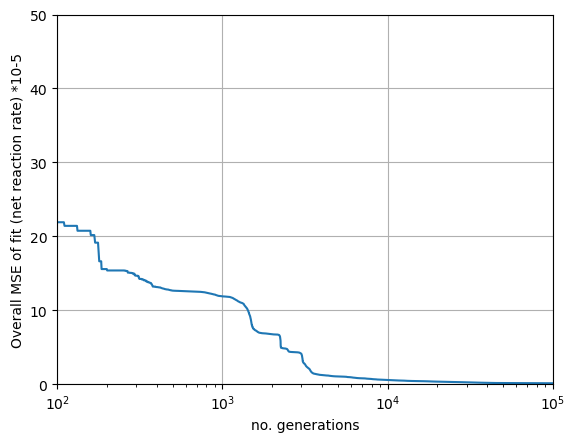

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.707614123974661
1.5532369815562963
0.8591421430055441
-4.330057517271175
0.5041845880995819
0.004128419687288717
0.3988451953054166
-9.052886708291314
0.8384073768935728
8.006893410736444
6.369456531633591
6.322532585492576
0.9036846398057565
0.023848069998167663
3.1695482841434592
1.8810962654606966e-05
0.08047514190169815
-11.999987997243299
1.8996399458003097
1.5974134810378782
-11.517997847577954
1.1899017746361913
3.966686637725977
0.011621205974603078
4.166526581062393
5.15782493024202
2.0794163541450024
11.234882264421369
-11.983527701032102
3.314348440985931
1.856836222075507
4.199824796854502
-4.047360982759093
0.5092029191764302
1.009884445884782
-1.3010299040372375


In [37]:
res.X

array([-1.17076141e+01,  1.55323698e+00,  8.59142143e-01, -4.33005752e+00,
        5.04184588e-01,  4.12841969e-03,  3.98845195e-01, -9.05288671e+00,
        8.38407377e-01,  8.00689341e+00,  6.36945653e+00,  6.32253259e+00,
        9.03684640e-01,  2.38480700e-02,  3.16954828e+00,  1.88109627e-05,
        8.04751419e-02, -1.19999880e+01,  1.89963995e+00,  1.59741348e+00,
       -1.15179978e+01,  1.18990177e+00,  3.96668664e+00,  1.16212060e-02,
        4.16652658e+00,  5.15782493e+00,  2.07941635e+00,  1.12348823e+01,
       -1.19835277e+01,  3.31434844e+00,  1.85683622e+00,  4.19982480e+00,
       -4.04736098e+00,  5.09202919e-01,  1.00988445e+00, -1.30102990e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.707614123974661
1.6: 1.5532369815562963
0.9: 0.8591421430055441
-4.3: -4.330057517271175
0.5: 0.5041845880995819
0.003: 0.004128419687288717
0.4: 0.3988451953054166
-7.9: -9.052886708291314
0.7: 0.8384073768935728
7.2: 8.006893410736444
5.7: 6.369456531633591
5.7: 6.322532585492576
0.8: 0.9036846398057565
0.03: 0.023848069998167663
3.1: 3.1695482841434592
6.000000000000001e-09: 1.8810962654606966e-05
0.1: 0.08047514190169815
-12.0: -11.999987997243299
1.9: 1.8996399458003097
1.6: 1.5974134810378782
-11.6: -11.517997847577954
1.2: 1.1899017746361913
4.0: 3.966686637725977
0.01: 0.011621205974603078
4.2: 4.166526581062393
5.4: 5.15782493024202
2.2: 2.0794163541450024
11.8: 11.234882264421369
-12.0: -11.983527701032102
3.3: 3.314348440985931
1.8: 1.856836222075507
4.2: 4.199824796854502
-4.0: -4.047360982759093
0.5: 0.5092029191764302
1.0: 1.009884445884782
coeff fit: 0.9967836414173907
r: 0.9983905255046197
